Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pasude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=39

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
def calibration(y_pred, target_rate):
    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred_calib = calibration(y_pred, target_rate)
        y_preds.append(y_pred_calib)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.01,
    'objective': "binary",
    'subsample':0.7,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2
    
}

In [15]:
def convert_label(df, confidence, threshold):
    df = df.copy()
    Probability = df.iloc[:,0]
    conf_index = df[Probability > confidence].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        Threshold = 0.5
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"* corect_labels: {sum(y_corect)}/{len(y_corect)}, noisy_labels: {len(y)-len(y_corect)} *")
            
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        confidence = y_prob.probability.max()*0.2
        p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"** p_label_rate: {p_label_rate:.4f} Vs.target_rate: {target_rate:.4f}, Num_p_label: {sum(p_label)} **")
        
        # Set the params of confidence and threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*2 < target_rate:
            check = len(y_prob)*target_rate*3
            for _ in range(10):
                print(sum(p_label), check)
                if (sum(p_label) > check) or (sum(p_label) > 0): break
                Threshold -= 0.03
                p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
                y_prob = y_prob[y_prob.index.isin(conf_idx)].copy()
               
                
        if p_label_rate > target_rate*2:
            check = len(y_prob)*target_rate*3
            for _ in range(10):
                if (sum(p_label) < check) or (sum(p_label) < 5): break
                Threshold += 0.04
                
                p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
                y_prob = y_prob[y_prob.index.isin(conf_idx)].copy()
                
              
        X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        
        logger.info(f"*** confidence:{confidence}, threshold:{Threshold}, p_label:{sum(p_label)}/{len(p_label)} ***")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Based on v8 notebook with feature importance

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
FI = data[importance_cols]
FI = FI.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
FI

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [39]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [40]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [41]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [42]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [43]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [44]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [46]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [47]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [48]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [49]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278679	valid_1's binary_logloss: 0.31855
[200]	training's binary_logloss: 0.12828	valid_1's binary_logloss: 0.178328
[300]	training's binary_logloss: 0.0629334	valid_1's binary_logloss: 0.106303
[400]	training's binary_logloss: 0.0320195	valid_1's binary_logloss: 0.0700928
[500]	training's binary_logloss: 0.0172805	valid_1's binary_logloss: 0.0501409
[600]	training's binary_logloss: 0.0100878	valid_1's binary_logloss: 0.0377426
[700]	training's binary_logloss: 0.00639378	valid_1's binary_logloss: 0.0302699
[800]	training's binary_logloss: 0.00443057	valid_1's binary_logloss: 0.0261659
[900]	training's binary_logloss: 0.00330753	valid_1's binary_logloss: 0.0235452
[1000]	training's binary_logloss: 0.00262568	valid_1's binary_logloss: 0.0215311
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262568	valid_1's binary_logloss: 0.0215311
Training until validat

* corect_labels: 499/994, noisy_labels: 6 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0007, Num_p_label: 13.0 **
*** confidence:0.17703235765884107, threshold:0.54, p_label:8.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269887	valid_1's binary_logloss: 0.323859
[200]	training's binary_logloss: 0.12471	valid_1's binary_logloss: 0.185655
[300]	training's binary_logloss: 0.0601327	valid_1's binary_logloss: 0.113976
[400]	training's binary_logloss: 0.0305124	valid_1's binary_logloss: 0.0757135
[500]	training's binary_logloss: 0.0165585	valid_1's binary_logloss: 0.0567011
[600]	training's binary_logloss: 0.00970745	valid_1's binary_logloss: 0.0458198
[700]	training's binary_logloss: 0.00616858	valid_1's binary_logloss: 0.0398056
[800]	training's binary_logloss: 0.00427383	valid_1's binary_logloss: 0.0360829
[900]	training's binary_logloss: 0.00319141	valid_1's binary_logloss: 0.0340737
[1000]	training's binary_logloss: 0.00253469	valid_1's binary_logloss: 0.0325167
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253469	valid_1's binary_logloss: 0.0325167
Training until valid

* corect_labels: 497.0/1099, noisy_labels: 6 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0007, Num_p_label: 0.0 **
*** confidence:0.08853336518756467, threshold:0.43999999999999995, p_label:1.0/40 ***
================= Pseudo labeling 3 / 3 =================


0.0 8.527840765936004
0.0 8.527840765936004
1.0 8.527840765936004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26603	valid_1's binary_logloss: 0.329595
[200]	training's binary_logloss: 0.12154	valid_1's binary_logloss: 0.19416
[300]	training's binary_logloss: 0.0583543	valid_1's binary_logloss: 0.126442
[400]	training's binary_logloss: 0.0294681	valid_1's binary_logloss: 0.0918768
[500]	training's binary_logloss: 0.0159232	valid_1's binary_logloss: 0.073724
[600]	training's binary_logloss: 0.00924213	valid_1's binary_logloss: 0.0615892
[700]	training's binary_logloss: 0.00582331	valid_1's binary_logloss: 0.0527898
[800]	training's binary_logloss: 0.00401356	valid_1's binary_logloss: 0.0465889
[900]	training's binary_logloss: 0.00300689	valid_1's binary_logloss: 0.0430652
[1000]	training's binary_logloss: 0.00238191	valid_1's binary_logloss: 0.0403007
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00

* corect_labels: 494.0/1125, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0007, Num_p_label: 0.0 **
*** confidence:0.09841807736230276, threshold:0.47, p_label:2.0/3982 ***
len(train_index) : 568
len(valid_index) : 568
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


0.0 8.527840765936004
2.0 8.527840765936004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274655	valid_1's binary_logloss: 0.33129
[200]	training's binary_logloss: 0.128121	valid_1's binary_logloss: 0.193074
[300]	training's binary_logloss: 0.0628816	valid_1's binary_logloss: 0.118599
[400]	training's binary_logloss: 0.0320129	valid_1's binary_logloss: 0.0778728
[500]	training's binary_logloss: 0.0173959	valid_1's binary_logloss: 0.0545878
[600]	training's binary_logloss: 0.010165	valid_1's binary_logloss: 0.0413238
[700]	training's binary_logloss: 0.00645022	valid_1's binary_logloss: 0.0327636
[800]	training's binary_logloss: 0.00443638	valid_1's binary_logloss: 0.0266479
[900]	training's binary_logloss: 0.00330659	valid_1's binary_logloss: 0.0225156
[1000]	training's binary_logloss: 0.00262245	valid_1's binary_logloss: 0.0198008
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262245	valid_1's bina

len(train_index) : 568
len(valid_index) : 568
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271961	valid_1's binary_logloss: 0.302591
[200]	training's binary_logloss: 0.124374	valid_1's binary_logloss: 0.156394
[300]	training's binary_logloss: 0.0599933	valid_1's binary_logloss: 0.0898266
[400]	training's binary_logloss: 0.0304165	valid_1's binary_logloss: 0.0562329
[500]	training's binary_logloss: 0.0164822	valid_1's binary_logloss: 0.0385882
[600]	training's binary_logloss: 0.00967249	valid_1's binary_logloss: 0.0292624
[700]	training's binary_logloss: 0.00615442	valid_1's binary_logloss: 0.023684
[800]	training's binary_logloss: 0.00427643	valid_1's binary_logloss: 0.0204282
[900]	training's binary_logloss: 0.00319269	valid_1's binary_logloss: 0.0180834
[1000]	training's binary_logloss: 0.00251967	valid_1's binary_logloss: 0.0160981
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00251967	valid_1's binary_logloss: 0.0160981


5-alpha_reductase_inhibitor logloss: 0.017949450433282936
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282801	valid_1's binary_logloss: 0.33409
[200]	training's binary_logloss: 0.132089	valid_1's binary_logloss: 0.197735
[300]	training's binary_logloss: 0.0649275	valid_1's binary_logloss: 0.1326
[400]	training's binary_logloss: 0.033582	valid_1's binary_logloss: 0.0966618
[500]	training's binary_logloss: 0.0185395	valid_1's binary_logloss: 0.0766384
[600]	training's binary_logloss: 0.01089	valid_1's binary_logloss: 0.0628119
[700]	training's binary_logloss: 0.00695638	valid_1's binary_logloss: 0.054171
[800]	training's binary_logloss: 0.0048223	valid_1's binary_logloss: 0.0488096
[900]	training's binary_logloss: 0.00357315	valid_1's binary_logloss: 0.0437647
[1000]	training's binary_logloss: 0.00281387	valid_1's binary_logloss: 0.0404833
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00281387	valid_1's binary_logloss: 0.0404833
Training until validation sc

* corect_labels: 496/982, noisy_labels: 18 *
** p_label_rate: 0.0098 Vs.target_rate: 0.0008, Num_p_label: 39.0 **
*** confidence:0.18771545202596257, threshold:0.7400000000000002, p_label:9.0/352 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256403	valid_1's binary_logloss: 0.29723
[200]	training's binary_logloss: 0.11904	valid_1's binary_logloss: 0.173009
[300]	training's binary_logloss: 0.0581806	valid_1's binary_logloss: 0.109698
[400]	training's binary_logloss: 0.029583	valid_1's binary_logloss: 0.0765696
[500]	training's binary_logloss: 0.0161323	valid_1's binary_logloss: 0.0595249
[600]	training's binary_logloss: 0.00952482	valid_1's binary_logloss: 0.0500525
[700]	training's binary_logloss: 0.00610827	valid_1's binary_logloss: 0.0442547
[800]	training's binary_logloss: 0.00425893	valid_1's binary_logloss: 0.0407435
[900]	training's binary_logloss: 0.00320938	valid_1's binary_logloss: 0.0383331
[1000]	training's binary_logloss: 0.00254497	valid_1's binary_logloss: 0.0366918
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00254497	valid_1's binary_logloss: 0.0366918
Training until validat

* corect_labels: 496.0/1324, noisy_labels: 10 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.1713705491542656, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245954	valid_1's binary_logloss: 0.276938
[200]	training's binary_logloss: 0.11033	valid_1's binary_logloss: 0.145643
[300]	training's binary_logloss: 0.052456	valid_1's binary_logloss: 0.0853051
[400]	training's binary_logloss: 0.0261729	valid_1's binary_logloss: 0.0558331
[500]	training's binary_logloss: 0.0137512	valid_1's binary_logloss: 0.0394854
[600]	training's binary_logloss: 0.00789692	valid_1's binary_logloss: 0.0299866
[700]	training's binary_logloss: 0.00502411	valid_1's binary_logloss: 0.0249739
[800]	training's binary_logloss: 0.00350068	valid_1's binary_logloss: 0.0214622
[900]	training's binary_logloss: 0.0026234	valid_1's binary_logloss: 0.019055
[1000]	training's binary_logloss: 0.00209409	valid_1's binary_logloss: 0.0172109
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209409	valid_1's binary_logloss: 0.0172109
Training until validat

* corect_labels: 488.0/1322, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10843410779360757, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 664
len(valid_index) : 664
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249865	valid_1's binary_logloss: 0.286651
[200]	training's binary_logloss: 0.113173	valid_1's binary_logloss: 0.150661
[300]	training's binary_logloss: 0.0549042	valid_1's binary_logloss: 0.0884864
[400]	training's binary_logloss: 0.0276453	valid_1's binary_logloss: 0.0562938
[500]	training's binary_logloss: 0.0146897	valid_1's binary_logloss: 0.0385314
[600]	training's binary_logloss: 0.00841859	valid_1's binary_logloss: 0.0280979
[700]	training's binary_logloss: 0.00533578	valid_1's binary_logloss: 0.0226605
[800]	training's binary_logloss: 0.0036817	valid_1's binary_logloss: 0.0190788
[900]	training's binary_logloss: 0.0027484	valid_1's binary_logloss: 0.0165326
[1000]	training's binary_logloss: 0.00218967	valid_1's binary_logloss: 0.014904
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00218967	valid_1's binary_logloss: 0.014904


len(train_index) : 664
len(valid_index) : 664
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248355	valid_1's binary_logloss: 0.271712
[200]	training's binary_logloss: 0.113179	valid_1's binary_logloss: 0.143509
[300]	training's binary_logloss: 0.0548489	valid_1's binary_logloss: 0.0848515
[400]	training's binary_logloss: 0.027765	valid_1's binary_logloss: 0.0562163
[500]	training's binary_logloss: 0.0148232	valid_1's binary_logloss: 0.039542
[600]	training's binary_logloss: 0.00855052	valid_1's binary_logloss: 0.0292804
[700]	training's binary_logloss: 0.0054435	valid_1's binary_logloss: 0.0231977
[800]	training's binary_logloss: 0.0037821	valid_1's binary_logloss: 0.0192401
[900]	training's binary_logloss: 0.00282781	valid_1's binary_logloss: 0.0163595
[1000]	training's binary_logloss: 0.0022471	valid_1's binary_logloss: 0.0143856
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0022471	valid_1's binary_logloss: 0.0143856


11-beta-hsd1_inhibitor logloss: 0.014644763654090806
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295743	valid_1's binary_logloss: 0.344987
[200]	training's binary_logloss: 0.144616	valid_1's binary_logloss: 0.21081
[300]	training's binary_logloss: 0.0747834	valid_1's binary_logloss: 0.140374
[400]	training's binary_logloss: 0.0398366	valid_1's binary_logloss: 0.100671
[500]	training's binary_logloss: 0.0226156	valid_1's binary_logloss: 0.0778932
[600]	training's binary_logloss: 0.0135631	valid_1's binary_logloss: 0.0651746
[700]	training's binary_logloss: 0.00872306	valid_1's binary_logloss: 0.0577923
[800]	training's binary_logloss: 0.00602822	valid_1's binary_logloss: 0.0521717
[900]	training's binary_logloss: 0.00444375	valid_1's binary_logloss: 0.048272
[1000]	training's binary_logloss: 0.00345045	valid_1's binary_logloss: 0.0445688
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00345045	valid_1's binary_logloss: 0.0445688
Training until validati

* corect_labels: 495/983, noisy_labels: 17 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0010, Num_p_label: 55.0 **
*** confidence:0.1654789694562151, threshold:0.7400000000000002, p_label:12.0/323 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271846	valid_1's binary_logloss: 0.33337
[200]	training's binary_logloss: 0.129659	valid_1's binary_logloss: 0.213214
[300]	training's binary_logloss: 0.0666655	valid_1's binary_logloss: 0.150707
[400]	training's binary_logloss: 0.035095	valid_1's binary_logloss: 0.116968
[500]	training's binary_logloss: 0.0196103	valid_1's binary_logloss: 0.0985863
[600]	training's binary_logloss: 0.0115761	valid_1's binary_logloss: 0.0894935
[700]	training's binary_logloss: 0.00744243	valid_1's binary_logloss: 0.0855998
[800]	training's binary_logloss: 0.00513748	valid_1's binary_logloss: 0.082561
[900]	training's binary_logloss: 0.00376789	valid_1's binary_logloss: 0.081004
[1000]	training's binary_logloss: 0.00292147	valid_1's binary_logloss: 0.0796219
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00292147	valid_1's binary_logloss: 0.0796219
Training until validation

* corect_labels: 491.0/1285, noisy_labels: 21 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0010, Num_p_label: 8.0 **
*** confidence:0.1393108135428099, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26839	valid_1's binary_logloss: 0.3027
[200]	training's binary_logloss: 0.124743	valid_1's binary_logloss: 0.17227
[300]	training's binary_logloss: 0.0610549	valid_1's binary_logloss: 0.105858
[400]	training's binary_logloss: 0.0316723	valid_1's binary_logloss: 0.0701215
[500]	training's binary_logloss: 0.0172059	valid_1's binary_logloss: 0.0510812
[600]	training's binary_logloss: 0.0100064	valid_1's binary_logloss: 0.0386605
[700]	training's binary_logloss: 0.00638996	valid_1's binary_logloss: 0.0314974
[800]	training's binary_logloss: 0.00444073	valid_1's binary_logloss: 0.0272432
[900]	training's binary_logloss: 0.00329417	valid_1's binary_logloss: 0.0243345
[1000]	training's binary_logloss: 0.00256371	valid_1's binary_logloss: 0.0223161
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00256371	valid_1's binary_logloss: 0.0223161
Training until validatio

* corect_labels: 485.0/1295, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.055707179516577436, threshold:0.2599999999999998, p_label:1.0/21 ***
len(train_index) : 653
len(valid_index) : 653
================================= fold 1/2 acat_inhibitor=================================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264446	valid_1's binary_logloss: 0.305282
[200]	training's binary_logloss: 0.124245	valid_1's binary_logloss: 0.170102
[300]	training's binary_logloss: 0.0618446	valid_1's binary_logloss: 0.103469
[400]	training's binary_logloss: 0.0323138	valid_1's binary_logloss: 0.0682415
[500]	training's binary_logloss: 0.0177416	valid_1's binary_logloss: 0.0475399
[600]	training's binary_logloss: 0.0104388	valid_1's binary_logloss: 0.0356236
[700]	training's binary_logloss: 0.00666428	valid_1's binary_logloss: 0.02837
[800]	training's binary_logloss: 0.00459672	valid_1's binary_logloss: 0.0236924
[900]	training's binary_logloss: 0.0033969	valid_1's binary_logloss: 0.0206798
[1000]	training's binary_l

len(train_index) : 653
len(valid_index) : 653
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263019	valid_1's binary_logloss: 0.306821
[200]	training's binary_logloss: 0.122901	valid_1's binary_logloss: 0.174755
[300]	training's binary_logloss: 0.0610776	valid_1's binary_logloss: 0.111517
[400]	training's binary_logloss: 0.0319443	valid_1's binary_logloss: 0.078619
[500]	training's binary_logloss: 0.0174597	valid_1's binary_logloss: 0.0602753
[600]	training's binary_logloss: 0.010286	valid_1's binary_logloss: 0.0487206
[700]	training's binary_logloss: 0.00658113	valid_1's binary_logloss: 0.0411264
[800]	training's binary_logloss: 0.0045592	valid_1's binary_logloss: 0.0363768
[900]	training's binary_logloss: 0.00337906	valid_1's binary_logloss: 0.0331625
[1000]	training's binary_logloss: 0.00265178	valid_1's binary_logloss: 0.0310199
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00265178	valid_1's binary_logloss: 0.0310199


acat_inhibitor logloss: 0.02488303620754961
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.437347	valid_1's binary_logloss: 0.617415
[200]	training's binary_logloss: 0.284575	valid_1's binary_logloss: 0.558612
[300]	training's binary_logloss: 0.193695	valid_1's binary_logloss: 0.521317
[400]	training's binary_logloss: 0.134735	valid_1's binary_logloss: 0.49499
[500]	training's binary_logloss: 0.0949468	valid_1's binary_logloss: 0.474112
[600]	training's binary_logloss: 0.0687566	valid_1's binary_logloss: 0.463372
[700]	training's binary_logloss: 0.0503347	valid_1's binary_logloss: 0.455276
[800]	training's binary_logloss: 0.0374202	valid_1's binary_logloss: 0.448319
Early stopping, best iteration is:
[846]	training's binary_logloss: 0.0329159	valid_1's binary_logloss: 0.446589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.441825	valid_1's binary_logloss: 0.620727
[200]	training's binary_logloss: 0.30509	valid_1's binary_logloss: 0.

* corect_labels: 398/766, noisy_labels: 234 *
** p_label_rate: 0.3026 Vs.target_rate: 0.0080, Num_p_label: 1205.0 **
*** confidence:0.18816088959795452, threshold:0.7800000000000002, p_label:79.0/3524 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145952	valid_1's binary_logloss: 0.216719
[200]	training's binary_logloss: 0.0830024	valid_1's binary_logloss: 0.183633
[300]	training's binary_logloss: 0.0486677	valid_1's binary_logloss: 0.167596
[400]	training's binary_logloss: 0.0296678	valid_1's binary_logloss: 0.16062
[500]	training's binary_logloss: 0.0188651	valid_1's binary_logloss: 0.156719
[600]	training's binary_logloss: 0.0122556	valid_1's binary_logloss: 0.154752
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.00862912	valid_1's binary_logloss: 0.153627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150041	valid_1's binary_logloss: 0.219077
[200]	training's binary_logloss: 0.0828312	valid_1's binary_logloss: 0.186205
[300]	training's binary_logloss: 0.0474499	valid_1's binary_logloss: 0.17227
[400]	training's binary_logloss: 0.0286908	valid_1's binary_loglos

* corect_labels: 302.0/4054, noisy_labels: 236 *
** p_label_rate: 0.0060 Vs.target_rate: 0.0080, Num_p_label: 24.0 **
*** confidence:0.16417291323154623, threshold:0.5, p_label:24.0/3982 ***


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0266223	valid_1's binary_logloss: 0.166913


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904463	valid_1's binary_logloss: 0.125597
[200]	training's binary_logloss: 0.0462944	valid_1's binary_logloss: 0.0943573
[300]	training's binary_logloss: 0.0258943	valid_1's binary_logloss: 0.0812435
[400]	training's binary_logloss: 0.0153143	valid_1's binary_logloss: 0.0744853
[500]	training's binary_logloss: 0.00910152	valid_1's binary_logloss: 0.0691169
[600]	training's binary_logloss: 0.00563544	valid_1's binary_logloss: 0.0662281
[700]	training's binary_logloss: 0.00368865	valid_1's binary_logloss: 0.0644144
Early stopping, best iteration is:
[748]	training's binary_logloss: 0.00308213	valid_1's binary_logloss: 0.0640384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869713	valid_1's binary_logloss: 0.133242
[200]	training's binary_logloss: 0.0433081	valid_1's binary_logloss: 0.103139
[300]	training's binary_logloss: 0.0237688	valid_1's

* corect_labels: 228.0/4031, noisy_labels: 118 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0080, Num_p_label: 2.0 **
*** confidence:0.18817035236796031, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 2024
len(valid_index) : 2024
================================= fold 1/2 acetylcholine_receptor_agonist=================================


2.0 95.3111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649394	valid_1's binary_logloss: 0.0911591
[200]	training's binary_logloss: 0.0308235	valid_1's binary_logloss: 0.0628203
[300]	training's binary_logloss: 0.0161897	valid_1's binary_logloss: 0.0507899
[400]	training's binary_logloss: 0.00906619	valid_1's binary_logloss: 0.0449926
[500]	training's binary_logloss: 0.00537242	valid_1's binary_logloss: 0.0412191
[600]	training's binary_logloss: 0.00339322	valid_1's binary_logloss: 0.0388682
[700]	training's binary_logloss: 0.00229069	valid_1's binary_logloss: 0.0365818
[800]	training's binary_logloss: 0.00164915	valid_1's binary_logloss: 0.0352304
[900]	training's binary_logloss: 0.00126025	valid_1's binary_logloss: 0.0344883
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.00108617	valid_1's binary_logloss: 0.0340409


len(train_index) : 2024
len(valid_index) : 2024
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676488	valid_1's binary_logloss: 0.0947934
[200]	training's binary_logloss: 0.0330071	valid_1's binary_logloss: 0.0644752
[300]	training's binary_logloss: 0.0176618	valid_1's binary_logloss: 0.0508395
[400]	training's binary_logloss: 0.00999163	valid_1's binary_logloss: 0.0441106
[500]	training's binary_logloss: 0.00604761	valid_1's binary_logloss: 0.0405701
[600]	training's binary_logloss: 0.00384694	valid_1's binary_logloss: 0.0385993
[700]	training's binary_logloss: 0.00258746	valid_1's binary_logloss: 0.0374625
[800]	training's binary_logloss: 0.00183075	valid_1's binary_logloss: 0.0369401
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.00180938	valid_1's binary_logloss: 0.0369066


acetylcholine_receptor_agonist logloss: 0.03547372886363907
acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.436222	valid_1's binary_logloss: 0.656693
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.317687	valid_1's binary_logloss: 0.642127
Training until validation scores don't improve for 10 rounds


* corect_labels: 318/599, noisy_labels: 401 *
** p_label_rate: 0.3217 Vs.target_rate: 0.0126, Num_p_label: 1281.0 **
*** confidence:0.14101805159431824, threshold:0.6200000000000001, p_label:108.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.542999	valid_1's binary_logloss: 0.683798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132477	valid_1's binary_logloss: 0.202633
[200]	training's binary_logloss: 0.0719757	valid_1's binary_logloss: 0.176519
[300]	training's binary_logloss: 0.0431232	valid_1's binary_logloss: 0.164383
[400]	training's binary_logloss: 0.0268579	valid_1's binary_logloss: 0.160977
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.0232634	valid_1's binary_logloss: 0.160765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128812	valid_1's binary_logloss: 0.211654
[200]	training's binary_logloss: 0.069293	valid_1's binary_logloss: 0.185943
[300]	training's binary_logloss: 0.0403691	valid_1's binary_logloss: 0.174607
[400]	training's binary_logloss: 0.0246004	valid_1's binary_logloss: 0.170015
Early stopping, best iteration is

* corect_labels: 183.0/4308, noisy_labels: 273 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0126, Num_p_label: 26.0 **
*** confidence:0.17025268795652146, threshold:0.5, p_label:26.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488461	valid_1's binary_logloss: 0.082275
[200]	training's binary_logloss: 0.0234816	valid_1's binary_logloss: 0.061482
[300]	training's binary_logloss: 0.0122903	valid_1's binary_logloss: 0.05449
[400]	training's binary_logloss: 0.00677257	valid_1's binary_logloss: 0.0512735
[500]	training's binary_logloss: 0.00407093	valid_1's binary_logloss: 0.0499551
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.0036557	valid_1's binary_logloss: 0.0498262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490143	valid_1's binary_logloss: 0.0891189
[200]	training's binary_logloss: 0.022323	valid_1's binary_logloss: 0.0736388
[300]	training's binary_logloss: 0.0109835	valid_1's binary_logloss: 0.0674056
[400]	training's binary_logloss: 0.00589516	valid_1's binary_logloss: 0.0650184


* corect_labels: 109.0/4337, noisy_labels: 88 *


[500]	training's binary_logloss: 0.00345266	valid_1's binary_logloss: 0.0642412
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.0034026	valid_1's binary_logloss: 0.0641929


** p_label_rate: 0.0000 Vs.target_rate: 0.0126, Num_p_label: 0.0 **
*** confidence:0.09686239661259899, threshold:0.47, p_label:2.0/3982 ***
len(train_index) : 2171
len(valid_index) : 2172
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


0.0 150.9929453262787
2.0 150.9929453262787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280045	valid_1's binary_logloss: 0.0524079
[200]	training's binary_logloss: 0.0121721	valid_1's binary_logloss: 0.0394252
[300]	training's binary_logloss: 0.00611718	valid_1's binary_logloss: 0.0341835
[400]	training's binary_logloss: 0.00343362	valid_1's binary_logloss: 0.0317736
[500]	training's binary_logloss: 0.0020636	valid_1's binary_logloss: 0.0299567
[600]	training's binary_logloss: 0.00134269	valid_1's binary_logloss: 0.028886
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00120215	valid_1's binary_logloss: 0.0287213


len(train_index) : 2172
len(valid_index) : 2171
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028402	valid_1's binary_logloss: 0.0516105
[200]	training's binary_logloss: 0.0121137	valid_1's binary_logloss: 0.0377216
[300]	training's binary_logloss: 0.00593628	valid_1's binary_logloss: 0.0316851
[400]	training's binary_logloss: 0.00326318	valid_1's binary_logloss: 0.0287541
[500]	training's binary_logloss: 0.00194756	valid_1's binary_logloss: 0.027062
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00165538	valid_1's binary_logloss: 0.0268991


acetylcholine_receptor_antagonist logloss: 0.027810385079534903
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.379091	valid_1's binary_logloss: 0.510023
[200]	training's binary_logloss: 0.228586	valid_1's binary_logloss: 0.413183
[300]	training's binary_logloss: 0.143589	valid_1's binary_logloss: 0.351015
[400]	training's binary_logloss: 0.0917267	valid_1's binary_logloss: 0.308527
[500]	training's binary_logloss: 0.0600149	valid_1's binary_logloss: 0.284497
[600]	training's binary_logloss: 0.0402836	valid_1's binary_logloss: 0.267849
[700]	training's binary_logloss: 0.0275713	valid_1's binary_logloss: 0.25563
[800]	training's binary_logloss: 0.0195734	valid_1's binary_logloss: 0.244793
[900]	training's binary_logloss: 0.014473	valid_1's binary_logloss: 0.236554
[1000]	training's binary_logloss: 0.0110672	valid_1's binary_logloss: 0.23296
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0110672	valid_1's binary_logloss: 0.23296
Training until validation scores don't

* corect_labels: 464/915, noisy_labels: 85 *
** p_label_rate: 0.0859 Vs.target_rate: 0.0031, Num_p_label: 342.0 **
*** confidence:0.1928743843674013, threshold:0.7800000000000002, p_label:35.0/1662 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220483	valid_1's binary_logloss: 0.27618
[200]	training's binary_logloss: 0.122912	valid_1's binary_logloss: 0.206255
[300]	training's binary_logloss: 0.0719438	valid_1's binary_logloss: 0.170667
[400]	training's binary_logloss: 0.0422362	valid_1's binary_logloss: 0.148831
[500]	training's binary_logloss: 0.0255953	valid_1's binary_logloss: 0.135924
[600]	training's binary_logloss: 0.0160043	valid_1's binary_logloss: 0.127849
[700]	training's binary_logloss: 0.0103961	valid_1's binary_logloss: 0.123717
[800]	training's binary_logloss: 0.00709581	valid_1's binary_logloss: 0.121516
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.00641693	valid_1's binary_logloss: 0.121016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226903	valid_1's binary_logloss: 0.291194
[200]	training's binary_logloss: 0.130439	valid_1's binary_loglos

* corect_labels: 431.0/2482, noisy_labels: 95 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0031, Num_p_label: 5.0 **
*** confidence:0.10480963989178749, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185461	valid_1's binary_logloss: 0.233511
[200]	training's binary_logloss: 0.101533	valid_1's binary_logloss: 0.16068
[300]	training's binary_logloss: 0.0576211	valid_1's binary_logloss: 0.124224
[400]	training's binary_logloss: 0.0327934	valid_1's binary_logloss: 0.100762
[500]	training's binary_logloss: 0.0191854	valid_1's binary_logloss: 0.0856066
[600]	training's binary_logloss: 0.0116643	valid_1's binary_logloss: 0.0754517
[700]	training's binary_logloss: 0.00742758	valid_1's binary_logloss: 0.0699889
[800]	training's binary_logloss: 0.00504594	valid_1's binary_logloss: 0.0666943
[900]	training's binary_logloss: 0.00363797	valid_1's binary_logloss: 0.0650454
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.00334251	valid_1's binary_logloss: 0.0648069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0

* corect_labels: 401.0/2490, noisy_labels: 46 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0031, Num_p_label: 0.0 **
*** confidence:0.08822441915038882, threshold:0.43999999999999995, p_label:1.0/23 ***
len(train_index) : 1247
len(valid_index) : 1248
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


0.0 36.61955152431343
0.0 36.61955152431343
1.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176779	valid_1's binary_logloss: 0.216124
[200]	training's binary_logloss: 0.0944117	valid_1's binary_logloss: 0.144565
[300]	training's binary_logloss: 0.0514281	valid_1's binary_logloss: 0.104829
[400]	training's binary_logloss: 0.0289129	valid_1's binary_logloss: 0.0817027
[500]	training's binary_logloss: 0.0167791	valid_1's binary_logloss: 0.0676033
[600]	training's binary_logloss: 0.0102352	valid_1's binary_logloss: 0.0589817
[700]	training's binary_logloss: 0.00658663	valid_1's binary_logloss: 0.0531011
[800]	training's binary_logloss: 0.00450234	valid_1's binary_logloss: 0.0481971
[900]	training's binary_logloss: 0.00328339	valid_1's binary_logloss: 0.0449126
[1000]	training's binary_logloss: 0.00252985	valid_1's binary_logloss: 0.0423499
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 

len(train_index) : 1248
len(valid_index) : 1247
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171282	valid_1's binary_logloss: 0.218248
[200]	training's binary_logloss: 0.0890928	valid_1's binary_logloss: 0.147769
[300]	training's binary_logloss: 0.0505801	valid_1's binary_logloss: 0.114579
[400]	training's binary_logloss: 0.0288169	valid_1's binary_logloss: 0.0950497
[500]	training's binary_logloss: 0.0169418	valid_1's binary_logloss: 0.0823831
[600]	training's binary_logloss: 0.0102958	valid_1's binary_logloss: 0.0740467
[700]	training's binary_logloss: 0.00661406	valid_1's binary_logloss: 0.0679552
[800]	training's binary_logloss: 0.0044844	valid_1's binary_logloss: 0.0640967
[900]	training's binary_logloss: 0.00322961	valid_1's binary_logloss: 0.0613859
[1000]	training's binary_logloss: 0.00247096	valid_1's binary_logloss: 0.0595323
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00247096	valid_1's binary_logloss: 0.0595323


acetylcholinesterase_inhibitor logloss: 0.050937627363952784
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349475	valid_1's binary_logloss: 0.463236
[200]	training's binary_logloss: 0.206983	valid_1's binary_logloss: 0.35537
[300]	training's binary_logloss: 0.124821	valid_1's binary_logloss: 0.284713
[400]	training's binary_logloss: 0.0775225	valid_1's binary_logloss: 0.241145
[500]	training's binary_logloss: 0.0491066	valid_1's binary_logloss: 0.211582
[600]	training's binary_logloss: 0.0321672	valid_1's binary_logloss: 0.186833
[700]	training's binary_logloss: 0.0218723	valid_1's binary_logloss: 0.168219
[800]	training's binary_logloss: 0.0154331	valid_1's binary_logloss: 0.153525
[900]	training's binary_logloss: 0.011364	valid_1's binary_logloss: 0.143114
[1000]	training's binary_logloss: 0.00870984	valid_1's binary_logloss: 0.134788
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00870984	valid_1's binary_logloss: 0.134788
Training until validation scores d

* corect_labels: 486/953, noisy_labels: 47 *
** p_label_rate: 0.0168 Vs.target_rate: 0.0023, Num_p_label: 67.0 **
*** confidence:0.17086079502446508, threshold:0.6600000000000001, p_label:22.0/661 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294107	valid_1's binary_logloss: 0.375633
[200]	training's binary_logloss: 0.159042	valid_1's binary_logloss: 0.273798
[300]	training's binary_logloss: 0.0915139	valid_1's binary_logloss: 0.216831
[400]	training's binary_logloss: 0.0538287	valid_1's binary_logloss: 0.182993
[500]	training's binary_logloss: 0.0323603	valid_1's binary_logloss: 0.16224
[600]	training's binary_logloss: 0.0202516	valid_1's binary_logloss: 0.148409
[700]	training's binary_logloss: 0.0132076	valid_1's binary_logloss: 0.140799
[800]	training's binary_logloss: 0.00910052	valid_1's binary_logloss: 0.136208
[900]	training's binary_logloss: 0.00664074	valid_1's binary_logloss: 0.133348
[1000]	training's binary_logloss: 0.00508938	valid_1's binary_logloss: 0.131248
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00508938	valid_1's binary_logloss: 0.131248
Training until validation scor

* corect_labels: 457.0/1541, noisy_labels: 73 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0023, Num_p_label: 13.0 **
*** confidence:0.1859567166128019, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263534	valid_1's binary_logloss: 0.32
[200]	training's binary_logloss: 0.143591	valid_1's binary_logloss: 0.219972
[300]	training's binary_logloss: 0.0813526	valid_1's binary_logloss: 0.165814
[400]	training's binary_logloss: 0.0484244	valid_1's binary_logloss: 0.133381
[500]	training's binary_logloss: 0.028773	valid_1's binary_logloss: 0.111255
[600]	training's binary_logloss: 0.017561	valid_1's binary_logloss: 0.097451
[700]	training's binary_logloss: 0.0111595	valid_1's binary_logloss: 0.088045
[800]	training's binary_logloss: 0.00751279	valid_1's binary_logloss: 0.0816139
[900]	training's binary_logloss: 0.00539576	valid_1's binary_logloss: 0.076573
[1000]	training's binary_logloss: 0.00414938	valid_1's binary_logloss: 0.0726582
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00414938	valid_1's binary_logloss: 0.0726582
Training until validation scores

* corect_labels: 434.0/1520, noisy_labels: 45 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0023, Num_p_label: 3.0 **
*** confidence:0.17785991324974845, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 762
len(valid_index) : 763
================================= fold 1/2 adenosine_receptor_agonist=================================


3.0 27.08843537414966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257737	valid_1's binary_logloss: 0.312593
[200]	training's binary_logloss: 0.140176	valid_1's binary_logloss: 0.213321
[300]	training's binary_logloss: 0.0814154	valid_1's binary_logloss: 0.161319
[400]	training's binary_logloss: 0.0491348	valid_1's binary_logloss: 0.129002
[500]	training's binary_logloss: 0.0296402	valid_1's binary_logloss: 0.107276
[600]	training's binary_logloss: 0.0180397	valid_1's binary_logloss: 0.0894572
[700]	training's binary_logloss: 0.0114523	valid_1's binary_logloss: 0.0781608
[800]	training's binary_logloss: 0.00767458	valid_1's binary_logloss: 0.0690896
[900]	training's binary_logloss: 0.00547342	valid_1's binary_logloss: 0.062489
[1000]	training's binary_logloss: 0.00413524	valid_1's binary_logloss: 0.0581501
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00413524	valid_1's binary_logloss: 0.0581501


len(train_index) : 763
len(valid_index) : 762
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255483	valid_1's binary_logloss: 0.312186
[200]	training's binary_logloss: 0.132321	valid_1's binary_logloss: 0.206357
[300]	training's binary_logloss: 0.0729663	valid_1's binary_logloss: 0.151405
[400]	training's binary_logloss: 0.0423068	valid_1's binary_logloss: 0.120631
[500]	training's binary_logloss: 0.025331	valid_1's binary_logloss: 0.101078
[600]	training's binary_logloss: 0.0155319	valid_1's binary_logloss: 0.0869867
[700]	training's binary_logloss: 0.0100308	valid_1's binary_logloss: 0.0775142
[800]	training's binary_logloss: 0.00687841	valid_1's binary_logloss: 0.0705523
[900]	training's binary_logloss: 0.00503964	valid_1's binary_logloss: 0.065513
[1000]	training's binary_logloss: 0.0038743	valid_1's binary_logloss: 0.0618703
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0038743	valid_1's binary_logloss: 0.0618703


adenosine_receptor_agonist logloss: 0.060008973267436566
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.380682	valid_1's binary_logloss: 0.556047
[200]	training's binary_logloss: 0.2342	valid_1's binary_logloss: 0.473508
[300]	training's binary_logloss: 0.149246	valid_1's binary_logloss: 0.42589
[400]	training's binary_logloss: 0.0963196	valid_1's binary_logloss: 0.394047
[500]	training's binary_logloss: 0.064326	valid_1's binary_logloss: 0.376514
[600]	training's binary_logloss: 0.0439574	valid_1's binary_logloss: 0.369006
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.0355903	valid_1's binary_logloss: 0.363275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.384239	valid_1's binary_logloss: 0.537964
[200]	training's binary_logloss: 0.232582	valid_1's binary_logloss: 0.460069
[300]	training's binary_logloss: 0.151158	valid_1's binary_logloss: 0.416173
[400]	training's binary_logloss: 0.101927	valid_1's binary_logloss: 0.387

* corect_labels: 440/851, noisy_labels: 149 *
** p_label_rate: 0.0585 Vs.target_rate: 0.0040, Num_p_label: 233.0 **
*** confidence:0.1895693818165901, threshold:0.7000000000000002, p_label:44.0/1524 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229315	valid_1's binary_logloss: 0.297443
[200]	training's binary_logloss: 0.129459	valid_1's binary_logloss: 0.22793
[300]	training's binary_logloss: 0.0749473	valid_1's binary_logloss: 0.192458
[400]	training's binary_logloss: 0.0440914	valid_1's binary_logloss: 0.171333
[500]	training's binary_logloss: 0.0266488	valid_1's binary_logloss: 0.158054
[600]	training's binary_logloss: 0.0166072	valid_1's binary_logloss: 0.150497
[700]	training's binary_logloss: 0.0108953	valid_1's binary_logloss: 0.14525
[800]	training's binary_logloss: 0.00751459	valid_1's binary_logloss: 0.141719
[900]	training's binary_logloss: 0.00549197	valid_1's binary_logloss: 0.140082
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.00452392	valid_1's binary_logloss: 0.139062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225426	valid_1's binary_loglo

* corect_labels: 402.0/2268, noisy_labels: 107 *


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.0167122	valid_1's binary_logloss: 0.163479


** p_label_rate: 0.0038 Vs.target_rate: 0.0040, Num_p_label: 15.0 **
*** confidence:0.17037311354099885, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181464	valid_1's binary_logloss: 0.233639
[200]	training's binary_logloss: 0.0914241	valid_1's binary_logloss: 0.164026
[300]	training's binary_logloss: 0.0488333	valid_1's binary_logloss: 0.132118
[400]	training's binary_logloss: 0.0270617	valid_1's binary_logloss: 0.112296
[500]	training's binary_logloss: 0.0158012	valid_1's binary_logloss: 0.101775
[600]	training's binary_logloss: 0.00978023	valid_1's binary_logloss: 0.0960214
[700]	training's binary_logloss: 0.00630248	valid_1's binary_logloss: 0.0917987
[800]	training's binary_logloss: 0.00430596	valid_1's binary_logloss: 0.0892811
[900]	training's binary_logloss: 0.00315054	valid_1's binary_logloss: 0.0876989
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.00265276	valid_1's binary_logloss: 0.0868688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179283	valid_1's bi

* corect_labels: 362.0/2253, noisy_labels: 70 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0040, Num_p_label: 2.0 **
*** confidence:0.1845773923573284, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1132
len(valid_index) : 1132
================================= fold 1/2 adenosine_receptor_antagonist=================================


2.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159454	valid_1's binary_logloss: 0.206431
[200]	training's binary_logloss: 0.0772126	valid_1's binary_logloss: 0.135104
[300]	training's binary_logloss: 0.0409218	valid_1's binary_logloss: 0.102958
[400]	training's binary_logloss: 0.0229426	valid_1's binary_logloss: 0.0865764
[500]	training's binary_logloss: 0.0135275	valid_1's binary_logloss: 0.076426
[600]	training's binary_logloss: 0.00837216	valid_1's binary_logloss: 0.0688599
[700]	training's binary_logloss: 0.00553201	valid_1's binary_logloss: 0.0643255
[800]	training's binary_logloss: 0.00387994	valid_1's binary_logloss: 0.0607376
[900]	training's binary_logloss: 0.00288576	valid_1's binary_logloss: 0.0580757
[1000]	training's binary_logloss: 0.00226325	valid_1's binary_logloss: 0.0561805
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00226325	valid_1's binary_logloss: 0.05618

len(train_index) : 1132
len(valid_index) : 1132
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166183	valid_1's binary_logloss: 0.1989
[200]	training's binary_logloss: 0.0833845	valid_1's binary_logloss: 0.126676
[300]	training's binary_logloss: 0.0470954	valid_1's binary_logloss: 0.0944769
[400]	training's binary_logloss: 0.0268128	valid_1's binary_logloss: 0.0756696
[500]	training's binary_logloss: 0.0157865	valid_1's binary_logloss: 0.064223
[600]	training's binary_logloss: 0.00974402	valid_1's binary_logloss: 0.0567658
[700]	training's binary_logloss: 0.00629185	valid_1's binary_logloss: 0.0508997
[800]	training's binary_logloss: 0.00435824	valid_1's binary_logloss: 0.0469901
[900]	training's binary_logloss: 0.00320145	valid_1's binary_logloss: 0.0443913
[1000]	training's binary_logloss: 0.00247714	valid_1's binary_logloss: 0.0422842
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00247714	valid_1's binary_logloss: 0.0422842


adenosine_receptor_antagonist logloss: 0.04923231865744489
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285569	valid_1's binary_logloss: 0.333489
[200]	training's binary_logloss: 0.13543	valid_1's binary_logloss: 0.189181
[300]	training's binary_logloss: 0.0675876	valid_1's binary_logloss: 0.115078
[400]	training's binary_logloss: 0.0354448	valid_1's binary_logloss: 0.0761296
[500]	training's binary_logloss: 0.0193651	valid_1's binary_logloss: 0.0541844
[600]	training's binary_logloss: 0.0113694	valid_1's binary_logloss: 0.0419895
[700]	training's binary_logloss: 0.0072606	valid_1's binary_logloss: 0.0345047
[800]	training's binary_logloss: 0.00503332	valid_1's binary_logloss: 0.0296145
[900]	training's binary_logloss: 0.00373947	valid_1's binary_logloss: 0.026319
[1000]	training's binary_logloss: 0.00295378	valid_1's binary_logloss: 0.0241874
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00295378	valid_1's binary_logloss: 0.0241874
Training until validati

* corect_labels: 497/992, noisy_labels: 8 *
** p_label_rate: 0.0178 Vs.target_rate: 0.0008, Num_p_label: 71.0 **
*** confidence:0.19728794350034629, threshold:0.9000000000000004, p_label:8.0/314 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278006	valid_1's binary_logloss: 0.336723
[200]	training's binary_logloss: 0.129561	valid_1's binary_logloss: 0.196199
[300]	training's binary_logloss: 0.0634145	valid_1's binary_logloss: 0.127093
[400]	training's binary_logloss: 0.0323631	valid_1's binary_logloss: 0.0906692
[500]	training's binary_logloss: 0.0175158	valid_1's binary_logloss: 0.0724064
[600]	training's binary_logloss: 0.0102833	valid_1's binary_logloss: 0.0628852
[700]	training's binary_logloss: 0.00657714	valid_1's binary_logloss: 0.0570689
[800]	training's binary_logloss: 0.00451898	valid_1's binary_logloss: 0.0526945
[900]	training's binary_logloss: 0.00333514	valid_1's binary_logloss: 0.050196
[1000]	training's binary_logloss: 0.00261112	valid_1's binary_logloss: 0.048465
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00261112	valid_1's binary_logloss: 0.048465
Training until validati

* corect_labels: 495.0/1292, noisy_labels: 14 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.18208161131259215, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263497	valid_1's binary_logloss: 0.307466
[200]	training's binary_logloss: 0.118465	valid_1's binary_logloss: 0.169632
[300]	training's binary_logloss: 0.0570952	valid_1's binary_logloss: 0.107209
[400]	training's binary_logloss: 0.0292448	valid_1's binary_logloss: 0.0738578
[500]	training's binary_logloss: 0.0158371	valid_1's binary_logloss: 0.0551869
[600]	training's binary_logloss: 0.00927445	valid_1's binary_logloss: 0.0448077
[700]	training's binary_logloss: 0.00587002	valid_1's binary_logloss: 0.0384568
[800]	training's binary_logloss: 0.00403291	valid_1's binary_logloss: 0.034052
[900]	training's binary_logloss: 0.00298	valid_1's binary_logloss: 0.0311773
[1000]	training's binary_logloss: 0.00233628	valid_1's binary_logloss: 0.0294202
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00233628	valid_1's binary_logloss: 0.0294202
Training until validati

* corect_labels: 490.0/1296, noisy_labels: 6 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.09845591725067548, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 654
len(valid_index) : 654
================================= fold 1/2 adenylyl_cyclase_activator=================================


0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265271	valid_1's binary_logloss: 0.31427
[200]	training's binary_logloss: 0.121595	valid_1's binary_logloss: 0.176191
[300]	training's binary_logloss: 0.0596109	valid_1's binary_logloss: 0.108125
[400]	training's binary_logloss: 0.0305082	valid_1's binary_logloss: 0.0711509
[500]	training's binary_logloss: 0.01638	valid_1's binary_logloss: 0.0500237
[600]	training's binary_logloss: 0.00951375	valid_1's binary_logloss: 0.0374516
[700]	training's binary_logloss: 0.00603933	valid_1's binary_logloss: 0.0293424
[800]	training's binary_logloss: 0.00416948	valid_1's binary_logloss: 0.0247427
[900]	training's binary_logloss: 0.00309512	valid_1's binary_logloss: 0.0215883
[1000]	training's binary_logloss: 0.00244573	valid_1's binary_logloss: 0.0196103
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244573	valid_1's bina

len(train_index) : 654
len(valid_index) : 654
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269988	valid_1's binary_logloss: 0.323429
[200]	training's binary_logloss: 0.125202	valid_1's binary_logloss: 0.187696
[300]	training's binary_logloss: 0.0609407	valid_1's binary_logloss: 0.116113
[400]	training's binary_logloss: 0.0307908	valid_1's binary_logloss: 0.0758198
[500]	training's binary_logloss: 0.0164922	valid_1's binary_logloss: 0.0561725
[600]	training's binary_logloss: 0.00952704	valid_1's binary_logloss: 0.0441909
[700]	training's binary_logloss: 0.00602129	valid_1's binary_logloss: 0.0357401
[800]	training's binary_logloss: 0.00413502	valid_1's binary_logloss: 0.0306217
[900]	training's binary_logloss: 0.00305922	valid_1's binary_logloss: 0.026846
[1000]	training's binary_logloss: 0.00240096	valid_1's binary_logloss: 0.0237159
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00240096	valid_1's binary_logloss: 0.0237159


adenylyl_cyclase_activator logloss: 0.021663132865316837
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.441058	valid_1's binary_logloss: 0.658809
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.368819	valid_1's binary_logloss: 0.649038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.439737	valid_1's binary_logloss: 0.648564


* corect_labels: 318/632, noisy_labels: 368 *
** p_label_rate: 0.2007 Vs.target_rate: 0.0113, Num_p_label: 799.0 **
*** confidence:0.14739046594214492, threshold:0.6200000000000001, p_label:56.0/3982 ***
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.297184	valid_1's binary_logloss: 0.630336
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.30045	valid_1's binary_logloss: 0.630095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106627	valid_1's binary_logloss: 0.162406
[200]	training's binary_logloss: 0.0558237	valid_1's binary_logloss: 0.134882
[300]	training's binary_logloss: 0.0306308	valid_1's binary_logloss: 0.125946
[400]	training's binary_logloss: 0.0176405	valid_1's binary_logloss: 0.122348
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.0164824	valid_1's binary_logloss: 0.122188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110371	valid_1's binary_logloss: 0.163577
[200]	training's binary_logloss: 0.0592871	valid_1's binary_logloss: 0.13791
[300]	training's binary_logloss: 0.034172	valid_1's binary_logloss: 0.12962
[400]	training's binary_logloss: 0.0

* corect_labels: 204.0/4406, noisy_labels: 208 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0113, Num_p_label: 19.0 **
*** confidence:0.17504257032680515, threshold:0.5, p_label:19.0/3982 ***


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0162142	valid_1's binary_logloss: 0.126408
19.0 135.4421768707483


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538062	valid_1's binary_logloss: 0.0845481
[200]	training's binary_logloss: 0.024926	valid_1's binary_logloss: 0.0616464
[300]	training's binary_logloss: 0.0124091	valid_1's binary_logloss: 0.0534555
[400]	training's binary_logloss: 0.00664338	valid_1's binary_logloss: 0.0503658
[500]	training's binary_logloss: 0.00385117	valid_1's binary_logloss: 0.0487851
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00309753	valid_1's binary_logloss: 0.0485371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057935	valid_1's binary_logloss: 0.0897619
[200]	training's binary_logloss: 0.0276759	valid_1's binary_logloss: 0.0671861
[300]	training's binary_logloss: 0.0144128	valid_1's binary_logloss: 0.0575008
[400]	training's binary_logloss: 0.00785585	valid_1's binary_logloss: 0.0521295
[500]	training's binary_logloss: 0.00449144	valid_1

* corect_labels: 138.0/4393, noisy_labels: 78 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0113, Num_p_label: 4.0 **
*** confidence:0.1508398822715968, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 2202
len(valid_index) : 2202
================================= fold 1/2 adrenergic_receptor_agonist=================================


4.0 135.4421768707483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349669	valid_1's binary_logloss: 0.0659037
[200]	training's binary_logloss: 0.0156773	valid_1's binary_logloss: 0.0518245
[300]	training's binary_logloss: 0.00785189	valid_1's binary_logloss: 0.0471056


len(train_index) : 2202
len(valid_index) : 2202
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00588984	valid_1's binary_logloss: 0.0462105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358474	valid_1's binary_logloss: 0.0599222
[200]	training's binary_logloss: 0.0159482	valid_1's binary_logloss: 0.0428671
[300]	training's binary_logloss: 0.00800529	valid_1's binary_logloss: 0.0363974
[400]	training's binary_logloss: 0.0043071	valid_1's binary_logloss: 0.0336235
[500]	training's binary_logloss: 0.00254483	valid_1's binary_logloss: 0.0324374
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0022117	valid_1's binary_logloss: 0.0321276


adrenergic_receptor_agonist logloss: 0.03916904629494349
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445189	valid_1's binary_logloss: 0.670889
[200]	training's binary_logloss: 0.308644	valid_1's binary_logloss: 0.659498
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.297972	valid_1's binary_logloss: 0.658791


* corect_labels: 268/552, noisy_labels: 448 *
** p_label_rate: 0.5100 Vs.target_rate: 0.0151, Num_p_label: 2031.0 **
*** confidence:0.13583114316471603, threshold:0.6200000000000001, p_label:172.0/3982 ***


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689597	valid_1's binary_logloss: 0.693034


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150449	valid_1's binary_logloss: 0.243737
[200]	training's binary_logloss: 0.0897102	valid_1's binary_logloss: 0.221508
[300]	training's binary_logloss: 0.0579796	valid_1's binary_logloss: 0.214674
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0413857	valid_1's binary_logloss: 0.212768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156754	valid_1's binary_logloss: 0.243765
[200]	training's binary_logloss: 0.0929927	valid_1's binary_logloss: 0.218877
[300]	training's binary_logloss: 0.0600348	valid_1's binary_logloss: 0.207479
[400]	training's binary_logloss: 0.0403334	valid_1's binary_logloss: 0.203925


* corect_labels: 112.0/4187, noisy_labels: 347 *
** p_label_rate: 0.0085 Vs.target_rate: 0.0151, Num_p_label: 34.0 **


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0379822	valid_1's binary_logloss: 0.203795


*** confidence:0.1447088070328375, threshold:0.5, p_label:34.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032971	valid_1's binary_logloss: 0.0700963
[200]	training's binary_logloss: 0.0151993	valid_1's binary_logloss: 0.0583509
[300]	training's binary_logloss: 0.0076495	valid_1's binary_logloss: 0.0538258
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00665331	valid_1's binary_logloss: 0.0533586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333409	valid_1's binary_logloss: 0.0699324
[200]	training's binary_logloss: 0.0150592	valid_1's binary_logloss: 0.0602752


* corect_labels: 52.0/4294, noisy_labels: 65 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0151, Num_p_label: 0.0 **
*** confidence:0.09041398447947566, threshold:0.43999999999999995, p_label:1.0/23 ***
len(train_index) : 2151
len(valid_index) : 2151
================================= fold 1/2 adrenergic_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00742507	valid_1's binary_logloss: 0.057089
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00785138	valid_1's binary_logloss: 0.0570616
0.0 180.58956916099774
0.0 180.58956916099774
1.0 180.58956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143751	valid_1's binary_logloss: 0.0308191
[200]	training's binary_logloss: 0.00605101	valid_1's binary_logloss: 0.0242356


len(train_index) : 2151
len(valid_index) : 2151
================================= fold 2/2 adrenergic_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00292266	valid_1's binary_logloss: 0.0221789
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00260662	valid_1's binary_logloss: 0.0220256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132257	valid_1's binary_logloss: 0.0335228
[200]	training's binary_logloss: 0.00533186	valid_1's binary_logloss: 0.0276884
[300]	training's binary_logloss: 0.00254111	valid_1's binary_logloss: 0.0259601


adrenergic_receptor_antagonist logloss: 0.023849664717633404
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00172159	valid_1's binary_logloss: 0.0256737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.363971	valid_1's binary_logloss: 0.487304
[200]	training's binary_logloss: 0.203354	valid_1's binary_logloss: 0.378646
[300]	training's binary_logloss: 0.121406	valid_1's binary_logloss: 0.315753
[400]	training's binary_logloss: 0.0752542	valid_1's binary_logloss: 0.272857
[500]	training's binary_logloss: 0.0481182	valid_1's binary_logloss: 0.244649
[600]	training's binary_logloss: 0.0313072	valid_1's binary_logloss: 0.221741
[700]	training's binary_logloss: 0.0212856	valid_1's binary_logloss: 0.203972
[800]	training's binary_logloss: 0.0151978	valid_1's binary_logloss: 0.193912
[900]	training's binary_logloss: 0.0112146	valid_1's binary_logloss: 0.187281
[1000]	training's binary_logloss: 0.00861972	valid_1's binary_logloss: 0.182001
Did not meet early stopping. Best iteration i

* corect_labels: 483/946, noisy_labels: 54 *
** p_label_rate: 0.0660 Vs.target_rate: 0.0028, Num_p_label: 263.0 **
*** confidence:0.19214676197494548, threshold:0.7800000000000002, p_label:29.0/1408 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234448	valid_1's binary_logloss: 0.297088
[200]	training's binary_logloss: 0.130409	valid_1's binary_logloss: 0.218257
[300]	training's binary_logloss: 0.0737568	valid_1's binary_logloss: 0.180499
[400]	training's binary_logloss: 0.0421109	valid_1's binary_logloss: 0.159735
[500]	training's binary_logloss: 0.0252335	valid_1's binary_logloss: 0.148781
[600]	training's binary_logloss: 0.0157293	valid_1's binary_logloss: 0.142665
[700]	training's binary_logloss: 0.0101777	valid_1's binary_logloss: 0.138854
Early stopping, best iteration is:
[728]	training's binary_logloss: 0.00907945	valid_1's binary_logloss: 0.137942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237775	valid_1's binary_logloss: 0.290113
[200]	training's binary_logloss: 0.132912	valid_1's binary_logloss: 0.209664
[300]	training's binary_logloss: 0.0773854	valid_1's binary_loglos

* corect_labels: 454.0/2279, noisy_labels: 75 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0028, Num_p_label: 13.0 **
*** confidence:0.16612007615986, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201707	valid_1's binary_logloss: 0.249
[200]	training's binary_logloss: 0.106784	valid_1's binary_logloss: 0.166397
[300]	training's binary_logloss: 0.0586386	valid_1's binary_logloss: 0.122191
[400]	training's binary_logloss: 0.0341085	valid_1's binary_logloss: 0.0977296
[500]	training's binary_logloss: 0.0204586	valid_1's binary_logloss: 0.0824842
[600]	training's binary_logloss: 0.0124017	valid_1's binary_logloss: 0.0717513
[700]	training's binary_logloss: 0.00786644	valid_1's binary_logloss: 0.0636513
[800]	training's binary_logloss: 0.00531065	valid_1's binary_logloss: 0.0585839
[900]	training's binary_logloss: 0.0038025	valid_1's binary_logloss: 0.0550718
[1000]	training's binary_logloss: 0.00289356	valid_1's binary_logloss: 0.0526431
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289356	valid_1's binary_logloss: 0.0526431
Training until validatio

* corect_labels: 433.0/2271, noisy_labels: 40 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0028, Num_p_label: 3.0 **
*** confidence:0.1048011565949997, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1140
len(valid_index) : 1140
================================= fold 1/2 akt_inhibitor=================================


3.0 33.108087679516245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195413	valid_1's binary_logloss: 0.238605
[200]	training's binary_logloss: 0.101991	valid_1's binary_logloss: 0.155827
[300]	training's binary_logloss: 0.0567561	valid_1's binary_logloss: 0.113913
[400]	training's binary_logloss: 0.0324647	valid_1's binary_logloss: 0.089659
[500]	training's binary_logloss: 0.019354	valid_1's binary_logloss: 0.0738269
[600]	training's binary_logloss: 0.0119461	valid_1's binary_logloss: 0.0624744
[700]	training's binary_logloss: 0.0076358	valid_1's binary_logloss: 0.0540712
[800]	training's binary_logloss: 0.00519192	valid_1's binary_logloss: 0.0483591
[900]	training's binary_logloss: 0.00373631	valid_1's binary_logloss: 0.0441901
[1000]	training's binary_logloss: 0.00285041	valid_1's binary_logloss: 0.0412593
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00285041	valid_1's binary_logloss: 0.0412593


len(train_index) : 1140
len(valid_index) : 1140
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192041	valid_1's binary_logloss: 0.242682
[200]	training's binary_logloss: 0.0983324	valid_1's binary_logloss: 0.167524
[300]	training's binary_logloss: 0.0549015	valid_1's binary_logloss: 0.132858
[400]	training's binary_logloss: 0.0319485	valid_1's binary_logloss: 0.110181
[500]	training's binary_logloss: 0.0190384	valid_1's binary_logloss: 0.0948973
[600]	training's binary_logloss: 0.0117868	valid_1's binary_logloss: 0.083971
[700]	training's binary_logloss: 0.00749503	valid_1's binary_logloss: 0.0762361
[800]	training's binary_logloss: 0.00508286	valid_1's binary_logloss: 0.0708262
[900]	training's binary_logloss: 0.00365476	valid_1's binary_logloss: 0.0671444
[1000]	training's binary_logloss: 0.00278174	valid_1's binary_logloss: 0.0645078
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00278174	valid_1's binary_logloss: 0.0645078


akt_inhibitor logloss: 0.052883566298871164
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27965	valid_1's binary_logloss: 0.351988
[200]	training's binary_logloss: 0.131718	valid_1's binary_logloss: 0.214291
[300]	training's binary_logloss: 0.065636	valid_1's binary_logloss: 0.140495
[400]	training's binary_logloss: 0.0342827	valid_1's binary_logloss: 0.099326
[500]	training's binary_logloss: 0.0191665	valid_1's binary_logloss: 0.0758012
[600]	training's binary_logloss: 0.0114622	valid_1's binary_logloss: 0.0634513
[700]	training's binary_logloss: 0.00747555	valid_1's binary_logloss: 0.055402
[800]	training's binary_logloss: 0.00520607	valid_1's binary_logloss: 0.050188
[900]	training's binary_logloss: 0.00387593	valid_1's binary_logloss: 0.0465108
[1000]	training's binary_logloss: 0.0030726	valid_1's binary_logloss: 0.0433368
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0030726	valid_1's binary_logloss: 0.0433368
Training until validation s

* corect_labels: 498/984, noisy_labels: 16 *
** p_label_rate: 0.0234 Vs.target_rate: 0.0008, Num_p_label: 93.0 **
*** confidence:0.19175804071035274, threshold:0.7800000000000002, p_label:9.0/436 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266611	valid_1's binary_logloss: 0.333929
[200]	training's binary_logloss: 0.127741	valid_1's binary_logloss: 0.200751
[300]	training's binary_logloss: 0.0640143	valid_1's binary_logloss: 0.13034
[400]	training's binary_logloss: 0.0324974	valid_1's binary_logloss: 0.0928547
[500]	training's binary_logloss: 0.0175433	valid_1's binary_logloss: 0.0747601
[600]	training's binary_logloss: 0.0100885	valid_1's binary_logloss: 0.0651816
[700]	training's binary_logloss: 0.00629546	valid_1's binary_logloss: 0.0608592
[800]	training's binary_logloss: 0.00428222	valid_1's binary_logloss: 0.0586048
[900]	training's binary_logloss: 0.00314896	valid_1's binary_logloss: 0.0574679
[1000]	training's binary_logloss: 0.00244381	valid_1's binary_logloss: 0.0569467
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244381	valid_1's binary_logloss: 0.0569467
Training until valida

* corect_labels: 493.0/1405, noisy_labels: 15 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.16444581745822293, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260078	valid_1's binary_logloss: 0.301894
[200]	training's binary_logloss: 0.116944	valid_1's binary_logloss: 0.163579
[300]	training's binary_logloss: 0.05732	valid_1's binary_logloss: 0.0988618
[400]	training's binary_logloss: 0.0290364	valid_1's binary_logloss: 0.0640872
[500]	training's binary_logloss: 0.0154603	valid_1's binary_logloss: 0.0439057
[600]	training's binary_logloss: 0.0089155	valid_1's binary_logloss: 0.0330233
[700]	training's binary_logloss: 0.00554539	valid_1's binary_logloss: 0.0262071
[800]	training's binary_logloss: 0.00377852	valid_1's binary_logloss: 0.0221589
[900]	training's binary_logloss: 0.00276386	valid_1's binary_logloss: 0.0195846
[1000]	training's binary_logloss: 0.0021392	valid_1's binary_logloss: 0.0176395
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0021392	valid_1's binary_logloss: 0.0176395
Training until validati

* corect_labels: 488.0/1407, noisy_labels: 8 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.11266577489934636, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 705
len(valid_index) : 705
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256599	valid_1's binary_logloss: 0.298638
[200]	training's binary_logloss: 0.118756	valid_1's binary_logloss: 0.165433
[300]	training's binary_logloss: 0.0589363	valid_1's binary_logloss: 0.0998443
[400]	training's binary_logloss: 0.0303311	valid_1's binary_logloss: 0.0643161
[500]	training's binary_logloss: 0.0164153	valid_1's binary_logloss: 0.044522
[600]	training's binary_logloss: 0.00942369	valid_1's binary_logloss: 0.0323969
[700]	training's binary_logloss: 0.00585618	valid_1's binary_logloss: 0.0250469
[800]	training's binary_logloss: 0.00395203	valid_1's binary_logloss: 0.020428
[900]	training's binary_logloss: 0.00286773	valid_1's binary_logloss: 0.0174468
[1000]	training's binary_logloss: 0.00223266	valid_1's binary_logloss: 0.0155253
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00223266	valid_1's binary_logloss: 0.0155253

len(train_index) : 705
len(valid_index) : 705
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252472	valid_1's binary_logloss: 0.297426
[200]	training's binary_logloss: 0.11433	valid_1's binary_logloss: 0.164232
[300]	training's binary_logloss: 0.0555316	valid_1's binary_logloss: 0.10415
[400]	training's binary_logloss: 0.0282129	valid_1's binary_logloss: 0.0714354
[500]	training's binary_logloss: 0.0150644	valid_1's binary_logloss: 0.0526746
[600]	training's binary_logloss: 0.00860201	valid_1's binary_logloss: 0.0413325
[700]	training's binary_logloss: 0.00536135	valid_1's binary_logloss: 0.0345233
[800]	training's binary_logloss: 0.0036284	valid_1's binary_logloss: 0.0291684
[900]	training's binary_logloss: 0.00266514	valid_1's binary_logloss: 0.0256493
[1000]	training's binary_logloss: 0.00208039	valid_1's binary_logloss: 0.0230453
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00208039	valid_1's binary_logloss: 0.0230453


aldehyde_dehydrogenase_inhibitor logloss: 0.019285289939435884
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.332563	valid_1's binary_logloss: 0.433372
[200]	training's binary_logloss: 0.176641	valid_1's binary_logloss: 0.300413
[300]	training's binary_logloss: 0.100597	valid_1's binary_logloss: 0.227855
[400]	training's binary_logloss: 0.0588212	valid_1's binary_logloss: 0.181311
[500]	training's binary_logloss: 0.0359339	valid_1's binary_logloss: 0.148685
[600]	training's binary_logloss: 0.0229723	valid_1's binary_logloss: 0.129452
[700]	training's binary_logloss: 0.0153601	valid_1's binary_logloss: 0.117303
[800]	training's binary_logloss: 0.0107403	valid_1's binary_logloss: 0.108373
[900]	training's binary_logloss: 0.00789696	valid_1's binary_logloss: 0.101666
[1000]	training's binary_logloss: 0.00609874	valid_1's binary_logloss: 0.0977316
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00609874	valid_1's binary_logloss: 0.0977316
Training until validation sco

* corect_labels: 490/958, noisy_labels: 42 *
** p_label_rate: 0.0251 Vs.target_rate: 0.0018, Num_p_label: 100.0 **
*** confidence:0.18914650788559034, threshold:0.7800000000000002, p_label:16.0/623 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281116	valid_1's binary_logloss: 0.35564
[200]	training's binary_logloss: 0.145245	valid_1's binary_logloss: 0.24461
[300]	training's binary_logloss: 0.0789425	valid_1's binary_logloss: 0.188838
[400]	training's binary_logloss: 0.0449816	valid_1's binary_logloss: 0.156398
[500]	training's binary_logloss: 0.0261259	valid_1's binary_logloss: 0.134597
[600]	training's binary_logloss: 0.0158296	valid_1's binary_logloss: 0.121245
[700]	training's binary_logloss: 0.0102669	valid_1's binary_logloss: 0.112848
[800]	training's binary_logloss: 0.00701092	valid_1's binary_logloss: 0.108659
[900]	training's binary_logloss: 0.00511685	valid_1's binary_logloss: 0.106208
[1000]	training's binary_logloss: 0.00394475	valid_1's binary_logloss: 0.104487
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00394475	valid_1's binary_logloss: 0.104487
Training until validation score

* corect_labels: 464.0/1516, noisy_labels: 65 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0018, Num_p_label: 5.0 **
*** confidence:0.18179783128170063, threshold:0.5, p_label:5.0/3982 ***


Early stopping, best iteration is:
[645]	training's binary_logloss: 0.0126747	valid_1's binary_logloss: 0.166069


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246792	valid_1's binary_logloss: 0.313053
[200]	training's binary_logloss: 0.119481	valid_1's binary_logloss: 0.211957
[300]	training's binary_logloss: 0.0614636	valid_1's binary_logloss: 0.157329
[400]	training's binary_logloss: 0.0325444	valid_1's binary_logloss: 0.128239
[500]	training's binary_logloss: 0.0181052	valid_1's binary_logloss: 0.117231
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.0114918	valid_1's binary_logloss: 0.11361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250718	valid_1's binary_logloss: 0.295733
[200]	training's binary_logloss: 0.122243	valid_1's binary_logloss: 0.18249
[300]	training's binary_logloss: 0.065091	valid_1's binary_logloss: 0.12776
[400]	training's binary_logloss: 0.0349122	valid_1's binary_logloss: 0.0970398
[500]	training's binary_logloss: 0.0196492	valid_1's binary_logloss: 0

* corect_labels: 437.0/1495, noisy_labels: 48 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0018, Num_p_label: 2.0 **
*** confidence:0.1556983341760374, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 752
len(valid_index) : 752
================================= fold 1/2 alk_inhibitor=================================


2.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239998	valid_1's binary_logloss: 0.284863
[200]	training's binary_logloss: 0.118244	valid_1's binary_logloss: 0.181047
[300]	training's binary_logloss: 0.0617929	valid_1's binary_logloss: 0.13153
[400]	training's binary_logloss: 0.0334031	valid_1's binary_logloss: 0.103427
[500]	training's binary_logloss: 0.0189679	valid_1's binary_logloss: 0.0868824
[600]	training's binary_logloss: 0.0113069	valid_1's binary_logloss: 0.075796
[700]	training's binary_logloss: 0.00726626	valid_1's binary_logloss: 0.0678608
[800]	training's binary_logloss: 0.00502106	valid_1's binary_logloss: 0.0634648
[900]	training's binary_logloss: 0.00370566	valid_1's binary_logloss: 0.0609332
[1000]	training's binary_logloss: 0.00288324	valid_1's binary_logloss: 0.0591456
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00288324	valid_1's binary_logloss: 0.0591456


len(train_index) : 752
len(valid_index) : 752
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237609	valid_1's binary_logloss: 0.30239
[200]	training's binary_logloss: 0.111706	valid_1's binary_logloss: 0.184724
[300]	training's binary_logloss: 0.0580075	valid_1's binary_logloss: 0.131552
[400]	training's binary_logloss: 0.0313966	valid_1's binary_logloss: 0.102265
[500]	training's binary_logloss: 0.0177952	valid_1's binary_logloss: 0.08388
[600]	training's binary_logloss: 0.0106574	valid_1's binary_logloss: 0.07345
[700]	training's binary_logloss: 0.0068561	valid_1's binary_logloss: 0.0656392
[800]	training's binary_logloss: 0.00472818	valid_1's binary_logloss: 0.0600566
[900]	training's binary_logloss: 0.00350719	valid_1's binary_logloss: 0.0565051
[1000]	training's binary_logloss: 0.00274945	valid_1's binary_logloss: 0.0543382
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00274945	valid_1's binary_logloss: 0.0543382


alk_inhibitor logloss: 0.05674191817454235
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272989	valid_1's binary_logloss: 0.31986
[200]	training's binary_logloss: 0.123648	valid_1's binary_logloss: 0.176932
[300]	training's binary_logloss: 0.060289	valid_1's binary_logloss: 0.112853
[400]	training's binary_logloss: 0.030011	valid_1's binary_logloss: 0.0757732
[500]	training's binary_logloss: 0.0160507	valid_1's binary_logloss: 0.0575205
[600]	training's binary_logloss: 0.00929507	valid_1's binary_logloss: 0.0496206
[700]	training's binary_logloss: 0.00584009	valid_1's binary_logloss: 0.0449774
[800]	training's binary_logloss: 0.00399673	valid_1's binary_logloss: 0.0421055
[900]	training's binary_logloss: 0.00294569	valid_1's binary_logloss: 0.0399648
[1000]	training's binary_logloss: 0.00231811	valid_1's binary_logloss: 0.0386939
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00231811	valid_1's binary_logloss: 0.0386939
Training until validat

* corect_labels: 500/989, noisy_labels: 11 *
** p_label_rate: 0.0098 Vs.target_rate: 0.0005, Num_p_label: 39.0 **
*** confidence:0.1893527270905877, threshold:0.8200000000000003, p_label:4.0/161 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264543	valid_1's binary_logloss: 0.322617
[200]	training's binary_logloss: 0.121326	valid_1's binary_logloss: 0.197049
[300]	training's binary_logloss: 0.057945	valid_1's binary_logloss: 0.132972
[400]	training's binary_logloss: 0.0288485	valid_1's binary_logloss: 0.100416
[500]	training's binary_logloss: 0.0153095	valid_1's binary_logloss: 0.079716
[600]	training's binary_logloss: 0.00891744	valid_1's binary_logloss: 0.0676084
[700]	training's binary_logloss: 0.00566048	valid_1's binary_logloss: 0.0601149
[800]	training's binary_logloss: 0.00390815	valid_1's binary_logloss: 0.0543883
[900]	training's binary_logloss: 0.00289435	valid_1's binary_logloss: 0.0503894
[1000]	training's binary_logloss: 0.00227303	valid_1's binary_logloss: 0.0478384
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00227303	valid_1's binary_logloss: 0.0478384
Training until validat

* corect_labels: 490.0/1129, noisy_labels: 21 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0005, Num_p_label: 2.0 **
*** confidence:0.1012388067047356, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258452	valid_1's binary_logloss: 0.290296
[200]	training's binary_logloss: 0.113754	valid_1's binary_logloss: 0.15598
[300]	training's binary_logloss: 0.0532871	valid_1's binary_logloss: 0.0940359
[400]	training's binary_logloss: 0.0264509	valid_1's binary_logloss: 0.0631283
[500]	training's binary_logloss: 0.0139219	valid_1's binary_logloss: 0.0460969
[600]	training's binary_logloss: 0.00800555	valid_1's binary_logloss: 0.0361366
[700]	training's binary_logloss: 0.00510957	valid_1's binary_logloss: 0.0298804
[800]	training's binary_logloss: 0.00355731	valid_1's binary_logloss: 0.0254797
[900]	training's binary_logloss: 0.00264631	valid_1's binary_logloss: 0.0226745
[1000]	training's binary_logloss: 0.00206888	valid_1's binary_logloss: 0.0202349
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206888	valid_1's binary_logloss: 0.0202349
Training until vali

* corect_labels: 490.0/1137, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.07917700444718023, threshold:0.3799999999999999, p_label:1.0/10 ***
len(train_index) : 572
len(valid_index) : 573
================================= fold 1/2 ampk_activator=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262488	valid_1's binary_logloss: 0.295612
[200]	training's binary_logloss: 0.11655	valid_1's binary_logloss: 0.152543
[300]	training's binary_logloss: 0.0562109	valid_1's binary_logloss: 0.0898427
[400]	training's binary_logloss: 0.0282282	valid_1's binary_logloss: 0.0575018
[500]	training's binary_logloss: 0.0150485	valid_1's binary_logloss: 0.0396624
[600]	training's binary_logloss: 0.00865015	valid_1's binary_logloss: 0.0297888
[700]	training's binary_logloss: 0.00542438	valid_1's binary_logloss: 0.023539
[800]	training's binary_logloss: 0.00372179	valid_1's binary_logloss: 0.0194665
[900]	training's binary_logloss: 0.00275821	valid_1's binary_logloss: 0.0169189
[1000]	training's binary_logloss: 0.00217337	valid_1's binary_logloss: 0.015214
Did not meet early stopping. Best iterat

len(train_index) : 573
len(valid_index) : 572
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266836	valid_1's binary_logloss: 0.300313
[200]	training's binary_logloss: 0.118857	valid_1's binary_logloss: 0.164864
[300]	training's binary_logloss: 0.0563552	valid_1's binary_logloss: 0.100982
[400]	training's binary_logloss: 0.0283222	valid_1's binary_logloss: 0.0677975
[500]	training's binary_logloss: 0.0150232	valid_1's binary_logloss: 0.0489354
[600]	training's binary_logloss: 0.00856313	valid_1's binary_logloss: 0.0375061
[700]	training's binary_logloss: 0.00535686	valid_1's binary_logloss: 0.0312119
[800]	training's binary_logloss: 0.00368499	valid_1's binary_logloss: 0.0263325
[900]	training's binary_logloss: 0.00274492	valid_1's binary_logloss: 0.0231392
[1000]	training's binary_logloss: 0.0021835	valid_1's binary_logloss: 0.0209877
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0021835	valid_1's binary_logloss: 0.0209877


ampk_activator logloss: 0.01809834066115429
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262058	valid_1's binary_logloss: 0.292073
[200]	training's binary_logloss: 0.111804	valid_1's binary_logloss: 0.142463
[300]	training's binary_logloss: 0.0504014	valid_1's binary_logloss: 0.0793551
[400]	training's binary_logloss: 0.0246205	valid_1's binary_logloss: 0.0503501
[500]	training's binary_logloss: 0.0128951	valid_1's binary_logloss: 0.0349072
[600]	training's binary_logloss: 0.00740483	valid_1's binary_logloss: 0.026415
[700]	training's binary_logloss: 0.00477006	valid_1's binary_logloss: 0.0213074
[800]	training's binary_logloss: 0.00335511	valid_1's binary_logloss: 0.0179616
[900]	training's binary_logloss: 0.00254575	valid_1's binary_logloss: 0.015701
[1000]	training's binary_logloss: 0.0020306	valid_1's binary_logloss: 0.0140828
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0020306	valid_1's binary_logloss: 0.0140828
Training until validat

* corect_labels: 499/995, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.08490708770272189, threshold:0.4099999999999999, p_label:2.0/70 ***
================= Pseudo labeling 2 / 3 =================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
2.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257942	valid_1's binary_logloss: 0.323396
[200]	training's binary_logloss: 0.109218	valid_1's binary_logloss: 0.181237
[300]	training's binary_logloss: 0.0495517	valid_1's binary_logloss: 0.114963
[400]	training's binary_logloss: 0.024024	valid_1's binary_logloss: 0.086314
[500]	training's binary_logloss: 0.0125027	valid_1's binary_logloss: 0.0732449
[600]	training's binary_logloss: 0.0072365	valid_1's binary_logloss: 0.0638999
[700]	training's binary_logloss: 0.00463605	valid_1's binary_logloss: 0.0590469
[800]	training's binary_logloss: 0.00325841	valid_1's binary_logloss: 0.0557414
[900]	training's binary_logloss: 0.00246796	valid_1's binary_logloss: 0.0539265
[1000]	training's binary_logloss: 0.00196666	valid_1's binary_logloss: 0.0529173
Did not meet early stopping. Best iteration is:
[1000]	training

* corect_labels: 489.0/1050, noisy_labels: 15 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.10094377912670971, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256394	valid_1's binary_logloss: 0.270673
[200]	training's binary_logloss: 0.109403	valid_1's binary_logloss: 0.129043
[300]	training's binary_logloss: 0.0506158	valid_1's binary_logloss: 0.0689193
[400]	training's binary_logloss: 0.0246482	valid_1's binary_logloss: 0.0405668
[500]	training's binary_logloss: 0.0128976	valid_1's binary_logloss: 0.0257256
[600]	training's binary_logloss: 0.00741453	valid_1's binary_logloss: 0.0184246
[700]	training's binary_logloss: 0.00473579	valid_1's binary_logloss: 0.0145056
[800]	training's binary_logloss: 0.00328763	valid_1's binary_logloss: 0.0123718
[900]	training's binary_logloss: 0.00246828	valid_1's binary_logloss: 0.0108979
[1000]	training's binary_logloss: 0.00197395	valid_1's binary_logloss: 0.0100144
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00197395	valid_1's binary_logloss: 0.0100

* corect_labels: 487.0/1055, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.08003675001191628, threshold:0.3799999999999999, p_label:1.0/13 ***
len(train_index) : 531
len(valid_index) : 531
================================= fold 1/2 analgesic=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256731	valid_1's binary_logloss: 0.295856
[200]	training's binary_logloss: 0.110034	valid_1's binary_logloss: 0.147112
[300]	training's binary_logloss: 0.0504548	valid_1's binary_logloss: 0.0780488
[400]	training's binary_logloss: 0.0242897	valid_1's binary_logloss: 0.0441579
[500]	training's binary_logloss: 0.0127576	valid_1's binary_logloss: 0.0273592
[600]	training's binary_logloss: 0.00739116	valid_1's binary_logloss: 0.018684
[700]	training's binary_logloss: 0.0046868	valid_1's binary_logloss: 0.0139869
[800]	training's binary_logloss: 0.00326852	valid_1's binary_logloss: 0.011449
[900]	training's binary_logloss: 0.00248612	valid_1's binary_logloss: 0.00976557
[1000]	training's binary_logloss: 0.00199775	valid_1's binary_logloss: 0.00872233
Did not meet early stopping. Best iter

len(train_index) : 531
len(valid_index) : 531
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261736	valid_1's binary_logloss: 0.290809
[200]	training's binary_logloss: 0.111777	valid_1's binary_logloss: 0.14231
[300]	training's binary_logloss: 0.0520771	valid_1's binary_logloss: 0.0764629
[400]	training's binary_logloss: 0.0257428	valid_1's binary_logloss: 0.0448349
[500]	training's binary_logloss: 0.0135749	valid_1's binary_logloss: 0.0284591
[600]	training's binary_logloss: 0.00778389	valid_1's binary_logloss: 0.0197375
[700]	training's binary_logloss: 0.00495022	valid_1's binary_logloss: 0.0151813
[800]	training's binary_logloss: 0.00346541	valid_1's binary_logloss: 0.0127135
[900]	training's binary_logloss: 0.0026153	valid_1's binary_logloss: 0.0111814
[1000]	training's binary_logloss: 0.00208709	valid_1's binary_logloss: 0.0101296
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00208709	valid_1's binary_logloss: 0.0101296


analgesic logloss: 0.009425947067968938
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.339395	valid_1's binary_logloss: 0.442696
[200]	training's binary_logloss: 0.184732	valid_1's binary_logloss: 0.335135
[300]	training's binary_logloss: 0.105301	valid_1's binary_logloss: 0.263127
[400]	training's binary_logloss: 0.062356	valid_1's binary_logloss: 0.217227
[500]	training's binary_logloss: 0.0380031	valid_1's binary_logloss: 0.186184
[600]	training's binary_logloss: 0.0245866	valid_1's binary_logloss: 0.166438
[700]	training's binary_logloss: 0.0165634	valid_1's binary_logloss: 0.154928
[800]	training's binary_logloss: 0.0116956	valid_1's binary_logloss: 0.144844
[900]	training's binary_logloss: 0.008669	valid_1's binary_logloss: 0.135609
[1000]	training's binary_logloss: 0.00675406	valid_1's binary_logloss: 0.13005
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00675406	valid_1's binary_logloss: 0.13005
Training until validation scores don

* corect_labels: 482/956, noisy_labels: 44 *
** p_label_rate: 0.0206 Vs.target_rate: 0.0020, Num_p_label: 82.0 **
*** confidence:0.18835337333767357, threshold:0.7400000000000002, p_label:20.0/600 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288907	valid_1's binary_logloss: 0.359687
[200]	training's binary_logloss: 0.155398	valid_1's binary_logloss: 0.252806
[300]	training's binary_logloss: 0.0874644	valid_1's binary_logloss: 0.192905
[400]	training's binary_logloss: 0.0499459	valid_1's binary_logloss: 0.156918
[500]	training's binary_logloss: 0.0294312	valid_1's binary_logloss: 0.135224
[600]	training's binary_logloss: 0.0181649	valid_1's binary_logloss: 0.12127
[700]	training's binary_logloss: 0.0117101	valid_1's binary_logloss: 0.111282
[800]	training's binary_logloss: 0.00807327	valid_1's binary_logloss: 0.104653
[900]	training's binary_logloss: 0.00589409	valid_1's binary_logloss: 0.101196
[1000]	training's binary_logloss: 0.00452397	valid_1's binary_logloss: 0.0997252
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00452397	valid_1's binary_logloss: 0.0997252
Training until validation sc

* corect_labels: 461.0/1501, noisy_labels: 55 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0020, Num_p_label: 14.0 **
*** confidence:0.19239597697368122, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256929	valid_1's binary_logloss: 0.338133
[200]	training's binary_logloss: 0.127039	valid_1's binary_logloss: 0.232565
[300]	training's binary_logloss: 0.0686656	valid_1's binary_logloss: 0.180886
[400]	training's binary_logloss: 0.0388398	valid_1's binary_logloss: 0.152988
[500]	training's binary_logloss: 0.0224938	valid_1's binary_logloss: 0.134544
[600]	training's binary_logloss: 0.0137649	valid_1's binary_logloss: 0.121357
[700]	training's binary_logloss: 0.00874562	valid_1's binary_logloss: 0.11184
[800]	training's binary_logloss: 0.00600887	valid_1's binary_logloss: 0.106102
[900]	training's binary_logloss: 0.0044085	valid_1's binary_logloss: 0.101635
[1000]	training's binary_logloss: 0.00344349	valid_1's binary_logloss: 0.0987257
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00344349	valid_1's binary_logloss: 0.0987257
Training until validation sc

* corect_labels: 442.0/1485, noisy_labels: 36 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0020, Num_p_label: 4.0 **
*** confidence:0.18864538156219918, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 747
len(valid_index) : 747
================================= fold 1/2 androgen_receptor_agonist=================================


4.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251764	valid_1's binary_logloss: 0.300982
[200]	training's binary_logloss: 0.125523	valid_1's binary_logloss: 0.188716
[300]	training's binary_logloss: 0.0685268	valid_1's binary_logloss: 0.132166
[400]	training's binary_logloss: 0.0394324	valid_1's binary_logloss: 0.101295
[500]	training's binary_logloss: 0.0232076	valid_1's binary_logloss: 0.0806176
[600]	training's binary_logloss: 0.0141786	valid_1's binary_logloss: 0.0675314
[700]	training's binary_logloss: 0.00913385	valid_1's binary_logloss: 0.0588461
[800]	training's binary_logloss: 0.00631401	valid_1's binary_logloss: 0.0527425
[900]	training's binary_logloss: 0.00464987	valid_1's binary_logloss: 0.0489278
[1000]	training's binary_logloss: 0.00360668	valid_1's binary_logloss: 0.0460437
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00360668	valid_1's binary_logloss: 0.046043

len(train_index) : 747
len(valid_index) : 747
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253764	valid_1's binary_logloss: 0.317251
[200]	training's binary_logloss: 0.130202	valid_1's binary_logloss: 0.209418
[300]	training's binary_logloss: 0.0714	valid_1's binary_logloss: 0.154518
[400]	training's binary_logloss: 0.0401031	valid_1's binary_logloss: 0.12243
[500]	training's binary_logloss: 0.0232408	valid_1's binary_logloss: 0.101906
[600]	training's binary_logloss: 0.0140805	valid_1's binary_logloss: 0.0878069
[700]	training's binary_logloss: 0.00897604	valid_1's binary_logloss: 0.0767636
[800]	training's binary_logloss: 0.00620203	valid_1's binary_logloss: 0.0696463
[900]	training's binary_logloss: 0.00455387	valid_1's binary_logloss: 0.0645184
[1000]	training's binary_logloss: 0.00352874	valid_1's binary_logloss: 0.0600994
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00352874	valid_1's binary_logloss: 0.0600994


androgen_receptor_agonist logloss: 0.05307154295245293
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.396982	valid_1's binary_logloss: 0.555389
[200]	training's binary_logloss: 0.245298	valid_1's binary_logloss: 0.477574
[300]	training's binary_logloss: 0.15603	valid_1's binary_logloss: 0.419036
[400]	training's binary_logloss: 0.101802	valid_1's binary_logloss: 0.382588
[500]	training's binary_logloss: 0.0675516	valid_1's binary_logloss: 0.359749
[600]	training's binary_logloss: 0.0457951	valid_1's binary_logloss: 0.343147
[700]	training's binary_logloss: 0.0318834	valid_1's binary_logloss: 0.333074
[800]	training's binary_logloss: 0.0228194	valid_1's binary_logloss: 0.327598
[900]	training's binary_logloss: 0.016742	valid_1's binary_logloss: 0.320307
[1000]	training's binary_logloss: 0.0127635	valid_1's binary_logloss: 0.316712
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0127635	valid_1's binary_logloss: 0.316712
Training until validation scores don'

* corect_labels: 445/871, noisy_labels: 129 *
** p_label_rate: 0.0389 Vs.target_rate: 0.0037, Num_p_label: 155.0 **
*** confidence:0.18217484163519046, threshold:0.6600000000000001, p_label:44.0/1217 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260917	valid_1's binary_logloss: 0.33936
[200]	training's binary_logloss: 0.144516	valid_1's binary_logloss: 0.264588
[300]	training's binary_logloss: 0.0839842	valid_1's binary_logloss: 0.226622
[400]	training's binary_logloss: 0.0510064	valid_1's binary_logloss: 0.202946
[500]	training's binary_logloss: 0.0320447	valid_1's binary_logloss: 0.188841
[600]	training's binary_logloss: 0.0203728	valid_1's binary_logloss: 0.179701
[700]	training's binary_logloss: 0.0135595	valid_1's binary_logloss: 0.174105
[800]	training's binary_logloss: 0.00939	valid_1's binary_logloss: 0.170534
[900]	training's binary_logloss: 0.00683471	valid_1's binary_logloss: 0.168584
Early stopping, best iteration is:
[893]	training's binary_logloss: 0.00697822	valid_1's binary_logloss: 0.168539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260514	valid_1's binary_logloss

* corect_labels: 405.0/1979, noisy_labels: 109 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0037, Num_p_label: 14.0 **
*** confidence:0.15740358945142308, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212199	valid_1's binary_logloss: 0.27823
[200]	training's binary_logloss: 0.114136	valid_1's binary_logloss: 0.198938
[300]	training's binary_logloss: 0.0661722	valid_1's binary_logloss: 0.155599
[400]	training's binary_logloss: 0.0391328	valid_1's binary_logloss: 0.127808
[500]	training's binary_logloss: 0.0231229	valid_1's binary_logloss: 0.11069
[600]	training's binary_logloss: 0.0140852	valid_1's binary_logloss: 0.0983813
[700]	training's binary_logloss: 0.00904936	valid_1's binary_logloss: 0.090662
[800]	training's binary_logloss: 0.00622707	valid_1's binary_logloss: 0.0860235
[900]	training's binary_logloss: 0.00452485	valid_1's binary_logloss: 0.0825818
[1000]	training's binary_logloss: 0.00347529	valid_1's binary_logloss: 0.0804439
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00347529	valid_1's binary_logloss: 0.0804439
Training until validation

* corect_labels: 364.0/1968, noisy_labels: 63 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0037, Num_p_label: 2.0 **
*** confidence:0.10155002493275378, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 988
len(valid_index) : 988
================================= fold 1/2 androgen_receptor_antagonist=================================


2.0 44.645754598135554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18935	valid_1's binary_logloss: 0.25023
[200]	training's binary_logloss: 0.0990087	valid_1's binary_logloss: 0.177041
[300]	training's binary_logloss: 0.0545663	valid_1's binary_logloss: 0.139735
[400]	training's binary_logloss: 0.0311852	valid_1's binary_logloss: 0.117712
[500]	training's binary_logloss: 0.0183332	valid_1's binary_logloss: 0.104044
[600]	training's binary_logloss: 0.0112187	valid_1's binary_logloss: 0.0938401
[700]	training's binary_logloss: 0.00727996	valid_1's binary_logloss: 0.0877953
[800]	training's binary_logloss: 0.00503685	valid_1's binary_logloss: 0.0839293
[900]	training's binary_logloss: 0.00370676	valid_1's binary_logloss: 0.0813202
[1000]	training's binary_logloss: 0.00287066	valid_1's binary_logloss: 0.0795167
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00287066	valid_1's binary_logloss: 0.0795167


len(train_index) : 988
len(valid_index) : 988
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19821	valid_1's binary_logloss: 0.248715
[200]	training's binary_logloss: 0.105227	valid_1's binary_logloss: 0.175952
[300]	training's binary_logloss: 0.0594216	valid_1's binary_logloss: 0.139509
[400]	training's binary_logloss: 0.0345287	valid_1's binary_logloss: 0.116532
[500]	training's binary_logloss: 0.020275	valid_1's binary_logloss: 0.101513
[600]	training's binary_logloss: 0.0123599	valid_1's binary_logloss: 0.093029
[700]	training's binary_logloss: 0.0079611	valid_1's binary_logloss: 0.0892891
[800]	training's binary_logloss: 0.00547227	valid_1's binary_logloss: 0.0860354
[900]	training's binary_logloss: 0.00399686	valid_1's binary_logloss: 0.0832716
[1000]	training's binary_logloss: 0.00306755	valid_1's binary_logloss: 0.0819996
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00306755	valid_1's binary_logloss: 0.0819996


androgen_receptor_antagonist logloss: 0.08075814444559325
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.37898	valid_1's binary_logloss: 0.517106
[200]	training's binary_logloss: 0.228695	valid_1's binary_logloss: 0.420243
[300]	training's binary_logloss: 0.144937	valid_1's binary_logloss: 0.359272
[400]	training's binary_logloss: 0.0941044	valid_1's binary_logloss: 0.317427
[500]	training's binary_logloss: 0.0627895	valid_1's binary_logloss: 0.288555
[600]	training's binary_logloss: 0.0426402	valid_1's binary_logloss: 0.267923
[700]	training's binary_logloss: 0.0295568	valid_1's binary_logloss: 0.251939
[800]	training's binary_logloss: 0.0211372	valid_1's binary_logloss: 0.239904
[900]	training's binary_logloss: 0.0156314	valid_1's binary_logloss: 0.230619
[1000]	training's binary_logloss: 0.0119876	valid_1's binary_logloss: 0.224751
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0119876	valid_1's binary_logloss: 0.224751
Training until validation scores do

* corect_labels: 466/902, noisy_labels: 98 *
** p_label_rate: 0.0731 Vs.target_rate: 0.0034, Num_p_label: 291.0 **
*** confidence:0.18738089267446711, threshold:0.7400000000000002, p_label:38.0/1638 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243512	valid_1's binary_logloss: 0.297917
[200]	training's binary_logloss: 0.136931	valid_1's binary_logloss: 0.218146
[300]	training's binary_logloss: 0.0816539	valid_1's binary_logloss: 0.17667
[400]	training's binary_logloss: 0.0490347	valid_1's binary_logloss: 0.15096
[500]	training's binary_logloss: 0.0302199	valid_1's binary_logloss: 0.13336
[600]	training's binary_logloss: 0.0190177	valid_1's binary_logloss: 0.121189
[700]	training's binary_logloss: 0.0122882	valid_1's binary_logloss: 0.113408
[800]	training's binary_logloss: 0.00843529	valid_1's binary_logloss: 0.109205
[900]	training's binary_logloss: 0.00605813	valid_1's binary_logloss: 0.106329
[1000]	training's binary_logloss: 0.00456162	valid_1's binary_logloss: 0.104444
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00456162	valid_1's binary_logloss: 0.104444
Training until validation scores

* corect_labels: 431.0/2443, noisy_labels: 97 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0034, Num_p_label: 12.0 **
*** confidence:0.16473690236251504, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195373	valid_1's binary_logloss: 0.250553
[200]	training's binary_logloss: 0.103938	valid_1's binary_logloss: 0.175401
[300]	training's binary_logloss: 0.0580837	valid_1's binary_logloss: 0.138212
[400]	training's binary_logloss: 0.0334525	valid_1's binary_logloss: 0.117473
[500]	training's binary_logloss: 0.0194638	valid_1's binary_logloss: 0.105986
[600]	training's binary_logloss: 0.0119792	valid_1's binary_logloss: 0.098895
[700]	training's binary_logloss: 0.00772346	valid_1's binary_logloss: 0.0955639
[800]	training's binary_logloss: 0.0052701	valid_1's binary_logloss: 0.0938149
[900]	training's binary_logloss: 0.00382892	valid_1's binary_logloss: 0.0925649
[1000]	training's binary_logloss: 0.00292249	valid_1's binary_logloss: 0.0913734
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00292249	valid_1's binary_logloss: 0.0913734
Training until validatio

* corect_labels: 384.0/2402, noisy_labels: 82 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0034, Num_p_label: 3.0 **
*** confidence:0.17176702070041117, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1208
len(valid_index) : 1209
================================= fold 1/2 anesthetic_-_local=================================


3.0 40.13101536911061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17812	valid_1's binary_logloss: 0.219338
[200]	training's binary_logloss: 0.0929905	valid_1's binary_logloss: 0.144444
[300]	training's binary_logloss: 0.0512339	valid_1's binary_logloss: 0.107759
[400]	training's binary_logloss: 0.0290475	valid_1's binary_logloss: 0.0840818
[500]	training's binary_logloss: 0.0169808	valid_1's binary_logloss: 0.0699195
[600]	training's binary_logloss: 0.0104058	valid_1's binary_logloss: 0.0608963
[700]	training's binary_logloss: 0.0067074	valid_1's binary_logloss: 0.0548158
[800]	training's binary_logloss: 0.00460002	valid_1's binary_logloss: 0.0503087
[900]	training's binary_logloss: 0.0033516	valid_1's binary_logloss: 0.0474475
[1000]	training's binary_logloss: 0.00257556	valid_1's binary_logloss: 0.0453132
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00257556	valid_1's binary_logloss: 0.0453132


len(train_index) : 1209
len(valid_index) : 1208
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174444	valid_1's binary_logloss: 0.218915
[200]	training's binary_logloss: 0.0908546	valid_1's binary_logloss: 0.146786
[300]	training's binary_logloss: 0.0507457	valid_1's binary_logloss: 0.1134
[400]	training's binary_logloss: 0.0294427	valid_1's binary_logloss: 0.0925305
[500]	training's binary_logloss: 0.0173463	valid_1's binary_logloss: 0.0786758
[600]	training's binary_logloss: 0.0105512	valid_1's binary_logloss: 0.0691065
[700]	training's binary_logloss: 0.00678968	valid_1's binary_logloss: 0.0638271
[800]	training's binary_logloss: 0.00462499	valid_1's binary_logloss: 0.0597867
[900]	training's binary_logloss: 0.00334846	valid_1's binary_logloss: 0.0572944
[1000]	training's binary_logloss: 0.00256628	valid_1's binary_logloss: 0.0557117
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00256628	valid_1's binary_logloss: 0.0557117


anesthetic_-_local logloss: 0.050510273431692454
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33529	valid_1's binary_logloss: 0.405102
[200]	training's binary_logloss: 0.180286	valid_1's binary_logloss: 0.272871
[300]	training's binary_logloss: 0.100374	valid_1's binary_logloss: 0.199774
[400]	training's binary_logloss: 0.0584813	valid_1's binary_logloss: 0.156078
[500]	training's binary_logloss: 0.035261	valid_1's binary_logloss: 0.13114
[600]	training's binary_logloss: 0.0219868	valid_1's binary_logloss: 0.112711
[700]	training's binary_logloss: 0.0143802	valid_1's binary_logloss: 0.10033
[800]	training's binary_logloss: 0.0100065	valid_1's binary_logloss: 0.0925631
[900]	training's binary_logloss: 0.00737119	valid_1's binary_logloss: 0.0881312
[1000]	training's binary_logloss: 0.00568384	valid_1's binary_logloss: 0.0842753
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00568384	valid_1's binary_logloss: 0.0842753
Training until validation score

* corect_labels: 496/976, noisy_labels: 24 *
** p_label_rate: 0.0224 Vs.target_rate: 0.0015, Num_p_label: 89.0 **
*** confidence:0.1908035010520894, threshold:0.7800000000000002, p_label:14.0/491 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282825	valid_1's binary_logloss: 0.370119
[200]	training's binary_logloss: 0.147456	valid_1's binary_logloss: 0.249141
[300]	training's binary_logloss: 0.0809235	valid_1's binary_logloss: 0.183449
[400]	training's binary_logloss: 0.0455002	valid_1's binary_logloss: 0.142145
[500]	training's binary_logloss: 0.0264217	valid_1's binary_logloss: 0.116077
[600]	training's binary_logloss: 0.0160355	valid_1's binary_logloss: 0.100396
[700]	training's binary_logloss: 0.0102376	valid_1's binary_logloss: 0.0904396
[800]	training's binary_logloss: 0.00701487	valid_1's binary_logloss: 0.0854839
[900]	training's binary_logloss: 0.00513912	valid_1's binary_logloss: 0.0829061
[1000]	training's binary_logloss: 0.00396723	valid_1's binary_logloss: 0.0813678
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00396723	valid_1's binary_logloss: 0.0813678
Training until validatio

* corect_labels: 494.0/1438, noisy_labels: 29 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0015, Num_p_label: 3.0 **
*** confidence:0.175525100168056, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271829	valid_1's binary_logloss: 0.330163
[200]	training's binary_logloss: 0.136365	valid_1's binary_logloss: 0.203463
[300]	training's binary_logloss: 0.0733989	valid_1's binary_logloss: 0.139425
[400]	training's binary_logloss: 0.0408997	valid_1's binary_logloss: 0.100128
[500]	training's binary_logloss: 0.023659	valid_1's binary_logloss: 0.0770735
[600]	training's binary_logloss: 0.014201	valid_1's binary_logloss: 0.0611427
[700]	training's binary_logloss: 0.00890309	valid_1's binary_logloss: 0.0507545
[800]	training's binary_logloss: 0.006044	valid_1's binary_logloss: 0.0445343
[900]	training's binary_logloss: 0.0044062	valid_1's binary_logloss: 0.0404513
[1000]	training's binary_logloss: 0.00338497	valid_1's binary_logloss: 0.0372672
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00338497	valid_1's binary_logloss: 0.0372672
Tra

* corect_labels: 488.0/1446, noisy_labels: 13 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.17005448111795007, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 723
len(valid_index) : 724
================================= fold 1/2 angiogenesis_inhibitor=================================


1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271556	valid_1's binary_logloss: 0.33167
[200]	training's binary_logloss: 0.134754	valid_1's binary_logloss: 0.207566
[300]	training's binary_logloss: 0.0729694	valid_1's binary_logloss: 0.147944
[400]	training's binary_logloss: 0.0408966	valid_1's binary_logloss: 0.113433
[500]	training's binary_logloss: 0.02363	valid_1's binary_logloss: 0.0927505
[600]	training's binary_logloss: 0.0144389	valid_1's binary_logloss: 0.0811201
[700]	training's binary_logloss: 0.00929701	valid_1's binary_logloss: 0.0741144
[800]	training's binary_logloss: 0.006389	valid_1's binary_logloss: 0.0701419
[900]	training's binary_logloss: 0.00464191	valid_1's binary_logloss: 0.0671217
[1000]	training's binary_logloss: 0.003559	valid_1's binary_logloss: 0.0649743
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.003559	valid_1's binary_logloss: 0.0649743


len(train_index) : 724
len(valid_index) : 723
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269281	valid_1's binary_logloss: 0.323865
[200]	training's binary_logloss: 0.137006	valid_1's binary_logloss: 0.197531
[300]	training's binary_logloss: 0.0734417	valid_1's binary_logloss: 0.131234
[400]	training's binary_logloss: 0.0413233	valid_1's binary_logloss: 0.0920725
[500]	training's binary_logloss: 0.0240776	valid_1's binary_logloss: 0.0671518
[600]	training's binary_logloss: 0.0145594	valid_1's binary_logloss: 0.0515444
[700]	training's binary_logloss: 0.00938278	valid_1's binary_logloss: 0.0421862
[800]	training's binary_logloss: 0.00644329	valid_1's binary_logloss: 0.0357834
[900]	training's binary_logloss: 0.00473298	valid_1's binary_logloss: 0.0315284
[1000]	training's binary_logloss: 0.00367376	valid_1's binary_logloss: 0.0283682
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00367376	valid_1's binary_logloss: 0.0283682


angiogenesis_inhibitor logloss: 0.04668385450266554
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.325069	valid_1's binary_logloss: 0.392064
[200]	training's binary_logloss: 0.173247	valid_1's binary_logloss: 0.262076
[300]	training's binary_logloss: 0.0987435	valid_1's binary_logloss: 0.186771
[400]	training's binary_logloss: 0.0572608	valid_1's binary_logloss: 0.141132
[500]	training's binary_logloss: 0.0342634	valid_1's binary_logloss: 0.110866
[600]	training's binary_logloss: 0.0215385	valid_1's binary_logloss: 0.0918766
[700]	training's binary_logloss: 0.0143268	valid_1's binary_logloss: 0.0786364
[800]	training's binary_logloss: 0.0100262	valid_1's binary_logloss: 0.0700076
[900]	training's binary_logloss: 0.00742313	valid_1's binary_logloss: 0.0637599
[1000]	training's binary_logloss: 0.0057483	valid_1's binary_logloss: 0.0591081
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0057483	valid_1's binary_logloss: 0.0591081
Training until validation 

* corect_labels: 494/975, noisy_labels: 25 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0016, Num_p_label: 91.0 **
*** confidence:0.185873015513209, threshold:0.7000000000000002, p_label:18.0/539 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289796	valid_1's binary_logloss: 0.366922
[200]	training's binary_logloss: 0.158426	valid_1's binary_logloss: 0.264123
[300]	training's binary_logloss: 0.0863208	valid_1's binary_logloss: 0.201063
[400]	training's binary_logloss: 0.048214	valid_1's binary_logloss: 0.161055
[500]	training's binary_logloss: 0.0279338	valid_1's binary_logloss: 0.138149
[600]	training's binary_logloss: 0.016709	valid_1's binary_logloss: 0.123478
[700]	training's binary_logloss: 0.0106344	valid_1's binary_logloss: 0.115424
[800]	training's binary_logloss: 0.00722942	valid_1's binary_logloss: 0.109535
[900]	training's binary_logloss: 0.00522065	valid_1's binary_logloss: 0.106441
[1000]	training's binary_logloss: 0.00399123	valid_1's binary_logloss: 0.104456
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00399123	valid_1's binary_logloss: 0.104456
Training until validation score

* corect_labels: 479.0/1477, noisy_labels: 37 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0016, Num_p_label: 7.0 **
*** confidence:0.18456190633704792, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273464	valid_1's binary_logloss: 0.321108
[200]	training's binary_logloss: 0.140508	valid_1's binary_logloss: 0.201598
[300]	training's binary_logloss: 0.0756148	valid_1's binary_logloss: 0.137486
[400]	training's binary_logloss: 0.042389	valid_1's binary_logloss: 0.102204
[500]	training's binary_logloss: 0.0242084	valid_1's binary_logloss: 0.0788081
[600]	training's binary_logloss: 0.014498	valid_1's binary_logloss: 0.063307
[700]	training's binary_logloss: 0.00916876	valid_1's binary_logloss: 0.0525525
[800]	training's binary_logloss: 0.00622198	valid_1's binary_logloss: 0.0453277
[900]	training's binary_logloss: 0.00450913	valid_1's binary_logloss: 0.040073
[1000]	training's binary_logloss: 0.00343011	valid_1's binary_logloss: 0.0361445
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343011	valid_1's binary_logloss: 0.0361445
Training until validation

* corect_labels: 467.0/1478, noisy_labels: 18 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0016, Num_p_label: 1.0 **
*** confidence:0.16200989251327644, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 743
len(valid_index) : 743
================================= fold 1/2 angiotensin_receptor_antagonist=================================


1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267687	valid_1's binary_logloss: 0.344527
[200]	training's binary_logloss: 0.135209	valid_1's binary_logloss: 0.229426
[300]	training's binary_logloss: 0.0710699	valid_1's binary_logloss: 0.166592
[400]	training's binary_logloss: 0.0396554	valid_1's binary_logloss: 0.132311
[500]	training's binary_logloss: 0.0225483	valid_1's binary_logloss: 0.108416
[600]	training's binary_logloss: 0.0133508	valid_1's binary_logloss: 0.0914491
[700]	training's binary_logloss: 0.00842223	valid_1's binary_logloss: 0.0800731
[800]	training's binary_logloss: 0.00571254	valid_1's binary_logloss: 0.0723323
[900]	training's binary_logloss: 0.004139	valid_1's binary_logloss: 0.0671597
[1000]	training's binary_logloss: 0.00319067	valid_1's binary_logloss: 0.06333
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00319067	valid_1's binary_logloss: 0.06333


len(train_index) : 743
len(valid_index) : 743
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271239	valid_1's binary_logloss: 0.310818
[200]	training's binary_logloss: 0.140717	valid_1's binary_logloss: 0.192139
[300]	training's binary_logloss: 0.0763142	valid_1's binary_logloss: 0.13093
[400]	training's binary_logloss: 0.0428691	valid_1's binary_logloss: 0.0950672
[500]	training's binary_logloss: 0.0245039	valid_1's binary_logloss: 0.0705347
[600]	training's binary_logloss: 0.0146919	valid_1's binary_logloss: 0.0553138
[700]	training's binary_logloss: 0.00929561	valid_1's binary_logloss: 0.0454236
[800]	training's binary_logloss: 0.00630614	valid_1's binary_logloss: 0.0388315
[900]	training's binary_logloss: 0.00457831	valid_1's binary_logloss: 0.0343024
[1000]	training's binary_logloss: 0.00350367	valid_1's binary_logloss: 0.0310136
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00350367	valid_1's binary_logloss: 0.0310136


angiotensin_receptor_antagonist logloss: 0.047171790554265916
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.368769	valid_1's binary_logloss: 0.484788
[200]	training's binary_logloss: 0.222024	valid_1's binary_logloss: 0.387995
[300]	training's binary_logloss: 0.13739	valid_1's binary_logloss: 0.331811
[400]	training's binary_logloss: 0.0867826	valid_1's binary_logloss: 0.290986
[500]	training's binary_logloss: 0.0563186	valid_1's binary_logloss: 0.263966
[600]	training's binary_logloss: 0.0377018	valid_1's binary_logloss: 0.24653
[700]	training's binary_logloss: 0.0258226	valid_1's binary_logloss: 0.233313
[800]	training's binary_logloss: 0.0182768	valid_1's binary_logloss: 0.225247
[900]	training's binary_logloss: 0.0134733	valid_1's binary_logloss: 0.219167
Early stopping, best iteration is:
[962]	training's binary_logloss: 0.0113359	valid_1's binary_logloss: 0.215778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.380315	valid_1's binary_logloss: 

* corect_labels: 462/908, noisy_labels: 92 *
** p_label_rate: 0.0251 Vs.target_rate: 0.0031, Num_p_label: 100.0 **
*** confidence:0.18445477624716278, threshold:0.6600000000000001, p_label:36.0/776 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291635	valid_1's binary_logloss: 0.376545
[200]	training's binary_logloss: 0.166187	valid_1's binary_logloss: 0.285701
[300]	training's binary_logloss: 0.0978298	valid_1's binary_logloss: 0.237561
[400]	training's binary_logloss: 0.0587971	valid_1's binary_logloss: 0.203849
[500]	training's binary_logloss: 0.0360809	valid_1's binary_logloss: 0.18153
[600]	training's binary_logloss: 0.0229409	valid_1's binary_logloss: 0.167952
[700]	training's binary_logloss: 0.0151558	valid_1's binary_logloss: 0.16025
[800]	training's binary_logloss: 0.0103934	valid_1's binary_logloss: 0.156435
[900]	training's binary_logloss: 0.00754505	valid_1's binary_logloss: 0.154563
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.00707119	valid_1's binary_logloss: 0.153954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278572	valid_1's binary_loglos

* corect_labels: 438.0/1593, noisy_labels: 91 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0031, Num_p_label: 30.0 **
*** confidence:0.1914952391477681, threshold:0.5, p_label:30.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24395	valid_1's binary_logloss: 0.328116
[200]	training's binary_logloss: 0.127402	valid_1's binary_logloss: 0.242706
[300]	training's binary_logloss: 0.0693408	valid_1's binary_logloss: 0.186933
[400]	training's binary_logloss: 0.0388695	valid_1's binary_logloss: 0.153446
[500]	training's binary_logloss: 0.0228166	valid_1's binary_logloss: 0.13565
[600]	training's binary_logloss: 0.0141115	valid_1's binary_logloss: 0.122906
[700]	training's binary_logloss: 0.009294	valid_1's binary_logloss: 0.113883
[800]	training's binary_logloss: 0.00647555	valid_1's binary_logloss: 0.106433
[900]	training's binary_logloss: 0.00478689	valid_1's binary_logloss: 0.101173
[1000]	training's binary_logloss: 0.00372223	valid_1's binary_logloss: 0.0982443
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00372223	valid_1's binary_logloss: 0.0982443
Training until validation scor

* corect_labels: 416.0/1587, noisy_labels: 45 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0031, Num_p_label: 5.0 **
*** confidence:0.15661362996858005, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 799
len(valid_index) : 799
================================= fold 1/2 anti-inflammatory=================================


5.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249685	valid_1's binary_logloss: 0.306007
[200]	training's binary_logloss: 0.13227	valid_1's binary_logloss: 0.203702
[300]	training's binary_logloss: 0.0734411	valid_1's binary_logloss: 0.151035
[400]	training's binary_logloss: 0.0423362	valid_1's binary_logloss: 0.119294
[500]	training's binary_logloss: 0.0251721	valid_1's binary_logloss: 0.0991295
[600]	training's binary_logloss: 0.0155873	valid_1's binary_logloss: 0.0856478
[700]	training's binary_logloss: 0.0102218	valid_1's binary_logloss: 0.0778469
[800]	training's binary_logloss: 0.00707291	valid_1's binary_logloss: 0.0718353
[900]	training's binary_logloss: 0.0051721	valid_1's binary_logloss: 0.0675063
[1000]	training's binary_logloss: 0.00396906	valid_1's binary_logloss: 0.0648591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00396906	valid_1's binary_logloss: 0.0648591


len(train_index) : 799
len(valid_index) : 799
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241628	valid_1's binary_logloss: 0.308174
[200]	training's binary_logloss: 0.124121	valid_1's binary_logloss: 0.214948
[300]	training's binary_logloss: 0.067239	valid_1's binary_logloss: 0.16639
[400]	training's binary_logloss: 0.0376232	valid_1's binary_logloss: 0.137643
[500]	training's binary_logloss: 0.0219645	valid_1's binary_logloss: 0.120173
[600]	training's binary_logloss: 0.0133756	valid_1's binary_logloss: 0.109443
[700]	training's binary_logloss: 0.00874076	valid_1's binary_logloss: 0.102702
[800]	training's binary_logloss: 0.00611893	valid_1's binary_logloss: 0.0991375
[900]	training's binary_logloss: 0.00455557	valid_1's binary_logloss: 0.0961709
Early stopping, best iteration is:
[953]	training's binary_logloss: 0.00398071	valid_1's binary_logloss: 0.094611


anti-inflammatory logloss: 0.07973506624918753
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306014	valid_1's binary_logloss: 0.370436
[200]	training's binary_logloss: 0.150716	valid_1's binary_logloss: 0.232545
[300]	training's binary_logloss: 0.0787969	valid_1's binary_logloss: 0.160372
[400]	training's binary_logloss: 0.0424146	valid_1's binary_logloss: 0.117478
[500]	training's binary_logloss: 0.0238853	valid_1's binary_logloss: 0.0946537
[600]	training's binary_logloss: 0.014386	valid_1's binary_logloss: 0.0795973
[700]	training's binary_logloss: 0.00933507	valid_1's binary_logloss: 0.0690721
[800]	training's binary_logloss: 0.00650668	valid_1's binary_logloss: 0.0625145
[900]	training's binary_logloss: 0.00486453	valid_1's binary_logloss: 0.0585299
[1000]	training's binary_logloss: 0.00384776	valid_1's binary_logloss: 0.0549919
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00384776	valid_1's binary_logloss: 0.0549919
Training until validat

* corect_labels: 498/989, noisy_labels: 11 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0010, Num_p_label: 5.0 **
*** confidence:0.13144955614895734, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287313	valid_1's binary_logloss: 0.341403
[200]	training's binary_logloss: 0.142193	valid_1's binary_logloss: 0.209928
[300]	training's binary_logloss: 0.0724339	valid_1's binary_logloss: 0.140704
[400]	training's binary_logloss: 0.0392726	valid_1's binary_logloss: 0.103534
[500]	training's binary_logloss: 0.0220583	valid_1's binary_logloss: 0.0794738
[600]	training's binary_logloss: 0.0131139	valid_1's binary_logloss: 0.0647351
[700]	training's binary_logloss: 0.0083307	valid_1's binary_logloss: 0.0537912
[800]	training's binary_logloss: 0.00571427	valid_1's binary_logloss: 0.0473359
[900]	training's binary_logloss: 0.00425551	valid_1's binary_logloss: 0.0433665
[1000]	training's binary_logloss: 0.00334692	valid_1's binary_logloss: 0.0400709
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00334692	valid_1's binary_logloss: 0.0400709
Training until validat

* corect_labels: 496.0/1157, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.09897804991556042, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 12.039304610733183
1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276926	valid_1's binary_logloss: 0.347362
[200]	training's binary_logloss: 0.132076	valid_1's binary_logloss: 0.221903
[300]	training's binary_logloss: 0.066282	valid_1's binary_logloss: 0.162458
[400]	training's binary_logloss: 0.0358627	valid_1's binary_logloss: 0.131617
[500]	training's binary_logloss: 0.0203346	valid_1's binary_logloss: 0.116765
[600]	training's binary_logloss: 0.0122459	valid_1's binary_logloss: 0.108586
[700]	training's binary_logloss: 0.00783539	valid_1's binary_logloss: 0.103585
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00621957	valid_1's binary_logloss: 0.10201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276604	valid_1's binary_logloss: 0.315418
[200]	training's binary_logloss: 0.130821	valid_1's binary_logloss: 0.17916
[300]	training's binar

* corect_labels: 483.0/1143, noisy_labels: 27 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.05118627709888079, threshold:0.2299999999999998, p_label:1.0/17 ***
len(train_index) : 577
len(valid_index) : 577
================================= fold 1/2 antiarrhythmic=================================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282774	valid_1's binary_logloss: 0.317874
[200]	training's binary_logloss: 0.137872	valid_1's binary_logloss: 0.180618
[300]	training's binary_logloss: 0.0710936	valid_1's binary_logloss: 0.111787
[400]	training's binary_logloss: 0.0383646	valid_1's binary_logloss: 0.0743941
[500]	training's binary_logloss: 0.021675	valid_1's binary_logloss: 0.0534792
[600]	training's binary_logloss: 0.0129867	valid_1's binary_logloss: 0.0407337
[700]	training's binary_logloss: 0.00841073	valid_1's binary_logloss: 0.0334718
[800]	training's binary_logloss: 0.00584131	valid_1's binary_logloss: 0.0293046
[900]	training's binary_logloss: 0.00434144	valid_1's binary_logloss: 0.0266487
[

len(train_index) : 577
len(valid_index) : 577
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279062	valid_1's binary_logloss: 0.337007
[200]	training's binary_logloss: 0.129993	valid_1's binary_logloss: 0.197113
[300]	training's binary_logloss: 0.0644224	valid_1's binary_logloss: 0.125509
[400]	training's binary_logloss: 0.0343469	valid_1's binary_logloss: 0.0893967
[500]	training's binary_logloss: 0.0194385	valid_1's binary_logloss: 0.0688532
[600]	training's binary_logloss: 0.0116691	valid_1's binary_logloss: 0.0561844
[700]	training's binary_logloss: 0.00759963	valid_1's binary_logloss: 0.0477763
[800]	training's binary_logloss: 0.00533384	valid_1's binary_logloss: 0.0413565
[900]	training's binary_logloss: 0.00399559	valid_1's binary_logloss: 0.0373525
[1000]	training's binary_logloss: 0.00315729	valid_1's binary_logloss: 0.034445
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00315729	valid_1's binary_logloss: 0.034445


antiarrhythmic logloss: 0.029640507716364974
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.347797	valid_1's binary_logloss: 0.451618
[200]	training's binary_logloss: 0.190243	valid_1's binary_logloss: 0.332401
[300]	training's binary_logloss: 0.107574	valid_1's binary_logloss: 0.252987
[400]	training's binary_logloss: 0.0635283	valid_1's binary_logloss: 0.201858
[500]	training's binary_logloss: 0.0393354	valid_1's binary_logloss: 0.169181
[600]	training's binary_logloss: 0.0254032	valid_1's binary_logloss: 0.14688
[700]	training's binary_logloss: 0.0170755	valid_1's binary_logloss: 0.129667
[800]	training's binary_logloss: 0.0120234	valid_1's binary_logloss: 0.121101
[900]	training's binary_logloss: 0.00891086	valid_1's binary_logloss: 0.114488
[1000]	training's binary_logloss: 0.00691684	valid_1's binary_logloss: 0.110032
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00691684	valid_1's binary_logloss: 0.110032
Training until validation scores

* corect_labels: 488/961, noisy_labels: 39 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0018, Num_p_label: 30.0 **
*** confidence:0.17076404880913443, threshold:0.5800000000000001, p_label:13.0/470 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303745	valid_1's binary_logloss: 0.391133
[200]	training's binary_logloss: 0.16766	valid_1's binary_logloss: 0.277999
[300]	training's binary_logloss: 0.0973524	valid_1's binary_logloss: 0.216112
[400]	training's binary_logloss: 0.0586162	valid_1's binary_logloss: 0.179584
[500]	training's binary_logloss: 0.0351984	valid_1's binary_logloss: 0.154294
[600]	training's binary_logloss: 0.021668	valid_1's binary_logloss: 0.135549
[700]	training's binary_logloss: 0.013953	valid_1's binary_logloss: 0.124526
[800]	training's binary_logloss: 0.00959056	valid_1's binary_logloss: 0.119774
[900]	training's binary_logloss: 0.00693647	valid_1's binary_logloss: 0.117285
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.00647969	valid_1's binary_logloss: 0.117032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299837	valid_1's binary_loglos

* corect_labels: 473.0/1391, noisy_labels: 40 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0018, Num_p_label: 5.0 **
*** confidence:0.1588984939762139, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285479	valid_1's binary_logloss: 0.380257
[200]	training's binary_logloss: 0.148209	valid_1's binary_logloss: 0.264095
[300]	training's binary_logloss: 0.0831481	valid_1's binary_logloss: 0.19779
[400]	training's binary_logloss: 0.047878	valid_1's binary_logloss: 0.158651
[500]	training's binary_logloss: 0.0284422	valid_1's binary_logloss: 0.137328
[600]	training's binary_logloss: 0.0177462	valid_1's binary_logloss: 0.121345
[700]	training's binary_logloss: 0.0114427	valid_1's binary_logloss: 0.109447
[800]	training's binary_logloss: 0.00783772	valid_1's binary_logloss: 0.101246
[900]	training's binary_logloss: 0.00570679	valid_1's binary_logloss: 0.0968393
[1000]	training's binary_logloss: 0.00437109	valid_1's binary_logloss: 0.093067
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00437109	valid_1's binary_logloss: 0.093067
Training until validation scor

* corect_labels: 449.0/1373, noisy_labels: 35 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0018, Num_p_label: 2.0 **
*** confidence:0.16873535661172823, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 689
len(valid_index) : 689
================================= fold 1/2 antibiotic=================================


2.0 21.57042076089695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280903	valid_1's binary_logloss: 0.338071
[200]	training's binary_logloss: 0.146385	valid_1's binary_logloss: 0.219208
[300]	training's binary_logloss: 0.0813263	valid_1's binary_logloss: 0.15593
[400]	training's binary_logloss: 0.0470197	valid_1's binary_logloss: 0.118134
[500]	training's binary_logloss: 0.0282431	valid_1's binary_logloss: 0.093886
[600]	training's binary_logloss: 0.0172555	valid_1's binary_logloss: 0.0756408
[700]	training's binary_logloss: 0.0112365	valid_1's binary_logloss: 0.0635179
[800]	training's binary_logloss: 0.00772162	valid_1's binary_logloss: 0.0543902
[900]	training's binary_logloss: 0.00565611	valid_1's binary_logloss: 0.0479607
[1000]	training's binary_logloss: 0.00438729	valid_1's binary_logloss: 0.0437791
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00438729	valid_1's binary_logloss: 0.0437791


len(train_index) : 689
len(valid_index) : 689
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2789	valid_1's binary_logloss: 0.366731
[200]	training's binary_logloss: 0.149095	valid_1's binary_logloss: 0.262174
[300]	training's binary_logloss: 0.0843773	valid_1's binary_logloss: 0.205203
[400]	training's binary_logloss: 0.048463	valid_1's binary_logloss: 0.16888
[500]	training's binary_logloss: 0.0286295	valid_1's binary_logloss: 0.144875
[600]	training's binary_logloss: 0.0172961	valid_1's binary_logloss: 0.128083
[700]	training's binary_logloss: 0.0111298	valid_1's binary_logloss: 0.117699
[800]	training's binary_logloss: 0.00763337	valid_1's binary_logloss: 0.111817
[900]	training's binary_logloss: 0.00559247	valid_1's binary_logloss: 0.107787
[1000]	training's binary_logloss: 0.00432775	valid_1's binary_logloss: 0.105801
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00432775	valid_1's binary_logloss: 0.105801


antibiotic logloss: 0.07478987806253697
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275591	valid_1's binary_logloss: 0.317802
[200]	training's binary_logloss: 0.129423	valid_1's binary_logloss: 0.181304
[300]	training's binary_logloss: 0.0632325	valid_1's binary_logloss: 0.116379
[400]	training's binary_logloss: 0.0324467	valid_1's binary_logloss: 0.0862657
[500]	training's binary_logloss: 0.0176734	valid_1's binary_logloss: 0.0680528
[600]	training's binary_logloss: 0.0103676	valid_1's binary_logloss: 0.058164
[700]	training's binary_logloss: 0.0066006	valid_1's binary_logloss: 0.0530196
[800]	training's binary_logloss: 0.00453576	valid_1's binary_logloss: 0.0491148
[900]	training's binary_logloss: 0.00335518	valid_1's binary_logloss: 0.0471491
[1000]	training's binary_logloss: 0.0026317	valid_1's binary_logloss: 0.0457745
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026317	valid_1's binary_logloss: 0.0457745
Training until validatio

* corect_labels: 497/992, noisy_labels: 8 *
** p_label_rate: 0.0118 Vs.target_rate: 0.0008, Num_p_label: 47.0 **
*** confidence:0.1864290576936848, threshold:0.7800000000000002, p_label:7.0/192 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267969	valid_1's binary_logloss: 0.298343
[200]	training's binary_logloss: 0.120482	valid_1's binary_logloss: 0.165359
[300]	training's binary_logloss: 0.0595161	valid_1's binary_logloss: 0.106056
[400]	training's binary_logloss: 0.0307534	valid_1's binary_logloss: 0.0746948
[500]	training's binary_logloss: 0.016571	valid_1's binary_logloss: 0.0575983
[600]	training's binary_logloss: 0.00967573	valid_1's binary_logloss: 0.0486408
[700]	training's binary_logloss: 0.00616667	valid_1's binary_logloss: 0.0438881
[800]	training's binary_logloss: 0.00425455	valid_1's binary_logloss: 0.0406716
[900]	training's binary_logloss: 0.00318248	valid_1's binary_logloss: 0.0389118
[1000]	training's binary_logloss: 0.00252304	valid_1's binary_logloss: 0.0372078
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00252304	valid_1's binary_logloss: 0.0372078
Training until valid

* corect_labels: 496.0/1174, noisy_labels: 10 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.18988607027515997, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255984	valid_1's binary_logloss: 0.297262
[200]	training's binary_logloss: 0.112934	valid_1's binary_logloss: 0.158866
[300]	training's binary_logloss: 0.0532399	valid_1's binary_logloss: 0.0968526
[400]	training's binary_logloss: 0.0265984	valid_1's binary_logloss: 0.0659468
[500]	training's binary_logloss: 0.0142428	valid_1's binary_logloss: 0.0495252
[600]	training's binary_logloss: 0.00825943	valid_1's binary_logloss: 0.0398131
[700]	training's binary_logloss: 0.00526959	valid_1's binary_logloss: 0.0347613
[800]	training's binary_logloss: 0.00364708	valid_1's binary_logloss: 0.0308101
[900]	training's binary_logloss: 0.00271894	valid_1's binary_logloss: 0.0284746
[1000]	training's binary_logloss: 0.00217471	valid_1's binary_logloss: 0.0272398
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00217471	valid_1's binary_logloss: 0.0272398
Training until val

* corect_labels: 493.0/1174, noisy_labels: 8 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.19689689297326446, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 588
len(valid_index) : 589
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264081	valid_1's binary_logloss: 0.290469
[200]	training's binary_logloss: 0.119795	valid_1's binary_logloss: 0.152035
[300]	training's binary_logloss: 0.0570118	valid_1's binary_logloss: 0.0871223
[400]	training's binary_logloss: 0.0289785	valid_1's binary_logloss: 0.055247
[500]	training's binary_logloss: 0.015633	valid_1's binary_logloss: 0.0378695
[600]	training's binary_logloss: 0.00912258	valid_1's binary_logloss: 0.0276033
[700]	training's binary_logloss: 0.00575143	valid_1's binary_logloss: 0.0211097
[800]	training's binary_logloss: 0.00396776	valid_1's binary_logloss: 0.016959
[900]	training's binary_logloss: 0.00295807	valid_1's binary_logloss: 0.0140787
[1000]	training's binary_logloss: 0.00234886	valid_1's binary_logloss: 0.0124466
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00234886	valid_1's binary_logloss: 0.0124466


len(train_index) : 589
len(valid_index) : 588
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267351	valid_1's binary_logloss: 0.313497
[200]	training's binary_logloss: 0.122268	valid_1's binary_logloss: 0.173292
[300]	training's binary_logloss: 0.0582594	valid_1's binary_logloss: 0.101838
[400]	training's binary_logloss: 0.0289818	valid_1's binary_logloss: 0.063818
[500]	training's binary_logloss: 0.0154055	valid_1's binary_logloss: 0.0440959
[600]	training's binary_logloss: 0.00882711	valid_1's binary_logloss: 0.0329652
[700]	training's binary_logloss: 0.00554786	valid_1's binary_logloss: 0.0266341
[800]	training's binary_logloss: 0.00379733	valid_1's binary_logloss: 0.022714
[900]	training's binary_logloss: 0.0027976	valid_1's binary_logloss: 0.0201601
[1000]	training's binary_logloss: 0.00220045	valid_1's binary_logloss: 0.0185285
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00220045	valid_1's binary_logloss: 0.0185285


anticonvulsant logloss: 0.015484939708451717
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310449	valid_1's binary_logloss: 0.363179
[200]	training's binary_logloss: 0.156681	valid_1's binary_logloss: 0.225198
[300]	training's binary_logloss: 0.0841284	valid_1's binary_logloss: 0.157391
[400]	training's binary_logloss: 0.0461147	valid_1's binary_logloss: 0.118776
[500]	training's binary_logloss: 0.0263159	valid_1's binary_logloss: 0.0959699
[600]	training's binary_logloss: 0.0159358	valid_1's binary_logloss: 0.0804501
[700]	training's binary_logloss: 0.0102959	valid_1's binary_logloss: 0.0705748
[800]	training's binary_logloss: 0.00710345	valid_1's binary_logloss: 0.0630808
[900]	training's binary_logloss: 0.00524108	valid_1's binary_logloss: 0.0580247
[1000]	training's binary_logloss: 0.00411464	valid_1's binary_logloss: 0.0542343
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00411464	valid_1's binary_logloss: 0.0542343
Training until validat

* corect_labels: 500/984, noisy_labels: 16 *
** p_label_rate: 0.0141 Vs.target_rate: 0.0011, Num_p_label: 56.0 **
*** confidence:0.17807367283341857, threshold:0.7000000000000002, p_label:10.0/430 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276539	valid_1's binary_logloss: 0.328415
[200]	training's binary_logloss: 0.139405	valid_1's binary_logloss: 0.199265
[300]	training's binary_logloss: 0.0726173	valid_1's binary_logloss: 0.133158
[400]	training's binary_logloss: 0.0389451	valid_1's binary_logloss: 0.0973465
[500]	training's binary_logloss: 0.0216706	valid_1's binary_logloss: 0.0764811
[600]	training's binary_logloss: 0.01271	valid_1's binary_logloss: 0.0664568
[700]	training's binary_logloss: 0.00803617	valid_1's binary_logloss: 0.0597223
[800]	training's binary_logloss: 0.00546833	valid_1's binary_logloss: 0.055318
[900]	training's binary_logloss: 0.00400492	valid_1's binary_logloss: 0.0526184
[1000]	training's binary_logloss: 0.00310952	valid_1's binary_logloss: 0.0506065
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00310952	valid_1's binary_logloss: 0.0506065
Training until validati

* corect_labels: 498.0/1392, noisy_labels: 22 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0011, Num_p_label: 5.0 **
*** confidence:0.18006798600871968, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274157	valid_1's binary_logloss: 0.32152
[200]	training's binary_logloss: 0.133827	valid_1's binary_logloss: 0.185704
[300]	training's binary_logloss: 0.0706919	valid_1's binary_logloss: 0.123953
[400]	training's binary_logloss: 0.0382579	valid_1's binary_logloss: 0.0876048
[500]	training's binary_logloss: 0.0213868	valid_1's binary_logloss: 0.0651304
[600]	training's binary_logloss: 0.012478	valid_1's binary_logloss: 0.0526474
[700]	training's binary_logloss: 0.00789122	valid_1's binary_logloss: 0.0451517
[800]	training's binary_logloss: 0.00539371	valid_1's binary_logloss: 0.040586
[900]	training's binary_logloss: 0.00391431	valid_1's binary_logloss: 0.0370206
[1000]	training's binary_logloss: 0.00301518	valid_1's binary_logloss: 0.033953
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00301518	valid_1's binary_logloss: 0.033953
Training until validation

* corect_labels: 490.0/1390, noisy_labels: 19 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0011, Num_p_label: 2.0 **
*** confidence:0.14120453128782973, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 699
len(valid_index) : 699
================================= fold 1/2 antifungal=================================


2.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267443	valid_1's binary_logloss: 0.308532
[200]	training's binary_logloss: 0.131639	valid_1's binary_logloss: 0.179772
[300]	training's binary_logloss: 0.0699063	valid_1's binary_logloss: 0.117813
[400]	training's binary_logloss: 0.0381373	valid_1's binary_logloss: 0.0816331
[500]	training's binary_logloss: 0.0214371	valid_1's binary_logloss: 0.0596608
[600]	training's binary_logloss: 0.0126271	valid_1's binary_logloss: 0.0460319
[700]	training's binary_logloss: 0.00794938	valid_1's binary_logloss: 0.037197
[800]	training's binary_logloss: 0.00541365	valid_1's binary_logloss: 0.0316172
[900]	training's binary_logloss: 0.00397576	valid_1's binary_logloss: 0.0277872
[1000]	training's binary_logloss: 0.0030841	valid_1's binary_logloss: 0.0252913
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0030841	valid_1's binary_logloss: 0.0252913


len(train_index) : 699
len(valid_index) : 699
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265098	valid_1's binary_logloss: 0.321476
[200]	training's binary_logloss: 0.127997	valid_1's binary_logloss: 0.190964
[300]	training's binary_logloss: 0.0657501	valid_1's binary_logloss: 0.125175
[400]	training's binary_logloss: 0.0345998	valid_1's binary_logloss: 0.0889453
[500]	training's binary_logloss: 0.0193601	valid_1's binary_logloss: 0.0687006
[600]	training's binary_logloss: 0.0114308	valid_1's binary_logloss: 0.0549944
[700]	training's binary_logloss: 0.00724418	valid_1's binary_logloss: 0.0458764
[800]	training's binary_logloss: 0.00497641	valid_1's binary_logloss: 0.0399944
[900]	training's binary_logloss: 0.00367327	valid_1's binary_logloss: 0.0359642
[1000]	training's binary_logloss: 0.00286626	valid_1's binary_logloss: 0.0333513
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00286626	valid_1's binary_logloss: 0.0333513


antifungal logloss: 0.029321301525209873
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281295	valid_1's binary_logloss: 0.333652
[200]	training's binary_logloss: 0.130762	valid_1's binary_logloss: 0.187118
[300]	training's binary_logloss: 0.0643859	valid_1's binary_logloss: 0.120158
[400]	training's binary_logloss: 0.0330384	valid_1's binary_logloss: 0.0856342
[500]	training's binary_logloss: 0.0179514	valid_1's binary_logloss: 0.0670811
[600]	training's binary_logloss: 0.010486	valid_1's binary_logloss: 0.0552292
[700]	training's binary_logloss: 0.00669577	valid_1's binary_logloss: 0.0494494
[800]	training's binary_logloss: 0.00466452	valid_1's binary_logloss: 0.0465419
[900]	training's binary_logloss: 0.00348645	valid_1's binary_logloss: 0.0450165
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.00332747	valid_1's binary_logloss: 0.0447656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285176	valid_1's bin

* corect_labels: 489/982, noisy_labels: 18 *
** p_label_rate: 0.0276 Vs.target_rate: 0.0008, Num_p_label: 110.0 **
*** confidence:0.19904571357259818, threshold:0.9000000000000004, p_label:12.0/458 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250589	valid_1's binary_logloss: 0.285682
[200]	training's binary_logloss: 0.114584	valid_1's binary_logloss: 0.155789
[300]	training's binary_logloss: 0.0563459	valid_1's binary_logloss: 0.100029
[400]	training's binary_logloss: 0.0290679	valid_1's binary_logloss: 0.0699835
[500]	training's binary_logloss: 0.0158069	valid_1's binary_logloss: 0.0537976
[600]	training's binary_logloss: 0.00915503	valid_1's binary_logloss: 0.0461309
[700]	training's binary_logloss: 0.00575014	valid_1's binary_logloss: 0.0424708
[800]	training's binary_logloss: 0.00398304	valid_1's binary_logloss: 0.0400845
[900]	training's binary_logloss: 0.00295307	valid_1's binary_logloss: 0.0389677
[1000]	training's binary_logloss: 0.00231082	valid_1's binary_logloss: 0.0383413
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00231082	valid_1's binary_logloss: 0.0383413
Training until vali

* corect_labels: 492.0/1427, noisy_labels: 13 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0008, Num_p_label: 9.0 **
*** confidence:0.1988092711643914, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247639	valid_1's binary_logloss: 0.279976
[200]	training's binary_logloss: 0.114892	valid_1's binary_logloss: 0.153833
[300]	training's binary_logloss: 0.0547623	valid_1's binary_logloss: 0.0923919
[400]	training's binary_logloss: 0.0270702	valid_1's binary_logloss: 0.0602336
[500]	training's binary_logloss: 0.0143359	valid_1's binary_logloss: 0.0439267
[600]	training's binary_logloss: 0.00827148	valid_1's binary_logloss: 0.0359956
[700]	training's binary_logloss: 0.00525415	valid_1's binary_logloss: 0.031318
[800]	training's binary_logloss: 0.00364962	valid_1's binary_logloss: 0.0276395
[900]	training's binary_logloss: 0.00271503	valid_1's binary_logloss: 0.0249741
[1000]	training's binary_logloss: 0.00214444	valid_1's binary_logloss: 0.0234396
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00214444	valid_1's binary_logloss: 0.0234396
Training until vali

* corect_labels: 482.0/1421, noisy_labels: 14 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.19875937150553902, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 712
len(valid_index) : 713
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245675	valid_1's binary_logloss: 0.270612
[200]	training's binary_logloss: 0.109779	valid_1's binary_logloss: 0.135896
[300]	training's binary_logloss: 0.0530039	valid_1's binary_logloss: 0.0766065
[400]	training's binary_logloss: 0.0266609	valid_1's binary_logloss: 0.0464784
[500]	training's binary_logloss: 0.0141827	valid_1's binary_logloss: 0.030216
[600]	training's binary_logloss: 0.00818748	valid_1's binary_logloss: 0.0216098
[700]	training's binary_logloss: 0.00516656	valid_1's binary_logloss: 0.0165528
[800]	training's binary_logloss: 0.00352888	valid_1's binary_logloss: 0.0138995
[900]	training's binary_logloss: 0.00261479	valid_1's binary_logloss: 0.0123154
[1000]	training's binary_logloss: 0.00206074	valid_1's binary_logloss: 0.011321
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206074	valid_1's binary_logloss: 0.011321


len(train_index) : 713
len(valid_index) : 712
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242487	valid_1's binary_logloss: 0.283338
[200]	training's binary_logloss: 0.108696	valid_1's binary_logloss: 0.14772
[300]	training's binary_logloss: 0.0526208	valid_1's binary_logloss: 0.085992
[400]	training's binary_logloss: 0.0265923	valid_1's binary_logloss: 0.0541012
[500]	training's binary_logloss: 0.0141625	valid_1's binary_logloss: 0.0360308
[600]	training's binary_logloss: 0.00815107	valid_1's binary_logloss: 0.0255934
[700]	training's binary_logloss: 0.00512356	valid_1's binary_logloss: 0.0191192
[800]	training's binary_logloss: 0.00351115	valid_1's binary_logloss: 0.015178
[900]	training's binary_logloss: 0.00260475	valid_1's binary_logloss: 0.0128118
[1000]	training's binary_logloss: 0.00206292	valid_1's binary_logloss: 0.0112196
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206292	valid_1's binary_logloss: 0.0112196


antihistamine logloss: 0.011270359756919542
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277473	valid_1's binary_logloss: 0.350698
[200]	training's binary_logloss: 0.124529	valid_1's binary_logloss: 0.213235
[300]	training's binary_logloss: 0.0609939	valid_1's binary_logloss: 0.147819
[400]	training's binary_logloss: 0.0312349	valid_1's binary_logloss: 0.112917
[500]	training's binary_logloss: 0.0170938	valid_1's binary_logloss: 0.0917891
[600]	training's binary_logloss: 0.0100187	valid_1's binary_logloss: 0.0781689
[700]	training's binary_logloss: 0.00642957	valid_1's binary_logloss: 0.071265
[800]	training's binary_logloss: 0.00452334	valid_1's binary_logloss: 0.0674349
[900]	training's binary_logloss: 0.00340189	valid_1's binary_logloss: 0.0656595
[1000]	training's binary_logloss: 0.00271404	valid_1's binary_logloss: 0.0643635
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271404	valid_1's binary_logloss: 0.0643635
Training until validat

* corect_labels: 494/980, noisy_labels: 20 *
** p_label_rate: 0.0146 Vs.target_rate: 0.0008, Num_p_label: 58.0 **
*** confidence:0.19008350890487993, threshold:0.7800000000000002, p_label:8.0/258 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2705	valid_1's binary_logloss: 0.318824
[200]	training's binary_logloss: 0.128328	valid_1's binary_logloss: 0.194432
[300]	training's binary_logloss: 0.0635999	valid_1's binary_logloss: 0.136319
[400]	training's binary_logloss: 0.0328161	valid_1's binary_logloss: 0.106409
[500]	training's binary_logloss: 0.0175287	valid_1's binary_logloss: 0.0887872
[600]	training's binary_logloss: 0.0101309	valid_1's binary_logloss: 0.0793363
[700]	training's binary_logloss: 0.00634754	valid_1's binary_logloss: 0.074304
[800]	training's binary_logloss: 0.00436075	valid_1's binary_logloss: 0.0714221
[900]	training's binary_logloss: 0.0032233	valid_1's binary_logloss: 0.0701347
[1000]	training's binary_logloss: 0.00252011	valid_1's binary_logloss: 0.0692169
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00252011	valid_1's binary_logloss: 0.0692169
Training until validation

* corect_labels: 494.0/1226, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.16205866131273128, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261382	valid_1's binary_logloss: 0.327261
[200]	training's binary_logloss: 0.119067	valid_1's binary_logloss: 0.192204
[300]	training's binary_logloss: 0.057467	valid_1's binary_logloss: 0.124132
[400]	training's binary_logloss: 0.0295965	valid_1's binary_logloss: 0.0862328
[500]	training's binary_logloss: 0.0157918	valid_1's binary_logloss: 0.0637021
[600]	training's binary_logloss: 0.00907347	valid_1's binary_logloss: 0.0509304
[700]	training's binary_logloss: 0.00571311	valid_1's binary_logloss: 0.0433493
[800]	training's binary_logloss: 0.00394514	valid_1's binary_logloss: 0.0378497
[900]	training's binary_logloss: 0.00292498	valid_1's binary_logloss: 0.0346361
[1000]	training's binary_logloss: 0.00230503	valid_1's binary_logloss: 0.0319396
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00230503	valid_1's binary_logloss: 0.031939

* corect_labels: 489.0/1232, noisy_labels: 9 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.12242398980505727, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 618
len(valid_index) : 619
================================= fold 1/2 antimalarial=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260017	valid_1's binary_logloss: 0.294057
[200]	training's binary_logloss: 0.120729	valid_1's binary_logloss: 0.164543
[300]	training's binary_logloss: 0.0593353	valid_1's binary_logloss: 0.106202
[400]	training's binary_logloss: 0.030249	valid_1's binary_logloss: 0.074102
[500]	training's binary_logloss: 0.0163189	valid_1's binary_logloss: 0.0559248
[600]	training's binary_logloss: 0.00950174	valid_1's binary_logloss: 0.0450926
[700]	training's binary_logloss: 0.00598164	valid_1's binary_logloss: 0.0370878
[800]	training's binary_logloss: 0.00412098	valid_1's binary_logloss: 0.031733
[900]	training's binary_logloss: 0.00305557	valid_1's binary_logloss: 0.0282808
[1000]	training's binary_logloss: 0.00239611	valid_1's binary_logloss: 0.0259355
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00239611	valid_1's binary_logloss: 0.0259355


len(train_index) : 619
len(valid_index) : 618
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267818	valid_1's binary_logloss: 0.328869
[200]	training's binary_logloss: 0.123236	valid_1's binary_logloss: 0.196668
[300]	training's binary_logloss: 0.0604186	valid_1's binary_logloss: 0.130005
[400]	training's binary_logloss: 0.0308233	valid_1's binary_logloss: 0.0901074
[500]	training's binary_logloss: 0.0166062	valid_1's binary_logloss: 0.0684049
[600]	training's binary_logloss: 0.00958127	valid_1's binary_logloss: 0.0547573
[700]	training's binary_logloss: 0.0060191	valid_1's binary_logloss: 0.0458892
[800]	training's binary_logloss: 0.00414789	valid_1's binary_logloss: 0.0394315
[900]	training's binary_logloss: 0.00306817	valid_1's binary_logloss: 0.0348657
[1000]	training's binary_logloss: 0.00241181	valid_1's binary_logloss: 0.0315692
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00241181	valid_1's binary_logloss: 0.0315692


antimalarial logloss: 0.028750040443523785
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.38203	valid_1's binary_logloss: 0.490367
[200]	training's binary_logloss: 0.229621	valid_1's binary_logloss: 0.388568
[300]	training's binary_logloss: 0.14166	valid_1's binary_logloss: 0.329989
[400]	training's binary_logloss: 0.089192	valid_1's binary_logloss: 0.291559
[500]	training's binary_logloss: 0.0578517	valid_1's binary_logloss: 0.270306
[600]	training's binary_logloss: 0.0385817	valid_1's binary_logloss: 0.256434
[700]	training's binary_logloss: 0.0263709	valid_1's binary_logloss: 0.246707
[800]	training's binary_logloss: 0.0185448	valid_1's binary_logloss: 0.239627
[900]	training's binary_logloss: 0.0135328	valid_1's binary_logloss: 0.232104
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.0111454	valid_1's binary_logloss: 0.229366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.385161	valid_1's binary_logloss: 0

* corect_labels: 478/915, noisy_labels: 85 *
** p_label_rate: 0.0402 Vs.target_rate: 0.0031, Num_p_label: 160.0 **
*** confidence:0.1845856193058363, threshold:0.7400000000000002, p_label:25.0/802 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277811	valid_1's binary_logloss: 0.357097
[200]	training's binary_logloss: 0.152063	valid_1's binary_logloss: 0.270709
[300]	training's binary_logloss: 0.0869266	valid_1's binary_logloss: 0.224486
[400]	training's binary_logloss: 0.0518537	valid_1's binary_logloss: 0.200491
[500]	training's binary_logloss: 0.0311993	valid_1's binary_logloss: 0.184741
[600]	training's binary_logloss: 0.0197194	valid_1's binary_logloss: 0.173212
[700]	training's binary_logloss: 0.0130626	valid_1's binary_logloss: 0.166847
[800]	training's binary_logloss: 0.00905272	valid_1's binary_logloss: 0.161512
[900]	training's binary_logloss: 0.00657306	valid_1's binary_logloss: 0.158584
[1000]	training's binary_logloss: 0.00502212	valid_1's binary_logloss: 0.157423
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00502212	valid_1's binary_logloss: 0.157423
Training until validation sco

* corect_labels: 455.0/1633, noisy_labels: 84 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0031, Num_p_label: 10.0 **
*** confidence:0.17783019047338855, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24778	valid_1's binary_logloss: 0.309645
[200]	training's binary_logloss: 0.127995	valid_1's binary_logloss: 0.216339
[300]	training's binary_logloss: 0.0712097	valid_1's binary_logloss: 0.171429
[400]	training's binary_logloss: 0.0407204	valid_1's binary_logloss: 0.146428
[500]	training's binary_logloss: 0.0242205	valid_1's binary_logloss: 0.131028
[600]	training's binary_logloss: 0.0146484	valid_1's binary_logloss: 0.119286
[700]	training's binary_logloss: 0.0093483	valid_1's binary_logloss: 0.113017
[800]	training's binary_logloss: 0.00640616	valid_1's binary_logloss: 0.108333
[900]	training's binary_logloss: 0.00464956	valid_1's binary_logloss: 0.105735
[1000]	training's binary_logloss: 0.00356213	valid_1's binary_logloss: 0.103911
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00356213	valid_1's binary_logloss: 0.103911
Training until validation scor

* corect_labels: 425.0/1605, noisy_labels: 67 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0031, Num_p_label: 3.0 **
*** confidence:0.1861167884729962, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 808
len(valid_index) : 808
================================= fold 1/2 antioxidant=================================


3.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231818	valid_1's binary_logloss: 0.267775
[200]	training's binary_logloss: 0.117178	valid_1's binary_logloss: 0.16864
[300]	training's binary_logloss: 0.0642258	valid_1's binary_logloss: 0.122749
[400]	training's binary_logloss: 0.0367229	valid_1's binary_logloss: 0.094533
[500]	training's binary_logloss: 0.0219428	valid_1's binary_logloss: 0.0766656
[600]	training's binary_logloss: 0.0136272	valid_1's binary_logloss: 0.0646819
[700]	training's binary_logloss: 0.0088468	valid_1's binary_logloss: 0.0571788
[800]	training's binary_logloss: 0.00603402	valid_1's binary_logloss: 0.0507453
[900]	training's binary_logloss: 0.00440436	valid_1's binary_logloss: 0.0461304
[1000]	training's binary_logloss: 0.00340235	valid_1's binary_logloss: 0.0428373
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00340235	valid_1's binary_logloss: 0.0428373


len(train_index) : 808
len(valid_index) : 808
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229315	valid_1's binary_logloss: 0.285331
[200]	training's binary_logloss: 0.116507	valid_1's binary_logloss: 0.19277
[300]	training's binary_logloss: 0.0635594	valid_1's binary_logloss: 0.145353
[400]	training's binary_logloss: 0.0361396	valid_1's binary_logloss: 0.119749
[500]	training's binary_logloss: 0.0215694	valid_1's binary_logloss: 0.105881
[600]	training's binary_logloss: 0.0134518	valid_1's binary_logloss: 0.0988739
[700]	training's binary_logloss: 0.00864267	valid_1's binary_logloss: 0.0927722
[800]	training's binary_logloss: 0.00593003	valid_1's binary_logloss: 0.0882773
[900]	training's binary_logloss: 0.00429856	valid_1's binary_logloss: 0.0842575
[1000]	training's binary_logloss: 0.00329569	valid_1's binary_logloss: 0.081342
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329569	valid_1's binary_logloss: 0.081342


antioxidant logloss: 0.06208969482414896
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.329884	valid_1's binary_logloss: 0.415158
[200]	training's binary_logloss: 0.178967	valid_1's binary_logloss: 0.284234
[300]	training's binary_logloss: 0.100386	valid_1's binary_logloss: 0.215114
[400]	training's binary_logloss: 0.0574177	valid_1's binary_logloss: 0.174643
[500]	training's binary_logloss: 0.0342012	valid_1's binary_logloss: 0.149853
[600]	training's binary_logloss: 0.021128	valid_1's binary_logloss: 0.134851
[700]	training's binary_logloss: 0.0137874	valid_1's binary_logloss: 0.125531
[800]	training's binary_logloss: 0.00951387	valid_1's binary_logloss: 0.118859
[900]	training's binary_logloss: 0.00701246	valid_1's binary_logloss: 0.11428
[1000]	training's binary_logloss: 0.00546293	valid_1's binary_logloss: 0.109554
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00546293	valid_1's binary_logloss: 0.109554
Training until validation scores

* corect_labels: 485/966, noisy_labels: 34 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0015, Num_p_label: 21.0 **
*** confidence:0.17841843649259387, threshold:0.54, p_label:15.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292703	valid_1's binary_logloss: 0.37442
[200]	training's binary_logloss: 0.148643	valid_1's binary_logloss: 0.243575
[300]	training's binary_logloss: 0.0804148	valid_1's binary_logloss: 0.175484
[400]	training's binary_logloss: 0.0448125	valid_1's binary_logloss: 0.133739
[500]	training's binary_logloss: 0.0256067	valid_1's binary_logloss: 0.107906
[600]	training's binary_logloss: 0.015434	valid_1's binary_logloss: 0.0914573
[700]	training's binary_logloss: 0.00991545	valid_1's binary_logloss: 0.080107
[800]	training's binary_logloss: 0.00685347	valid_1's binary_logloss: 0.072269
[900]	training's binary_logloss: 0.00503252	valid_1's binary_logloss: 0.0666077
[1000]	training's binary_logloss: 0.00391333	valid_1's binary_logloss: 0.0624031
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00391333	valid_1's binary_logloss: 0.0624031
Training until validation 

* corect_labels: 475.0/1180, noisy_labels: 20 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.062416551074258655, threshold:0.2899999999999998, p_label:1.0/24 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300661	valid_1's binary_logloss: 0.37257
[200]	training's binary_logloss: 0.155864	valid_1's binary_logloss: 0.244498
[300]	training's binary_logloss: 0.0839792	valid_1's binary_logloss: 0.175145
[400]	training's binary_logloss: 0.0471799	valid_1's binary_logloss: 0.14168
[500]	training's binary_logloss: 0.0269726	valid_1's binary_logloss: 0.118518
[600]	training's binary_logloss: 0.0164129	valid_1's binary_logloss: 0.104067
[700]	training's binary_logloss: 0.0104622	valid_1's binary_logloss: 0.0937827
[800]	training's binary_logloss: 0.00716008	valid_1's binary_logloss: 0.0873195
[900]	training's binary_logloss: 0.00523173	valid_1's binary_logloss: 0.0824361
[1000]	training's binary_logloss: 0.00404092	valid_1

* corect_labels: 441.0/1153, noisy_labels: 40 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.03503941105030272, threshold:0.1999999999999998, p_label:0.0/35 ***
len(train_index) : 587
len(valid_index) : 587
================================= fold 1/2 antiprotozoal=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290552	valid_1's binary_logloss: 0.347248
[200]	training's binary_logloss: 0.146209	valid_1's binary_logloss: 0.208285
[300]	training's binary_logloss: 0.0763266	valid_1's binary_logloss: 0.135575
[400]	training's binary_logloss: 0.041807	valid_1's binary_logloss: 0.097232
[500]	training's binary_logloss: 0.023918	valid_1's binary_logloss: 0.073014
[600]	training's binary_logloss: 0.0144298	valid_1's binary_logloss: 0.0573698
[700]	training's binary_logloss: 0.00929402	valid_1's binary_logloss: 0.047782
[800]	training's binary_logloss: 0.00644663	valid_1's binary_logloss: 0.0417679
[900]	training's binary_logloss: 0.00478376	valid_1's binary_logloss: 0.0375199
[1000

len(train_index) : 587
len(valid_index) : 587
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291277	valid_1's binary_logloss: 0.350644
[200]	training's binary_logloss: 0.145427	valid_1's binary_logloss: 0.226013
[300]	training's binary_logloss: 0.0771481	valid_1's binary_logloss: 0.155011
[400]	training's binary_logloss: 0.0417946	valid_1's binary_logloss: 0.112333
[500]	training's binary_logloss: 0.0237194	valid_1's binary_logloss: 0.0882292
[600]	training's binary_logloss: 0.0141758	valid_1's binary_logloss: 0.0734871
[700]	training's binary_logloss: 0.00911948	valid_1's binary_logloss: 0.0642236
[800]	training's binary_logloss: 0.00627922	valid_1's binary_logloss: 0.0588705
[900]	training's binary_logloss: 0.00464332	valid_1's binary_logloss: 0.0552538
[1000]	training's binary_logloss: 0.0036246	valid_1's binary_logloss: 0.0529274
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036246	valid_1's binary_logloss: 0.0529274


antiprotozoal logloss: 0.04377601565408234
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292142	valid_1's binary_logloss: 0.362527
[200]	training's binary_logloss: 0.139108	valid_1's binary_logloss: 0.21722
[300]	training's binary_logloss: 0.0711486	valid_1's binary_logloss: 0.148019
[400]	training's binary_logloss: 0.0381885	valid_1's binary_logloss: 0.108022
[500]	training's binary_logloss: 0.0214759	valid_1's binary_logloss: 0.0834229
[600]	training's binary_logloss: 0.0128931	valid_1's binary_logloss: 0.0694459
[700]	training's binary_logloss: 0.00828363	valid_1's binary_logloss: 0.0592261
[800]	training's binary_logloss: 0.0057464	valid_1's binary_logloss: 0.0528084
[900]	training's binary_logloss: 0.00424912	valid_1's binary_logloss: 0.0487905
[1000]	training's binary_logloss: 0.00329892	valid_1's binary_logloss: 0.0454205
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329892	valid_1's binary_logloss: 0.0454205
Training until validati

* corect_labels: 492/979, noisy_labels: 21 *
** p_label_rate: 0.0080 Vs.target_rate: 0.0010, Num_p_label: 32.0 **
*** confidence:0.1822174108861914, threshold:0.7400000000000002, p_label:8.0/262 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279831	valid_1's binary_logloss: 0.338875
[200]	training's binary_logloss: 0.133361	valid_1's binary_logloss: 0.206001
[300]	training's binary_logloss: 0.0657851	valid_1's binary_logloss: 0.14537
[400]	training's binary_logloss: 0.0344084	valid_1's binary_logloss: 0.113704
[500]	training's binary_logloss: 0.0190426	valid_1's binary_logloss: 0.0958412
[600]	training's binary_logloss: 0.0111183	valid_1's binary_logloss: 0.0865371
[700]	training's binary_logloss: 0.00713732	valid_1's binary_logloss: 0.0813786
[800]	training's binary_logloss: 0.00496458	valid_1's binary_logloss: 0.0790358
[900]	training's binary_logloss: 0.00367836	valid_1's binary_logloss: 0.0778889
Early stopping, best iteration is:
[968]	training's binary_logloss: 0.0030818	valid_1's binary_logloss: 0.0770466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271018	valid_1's binar

* corect_labels: 482.0/1219, noisy_labels: 22 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0010, Num_p_label: 5.0 **
*** confidence:0.11903856908251378, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264488	valid_1's binary_logloss: 0.30499
[200]	training's binary_logloss: 0.126273	valid_1's binary_logloss: 0.172869
[300]	training's binary_logloss: 0.0619798	valid_1's binary_logloss: 0.105619
[400]	training's binary_logloss: 0.0316684	valid_1's binary_logloss: 0.0681312
[500]	training's binary_logloss: 0.0170995	valid_1's binary_logloss: 0.0468317
[600]	training's binary_logloss: 0.0100147	valid_1's binary_logloss: 0.0345
[700]	training's binary_logloss: 0.00644564	valid_1's binary_logloss: 0.0272941
[800]	training's binary_logloss: 0.0044789	valid_1's binary_logloss: 0.0225285
[900]	training's binary_logloss: 0.00331809	valid_1's binary_logloss: 0.0192517
[1000]	training's binary_logloss: 0.00259971	valid_1's binary_logloss: 0.0169644
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00259971	valid_1's binary_logloss: 0.0169644
Training until validation

* corect_labels: 477.0/1222, noisy_labels: 9 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.08288305740158404, threshold:0.4099999999999999, p_label:1.0/13 ***
len(train_index) : 616
len(valid_index) : 616
================================= fold 1/2 antiviral=================================


0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
1.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26589	valid_1's binary_logloss: 0.307442
[200]	training's binary_logloss: 0.124573	valid_1's binary_logloss: 0.169816
[300]	training's binary_logloss: 0.0615625	valid_1's binary_logloss: 0.10191
[400]	training's binary_logloss: 0.0320891	valid_1's binary_logloss: 0.066198
[500]	training's binary_logloss: 0.0174892	valid_1's binary_logloss: 0.0460151
[600]	training's binary_logloss: 0.0102771	valid_1's binary_logloss: 0.0343626
[700]	training's binary_logloss: 0.00657462	valid_1's binary_logloss: 0.0272851
[800]	training's binary_logloss: 0.00453266	valid_1's binary_logloss: 0.0224886
[900]	training's binary_logloss: 0.00334739	valid_1's binary_logloss: 0.0196202
[1000]	training's binary_logloss: 0.00262641	valid_1's binary_logloss: 0.017488
Did not meet early stopping. Best iteration is:
[1000]	training's bin

len(train_index) : 616
len(valid_index) : 616
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265954	valid_1's binary_logloss: 0.308952
[200]	training's binary_logloss: 0.124284	valid_1's binary_logloss: 0.175225
[300]	training's binary_logloss: 0.0624629	valid_1's binary_logloss: 0.110184
[400]	training's binary_logloss: 0.0326057	valid_1's binary_logloss: 0.07412
[500]	training's binary_logloss: 0.0177027	valid_1's binary_logloss: 0.0513081
[600]	training's binary_logloss: 0.0102756	valid_1's binary_logloss: 0.0373767
[700]	training's binary_logloss: 0.0064466	valid_1's binary_logloss: 0.0284275
[800]	training's binary_logloss: 0.00441713	valid_1's binary_logloss: 0.0231531
[900]	training's binary_logloss: 0.00326466	valid_1's binary_logloss: 0.0196022
[1000]	training's binary_logloss: 0.0025645	valid_1's binary_logloss: 0.0172282
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0025645	valid_1's binary_logloss: 0.0172282


antiviral logloss: 0.01735808894277325
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.358488	valid_1's binary_logloss: 0.472102
[200]	training's binary_logloss: 0.199827	valid_1's binary_logloss: 0.352356
[300]	training's binary_logloss: 0.119094	valid_1's binary_logloss: 0.284534
[400]	training's binary_logloss: 0.0725154	valid_1's binary_logloss: 0.23858
[500]	training's binary_logloss: 0.0455265	valid_1's binary_logloss: 0.20968
[600]	training's binary_logloss: 0.02942	valid_1's binary_logloss: 0.190361
[700]	training's binary_logloss: 0.0199076	valid_1's binary_logloss: 0.17498
[800]	training's binary_logloss: 0.0140827	valid_1's binary_logloss: 0.164629
[900]	training's binary_logloss: 0.0104614	valid_1's binary_logloss: 0.158908
[1000]	training's binary_logloss: 0.00809222	valid_1's binary_logloss: 0.154126
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00809222	valid_1's binary_logloss: 0.154126
Training until validation scores don'

* corect_labels: 484/949, noisy_labels: 51 *
** p_label_rate: 0.0655 Vs.target_rate: 0.0021, Num_p_label: 261.0 **
*** confidence:0.19170191632337336, threshold:0.8200000000000003, p_label:19.0/1219 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232021	valid_1's binary_logloss: 0.297801
[200]	training's binary_logloss: 0.123669	valid_1's binary_logloss: 0.217129
[300]	training's binary_logloss: 0.0691836	valid_1's binary_logloss: 0.176086
[400]	training's binary_logloss: 0.0401913	valid_1's binary_logloss: 0.152202
[500]	training's binary_logloss: 0.0239145	valid_1's binary_logloss: 0.134825
[600]	training's binary_logloss: 0.0145185	valid_1's binary_logloss: 0.124228
[700]	training's binary_logloss: 0.00921228	valid_1's binary_logloss: 0.119151
[800]	training's binary_logloss: 0.00620347	valid_1's binary_logloss: 0.115361
[900]	training's binary_logloss: 0.00446115	valid_1's binary_logloss: 0.113545
Early stopping, best iteration is:
[962]	training's binary_logloss: 0.00375645	valid_1's binary_logloss: 0.112819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247492	valid_1's binary_lo

* corect_labels: 452.0/2099, noisy_labels: 69 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0021, Num_p_label: 6.0 **
*** confidence:0.17558374318942951, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220013	valid_1's binary_logloss: 0.267183
[200]	training's binary_logloss: 0.115963	valid_1's binary_logloss: 0.181004
[300]	training's binary_logloss: 0.0634571	valid_1's binary_logloss: 0.127941
[400]	training's binary_logloss: 0.036984	valid_1's binary_logloss: 0.0995861
[500]	training's binary_logloss: 0.0220133	valid_1's binary_logloss: 0.0812275
[600]	training's binary_logloss: 0.0132688	valid_1's binary_logloss: 0.0676305
[700]	training's binary_logloss: 0.00842219	valid_1's binary_logloss: 0.0590442
[800]	training's binary_logloss: 0.00571525	valid_1's binary_logloss: 0.0529518
[900]	training's binary_logloss: 0.00412943	valid_1's binary_logloss: 0.0486028
[1000]	training's binary_logloss: 0.00315613	valid_1's binary_logloss: 0.0455862
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00315613	valid_1's binary_logloss: 0.0455862
Training until valida

* corect_labels: 441.0/2098, noisy_labels: 24 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0021, Num_p_label: 2.0 **
*** confidence:0.19616027273656053, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1052
len(valid_index) : 1053
================================= fold 1/2 apoptosis_stimulant=================================


2.0 24.580246913580247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209375	valid_1's binary_logloss: 0.256229
[200]	training's binary_logloss: 0.109282	valid_1's binary_logloss: 0.168956
[300]	training's binary_logloss: 0.0611311	valid_1's binary_logloss: 0.124935
[400]	training's binary_logloss: 0.0353871	valid_1's binary_logloss: 0.0977535
[500]	training's binary_logloss: 0.0209061	valid_1's binary_logloss: 0.080675
[600]	training's binary_logloss: 0.0127669	valid_1's binary_logloss: 0.0702325
[700]	training's binary_logloss: 0.00816579	valid_1's binary_logloss: 0.0640744
[800]	training's binary_logloss: 0.00556481	valid_1's binary_logloss: 0.0604141
[900]	training's binary_logloss: 0.004047	valid_1's binary_logloss: 0.057552
[1000]	training's binary_logloss: 0.00309983	valid_1's binary_logloss: 0.0557321
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00309983	valid_1's binary_logloss: 0.0557321


len(train_index) : 1053
len(valid_index) : 1052
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209867	valid_1's binary_logloss: 0.256834
[200]	training's binary_logloss: 0.110334	valid_1's binary_logloss: 0.17147
[300]	training's binary_logloss: 0.0618905	valid_1's binary_logloss: 0.129385
[400]	training's binary_logloss: 0.0356593	valid_1's binary_logloss: 0.103261
[500]	training's binary_logloss: 0.0212078	valid_1's binary_logloss: 0.0854813
[600]	training's binary_logloss: 0.0127545	valid_1's binary_logloss: 0.0722791
[700]	training's binary_logloss: 0.00805997	valid_1's binary_logloss: 0.0630686
[800]	training's binary_logloss: 0.00543679	valid_1's binary_logloss: 0.0563094
[900]	training's binary_logloss: 0.003945	valid_1's binary_logloss: 0.0519228
[1000]	training's binary_logloss: 0.00303138	valid_1's binary_logloss: 0.0485063
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00303138	valid_1's binary_logloss: 0.0485063


apoptosis_stimulant logloss: 0.052120918117714195
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.345089	valid_1's binary_logloss: 0.451979
[200]	training's binary_logloss: 0.192672	valid_1's binary_logloss: 0.332318
[300]	training's binary_logloss: 0.109883	valid_1's binary_logloss: 0.262557
[400]	training's binary_logloss: 0.0656953	valid_1's binary_logloss: 0.218027
[500]	training's binary_logloss: 0.0397775	valid_1's binary_logloss: 0.190311
[600]	training's binary_logloss: 0.0253035	valid_1's binary_logloss: 0.174721
[700]	training's binary_logloss: 0.0170021	valid_1's binary_logloss: 0.162426
[800]	training's binary_logloss: 0.0118851	valid_1's binary_logloss: 0.151568
[900]	training's binary_logloss: 0.00872454	valid_1's binary_logloss: 0.144327
[1000]	training's binary_logloss: 0.00671631	valid_1's binary_logloss: 0.139076
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00671631	valid_1's binary_logloss: 0.139076
Training until validation score

* corect_labels: 486/958, noisy_labels: 42 *
** p_label_rate: 0.0588 Vs.target_rate: 0.0020, Num_p_label: 234.0 **
*** confidence:0.19122475941721456, threshold:0.8600000000000003, p_label:19.0/913 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25737	valid_1's binary_logloss: 0.331213
[200]	training's binary_logloss: 0.137044	valid_1's binary_logloss: 0.239661
[300]	training's binary_logloss: 0.0746638	valid_1's binary_logloss: 0.186784
[400]	training's binary_logloss: 0.0421016	valid_1's binary_logloss: 0.155907
[500]	training's binary_logloss: 0.0243959	valid_1's binary_logloss: 0.136302
[600]	training's binary_logloss: 0.0149165	valid_1's binary_logloss: 0.125456
[700]	training's binary_logloss: 0.00958029	valid_1's binary_logloss: 0.117324
[800]	training's binary_logloss: 0.00655833	valid_1's binary_logloss: 0.11273
[900]	training's binary_logloss: 0.00476378	valid_1's binary_logloss: 0.109453
[1000]	training's binary_logloss: 0.00364967	valid_1's binary_logloss: 0.106917
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00364967	valid_1's binary_logloss: 0.106917
Training until validation scor

* corect_labels: 464.0/1815, noisy_labels: 56 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0020, Num_p_label: 4.0 **
*** confidence:0.15986100996667965, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230842	valid_1's binary_logloss: 0.283188
[200]	training's binary_logloss: 0.116949	valid_1's binary_logloss: 0.185963
[300]	training's binary_logloss: 0.060891	valid_1's binary_logloss: 0.12993
[400]	training's binary_logloss: 0.0326516	valid_1's binary_logloss: 0.0949468
[500]	training's binary_logloss: 0.0185249	valid_1's binary_logloss: 0.0749138
[600]	training's binary_logloss: 0.0111896	valid_1's binary_logloss: 0.0618072
[700]	training's binary_logloss: 0.00709777	valid_1's binary_logloss: 0.0522251
[800]	training's binary_logloss: 0.00481457	valid_1's binary_logloss: 0.0456187
[900]	training's binary_logloss: 0.00351854	valid_1's binary_logloss: 0.0408644
[1000]	training's binary_logloss: 0.00271869	valid_1's binary_logloss: 0.037834
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271869	valid_1's binary_logloss: 0.037834
Training until validatio

* corect_labels: 449.0/1816, noisy_labels: 23 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0020, Num_p_label: 1.0 **
*** confidence:0.10664497358970332, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 913
len(valid_index) : 914
================================= fold 1/2 aromatase_inhibitor=================================


1.0 23.57697152935248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229121	valid_1's binary_logloss: 0.276535
[200]	training's binary_logloss: 0.11442	valid_1's binary_logloss: 0.175616
[300]	training's binary_logloss: 0.0607977	valid_1's binary_logloss: 0.122609
[400]	training's binary_logloss: 0.0339711	valid_1's binary_logloss: 0.0928806
[500]	training's binary_logloss: 0.0197957	valid_1's binary_logloss: 0.0752107
[600]	training's binary_logloss: 0.0120034	valid_1's binary_logloss: 0.0632395
[700]	training's binary_logloss: 0.00763852	valid_1's binary_logloss: 0.0559212
[800]	training's binary_logloss: 0.00520687	valid_1's binary_logloss: 0.0513491
[900]	training's binary_logloss: 0.00380863	valid_1's binary_logloss: 0.0487163
[1000]	training's binary_logloss: 0.00294075	valid_1's binary_logloss: 0.0471097
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00294075	valid_1's binary_logloss: 0.0471097

len(train_index) : 914
len(valid_index) : 913
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220795	valid_1's binary_logloss: 0.265082
[200]	training's binary_logloss: 0.109842	valid_1's binary_logloss: 0.165994
[300]	training's binary_logloss: 0.0581841	valid_1's binary_logloss: 0.116365
[400]	training's binary_logloss: 0.0323652	valid_1's binary_logloss: 0.0882509
[500]	training's binary_logloss: 0.018513	valid_1's binary_logloss: 0.0697186
[600]	training's binary_logloss: 0.0111977	valid_1's binary_logloss: 0.057935
[700]	training's binary_logloss: 0.00714175	valid_1's binary_logloss: 0.0496438
[800]	training's binary_logloss: 0.00490224	valid_1's binary_logloss: 0.0438953
[900]	training's binary_logloss: 0.0036007	valid_1's binary_logloss: 0.0397333
[1000]	training's binary_logloss: 0.00278856	valid_1's binary_logloss: 0.0367944
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00278856	valid_1's binary_logloss: 0.0367944


aromatase_inhibitor logloss: 0.04195488039606296
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230265	valid_1's binary_logloss: 0.241486
[200]	training's binary_logloss: 0.0922257	valid_1's binary_logloss: 0.10363
[300]	training's binary_logloss: 0.0386299	valid_1's binary_logloss: 0.0475678
[400]	training's binary_logloss: 0.0168535	valid_1's binary_logloss: 0.0234592
[500]	training's binary_logloss: 0.00807894	valid_1's binary_logloss: 0.0132688
[600]	training's binary_logloss: 0.00431922	valid_1's binary_logloss: 0.00844772
[700]	training's binary_logloss: 0.00265739	valid_1's binary_logloss: 0.00608018
[800]	training's binary_logloss: 0.00183843	valid_1's binary_logloss: 0.0047724
[900]	training's binary_logloss: 0.00139344	valid_1's binary_logloss: 0.00399784
[1000]	training's binary_logloss: 0.00113619	valid_1's binary_logloss: 0.0034872
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113619	valid_1's binary_logloss: 0.0034872
Training until

* corect_labels: 499/999, noisy_labels: 1 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0003, Num_p_label: 14.0 **
*** confidence:0.19637379791409748, threshold:0.6600000000000001, p_label:4.0/49 ***


[1000]	training's binary_logloss: 0.00110418	valid_1's binary_logloss: 0.00849294
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00110418	valid_1's binary_logloss: 0.00849294


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22167	valid_1's binary_logloss: 0.254769
[200]	training's binary_logloss: 0.0866921	valid_1's binary_logloss: 0.121001
[300]	training's binary_logloss: 0.036655	valid_1's binary_logloss: 0.0720772
[400]	training's binary_logloss: 0.0166405	valid_1's binary_logloss: 0.0507009
[500]	training's binary_logloss: 0.00811751	valid_1's binary_logloss: 0.041387
[600]	training's binary_logloss: 0.00446556	valid_1's binary_logloss: 0.0355443
[700]	training's binary_logloss: 0.00279436	valid_1's binary_logloss: 0.033193
[800]	training's binary_logloss: 0.00195719	valid_1's binary_logloss: 0.0317704
[900]	training's binary_logloss: 0.00149386	valid_1's binary_logloss: 0.0306095
[1000]	training's binary_logloss: 0.00120873	valid_1's binary_logloss: 0.0296349
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00120873	valid_1's binary_logloss: 0.0296349
Training until valid

* corect_labels: 495.0/1039, noisy_labels: 9 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0003, Num_p_label: 4.0 **
*** confidence:0.11336661244607307, threshold:0.5, p_label:4.0/3982 ***


[1000]	training's binary_logloss: 0.00121222	valid_1's binary_logloss: 0.0222474
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00121222	valid_1's binary_logloss: 0.0222474


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226237	valid_1's binary_logloss: 0.241206
[200]	training's binary_logloss: 0.0864342	valid_1's binary_logloss: 0.10271
[300]	training's binary_logloss: 0.0357085	valid_1's binary_logloss: 0.0492413
[400]	training's binary_logloss: 0.0158318	valid_1's binary_logloss: 0.0263581
[500]	training's binary_logloss: 0.00760115	valid_1's binary_logloss: 0.0159008
[600]	training's binary_logloss: 0.00416563	valid_1's binary_logloss: 0.0111546
[700]	training's binary_logloss: 0.002594	valid_1's binary_logloss: 0.00848464
[800]	training's binary_logloss: 0.00182348	valid_1's binary_logloss: 0.00674346
[900]	training's binary_logloss: 0.00139357	valid_1's binary_logloss: 0.00561279
[1000]	training's binary_logloss: 0.00113353	valid_1's binary_logloss: 0.00483277
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113353	valid_1's binary_logloss: 0.00483277
Training until

* corect_labels: 495.0/1046, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.023392414897779375, threshold:0.1999999999999998, p_label:0.0/36 ***
len(train_index) : 536
len(valid_index) : 537
================================= fold 1/2 atm_kinase_inhibitor=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226109	valid_1's binary_logloss: 0.243949
[200]	training's binary_logloss: 0.0871629	valid_1's binary_logloss: 0.106575
[300]	training's binary_logloss: 0.0362511	valid_1's binary_logloss: 0.0519067
[400]	training's binary_logloss: 0.0160398	valid_1's binary_logloss: 0.0282213
[500]	training's binary_logloss: 0.00772462	valid_1's binary_logloss: 0.0164866
[600]	training's binary_logloss: 0.00419898	valid_1's binary_logloss: 0.0105213
[700]	training's binary_logloss: 0.00259328	valid_1's binary_logloss: 0.0074128
[800]	training's binary_logloss: 0.00179039	valid_1's binary_logloss: 0.00562419
[900]	training's binary_logloss: 0.00135242	valid_1's binary_logloss: 0.004

len(train_index) : 537
len(valid_index) : 536
================================= fold 2/2 atm_kinase_inhibitor=================================


[1000]	training's binary_logloss: 0.00109283	valid_1's binary_logloss: 0.00383079
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00109283	valid_1's binary_logloss: 0.00383079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224152	valid_1's binary_logloss: 0.2401
[200]	training's binary_logloss: 0.087224	valid_1's binary_logloss: 0.104379
[300]	training's binary_logloss: 0.0362968	valid_1's binary_logloss: 0.0512283
[400]	training's binary_logloss: 0.0160363	valid_1's binary_logloss: 0.0284416
[500]	training's binary_logloss: 0.0077141	valid_1's binary_logloss: 0.0169827
[600]	training's binary_logloss: 0.00425005	valid_1's binary_logloss: 0.010938
[700]	training's binary_logloss: 0.00264839	valid_1's binary_logloss: 0.0076296
[800]	training's binary_logloss: 0.0018397	valid_1's binary_logloss: 0.00583779
[900]	training's binary_logloss: 0.00139172	valid_1's binary_logloss: 0.00475464
[1000]	training's 

atm_kinase_inhibitor logloss: 0.00394895468435405
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225778	valid_1's binary_logloss: 0.254193
[200]	training's binary_logloss: 0.0885227	valid_1's binary_logloss: 0.124096
[300]	training's binary_logloss: 0.0365688	valid_1's binary_logloss: 0.0713984
[400]	training's binary_logloss: 0.016078	valid_1's binary_logloss: 0.0519312
[500]	training's binary_logloss: 0.00779073	valid_1's binary_logloss: 0.0445585
[600]	training's binary_logloss: 0.00427419	valid_1's binary_logloss: 0.0399911
[700]	training's binary_logloss: 0.00267898	valid_1's binary_logloss: 0.0355302
[800]	training's binary_logloss: 0.00187328	valid_1's binary_logloss: 0.0328776
[900]	training's binary_logloss: 0.00143575	valid_1's binary_logloss: 0.0311682
[1000]	training's binary_logloss: 0.00117833	valid_1's binary_logloss: 0.029638
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00117833	valid_1's binary_logloss: 0.029638
Training until vali

* corect_labels: 500/994, noisy_labels: 6 *
** p_label_rate: 0.0344 Vs.target_rate: 0.0003, Num_p_label: 137.0 **
*** confidence:0.19907334857910408, threshold:0.9000000000000004, p_label:14.0/387 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230399	valid_1's binary_logloss: 0.244693
[200]	training's binary_logloss: 0.0939622	valid_1's binary_logloss: 0.116391
[300]	training's binary_logloss: 0.0415067	valid_1's binary_logloss: 0.0682339
[400]	training's binary_logloss: 0.0194534	valid_1's binary_logloss: 0.0496906
[500]	training's binary_logloss: 0.00992878	valid_1's binary_logloss: 0.0424746
[600]	training's binary_logloss: 0.00562491	valid_1's binary_logloss: 0.0388385
[700]	training's binary_logloss: 0.00354436	valid_1's binary_logloss: 0.0376763
Early stopping, best iteration is:
[702]	training's binary_logloss: 0.00351339	valid_1's binary_logloss: 0.0376494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229862	valid_1's binary_logloss: 0.256758
[200]	training's binary_logloss: 0.0970342	valid_1's binary_logloss: 0.127103
[300]	training's binary_logloss: 0.0434718	valid_1's bi

* corect_labels: 502.0/1368, noisy_labels: 13 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0003, Num_p_label: 8.0 **
*** confidence:0.18503707761582847, threshold:0.5800000000000001, p_label:4.0/20 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00399996	valid_1's binary_logloss: 0.0390202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22076	valid_1's binary_logloss: 0.242464
[200]	training's binary_logloss: 0.085035	valid_1's binary_logloss: 0.106991
[300]	training's binary_logloss: 0.035686	valid_1's binary_logloss: 0.0568843
[400]	training's binary_logloss: 0.0163805	valid_1's binary_logloss: 0.0347469
[500]	training's binary_logloss: 0.00815167	valid_1's binary_logloss: 0.0244211
[600]	training's binary_logloss: 0.00451574	valid_1's binary_logloss: 0.0197859
[700]	training's binary_logloss: 0.00278402	valid_1's binary_logloss: 0.0175941
[800]	training's binary_logloss: 0.0019193	valid_1's binary_logloss: 0.0164648
[900]	training's binary_logloss: 0.00144987	valid_1's binary_logloss: 0.0158135
[1000]	training's binary_logloss: 0.00117864	valid_1's binary_logloss: 0.0154806
Did not meet early stopping. Best 

* corect_labels: 499.0/1378, noisy_labels: 5 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.18276514871770255, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 691
len(valid_index) : 692
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213123	valid_1's binary_logloss: 0.232396
[200]	training's binary_logloss: 0.0838915	valid_1's binary_logloss: 0.105659
[300]	training's binary_logloss: 0.0354603	valid_1's binary_logloss: 0.0560226
[400]	training's binary_logloss: 0.0158912	valid_1's binary_logloss: 0.0343347
[500]	training's binary_logloss: 0.00773056	valid_1's binary_logloss: 0.0233407
[600]	training's binary_logloss: 0.00417691	valid_1's binary_logloss: 0.0172695
[700]	training's binary_logloss: 0.00255508	valid_1's binary_logloss: 0.0134676
[800]	training's binary_logloss: 0.0017417	valid_1's binary_logloss: 0.0116201
[900]	training's binary_logloss: 0.00130677	valid_1's binary_logloss: 0.010354


len(train_index) : 692
len(valid_index) : 691
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


[1000]	training's binary_logloss: 0.00104869	valid_1's binary_logloss: 0.00956794
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00104869	valid_1's binary_logloss: 0.00956794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21159	valid_1's binary_logloss: 0.224691
[200]	training's binary_logloss: 0.0823692	valid_1's binary_logloss: 0.0971851
[300]	training's binary_logloss: 0.0344705	valid_1's binary_logloss: 0.0484573
[400]	training's binary_logloss: 0.0153698	valid_1's binary_logloss: 0.0269839
[500]	training's binary_logloss: 0.00749707	valid_1's binary_logloss: 0.017307
[600]	training's binary_logloss: 0.00406651	valid_1's binary_logloss: 0.0126731
[700]	training's binary_logloss: 0.00247303	valid_1's binary_logloss: 0.0102576
[800]	training's binary_logloss: 0.00168851	valid_1's binary_logloss: 0.00888175
[900]	training's binary_logloss: 0.0012675	valid_1's binary_logloss: 0.00803554


atp-sensitive_potassium_channel_antagonist logloss: 0.008559483849574638
atp_synthase_inhibitor , len(trt) : 12


[1000]	training's binary_logloss: 0.00102851	valid_1's binary_logloss: 0.00754956
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00102851	valid_1's binary_logloss: 0.00754956


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267506	valid_1's binary_logloss: 0.285547
[200]	training's binary_logloss: 0.11985	valid_1's binary_logloss: 0.148705
[300]	training's binary_logloss: 0.0557492	valid_1's binary_logloss: 0.0870084
[400]	training's binary_logloss: 0.0265154	valid_1's binary_logloss: 0.0557211
[500]	training's binary_logloss: 0.0136588	valid_1's binary_logloss: 0.0397592
[600]	training's binary_logloss: 0.00769123	valid_1's binary_logloss: 0.0297359
[700]	training's binary_logloss: 0.00479314	valid_1's binary_logloss: 0.0235236
[800]	training's binary_logloss: 0.00329393	valid_1's binary_logloss: 0.0202075
[900]	training's binary_logloss: 0.00245964	valid_1's binary_logloss: 0.0179768
[1000]	training's binary_logloss: 0.00195961	valid_1's binary_logloss: 0.0165332
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00195961	valid_1's binary_logloss: 0.0165332
Training until vali

* corect_labels: 500/987, noisy_labels: 13 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0005, Num_p_label: 91.0 **


[1000]	training's binary_logloss: 0.00183367	valid_1's binary_logloss: 0.051817
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00183367	valid_1's binary_logloss: 0.051817


*** confidence:0.19860811083501748, threshold:0.9000000000000004, p_label:10.0/212 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265982	valid_1's binary_logloss: 0.309928
[200]	training's binary_logloss: 0.117894	valid_1's binary_logloss: 0.169596
[300]	training's binary_logloss: 0.0564813	valid_1's binary_logloss: 0.10816
[400]	training's binary_logloss: 0.0280493	valid_1's binary_logloss: 0.080347
[500]	training's binary_logloss: 0.0148554	valid_1's binary_logloss: 0.0654341
[600]	training's binary_logloss: 0.00848371	valid_1's binary_logloss: 0.0601786
[700]	training's binary_logloss: 0.00533101	valid_1's binary_logloss: 0.0573045
[800]	training's binary_logloss: 0.003654	valid_1's binary_logloss: 0.0557004
Early stopping, best iteration is:
[843]	training's binary_logloss: 0.00318154	valid_1's binary_logloss: 0.054916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254847	valid_1's binary_logloss: 0.295502
[200]	training's binary_logloss: 0.112927	valid_1's binary_lo

* corect_labels: 498.0/1184, noisy_labels: 15 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0005, Num_p_label: 4.0 **
*** confidence:0.19694089011294516, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[678]	training's binary_logloss: 0.0055413	valid_1's binary_logloss: 0.0442661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242887	valid_1's binary_logloss: 0.294028
[200]	training's binary_logloss: 0.103662	valid_1's binary_logloss: 0.151982
[300]	training's binary_logloss: 0.0467626	valid_1's binary_logloss: 0.0855764
[400]	training's binary_logloss: 0.0221788	valid_1's binary_logloss: 0.0533667
[500]	training's binary_logloss: 0.0115743	valid_1's binary_logloss: 0.0376562
[600]	training's binary_logloss: 0.00658733	valid_1's binary_logloss: 0.0286443
[700]	training's binary_logloss: 0.00411341	valid_1's binary_logloss: 0.0230405
[800]	training's binary_logloss: 0.00284006	valid_1's binary_logloss: 0.019401
[900]	training's binary_logloss: 0.00213095	valid_1's binary_logloss: 0.016839
[1000]	training's binary_logloss: 0.00169222	valid_1's binary_logloss: 0.0151486
Did not meet early stopping. Best i

* corect_labels: 495.0/1191, noisy_labels: 5 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.1433841476916473, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 597
len(valid_index) : 597
================================= fold 1/2 atp_synthase_inhibitor=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248611	valid_1's binary_logloss: 0.314168
[200]	training's binary_logloss: 0.108182	valid_1's binary_logloss: 0.181465
[300]	training's binary_logloss: 0.0497213	valid_1's binary_logloss: 0.114803
[400]	training's binary_logloss: 0.0236075	valid_1's binary_logloss: 0.0854894
[500]	training's binary_logloss: 0.0118957	valid_1's binary_logloss: 0.0710329
[600]	training's binary_logloss: 0.0065949	valid_1's binary_logloss: 0.0643514


len(train_index) : 597
len(valid_index) : 597
================================= fold 2/2 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[689]	training's binary_logloss: 0.00430683	valid_1's binary_logloss: 0.0608218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25307	valid_1's binary_logloss: 0.282997
[200]	training's binary_logloss: 0.108108	valid_1's binary_logloss: 0.147012
[300]	training's binary_logloss: 0.0489868	valid_1's binary_logloss: 0.0865062
[400]	training's binary_logloss: 0.0231318	valid_1's binary_logloss: 0.05539
[500]	training's binary_logloss: 0.011844	valid_1's binary_logloss: 0.0396971
[600]	training's binary_logloss: 0.00663081	valid_1's binary_logloss: 0.0305608
[700]	training's binary_logloss: 0.00418466	valid_1's binary_logloss: 0.0251101
[800]	training's binary_logloss: 0.00291896	valid_1's binary_logloss: 0.0211357
[900]	training's binary_logloss: 0.00218998	valid_1's binary_logloss: 0.0184936
[1000]	training's binary_logloss: 0.00174257	valid_1's binary_logloss: 0.0169015
Did not meet early stopping. Best it

atp_synthase_inhibitor logloss: 0.038861636408349366
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.390686	valid_1's binary_logloss: 0.543421
[200]	training's binary_logloss: 0.240682	valid_1's binary_logloss: 0.461466
[300]	training's binary_logloss: 0.155346	valid_1's binary_logloss: 0.408354
[400]	training's binary_logloss: 0.103203	valid_1's binary_logloss: 0.371692
[500]	training's binary_logloss: 0.0694537	valid_1's binary_logloss: 0.343734
[600]	training's binary_logloss: 0.047518	valid_1's binary_logloss: 0.321114
[700]	training's binary_logloss: 0.0334222	valid_1's binary_logloss: 0.306142
[800]	training's binary_logloss: 0.0241484	valid_1's binary_logloss: 0.295329
[900]	training's binary_logloss: 0.0180102	valid_1's binary_logloss: 0.28648
[1000]	training's binary_logloss: 0.0138361	valid_1's binary_logloss: 0.280504
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0138361	valid_1's binary_logloss: 0.280504
Training until validation scores don'

* corect_labels: 456/883, noisy_labels: 117 *
** p_label_rate: 0.0892 Vs.target_rate: 0.0041, Num_p_label: 355.0 **
*** confidence:0.18343248981000868, threshold:0.7400000000000002, p_label:45.0/1727 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226222	valid_1's binary_logloss: 0.296797
[200]	training's binary_logloss: 0.129267	valid_1's binary_logloss: 0.238039
[300]	training's binary_logloss: 0.0771426	valid_1's binary_logloss: 0.21053
[400]	training's binary_logloss: 0.0471223	valid_1's binary_logloss: 0.194753
[500]	training's binary_logloss: 0.0290747	valid_1's binary_logloss: 0.183415
[600]	training's binary_logloss: 0.0184006	valid_1's binary_logloss: 0.17759
[700]	training's binary_logloss: 0.0120748	valid_1's binary_logloss: 0.174964
Early stopping, best iteration is:
[776]	training's binary_logloss: 0.00908024	valid_1's binary_logloss: 0.173855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226243	valid_1's binary_logloss: 0.296083
[200]	training's binary_logloss: 0.128512	valid_1's binary_logloss: 0.234089
[300]	training's binary_logloss: 0.0754627	valid_1's binary_logloss:

* corect_labels: 408.0/2483, noisy_labels: 127 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0041, Num_p_label: 12.0 **
*** confidence:0.14027154459371888, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177912	valid_1's binary_logloss: 0.231227
[200]	training's binary_logloss: 0.0940416	valid_1's binary_logloss: 0.167975
[300]	training's binary_logloss: 0.0534877	valid_1's binary_logloss: 0.12923
[400]	training's binary_logloss: 0.0311253	valid_1's binary_logloss: 0.107818
[500]	training's binary_logloss: 0.019061	valid_1's binary_logloss: 0.0941205
[600]	training's binary_logloss: 0.011939	valid_1's binary_logloss: 0.0848372
[700]	training's binary_logloss: 0.00766888	valid_1's binary_logloss: 0.0782294
[800]	training's binary_logloss: 0.00519942	valid_1's binary_logloss: 0.0741413
[900]	training's binary_logloss: 0.00373961	valid_1's binary_logloss: 0.0702892
[1000]	training's binary_logloss: 0.00284644	valid_1's binary_logloss: 0.0674371
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284644	valid_1's binary_logloss: 0.0674371
Training until validati

* corect_labels: 360.0/2478, noisy_labels: 63 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0041, Num_p_label: 0.0 **
*** confidence:0.07991722424668478, threshold:0.3799999999999999, p_label:1.0/22 ***
len(train_index) : 1241
len(valid_index) : 1242
================================= fold 1/2 atpase_inhibitor=================================


0.0 48.65885613504662
0.0 48.65885613504662
0.0 48.65885613504662
0.0 48.65885613504662
1.0 48.65885613504662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15704	valid_1's binary_logloss: 0.206097
[200]	training's binary_logloss: 0.0804797	valid_1's binary_logloss: 0.142607
[300]	training's binary_logloss: 0.0445694	valid_1's binary_logloss: 0.111559
[400]	training's binary_logloss: 0.0258842	valid_1's binary_logloss: 0.093637
[500]	training's binary_logloss: 0.0154273	valid_1's binary_logloss: 0.0819558
[600]	training's binary_logloss: 0.0095809	valid_1's binary_logloss: 0.0746886
[700]	training's binary_logloss: 0.00624633	valid_1's binary_logloss: 0.0689677
[800]	training's binary_logloss: 0.0042969	valid_1's binary_logloss: 0.064398
[900]	training's binary_logloss: 0.00314833	valid_1's binary_logloss: 0.0614192
[1000]	training's binary_logloss: 0.00244055	valid_1's binary_logloss: 0.0594865
Did not meet early stopping. Best iteratio

len(train_index) : 1242
len(valid_index) : 1241
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162038	valid_1's binary_logloss: 0.205468
[200]	training's binary_logloss: 0.0843165	valid_1's binary_logloss: 0.137693
[300]	training's binary_logloss: 0.0470386	valid_1's binary_logloss: 0.102775
[400]	training's binary_logloss: 0.0271516	valid_1's binary_logloss: 0.0821397
[500]	training's binary_logloss: 0.0161327	valid_1's binary_logloss: 0.0692527
[600]	training's binary_logloss: 0.0100297	valid_1's binary_logloss: 0.0606037
[700]	training's binary_logloss: 0.00652258	valid_1's binary_logloss: 0.0547008
[800]	training's binary_logloss: 0.00443298	valid_1's binary_logloss: 0.0502679
[900]	training's binary_logloss: 0.00320275	valid_1's binary_logloss: 0.0473866
[1000]	training's binary_logloss: 0.00247257	valid_1's binary_logloss: 0.0453973
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00247257	valid_1's binary_logloss: 0.0453973


atpase_inhibitor logloss: 0.052444766335481806
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294755	valid_1's binary_logloss: 0.352469
[200]	training's binary_logloss: 0.135028	valid_1's binary_logloss: 0.202916
[300]	training's binary_logloss: 0.0669343	valid_1's binary_logloss: 0.137155
[400]	training's binary_logloss: 0.0347125	valid_1's binary_logloss: 0.0965369
[500]	training's binary_logloss: 0.0191425	valid_1's binary_logloss: 0.0736461
[600]	training's binary_logloss: 0.0114112	valid_1's binary_logloss: 0.0598771
[700]	training's binary_logloss: 0.0074049	valid_1's binary_logloss: 0.0518117
[800]	training's binary_logloss: 0.00515709	valid_1's binary_logloss: 0.046775
[900]	training's binary_logloss: 0.00383819	valid_1's binary_logloss: 0.0442739
[1000]	training's binary_logloss: 0.00302216	valid_1's binary_logloss: 0.0419966
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302216	valid_1's binary_logloss: 0.0419966
Training until validat

* corect_labels: 500/991, noisy_labels: 9 *
** p_label_rate: 0.0063 Vs.target_rate: 0.0008, Num_p_label: 25.0 **
*** confidence:0.18697491078856862, threshold:0.6600000000000001, p_label:8.0/158 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289482	valid_1's binary_logloss: 0.357206
[200]	training's binary_logloss: 0.136924	valid_1's binary_logloss: 0.214794
[300]	training's binary_logloss: 0.0677211	valid_1's binary_logloss: 0.142714
[400]	training's binary_logloss: 0.0352547	valid_1's binary_logloss: 0.101952
[500]	training's binary_logloss: 0.0194321	valid_1's binary_logloss: 0.0777818
[600]	training's binary_logloss: 0.0114928	valid_1's binary_logloss: 0.0631488
[700]	training's binary_logloss: 0.0073814	valid_1's binary_logloss: 0.054037
[800]	training's binary_logloss: 0.0051254	valid_1's binary_logloss: 0.0493219
[900]	training's binary_logloss: 0.00384575	valid_1's binary_logloss: 0.0462731
[1000]	training's binary_logloss: 0.00302745	valid_1's binary_logloss: 0.0441231
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302745	valid_1's binary_logloss: 0.0441231
Training until validatio

* corect_labels: 498.0/1137, noisy_labels: 12 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0008, Num_p_label: 7.0 **
*** confidence:0.14675967589644082, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285714	valid_1's binary_logloss: 0.338342
[200]	training's binary_logloss: 0.135613	valid_1's binary_logloss: 0.206173
[300]	training's binary_logloss: 0.06897	valid_1's binary_logloss: 0.134294
[400]	training's binary_logloss: 0.0364064	valid_1's binary_logloss: 0.090519
[500]	training's binary_logloss: 0.02014	valid_1's binary_logloss: 0.0646654
[600]	training's binary_logloss: 0.0119576	valid_1's binary_logloss: 0.0486515
[700]	training's binary_logloss: 0.00753491	valid_1's binary_logloss: 0.039205
[800]	training's binary_logloss: 0.00515362	valid_1's binary_logloss: 0.0333063
[900]	training's binary_logloss: 0.00376133	valid_1's binary_logloss: 0.0288079
[1000]	training's binary_logloss: 0.00290951	valid_1's binary_logloss: 0.0257396
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00290951	valid_1's binary_logloss: 0.0257396
Training until validation 

* corect_labels: 495.0/1144, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.046494239631877515, threshold:0.2299999999999998, p_label:1.0/43 ***
len(train_index) : 585
len(valid_index) : 586
================================= fold 1/2 atr_kinase_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282415	valid_1's binary_logloss: 0.321925
[200]	training's binary_logloss: 0.139493	valid_1's binary_logloss: 0.184425
[300]	training's binary_logloss: 0.0706479	valid_1's binary_logloss: 0.115831
[400]	training's binary_logloss: 0.0368551	valid_1's binary_logloss: 0.0767342
[500]	training's binary_logloss: 0.0201866	valid_1's binary_logloss: 0.0551675
[600]	training's binary_logloss: 0.01185	valid_1's binary_logloss: 0.0432855
[700]	training's binary_logloss: 0.00752775	valid_1's binary_logloss: 0.0362243
[800]	training's binary_logloss: 0.00517413	valid_1's binary_logloss: 0.031728
[900]	training's binary_logloss: 0.00381325	valid_1's binary_logloss: 0.029019
[1000]	training's binary

len(train_index) : 586
len(valid_index) : 585
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28353	valid_1's binary_logloss: 0.342669
[200]	training's binary_logloss: 0.137156	valid_1's binary_logloss: 0.208239
[300]	training's binary_logloss: 0.0681445	valid_1's binary_logloss: 0.138006
[400]	training's binary_logloss: 0.0358857	valid_1's binary_logloss: 0.100774
[500]	training's binary_logloss: 0.0195442	valid_1's binary_logloss: 0.0734296
[600]	training's binary_logloss: 0.0113669	valid_1's binary_logloss: 0.0568605
[700]	training's binary_logloss: 0.00716084	valid_1's binary_logloss: 0.0464195
[800]	training's binary_logloss: 0.00489736	valid_1's binary_logloss: 0.0401123
[900]	training's binary_logloss: 0.00361528	valid_1's binary_logloss: 0.0355541
[1000]	training's binary_logloss: 0.00283049	valid_1's binary_logloss: 0.0324586
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00283049	valid_1's binary_logloss: 0.0324586


atr_kinase_inhibitor logloss: 0.029770944882912515
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401093	valid_1's binary_logloss: 0.528291
[200]	training's binary_logloss: 0.246795	valid_1's binary_logloss: 0.439582
[300]	training's binary_logloss: 0.157388	valid_1's binary_logloss: 0.380811
[400]	training's binary_logloss: 0.102454	valid_1's binary_logloss: 0.337939
[500]	training's binary_logloss: 0.0688168	valid_1's binary_logloss: 0.31037
[600]	training's binary_logloss: 0.0472211	valid_1's binary_logloss: 0.288364
[700]	training's binary_logloss: 0.0330059	valid_1's binary_logloss: 0.273761
[800]	training's binary_logloss: 0.0238677	valid_1's binary_logloss: 0.264844
[900]	training's binary_logloss: 0.0177586	valid_1's binary_logloss: 0.258874
[1000]	training's binary_logloss: 0.013604	valid_1's binary_logloss: 0.252706
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.013604	valid_1's binary_logloss: 0.252706
Training until validation scores don't

* corect_labels: 452/874, noisy_labels: 126 *
** p_label_rate: 0.0879 Vs.target_rate: 0.0040, Num_p_label: 350.0 **
*** confidence:0.1810611951211175, threshold:0.7400000000000002, p_label:47.0/1981 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204216	valid_1's binary_logloss: 0.272534
[200]	training's binary_logloss: 0.11111	valid_1's binary_logloss: 0.214351
[300]	training's binary_logloss: 0.0627305	valid_1's binary_logloss: 0.184245
[400]	training's binary_logloss: 0.0364581	valid_1's binary_logloss: 0.168273
[500]	training's binary_logloss: 0.0222606	valid_1's binary_logloss: 0.15931
[600]	training's binary_logloss: 0.0139192	valid_1's binary_logloss: 0.153052
[700]	training's binary_logloss: 0.00912197	valid_1's binary_logloss: 0.150695
Early stopping, best iteration is:
[703]	training's binary_logloss: 0.0090177	valid_1's binary_logloss: 0.150586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205897	valid_1's binary_logloss: 0.267143
[200]	training's binary_logloss: 0.107858	valid_1's binary_logloss: 0.206086
[300]	training's binary_logloss: 0.0602675	valid_1's binary_logloss:

* corect_labels: 394.0/2726, noisy_labels: 129 *


Early stopping, best iteration is:
[544]	training's binary_logloss: 0.0178448	valid_1's binary_logloss: 0.158677


** p_label_rate: 0.0023 Vs.target_rate: 0.0040, Num_p_label: 9.0 **
*** confidence:0.14728170956350228, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144842	valid_1's binary_logloss: 0.192702
[200]	training's binary_logloss: 0.072043	valid_1's binary_logloss: 0.135691
[300]	training's binary_logloss: 0.0379789	valid_1's binary_logloss: 0.11031
[400]	training's binary_logloss: 0.020938	valid_1's binary_logloss: 0.0955964
[500]	training's binary_logloss: 0.0118842	valid_1's binary_logloss: 0.087321
[600]	training's binary_logloss: 0.00722226	valid_1's binary_logloss: 0.0832807
[700]	training's binary_logloss: 0.00455968	valid_1's binary_logloss: 0.0793647
[800]	training's binary_logloss: 0.00312972	valid_1's binary_logloss: 0.077716
[900]	training's binary_logloss: 0.00228684	valid_1's binary_logloss: 0.0762232
[1000]	training's binary_logloss: 0.0017889	valid_1's binary_logloss: 0.0737356
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0017889	valid_1's binary_logloss: 0.0737356
Training until validation

* corect_labels: 360.0/2727, noisy_labels: 61 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0040, Num_p_label: 1.0 **
*** confidence:0.10966580158760608, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1370
len(valid_index) : 1371
================================= fold 1/2 aurora_kinase_inhibitor=================================


1.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13372	valid_1's binary_logloss: 0.16455
[200]	training's binary_logloss: 0.0639847	valid_1's binary_logloss: 0.103801
[300]	training's binary_logloss: 0.0331498	valid_1's binary_logloss: 0.0766342
[400]	training's binary_logloss: 0.0181976	valid_1's binary_logloss: 0.0627318
[500]	training's binary_logloss: 0.0104195	valid_1's binary_logloss: 0.054384
[600]	training's binary_logloss: 0.00630178	valid_1's binary_logloss: 0.0496351
[700]	training's binary_logloss: 0.00408814	valid_1's binary_logloss: 0.0466174
[800]	training's binary_logloss: 0.00283881	valid_1's binary_logloss: 0.0449024
[900]	training's binary_logloss: 0.00210934	valid_1's binary_logloss: 0.0434536
[1000]	training's binary_logloss: 0.00166314	valid_1's binary_logloss: 0.042307
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00166314	valid_1's binary_logloss: 0.042307


len(train_index) : 1371
len(valid_index) : 1370
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131247	valid_1's binary_logloss: 0.164529
[200]	training's binary_logloss: 0.0616747	valid_1's binary_logloss: 0.098853
[300]	training's binary_logloss: 0.0315372	valid_1's binary_logloss: 0.0708848
[400]	training's binary_logloss: 0.0173494	valid_1's binary_logloss: 0.0562051
[500]	training's binary_logloss: 0.00996726	valid_1's binary_logloss: 0.0480258
[600]	training's binary_logloss: 0.00607382	valid_1's binary_logloss: 0.0439013
[700]	training's binary_logloss: 0.00394245	valid_1's binary_logloss: 0.041391
[800]	training's binary_logloss: 0.00275553	valid_1's binary_logloss: 0.0401551
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.00221144	valid_1's binary_logloss: 0.039637


aurora_kinase_inhibitor logloss: 0.04097245770678799
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219381	valid_1's binary_logloss: 0.24791
[200]	training's binary_logloss: 0.0844898	valid_1's binary_logloss: 0.124681
[300]	training's binary_logloss: 0.0349196	valid_1's binary_logloss: 0.0732523
[400]	training's binary_logloss: 0.0152279	valid_1's binary_logloss: 0.0529545
[500]	training's binary_logloss: 0.00730851	valid_1's binary_logloss: 0.0439243
[600]	training's binary_logloss: 0.00391392	valid_1's binary_logloss: 0.0392729
[700]	training's binary_logloss: 0.00239633	valid_1's binary_logloss: 0.0366552
[800]	training's binary_logloss: 0.00166662	valid_1's binary_logloss: 0.0346884
[900]	training's binary_logloss: 0.0012773	valid_1's binary_logloss: 0.0324854
[1000]	training's binary_logloss: 0.00105838	valid_1's binary_logloss: 0.03082
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00105838	valid_1's binary_logloss: 0.03082
Training until validat

* corect_labels: 496/991, noisy_labels: 9 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0003, Num_p_label: 26.0 **
*** confidence:0.18129210545203375, threshold:0.8200000000000003, p_label:4.0/80 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233743	valid_1's binary_logloss: 0.256599
[200]	training's binary_logloss: 0.0932228	valid_1's binary_logloss: 0.115094
[300]	training's binary_logloss: 0.0396358	valid_1's binary_logloss: 0.0590765
[400]	training's binary_logloss: 0.0184276	valid_1's binary_logloss: 0.0368275
[500]	training's binary_logloss: 0.00927134	valid_1's binary_logloss: 0.0277263
[600]	training's binary_logloss: 0.00517492	valid_1's binary_logloss: 0.0233052
[700]	training's binary_logloss: 0.00323602	valid_1's binary_logloss: 0.0204891
[800]	training's binary_logloss: 0.00223443	valid_1's binary_logloss: 0.0189195
[900]	training's binary_logloss: 0.00168648	valid_1's binary_logloss: 0.0181246
[1000]	training's binary_logloss: 0.00135615	valid_1's binary_logloss: 0.0175912
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00135615	valid_1's binary_logloss: 0.0175912
Training until v

* corect_labels: 495.0/1065, noisy_labels: 6 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0003, Num_p_label: 2.0 **
*** confidence:0.11613708744999938, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22637	valid_1's binary_logloss: 0.25246
[200]	training's binary_logloss: 0.0895789	valid_1's binary_logloss: 0.121864
[300]	training's binary_logloss: 0.0372661	valid_1's binary_logloss: 0.0653998
[400]	training's binary_logloss: 0.0164442	valid_1's binary_logloss: 0.0412444
[500]	training's binary_logloss: 0.00787069	valid_1's binary_logloss: 0.0299524
[600]	training's binary_logloss: 0.00421156	valid_1's binary_logloss: 0.0248507
[700]	training's binary_logloss: 0.00256622	valid_1's binary_logloss: 0.0227685
[800]	training's binary_logloss: 0.00176445	valid_1's binary_logloss: 0.0217939
[900]	training's binary_logloss: 0.00132869	valid_1's binary_logloss: 0.0209895
[1000]	training's binary_logloss: 0.00107505	valid_1's binary_logloss: 0.0202745
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107505	valid_1's binary_logloss: 0.0202745
Training until val

* corect_labels: 491.0/1067, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.03642251657158853, threshold:0.1999999999999998, p_label:0.0/21 ***


[1000]	training's binary_logloss: 0.00115487	valid_1's binary_logloss: 0.00291726
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00115487	valid_1's binary_logloss: 0.00291726
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957


len(train_index) : 541
len(valid_index) : 542
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229122	valid_1's binary_logloss: 0.24686
[200]	training's binary_logloss: 0.0878596	valid_1's binary_logloss: 0.106311
[300]	training's binary_logloss: 0.036446	valid_1's binary_logloss: 0.0518502
[400]	training's binary_logloss: 0.016197	valid_1's binary_logloss: 0.0280819
[500]	training's binary_logloss: 0.00780533	valid_1's binary_logloss: 0.0169529
[600]	training's binary_logloss: 0.00420253	valid_1's binary_logloss: 0.0114175
[700]	training's binary_logloss: 0.00258494	valid_1's binary_logloss: 0.00854114
[800]	training's binary_logloss: 0.00177893	valid_1's binary_logloss: 0.00687894
[900]	training's binary_logloss: 0.00134345	valid_1's binary_logloss: 0.00589081


len(train_index) : 542
len(valid_index) : 541
================================= fold 2/2 autotaxin_inhibitor=================================


[1000]	training's binary_logloss: 0.00109676	valid_1's binary_logloss: 0.00527203
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00109676	valid_1's binary_logloss: 0.00527203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236625	valid_1's binary_logloss: 0.254999
[200]	training's binary_logloss: 0.0914562	valid_1's binary_logloss: 0.108602
[300]	training's binary_logloss: 0.0378915	valid_1's binary_logloss: 0.0514624
[400]	training's binary_logloss: 0.0168497	valid_1's binary_logloss: 0.0269186
[500]	training's binary_logloss: 0.00811762	valid_1's binary_logloss: 0.0157842
[600]	training's binary_logloss: 0.00437912	valid_1's binary_logloss: 0.0102167
[700]	training's binary_logloss: 0.00267048	valid_1's binary_logloss: 0.00724745
[800]	training's binary_logloss: 0.00182739	valid_1's binary_logloss: 0.00553437
[900]	training's binary_logloss: 0.00137835	valid_1's binary_logloss: 0.00455297


autotaxin_inhibitor logloss: 0.004627215814414058


[1000]	training's binary_logloss: 0.0011208	valid_1's binary_logloss: 0.00398121
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0011208	valid_1's binary_logloss: 0.00398121


bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.364135	valid_1's binary_logloss: 0.518317
[200]	training's binary_logloss: 0.21664	valid_1's binary_logloss: 0.438738
[300]	training's binary_logloss: 0.132472	valid_1's binary_logloss: 0.386816
[400]	training's binary_logloss: 0.0848974	valid_1's binary_logloss: 0.352236
[500]	training's binary_logloss: 0.0545503	valid_1's binary_logloss: 0.325199
[600]	training's binary_logloss: 0.0361619	valid_1's binary_logloss: 0.304814
[700]	training's binary_logloss: 0.0245826	valid_1's binary_logloss: 0.292485
[800]	training's binary_logloss: 0.0173479	valid_1's binary_logloss: 0.283016
[900]	training's binary_logloss: 0.0127367	valid_1's binary_logloss: 0.276555
[1000]	training's binary_logloss: 0.00969094	valid_1's binary_logloss: 0.270631
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00969094	valid_1's binary_logloss: 0.270631
Training until validation scores 

* corect_labels: 473/919, noisy_labels: 81 *
** p_label_rate: 0.0329 Vs.target_rate: 0.0025, Num_p_label: 131.0 **
*** confidence:0.1845418629398238, threshold:0.6600000000000001, p_label:26.0/1015 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257418	valid_1's binary_logloss: 0.325382
[200]	training's binary_logloss: 0.141352	valid_1's binary_logloss: 0.237612
[300]	training's binary_logloss: 0.0800848	valid_1's binary_logloss: 0.192084
[400]	training's binary_logloss: 0.0469948	valid_1's binary_logloss: 0.169267
[500]	training's binary_logloss: 0.0290638	valid_1's binary_logloss: 0.15598
[600]	training's binary_logloss: 0.0181619	valid_1's binary_logloss: 0.147579
[700]	training's binary_logloss: 0.0119534	valid_1's binary_logloss: 0.142287
[800]	training's binary_logloss: 0.00819099	valid_1's binary_logloss: 0.138852
[900]	training's binary_logloss: 0.00592643	valid_1's binary_logloss: 0.136971
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00601858	valid_1's binary_logloss: 0.13678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264277	valid_1's binary_loglo

* corect_labels: 442.0/1853, noisy_labels: 81 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0025, Num_p_label: 10.0 **
*** confidence:0.17607573158790102, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231818	valid_1's binary_logloss: 0.284025
[200]	training's binary_logloss: 0.118819	valid_1's binary_logloss: 0.188003
[300]	training's binary_logloss: 0.065889	valid_1's binary_logloss: 0.13959
[400]	training's binary_logloss: 0.0370041	valid_1's binary_logloss: 0.111044
[500]	training's binary_logloss: 0.0215621	valid_1's binary_logloss: 0.0929591
[600]	training's binary_logloss: 0.0131855	valid_1's binary_logloss: 0.0807161
[700]	training's binary_logloss: 0.00851726	valid_1's binary_logloss: 0.0707267
[800]	training's binary_logloss: 0.00586806	valid_1's binary_logloss: 0.0647634
[900]	training's binary_logloss: 0.00429245	valid_1's binary_logloss: 0.0602761
[1000]	training's binary_logloss: 0.0033025	valid_1's binary_logloss: 0.0566826
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0033025	valid_1's binary_logloss: 0.0566826
Training until validation

* corect_labels: 425.0/1844, noisy_labels: 36 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0025, Num_p_label: 2.0 **
*** confidence:0.18036912699382351, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 926
len(valid_index) : 926
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


2.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224249	valid_1's binary_logloss: 0.273958
[200]	training's binary_logloss: 0.117646	valid_1's binary_logloss: 0.181065
[300]	training's binary_logloss: 0.0640992	valid_1's binary_logloss: 0.13135
[400]	training's binary_logloss: 0.03645	valid_1's binary_logloss: 0.10213
[500]	training's binary_logloss: 0.0213138	valid_1's binary_logloss: 0.083396
[600]	training's binary_logloss: 0.0129446	valid_1's binary_logloss: 0.0714828
[700]	training's binary_logloss: 0.00840878	valid_1's binary_logloss: 0.0638774
[800]	training's binary_logloss: 0.00578478	valid_1's binary_logloss: 0.0590316
[900]	training's binary_logloss: 0.00424936	valid_1's binary_logloss: 0.0559897
[1000]	training's binary_logloss: 0.00330731	valid_1's binary_logloss: 0.0539816
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00330731	valid_1's binary_logloss: 0.0539816


len(train_index) : 926
len(valid_index) : 926
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217643	valid_1's binary_logloss: 0.266364
[200]	training's binary_logloss: 0.108504	valid_1's binary_logloss: 0.168619
[300]	training's binary_logloss: 0.0573484	valid_1's binary_logloss: 0.119079
[400]	training's binary_logloss: 0.0321537	valid_1's binary_logloss: 0.0913816
[500]	training's binary_logloss: 0.0186963	valid_1's binary_logloss: 0.0728153
[600]	training's binary_logloss: 0.011423	valid_1's binary_logloss: 0.0608179
[700]	training's binary_logloss: 0.00745423	valid_1's binary_logloss: 0.0536412
[800]	training's binary_logloss: 0.00522802	valid_1's binary_logloss: 0.0488588
[900]	training's binary_logloss: 0.00388373	valid_1's binary_logloss: 0.0456751
[1000]	training's binary_logloss: 0.00304094	valid_1's binary_logloss: 0.0435959
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304094	valid_1's binary_logloss: 0.0435959


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.04878874776081045
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.393169	valid_1's binary_logloss: 0.520327
[200]	training's binary_logloss: 0.233066	valid_1's binary_logloss: 0.410742
[300]	training's binary_logloss: 0.145383	valid_1's binary_logloss: 0.350461
[400]	training's binary_logloss: 0.0933279	valid_1's binary_logloss: 0.309841
[500]	training's binary_logloss: 0.0614526	valid_1's binary_logloss: 0.278603
[600]	training's binary_logloss: 0.0419885	valid_1's binary_logloss: 0.25786
[700]	training's binary_logloss: 0.0293132	valid_1's binary_logloss: 0.243682
[800]	training's binary_logloss: 0.021053	valid_1's binary_logloss: 0.232577
[900]	training's binary_logloss: 0.0157197	valid_1's binary_logloss: 0.225
[1000]	training's binary_logloss: 0.0120993	valid_1's binary_logloss: 0.219236
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0120993	valid_1's binary_logloss: 0.219236
Training until validation scores don't 

* corect_labels: 468/907, noisy_labels: 93 *
** p_label_rate: 0.1100 Vs.target_rate: 0.0034, Num_p_label: 438.0 **
*** confidence:0.1905099349137545, threshold:0.8200000000000003, p_label:28.0/1722 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218344	valid_1's binary_logloss: 0.278107
[200]	training's binary_logloss: 0.120917	valid_1's binary_logloss: 0.209731
[300]	training's binary_logloss: 0.0687384	valid_1's binary_logloss: 0.17014
[400]	training's binary_logloss: 0.0399458	valid_1's binary_logloss: 0.148638
[500]	training's binary_logloss: 0.023804	valid_1's binary_logloss: 0.136969
[600]	training's binary_logloss: 0.014794	valid_1's binary_logloss: 0.129656
[700]	training's binary_logloss: 0.00959366	valid_1's binary_logloss: 0.12456
[800]	training's binary_logloss: 0.00660262	valid_1's binary_logloss: 0.121569
[900]	training's binary_logloss: 0.00482063	valid_1's binary_logloss: 0.119715
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00475203	valid_1's binary_logloss: 0.11959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20816	valid_1's binary_logloss:

* corect_labels: 420.0/2520, noisy_labels: 109 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0034, Num_p_label: 4.0 **
*** confidence:0.14946802275433985, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


4.0 40.13101536911061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171726	valid_1's binary_logloss: 0.20906
[200]	training's binary_logloss: 0.0845863	valid_1's binary_logloss: 0.134772
[300]	training's binary_logloss: 0.0440138	valid_1's binary_logloss: 0.0996122
[400]	training's binary_logloss: 0.0239404	valid_1's binary_logloss: 0.0796836
[500]	training's binary_logloss: 0.0138074	valid_1's binary_logloss: 0.0678385
[600]	training's binary_logloss: 0.00848002	valid_1's binary_logloss: 0.0599675
[700]	training's binary_logloss: 0.00550452	valid_1's binary_logloss: 0.0551893
[800]	training's binary_logloss: 0.00381337	valid_1's binary_logloss: 0.051931
[900]	training's binary_logloss: 0.00279876	valid_1's binary_logloss: 0.0499117
[1000]	training's binary_logloss: 0.00217745	valid_1's binary_logloss: 0.0483675
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00217745	valid_1's binary_logloss: 0.04836

* corect_labels: 398.0/2512, noisy_labels: 44 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0034, Num_p_label: 1.0 **
*** confidence:0.10262404610929454, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1262
len(valid_index) : 1262
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


1.0 40.13101536911061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162919	valid_1's binary_logloss: 0.197402
[200]	training's binary_logloss: 0.0802721	valid_1's binary_logloss: 0.122398
[300]	training's binary_logloss: 0.0428181	valid_1's binary_logloss: 0.0867841
[400]	training's binary_logloss: 0.0239183	valid_1's binary_logloss: 0.068085
[500]	training's binary_logloss: 0.0137912	valid_1's binary_logloss: 0.0554405
[600]	training's binary_logloss: 0.00844244	valid_1's binary_logloss: 0.0478792
[700]	training's binary_logloss: 0.00546028	valid_1's binary_logloss: 0.0426572
[800]	training's binary_logloss: 0.00377479	valid_1's binary_logloss: 0.0390052
[900]	training's binary_logloss: 0.00277558	valid_1's binary_logloss: 0.0364857
[1000]	training's binary_logloss: 0.00216286	valid_1's binary_logloss: 0.0348025
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00216286	valid_1's binary_logloss: 0.0348

len(train_index) : 1262
len(valid_index) : 1262
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160643	valid_1's binary_logloss: 0.200188
[200]	training's binary_logloss: 0.0790191	valid_1's binary_logloss: 0.129391
[300]	training's binary_logloss: 0.0411455	valid_1's binary_logloss: 0.0965392
[400]	training's binary_logloss: 0.0228898	valid_1's binary_logloss: 0.0799054
[500]	training's binary_logloss: 0.0131431	valid_1's binary_logloss: 0.0698624
[600]	training's binary_logloss: 0.0079583	valid_1's binary_logloss: 0.0627441
[700]	training's binary_logloss: 0.00518118	valid_1's binary_logloss: 0.0584666
[800]	training's binary_logloss: 0.00361936	valid_1's binary_logloss: 0.0548113
[900]	training's binary_logloss: 0.00269657	valid_1's binary_logloss: 0.0526508
[1000]	training's binary_logloss: 0.00210128	valid_1's binary_logloss: 0.0508016
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00210128	valid_1's binary_logloss: 0.0508016


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.04280207616564206
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.328411	valid_1's binary_logloss: 0.419888
[200]	training's binary_logloss: 0.181139	valid_1's binary_logloss: 0.300756
[300]	training's binary_logloss: 0.104562	valid_1's binary_logloss: 0.229567
[400]	training's binary_logloss: 0.0613408	valid_1's binary_logloss: 0.18198
[500]	training's binary_logloss: 0.0363853	valid_1's binary_logloss: 0.151493
[600]	training's binary_logloss: 0.0226565	valid_1's binary_logloss: 0.136071
[700]	training's binary_logloss: 0.0146768	valid_1's binary_logloss: 0.126987
[800]	training's binary_logloss: 0.010023	valid_1's binary_logloss: 0.119471
[900]	training's binary_logloss: 0.0072993	valid_1's binary_logloss: 0.113686
[1000]	training's binary_logloss: 0.00560996	valid_1's binary_logloss: 0.109604
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00560996	valid_1's binary_logloss: 0.109604
Training until validation scores d

* corect_labels: 486/965, noisy_labels: 35 *
** p_label_rate: 0.0306 Vs.target_rate: 0.0015, Num_p_label: 122.0 **
*** confidence:0.1761996636435853, threshold:0.8200000000000003, p_label:15.0/542 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293441	valid_1's binary_logloss: 0.367896
[200]	training's binary_logloss: 0.161539	valid_1's binary_logloss: 0.258281
[300]	training's binary_logloss: 0.0882648	valid_1's binary_logloss: 0.192898
[400]	training's binary_logloss: 0.0503671	valid_1's binary_logloss: 0.15778
[500]	training's binary_logloss: 0.0292519	valid_1's binary_logloss: 0.135075
[600]	training's binary_logloss: 0.0176179	valid_1's binary_logloss: 0.11983
[700]	training's binary_logloss: 0.0112236	valid_1's binary_logloss: 0.11116
[800]	training's binary_logloss: 0.0076321	valid_1's binary_logloss: 0.104515
[900]	training's binary_logloss: 0.00553227	valid_1's binary_logloss: 0.0997197
[1000]	training's binary_logloss: 0.00422142	valid_1's binary_logloss: 0.0960362
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00422142	valid_1's binary_logloss: 0.0960362
Training until validation scor

* corect_labels: 474.0/1468, noisy_labels: 39 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0015, Num_p_label: 9.0 **
*** confidence:0.1289214229396108, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279028	valid_1's binary_logloss: 0.334409
[200]	training's binary_logloss: 0.146833	valid_1's binary_logloss: 0.208593
[300]	training's binary_logloss: 0.0809354	valid_1's binary_logloss: 0.146682
[400]	training's binary_logloss: 0.0458984	valid_1's binary_logloss: 0.107733
[500]	training's binary_logloss: 0.0262018	valid_1's binary_logloss: 0.0824415
[600]	training's binary_logloss: 0.0153951	valid_1's binary_logloss: 0.0667293
[700]	training's binary_logloss: 0.00974477	valid_1's binary_logloss: 0.0564396
[800]	training's binary_logloss: 0.00655639	valid_1's binary_logloss: 0.0492561
[900]	training's binary_logloss: 0.00477062	valid_1's binary_logloss: 0.0446552
[1000]	training's binary_logloss: 0.00367349	valid_1's binary_logloss: 0.0409559
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00367349	valid_1's binary_logloss: 0.0409559
Training until valida

* corect_labels: 454.0/1467, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.06428849712300556, threshold:0.31999999999999984, p_label:1.0/26 ***
len(train_index) : 741
len(valid_index) : 741
================================= fold 1/2 bacterial_antifolate=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275233	valid_1's binary_logloss: 0.316755
[200]	training's binary_logloss: 0.145444	valid_1's binary_logloss: 0.202721
[300]	training's binary_logloss: 0.078595	valid_1's binary_logloss: 0.139287
[400]	training's binary_logloss: 0.0436014	valid_1's binary_logloss: 0.101466
[500]	training's binary_logloss: 0.0249017	valid_1's binary_logloss: 0.0777023
[600]	training's binary_logloss: 0.0147509	valid_1's binary_logloss: 0.0626041
[700]	training's binary_logloss: 0.00922697	valid_1's binary_logloss: 0.0523493
[800]	training's binary_logloss: 0.00624584	valid_1's binary_logloss: 0.0457068
[900]	training's binary_logloss: 0.00453996	valid_1's binary_logloss: 0.0413677
[1000]	training's binary_logloss: 0.0035084	valid_1's binary_logloss: 0

len(train_index) : 741
len(valid_index) : 741
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26409	valid_1's binary_logloss: 0.330795
[200]	training's binary_logloss: 0.135533	valid_1's binary_logloss: 0.215817
[300]	training's binary_logloss: 0.072276	valid_1's binary_logloss: 0.153182
[400]	training's binary_logloss: 0.0393565	valid_1's binary_logloss: 0.113528
[500]	training's binary_logloss: 0.0225321	valid_1's binary_logloss: 0.0912395
[600]	training's binary_logloss: 0.0134824	valid_1's binary_logloss: 0.0767818
[700]	training's binary_logloss: 0.00863576	valid_1's binary_logloss: 0.0669027
[800]	training's binary_logloss: 0.0059145	valid_1's binary_logloss: 0.0602141
[900]	training's binary_logloss: 0.00432572	valid_1's binary_logloss: 0.0560508
[1000]	training's binary_logloss: 0.00335278	valid_1's binary_logloss: 0.0527364
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00335278	valid_1's binary_logloss: 0.0527364


bacterial_antifolate logloss: 0.04569487654268717
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.433648	valid_1's binary_logloss: 0.640498
[200]	training's binary_logloss: 0.292875	valid_1's binary_logloss: 0.61557
[300]	training's binary_logloss: 0.199232	valid_1's binary_logloss: 0.598833
[400]	training's binary_logloss: 0.139795	valid_1's binary_logloss: 0.590451
[500]	training's binary_logloss: 0.0998123	valid_1's binary_logloss: 0.583398
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.102652	valid_1's binary_logloss: 0.582758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.416401	valid_1's binary_logloss: 0.634873
[200]	training's binary_logloss: 0.274139	valid_1's binary_logloss: 0.598987
[300]	training's binary_logloss: 0.190083	valid_1's binary_logloss: 0.580193
[400]	training's binary_logloss: 0.134655	valid_1's binary_logloss: 0.567119


* corect_labels: 348/701, noisy_labels: 299 *
** p_label_rate: 0.1359 Vs.target_rate: 0.0081, Num_p_label: 541.0 **
*** confidence:0.17592264606521177, threshold:0.6600000000000001, p_label:95.0/3472 ***


[500]	training's binary_logloss: 0.097109	valid_1's binary_logloss: 0.559551
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0988248	valid_1's binary_logloss: 0.559342


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148554	valid_1's binary_logloss: 0.220116
[200]	training's binary_logloss: 0.080598	valid_1's binary_logloss: 0.188469
[300]	training's binary_logloss: 0.0489045	valid_1's binary_logloss: 0.17278
[400]	training's binary_logloss: 0.030514	valid_1's binary_logloss: 0.16604
[500]	training's binary_logloss: 0.0191501	valid_1's binary_logloss: 0.163011
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.0171733	valid_1's binary_logloss: 0.162674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147861	valid_1's binary_logloss: 0.222896
[200]	training's binary_logloss: 0.0816611	valid_1's binary_logloss: 0.190818
[300]	training's binary_logloss: 0.0481237	valid_1's binary_logloss: 0.17842
[400]	training's binary_logloss: 0.0299957	valid_1's binary_logloss: 0.172625
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.

* corect_labels: 224.0/3927, noisy_labels: 246 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0081, Num_p_label: 22.0 **
*** confidence:0.18009833554646404, threshold:0.5, p_label:22.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692146	valid_1's binary_logloss: 0.112201
[200]	training's binary_logloss: 0.0338111	valid_1's binary_logloss: 0.0873228
[300]	training's binary_logloss: 0.0180896	valid_1's binary_logloss: 0.0768054
[400]	training's binary_logloss: 0.00976722	valid_1's binary_logloss: 0.0723787
[500]	training's binary_logloss: 0.00561114	valid_1's binary_logloss: 0.0709973
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00547498	valid_1's binary_logloss: 0.070941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689732	valid_1's binary_logloss: 0.115336
[200]	training's binary_logloss: 0.0334931	valid_1's binary_logloss: 0.0958841
[300]	training's binary_logloss: 0.0176037	valid_1's binary_logloss: 0.0859013
[400]	training's binary_logloss: 0.00959355	valid_1's binary_logloss: 0.0816408


* corect_labels: 149.0/3930, noisy_labels: 95 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0081, Num_p_label: 2.0 **
*** confidence:0.11121785814634683, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00811466	valid_1's binary_logloss: 0.0813893
2.0 96.31443688586546


len(train_index) : 1970
len(valid_index) : 1971
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410113	valid_1's binary_logloss: 0.0729011
[200]	training's binary_logloss: 0.0181314	valid_1's binary_logloss: 0.054964
[300]	training's binary_logloss: 0.00875275	valid_1's binary_logloss: 0.0474354
[400]	training's binary_logloss: 0.00463321	valid_1's binary_logloss: 0.0440244
[500]	training's binary_logloss: 0.00267125	valid_1's binary_logloss: 0.0420828
[600]	training's binary_logloss: 0.00168957	valid_1's binary_logloss: 0.0412563
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00161809	valid_1's binary_logloss: 0.0411912


len(train_index) : 1971
len(valid_index) : 1970
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440031	valid_1's binary_logloss: 0.0611031
[200]	training's binary_logloss: 0.0201744	valid_1's binary_logloss: 0.0393981
[300]	training's binary_logloss: 0.0099942	valid_1's binary_logloss: 0.0310964
[400]	training's binary_logloss: 0.00537176	valid_1's binary_logloss: 0.0273899
[500]	training's binary_logloss: 0.00316828	valid_1's binary_logloss: 0.0251666
[600]	training's binary_logloss: 0.00204511	valid_1's binary_logloss: 0.0237808
[700]	training's binary_logloss: 0.00141764	valid_1's binary_logloss: 0.0230273
Early stopping, best iteration is:
[706]	training's binary_logloss: 0.00138975	valid_1's binary_logloss: 0.0229525


bacterial_cell_wall_synthesis_inhibitor logloss: 0.03207416718459012
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.389654	valid_1's binary_logloss: 0.520246
[200]	training's binary_logloss: 0.239531	valid_1's binary_logloss: 0.424511
[300]	training's binary_logloss: 0.153633	valid_1's binary_logloss: 0.365051
[400]	training's binary_logloss: 0.101681	valid_1's binary_logloss: 0.3278
[500]	training's binary_logloss: 0.068306	valid_1's binary_logloss: 0.300099
[600]	training's binary_logloss: 0.0472267	valid_1's binary_logloss: 0.283049
[700]	training's binary_logloss: 0.0333875	valid_1's binary_logloss: 0.271176
[800]	training's binary_logloss: 0.0241819	valid_1's binary_logloss: 0.265522
[900]	training's binary_logloss: 0.0179276	valid_1's binary_logloss: 0.259553
[1000]	training's binary_logloss: 0.0136775	valid_1's binary_logloss: 0.25414
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0136775	valid_1's binary_logloss: 0.25414
Training until validation scores don't i

* corect_labels: 453/889, noisy_labels: 111 *
** p_label_rate: 0.0869 Vs.target_rate: 0.0037, Num_p_label: 346.0 **
*** confidence:0.19223151555377702, threshold:0.7800000000000002, p_label:42.0/1583 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234121	valid_1's binary_logloss: 0.306317
[200]	training's binary_logloss: 0.12863	valid_1's binary_logloss: 0.234671
[300]	training's binary_logloss: 0.0760329	valid_1's binary_logloss: 0.197431
[400]	training's binary_logloss: 0.0465355	valid_1's binary_logloss: 0.176451
[500]	training's binary_logloss: 0.0282919	valid_1's binary_logloss: 0.162115
[600]	training's binary_logloss: 0.0177558	valid_1's binary_logloss: 0.153306
[700]	training's binary_logloss: 0.011666	valid_1's binary_logloss: 0.148167
[800]	training's binary_logloss: 0.00803141	valid_1's binary_logloss: 0.144934
[900]	training's binary_logloss: 0.00579864	valid_1's binary_logloss: 0.142933
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.00518376	valid_1's binary_logloss: 0.142588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229968	valid_1's binary_loglo

* corect_labels: 395.0/2352, noisy_labels: 120 *


Early stopping, best iteration is:
[541]	training's binary_logloss: 0.0208781	valid_1's binary_logloss: 0.21001


** p_label_rate: 0.0045 Vs.target_rate: 0.0037, Num_p_label: 18.0 **
*** confidence:0.15867312046111504, threshold:0.5, p_label:18.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187973	valid_1's binary_logloss: 0.240853
[200]	training's binary_logloss: 0.0974985	valid_1's binary_logloss: 0.16413
[300]	training's binary_logloss: 0.054716	valid_1's binary_logloss: 0.128041
[400]	training's binary_logloss: 0.0319429	valid_1's binary_logloss: 0.105609
[500]	training's binary_logloss: 0.0190887	valid_1's binary_logloss: 0.0923361
[600]	training's binary_logloss: 0.0114605	valid_1's binary_logloss: 0.0825247
[700]	training's binary_logloss: 0.00726145	valid_1's binary_logloss: 0.0763372
[800]	training's binary_logloss: 0.00493182	valid_1's binary_logloss: 0.0732109
[900]	training's binary_logloss: 0.00358288	valid_1's binary_logloss: 0.0710533
[1000]	training's binary_logloss: 0.00274785	valid_1's binary_logloss: 0.0695279
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00274785	valid_1's binary_logloss: 0.0695279
Training until validat

* corect_labels: 355.0/2336, noisy_labels: 63 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0037, Num_p_label: 1.0 **
*** confidence:0.10690342450851656, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1171
len(valid_index) : 1172
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


1.0 44.645754598135554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166817	valid_1's binary_logloss: 0.205885
[200]	training's binary_logloss: 0.0879298	valid_1's binary_logloss: 0.136345
[300]	training's binary_logloss: 0.0478051	valid_1's binary_logloss: 0.0994983
[400]	training's binary_logloss: 0.0268487	valid_1's binary_logloss: 0.0790859
[500]	training's binary_logloss: 0.015954	valid_1's binary_logloss: 0.0681668
[600]	training's binary_logloss: 0.00977677	valid_1's binary_logloss: 0.0606669
[700]	training's binary_logloss: 0.00636042	valid_1's binary_logloss: 0.0547584
[800]	training's binary_logloss: 0.00441623	valid_1's binary_logloss: 0.0507672
[900]	training's binary_logloss: 0.0032504	valid_1's binary_logloss: 0.0482036
[1000]	training's binary_logloss: 0.00252821	valid_1's binary_logloss: 0.0464767
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00252821	valid_1's binary_logloss: 0.0464

len(train_index) : 1172
len(valid_index) : 1171
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167308	valid_1's binary_logloss: 0.210153
[200]	training's binary_logloss: 0.0869298	valid_1's binary_logloss: 0.140777
[300]	training's binary_logloss: 0.0471812	valid_1's binary_logloss: 0.104397
[400]	training's binary_logloss: 0.0265903	valid_1's binary_logloss: 0.0827926
[500]	training's binary_logloss: 0.0154651	valid_1's binary_logloss: 0.0696298
[600]	training's binary_logloss: 0.0094366	valid_1's binary_logloss: 0.0614386
[700]	training's binary_logloss: 0.00609624	valid_1's binary_logloss: 0.0557553
[800]	training's binary_logloss: 0.0041934	valid_1's binary_logloss: 0.0518647
[900]	training's binary_logloss: 0.00306381	valid_1's binary_logloss: 0.0490582
[1000]	training's binary_logloss: 0.00236193	valid_1's binary_logloss: 0.047175
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00236193	valid_1's binary_logloss: 0.047175


bacterial_dna_gyrase_inhibitor logloss: 0.04682568512570654
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.410187	valid_1's binary_logloss: 0.581451
[200]	training's binary_logloss: 0.267152	valid_1's binary_logloss: 0.516315
[300]	training's binary_logloss: 0.17883	valid_1's binary_logloss: 0.470493
[400]	training's binary_logloss: 0.11891	valid_1's binary_logloss: 0.439596
[500]	training's binary_logloss: 0.0803846	valid_1's binary_logloss: 0.418064
[600]	training's binary_logloss: 0.0559423	valid_1's binary_logloss: 0.403613
[700]	training's binary_logloss: 0.0394286	valid_1's binary_logloss: 0.394189
[800]	training's binary_logloss: 0.0283386	valid_1's binary_logloss: 0.387643
[900]	training's binary_logloss: 0.0211138	valid_1's binary_logloss: 0.378755
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.0187253	valid_1's binary_logloss: 0.376877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.400008	valid_1's binary_logloss: 0

* corect_labels: 445/839, noisy_labels: 161 *
** p_label_rate: 0.0457 Vs.target_rate: 0.0048, Num_p_label: 182.0 **
*** confidence:0.18315523028780395, threshold:0.6200000000000001, p_label:52.0/1619 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235056	valid_1's binary_logloss: 0.305744
[200]	training's binary_logloss: 0.135901	valid_1's binary_logloss: 0.25089
[300]	training's binary_logloss: 0.0806905	valid_1's binary_logloss: 0.220325
[400]	training's binary_logloss: 0.0488853	valid_1's binary_logloss: 0.205072
[500]	training's binary_logloss: 0.0304548	valid_1's binary_logloss: 0.19624
[600]	training's binary_logloss: 0.0194679	valid_1's binary_logloss: 0.191129
[700]	training's binary_logloss: 0.0127368	valid_1's binary_logloss: 0.188008
[800]	training's binary_logloss: 0.00878214	valid_1's binary_logloss: 0.18629
Early stopping, best iteration is:
[808]	training's binary_logloss: 0.00854775	valid_1's binary_logloss: 0.186132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245696	valid_1's binary_logloss: 0.311896
[200]	training's binary_logloss: 0.14069	valid_1's binary_logloss: 

* corect_labels: 384.0/2299, noisy_labels: 159 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0048, Num_p_label: 23.0 **
*** confidence:0.14305105670121265, threshold:0.5, p_label:23.0/3982 ***


Early stopping, best iteration is:
[541]	training's binary_logloss: 0.0245616	valid_1's binary_logloss: 0.197177


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174859	valid_1's binary_logloss: 0.213772
[200]	training's binary_logloss: 0.0905338	valid_1's binary_logloss: 0.146777
[300]	training's binary_logloss: 0.0487432	valid_1's binary_logloss: 0.114633
[400]	training's binary_logloss: 0.0274121	valid_1's binary_logloss: 0.0967771
[500]	training's binary_logloss: 0.016029	valid_1's binary_logloss: 0.0847878
[600]	training's binary_logloss: 0.00982135	valid_1's binary_logloss: 0.0768583
[700]	training's binary_logloss: 0.00633423	valid_1's binary_logloss: 0.0712152
[800]	training's binary_logloss: 0.00437223	valid_1's binary_logloss: 0.0676391
[900]	training's binary_logloss: 0.00321846	valid_1's binary_logloss: 0.0652924
[1000]	training's binary_logloss: 0.00250608	valid_1's binary_logloss: 0.0637803
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00250608	valid_1's binary_logloss: 0.0637803
Training until vali

* corect_labels: 351.0/2298, noisy_labels: 68 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0048, Num_p_label: 0.0 **
*** confidence:0.051169619742566466, threshold:0.2299999999999998, p_label:2.0/28 ***
len(train_index) : 1152
len(valid_index) : 1153
================================= fold 1/2 bacterial_dna_inhibitor=================================


0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
2.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154142	valid_1's binary_logloss: 0.198117
[200]	training's binary_logloss: 0.0756125	valid_1's binary_logloss: 0.131597
[300]	training's binary_logloss: 0.039524	valid_1's binary_logloss: 0.0997348
[400]	training's binary_logloss: 0.0218386	valid_1's binary_logloss: 0.0822046
[500]	training's binary_logloss: 0.0126767	valid_1's binary_logloss: 0.0727458
[600]	training's binary_logloss: 0.00774836	valid_1's binary_logloss: 0.0665337
[700]	training's binary_logloss: 0.00502506	valid_1's binary_logloss: 0.0628343
[800]	training's binary_logloss: 0.00346837	valid_1's binary_logloss: 0.059751
[900]	training's binary_logloss: 0.00256258	valid_1's binary_logloss: 0.0580374
[1000]	training's b

len(train_index) : 1153
len(valid_index) : 1152
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159801	valid_1's binary_logloss: 0.187952
[200]	training's binary_logloss: 0.0797142	valid_1's binary_logloss: 0.122659
[300]	training's binary_logloss: 0.0433724	valid_1's binary_logloss: 0.0918682
[400]	training's binary_logloss: 0.0249107	valid_1's binary_logloss: 0.0757107
[500]	training's binary_logloss: 0.0149176	valid_1's binary_logloss: 0.0673102
[600]	training's binary_logloss: 0.00913634	valid_1's binary_logloss: 0.0615462
[700]	training's binary_logloss: 0.00585412	valid_1's binary_logloss: 0.0579462
[800]	training's binary_logloss: 0.00397209	valid_1's binary_logloss: 0.0551149
[900]	training's binary_logloss: 0.0028942	valid_1's binary_logloss: 0.0533603
[1000]	training's binary_logloss: 0.00223152	valid_1's binary_logloss: 0.0521156
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00223152	valid_1's binary_logloss: 0.0521156


bacterial_dna_inhibitor logloss: 0.054450499584383416
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266212	valid_1's binary_logloss: 0.31252
[200]	training's binary_logloss: 0.121786	valid_1's binary_logloss: 0.185578
[300]	training's binary_logloss: 0.058015	valid_1's binary_logloss: 0.127368
[400]	training's binary_logloss: 0.0297037	valid_1's binary_logloss: 0.0976988
[500]	training's binary_logloss: 0.0161531	valid_1's binary_logloss: 0.0785884
[600]	training's binary_logloss: 0.00953035	valid_1's binary_logloss: 0.0647152
[700]	training's binary_logloss: 0.00608846	valid_1's binary_logloss: 0.056324
[800]	training's binary_logloss: 0.00427379	valid_1's binary_logloss: 0.0488828
[900]	training's binary_logloss: 0.00324509	valid_1's binary_logloss: 0.0445557
[1000]	training's binary_logloss: 0.00261962	valid_1's binary_logloss: 0.0417037
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00261962	valid_1's binary_logloss: 0.0417037
Training until validat

* corect_labels: 496/986, noisy_labels: 14 *
** p_label_rate: 0.0254 Vs.target_rate: 0.0008, Num_p_label: 101.0 **
*** confidence:0.19372502553431908, threshold:0.8600000000000003, p_label:8.0/409 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249854	valid_1's binary_logloss: 0.296035
[200]	training's binary_logloss: 0.114425	valid_1's binary_logloss: 0.16794
[300]	training's binary_logloss: 0.0549655	valid_1's binary_logloss: 0.109571
[400]	training's binary_logloss: 0.0277953	valid_1's binary_logloss: 0.0836887
[500]	training's binary_logloss: 0.0148112	valid_1's binary_logloss: 0.0695632
[600]	training's binary_logloss: 0.00853015	valid_1's binary_logloss: 0.06164
[700]	training's binary_logloss: 0.00539151	valid_1's binary_logloss: 0.0572138
[800]	training's binary_logloss: 0.00372997	valid_1's binary_logloss: 0.0541755
[900]	training's binary_logloss: 0.00279172	valid_1's binary_logloss: 0.0524757
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.00238501	valid_1's binary_logloss: 0.0519115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256059	valid_1's bina

* corect_labels: 495.0/1382, noisy_labels: 13 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.15611335308398677, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246814	valid_1's binary_logloss: 0.275827
[200]	training's binary_logloss: 0.110062	valid_1's binary_logloss: 0.14162
[300]	training's binary_logloss: 0.0523067	valid_1's binary_logloss: 0.0802281
[400]	training's binary_logloss: 0.0264371	valid_1's binary_logloss: 0.0493955
[500]	training's binary_logloss: 0.0139547	valid_1's binary_logloss: 0.0322601
[600]	training's binary_logloss: 0.00792374	valid_1's binary_logloss: 0.0231702
[700]	training's binary_logloss: 0.00500364	valid_1's binary_logloss: 0.0179317
[800]	training's binary_logloss: 0.00344843	valid_1's binary_logloss: 0.0149269
[900]	training's binary_logloss: 0.00257681	valid_1's binary_logloss: 0.0129912
[1000]	training's binary_logloss: 0.00204513	valid_1's binary_logloss: 0.011627
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00204513	valid_1's binary_logloss: 0.011627
Training until valida

* corect_labels: 485.0/1381, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10927519276141806, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 693
len(valid_index) : 693
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24771	valid_1's binary_logloss: 0.275603
[200]	training's binary_logloss: 0.112328	valid_1's binary_logloss: 0.144315
[300]	training's binary_logloss: 0.0534613	valid_1's binary_logloss: 0.0828341
[400]	training's binary_logloss: 0.0266934	valid_1's binary_logloss: 0.0518743
[500]	training's binary_logloss: 0.0141726	valid_1's binary_logloss: 0.035507
[600]	training's binary_logloss: 0.00801837	valid_1's binary_logloss: 0.0257112
[700]	training's binary_logloss: 0.00503002	valid_1's binary_logloss: 0.0198794
[800]	training's binary_logloss: 0.00346411	valid_1's binary_logloss: 0.0163596
[900]	training's binary_logloss: 0.00258587	valid_1's binary_logloss: 0.014128
[1000]	training's binary_logloss: 0.00205801	valid_1's binary_logloss: 0.0125394
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00205801	valid_1's binary_logloss: 0.0125394


len(train_index) : 693
len(valid_index) : 693
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238791	valid_1's binary_logloss: 0.284878
[200]	training's binary_logloss: 0.10439	valid_1's binary_logloss: 0.152481
[300]	training's binary_logloss: 0.0500526	valid_1's binary_logloss: 0.0919428
[400]	training's binary_logloss: 0.025281	valid_1's binary_logloss: 0.0623041
[500]	training's binary_logloss: 0.0134253	valid_1's binary_logloss: 0.0442387
[600]	training's binary_logloss: 0.0077171	valid_1's binary_logloss: 0.0329571
[700]	training's binary_logloss: 0.00487756	valid_1's binary_logloss: 0.0269873
[800]	training's binary_logloss: 0.00338013	valid_1's binary_logloss: 0.0235211
[900]	training's binary_logloss: 0.00252732	valid_1's binary_logloss: 0.021357
[1000]	training's binary_logloss: 0.00200801	valid_1's binary_logloss: 0.0199974
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00200801	valid_1's binary_logloss: 0.0199974


bacterial_membrane_integrity_inhibitor logloss: 0.016268406559024666
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.321716	valid_1's binary_logloss: 0.3849
[200]	training's binary_logloss: 0.163821	valid_1's binary_logloss: 0.249029
[300]	training's binary_logloss: 0.0899008	valid_1's binary_logloss: 0.18062
[400]	training's binary_logloss: 0.0504438	valid_1's binary_logloss: 0.139447
[500]	training's binary_logloss: 0.0293596	valid_1's binary_logloss: 0.113997
[600]	training's binary_logloss: 0.0179309	valid_1's binary_logloss: 0.0985318
[700]	training's binary_logloss: 0.011636	valid_1's binary_logloss: 0.0895664
[800]	training's binary_logloss: 0.00807743	valid_1's binary_logloss: 0.0834288
[900]	training's binary_logloss: 0.00593101	valid_1's binary_logloss: 0.0795132
[1000]	training's binary_logloss: 0.00460752	valid_1's binary_logloss: 0.0771413
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00460752	valid_1's binary_logloss: 0.0771413
Training until validation s

* corect_labels: 497/977, noisy_labels: 23 *
** p_label_rate: 0.0141 Vs.target_rate: 0.0013, Num_p_label: 56.0 **
*** confidence:0.19245244035736664, threshold:0.7400000000000002, p_label:15.0/278 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309856	valid_1's binary_logloss: 0.352653
[200]	training's binary_logloss: 0.162798	valid_1's binary_logloss: 0.232529
[300]	training's binary_logloss: 0.0886595	valid_1's binary_logloss: 0.168914
[400]	training's binary_logloss: 0.0496026	valid_1's binary_logloss: 0.130112
[500]	training's binary_logloss: 0.0288053	valid_1's binary_logloss: 0.106993
[600]	training's binary_logloss: 0.0176589	valid_1's binary_logloss: 0.0928452
[700]	training's binary_logloss: 0.0114729	valid_1's binary_logloss: 0.0855225
[800]	training's binary_logloss: 0.00780592	valid_1's binary_logloss: 0.0808278
[900]	training's binary_logloss: 0.00568099	valid_1's binary_logloss: 0.0772728
[1000]	training's binary_logloss: 0.0043684	valid_1's binary_logloss: 0.0752699
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0043684	valid_1's binary_logloss: 0.0752699
Training until validation

* corect_labels: 494.0/1224, noisy_labels: 31 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0013, Num_p_label: 13.0 **
*** confidence:0.18093665758171393, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292817	valid_1's binary_logloss: 0.334428
[200]	training's binary_logloss: 0.148315	valid_1's binary_logloss: 0.202155
[300]	training's binary_logloss: 0.0799149	valid_1's binary_logloss: 0.140109
[400]	training's binary_logloss: 0.0434554	valid_1's binary_logloss: 0.104526
[500]	training's binary_logloss: 0.024947	valid_1's binary_logloss: 0.0824312
[600]	training's binary_logloss: 0.0150928	valid_1's binary_logloss: 0.0676579
[700]	training's binary_logloss: 0.00968528	valid_1's binary_logloss: 0.0583691
[800]	training's binary_logloss: 0.00663273	valid_1's binary_logloss: 0.0517729
[900]	training's binary_logloss: 0.00483919	valid_1's binary_logloss: 0.0470194
[1000]	training's binary_logloss: 0.00376568	valid_1's binary_logloss: 0.0435899
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00376568	valid_1's binary_logloss: 0.0435899
Training until validat

* corect_labels: 488.0/1226, noisy_labels: 16 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0013, Num_p_label: 1.0 **
*** confidence:0.18352221312912292, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 616
len(valid_index) : 617
================================= fold 1/2 bcl_inhibitor=================================


1.0 15.55076845553036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298117	valid_1's binary_logloss: 0.331746
[200]	training's binary_logloss: 0.155554	valid_1's binary_logloss: 0.200535
[300]	training's binary_logloss: 0.0854171	valid_1's binary_logloss: 0.133137
[400]	training's binary_logloss: 0.0484877	valid_1's binary_logloss: 0.0948068
[500]	training's binary_logloss: 0.0282666	valid_1's binary_logloss: 0.0718448
[600]	training's binary_logloss: 0.0171513	valid_1's binary_logloss: 0.0565371
[700]	training's binary_logloss: 0.0108981	valid_1's binary_logloss: 0.0467042
[800]	training's binary_logloss: 0.00738276	valid_1's binary_logloss: 0.0400826
[900]	training's binary_logloss: 0.00536143	valid_1's binary_logloss: 0.0360454
[1000]	training's binary_logloss: 0.00412108	valid_1's binary_logloss: 0.0335276
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00412108	valid_1's binary_logloss: 0.0335276

len(train_index) : 617
len(valid_index) : 616
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295952	valid_1's binary_logloss: 0.34506
[200]	training's binary_logloss: 0.152157	valid_1's binary_logloss: 0.211078
[300]	training's binary_logloss: 0.083039	valid_1's binary_logloss: 0.14246
[400]	training's binary_logloss: 0.045544	valid_1's binary_logloss: 0.099745
[500]	training's binary_logloss: 0.0258468	valid_1's binary_logloss: 0.0737031
[600]	training's binary_logloss: 0.015564	valid_1's binary_logloss: 0.0578503
[700]	training's binary_logloss: 0.00992859	valid_1's binary_logloss: 0.0468806
[800]	training's binary_logloss: 0.00676066	valid_1's binary_logloss: 0.0397911
[900]	training's binary_logloss: 0.00492456	valid_1's binary_logloss: 0.0350233
[1000]	training's binary_logloss: 0.0038024	valid_1's binary_logloss: 0.0316117
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0038024	valid_1's binary_logloss: 0.0316117


bcl_inhibitor logloss: 0.03257045963578538
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.340858	valid_1's binary_logloss: 0.430518
[200]	training's binary_logloss: 0.179846	valid_1's binary_logloss: 0.301276
[300]	training's binary_logloss: 0.0993196	valid_1's binary_logloss: 0.222339
[400]	training's binary_logloss: 0.0569529	valid_1's binary_logloss: 0.172398
[500]	training's binary_logloss: 0.0339537	valid_1's binary_logloss: 0.142481
[600]	training's binary_logloss: 0.0212771	valid_1's binary_logloss: 0.124061
[700]	training's binary_logloss: 0.0140655	valid_1's binary_logloss: 0.111258
[800]	training's binary_logloss: 0.00979918	valid_1's binary_logloss: 0.102336
[900]	training's binary_logloss: 0.00722733	valid_1's binary_logloss: 0.0967964
[1000]	training's binary_logloss: 0.00560549	valid_1's binary_logloss: 0.0926134
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00560549	valid_1's binary_logloss: 0.0926134
Training until validation 

* corect_labels: 495/971, noisy_labels: 29 *
** p_label_rate: 0.0555 Vs.target_rate: 0.0016, Num_p_label: 221.0 **
*** confidence:0.19645909577571435, threshold:0.8600000000000003, p_label:14.0/935 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250681	valid_1's binary_logloss: 0.318507
[200]	training's binary_logloss: 0.1273	valid_1's binary_logloss: 0.209288
[300]	training's binary_logloss: 0.0684565	valid_1's binary_logloss: 0.152452
[400]	training's binary_logloss: 0.0382075	valid_1's binary_logloss: 0.121198
[500]	training's binary_logloss: 0.0219963	valid_1's binary_logloss: 0.101782
[600]	training's binary_logloss: 0.0133102	valid_1's binary_logloss: 0.0909246
[700]	training's binary_logloss: 0.00848818	valid_1's binary_logloss: 0.0845199
[800]	training's binary_logloss: 0.00577007	valid_1's binary_logloss: 0.0795671
[900]	training's binary_logloss: 0.00415404	valid_1's binary_logloss: 0.0756455
[1000]	training's binary_logloss: 0.00320287	valid_1's binary_logloss: 0.0737652
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00320287	valid_1's binary_logloss: 0.0737652
Training until validatio

* corect_labels: 483.0/1864, noisy_labels: 42 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0016, Num_p_label: 5.0 **
*** confidence:0.19615975122274232, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237888	valid_1's binary_logloss: 0.284983
[200]	training's binary_logloss: 0.118841	valid_1's binary_logloss: 0.182301
[300]	training's binary_logloss: 0.0636822	valid_1's binary_logloss: 0.131097
[400]	training's binary_logloss: 0.0354162	valid_1's binary_logloss: 0.102746
[500]	training's binary_logloss: 0.0201811	valid_1's binary_logloss: 0.0856741
[600]	training's binary_logloss: 0.0120508	valid_1's binary_logloss: 0.0766138
[700]	training's binary_logloss: 0.00763546	valid_1's binary_logloss: 0.0692758
[800]	training's binary_logloss: 0.00521057	valid_1's binary_logloss: 0.0642281
[900]	training's binary_logloss: 0.00379186	valid_1's binary_logloss: 0.0602747
[1000]	training's binary_logloss: 0.00291503	valid_1's binary_logloss: 0.0578993
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00291503	valid_1's binary_logloss: 0.0578993
Training until valida

* corect_labels: 468.0/1861, noisy_labels: 23 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0016, Num_p_label: 3.0 **
*** confidence:0.1921158782048581, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 931
len(valid_index) : 932
================================= fold 1/2 bcr-abl_inhibitor=================================


3.0 19.06223230032754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223458	valid_1's binary_logloss: 0.276127
[200]	training's binary_logloss: 0.110973	valid_1's binary_logloss: 0.176843
[300]	training's binary_logloss: 0.0594067	valid_1's binary_logloss: 0.129363
[400]	training's binary_logloss: 0.0327834	valid_1's binary_logloss: 0.103585
[500]	training's binary_logloss: 0.0191133	valid_1's binary_logloss: 0.0885656
[600]	training's binary_logloss: 0.0115022	valid_1's binary_logloss: 0.078454
[700]	training's binary_logloss: 0.00738544	valid_1's binary_logloss: 0.0711171
[800]	training's binary_logloss: 0.00503544	valid_1's binary_logloss: 0.0663714
[900]	training's binary_logloss: 0.0036832	valid_1's binary_logloss: 0.0632373
[1000]	training's binary_logloss: 0.00283761	valid_1's binary_logloss: 0.0605758
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00283761	valid_1's binary_logloss: 0.0605758


len(train_index) : 932
len(valid_index) : 931
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231564	valid_1's binary_logloss: 0.280021
[200]	training's binary_logloss: 0.114439	valid_1's binary_logloss: 0.17239
[300]	training's binary_logloss: 0.0594545	valid_1's binary_logloss: 0.119291
[400]	training's binary_logloss: 0.0325907	valid_1's binary_logloss: 0.0904504
[500]	training's binary_logloss: 0.0186376	valid_1's binary_logloss: 0.0733208
[600]	training's binary_logloss: 0.0112184	valid_1's binary_logloss: 0.0630029
[700]	training's binary_logloss: 0.00715856	valid_1's binary_logloss: 0.0555279
[800]	training's binary_logloss: 0.0048862	valid_1's binary_logloss: 0.0512251
[900]	training's binary_logloss: 0.00355829	valid_1's binary_logloss: 0.0482695
[1000]	training's binary_logloss: 0.002741	valid_1's binary_logloss: 0.0458515
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.002741	valid_1's binary_logloss: 0.0458515


bcr-abl_inhibitor logloss: 0.05321759568714656
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.355268	valid_1's binary_logloss: 0.476744
[200]	training's binary_logloss: 0.202347	valid_1's binary_logloss: 0.377653
[300]	training's binary_logloss: 0.122706	valid_1's binary_logloss: 0.31799
[400]	training's binary_logloss: 0.0765718	valid_1's binary_logloss: 0.27746
[500]	training's binary_logloss: 0.0484403	valid_1's binary_logloss: 0.246595
[600]	training's binary_logloss: 0.0320073	valid_1's binary_logloss: 0.226836
[700]	training's binary_logloss: 0.0216903	valid_1's binary_logloss: 0.2107
[800]	training's binary_logloss: 0.0151481	valid_1's binary_logloss: 0.198941
[900]	training's binary_logloss: 0.0111553	valid_1's binary_logloss: 0.191518
[1000]	training's binary_logloss: 0.00857141	valid_1's binary_logloss: 0.186666
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00857141	valid_1's binary_logloss: 0.186666
Training until validation scores don

* corect_labels: 474/921, noisy_labels: 79 *
** p_label_rate: 0.0105 Vs.target_rate: 0.0028, Num_p_label: 42.0 **
*** confidence:0.17875260450130426, threshold:0.54, p_label:31.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304432	valid_1's binary_logloss: 0.395929
[200]	training's binary_logloss: 0.165563	valid_1's binary_logloss: 0.292794
[300]	training's binary_logloss: 0.0971219	valid_1's binary_logloss: 0.239326
[400]	training's binary_logloss: 0.0578746	valid_1's binary_logloss: 0.20492
[500]	training's binary_logloss: 0.03507	valid_1's binary_logloss: 0.184637
[600]	training's binary_logloss: 0.0219146	valid_1's binary_logloss: 0.171848
[700]	training's binary_logloss: 0.0143926	valid_1's binary_logloss: 0.160652
[800]	training's binary_logloss: 0.00993695	valid_1's binary_logloss: 0.153708
[900]	training's binary_logloss: 0.0072334	valid_1's binary_logloss: 0.14712
[1000]	training's binary_logloss: 0.00554707	valid_1's binary_logloss: 0.142478
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00554707	valid_1's binary_logloss: 0.142478
Training until validation scores d

* corect_labels: 451.0/1324, noisy_labels: 46 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0028, Num_p_label: 0.0 **
*** confidence:0.09877280312852671, threshold:0.47, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 33.609725371630134
3.0 33.609725371630134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293393	valid_1's binary_logloss: 0.369854
[200]	training's binary_logloss: 0.153905	valid_1's binary_logloss: 0.263859
[300]	training's binary_logloss: 0.0862691	valid_1's binary_logloss: 0.207262
[400]	training's binary_logloss: 0.0496318	valid_1's binary_logloss: 0.17577
[500]	training's binary_logloss: 0.0299293	valid_1's binary_logloss: 0.162202
[600]	training's binary_logloss: 0.0189337	valid_1's binary_logloss: 0.15394
[700]	training's binary_logloss: 0.0122841	valid_1's binary_logloss: 0.144016
[800]	training's binary_logloss: 0.00843631	valid_1's binary_logloss: 0.139422
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.00799974	valid_1's binary_logloss: 0.138797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289482	valid_1's binary_logloss: 0.368058
[200]	training's bin

* corect_labels: 420.0/1288, noisy_labels: 53 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0028, Num_p_label: 0.0 **
*** confidence:0.08480393641523981, threshold:0.4099999999999999, p_label:1.0/31 ***
len(train_index) : 653
len(valid_index) : 654
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


0.0 33.609725371630134
0.0 33.609725371630134
0.0 33.609725371630134
1.0 33.609725371630134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282773	valid_1's binary_logloss: 0.336782
[200]	training's binary_logloss: 0.145939	valid_1's binary_logloss: 0.219156
[300]	training's binary_logloss: 0.0816345	valid_1's binary_logloss: 0.15927
[400]	training's binary_logloss: 0.0475773	valid_1's binary_logloss: 0.124188
[500]	training's binary_logloss: 0.028597	valid_1's binary_logloss: 0.101597
[600]	training's binary_logloss: 0.0179208	valid_1's binary_logloss: 0.0869077
[700]	training's binary_logloss: 0.0117598	valid_1's binary_logloss: 0.0771697
[800]	training's binary_logloss: 0.0081797	valid_1's binary_logloss: 0.0697029
[900]	training's binary_logloss: 0.00600605	valid_1's binary_logloss: 0.0641069
[1000]	training's binary_logloss: 0.00463281	valid_1's binary_logloss: 0.0598702
Did not meet early stopping. Best iteration is:
[1000]	training

len(train_index) : 654
len(valid_index) : 653
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285003	valid_1's binary_logloss: 0.339992
[200]	training's binary_logloss: 0.149795	valid_1's binary_logloss: 0.225639
[300]	training's binary_logloss: 0.0822461	valid_1's binary_logloss: 0.166028
[400]	training's binary_logloss: 0.0467257	valid_1's binary_logloss: 0.130975
[500]	training's binary_logloss: 0.0276621	valid_1's binary_logloss: 0.10825
[600]	training's binary_logloss: 0.0172916	valid_1's binary_logloss: 0.0950699
[700]	training's binary_logloss: 0.0113317	valid_1's binary_logloss: 0.0861936
[800]	training's binary_logloss: 0.00786735	valid_1's binary_logloss: 0.0796817
[900]	training's binary_logloss: 0.00583066	valid_1's binary_logloss: 0.0752065
[1000]	training's binary_logloss: 0.00453074	valid_1's binary_logloss: 0.0725159
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00453074	valid_1's binary_logloss: 0.0725159


benzodiazepine_receptor_agonist logloss: 0.06618821612603928
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308915	valid_1's binary_logloss: 0.367857
[200]	training's binary_logloss: 0.152721	valid_1's binary_logloss: 0.227652
[300]	training's binary_logloss: 0.0787255	valid_1's binary_logloss: 0.151894
[400]	training's binary_logloss: 0.0425227	valid_1's binary_logloss: 0.110145
[500]	training's binary_logloss: 0.024174	valid_1's binary_logloss: 0.0835551
[600]	training's binary_logloss: 0.0144586	valid_1's binary_logloss: 0.0674097
[700]	training's binary_logloss: 0.00934289	valid_1's binary_logloss: 0.0574509
[800]	training's binary_logloss: 0.00647199	valid_1's binary_logloss: 0.050876
[900]	training's binary_logloss: 0.00482831	valid_1's binary_logloss: 0.0466296
[1000]	training's binary_logloss: 0.00377979	valid_1's binary_logloss: 0.0441312
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00377979	valid_1's binary_logloss: 0.0441312
Training until validati

* corect_labels: 490/982, noisy_labels: 18 *
** p_label_rate: 0.0060 Vs.target_rate: 0.0010, Num_p_label: 24.0 **
*** confidence:0.18928497992445628, threshold:0.6600000000000001, p_label:11.0/193 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30162	valid_1's binary_logloss: 0.360747
[200]	training's binary_logloss: 0.152103	valid_1's binary_logloss: 0.229546
[300]	training's binary_logloss: 0.0800678	valid_1's binary_logloss: 0.15782
[400]	training's binary_logloss: 0.0429282	valid_1's binary_logloss: 0.116177
[500]	training's binary_logloss: 0.0242813	valid_1's binary_logloss: 0.0948107
[600]	training's binary_logloss: 0.0146655	valid_1's binary_logloss: 0.0821229
[700]	training's binary_logloss: 0.00951752	valid_1's binary_logloss: 0.0753047
[800]	training's binary_logloss: 0.00656323	valid_1's binary_logloss: 0.0707231
[900]	training's binary_logloss: 0.00482398	valid_1's binary_logloss: 0.0676197
[1000]	training's binary_logloss: 0.0037551	valid_1's binary_logloss: 0.0662854
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037551	valid_1's binary_logloss: 0.0662854
Training until validation

* corect_labels: 484.0/1154, noisy_labels: 21 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0010, Num_p_label: 7.0 **
*** confidence:0.18582985393824722, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288691	valid_1's binary_logloss: 0.351549
[200]	training's binary_logloss: 0.143168	valid_1's binary_logloss: 0.221462
[300]	training's binary_logloss: 0.0737646	valid_1's binary_logloss: 0.147283
[400]	training's binary_logloss: 0.0395563	valid_1's binary_logloss: 0.105507
[500]	training's binary_logloss: 0.0219842	valid_1's binary_logloss: 0.0799675
[600]	training's binary_logloss: 0.0130403	valid_1's binary_logloss: 0.0643263
[700]	training's binary_logloss: 0.00828034	valid_1's binary_logloss: 0.0549479
[800]	training's binary_logloss: 0.00568561	valid_1's binary_logloss: 0.0487794
[900]	training's binary_logloss: 0.00418555	valid_1's binary_logloss: 0.0449757
[1000]	training's binary_logloss: 0.00326156	valid_1's binary_logloss: 0.0422503
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00326156	valid_1's binary_logloss: 0.0422503
Training until valida

* corect_labels: 473.0/1148, noisy_labels: 16 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0010, Num_p_label: 5.0 **
*** confidence:0.1928197808202405, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 576
len(valid_index) : 577
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288414	valid_1's binary_logloss: 0.332496
[200]	training's binary_logloss: 0.140581	valid_1's binary_logloss: 0.194521
[300]	training's binary_logloss: 0.0724309	valid_1's binary_logloss: 0.123373
[400]	training's binary_logloss: 0.0383522	valid_1's binary_logloss: 0.0840227
[500]	training's binary_logloss: 0.0214101	valid_1's binary_logloss: 0.0619863
[600]	training's binary_logloss: 0.0126328	valid_1's binary_logloss: 0.0487807
[700]	training's binary_logloss: 0.00805554	valid_1's binary_logloss: 0.0414216
[800]	training's binary_logloss: 0.0055687	valid_1's binary_logloss: 0.0370002
[900]	training's binary_logloss: 0.00412444	valid_1's binary_logloss: 0.034472
[1000]	training's binary_logloss: 0.00322054	valid_1's binary_logloss: 0.0332197
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322054	valid_1's binary_logloss: 0.0332197


len(train_index) : 577
len(valid_index) : 576
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288866	valid_1's binary_logloss: 0.361022
[200]	training's binary_logloss: 0.140213	valid_1's binary_logloss: 0.23226
[300]	training's binary_logloss: 0.0728688	valid_1's binary_logloss: 0.166471
[400]	training's binary_logloss: 0.0391973	valid_1's binary_logloss: 0.126494
[500]	training's binary_logloss: 0.0218627	valid_1's binary_logloss: 0.09783
[600]	training's binary_logloss: 0.0128384	valid_1's binary_logloss: 0.0778747
[700]	training's binary_logloss: 0.0081377	valid_1's binary_logloss: 0.0649696
[800]	training's binary_logloss: 0.00556244	valid_1's binary_logloss: 0.0569724
[900]	training's binary_logloss: 0.00409582	valid_1's binary_logloss: 0.0525368
[1000]	training's binary_logloss: 0.00319474	valid_1's binary_logloss: 0.0493406
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00319474	valid_1's binary_logloss: 0.0493406


beta_amyloid_inhibitor logloss: 0.04127318567760445
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.378282	valid_1's binary_logloss: 0.489681
[200]	training's binary_logloss: 0.228133	valid_1's binary_logloss: 0.384118
[300]	training's binary_logloss: 0.141598	valid_1's binary_logloss: 0.318783
[400]	training's binary_logloss: 0.090134	valid_1's binary_logloss: 0.275608
[500]	training's binary_logloss: 0.0591831	valid_1's binary_logloss: 0.24779
[600]	training's binary_logloss: 0.0396507	valid_1's binary_logloss: 0.229049
[700]	training's binary_logloss: 0.0273693	valid_1's binary_logloss: 0.215833
[800]	training's binary_logloss: 0.0194162	valid_1's binary_logloss: 0.206054
[900]	training's binary_logloss: 0.0142096	valid_1's binary_logloss: 0.19776
[1000]	training's binary_logloss: 0.010755	valid_1's binary_logloss: 0.190944
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.010755	valid_1's binary_logloss: 0.190944
Training until validation scores don't 

* corect_labels: 469/911, noisy_labels: 89 *
** p_label_rate: 0.0397 Vs.target_rate: 0.0029, Num_p_label: 158.0 **
*** confidence:0.17704406153854266, threshold:0.7000000000000002, p_label:20.0/1133 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237608	valid_1's binary_logloss: 0.302207
[200]	training's binary_logloss: 0.128486	valid_1's binary_logloss: 0.222734
[300]	training's binary_logloss: 0.0732151	valid_1's binary_logloss: 0.181524
[400]	training's binary_logloss: 0.0426337	valid_1's binary_logloss: 0.15919
[500]	training's binary_logloss: 0.0253708	valid_1's binary_logloss: 0.146122
[600]	training's binary_logloss: 0.0156247	valid_1's binary_logloss: 0.138449
[700]	training's binary_logloss: 0.0100815	valid_1's binary_logloss: 0.133956
[800]	training's binary_logloss: 0.00691511	valid_1's binary_logloss: 0.130927
[900]	training's binary_logloss: 0.0049869	valid_1's binary_logloss: 0.129478
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.004609	valid_1's binary_logloss: 0.129251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246369	valid_1's binary_logloss

* corect_labels: 442.0/1970, noisy_labels: 74 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0029, Num_p_label: 6.0 **
*** confidence:0.1314148926087753, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202909	valid_1's binary_logloss: 0.274778
[200]	training's binary_logloss: 0.0985425	valid_1's binary_logloss: 0.191835
[300]	training's binary_logloss: 0.0522355	valid_1's binary_logloss: 0.160171
[400]	training's binary_logloss: 0.0288016	valid_1's binary_logloss: 0.148119
[500]	training's binary_logloss: 0.0165738	valid_1's binary_logloss: 0.139473
[600]	training's binary_logloss: 0.0100699	valid_1's binary_logloss: 0.132427
[700]	training's binary_logloss: 0.00652165	valid_1's binary_logloss: 0.126836
[800]	training's binary_logloss: 0.00452086	valid_1's binary_logloss: 0.124161
[900]	training's binary_logloss: 0.00332427	valid_1's binary_logloss: 0.12161
[1000]	training's binary_logloss: 0.00257737	valid_1's binary_logloss: 0.118989
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00257737	valid_1's binary_logloss: 0.118989
Training until validation sc

* corect_labels: 411.0/1940, noisy_labels: 61 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0029, Num_p_label: 0.0 **
*** confidence:0.09602809418097513, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 980
len(valid_index) : 980
================================= fold 1/2 bromodomain_inhibitor=================================


0.0 34.111363063744015
1.0 34.111363063744015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197188	valid_1's binary_logloss: 0.25056
[200]	training's binary_logloss: 0.0972619	valid_1's binary_logloss: 0.163209
[300]	training's binary_logloss: 0.0520189	valid_1's binary_logloss: 0.121439
[400]	training's binary_logloss: 0.0292137	valid_1's binary_logloss: 0.0975325
[500]	training's binary_logloss: 0.0171145	valid_1's binary_logloss: 0.0839853
[600]	training's binary_logloss: 0.010347	valid_1's binary_logloss: 0.0746609
[700]	training's binary_logloss: 0.00668782	valid_1's binary_logloss: 0.0685854
[800]	training's binary_logloss: 0.00462831	valid_1's binary_logloss: 0.0648473
[900]	training's binary_logloss: 0.00341651	valid_1's binary_logloss: 0.0617859
[1000]	training's binary_logloss: 0.00265552	valid_1's binary_logloss: 0.0595829
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00265552	valid_1's b

len(train_index) : 980
len(valid_index) : 980
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198564	valid_1's binary_logloss: 0.237111
[200]	training's binary_logloss: 0.096088	valid_1's binary_logloss: 0.148868
[300]	training's binary_logloss: 0.0501557	valid_1's binary_logloss: 0.106431
[400]	training's binary_logloss: 0.0277725	valid_1's binary_logloss: 0.0834656
[500]	training's binary_logloss: 0.016049	valid_1's binary_logloss: 0.0710742
[600]	training's binary_logloss: 0.00982132	valid_1's binary_logloss: 0.0638525
[700]	training's binary_logloss: 0.00640049	valid_1's binary_logloss: 0.059692
[800]	training's binary_logloss: 0.00447276	valid_1's binary_logloss: 0.0565479
[900]	training's binary_logloss: 0.00330806	valid_1's binary_logloss: 0.0551465
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.00312954	valid_1's binary_logloss: 0.0548217


bromodomain_inhibitor logloss: 0.057202322733160546
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318172	valid_1's binary_logloss: 0.38279
[200]	training's binary_logloss: 0.1594	valid_1's binary_logloss: 0.236827
[300]	training's binary_logloss: 0.0857881	valid_1's binary_logloss: 0.164675
[400]	training's binary_logloss: 0.0475785	valid_1's binary_logloss: 0.123467
[500]	training's binary_logloss: 0.0278223	valid_1's binary_logloss: 0.0978102
[600]	training's binary_logloss: 0.0170667	valid_1's binary_logloss: 0.0832666
[700]	training's binary_logloss: 0.0109604	valid_1's binary_logloss: 0.0717708
[800]	training's binary_logloss: 0.00759295	valid_1's binary_logloss: 0.0638035
[900]	training's binary_logloss: 0.00561087	valid_1's binary_logloss: 0.0577306
[1000]	training's binary_logloss: 0.00436491	valid_1's binary_logloss: 0.0540045
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00436491	valid_1's binary_logloss: 0.0540045
Training until validation

* corect_labels: 491/973, noisy_labels: 27 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0012, Num_p_label: 91.0 **
*** confidence:0.19761538394953018, threshold:0.8600000000000003, p_label:11.0/404 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271679	valid_1's binary_logloss: 0.329479
[200]	training's binary_logloss: 0.13412	valid_1's binary_logloss: 0.205555
[300]	training's binary_logloss: 0.0703488	valid_1's binary_logloss: 0.142321
[400]	training's binary_logloss: 0.0383496	valid_1's binary_logloss: 0.104167
[500]	training's binary_logloss: 0.0216562	valid_1's binary_logloss: 0.0832757
[600]	training's binary_logloss: 0.0129889	valid_1's binary_logloss: 0.0711634
[700]	training's binary_logloss: 0.00830007	valid_1's binary_logloss: 0.0647692
[800]	training's binary_logloss: 0.00572139	valid_1's binary_logloss: 0.0605589
[900]	training's binary_logloss: 0.00417194	valid_1's binary_logloss: 0.0577354
[1000]	training's binary_logloss: 0.00322942	valid_1's binary_logloss: 0.0565716
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322942	valid_1's binary_logloss: 0.0565716
Training until validat

* corect_labels: 493.0/1360, noisy_labels: 17 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0012, Num_p_label: 9.0 **
*** confidence:0.19757994538724766, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276163	valid_1's binary_logloss: 0.318737
[200]	training's binary_logloss: 0.130855	valid_1's binary_logloss: 0.186762
[300]	training's binary_logloss: 0.0674365	valid_1's binary_logloss: 0.121002
[400]	training's binary_logloss: 0.0360831	valid_1's binary_logloss: 0.0834498
[500]	training's binary_logloss: 0.0197672	valid_1's binary_logloss: 0.0634273
[600]	training's binary_logloss: 0.0117107	valid_1's binary_logloss: 0.0517336
[700]	training's binary_logloss: 0.0075083	valid_1's binary_logloss: 0.0443956
[800]	training's binary_logloss: 0.00517558	valid_1's binary_logloss: 0.0401075
[900]	training's binary_logloss: 0.0038026	valid_1's binary_logloss: 0.0370943
[1000]	training's binary_logloss: 0.00296877	valid_1's binary_logloss: 0.0343011
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00296877	valid_1's binary_logloss: 0.0343011
Training until validat

* corect_labels: 472.0/1342, noisy_labels: 27 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0012, Num_p_label: 7.0 **
*** confidence:0.19049794529720954, threshold:0.5, p_label:7.0/3982 ***
len(train_index) : 673
len(valid_index) : 674
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266875	valid_1's binary_logloss: 0.316005
[200]	training's binary_logloss: 0.126965	valid_1's binary_logloss: 0.183133
[300]	training's binary_logloss: 0.064802	valid_1's binary_logloss: 0.119404
[400]	training's binary_logloss: 0.0341613	valid_1's binary_logloss: 0.0841536
[500]	training's binary_logloss: 0.0191316	valid_1's binary_logloss: 0.0638854
[600]	training's binary_logloss: 0.0112579	valid_1's binary_logloss: 0.0508094
[700]	training's binary_logloss: 0.00715743	valid_1's binary_logloss: 0.0420518
[800]	training's binary_logloss: 0.00491745	valid_1's binary_logloss: 0.0364388
[900]	training's binary_logloss: 0.00362181	valid_1's binary_logloss: 0.0328565
[1000]	training's binary_logloss: 0.00284237	valid_1's binary_logloss: 0.0301671
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284237	valid_1's binary_logloss: 0.0301671


len(train_index) : 674
len(valid_index) : 673
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263756	valid_1's binary_logloss: 0.314274
[200]	training's binary_logloss: 0.127249	valid_1's binary_logloss: 0.186934
[300]	training's binary_logloss: 0.0647232	valid_1's binary_logloss: 0.120137
[400]	training's binary_logloss: 0.0344219	valid_1's binary_logloss: 0.0841977
[500]	training's binary_logloss: 0.0191692	valid_1's binary_logloss: 0.0642054
[600]	training's binary_logloss: 0.011276	valid_1's binary_logloss: 0.0523997
[700]	training's binary_logloss: 0.00720925	valid_1's binary_logloss: 0.0454623
[800]	training's binary_logloss: 0.00498618	valid_1's binary_logloss: 0.0408545
[900]	training's binary_logloss: 0.00369615	valid_1's binary_logloss: 0.0379146
[1000]	training's binary_logloss: 0.00290878	valid_1's binary_logloss: 0.0355344
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00290878	valid_1's binary_logloss: 0.0355344


btk_inhibitor logloss: 0.0328487517690474
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254912	valid_1's binary_logloss: 0.28926
[200]	training's binary_logloss: 0.107776	valid_1's binary_logloss: 0.138671
[300]	training's binary_logloss: 0.0488927	valid_1's binary_logloss: 0.0785475
[400]	training's binary_logloss: 0.0233425	valid_1's binary_logloss: 0.0512357
[500]	training's binary_logloss: 0.0122145	valid_1's binary_logloss: 0.0371624
[600]	training's binary_logloss: 0.00701793	valid_1's binary_logloss: 0.0301398
[700]	training's binary_logloss: 0.00447028	valid_1's binary_logloss: 0.0261106
[800]	training's binary_logloss: 0.00310572	valid_1's binary_logloss: 0.0240283
[900]	training's binary_logloss: 0.00236555	valid_1's binary_logloss: 0.0227117
[1000]	training's binary_logloss: 0.00191203	valid_1's binary_logloss: 0.022082
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00191203	valid_1's binary_logloss: 0.022082
Training until valida

* corect_labels: 500/994, noisy_labels: 6 *
** p_label_rate: 0.0068 Vs.target_rate: 0.0005, Num_p_label: 27.0 **


[1000]	training's binary_logloss: 0.00180046	valid_1's binary_logloss: 0.0207995
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00180046	valid_1's binary_logloss: 0.0207995


*** confidence:0.1993631777768047, threshold:0.9000000000000004, p_label:3.0/116 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256038	valid_1's binary_logloss: 0.282858
[200]	training's binary_logloss: 0.113184	valid_1's binary_logloss: 0.145555
[300]	training's binary_logloss: 0.0529641	valid_1's binary_logloss: 0.0837991
[400]	training's binary_logloss: 0.0262439	valid_1's binary_logloss: 0.0534403
[500]	training's binary_logloss: 0.0139969	valid_1's binary_logloss: 0.0371133
[600]	training's binary_logloss: 0.00798452	valid_1's binary_logloss: 0.0284083
[700]	training's binary_logloss: 0.00499969	valid_1's binary_logloss: 0.0228545
[800]	training's binary_logloss: 0.00344337	valid_1's binary_logloss: 0.0197478
[900]	training's binary_logloss: 0.00257142	valid_1's binary_logloss: 0.0175449
[1000]	training's binary_logloss: 0.00203502	valid_1's binary_logloss: 0.0161674
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00203502	valid_1's binary_logloss: 0.0161674
Training until val

* corect_labels: 500.0/1104, noisy_labels: 6 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0005, Num_p_label: 2.0 **
*** confidence:0.10693143390381879, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250852	valid_1's binary_logloss: 0.286842
[200]	training's binary_logloss: 0.104603	valid_1's binary_logloss: 0.139965
[300]	training's binary_logloss: 0.0465212	valid_1's binary_logloss: 0.0774774
[400]	training's binary_logloss: 0.0219255	valid_1's binary_logloss: 0.0487878
[500]	training's binary_logloss: 0.0112032	valid_1's binary_logloss: 0.034491
[600]	training's binary_logloss: 0.00630064	valid_1's binary_logloss: 0.0265003
[700]	training's binary_logloss: 0.00394252	valid_1's binary_logloss: 0.0218158
[800]	training's binary_logloss: 0.00272463	valid_1's binary_logloss: 0.0189576
[900]	training's binary_logloss: 0.00205923	valid_1's binary_logloss: 0.0171545
[1000]	training's binary_logloss: 0.00166721	valid_1's binary_logloss: 0.0157034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00166721	valid_1's binary_logloss: 0.0157034
Training until vali

* corect_labels: 500.0/1108, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.08380235702221497, threshold:0.4099999999999999, p_label:1.0/9 ***
len(train_index) : 556
len(valid_index) : 557
================================= fold 1/2 calcineurin_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253314	valid_1's binary_logloss: 0.278441
[200]	training's binary_logloss: 0.107563	valid_1's binary_logloss: 0.133298
[300]	training's binary_logloss: 0.0480665	valid_1's binary_logloss: 0.0710993
[400]	training's binary_logloss: 0.0230689	valid_1's binary_logloss: 0.042006
[500]	training's binary_logloss: 0.0118573	valid_1's binary_logloss: 0.0271358
[600]	training's binary_logloss: 0.00669597	valid_1's binary_logloss: 0.019348
[700]	training's binary_logloss: 0.00420161	valid_1's binary_logloss: 0.0149922
[800]	training's binary_logloss: 0.00290142	valid_1's binary_logloss: 0.0124136
[900]	training's binary_logloss: 0.00218593	valid_1's binary_logloss: 0.0107193
[1000]	training's binary_logloss: 0.0017683	valid_1's binary_logloss: 0.00965807
Did not meet early stopping. Best iteration is:
[1000]	traini

len(train_index) : 557
len(valid_index) : 556
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248397	valid_1's binary_logloss: 0.275878
[200]	training's binary_logloss: 0.105663	valid_1's binary_logloss: 0.137952
[300]	training's binary_logloss: 0.0475728	valid_1's binary_logloss: 0.0768527
[400]	training's binary_logloss: 0.022893	valid_1's binary_logloss: 0.0467869
[500]	training's binary_logloss: 0.0118542	valid_1's binary_logloss: 0.0300233
[600]	training's binary_logloss: 0.00673518	valid_1's binary_logloss: 0.0208814
[700]	training's binary_logloss: 0.00425556	valid_1's binary_logloss: 0.0159282
[800]	training's binary_logloss: 0.00297274	valid_1's binary_logloss: 0.0130477
[900]	training's binary_logloss: 0.00225781	valid_1's binary_logloss: 0.0111576
[1000]	training's binary_logloss: 0.001823	valid_1's binary_logloss: 0.00977088
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.001823	valid_1's binary_logloss: 0.00977088


calcineurin_inhibitor logloss: 0.009714424732515705
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.443993	valid_1's binary_logloss: 0.666268


* corect_labels: 296/553, noisy_labels: 447 *
** p_label_rate: 0.3898 Vs.target_rate: 0.0118, Num_p_label: 1552.0 **
*** confidence:0.1337725607790553, threshold:0.6200000000000001, p_label:54.0/3982 ***


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.368753	valid_1's binary_logloss: 0.661231
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.662525	valid_1's binary_logloss: 0.692296


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111186	valid_1's binary_logloss: 0.171908
[200]	training's binary_logloss: 0.0584903	valid_1's binary_logloss: 0.147841
[300]	training's binary_logloss: 0.0335559	valid_1's binary_logloss: 0.139136
[400]	training's binary_logloss: 0.0206479	valid_1's binary_logloss: 0.134071
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.0193912	valid_1's binary_logloss: 0.133884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110901	valid_1's binary_logloss: 0.175398
[200]	training's binary_logloss: 0.0556508	valid_1's binary_logloss: 0.154055
[300]	training's binary_logloss: 0.0311056	valid_1's binary_logloss: 0.147209


* corect_labels: 170.0/4324, noisy_labels: 211 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0118, Num_p_label: 2.0 **
*** confidence:0.12962838389024775, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0259575	valid_1's binary_logloss: 0.146337
2.0 140.960191484001


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480246	valid_1's binary_logloss: 0.0741182
[200]	training's binary_logloss: 0.0216762	valid_1's binary_logloss: 0.0560194
[300]	training's binary_logloss: 0.010711	valid_1's binary_logloss: 0.0479938
[400]	training's binary_logloss: 0.00578795	valid_1's binary_logloss: 0.0450623
[500]	training's binary_logloss: 0.00338577	valid_1's binary_logloss: 0.0433556
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00230587	valid_1's binary_logloss: 0.0425075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449478	valid_1's binary_logloss: 0.0771185
[200]	training's binary_logloss: 0.0204254	valid_1's binary_logloss: 0.061904
[300]	training's binary_logloss: 0.00999743	valid_1's binary_logloss: 0.0559583
[400]	training's binary_logloss: 0.00529807	valid_1's binary_logloss: 0.054314
Early stopping, best iteration is:
[420]	training's

* corect_labels: 106.0/4305, noisy_labels: 78 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0118, Num_p_label: 0.0 **
*** confidence:0.08866893281261379, threshold:0.43999999999999995, p_label:1.0/17 ***
len(train_index) : 2155
len(valid_index) : 2155
================================= fold 1/2 calcium_channel_blocker=================================


0.0 140.960191484001
0.0 140.960191484001
1.0 140.960191484001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275711	valid_1's binary_logloss: 0.0460558
[200]	training's binary_logloss: 0.0115702	valid_1's binary_logloss: 0.0300906
[300]	training's binary_logloss: 0.00564347	valid_1's binary_logloss: 0.0236637
[400]	training's binary_logloss: 0.00300559	valid_1's binary_logloss: 0.0202285
[500]	training's binary_logloss: 0.00176097	valid_1's binary_logloss: 0.0181695
[600]	training's binary_logloss: 0.0011525	valid_1's binary_logloss: 0.0170702
[700]	training's binary_logloss: 0.000818511	valid_1's binary_logloss: 0.0166192
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.000778701	valid_1's binary_logloss: 0.016567


len(train_index) : 2155
len(valid_index) : 2155
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273061	valid_1's binary_logloss: 0.0465548
[200]	training's binary_logloss: 0.0115053	valid_1's binary_logloss: 0.0349959
[300]	training's binary_logloss: 0.00549475	valid_1's binary_logloss: 0.0326297


calcium_channel_blocker logloss: 0.02411018141880971
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.0029105	valid_1's binary_logloss: 0.0316969
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00297825	valid_1's binary_logloss: 0.0316534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.344674	valid_1's binary_logloss: 0.415126
[200]	training's binary_logloss: 0.189795	valid_1's binary_logloss: 0.296292
[300]	training's binary_logloss: 0.111005	valid_1's binary_logloss: 0.230061
[400]	training's binary_logloss: 0.0664406	valid_1's binary_logloss: 0.191086
[500]	training's binary_logloss: 0.0408619	valid_1's binary_logloss: 0.165837
[600]	training's binary_logloss: 0.0258678	valid_1's binary_logloss: 0.146866
[700]	training's binary_logloss: 0.017062	valid_1's binary_logloss: 0.132478
[800]	training's binary_logloss: 0.0119712	valid_1's binary_logloss: 0.123825
[900]	training's binary_logloss: 0.00876531	valid_1's binary_logloss: 0.117279
[1000]	training's binary_logloss: 0.00673175	v

* corect_labels: 490/956, noisy_labels: 44 *
** p_label_rate: 0.0301 Vs.target_rate: 0.0018, Num_p_label: 120.0 **
*** confidence:0.1880468591827595, threshold:0.7800000000000002, p_label:18.0/659 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288212	valid_1's binary_logloss: 0.350221
[200]	training's binary_logloss: 0.153865	valid_1's binary_logloss: 0.235947
[300]	training's binary_logloss: 0.0852974	valid_1's binary_logloss: 0.176148
[400]	training's binary_logloss: 0.0480808	valid_1's binary_logloss: 0.139875
[500]	training's binary_logloss: 0.0280732	valid_1's binary_logloss: 0.117438
[600]	training's binary_logloss: 0.0172954	valid_1's binary_logloss: 0.103297
[700]	training's binary_logloss: 0.0111379	valid_1's binary_logloss: 0.0929453
[800]	training's binary_logloss: 0.00766747	valid_1's binary_logloss: 0.0868912
[900]	training's binary_logloss: 0.00562099	valid_1's binary_logloss: 0.083493
[1000]	training's binary_logloss: 0.0043305	valid_1's binary_logloss: 0.0811303
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0043305	valid_1's binary_logloss: 0.0811303
Training until validation s

* corect_labels: 475.0/1570, noisy_labels: 45 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0018, Num_p_label: 14.0 **
*** confidence:0.18812588824629153, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254862	valid_1's binary_logloss: 0.310409
[200]	training's binary_logloss: 0.125809	valid_1's binary_logloss: 0.196066
[300]	training's binary_logloss: 0.0653273	valid_1's binary_logloss: 0.138897
[400]	training's binary_logloss: 0.0359524	valid_1's binary_logloss: 0.107515
[500]	training's binary_logloss: 0.0207994	valid_1's binary_logloss: 0.0902006
[600]	training's binary_logloss: 0.0126646	valid_1's binary_logloss: 0.0787288
[700]	training's binary_logloss: 0.00822012	valid_1's binary_logloss: 0.0706185
[800]	training's binary_logloss: 0.00568678	valid_1's binary_logloss: 0.0654376
[900]	training's binary_logloss: 0.00417666	valid_1's binary_logloss: 0.0622024
[1000]	training's binary_logloss: 0.0032083	valid_1's binary_logloss: 0.0593446
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0032083	valid_1's binary_logloss: 0.0593446
Training until validati

* corect_labels: 463.0/1559, noisy_labels: 31 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0018, Num_p_label: 2.0 **
*** confidence:0.15275806608764464, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 785
len(valid_index) : 786
================================= fold 1/2 cannabinoid_receptor_agonist=================================


2.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250751	valid_1's binary_logloss: 0.304738
[200]	training's binary_logloss: 0.124599	valid_1's binary_logloss: 0.187206
[300]	training's binary_logloss: 0.0666045	valid_1's binary_logloss: 0.127757
[400]	training's binary_logloss: 0.0370478	valid_1's binary_logloss: 0.094389
[500]	training's binary_logloss: 0.0212054	valid_1's binary_logloss: 0.0734261
[600]	training's binary_logloss: 0.012815	valid_1's binary_logloss: 0.0607599
[700]	training's binary_logloss: 0.00828014	valid_1's binary_logloss: 0.0528075
[800]	training's binary_logloss: 0.00571709	valid_1's binary_logloss: 0.0478392
[900]	training's binary_logloss: 0.00421316	valid_1's binary_logloss: 0.0444233
[1000]	training's binary_logloss: 0.00327442	valid_1's binary_logloss: 0.0417157
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00327442	valid_1's binary_logloss: 0.0417157


len(train_index) : 786
len(valid_index) : 785
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253133	valid_1's binary_logloss: 0.318132
[200]	training's binary_logloss: 0.126531	valid_1's binary_logloss: 0.206938
[300]	training's binary_logloss: 0.0666206	valid_1's binary_logloss: 0.153905
[400]	training's binary_logloss: 0.0370108	valid_1's binary_logloss: 0.124924
[500]	training's binary_logloss: 0.0211383	valid_1's binary_logloss: 0.106378
[600]	training's binary_logloss: 0.0128946	valid_1's binary_logloss: 0.0955442
[700]	training's binary_logloss: 0.00832307	valid_1's binary_logloss: 0.0880796
[800]	training's binary_logloss: 0.00573047	valid_1's binary_logloss: 0.0829649
[900]	training's binary_logloss: 0.00417944	valid_1's binary_logloss: 0.0791078
[1000]	training's binary_logloss: 0.00323228	valid_1's binary_logloss: 0.0765379
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323228	valid_1's binary_logloss: 0.0765379


cannabinoid_receptor_agonist logloss: 0.059115680814343825
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.350437	valid_1's binary_logloss: 0.461499
[200]	training's binary_logloss: 0.206008	valid_1's binary_logloss: 0.351672
[300]	training's binary_logloss: 0.122431	valid_1's binary_logloss: 0.281874
[400]	training's binary_logloss: 0.0745278	valid_1's binary_logloss: 0.236205
[500]	training's binary_logloss: 0.0475867	valid_1's binary_logloss: 0.204416
[600]	training's binary_logloss: 0.0315659	valid_1's binary_logloss: 0.182951
[700]	training's binary_logloss: 0.0214683	valid_1's binary_logloss: 0.166903
[800]	training's binary_logloss: 0.0151422	valid_1's binary_logloss: 0.156071
[900]	training's binary_logloss: 0.0111588	valid_1's binary_logloss: 0.146844
[1000]	training's binary_logloss: 0.00856942	valid_1's binary_logloss: 0.140616
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00856942	valid_1's binary_logloss: 0.140616
Training until validation scores

* corect_labels: 477/928, noisy_labels: 72 *
** p_label_rate: 0.0063 Vs.target_rate: 0.0023, Num_p_label: 25.0 **
*** confidence:0.1696619602299855, threshold:0.5, p_label:25.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.323957	valid_1's binary_logloss: 0.390487
[200]	training's binary_logloss: 0.176861	valid_1's binary_logloss: 0.26917
[300]	training's binary_logloss: 0.103102	valid_1's binary_logloss: 0.204312
[400]	training's binary_logloss: 0.0631252	valid_1's binary_logloss: 0.165752
[500]	training's binary_logloss: 0.0385477	valid_1's binary_logloss: 0.138304
[600]	training's binary_logloss: 0.0244503	valid_1's binary_logloss: 0.12038
[700]	training's binary_logloss: 0.0161199	valid_1's binary_logloss: 0.109694
[800]	training's binary_logloss: 0.0111231	valid_1's binary_logloss: 0.1031
[900]	training's binary_logloss: 0.00811451	valid_1's binary_logloss: 0.098806
[1000]	training's binary_logloss: 0.00621772	valid_1's binary_logloss: 0.0960979
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00621772	valid_1's binary_logloss: 0.0960979
Training until validation scores 

* corect_labels: 455.0/1294, noisy_labels: 45 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0023, Num_p_label: 1.0 **
*** confidence:0.10400305803037845, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 27.590073066263543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301218	valid_1's binary_logloss: 0.370205
[200]	training's binary_logloss: 0.161167	valid_1's binary_logloss: 0.260239
[300]	training's binary_logloss: 0.0907614	valid_1's binary_logloss: 0.201549
[400]	training's binary_logloss: 0.0530297	valid_1's binary_logloss: 0.164664
[500]	training's binary_logloss: 0.0321501	valid_1's binary_logloss: 0.141842
[600]	training's binary_logloss: 0.0201385	valid_1's binary_logloss: 0.125731
[700]	training's binary_logloss: 0.0130628	valid_1's binary_logloss: 0.113787
[800]	training's binary_logloss: 0.00910765	valid_1's binary_logloss: 0.105912
[900]	training's binary_logloss: 0.0066739	valid_1's binary_logloss: 0.101201
[1000]	training's binary_logloss: 0.00516724	valid_1's binary_logloss: 0.0984724
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00516724	valid_1's binary_logloss: 0.0984724
Train

* corect_labels: 422.0/1256, noisy_labels: 52 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0023, Num_p_label: 0.0 **
*** confidence:0.07499419436730102, threshold:0.34999999999999987, p_label:4.0/35 ***
len(train_index) : 636
len(valid_index) : 636
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
4.0 27.590073066263543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283276	valid_1's binary_logloss: 0.352342
[200]	training's binary_logloss: 0.151148	valid_1's binary_logloss: 0.23902
[300]	training's binary_logloss: 0.0832483	valid_1's binary_logloss: 0.171461
[400]	training's binary_logloss: 0.0482582	valid_1's binary_logloss: 0.132937
[500]	training's binary_logloss: 0.0289409	valid_1's binary_logloss: 0.107862
[600]	training's binary_logloss: 0.0179137	valid_1's binary_logloss: 0.0899691
[700]	training's binary_logloss: 0.0116325	valid_1's binary_logloss: 0.0769691
[800]	training's binary_logloss: 0.00804533	valid_1's binary_logloss: 0.068301
[900]	training's binary_logloss: 0.00590716	valid_1's binary_logloss: 0.0628406
[1000]	training's binary_logloss: 0.00456296	valid_1's binary_logloss: 0.0586334
Did not meet ear

len(train_index) : 636
len(valid_index) : 636
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285184	valid_1's binary_logloss: 0.352132
[200]	training's binary_logloss: 0.151079	valid_1's binary_logloss: 0.235878
[300]	training's binary_logloss: 0.086277	valid_1's binary_logloss: 0.176437
[400]	training's binary_logloss: 0.0502795	valid_1's binary_logloss: 0.139624
[500]	training's binary_logloss: 0.0302894	valid_1's binary_logloss: 0.114193
[600]	training's binary_logloss: 0.0190692	valid_1's binary_logloss: 0.0974601
[700]	training's binary_logloss: 0.0126191	valid_1's binary_logloss: 0.0865295
[800]	training's binary_logloss: 0.00879349	valid_1's binary_logloss: 0.0773629
[900]	training's binary_logloss: 0.00647146	valid_1's binary_logloss: 0.0714364
[1000]	training's binary_logloss: 0.00501361	valid_1's binary_logloss: 0.0671111
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00501361	valid_1's binary_logloss: 0.0671111


cannabinoid_receptor_antagonist logloss: 0.06287225738919122
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.337301	valid_1's binary_logloss: 0.426543
[200]	training's binary_logloss: 0.178849	valid_1's binary_logloss: 0.294188
[300]	training's binary_logloss: 0.0993735	valid_1's binary_logloss: 0.222551
[400]	training's binary_logloss: 0.057691	valid_1's binary_logloss: 0.175596
[500]	training's binary_logloss: 0.0349471	valid_1's binary_logloss: 0.146707
[600]	training's binary_logloss: 0.0219933	valid_1's binary_logloss: 0.128736
[700]	training's binary_logloss: 0.0146434	valid_1's binary_logloss: 0.118606
[800]	training's binary_logloss: 0.0102409	valid_1's binary_logloss: 0.110556
[900]	training's binary_logloss: 0.00756279	valid_1's binary_logloss: 0.105489
[1000]	training's binary_logloss: 0.00588837	valid_1's binary_logloss: 0.101754
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00588837	valid_1's binary_logloss: 0.101754
Training until validation score

* corect_labels: 492/965, noisy_labels: 35 *
** p_label_rate: 0.0462 Vs.target_rate: 0.0015, Num_p_label: 184.0 **
*** confidence:0.1815404444137664, threshold:0.8200000000000003, p_label:16.0/951 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244549	valid_1's binary_logloss: 0.292981
[200]	training's binary_logloss: 0.128593	valid_1's binary_logloss: 0.193825
[300]	training's binary_logloss: 0.0682852	valid_1's binary_logloss: 0.143551
[400]	training's binary_logloss: 0.0388557	valid_1's binary_logloss: 0.116055
[500]	training's binary_logloss: 0.0222059	valid_1's binary_logloss: 0.0989752
[600]	training's binary_logloss: 0.0132454	valid_1's binary_logloss: 0.0893458
[700]	training's binary_logloss: 0.00847437	valid_1's binary_logloss: 0.0845404
[800]	training's binary_logloss: 0.00576825	valid_1's binary_logloss: 0.0817408
[900]	training's binary_logloss: 0.00419667	valid_1's binary_logloss: 0.0802028
[1000]	training's binary_logloss: 0.00322689	valid_1's binary_logloss: 0.0798472
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322689	valid_1's binary_logloss: 0.0798472
Training until valida

* corect_labels: 484.0/1884, noisy_labels: 32 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0015, Num_p_label: 3.0 **
*** confidence:0.10421592965455509, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225977	valid_1's binary_logloss: 0.267919
[200]	training's binary_logloss: 0.11368	valid_1's binary_logloss: 0.160997
[300]	training's binary_logloss: 0.0612591	valid_1's binary_logloss: 0.109936
[400]	training's binary_logloss: 0.0339531	valid_1's binary_logloss: 0.0812799
[500]	training's binary_logloss: 0.0194675	valid_1's binary_logloss: 0.0625314
[600]	training's binary_logloss: 0.0116311	valid_1's binary_logloss: 0.0510356
[700]	training's binary_logloss: 0.00740449	valid_1's binary_logloss: 0.04331
[800]	training's binary_logloss: 0.00496316	valid_1's binary_logloss: 0.0381869
[900]	training's binary_logloss: 0.0035386	valid_1's binary_logloss: 0.0336144
[1000]	training's binary_logloss: 0.0027133	valid_1's binary_logloss: 0.0306747
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0027133	valid_1's binary_logloss: 0.0306747
Tra

* corect_labels: 481.0/1899, noisy_labels: 12 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.07048702685536021, threshold:0.34999999999999987, p_label:1.0/15 ***
len(train_index) : 954
len(valid_index) : 955
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224185	valid_1's binary_logloss: 0.276624
[200]	training's binary_logloss: 0.111579	valid_1's binary_logloss: 0.175989
[300]	training's binary_logloss: 0.0597476	valid_1's binary_logloss: 0.127689
[400]	training's binary_logloss: 0.0330355	valid_1's binary_logloss: 0.0988661
[500]	training's binary_logloss: 0.0188385	valid_1's binary_logloss: 0.0795139
[600]	training's binary_logloss: 0.0112669	valid_1's binary_logloss: 0.0674879
[700]	training's binary_logloss: 0.00715205	valid_1's binary_logloss: 0.0592963
[800]	training's binary_logloss: 0.00483815	valid_1's binary_logloss: 0.0535484
[900]	training's binary_logloss: 0.00350351	valid_1's binary_logloss: 0.0494158
[1000]	training's binary_logloss: 0.00267466	valid_1's binary_logloss: 0.0463997
Did not mee

len(train_index) : 955
len(valid_index) : 954
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224573	valid_1's binary_logloss: 0.254363
[200]	training's binary_logloss: 0.113545	valid_1's binary_logloss: 0.149051
[300]	training's binary_logloss: 0.0604667	valid_1's binary_logloss: 0.0963319
[400]	training's binary_logloss: 0.0334284	valid_1's binary_logloss: 0.0677096
[500]	training's binary_logloss: 0.0191583	valid_1's binary_logloss: 0.0505656
[600]	training's binary_logloss: 0.0115988	valid_1's binary_logloss: 0.0402297
[700]	training's binary_logloss: 0.00740908	valid_1's binary_logloss: 0.0334111
[800]	training's binary_logloss: 0.00504725	valid_1's binary_logloss: 0.0288034
[900]	training's binary_logloss: 0.00367197	valid_1's binary_logloss: 0.0256602
[1000]	training's binary_logloss: 0.00282688	valid_1's binary_logloss: 0.0237504
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00282688	valid_1's binary_logloss: 0.0237504


carbonic_anhydrase_inhibitor logloss: 0.0350809952271562
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.321182	valid_1's binary_logloss: 0.417555
[200]	training's binary_logloss: 0.169502	valid_1's binary_logloss: 0.301643
[300]	training's binary_logloss: 0.0938332	valid_1's binary_logloss: 0.232736
[400]	training's binary_logloss: 0.0528383	valid_1's binary_logloss: 0.193417
[500]	training's binary_logloss: 0.03119	valid_1's binary_logloss: 0.171692
[600]	training's binary_logloss: 0.0192626	valid_1's binary_logloss: 0.156572
[700]	training's binary_logloss: 0.0125178	valid_1's binary_logloss: 0.146484
[800]	training's binary_logloss: 0.00867216	valid_1's binary_logloss: 0.1428
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.00774919	valid_1's binary_logloss: 0.141965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315307	valid_1's binary_logloss: 0.415073
[200]	training's binary_logloss: 0.160679	valid_1's binary_logloss: 

* corect_labels: 485/951, noisy_labels: 49 *
** p_label_rate: 0.0583 Vs.target_rate: 0.0015, Num_p_label: 232.0 **
*** confidence:0.1940898474564651, threshold:0.8600000000000003, p_label:14.0/840 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251586	valid_1's binary_logloss: 0.305588
[200]	training's binary_logloss: 0.128995	valid_1's binary_logloss: 0.199669
[300]	training's binary_logloss: 0.0687604	valid_1's binary_logloss: 0.145766
[400]	training's binary_logloss: 0.0369178	valid_1's binary_logloss: 0.115138
[500]	training's binary_logloss: 0.0207859	valid_1's binary_logloss: 0.0970973
[600]	training's binary_logloss: 0.0124361	valid_1's binary_logloss: 0.0872657
[700]	training's binary_logloss: 0.00795163	valid_1's binary_logloss: 0.0823371
[800]	training's binary_logloss: 0.00544439	valid_1's binary_logloss: 0.0799123
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.00486864	valid_1's binary_logloss: 0.0794251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254409	valid_1's binary_logloss: 0.296631
[200]	training's binary_logloss: 0.130786	valid_1's binary

* corect_labels: 481.0/1763, noisy_labels: 28 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0015, Num_p_label: 3.0 **
*** confidence:0.11304553861574458, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23289	valid_1's binary_logloss: 0.282573
[200]	training's binary_logloss: 0.114099	valid_1's binary_logloss: 0.179593
[300]	training's binary_logloss: 0.0597623	valid_1's binary_logloss: 0.12944
[400]	training's binary_logloss: 0.0325178	valid_1's binary_logloss: 0.0984784
[500]	training's binary_logloss: 0.0185722	valid_1's binary_logloss: 0.080614
[600]	training's binary_logloss: 0.0109367	valid_1's binary_logloss: 0.0693548
[700]	training's binary_logloss: 0.00680475	valid_1's binary_logloss: 0.0603389
[800]	training's binary_logloss: 0.00454487	valid_1's binary_logloss: 0.0545587
[900]	training's binary_logloss: 0.00329334	valid_1's binary_logloss: 0.0511704
[1000]	training's binary_logloss: 0.0025357	valid_1's binary_logloss: 0.0484145
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0025357	valid_1's binary_logloss: 0.0484145
Tr

* corect_labels: 466.0/1759, noisy_labels: 28 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.0877071732427511, threshold:0.4099999999999999, p_label:1.0/25 ***
len(train_index) : 884
len(valid_index) : 885
================================= fold 1/2 casein_kinase_inhibitor=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233095	valid_1's binary_logloss: 0.263544
[200]	training's binary_logloss: 0.11692	valid_1's binary_logloss: 0.156887
[300]	training's binary_logloss: 0.06346	valid_1's binary_logloss: 0.104985
[400]	training's binary_logloss: 0.0347918	valid_1's binary_logloss: 0.0749768
[500]	training's binary_logloss: 0.0195015	valid_1's binary_logloss: 0.0582655
[600]	training's binary_logloss: 0.0114977	valid_1's binary_logloss: 0.048561
[700]	training's binary_logloss: 0.00725579	valid_1's binary_logloss: 0.0418873
[800]	training's binary_logloss: 0.00490917	valid_1's binary_logloss: 0.0378772
[900]	training's binary_logloss: 0.00354385	valid_1's binary_logloss: 0.0350207
[1000]	training's binary_logloss: 0.0027242	valid_1's binary_logloss: 0.0330656
Did not meet early stopping. Best iteration is:
[1000]	trainin

len(train_index) : 885
len(valid_index) : 884
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22974	valid_1's binary_logloss: 0.269464
[200]	training's binary_logloss: 0.111535	valid_1's binary_logloss: 0.160385
[300]	training's binary_logloss: 0.0590261	valid_1's binary_logloss: 0.109706
[400]	training's binary_logloss: 0.0322642	valid_1's binary_logloss: 0.0812409
[500]	training's binary_logloss: 0.0183055	valid_1's binary_logloss: 0.0645146
[600]	training's binary_logloss: 0.0108431	valid_1's binary_logloss: 0.0543186
[700]	training's binary_logloss: 0.00685097	valid_1's binary_logloss: 0.0465911
[800]	training's binary_logloss: 0.00466867	valid_1's binary_logloss: 0.040994
[900]	training's binary_logloss: 0.00340745	valid_1's binary_logloss: 0.0370065
[1000]	training's binary_logloss: 0.00264167	valid_1's binary_logloss: 0.0341412
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00264167	valid_1's binary_logloss: 0.0341412


casein_kinase_inhibitor logloss: 0.033603131799597834
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285297	valid_1's binary_logloss: 0.335609
[200]	training's binary_logloss: 0.132174	valid_1's binary_logloss: 0.18383
[300]	training's binary_logloss: 0.065238	valid_1's binary_logloss: 0.111207
[400]	training's binary_logloss: 0.0342673	valid_1's binary_logloss: 0.0725964
[500]	training's binary_logloss: 0.0188745	valid_1's binary_logloss: 0.050664
[600]	training's binary_logloss: 0.0111263	valid_1's binary_logloss: 0.038127
[700]	training's binary_logloss: 0.0071405	valid_1's binary_logloss: 0.030829
[800]	training's binary_logloss: 0.00498379	valid_1's binary_logloss: 0.026349
[900]	training's binary_logloss: 0.00373763	valid_1's binary_logloss: 0.023467
[1000]	training's binary_logloss: 0.00296875	valid_1's binary_logloss: 0.0214964
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00296875	valid_1's binary_logloss: 0.0214964
Training until validation sc

* corect_labels: 492/988, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10982083113856606, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 2 / 3 =================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288104	valid_1's binary_logloss: 0.351486
[200]	training's binary_logloss: 0.130749	valid_1's binary_logloss: 0.206442
[300]	training's binary_logloss: 0.063496	valid_1's binary_logloss: 0.142515
[400]	training's binary_logloss: 0.0326516	valid_1's binary_logloss: 0.101691
[500]	training's binary_logloss: 0.01766	valid_1's binary_logloss: 0.0762284
[600]	training's binary_logloss: 0.0103646	valid_1's binary_logloss: 0.0610652
[700]	training's binary_logloss: 0.00659729	valid_1's binary_logloss: 0.0509114
[800]	training's binary_logloss: 0.00457434	valid_1's binary_logloss: 0.044918
[900]	training's binary_logloss: 0.00340897	valid_1's binary_logloss: 0.0408957
[1000]	training's binary_logloss: 0.00268003	valid_1's binary_logloss: 0.0378319
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00268003	valid_1's binary_logloss: 0.0378319
Tra

* corect_labels: 490.0/1072, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.03957201440894166, threshold:0.1999999999999998, p_label:0.0/24 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289407	valid_1's binary_logloss: 0.353509
[200]	training's binary_logloss: 0.13412	valid_1's binary_logloss: 0.20353
[300]	training's binary_logloss: 0.0666055	valid_1's binary_logloss: 0.130547
[400]	training's binary_logloss: 0.0341231	valid_1's binary_logloss: 0.0875473
[500]	training's binary_logloss: 0.0186528	valid_1's binary_logloss: 0.0620246
[600]	training's binary_logloss: 0.010991	valid_1's binary_logloss: 0.0463396
[700]	training's binary_logloss: 0.00698063	valid_1's binary_logloss: 0.0363608
[800]	training's binary_logloss: 0.00477244	valid_1's binary_logloss: 0.0291705
[900]	training's binary_logloss: 0.0035354	valid_1's binary_logloss: 0.0246932
[1000]	trainin

* corect_labels: 488.0/1086, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.022265725282402657, threshold:0.1999999999999998, p_label:0.0/50 ***
len(train_index) : 560
len(valid_index) : 561
================================= fold 1/2 caspase_activator=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286243	valid_1's binary_logloss: 0.337444
[200]	training's binary_logloss: 0.132414	valid_1's binary_logloss: 0.192817
[300]	training's binary_logloss: 0.0652222	valid_1's binary_logloss: 0.122085
[400]	training's binary_logloss: 0.0339527	valid_1's binary_logloss: 0.085162
[500]	training's binary_logloss: 0.0186006	valid_1's binary_logloss: 0.0632717
[600]	training's binary_logloss: 0.0109029	valid_1's binary_logloss: 0.0486794
[700]	training's binary_logloss: 0.00694641	valid_1's binary_logloss: 0.0400131
[800]	training's binary_logloss: 0.00478362	valid_1's binary_logloss: 0.0340952
[900]	training's binary_logloss: 0.00354506	valid_1's binary_logloss: 0.0303622
[1000]	trai

len(train_index) : 561
len(valid_index) : 560
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284066	valid_1's binary_logloss: 0.333841
[200]	training's binary_logloss: 0.132337	valid_1's binary_logloss: 0.186263
[300]	training's binary_logloss: 0.064607	valid_1's binary_logloss: 0.110911
[400]	training's binary_logloss: 0.0331743	valid_1's binary_logloss: 0.0702374
[500]	training's binary_logloss: 0.0180797	valid_1's binary_logloss: 0.048267
[600]	training's binary_logloss: 0.010549	valid_1's binary_logloss: 0.0359208
[700]	training's binary_logloss: 0.00671392	valid_1's binary_logloss: 0.0283031
[800]	training's binary_logloss: 0.00463349	valid_1's binary_logloss: 0.0242141
[900]	training's binary_logloss: 0.00343701	valid_1's binary_logloss: 0.0215623
[1000]	training's binary_logloss: 0.00269078	valid_1's binary_logloss: 0.0195983
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00269078	valid_1's binary_logloss: 0.0195983


caspase_activator logloss: 0.02375297631259466
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285989	valid_1's binary_logloss: 0.336739
[200]	training's binary_logloss: 0.134436	valid_1's binary_logloss: 0.192497
[300]	training's binary_logloss: 0.0668894	valid_1's binary_logloss: 0.124408
[400]	training's binary_logloss: 0.0352255	valid_1's binary_logloss: 0.0872444
[500]	training's binary_logloss: 0.0196808	valid_1's binary_logloss: 0.0675538
[600]	training's binary_logloss: 0.0117411	valid_1's binary_logloss: 0.0554771
[700]	training's binary_logloss: 0.00756081	valid_1's binary_logloss: 0.0471606
[800]	training's binary_logloss: 0.00523641	valid_1's binary_logloss: 0.0421927
[900]	training's binary_logloss: 0.00391142	valid_1's binary_logloss: 0.0385764
[1000]	training's binary_logloss: 0.00309764	valid_1's binary_logloss: 0.0359788
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00309764	valid_1's binary_logloss: 0.0359788
Training until valid

* corect_labels: 496/990, noisy_labels: 10 *
** p_label_rate: 0.0070 Vs.target_rate: 0.0008, Num_p_label: 28.0 **
*** confidence:0.18955650013141617, threshold:0.7000000000000002, p_label:6.0/180 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283113	valid_1's binary_logloss: 0.346745
[200]	training's binary_logloss: 0.132913	valid_1's binary_logloss: 0.209936
[300]	training's binary_logloss: 0.0654388	valid_1's binary_logloss: 0.136449
[400]	training's binary_logloss: 0.0334245	valid_1's binary_logloss: 0.0958886
[500]	training's binary_logloss: 0.0181268	valid_1's binary_logloss: 0.0757141
[600]	training's binary_logloss: 0.010743	valid_1's binary_logloss: 0.0633825
[700]	training's binary_logloss: 0.00687135	valid_1's binary_logloss: 0.0573947
[800]	training's binary_logloss: 0.00481277	valid_1's binary_logloss: 0.0537751
[900]	training's binary_logloss: 0.00356856	valid_1's binary_logloss: 0.050142
[1000]	training's binary_logloss: 0.00280654	valid_1's binary_logloss: 0.0476533
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280654	valid_1's binary_logloss: 0.0476533
Training until validat

* corect_labels: 495.0/1162, noisy_labels: 8 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.1817446036354264, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272302	valid_1's binary_logloss: 0.332895
[200]	training's binary_logloss: 0.129923	valid_1's binary_logloss: 0.199667
[300]	training's binary_logloss: 0.0641884	valid_1's binary_logloss: 0.126263
[400]	training's binary_logloss: 0.0326632	valid_1's binary_logloss: 0.0830831
[500]	training's binary_logloss: 0.0178352	valid_1's binary_logloss: 0.0578294
[600]	training's binary_logloss: 0.0105546	valid_1's binary_logloss: 0.0424126
[700]	training's binary_logloss: 0.00675922	valid_1's binary_logloss: 0.0324907
[800]	training's binary_logloss: 0.00468183	valid_1's binary_logloss: 0.0260447
[900]	training's binary_logloss: 0.00348206	valid_1's binary_logloss: 0.0216362
[1000]	training's binary_logloss: 0.00276711	valid_1's binary_logloss: 0.0185837
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00276711	valid_1's binary_logloss: 0.0185837
Training until valid

* corect_labels: 494.0/1162, noisy_labels: 5 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.16879872418318867, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 583
len(valid_index) : 584
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282155	valid_1's binary_logloss: 0.323528
[200]	training's binary_logloss: 0.13344	valid_1's binary_logloss: 0.179341
[300]	training's binary_logloss: 0.0668924	valid_1's binary_logloss: 0.10645
[400]	training's binary_logloss: 0.0351296	valid_1's binary_logloss: 0.0652597
[500]	training's binary_logloss: 0.019473	valid_1's binary_logloss: 0.0431964
[600]	training's binary_logloss: 0.0116075	valid_1's binary_logloss: 0.0303221
[700]	training's binary_logloss: 0.00746128	valid_1's binary_logloss: 0.0224085
[800]	training's binary_logloss: 0.00519637	valid_1's binary_logloss: 0.017581
[900]	training's binary_logloss: 0.00385335	valid_1's binary_logloss: 0.0144302
[1000]	training's binary_logloss: 0.0030136	valid_1's binary_logloss: 0.0122736
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0030136	valid_1's binary_logloss: 0.0122736


len(train_index) : 584
len(valid_index) : 583
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288052	valid_1's binary_logloss: 0.336738
[200]	training's binary_logloss: 0.138566	valid_1's binary_logloss: 0.192275
[300]	training's binary_logloss: 0.0678594	valid_1's binary_logloss: 0.114097
[400]	training's binary_logloss: 0.0345001	valid_1's binary_logloss: 0.0736826
[500]	training's binary_logloss: 0.0187881	valid_1's binary_logloss: 0.052338
[600]	training's binary_logloss: 0.0110007	valid_1's binary_logloss: 0.0400772
[700]	training's binary_logloss: 0.00698402	valid_1's binary_logloss: 0.0322707
[800]	training's binary_logloss: 0.00483404	valid_1's binary_logloss: 0.0274312
[900]	training's binary_logloss: 0.00360069	valid_1's binary_logloss: 0.0241373
[1000]	training's binary_logloss: 0.00282184	valid_1's binary_logloss: 0.0219155
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00282184	valid_1's binary_logloss: 0.0219155


catechol_o_methyltransferase_inhibitor logloss: 0.017090424722561805
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.402147	valid_1's binary_logloss: 0.534714
[200]	training's binary_logloss: 0.249785	valid_1's binary_logloss: 0.456806
[300]	training's binary_logloss: 0.164572	valid_1's binary_logloss: 0.412303
[400]	training's binary_logloss: 0.109767	valid_1's binary_logloss: 0.384581
[500]	training's binary_logloss: 0.0750293	valid_1's binary_logloss: 0.364704
[600]	training's binary_logloss: 0.0516325	valid_1's binary_logloss: 0.350989
[700]	training's binary_logloss: 0.0360022	valid_1's binary_logloss: 0.340757
[800]	training's binary_logloss: 0.0257368	valid_1's binary_logloss: 0.33369
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.0244029	valid_1's binary_logloss: 0.332614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.407511	valid_1's binary_logloss: 0.545298
[200]	training's binary_logloss: 0.259978	valid_1's binary_logloss: 0

* corect_labels: 440/872, noisy_labels: 128 *
** p_label_rate: 0.0869 Vs.target_rate: 0.0043, Num_p_label: 346.0 **
*** confidence:0.18767626447392902, threshold:0.7800000000000002, p_label:31.0/1851 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210019	valid_1's binary_logloss: 0.269272
[200]	training's binary_logloss: 0.118524	valid_1's binary_logloss: 0.211821
[300]	training's binary_logloss: 0.071011	valid_1's binary_logloss: 0.18275
[400]	training's binary_logloss: 0.0430922	valid_1's binary_logloss: 0.165474
[500]	training's binary_logloss: 0.0263536	valid_1's binary_logloss: 0.153818
[600]	training's binary_logloss: 0.0164048	valid_1's binary_logloss: 0.147084
[700]	training's binary_logloss: 0.0106763	valid_1's binary_logloss: 0.144284
[800]	training's binary_logloss: 0.00726906	valid_1's binary_logloss: 0.141464
[900]	training's binary_logloss: 0.00518413	valid_1's binary_logloss: 0.140541
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.00532897	valid_1's binary_logloss: 0.140391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211996	valid_1's binary_loglo

* corect_labels: 389.0/2615, noisy_labels: 108 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0043, Num_p_label: 6.0 **
*** confidence:0.16599376794164233, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 51.16704459561602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160172	valid_1's binary_logloss: 0.216458
[200]	training's binary_logloss: 0.0797858	valid_1's binary_logloss: 0.152302
[300]	training's binary_logloss: 0.0442861	valid_1's binary_logloss: 0.121675
[400]	training's binary_logloss: 0.025716	valid_1's binary_logloss: 0.105607
[500]	training's binary_logloss: 0.0151234	valid_1's binary_logloss: 0.0955431
[600]	training's binary_logloss: 0.00923818	valid_1's binary_logloss: 0.0903329
[700]	training's binary_logloss: 0.0060092	valid_1's binary_logloss: 0.0872827
[800]	training's binary_logloss: 0.00410607	valid_1's binary_logloss: 0.0851043
[900]	training's binary_logloss: 0.00299207	valid_1's binary_logloss: 0.0839779
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.0024541	valid_1's binary_logloss: 0.0830446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0

* corect_labels: 340.0/2579, noisy_labels: 73 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0043, Num_p_label: 1.0 **
*** confidence:0.18127538640212337, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1291
len(valid_index) : 1291
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


1.0 51.16704459561602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14608	valid_1's binary_logloss: 0.199605
[200]	training's binary_logloss: 0.073562	valid_1's binary_logloss: 0.134505
[300]	training's binary_logloss: 0.0403645	valid_1's binary_logloss: 0.101437
[400]	training's binary_logloss: 0.0234402	valid_1's binary_logloss: 0.0831324
[500]	training's binary_logloss: 0.0139306	valid_1's binary_logloss: 0.0710528
[600]	training's binary_logloss: 0.00847148	valid_1's binary_logloss: 0.0633715
[700]	training's binary_logloss: 0.00544892	valid_1's binary_logloss: 0.0592409
[800]	training's binary_logloss: 0.00373934	valid_1's binary_logloss: 0.0564953
[900]	training's binary_logloss: 0.00274647	valid_1's binary_logloss: 0.0548388
Early stopping, best iteration is:
[954]	training's binary_logloss: 0.00238144	valid_1's binary_logloss: 0.0542851


len(train_index) : 1291
len(valid_index) : 1291
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14292	valid_1's binary_logloss: 0.188699
[200]	training's binary_logloss: 0.0715393	valid_1's binary_logloss: 0.127314
[300]	training's binary_logloss: 0.0394187	valid_1's binary_logloss: 0.0977473
[400]	training's binary_logloss: 0.0227356	valid_1's binary_logloss: 0.0816743
[500]	training's binary_logloss: 0.0134022	valid_1's binary_logloss: 0.0712151
[600]	training's binary_logloss: 0.00817769	valid_1's binary_logloss: 0.0637068
[700]	training's binary_logloss: 0.00526797	valid_1's binary_logloss: 0.0595874
[800]	training's binary_logloss: 0.00361844	valid_1's binary_logloss: 0.0566846
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.00303099	valid_1's binary_logloss: 0.0558321


cc_chemokine_receptor_antagonist logloss: 0.0550586257505553
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275453	valid_1's binary_logloss: 0.303446
[200]	training's binary_logloss: 0.125618	valid_1's binary_logloss: 0.174885
[300]	training's binary_logloss: 0.0613273	valid_1's binary_logloss: 0.118842
[400]	training's binary_logloss: 0.0315962	valid_1's binary_logloss: 0.0927703
[500]	training's binary_logloss: 0.0172058	valid_1's binary_logloss: 0.0806842
[600]	training's binary_logloss: 0.0102405	valid_1's binary_logloss: 0.0748436
[700]	training's binary_logloss: 0.00663181	valid_1's binary_logloss: 0.0697944
[800]	training's binary_logloss: 0.00457505	valid_1's binary_logloss: 0.0662192
[900]	training's binary_logloss: 0.00335656	valid_1's binary_logloss: 0.0639963
[1000]	training's binary_logloss: 0.00262555	valid_1's binary_logloss: 0.0620399
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262555	valid_1's binary_logloss: 0.0620399
Training until valid

* corect_labels: 490/975, noisy_labels: 25 *
** p_label_rate: 0.0337 Vs.target_rate: 0.0008, Num_p_label: 134.0 **
*** confidence:0.19777274022031852, threshold:0.9000000000000004, p_label:14.0/406 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258467	valid_1's binary_logloss: 0.292743
[200]	training's binary_logloss: 0.122021	valid_1's binary_logloss: 0.171273
[300]	training's binary_logloss: 0.0599264	valid_1's binary_logloss: 0.116169
[400]	training's binary_logloss: 0.0309443	valid_1's binary_logloss: 0.0890374
[500]	training's binary_logloss: 0.0167548	valid_1's binary_logloss: 0.0765437
[600]	training's binary_logloss: 0.00973065	valid_1's binary_logloss: 0.0706076
[700]	training's binary_logloss: 0.00616425	valid_1's binary_logloss: 0.0681883
[800]	training's binary_logloss: 0.00421229	valid_1's binary_logloss: 0.066586
Early stopping, best iteration is:
[814]	training's binary_logloss: 0.00401683	valid_1's binary_logloss: 0.0663463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257575	valid_1's binary_logloss: 0.300078
[200]	training's binary_logloss: 0.115615	valid_1's binar

* corect_labels: 490.0/1363, noisy_labels: 18 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0008, Num_p_label: 6.0 **
*** confidence:0.17538746383666648, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242652	valid_1's binary_logloss: 0.271692
[200]	training's binary_logloss: 0.108507	valid_1's binary_logloss: 0.148591
[300]	training's binary_logloss: 0.0507797	valid_1's binary_logloss: 0.0880266
[400]	training's binary_logloss: 0.025016	valid_1's binary_logloss: 0.0572902
[500]	training's binary_logloss: 0.0131071	valid_1's binary_logloss: 0.0406365
[600]	training's binary_logloss: 0.00746447	valid_1's binary_logloss: 0.0318526
[700]	training's binary_logloss: 0.0046442	valid_1's binary_logloss: 0.0255849
[800]	training's binary_logloss: 0.00315549	valid_1's binary_logloss: 0.0215932
[900]	training's binary_logloss: 0.00232644	valid_1's binary_logloss: 0.0190298
[1000]	training's binary_logloss: 0.00183143	valid_1's binary_logloss: 0.017301
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00183143	valid_1's binary_logloss: 0.017301
Training until validat

* corect_labels: 486.0/1373, noisy_labels: 6 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10418306813787293, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 688
len(valid_index) : 688
================================= fold 1/2 cck_receptor_antagonist=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238317	valid_1's binary_logloss: 0.270137
[200]	training's binary_logloss: 0.105105	valid_1's binary_logloss: 0.140915
[300]	training's binary_logloss: 0.0498459	valid_1's binary_logloss: 0.0847237
[400]	training's binary_logloss: 0.0245475	valid_1's binary_logloss: 0.0565849
[500]	training's binary_logloss: 0.0129012	valid_1's binary_logloss: 0.0417566
[600]	training's binary_logloss: 0.00736497	valid_1's binary_logloss: 0.033407
[700]	training's binary_logloss: 0.00462978	valid_1's binary_logloss: 0.0279073
[800]	training's binary_logloss: 0.00319434	valid_1's binary_logloss: 0.0244422
[900]	training's binary_logloss: 0.00237018	valid_1's binary_logloss: 0.0219647
[1000]	training's binary_logloss: 0.0018667	valid_1's binary_logloss: 0.0198815
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0018667	valid_1's binary_logloss: 0.0198815

len(train_index) : 688
len(valid_index) : 688
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243913	valid_1's binary_logloss: 0.268976
[200]	training's binary_logloss: 0.108369	valid_1's binary_logloss: 0.138842
[300]	training's binary_logloss: 0.0518536	valid_1's binary_logloss: 0.0815308
[400]	training's binary_logloss: 0.0254752	valid_1's binary_logloss: 0.0488441
[500]	training's binary_logloss: 0.0134614	valid_1's binary_logloss: 0.0321143
[600]	training's binary_logloss: 0.00772995	valid_1's binary_logloss: 0.0222892
[700]	training's binary_logloss: 0.00484109	valid_1's binary_logloss: 0.0165056
[800]	training's binary_logloss: 0.00333299	valid_1's binary_logloss: 0.0130836
[900]	training's binary_logloss: 0.00247825	valid_1's binary_logloss: 0.0109826
[1000]	training's binary_logloss: 0.00195458	valid_1's binary_logloss: 0.00948409
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00195458	valid_1's binary_logloss: 0.00948409


cck_receptor_antagonist logloss: 0.014682793777447358
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.488103	valid_1's binary_logloss: 0.671821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.481109	valid_1's binary_logloss: 0.669734
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.423497	valid_1's binary_logloss: 0.665872


* corect_labels: 320/576, noisy_labels: 424 *
** p_label_rate: 0.4616 Vs.target_rate: 0.0148, Num_p_label: 1838.0 **
*** confidence:0.1434468711329008, threshold:0.6200000000000001, p_label:103.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135646	valid_1's binary_logloss: 0.216646
[200]	training's binary_logloss: 0.0749865	valid_1's binary_logloss: 0.194028
[300]	training's binary_logloss: 0.0453088	valid_1's binary_logloss: 0.185739
[400]	training's binary_logloss: 0.0292119	valid_1's binary_logloss: 0.181881
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.0237392	valid_1's binary_logloss: 0.181303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130324	valid_1's binary_logloss: 0.215511
[200]	training's binary_logloss: 0.0706951	valid_1's binary_logloss: 0.201227
[300]	training's binary_logloss: 0.041032	valid_1's binary_logloss: 0.197633
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0403974	valid_1's binary_logloss: 0.197625


* corect_labels: 160.0/4241, noisy_labels: 317 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0148, Num_p_label: 15.0 **
*** confidence:0.1303941439218785, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


15.0 176.5764676240867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045211	valid_1's binary_logloss: 0.0740812
[200]	training's binary_logloss: 0.0202934	valid_1's binary_logloss: 0.0578508
[300]	training's binary_logloss: 0.0101832	valid_1's binary_logloss: 0.0529124
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00613149	valid_1's binary_logloss: 0.0510796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459635	valid_1's binary_logloss: 0.0720653
[200]	training's binary_logloss: 0.0219082	valid_1's binary_logloss: 0.0567669
[300]	training's binary_logloss: 0.0115897	valid_1's binary_logloss: 0.0511281
[400]	training's binary_logloss: 0.00648704	valid_1's binary_logloss: 0.0480589
[500]	training's binary_logloss: 0.00384396	valid_1's binary_logloss: 0.0454911
[600]	training's binary_logloss: 0.00242159	valid_1's binary_logloss: 0.043862


* corect_labels: 109.0/4292, noisy_labels: 68 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0148, Num_p_label: 0.0 **


Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00179683	valid_1's binary_logloss: 0.0433546
0.0 176.5764676240867
0.0 176.5764676240867
0.0

*** confidence:0.08725506479627912, threshold:0.4099999999999999, p_label:1.0/22 ***
len(train_index) : 2147
len(valid_index) : 2148
================================= fold 1/2 cdk_inhibitor=================================


 176.5764676240867
1.0 176.5764676240867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286804	valid_1's binary_logloss: 0.0513491
[200]	training's binary_logloss: 0.0124952	valid_1's binary_logloss: 0.0380338
[300]	training's binary_logloss: 0.00595823	valid_1's binary_logloss: 0.0332544
[400]	training's binary_logloss: 0.00312106	valid_1's binary_logloss: 0.0313694


len(train_index) : 2148
len(valid_index) : 2147
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00232697	valid_1's binary_logloss: 0.0310349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287896	valid_1's binary_logloss: 0.0474171
[200]	training's binary_logloss: 0.0125702	valid_1's binary_logloss: 0.0352279
[300]	training's binary_logloss: 0.00611074	valid_1's binary_logloss: 0.0313399


cdk_inhibitor logloss: 0.03060280072783814
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00366537	valid_1's binary_logloss: 0.0301705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.355361	valid_1's binary_logloss: 0.454879
[200]	training's binary_logloss: 0.205986	valid_1's binary_logloss: 0.342749
[300]	training's binary_logloss: 0.122689	valid_1's binary_logloss: 0.276651
[400]	training's binary_logloss: 0.0741552	valid_1's binary_logloss: 0.22923
[500]	training's binary_logloss: 0.0458986	valid_1's binary_logloss: 0.198316
[600]	training's binary_logloss: 0.0296992	valid_1's binary_logloss: 0.17661
[700]	training's binary_logloss: 0.020023	valid_1's binary_logloss: 0.163577
[800]	training's binary_logloss: 0.0140418	valid_1's binary_logloss: 0.154153
[900]	training's binary_logloss: 0.0103277	valid_1's binary_logloss: 0.145013
[1000]	training's binary_logloss: 0.00794098	valid_1's binary_logloss: 0.138831
Did not meet early stopping. Best iteration is:


* corect_labels: 482/935, noisy_labels: 65 *
** p_label_rate: 0.0377 Vs.target_rate: 0.0023, Num_p_label: 150.0 **
*** confidence:0.19423063034030222, threshold:0.8600000000000003, p_label:24.0/622 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302146	valid_1's binary_logloss: 0.379914
[200]	training's binary_logloss: 0.168279	valid_1's binary_logloss: 0.283822
[300]	training's binary_logloss: 0.0991015	valid_1's binary_logloss: 0.231359
[400]	training's binary_logloss: 0.0599212	valid_1's binary_logloss: 0.197543
[500]	training's binary_logloss: 0.036902	valid_1's binary_logloss: 0.17359
[600]	training's binary_logloss: 0.02329	valid_1's binary_logloss: 0.157428
[700]	training's binary_logloss: 0.0151892	valid_1's binary_logloss: 0.145959
[800]	training's binary_logloss: 0.0103966	valid_1's binary_logloss: 0.138297
[900]	training's binary_logloss: 0.00748631	valid_1's binary_logloss: 0.13126
[1000]	training's binary_logloss: 0.00567948	valid_1's binary_logloss: 0.127724
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00567948	valid_1's binary_logloss: 0.127724
Training until validation scores do

* corect_labels: 468.0/1487, noisy_labels: 70 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0023, Num_p_label: 17.0 **
*** confidence:0.19607785134560315, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280421	valid_1's binary_logloss: 0.33684
[200]	training's binary_logloss: 0.153574	valid_1's binary_logloss: 0.230953
[300]	training's binary_logloss: 0.0860896	valid_1's binary_logloss: 0.169756
[400]	training's binary_logloss: 0.0495878	valid_1's binary_logloss: 0.134026
[500]	training's binary_logloss: 0.0291988	valid_1's binary_logloss: 0.111324
[600]	training's binary_logloss: 0.0180515	valid_1's binary_logloss: 0.0960796
[700]	training's binary_logloss: 0.0117436	valid_1's binary_logloss: 0.0861979
[800]	training's binary_logloss: 0.00808969	valid_1's binary_logloss: 0.079371
[900]	training's binary_logloss: 0.00594011	valid_1's binary_logloss: 0.0748118
[1000]	training's binary_logloss: 0.00457642	valid_1's binary_logloss: 0.0721939
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00457642	valid_1's binary_logloss: 0.0721939
Training until validation

* corect_labels: 447.0/1463, noisy_labels: 54 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0023, Num_p_label: 6.0 **
*** confidence:0.1870623096531916, threshold:0.5, p_label:6.0/3982 ***
len(train_index) : 739
len(valid_index) : 740
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269128	valid_1's binary_logloss: 0.326599
[200]	training's binary_logloss: 0.138932	valid_1's binary_logloss: 0.215012
[300]	training's binary_logloss: 0.0764544	valid_1's binary_logloss: 0.157687
[400]	training's binary_logloss: 0.0439929	valid_1's binary_logloss: 0.124424
[500]	training's binary_logloss: 0.0260663	valid_1's binary_logloss: 0.103633
[600]	training's binary_logloss: 0.0160402	valid_1's binary_logloss: 0.0898806
[700]	training's binary_logloss: 0.0104465	valid_1's binary_logloss: 0.081265
[800]	training's binary_logloss: 0.00722547	valid_1's binary_logloss: 0.0762653
[900]	training's binary_logloss: 0.00528803	valid_1's binary_logloss: 0.0722608
[1000]	training's binary_logloss: 0.00406467	valid_1's binary_logloss: 0.0695203
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00406467	valid_1's binary_logloss: 0.0695203


len(train_index) : 740
len(valid_index) : 739
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268352	valid_1's binary_logloss: 0.320642
[200]	training's binary_logloss: 0.138892	valid_1's binary_logloss: 0.212208
[300]	training's binary_logloss: 0.0770758	valid_1's binary_logloss: 0.157148
[400]	training's binary_logloss: 0.0445614	valid_1's binary_logloss: 0.122097
[500]	training's binary_logloss: 0.0266403	valid_1's binary_logloss: 0.100347
[600]	training's binary_logloss: 0.0165192	valid_1's binary_logloss: 0.08595
[700]	training's binary_logloss: 0.010761	valid_1's binary_logloss: 0.0755787
[800]	training's binary_logloss: 0.0074261	valid_1's binary_logloss: 0.0684601
[900]	training's binary_logloss: 0.00543373	valid_1's binary_logloss: 0.0632637
[1000]	training's binary_logloss: 0.00418294	valid_1's binary_logloss: 0.0593591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00418294	valid_1's binary_logloss: 0.0593591


chelating_agent logloss: 0.06444309828633911
chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298965	valid_1's binary_logloss: 0.359705
[200]	training's binary_logloss: 0.15143	valid_1's binary_logloss: 0.234145
[300]	training's binary_logloss: 0.0774267	valid_1's binary_logloss: 0.157831
[400]	training's binary_logloss: 0.0416155	valid_1's binary_logloss: 0.115809
[500]	training's binary_logloss: 0.0234172	valid_1's binary_logloss: 0.0896635
[600]	training's binary_logloss: 0.0138944	valid_1's binary_logloss: 0.0754742
[700]	training's binary_logloss: 0.00901646	valid_1's binary_logloss: 0.0680908
[800]	training's binary_logloss: 0.00624791	valid_1's binary_logloss: 0.0637616
Early stopping, best iteration is:
[857]	training's binary_logloss: 0.005242	valid_1's binary_logloss: 0.0623656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299178	valid_1's binary_logloss: 0.389514
[200]	training's binary_logloss: 0.150893	valid_1's binary_lo

* corect_labels: 496/961, noisy_labels: 39 *
** p_label_rate: 0.0374 Vs.target_rate: 0.0010, Num_p_label: 149.0 **
*** confidence:0.1959967532861353, threshold:0.9000000000000004, p_label:10.0/532 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256905	valid_1's binary_logloss: 0.319697
[200]	training's binary_logloss: 0.120221	valid_1's binary_logloss: 0.191852
[300]	training's binary_logloss: 0.0602919	valid_1's binary_logloss: 0.133705
[400]	training's binary_logloss: 0.0318515	valid_1's binary_logloss: 0.10465
[500]	training's binary_logloss: 0.0176008	valid_1's binary_logloss: 0.086065
[600]	training's binary_logloss: 0.0103108	valid_1's binary_logloss: 0.0740603
[700]	training's binary_logloss: 0.00655667	valid_1's binary_logloss: 0.067838
[800]	training's binary_logloss: 0.00452899	valid_1's binary_logloss: 0.0639071
[900]	training's binary_logloss: 0.00335574	valid_1's binary_logloss: 0.0608183
[1000]	training's binary_logloss: 0.0026307	valid_1's binary_logloss: 0.0593574
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026307	valid_1's binary_logloss: 0.0593574
Training until validation 

* corect_labels: 492.0/1470, noisy_labels: 23 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0010, Num_p_label: 6.0 **
*** confidence:0.16005710501884593, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240538	valid_1's binary_logloss: 0.303995
[200]	training's binary_logloss: 0.108079	valid_1's binary_logloss: 0.182065
[300]	training's binary_logloss: 0.0529471	valid_1's binary_logloss: 0.125152
[400]	training's binary_logloss: 0.0268593	valid_1's binary_logloss: 0.0954655
[500]	training's binary_logloss: 0.0146119	valid_1's binary_logloss: 0.0780057
[600]	training's binary_logloss: 0.00849952	valid_1's binary_logloss: 0.0661781
[700]	training's binary_logloss: 0.0053592	valid_1's binary_logloss: 0.0581633
[800]	training's binary_logloss: 0.00369185	valid_1's binary_logloss: 0.0527945
[900]	training's binary_logloss: 0.00274018	valid_1's binary_logloss: 0.0488133
[1000]	training's binary_logloss: 0.00216658	valid_1's binary_logloss: 0.0460908
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00216658	valid_1's binary_logloss: 0.0460908
Training until valid

* corect_labels: 485.0/1469, noisy_labels: 14 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.1877121453578492, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 736
len(valid_index) : 737
================================= fold 1/2 chk_inhibitor=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244735	valid_1's binary_logloss: 0.272859
[200]	training's binary_logloss: 0.114778	valid_1's binary_logloss: 0.147315
[300]	training's binary_logloss: 0.057342	valid_1's binary_logloss: 0.0917454
[400]	training's binary_logloss: 0.0298934	valid_1's binary_logloss: 0.0628379
[500]	training's binary_logloss: 0.0164714	valid_1's binary_logloss: 0.0465936
[600]	training's binary_logloss: 0.0096839	valid_1's binary_logloss: 0.0364343
[700]	training's binary_logloss: 0.00609729	valid_1's binary_logloss: 0.0294119
[800]	training's binary_logloss: 0.00418664	valid_1's binary_logloss: 0.0252187
[900]	training's binary_logloss: 0.00309764	valid_1's binary_logloss: 0.022079
[1000]	training's binary_logloss: 0.00242711	valid_1's binary_logloss: 0.0197228
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00242711	valid_1's binary_logloss: 0.019722

len(train_index) : 737
len(valid_index) : 736
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241218	valid_1's binary_logloss: 0.293173
[200]	training's binary_logloss: 0.110188	valid_1's binary_logloss: 0.17863
[300]	training's binary_logloss: 0.0541755	valid_1's binary_logloss: 0.126903
[400]	training's binary_logloss: 0.0275108	valid_1's binary_logloss: 0.100004
[500]	training's binary_logloss: 0.0148595	valid_1's binary_logloss: 0.0860469
[600]	training's binary_logloss: 0.00865396	valid_1's binary_logloss: 0.0749843
[700]	training's binary_logloss: 0.00548483	valid_1's binary_logloss: 0.0647413
[800]	training's binary_logloss: 0.00379449	valid_1's binary_logloss: 0.0577107
[900]	training's binary_logloss: 0.00282882	valid_1's binary_logloss: 0.0531107
[1000]	training's binary_logloss: 0.00224761	valid_1's binary_logloss: 0.0497863
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00224761	valid_1's binary_logloss: 0.0497863


chk_inhibitor logloss: 0.034744376161352265
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356531	valid_1's binary_logloss: 0.438245
[200]	training's binary_logloss: 0.197683	valid_1's binary_logloss: 0.308163
[300]	training's binary_logloss: 0.111726	valid_1's binary_logloss: 0.229739
[400]	training's binary_logloss: 0.0660047	valid_1's binary_logloss: 0.183859
[500]	training's binary_logloss: 0.0400927	valid_1's binary_logloss: 0.153543
[600]	training's binary_logloss: 0.025481	valid_1's binary_logloss: 0.136118
[700]	training's binary_logloss: 0.0170065	valid_1's binary_logloss: 0.123913
[800]	training's binary_logloss: 0.0117988	valid_1's binary_logloss: 0.114495
[900]	training's binary_logloss: 0.0086458	valid_1's binary_logloss: 0.107258
[1000]	training's binary_logloss: 0.00667893	valid_1's binary_logloss: 0.102449
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00667893	valid_1's binary_logloss: 0.102449
Training until validation scores 

* corect_labels: 493/966, noisy_labels: 34 *
** p_label_rate: 0.0110 Vs.target_rate: 0.0018, Num_p_label: 44.0 **
*** confidence:0.17204978799822515, threshold:0.5800000000000001, p_label:20.0/430 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306761	valid_1's binary_logloss: 0.408524
[200]	training's binary_logloss: 0.161417	valid_1's binary_logloss: 0.295302
[300]	training's binary_logloss: 0.0922484	valid_1's binary_logloss: 0.238443
[400]	training's binary_logloss: 0.0527217	valid_1's binary_logloss: 0.20323
[500]	training's binary_logloss: 0.031384	valid_1's binary_logloss: 0.180829
[600]	training's binary_logloss: 0.0195082	valid_1's binary_logloss: 0.167997
[700]	training's binary_logloss: 0.0126829	valid_1's binary_logloss: 0.161836
[800]	training's binary_logloss: 0.00866861	valid_1's binary_logloss: 0.157321
[900]	training's binary_logloss: 0.00626614	valid_1's binary_logloss: 0.154903
[1000]	training's binary_logloss: 0.00475843	valid_1's binary_logloss: 0.152359
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00475843	valid_1's binary_logloss: 0.152359
Training until validation score

* corect_labels: 462.0/1322, noisy_labels: 74 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0018, Num_p_label: 11.0 **
*** confidence:0.1832840531009634, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279842	valid_1's binary_logloss: 0.353869
[200]	training's binary_logloss: 0.144209	valid_1's binary_logloss: 0.236736
[300]	training's binary_logloss: 0.0776821	valid_1's binary_logloss: 0.180507
[400]	training's binary_logloss: 0.0439391	valid_1's binary_logloss: 0.150259
[500]	training's binary_logloss: 0.0252438	valid_1's binary_logloss: 0.131603
[600]	training's binary_logloss: 0.0152352	valid_1's binary_logloss: 0.121819
[700]	training's binary_logloss: 0.00985899	valid_1's binary_logloss: 0.117038
[800]	training's binary_logloss: 0.00680023	valid_1's binary_logloss: 0.114346
[900]	training's binary_logloss: 0.00496884	valid_1's binary_logloss: 0.1126
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.00436034	valid_1's binary_logloss: 0.111874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291716	valid_1's binary_logl

* corect_labels: 445.0/1325, noisy_labels: 23 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0018, Num_p_label: 3.0 **
*** confidence:0.16684730038105253, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 667
len(valid_index) : 667
================================= fold 1/2 chloride_channel_blocker=================================


3.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271457	valid_1's binary_logloss: 0.332567
[200]	training's binary_logloss: 0.135468	valid_1's binary_logloss: 0.213269
[300]	training's binary_logloss: 0.0717195	valid_1's binary_logloss: 0.152609
[400]	training's binary_logloss: 0.0396846	valid_1's binary_logloss: 0.120257
[500]	training's binary_logloss: 0.0227712	valid_1's binary_logloss: 0.101842
[600]	training's binary_logloss: 0.013771	valid_1's binary_logloss: 0.0892525
[700]	training's binary_logloss: 0.00880376	valid_1's binary_logloss: 0.0815253
[800]	training's binary_logloss: 0.00607813	valid_1's binary_logloss: 0.0772134
[900]	training's binary_logloss: 0.00447677	valid_1's binary_logloss: 0.0745526
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.00438101	valid_1's binary_logloss: 0.0744434


len(train_index) : 667
len(valid_index) : 667
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272224	valid_1's binary_logloss: 0.334222
[200]	training's binary_logloss: 0.136487	valid_1's binary_logloss: 0.21563
[300]	training's binary_logloss: 0.0730129	valid_1's binary_logloss: 0.157089
[400]	training's binary_logloss: 0.0405312	valid_1's binary_logloss: 0.124577
[500]	training's binary_logloss: 0.0237352	valid_1's binary_logloss: 0.10744
[600]	training's binary_logloss: 0.0143946	valid_1's binary_logloss: 0.0962277
[700]	training's binary_logloss: 0.00924765	valid_1's binary_logloss: 0.0868618
[800]	training's binary_logloss: 0.00636119	valid_1's binary_logloss: 0.0807754
[900]	training's binary_logloss: 0.00466272	valid_1's binary_logloss: 0.0769846
[1000]	training's binary_logloss: 0.00360906	valid_1's binary_logloss: 0.0739215
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00360906	valid_1's binary_logloss: 0.0739215


chloride_channel_blocker logloss: 0.074182454146001
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.342355	valid_1's binary_logloss: 0.455219
[200]	training's binary_logloss: 0.191767	valid_1's binary_logloss: 0.341967
[300]	training's binary_logloss: 0.110669	valid_1's binary_logloss: 0.272865
[400]	training's binary_logloss: 0.066113	valid_1's binary_logloss: 0.233116
[500]	training's binary_logloss: 0.0405952	valid_1's binary_logloss: 0.204186
[600]	training's binary_logloss: 0.0258746	valid_1's binary_logloss: 0.186756
[700]	training's binary_logloss: 0.0172504	valid_1's binary_logloss: 0.175615
[800]	training's binary_logloss: 0.0120756	valid_1's binary_logloss: 0.168082
[900]	training's binary_logloss: 0.0089035	valid_1's binary_logloss: 0.165004
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.00795539	valid_1's binary_logloss: 0.163888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.352314	valid_1's binary_logloss

* corect_labels: 482/946, noisy_labels: 54 *
** p_label_rate: 0.0475 Vs.target_rate: 0.0020, Num_p_label: 189.0 **
*** confidence:0.19754624981974422, threshold:0.8200000000000003, p_label:23.0/828 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268211	valid_1's binary_logloss: 0.342396
[200]	training's binary_logloss: 0.140829	valid_1's binary_logloss: 0.245462
[300]	training's binary_logloss: 0.076689	valid_1's binary_logloss: 0.193609
[400]	training's binary_logloss: 0.0425433	valid_1's binary_logloss: 0.157851
[500]	training's binary_logloss: 0.0248377	valid_1's binary_logloss: 0.136623
[600]	training's binary_logloss: 0.015267	valid_1's binary_logloss: 0.12607
[700]	training's binary_logloss: 0.00997097	valid_1's binary_logloss: 0.12057
[800]	training's binary_logloss: 0.00691527	valid_1's binary_logloss: 0.11745
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.00539355	valid_1's binary_logloss: 0.115807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26526	valid_1's binary_logloss: 0.338376
[200]	training's binary_logloss: 0.136343	valid_1's binary_logloss: 0

* corect_labels: 460.0/1709, noisy_labels: 65 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0020, Num_p_label: 11.0 **
*** confidence:0.19738788384398404, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23283	valid_1's binary_logloss: 0.288537
[200]	training's binary_logloss: 0.116554	valid_1's binary_logloss: 0.193466
[300]	training's binary_logloss: 0.0619248	valid_1's binary_logloss: 0.144383
[400]	training's binary_logloss: 0.033966	valid_1's binary_logloss: 0.115949
[500]	training's binary_logloss: 0.0195513	valid_1's binary_logloss: 0.098288
[600]	training's binary_logloss: 0.0118531	valid_1's binary_logloss: 0.0876294
[700]	training's binary_logloss: 0.00764247	valid_1's binary_logloss: 0.0812539
[800]	training's binary_logloss: 0.00524856	valid_1's binary_logloss: 0.0769392
[900]	training's binary_logloss: 0.00384987	valid_1's binary_logloss: 0.0738066
[1000]	training's binary_logloss: 0.00298001	valid_1's binary_logloss: 0.0720118
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00298001	valid_1's binary_logloss: 0.0720118
Training until validatio

* corect_labels: 444.0/1700, noisy_labels: 34 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0020, Num_p_label: 5.0 **
*** confidence:0.19227537722649649, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 856
len(valid_index) : 856
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231922	valid_1's binary_logloss: 0.278631
[200]	training's binary_logloss: 0.114347	valid_1's binary_logloss: 0.174932
[300]	training's binary_logloss: 0.0606566	valid_1's binary_logloss: 0.12309
[400]	training's binary_logloss: 0.0335611	valid_1's binary_logloss: 0.0937837
[500]	training's binary_logloss: 0.0192696	valid_1's binary_logloss: 0.0763186
[600]	training's binary_logloss: 0.0117539	valid_1's binary_logloss: 0.0657114
[700]	training's binary_logloss: 0.00760483	valid_1's binary_logloss: 0.0585685
[800]	training's binary_logloss: 0.00525953	valid_1's binary_logloss: 0.0533777
[900]	training's binary_logloss: 0.00387657	valid_1's binary_logloss: 0.0497476
[1000]	training's binary_logloss: 0.00301853	valid_1's binary_logloss: 0.04727
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00301853	valid_1's binary_logloss: 0.04727


len(train_index) : 856
len(valid_index) : 856
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233908	valid_1's binary_logloss: 0.280597
[200]	training's binary_logloss: 0.117683	valid_1's binary_logloss: 0.179143
[300]	training's binary_logloss: 0.06189	valid_1's binary_logloss: 0.127107
[400]	training's binary_logloss: 0.0337857	valid_1's binary_logloss: 0.0968857
[500]	training's binary_logloss: 0.0192914	valid_1's binary_logloss: 0.0797325
[600]	training's binary_logloss: 0.0116645	valid_1's binary_logloss: 0.0691442
[700]	training's binary_logloss: 0.00755421	valid_1's binary_logloss: 0.0631833
[800]	training's binary_logloss: 0.0052084	valid_1's binary_logloss: 0.0588381
[900]	training's binary_logloss: 0.00381331	valid_1's binary_logloss: 0.0555031
[1000]	training's binary_logloss: 0.00295902	valid_1's binary_logloss: 0.0533323
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00295902	valid_1's binary_logloss: 0.0533323


cholesterol_inhibitor logloss: 0.05030113211259915
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.342436	valid_1's binary_logloss: 0.466593
[200]	training's binary_logloss: 0.194523	valid_1's binary_logloss: 0.356964
[300]	training's binary_logloss: 0.114723	valid_1's binary_logloss: 0.288321
[400]	training's binary_logloss: 0.0689335	valid_1's binary_logloss: 0.244692
[500]	training's binary_logloss: 0.0436313	valid_1's binary_logloss: 0.214397
[600]	training's binary_logloss: 0.0282837	valid_1's binary_logloss: 0.196866
[700]	training's binary_logloss: 0.0192135	valid_1's binary_logloss: 0.185248
[800]	training's binary_logloss: 0.0135788	valid_1's binary_logloss: 0.177006
[900]	training's binary_logloss: 0.0100061	valid_1's binary_logloss: 0.170553
[1000]	training's binary_logloss: 0.00769455	valid_1's binary_logloss: 0.164529
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00769455	valid_1's binary_logloss: 0.164529
Training until validation scores

* corect_labels: 486/941, noisy_labels: 59 *
** p_label_rate: 0.0163 Vs.target_rate: 0.0023, Num_p_label: 65.0 **
*** confidence:0.17249238640993553, threshold:0.6200000000000001, p_label:25.0/605 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303241	valid_1's binary_logloss: 0.381769
[200]	training's binary_logloss: 0.166215	valid_1's binary_logloss: 0.278018
[300]	training's binary_logloss: 0.0945525	valid_1's binary_logloss: 0.219766
[400]	training's binary_logloss: 0.0560762	valid_1's binary_logloss: 0.182248
[500]	training's binary_logloss: 0.0339532	valid_1's binary_logloss: 0.159779
[600]	training's binary_logloss: 0.0209533	valid_1's binary_logloss: 0.145613
[700]	training's binary_logloss: 0.0136374	valid_1's binary_logloss: 0.136725
[800]	training's binary_logloss: 0.00944102	valid_1's binary_logloss: 0.131219
[900]	training's binary_logloss: 0.00693851	valid_1's binary_logloss: 0.127715
[1000]	training's binary_logloss: 0.00530225	valid_1's binary_logloss: 0.126094
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00530225	valid_1's binary_logloss: 0.126094
Training until validation sco

* corect_labels: 471.0/1484, noisy_labels: 62 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0023, Num_p_label: 11.0 **
*** confidence:0.1450615603584776, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275148	valid_1's binary_logloss: 0.33757
[200]	training's binary_logloss: 0.143229	valid_1's binary_logloss: 0.226539
[300]	training's binary_logloss: 0.0784923	valid_1's binary_logloss: 0.164509
[400]	training's binary_logloss: 0.0451122	valid_1's binary_logloss: 0.127693
[500]	training's binary_logloss: 0.0268564	valid_1's binary_logloss: 0.103122
[600]	training's binary_logloss: 0.0166516	valid_1's binary_logloss: 0.0859856
[700]	training's binary_logloss: 0.0107859	valid_1's binary_logloss: 0.0741729
[800]	training's binary_logloss: 0.00736198	valid_1's binary_logloss: 0.0663436
[900]	training's binary_logloss: 0.00533102	valid_1's binary_logloss: 0.0611808
[1000]	training's binary_logloss: 0.00404963	valid_1's binary_logloss: 0.0564791
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00404963	valid_1's binary_logloss: 0.0564791
Training until validatio

* corect_labels: 454.0/1475, noisy_labels: 41 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0023, Num_p_label: 1.0 **
*** confidence:0.10119244758570863, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 747
len(valid_index) : 748
================================= fold 1/2 cholinergic_receptor_antagonist=================================


1.0 27.08843537414966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263542	valid_1's binary_logloss: 0.32766
[200]	training's binary_logloss: 0.136638	valid_1's binary_logloss: 0.221202
[300]	training's binary_logloss: 0.0755426	valid_1's binary_logloss: 0.162194
[400]	training's binary_logloss: 0.0415722	valid_1's binary_logloss: 0.123371
[500]	training's binary_logloss: 0.0240175	valid_1's binary_logloss: 0.100439
[600]	training's binary_logloss: 0.0146481	valid_1's binary_logloss: 0.084321
[700]	training's binary_logloss: 0.00946085	valid_1's binary_logloss: 0.073757
[800]	training's binary_logloss: 0.00648211	valid_1's binary_logloss: 0.0666065
[900]	training's binary_logloss: 0.00474849	valid_1's binary_logloss: 0.0610947
[1000]	training's binary_logloss: 0.00366974	valid_1's binary_logloss: 0.0573266
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00366974	valid_1's binary_logloss: 0.0573266


len(train_index) : 748
len(valid_index) : 747
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263883	valid_1's binary_logloss: 0.325323
[200]	training's binary_logloss: 0.135799	valid_1's binary_logloss: 0.215917
[300]	training's binary_logloss: 0.0727428	valid_1's binary_logloss: 0.158082
[400]	training's binary_logloss: 0.0410841	valid_1's binary_logloss: 0.124577
[500]	training's binary_logloss: 0.0239347	valid_1's binary_logloss: 0.103042
[600]	training's binary_logloss: 0.0145973	valid_1's binary_logloss: 0.0886286
[700]	training's binary_logloss: 0.00943063	valid_1's binary_logloss: 0.0794322
[800]	training's binary_logloss: 0.00652246	valid_1's binary_logloss: 0.072994
[900]	training's binary_logloss: 0.00480705	valid_1's binary_logloss: 0.0686611
[1000]	training's binary_logloss: 0.00373567	valid_1's binary_logloss: 0.0648757
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00373567	valid_1's binary_logloss: 0.0648757


cholinergic_receptor_antagonist logloss: 0.06109865268384671
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306498	valid_1's binary_logloss: 0.371509
[200]	training's binary_logloss: 0.149831	valid_1's binary_logloss: 0.228499
[300]	training's binary_logloss: 0.0769218	valid_1's binary_logloss: 0.151017
[400]	training's binary_logloss: 0.0414748	valid_1's binary_logloss: 0.108499
[500]	training's binary_logloss: 0.0234815	valid_1's binary_logloss: 0.0820237
[600]	training's binary_logloss: 0.0142012	valid_1's binary_logloss: 0.0665023
[700]	training's binary_logloss: 0.00916854	valid_1's binary_logloss: 0.0557845
[800]	training's binary_logloss: 0.00632624	valid_1's binary_logloss: 0.0493247
[900]	training's binary_logloss: 0.00465289	valid_1's binary_logloss: 0.0443317
[1000]	training's binary_logloss: 0.00364416	valid_1's binary_logloss: 0.0412034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00364416	valid_1's binary_logloss: 0.0412034
Training until valida

* corect_labels: 499/987, noisy_labels: 13 *
** p_label_rate: 0.0103 Vs.target_rate: 0.0010, Num_p_label: 41.0 **
*** confidence:0.17745098399373196, threshold:0.7000000000000002, p_label:11.0/294 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290516	valid_1's binary_logloss: 0.352701
[200]	training's binary_logloss: 0.146929	valid_1's binary_logloss: 0.227561
[300]	training's binary_logloss: 0.0759611	valid_1's binary_logloss: 0.15915
[400]	training's binary_logloss: 0.0407779	valid_1's binary_logloss: 0.120953
[500]	training's binary_logloss: 0.0229076	valid_1's binary_logloss: 0.101171
[600]	training's binary_logloss: 0.0136017	valid_1's binary_logloss: 0.0898051
[700]	training's binary_logloss: 0.00874535	valid_1's binary_logloss: 0.0845136
[800]	training's binary_logloss: 0.00604604	valid_1's binary_logloss: 0.0812089
[900]	training's binary_logloss: 0.00446266	valid_1's binary_logloss: 0.0796894
[1000]	training's binary_logloss: 0.00347061	valid_1's binary_logloss: 0.0787735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00347061	valid_1's binary_logloss: 0.0787735
Training until validati

* corect_labels: 493.0/1261, noisy_labels: 20 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0010, Num_p_label: 4.0 **
*** confidence:0.11697846315779144, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283957	valid_1's binary_logloss: 0.345614
[200]	training's binary_logloss: 0.137901	valid_1's binary_logloss: 0.205429
[300]	training's binary_logloss: 0.0693198	valid_1's binary_logloss: 0.13016
[400]	training's binary_logloss: 0.0365541	valid_1's binary_logloss: 0.0899222
[500]	training's binary_logloss: 0.0204833	valid_1's binary_logloss: 0.0671409
[600]	training's binary_logloss: 0.0119362	valid_1's binary_logloss: 0.0523977
[700]	training's binary_logloss: 0.00756574	valid_1's binary_logloss: 0.0446026
[800]	training's binary_logloss: 0.00521105	valid_1's binary_logloss: 0.0395267
[900]	training's binary_logloss: 0.00383432	valid_1's binary_logloss: 0.0357374
[1000]	training's binary_logloss: 0.00299799	valid_1's binary_logloss: 0.0330626
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00299799	valid_1's binary_logloss: 0.0330626
Training until valida

* corect_labels: 488.0/1265, noisy_labels: 12 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.06637245083461842, threshold:0.31999999999999984, p_label:1.0/21 ***
len(train_index) : 637
len(valid_index) : 638
================================= fold 1/2 coagulation_factor_inhibitor=================================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282103	valid_1's binary_logloss: 0.317095
[200]	training's binary_logloss: 0.138552	valid_1's binary_logloss: 0.181824
[300]	training's binary_logloss: 0.0723256	valid_1's binary_logloss: 0.115783
[400]	training's binary_logloss: 0.0388909	valid_1's binary_logloss: 0.0798582
[500]	training's binary_logloss: 0.0217105	valid_1's binary_logloss: 0.0585561
[600]	training's binary_logloss: 0.0127744	valid_1's binary_logloss: 0.0455989
[700]	training's binary_logloss: 0.00807553	valid_1's binary_logloss: 0.0373518
[800]	training's binary_logloss: 0.00552327	valid_1's binary_logloss: 0.0324926
[900]	training's binary_logloss: 0.00405127	valid_1's binary_logloss: 0.029514
[1000]	training's binary_logloss: 0.00316423	valid_1's binary_logloss:

len(train_index) : 638
len(valid_index) : 637
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277123	valid_1's binary_logloss: 0.346083
[200]	training's binary_logloss: 0.133748	valid_1's binary_logloss: 0.219647
[300]	training's binary_logloss: 0.0667929	valid_1's binary_logloss: 0.153088
[400]	training's binary_logloss: 0.0354608	valid_1's binary_logloss: 0.119959
[500]	training's binary_logloss: 0.0196646	valid_1's binary_logloss: 0.102132
[600]	training's binary_logloss: 0.0116093	valid_1's binary_logloss: 0.0922423
[700]	training's binary_logloss: 0.00736092	valid_1's binary_logloss: 0.0849945
[800]	training's binary_logloss: 0.00508074	valid_1's binary_logloss: 0.080405


coagulation_factor_inhibitor logloss: 0.05246038830606942


Early stopping, best iteration is:
[888]	training's binary_logloss: 0.00388915	valid_1's binary_logloss: 0.0775612


corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.324226	valid_1's binary_logloss: 0.412773
[200]	training's binary_logloss: 0.177094	valid_1's binary_logloss: 0.288029
[300]	training's binary_logloss: 0.0984116	valid_1's binary_logloss: 0.214758
[400]	training's binary_logloss: 0.0552469	valid_1's binary_logloss: 0.171077
[500]	training's binary_logloss: 0.0324642	valid_1's binary_logloss: 0.141501
[600]	training's binary_logloss: 0.0200672	valid_1's binary_logloss: 0.124484
[700]	training's binary_logloss: 0.0131412	valid_1's binary_logloss: 0.113137
[800]	training's binary_logloss: 0.00910934	valid_1's binary_logloss: 0.103063
[900]	training's binary_logloss: 0.00660364	valid_1's binary_logloss: 0.0974115
[1000]	training's binary_logloss: 0.00504722	valid_1's binary_logloss: 0.0933473
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00504722	valid_1's binary_logloss: 0.0933473
Training until validation 

* corect_labels: 489/970, noisy_labels: 30 *
** p_label_rate: 0.0437 Vs.target_rate: 0.0015, Num_p_label: 174.0 **
*** confidence:0.18637910991033593, threshold:0.8200000000000003, p_label:13.0/791 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251931	valid_1's binary_logloss: 0.314446
[200]	training's binary_logloss: 0.129553	valid_1's binary_logloss: 0.216161
[300]	training's binary_logloss: 0.0668806	valid_1's binary_logloss: 0.158375
[400]	training's binary_logloss: 0.0353591	valid_1's binary_logloss: 0.123215
[500]	training's binary_logloss: 0.019666	valid_1's binary_logloss: 0.104718
[600]	training's binary_logloss: 0.0117453	valid_1's binary_logloss: 0.0934521
[700]	training's binary_logloss: 0.00750276	valid_1's binary_logloss: 0.0867381
[800]	training's binary_logloss: 0.00512336	valid_1's binary_logloss: 0.0826925
[900]	training's binary_logloss: 0.00373687	valid_1's binary_logloss: 0.0807196
Early stopping, best iteration is:
[911]	training's binary_logloss: 0.00362101	valid_1's binary_logloss: 0.0805436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255314	valid_1's binar

* corect_labels: 479.0/1726, noisy_labels: 35 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0015, Num_p_label: 2.0 **
*** confidence:0.11782536426040979, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232778	valid_1's binary_logloss: 0.288627
[200]	training's binary_logloss: 0.113495	valid_1's binary_logloss: 0.182779
[300]	training's binary_logloss: 0.0589693	valid_1's binary_logloss: 0.132241
[400]	training's binary_logloss: 0.0314139	valid_1's binary_logloss: 0.0996208
[500]	training's binary_logloss: 0.0174142	valid_1's binary_logloss: 0.0802906
[600]	training's binary_logloss: 0.0101486	valid_1's binary_logloss: 0.0681229
[700]	training's binary_logloss: 0.00628942	valid_1's binary_logloss: 0.0589544
[800]	training's binary_logloss: 0.00424233	valid_1's binary_logloss: 0.0534412
[900]	training's binary_logloss: 0.00309708	valid_1's binary_logloss: 0.048495
[1000]	training's binary_logloss: 0.0023977	valid_1's binary_logloss: 0.0453568
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0023977	valid_1's binary_logloss: 0.0453568


* corect_labels: 469.0/1728, noisy_labels: 19 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.08191159575003641, threshold:0.3799999999999999, p_label:1.0/14 ***
len(train_index) : 866
len(valid_index) : 867
================================= fold 1/2 corticosteroid_agonist=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230246	valid_1's binary_logloss: 0.279673
[200]	training's binary_logloss: 0.113113	valid_1's binary_logloss: 0.173335
[300]	training's binary_logloss: 0.059308	valid_1's binary_logloss: 0.120343
[400]	training's binary_logloss: 0.0318077	valid_1's binary_logloss: 0.0881553
[500]	training's binary_logloss: 0.0176647	valid_1's binary_logloss: 0.0685556
[600]	training's binary_logloss: 0.0103617	valid_1's binary_logloss: 0.0556739
[700]	training's binary_logloss: 0.0065215	valid_1's binary_logloss: 0.0488972
[800]	training's binary_logloss: 0.00443608	valid_1's binary_logloss: 0.0433604
[900]	training's binary_logloss: 0.00323412	valid_1's binary_logloss: 0.0397259
[1000]	training's binary_logloss: 0.00250588	valid_1's binary_logloss: 0.0372132
Did not meet early stopping. Best it

len(train_index) : 867
len(valid_index) : 866
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229646	valid_1's binary_logloss: 0.269591
[200]	training's binary_logloss: 0.111921	valid_1's binary_logloss: 0.160123
[300]	training's binary_logloss: 0.0600924	valid_1's binary_logloss: 0.107628
[400]	training's binary_logloss: 0.032908	valid_1's binary_logloss: 0.0763962
[500]	training's binary_logloss: 0.0184071	valid_1's binary_logloss: 0.0598806
[600]	training's binary_logloss: 0.0107132	valid_1's binary_logloss: 0.0491778
[700]	training's binary_logloss: 0.00669706	valid_1's binary_logloss: 0.042279
[800]	training's binary_logloss: 0.0044866	valid_1's binary_logloss: 0.0379127
[900]	training's binary_logloss: 0.00322882	valid_1's binary_logloss: 0.0350742
[1000]	training's binary_logloss: 0.00248027	valid_1's binary_logloss: 0.0330889
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00248027	valid_1's binary_logloss: 0.0330889


corticosteroid_agonist logloss: 0.03515224766050876
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================
* corect_labels: 210/467, noisy_labels: 533 *
** p_label_rate: 0.4689 Vs.target_rate: 0.0183, Num_p_label: 1867.0 **
*** confidence:0.10125382879530552, threshold:0.54, p_label:0.0/3982 ***


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.686976	valid_1's binary_logloss: 0.693283
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689673	valid_1's binary_logloss: 0.693522


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700651	valid_1's binary_logloss: 0.11719
[200]	training's binary_logloss: 0.0357353	valid_1's binary_logloss: 0.102658
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.022759	valid_1's binary_logloss: 0.100339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681472	valid_1's binary_logloss: 0.114812
[200]	training's binary_logloss: 0.0367911	valid_1's binary_logloss: 0.10287
[300]	training's binary_logloss: 0.0215283	valid_1's binary_logloss: 0.0986221


* corect_labels: 54.0/4261, noisy_labels: 188 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0183, Num_p_label: 0.0 **
*** confidence:0.07407597676558793, threshold:0.34999999999999987, p_label:1.0/88 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0192209	valid_1's binary_logloss: 0.0984297
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
1.0 218.2123960695389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144186	valid_1's binary_logloss: 0.0370702
[200]	training's binary_logloss: 0.00642724	valid_1's binary_logloss: 0.0313797
[300]	training's binary_logloss: 0.00320526	valid_1's binary_logloss: 0.029571
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00326619	valid_1's binary_logloss: 0.0295695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144011	valid_1's binary_logloss: 0.0488106


* corect_labels: 9.0/4219, noisy_labels: 45 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0183, Num_p_label: 0.0 **
*** confidence:0.042488230666537986, threshold:0.1999999999999998, p_label:1.0/9 ***
len(train_index) : 2109
len(valid_index) : 2110
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00807875	valid_1's binary_logloss: 0.0474902
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00229007	valid_1's binary_logloss: 0.00857577
[200]	training's binary_logloss: 0.0009749	valid_1's binary_logloss: 0.00773698
[300]	training's binary_logloss: 0.000518894	valid_1's binary_logloss: 0.00739882


len(train_index) : 2110
len(valid_index) : 2109
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000361385	valid_1's binary_logloss: 0.0072936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00260479	valid_1's binary_logloss: 0.00538983
[200]	training's binary_logloss: 0.00109494	valid_1's binary_logloss: 0.00402907
[300]	training's binary_logloss: 0.000568151	valid_1's binary_logloss: 0.00341255
[400]	training's binary_logloss: 0.000356275	valid_1's binary_logloss: 0.00308565
[500]	training's binary_logloss: 0.000258033	valid_1's binary_logloss: 0.00296015
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000236809	valid_1's binary_logloss: 0.00294627


cyclooxygenase_inhibitor logloss: 0.005120452320739336
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.391162	valid_1's binary_logloss: 0.534702
[200]	training's binary_logloss: 0.240342	valid_1's binary_logloss: 0.455581
[300]	training's binary_logloss: 0.153066	valid_1's binary_logloss: 0.409682
[400]	training's binary_logloss: 0.100992	valid_1's binary_logloss: 0.378432
[500]	training's binary_logloss: 0.0682152	valid_1's binary_logloss: 0.358256
[600]	training's binary_logloss: 0.0468355	valid_1's binary_logloss: 0.342451
[700]	training's binary_logloss: 0.0327598	valid_1's binary_logloss: 0.334424
[800]	training's binary_logloss: 0.023628	valid_1's binary_logloss: 0.327124
[900]	training's binary_logloss: 0.0175184	valid_1's binary_logloss: 0.32002
[1000]	training's binary_logloss: 0.0134965	valid_1's binary_logloss: 0.312295
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0134965	valid_1's binary_logloss: 0.312295
Training until validation scores don'

* corect_labels: 439/854, noisy_labels: 146 *
** p_label_rate: 0.1173 Vs.target_rate: 0.0044, Num_p_label: 467.0 **
*** confidence:0.18074551103935727, threshold:0.7800000000000002, p_label:33.0/2186 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174914	valid_1's binary_logloss: 0.234353
[200]	training's binary_logloss: 0.0896143	valid_1's binary_logloss: 0.17659
[300]	training's binary_logloss: 0.0485956	valid_1's binary_logloss: 0.149602
[400]	training's binary_logloss: 0.0276337	valid_1's binary_logloss: 0.136714
[500]	training's binary_logloss: 0.0163111	valid_1's binary_logloss: 0.130454
[600]	training's binary_logloss: 0.0101377	valid_1's binary_logloss: 0.128518
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00952348	valid_1's binary_logloss: 0.128337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180185	valid_1's binary_logloss: 0.24286
[200]	training's binary_logloss: 0.0932354	valid_1's binary_logloss: 0.192575
[300]	training's binary_logloss: 0.0516146	valid_1's binary_logloss: 0.171109
[400]	training's binary_logloss: 0.0291782	valid_1's binary_loglos

* corect_labels: 381.0/2910, noisy_labels: 130 *


Early stopping, best iteration is:
[538]	training's binary_logloss: 0.0142224	valid_1's binary_logloss: 0.150387


** p_label_rate: 0.0008 Vs.target_rate: 0.0044, Num_p_label: 3.0 **
*** confidence:0.15943004450354661, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 52.170319979843796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131442	valid_1's binary_logloss: 0.17225
[200]	training's binary_logloss: 0.0633759	valid_1's binary_logloss: 0.117309
[300]	training's binary_logloss: 0.0335243	valid_1's binary_logloss: 0.0931813
[400]	training's binary_logloss: 0.0184333	valid_1's binary_logloss: 0.0801828
[500]	training's binary_logloss: 0.0105227	valid_1's binary_logloss: 0.0725282
[600]	training's binary_logloss: 0.00646472	valid_1's binary_logloss: 0.0679597
[700]	training's binary_logloss: 0.00425481	valid_1's binary_logloss: 0.0644683
[800]	training's binary_logloss: 0.00296622	valid_1's binary_logloss: 0.0621312
[900]	training's binary_logloss: 0.00220399	valid_1's binary_logloss: 0.0611273
[1000]	training's binary_logloss: 0.00172991	valid_1's binary_logloss: 0.0601207
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00172991	valid_1's binary_logloss: 0.060

* corect_labels: 346.0/2890, noisy_labels: 58 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0044, Num_p_label: 2.0 **
*** confidence:0.1726610883560807, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1446
len(valid_index) : 1447
================================= fold 1/2 cytochrome_p450_inhibitor=================================


2.0 52.170319979843796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124362	valid_1's binary_logloss: 0.157869
[200]	training's binary_logloss: 0.0585467	valid_1's binary_logloss: 0.10201
[300]	training's binary_logloss: 0.0305067	valid_1's binary_logloss: 0.0768965
[400]	training's binary_logloss: 0.0167854	valid_1's binary_logloss: 0.0624335
[500]	training's binary_logloss: 0.00966136	valid_1's binary_logloss: 0.054094
[600]	training's binary_logloss: 0.005911	valid_1's binary_logloss: 0.0484557
[700]	training's binary_logloss: 0.003903	valid_1's binary_logloss: 0.0451311
[800]	training's binary_logloss: 0.00276351	valid_1's binary_logloss: 0.0431575
[900]	training's binary_logloss: 0.00207545	valid_1's binary_logloss: 0.0417403
[1000]	training's binary_logloss: 0.00164512	valid_1's binary_logloss: 0.0409657
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00164512	valid_1's binary_logloss: 0.0409657

len(train_index) : 1447
len(valid_index) : 1446
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124584	valid_1's binary_logloss: 0.160795
[200]	training's binary_logloss: 0.059365	valid_1's binary_logloss: 0.102791
[300]	training's binary_logloss: 0.0321212	valid_1's binary_logloss: 0.0779004
[400]	training's binary_logloss: 0.0179951	valid_1's binary_logloss: 0.0650989
[500]	training's binary_logloss: 0.01057	valid_1's binary_logloss: 0.0579426
[600]	training's binary_logloss: 0.00654859	valid_1's binary_logloss: 0.0535937
[700]	training's binary_logloss: 0.00429998	valid_1's binary_logloss: 0.0509251
[800]	training's binary_logloss: 0.00299629	valid_1's binary_logloss: 0.048935
[900]	training's binary_logloss: 0.00222079	valid_1's binary_logloss: 0.0475779
[1000]	training's binary_logloss: 0.00173212	valid_1's binary_logloss: 0.0466973
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00173212	valid_1's binary_logloss: 0.0466973


cytochrome_p450_inhibitor logloss: 0.043830551278931026
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335895	valid_1's binary_logloss: 0.420581
[200]	training's binary_logloss: 0.182545	valid_1's binary_logloss: 0.298716
[300]	training's binary_logloss: 0.103185	valid_1's binary_logloss: 0.220185
[400]	training's binary_logloss: 0.0601075	valid_1's binary_logloss: 0.168714
[500]	training's binary_logloss: 0.0362642	valid_1's binary_logloss: 0.13479
[600]	training's binary_logloss: 0.0228652	valid_1's binary_logloss: 0.112092
[700]	training's binary_logloss: 0.0149753	valid_1's binary_logloss: 0.0972162
[800]	training's binary_logloss: 0.0104066	valid_1's binary_logloss: 0.0871033
[900]	training's binary_logloss: 0.00771183	valid_1's binary_logloss: 0.0800378
[1000]	training's binary_logloss: 0.00598824	valid_1's binary_logloss: 0.0751784
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00598824	valid_1's binary_logloss: 0.0751784
Training until validation s

* corect_labels: 492/967, noisy_labels: 33 *
** p_label_rate: 0.0206 Vs.target_rate: 0.0015, Num_p_label: 82.0 **
*** confidence:0.19327246131706133, threshold:0.7000000000000002, p_label:17.0/501 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298903	valid_1's binary_logloss: 0.397623
[200]	training's binary_logloss: 0.165613	valid_1's binary_logloss: 0.289548
[300]	training's binary_logloss: 0.0937176	valid_1's binary_logloss: 0.2242
[400]	training's binary_logloss: 0.0533063	valid_1's binary_logloss: 0.179557
[500]	training's binary_logloss: 0.0316457	valid_1's binary_logloss: 0.150356
[600]	training's binary_logloss: 0.0194474	valid_1's binary_logloss: 0.130376
[700]	training's binary_logloss: 0.0124341	valid_1's binary_logloss: 0.118677
[800]	training's binary_logloss: 0.0084823	valid_1's binary_logloss: 0.112746
[900]	training's binary_logloss: 0.00613336	valid_1's binary_logloss: 0.108604
[1000]	training's binary_logloss: 0.00471316	valid_1's binary_logloss: 0.105782
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00471316	valid_1's binary_logloss: 0.105782
Training until validation scores

* corect_labels: 487.0/1423, noisy_labels: 45 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0015, Num_p_label: 11.0 **
*** confidence:0.19317732807956456, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292545	valid_1's binary_logloss: 0.343342
[200]	training's binary_logloss: 0.157157	valid_1's binary_logloss: 0.223997
[300]	training's binary_logloss: 0.0900976	valid_1's binary_logloss: 0.162184
[400]	training's binary_logloss: 0.053189	valid_1's binary_logloss: 0.125716
[500]	training's binary_logloss: 0.0305746	valid_1's binary_logloss: 0.0980803
[600]	training's binary_logloss: 0.0185748	valid_1's binary_logloss: 0.081322
[700]	training's binary_logloss: 0.0118371	valid_1's binary_logloss: 0.070646
[800]	training's binary_logloss: 0.00805121	valid_1's binary_logloss: 0.0637664
[900]	training's binary_logloss: 0.00579484	valid_1's binary_logloss: 0.0592488
[1000]	training's binary_logloss: 0.00440429	valid_1's binary_logloss: 0.0558912
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00440429	valid_1's binary_logloss: 0.0558912
Training until validation

* corect_labels: 474.0/1417, noisy_labels: 29 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0015, Num_p_label: 3.0 **
*** confidence:0.16134457012199477, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 714
len(valid_index) : 714
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


3.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288623	valid_1's binary_logloss: 0.347415
[200]	training's binary_logloss: 0.150297	valid_1's binary_logloss: 0.227791
[300]	training's binary_logloss: 0.08247	valid_1's binary_logloss: 0.16168
[400]	training's binary_logloss: 0.0476727	valid_1's binary_logloss: 0.124061
[500]	training's binary_logloss: 0.0277438	valid_1's binary_logloss: 0.0998823
[600]	training's binary_logloss: 0.0168206	valid_1's binary_logloss: 0.0851142
[700]	training's binary_logloss: 0.0106722	valid_1's binary_logloss: 0.0756437
[800]	training's binary_logloss: 0.00728681	valid_1's binary_logloss: 0.0682502
[900]	training's binary_logloss: 0.00527571	valid_1's binary_logloss: 0.0640371
[1000]	training's binary_logloss: 0.00403271	valid_1's binary_logloss: 0.0611326
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00403271	valid_1's binary_logloss: 0.0611326


len(train_index) : 714
len(valid_index) : 714
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289572	valid_1's binary_logloss: 0.344997
[200]	training's binary_logloss: 0.15536	valid_1's binary_logloss: 0.224421
[300]	training's binary_logloss: 0.090221	valid_1's binary_logloss: 0.159041
[400]	training's binary_logloss: 0.0523357	valid_1's binary_logloss: 0.117562
[500]	training's binary_logloss: 0.0306688	valid_1's binary_logloss: 0.0904616
[600]	training's binary_logloss: 0.0184119	valid_1's binary_logloss: 0.0715268
[700]	training's binary_logloss: 0.0116205	valid_1's binary_logloss: 0.0594857
[800]	training's binary_logloss: 0.0078462	valid_1's binary_logloss: 0.0512415
[900]	training's binary_logloss: 0.00565281	valid_1's binary_logloss: 0.0454662
[1000]	training's binary_logloss: 0.00433112	valid_1's binary_logloss: 0.0414075
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00433112	valid_1's binary_logloss: 0.0414075


dihydrofolate_reductase_inhibitor logloss: 0.05127007347229793
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310487	valid_1's binary_logloss: 0.359798
[200]	training's binary_logloss: 0.156148	valid_1's binary_logloss: 0.216983
[300]	training's binary_logloss: 0.0818219	valid_1's binary_logloss: 0.142162
[400]	training's binary_logloss: 0.0445185	valid_1's binary_logloss: 0.10321
[500]	training's binary_logloss: 0.0256008	valid_1's binary_logloss: 0.078224
[600]	training's binary_logloss: 0.0156362	valid_1's binary_logloss: 0.0612594
[700]	training's binary_logloss: 0.0101933	valid_1's binary_logloss: 0.0498516
[800]	training's binary_logloss: 0.00711753	valid_1's binary_logloss: 0.0418687
[900]	training's binary_logloss: 0.005244	valid_1's binary_logloss: 0.0370088
[1000]	training's binary_logloss: 0.00408891	valid_1's binary_logloss: 0.0339192
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00408891	valid_1's binary_logloss: 0.0339192
Training until validation 

* corect_labels: 488/981, noisy_labels: 19 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0010, Num_p_label: 19.0 **
*** confidence:0.1655219445621573, threshold:0.5800000000000001, p_label:10.0/239 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292347	valid_1's binary_logloss: 0.379681
[200]	training's binary_logloss: 0.141302	valid_1's binary_logloss: 0.246741
[300]	training's binary_logloss: 0.0729109	valid_1's binary_logloss: 0.182275
[400]	training's binary_logloss: 0.0389072	valid_1's binary_logloss: 0.144227
[500]	training's binary_logloss: 0.0217088	valid_1's binary_logloss: 0.124089
[600]	training's binary_logloss: 0.0129862	valid_1's binary_logloss: 0.112823
[700]	training's binary_logloss: 0.00829912	valid_1's binary_logloss: 0.106432
[800]	training's binary_logloss: 0.00574141	valid_1's binary_logloss: 0.102745
[900]	training's binary_logloss: 0.00424471	valid_1's binary_logloss: 0.10028
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.00346774	valid_1's binary_logloss: 0.0990158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282253	valid_1's binary_lo

* corect_labels: 478.0/1196, noisy_labels: 24 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0010, Num_p_label: 3.0 **
*** confidence:0.10534661036059659, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269348	valid_1's binary_logloss: 0.329111
[200]	training's binary_logloss: 0.1287	valid_1's binary_logloss: 0.20033
[300]	training's binary_logloss: 0.0651178	valid_1's binary_logloss: 0.135326
[400]	training's binary_logloss: 0.0342294	valid_1's binary_logloss: 0.0964481
[500]	training's binary_logloss: 0.0188585	valid_1's binary_logloss: 0.0743536
[600]	training's binary_logloss: 0.0111133	valid_1's binary_logloss: 0.0605107
[700]	training's binary_logloss: 0.00711219	valid_1's binary_logloss: 0.051846
[800]	training's binary_logloss: 0.0049449	valid_1's binary_logloss: 0.0461046
[900]	training's binary_logloss: 0.00368257	valid_1's binary_logloss: 0.0415791
[1000]	training's binary_logloss: 0.00291932	valid_1's binary_logloss: 0.0381908
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00291932	valid_1's binary_logloss: 0.0381908
Training until validation

* corect_labels: 476.0/1208, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.05753779285583432, threshold:0.2599999999999998, p_label:1.0/23 ***
len(train_index) : 611
len(valid_index) : 611
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279721	valid_1's binary_logloss: 0.332261
[200]	training's binary_logloss: 0.136968	valid_1's binary_logloss: 0.201259
[300]	training's binary_logloss: 0.0702381	valid_1's binary_logloss: 0.13183
[400]	training's binary_logloss: 0.0374886	valid_1's binary_logloss: 0.0909901
[500]	training's binary_logloss: 0.0209805	valid_1's binary_logloss: 0.0675951
[600]	training's binary_logloss: 0.0125556	valid_1's binary_logloss: 0.054306
[700]	training's binary_logloss: 0.00804076	valid_1's binary_logloss: 0.0454254
[800]	training's binary_logloss: 0.0055268	valid_1's binary_logloss: 0.039863
[900]	training's binary_logloss: 0.00407578	valid_1's binary_logloss: 0.0358987
[1000]	training's binary_lo

len(train_index) : 611
len(valid_index) : 611
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276355	valid_1's binary_logloss: 0.338651
[200]	training's binary_logloss: 0.134048	valid_1's binary_logloss: 0.207251
[300]	training's binary_logloss: 0.0691816	valid_1's binary_logloss: 0.139118
[400]	training's binary_logloss: 0.0364583	valid_1's binary_logloss: 0.0982853
[500]	training's binary_logloss: 0.0202388	valid_1's binary_logloss: 0.0736766
[600]	training's binary_logloss: 0.0119739	valid_1's binary_logloss: 0.0580331
[700]	training's binary_logloss: 0.00765338	valid_1's binary_logloss: 0.0481667
[800]	training's binary_logloss: 0.00529873	valid_1's binary_logloss: 0.0420956
[900]	training's binary_logloss: 0.00391697	valid_1's binary_logloss: 0.0378521
[1000]	training's binary_logloss: 0.00307354	valid_1's binary_logloss: 0.0347958
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00307354	valid_1's binary_logloss: 0.0347958


dipeptidyl_peptidase_inhibitor logloss: 0.03399819197981853
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225273	valid_1's binary_logloss: 0.253565
[200]	training's binary_logloss: 0.0808393	valid_1's binary_logloss: 0.125938
[300]	training's binary_logloss: 0.0321814	valid_1's binary_logloss: 0.0861664
[400]	training's binary_logloss: 0.0139072	valid_1's binary_logloss: 0.0685065
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00891047	valid_1's binary_logloss: 0.0644023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238294	valid_1's binary_logloss: 0.258699
[200]	training's binary_logloss: 0.0917523	valid_1's binary_logloss: 0.107465
[300]	training's binary_logloss: 0.0382106	valid_1's binary_logloss: 0.0523876
[400]	training's binary_logloss: 0.0170643	valid_1's binary_logloss: 0.0290969
[500]	training's binary_logloss: 0.00811976	valid_1's binary_logloss: 0.0176937
[600]	training's binary_logloss: 0.00437359	valid_1's bin

* corect_labels: 500/989, noisy_labels: 11 *
** p_label_rate: 0.0085 Vs.target_rate: 0.0003, Num_p_label: 34.0 **
*** confidence:0.1978325335666385, threshold:0.8600000000000003, p_label:4.0/305 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219354	valid_1's binary_logloss: 0.229703
[200]	training's binary_logloss: 0.0861439	valid_1's binary_logloss: 0.0970052
[300]	training's binary_logloss: 0.0356454	valid_1's binary_logloss: 0.046195
[400]	training's binary_logloss: 0.0156578	valid_1's binary_logloss: 0.0242008
[500]	training's binary_logloss: 0.0075752	valid_1's binary_logloss: 0.014598
[600]	training's binary_logloss: 0.00411934	valid_1's binary_logloss: 0.00997487
[700]	training's binary_logloss: 0.00256424	valid_1's binary_logloss: 0.00771877
[800]	training's binary_logloss: 0.00179357	valid_1's binary_logloss: 0.00647079
[900]	training's binary_logloss: 0.00136915	valid_1's binary_logloss: 0.00566389
[1000]	training's binary_logloss: 0.00111838	valid_1's binary_logloss: 0.00517965
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00111838	valid_1's binary_logloss: 0.00517965
Training unt

* corect_labels: 500.0/1289, noisy_labels: 5 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0003, Num_p_label: 3.0 **
*** confidence:0.18564353923838964, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.000955668	valid_1's binary_logloss: 0.0161499
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000955668	valid_1's binary_logloss: 0.0161499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214379	valid_1's binary_logloss: 0.232584
[200]	training's binary_logloss: 0.0808467	valid_1's binary_logloss: 0.0992847
[300]	training's binary_logloss: 0.0326421	valid_1's binary_logloss: 0.048627
[400]	training's binary_logloss: 0.0139342	valid_1's binary_logloss: 0.028494
[500]	training's binary_logloss: 0.00651965	valid_1's binary_logloss: 0.0199021
[600]	training's binary_logloss: 0.00346122	valid_1's binary_logloss: 0.0162804
[700]	training's binary_logloss: 0.00213203	valid_1's binary_logloss: 0.014132
[800]	training's binary_logloss: 0.00148949	valid_1's binary_logloss: 0.0130931
[900]	training's binary_logloss: 0.00114818	valid_1's binary_logloss: 0.0121352
[1000]	training'

* corect_labels: 498.0/1291, noisy_labels: 2 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.12807906279915676, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 646
len(valid_index) : 647
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216595	valid_1's binary_logloss: 0.225961
[200]	training's binary_logloss: 0.0830593	valid_1's binary_logloss: 0.0940039
[300]	training's binary_logloss: 0.0340879	valid_1's binary_logloss: 0.0457247
[400]	training's binary_logloss: 0.0147934	valid_1's binary_logloss: 0.0270533
[500]	training's binary_logloss: 0.00697786	valid_1's binary_logloss: 0.0198557
[600]	training's binary_logloss: 0.00370383	valid_1's binary_logloss: 0.0165567
[700]	training's binary_logloss: 0.00228029	valid_1's binary_logloss: 0.0143639
[800]	training's binary_logloss: 0.00158142	valid_1's binary_logloss: 0.0127481
[900]	training's binary_logloss: 0.0012151	valid_1's binary_logloss: 0.0116807
[1000]	training's binary_logloss: 0.00100474	valid_1's binary_logloss: 0.010934
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100474	valid_1's binary_logloss: 0.010934


len(train_index) : 647
len(valid_index) : 646
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210122	valid_1's binary_logloss: 0.223823
[200]	training's binary_logloss: 0.0794234	valid_1's binary_logloss: 0.092878
[300]	training's binary_logloss: 0.0320662	valid_1's binary_logloss: 0.0429611
[400]	training's binary_logloss: 0.0136546	valid_1's binary_logloss: 0.0233251
[500]	training's binary_logloss: 0.0064193	valid_1's binary_logloss: 0.0149333
[600]	training's binary_logloss: 0.0034239	valid_1's binary_logloss: 0.0110258
[700]	training's binary_logloss: 0.00210519	valid_1's binary_logloss: 0.00903208
[800]	training's binary_logloss: 0.00146983	valid_1's binary_logloss: 0.00762073
[900]	training's binary_logloss: 0.00113227	valid_1's binary_logloss: 0.00663186


diuretic logloss: 0.008439078209440455
dna_alkylating_agent , len(trt) : 48


[1000]	training's binary_logloss: 0.000936404	valid_1's binary_logloss: 0.00594034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000936404	valid_1's binary_logloss: 0.00594034


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353236	valid_1's binary_logloss: 0.455845
[200]	training's binary_logloss: 0.198403	valid_1's binary_logloss: 0.344466
[300]	training's binary_logloss: 0.118243	valid_1's binary_logloss: 0.277797
[400]	training's binary_logloss: 0.0715321	valid_1's binary_logloss: 0.232276
[500]	training's binary_logloss: 0.0450698	valid_1's binary_logloss: 0.20527
[600]	training's binary_logloss: 0.0291384	valid_1's binary_logloss: 0.184005
[700]	training's binary_logloss: 0.0195037	valid_1's binary_logloss: 0.171109
[800]	training's binary_logloss: 0.0137025	valid_1's binary_logloss: 0.162163
[900]	training's binary_logloss: 0.009995	valid_1's binary_logloss: 0.156159
[1000]	training's binary_logloss: 0.0076524	valid_1's binary_logloss: 0.151613
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0076524	valid_1's binary_logloss: 0.151613
Training until validation scores don

* corect_labels: 483/950, noisy_labels: 50 *
** p_label_rate: 0.0168 Vs.target_rate: 0.0020, Num_p_label: 67.0 **
*** confidence:0.19399989123287728, threshold:0.7000000000000002, p_label:20.0/394 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331572	valid_1's binary_logloss: 0.396938
[200]	training's binary_logloss: 0.188022	valid_1's binary_logloss: 0.278946
[300]	training's binary_logloss: 0.107944	valid_1's binary_logloss: 0.211584
[400]	training's binary_logloss: 0.0643084	valid_1's binary_logloss: 0.173259
[500]	training's binary_logloss: 0.0391146	valid_1's binary_logloss: 0.148942
[600]	training's binary_logloss: 0.0247285	valid_1's binary_logloss: 0.132792
[700]	training's binary_logloss: 0.0163679	valid_1's binary_logloss: 0.123421
[800]	training's binary_logloss: 0.0113325	valid_1's binary_logloss: 0.11802
[900]	training's binary_logloss: 0.00820101	valid_1's binary_logloss: 0.11489
[1000]	training's binary_logloss: 0.00621697	valid_1's binary_logloss: 0.111423
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00621697	valid_1's binary_logloss: 0.111423
Training until validation scores 

* corect_labels: 479.0/1289, noisy_labels: 55 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0020, Num_p_label: 15.0 **
*** confidence:0.18931360944026496, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311367	valid_1's binary_logloss: 0.378263
[200]	training's binary_logloss: 0.17365	valid_1's binary_logloss: 0.262193
[300]	training's binary_logloss: 0.097062	valid_1's binary_logloss: 0.189982
[400]	training's binary_logloss: 0.055876	valid_1's binary_logloss: 0.148504
[500]	training's binary_logloss: 0.033156	valid_1's binary_logloss: 0.121531
[600]	training's binary_logloss: 0.0202674	valid_1's binary_logloss: 0.10428
[700]	training's binary_logloss: 0.0131453	valid_1's binary_logloss: 0.0919131
[800]	training's binary_logloss: 0.00901162	valid_1's binary_logloss: 0.0839508
[900]	training's binary_logloss: 0.00650211	valid_1's binary_logloss: 0.0761896
[1000]	training's binary_logloss: 0.00496625	valid_1's binary_logloss: 0.0699898
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00496625	valid_1's binary_logloss: 0.0699898
Training until validation sco

* corect_labels: 453.0/1283, noisy_labels: 50 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0020, Num_p_label: 7.0 **
*** confidence:0.1966131145440157, threshold:0.5, p_label:7.0/3982 ***
len(train_index) : 649
len(valid_index) : 649
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306258	valid_1's binary_logloss: 0.364929
[200]	training's binary_logloss: 0.166565	valid_1's binary_logloss: 0.244125
[300]	training's binary_logloss: 0.0947631	valid_1's binary_logloss: 0.174537
[400]	training's binary_logloss: 0.0545905	valid_1's binary_logloss: 0.132335
[500]	training's binary_logloss: 0.0327635	valid_1's binary_logloss: 0.106159
[600]	training's binary_logloss: 0.02038	valid_1's binary_logloss: 0.0906141
[700]	training's binary_logloss: 0.0132797	valid_1's binary_logloss: 0.0797564
[800]	training's binary_logloss: 0.0091423	valid_1's binary_logloss: 0.0727256
[900]	training's binary_logloss: 0.00666194	valid_1's binary_logloss: 0.0683214
[1000]	training's binary_logloss: 0.00511415	valid_1's binary_logloss: 0.065026
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00511415	valid_1's binary_logloss: 0.065026


len(train_index) : 649
len(valid_index) : 649
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305078	valid_1's binary_logloss: 0.361062
[200]	training's binary_logloss: 0.166004	valid_1's binary_logloss: 0.241745
[300]	training's binary_logloss: 0.095826	valid_1's binary_logloss: 0.178666
[400]	training's binary_logloss: 0.0575064	valid_1's binary_logloss: 0.138788
[500]	training's binary_logloss: 0.0349421	valid_1's binary_logloss: 0.111711
[600]	training's binary_logloss: 0.0219013	valid_1's binary_logloss: 0.094116
[700]	training's binary_logloss: 0.0142744	valid_1's binary_logloss: 0.0806482
[800]	training's binary_logloss: 0.0097883	valid_1's binary_logloss: 0.0706375
[900]	training's binary_logloss: 0.00713394	valid_1's binary_logloss: 0.063321
[1000]	training's binary_logloss: 0.00545027	valid_1's binary_logloss: 0.0582201
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00545027	valid_1's binary_logloss: 0.0582201


dna_alkylating_agent logloss: 0.06162307648390075
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689905	valid_1's binary_logloss: 0.693682
Training until validation scores don't improve for 10 rounds


* corect_labels: 275/486, noisy_labels: 514 *
** p_label_rate: 0.5246 Vs.target_rate: 0.0169, Num_p_label: 2089.0 **
*** confidence:0.10573553248900894, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[12]	training's binary_logloss: 0.653099	valid_1's binary_logloss: 0.692801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798326	valid_1's binary_logloss: 0.136086
[200]	training's binary_logloss: 0.0416653	valid_1's binary_logloss: 0.120001
[300]	training's binary_logloss: 0.0234906	valid_1's binary_logloss: 0.115534
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0236377	valid_1's binary_logloss: 0.115516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865844	valid_1's binary_logloss: 0.134263
[200]	training's binary_logloss: 0.0458119	valid_1's binary_logloss: 0.115496
[300]	training's binary_logloss: 0.0265916	valid_1's binary_logloss: 0.111471


* corect_labels: 104.0/4246, noisy_labels: 222 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0169, Num_p_label: 0.0 **
*** confidence:0.08809859214850008, threshold:0.43999999999999995, p_label:1.0/89 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0215613	valid_1's binary_logloss: 0.110721
0.0 201.6583522297808
0.0 201.6583522297808
1.0 201.6583522297808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304163	valid_1's binary_logloss: 0.0438209
[200]	training's binary_logloss: 0.0132405	valid_1's binary_logloss: 0.0319153
[300]	training's binary_logloss: 0.00637922	valid_1's binary_logloss: 0.0278509
[400]	training's binary_logloss: 0.00343036	valid_1's binary_logloss: 0.0259668
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00234206	valid_1's binary_logloss: 0.0254679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278103	valid_1's binary_logloss: 0.0548065
[200]	training's binary_logloss: 0.0117632	valid_1's binary_logloss: 0.0433412
[300]	training's binary_logloss: 0.00560794	valid_1's binary_logloss: 0.0392772


* corect_labels: 60.0/4204, noisy_labels: 50 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0169, Num_p_label: 0.0 **
*** confidence:0.037479758116594084, threshold:0.1999999999999998, p_label:0.0/14 ***


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00405349	valid_1's binary_logloss: 0.038521
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808


len(train_index) : 2102
len(valid_index) : 2102
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149806	valid_1's binary_logloss: 0.0260779
[200]	training's binary_logloss: 0.00608955	valid_1's binary_logloss: 0.0194921
[300]	training's binary_logloss: 0.00289982	valid_1's binary_logloss: 0.0174286
[400]	training's binary_logloss: 0.00156176	valid_1's binary_logloss: 0.0165412


len(train_index) : 2102
len(valid_index) : 2102
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.0010502	valid_1's binary_logloss: 0.0162989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157327	valid_1's binary_logloss: 0.0280614
[200]	training's binary_logloss: 0.00632624	valid_1's binary_logloss: 0.0183401
[300]	training's binary_logloss: 0.00301363	valid_1's binary_logloss: 0.0147243
[400]	training's binary_logloss: 0.00162655	valid_1's binary_logloss: 0.0129369


dna_inhibitor logloss: 0.01428469047117426
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00118933	valid_1's binary_logloss: 0.0122705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401588	valid_1's binary_logloss: 0.554735
[200]	training's binary_logloss: 0.247751	valid_1's binary_logloss: 0.475358
[300]	training's binary_logloss: 0.161021	valid_1's binary_logloss: 0.431157
[400]	training's binary_logloss: 0.107194	valid_1's binary_logloss: 0.399647
[500]	training's binary_logloss: 0.0734813	valid_1's binary_logloss: 0.378783
[600]	training's binary_logloss: 0.0513867	valid_1's binary_logloss: 0.366703
[700]	training's binary_logloss: 0.0362598	valid_1's binary_logloss: 0.35472
[800]	training's binary_logloss: 0.0260379	valid_1's binary_logloss: 0.346781
[900]	training's binary_logloss: 0.0193611	valid_1's binary_logloss: 0.343547
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.0197987	valid_1's binary_logloss: 0.343361
Training until

* corect_labels: 451/868, noisy_labels: 132 *
** p_label_rate: 0.2657 Vs.target_rate: 0.0051, Num_p_label: 1058.0 **
*** confidence:0.19551751421721383, threshold:0.9000000000000004, p_label:25.0/2888 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156668	valid_1's binary_logloss: 0.208797
[200]	training's binary_logloss: 0.0863622	valid_1's binary_logloss: 0.157684
[300]	training's binary_logloss: 0.0489868	valid_1's binary_logloss: 0.132449
[400]	training's binary_logloss: 0.0281535	valid_1's binary_logloss: 0.118359
[500]	training's binary_logloss: 0.0169294	valid_1's binary_logloss: 0.109541
[600]	training's binary_logloss: 0.0106299	valid_1's binary_logloss: 0.104394
[700]	training's binary_logloss: 0.00699736	valid_1's binary_logloss: 0.101618
[800]	training's binary_logloss: 0.00482577	valid_1's binary_logloss: 0.100267
Early stopping, best iteration is:
[879]	training's binary_logloss: 0.00373943	valid_1's binary_logloss: 0.0997546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157499	valid_1's binary_logloss: 0.214856
[200]	training's binary_logloss: 0.0850639	valid_1's binary_l

* corect_labels: 374.0/3624, noisy_labels: 132 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0051, Num_p_label: 5.0 **
*** confidence:0.19204811030529473, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 60.69816074577979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114048	valid_1's binary_logloss: 0.156435
[200]	training's binary_logloss: 0.0569812	valid_1's binary_logloss: 0.112199
[300]	training's binary_logloss: 0.0301379	valid_1's binary_logloss: 0.0919616
[400]	training's binary_logloss: 0.0174968	valid_1's binary_logloss: 0.0820412
[500]	training's binary_logloss: 0.0102628	valid_1's binary_logloss: 0.0761994
[600]	training's binary_logloss: 0.00613931	valid_1's binary_logloss: 0.0729601
[700]	training's binary_logloss: 0.00388058	valid_1's binary_logloss: 0.0714589
Early stopping, best iteration is:
[723]	training's binary_logloss: 0.00352727	valid_1's binary_logloss: 0.0712122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122628	valid_1's binary_logloss: 0.160538
[200]	training's binary_logloss: 0.063757	valid_1's binary_logloss: 0.116738
[300]	training's binary_logloss: 0.

* corect_labels: 309.0/3572, noisy_labels: 81 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0051, Num_p_label: 2.0 **
*** confidence:0.19135912568591584, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1787
len(valid_index) : 1788
================================= fold 1/2 dopamine_receptor_agonist=================================


2.0 60.69816074577979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095672	valid_1's binary_logloss: 0.118616
[200]	training's binary_logloss: 0.0457684	valid_1's binary_logloss: 0.0714816
[300]	training's binary_logloss: 0.0238198	valid_1's binary_logloss: 0.0495065
[400]	training's binary_logloss: 0.0133462	valid_1's binary_logloss: 0.0384004
[500]	training's binary_logloss: 0.00772267	valid_1's binary_logloss: 0.0319836
[600]	training's binary_logloss: 0.0046799	valid_1's binary_logloss: 0.0273168
[700]	training's binary_logloss: 0.00304983	valid_1's binary_logloss: 0.0243763
[800]	training's binary_logloss: 0.00213896	valid_1's binary_logloss: 0.0224535
[900]	training's binary_logloss: 0.00160481	valid_1's binary_logloss: 0.0208954
[1000]	training's binary_logloss: 0.00126944	valid_1's binary_logloss: 0.0196653
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00126944	valid_1's binary_logloss: 0.01

len(train_index) : 1788
len(valid_index) : 1787
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984149	valid_1's binary_logloss: 0.131461
[200]	training's binary_logloss: 0.0473958	valid_1's binary_logloss: 0.0870558
[300]	training's binary_logloss: 0.0251996	valid_1's binary_logloss: 0.0675084
[400]	training's binary_logloss: 0.0138182	valid_1's binary_logloss: 0.0572059
[500]	training's binary_logloss: 0.00769371	valid_1's binary_logloss: 0.0519669
[600]	training's binary_logloss: 0.00463325	valid_1's binary_logloss: 0.0496653


dopamine_receptor_agonist logloss: 0.03447727626715419
dopamine_receptor_antagonist , len(trt) : 424


Early stopping, best iteration is:
[631]	training's binary_logloss: 0.0040217	valid_1's binary_logloss: 0.0492976


================= Pseudo labeling 1 / 3 =================
* corect_labels: 239/512, noisy_labels: 488 *
** p_label_rate: 0.4314 Vs.target_rate: 0.0178, Num_p_label: 1718.0 **
*** confidence:0.10194739836709353, threshold:0.54, p_label:0.0/3982 ***


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.682967	valid_1's binary_logloss: 0.69298
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689964	valid_1's binary_logloss: 0.693044


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755398	valid_1's binary_logloss: 0.133684
[200]	training's binary_logloss: 0.0413717	valid_1's binary_logloss: 0.122284
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0306374	valid_1's binary_logloss: 0.120548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778154	valid_1's binary_logloss: 0.129466
[200]	training's binary_logloss: 0.0428499	valid_1's binary_logloss: 0.11117


* corect_labels: 51.0/4276, noisy_labels: 218 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0178, Num_p_label: 0.0 **
*** confidence:0.06825904344877973, threshold:0.31999999999999984, p_label:2.0/139 ***
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0251502	valid_1's binary_logloss: 0.105998
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.026399	valid_1's binary_logloss: 0.105818
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
2.0 212.69438145628624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138646	valid_1's binary_logloss: 0.0385856
[200]	training's binary_logloss: 0.00608482	valid_1's binary_logloss: 0.0349496
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00484168	valid_1's binary_logloss: 0.0344937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152927	valid_1's binary_logloss: 0.0385841
[200]	training's binary_logloss: 0.00649727	valid_1's binary_logloss: 0.0350666


* corect_labels: 5.0/4232, noisy_labels: 46 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0178, Num_p_label: 0.0 **
*** confidence:0.014220565484895455, threshold:0.1999999999999998, p_label:0.0/36 ***
len(train_index) : 2116
len(valid_index) : 2116
================================= fold 1/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0034428	valid_1's binary_logloss: 0.0338406
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00135037	valid_1's binary_logloss: 0.00794215


len(train_index) : 2116
len(valid_index) : 2116
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.000888538	valid_1's binary_logloss: 0.00779926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00173358	valid_1's binary_logloss: 0.00480233
[200]	training's binary_logloss: 0.000741821	valid_1's binary_logloss: 0.00449521


dopamine_receptor_antagonist logloss: 0.006138980300074697
egfr_inhibitor , len(trt) : 336


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000639963	valid_1's binary_logloss: 0.0044787


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.438259	valid_1's binary_logloss: 0.669172
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.424355	valid_1's binary_logloss: 0.668315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.450378	valid_1's binary_logloss: 0.666028
[200]	training's binary_logloss: 0.313874	valid_1's binary_logloss: 0.653842


* corect_labels: 296/584, noisy_labels: 416 *
** p_label_rate: 0.4417 Vs.target_rate: 0.0141, Num_p_label: 1759.0 **
*** confidence:0.15055469036241748, threshold:0.6600000000000001, p_label:103.0/3982 ***


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.282763	valid_1's binary_logloss: 0.650298


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130839	valid_1's binary_logloss: 0.200911
[200]	training's binary_logloss: 0.070688	valid_1's binary_logloss: 0.181107
[300]	training's binary_logloss: 0.0398288	valid_1's binary_logloss: 0.174585
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0310846	valid_1's binary_logloss: 0.172644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136243	valid_1's binary_logloss: 0.205269
[200]	training's binary_logloss: 0.0740134	valid_1's binary_logloss: 0.182956
[300]	training's binary_logloss: 0.043864	valid_1's binary_logloss: 0.173882
[400]	training's binary_logloss: 0.0279856	valid_1's binary_logloss: 0.170516


* corect_labels: 158.0/4294, noisy_labels: 272 *
** p_label_rate: 0.0068 Vs.target_rate: 0.0141, Num_p_label: 27.0 **


Early stopping, best iteration is:
[414]	training's binary_logloss: 0.0263877	valid_1's binary_logloss: 0.170295
27.0 168.55026455026456


*** confidence:0.18416472632511227, threshold:0.5, p_label:27.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451439	valid_1's binary_logloss: 0.088142
[200]	training's binary_logloss: 0.0217161	valid_1's binary_logloss: 0.0752293
[300]	training's binary_logloss: 0.0113325	valid_1's binary_logloss: 0.0707152
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0103327	valid_1's binary_logloss: 0.0705141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482003	valid_1's binary_logloss: 0.0869699
[200]	training's binary_logloss: 0.0223859	valid_1's binary_logloss: 0.0757528
[300]	training's binary_logloss: 0.0113712	valid_1's binary_logloss: 0.072748


* corect_labels: 72.0/4296, noisy_labels: 94 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0141, Num_p_label: 9.0 **
*** confidence:0.17946290214630856, threshold:0.5, p_label:9.0/3982 ***
len(train_index) : 2155
len(valid_index) : 2155
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00939263	valid_1's binary_logloss: 0.0724712
9.0 168.55026455026456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185531	valid_1's binary_logloss: 0.0407687
[200]	training's binary_logloss: 0.0078524	valid_1's binary_logloss: 0.0318618
[300]	training's binary_logloss: 0.00386692	valid_1's binary_logloss: 0.0285964


len(train_index) : 2155
len(valid_index) : 2155
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00232253	valid_1's binary_logloss: 0.0274759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018798	valid_1's binary_logloss: 0.0391345
[200]	training's binary_logloss: 0.00788703	valid_1's binary_logloss: 0.0325718


egfr_inhibitor logloss: 0.029366443201836054
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00370623	valid_1's binary_logloss: 0.0313333
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0039457	valid_1's binary_logloss: 0.031257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255285	valid_1's binary_logloss: 0.266961
[200]	training's binary_logloss: 0.108722	valid_1's binary_logloss: 0.120616
[300]	training's binary_logloss: 0.0491493	valid_1's binary_logloss: 0.0596646
[400]	training's binary_logloss: 0.0237988	valid_1's binary_logloss: 0.0340801
[500]	training's binary_logloss: 0.0124243	valid_1's binary_logloss: 0.0215033
[600]	training's binary_logloss: 0.00713162	valid_1's binary_logloss: 0.0147251
[700]	training's binary_logloss: 0.00448578	valid_1's binary_logloss: 0.0107536
[800]	training's binary_logloss: 0.0031182	valid_1's binary_logloss: 0.00873951
[900]	training's binary_logloss: 0.00234819	valid_1's binary_logloss: 0.00754515
[1000]	training's binary_logloss: 

* corect_labels: 499/993, noisy_labels: 7 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0005, Num_p_label: 13.0 **
*** confidence:0.175660140346074, threshold:0.54, p_label:6.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247674	valid_1's binary_logloss: 0.29073
[200]	training's binary_logloss: 0.102185	valid_1's binary_logloss: 0.141126
[300]	training's binary_logloss: 0.0454011	valid_1's binary_logloss: 0.0761119
[400]	training's binary_logloss: 0.0217598	valid_1's binary_logloss: 0.0476234
[500]	training's binary_logloss: 0.0113048	valid_1's binary_logloss: 0.0328782
[600]	training's binary_logloss: 0.00648889	valid_1's binary_logloss: 0.0248358
[700]	training's binary_logloss: 0.00415531	valid_1's binary_logloss: 0.0207456
[800]	training's binary_logloss: 0.00292153	valid_1's binary_logloss: 0.0180877
[900]	training's binary_logloss: 0.00222366	valid_1's binary_logloss: 0.0161704
[1000]	training's binary_logloss: 0.00179718	valid_1's binary_logloss: 0.0149946
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00179718	valid_1's binary_logloss: 0.0149946
Training until vali

* corect_labels: 496.0/1095, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.07448533148632835, threshold:0.34999999999999987, p_label:1.0/8 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255872	valid_1's binary_logloss: 0.284279
[200]	training's binary_logloss: 0.107828	valid_1's binary_logloss: 0.137878
[300]	training's binary_logloss: 0.0483389	valid_1's binary_logloss: 0.0739937
[400]	training's binary_logloss: 0.0230821	valid_1's binary_logloss: 0.0453457
[500]	training's binary_logloss: 0.0120335	valid_1's binary_logloss: 0.0301087
[600]	training's binary_logloss: 0.00690413	valid_1's binary_logloss: 0.0224052
[700]	training's binary_logloss: 0.00439713	valid_1's binary_logloss: 0.0181847
[800]	training's binary_logloss: 0.00306432	valid_1's binary_logloss: 0.0155857
[900]	training's binary_logloss: 0.00232618	valid_1's binary_logloss: 0.0140455
[1000]	training's binary_logloss: 0.00188075	valid_1's binary_logloss: 0.0129187
Did not meet ea

* corect_labels: 494.0/1095, noisy_labels: 4 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.10792979585226517, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 549
len(valid_index) : 549
================================= fold 1/2 elastase_inhibitor=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250351	valid_1's binary_logloss: 0.284197
[200]	training's binary_logloss: 0.105206	valid_1's binary_logloss: 0.136411
[300]	training's binary_logloss: 0.0474022	valid_1's binary_logloss: 0.0732362
[400]	training's binary_logloss: 0.0228533	valid_1's binary_logloss: 0.0431186
[500]	training's binary_logloss: 0.0118092	valid_1's binary_logloss: 0.0270052
[600]	training's binary_logloss: 0.00677339	valid_1's binary_logloss: 0.0187881
[700]	training's binary_logloss: 0.0043008	valid_1's binary_logloss: 0.0142036
[800]	training's binary_logloss: 0.00302401	valid_1's binary_logloss: 0.0114967
[900]	training's binary_logloss: 0.0023073	valid_1's binary_logloss: 0.00990221
[1000]	training's binary_logloss: 0.00187429	valid_1's binary_logloss: 0.00888797
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00187429	valid_1's binary_logloss: 0.0088

len(train_index) : 549
len(valid_index) : 549
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250784	valid_1's binary_logloss: 0.285053
[200]	training's binary_logloss: 0.104506	valid_1's binary_logloss: 0.139233
[300]	training's binary_logloss: 0.0470183	valid_1's binary_logloss: 0.0750572
[400]	training's binary_logloss: 0.022507	valid_1's binary_logloss: 0.045553
[500]	training's binary_logloss: 0.0116863	valid_1's binary_logloss: 0.0308629
[600]	training's binary_logloss: 0.00669117	valid_1's binary_logloss: 0.0226425
[700]	training's binary_logloss: 0.00426027	valid_1's binary_logloss: 0.0176691
[800]	training's binary_logloss: 0.00298986	valid_1's binary_logloss: 0.014585
[900]	training's binary_logloss: 0.00226379	valid_1's binary_logloss: 0.0124832
[1000]	training's binary_logloss: 0.0018264	valid_1's binary_logloss: 0.0110121
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0018264	valid_1's binary_logloss: 0.0110121


elastase_inhibitor logloss: 0.00995005247148341
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284337	valid_1's binary_logloss: 0.356923
[200]	training's binary_logloss: 0.132025	valid_1's binary_logloss: 0.21744
[300]	training's binary_logloss: 0.0653812	valid_1's binary_logloss: 0.148608
[400]	training's binary_logloss: 0.0339965	valid_1's binary_logloss: 0.112095
[500]	training's binary_logloss: 0.0186598	valid_1's binary_logloss: 0.0938865
[600]	training's binary_logloss: 0.0110619	valid_1's binary_logloss: 0.082524
[700]	training's binary_logloss: 0.00709864	valid_1's binary_logloss: 0.0749292
[800]	training's binary_logloss: 0.00494726	valid_1's binary_logloss: 0.0709748
[900]	training's binary_logloss: 0.00370722	valid_1's binary_logloss: 0.0679301
[1000]	training's binary_logloss: 0.00294374	valid_1's binary_logloss: 0.0652784
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00294374	valid_1's binary_logloss: 0.0652784
Training until validati

* corect_labels: 490/980, noisy_labels: 20 *
** p_label_rate: 0.0108 Vs.target_rate: 0.0008, Num_p_label: 43.0 **
*** confidence:0.17897635046773508, threshold:0.7400000000000002, p_label:9.0/312 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273371	valid_1's binary_logloss: 0.342992
[200]	training's binary_logloss: 0.131622	valid_1's binary_logloss: 0.212156
[300]	training's binary_logloss: 0.0656256	valid_1's binary_logloss: 0.144117
[400]	training's binary_logloss: 0.0342071	valid_1's binary_logloss: 0.109178
[500]	training's binary_logloss: 0.0185646	valid_1's binary_logloss: 0.0890093
[600]	training's binary_logloss: 0.0108272	valid_1's binary_logloss: 0.0771196
[700]	training's binary_logloss: 0.00687236	valid_1's binary_logloss: 0.0712423
[800]	training's binary_logloss: 0.00470759	valid_1's binary_logloss: 0.0673745
[900]	training's binary_logloss: 0.00347893	valid_1's binary_logloss: 0.0646712
[1000]	training's binary_logloss: 0.00271921	valid_1's binary_logloss: 0.0632631
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271921	valid_1's binary_logloss: 0.0632631
Training until valida

* corect_labels: 486.0/1276, noisy_labels: 16 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.1065391954207473, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264546	valid_1's binary_logloss: 0.318422
[200]	training's binary_logloss: 0.119866	valid_1's binary_logloss: 0.180012
[300]	training's binary_logloss: 0.0580624	valid_1's binary_logloss: 0.113711
[400]	training's binary_logloss: 0.0295256	valid_1's binary_logloss: 0.0771395
[500]	training's binary_logloss: 0.0157895	valid_1's binary_logloss: 0.0567091
[600]	training's binary_logloss: 0.00906721	valid_1's binary_logloss: 0.0449601
[700]	training's binary_logloss: 0.00567362	valid_1's binary_logloss: 0.0378885
[800]	training's binary_logloss: 0.00390777	valid_1's binary_logloss: 0.0335439
[900]	training's binary_logloss: 0.00289536	valid_1's binary_logloss: 0.0310291
[1000]	training's binary_logloss: 0.00227432	valid_1's binary_logloss: 0.0289653
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00227432	valid_1's binary_logloss: 0.0289653
Training until vali

* corect_labels: 478.0/1282, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.07324486710318281, threshold:0.34999999999999987, p_label:1.0/15 ***
len(train_index) : 646
len(valid_index) : 647
================================= fold 1/2 erbb2_inhibitor=================================


0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
1.0 10.032753842277652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257201	valid_1's binary_logloss: 0.309012
[200]	training's binary_logloss: 0.120226	valid_1's binary_logloss: 0.183718
[300]	training's binary_logloss: 0.0602726	valid_1's binary_logloss: 0.119708
[400]	training's binary_logloss: 0.031121	valid_1's binary_logloss: 0.0833529
[500]	training's binary_logloss: 0.0169177	valid_1's binary_logloss: 0.0629124
[600]	training's binary_logloss: 0.00975407	valid_1's binary_logloss: 0.0500448
[700]	training's binary_logloss: 0.00611415	valid_1's binary_logloss: 0.0416822
[800]	training's binary_logloss: 0.00415957	valid_1's binary_logloss: 0.0364777
[900]	training's binary_logloss: 0.00305878	valid_1's binary_logloss: 0.0334335
[1000]	training's binary_logloss: 0.002398	valid_1's binary_logloss: 0.0312072
Did not meet 

len(train_index) : 647
len(valid_index) : 646
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261307	valid_1's binary_logloss: 0.305434
[200]	training's binary_logloss: 0.122933	valid_1's binary_logloss: 0.173903
[300]	training's binary_logloss: 0.0604626	valid_1's binary_logloss: 0.107172
[400]	training's binary_logloss: 0.0307318	valid_1's binary_logloss: 0.0727828
[500]	training's binary_logloss: 0.016571	valid_1's binary_logloss: 0.0533121
[600]	training's binary_logloss: 0.00961269	valid_1's binary_logloss: 0.0423482
[700]	training's binary_logloss: 0.00613827	valid_1's binary_logloss: 0.0354807
[800]	training's binary_logloss: 0.00422656	valid_1's binary_logloss: 0.0314207
[900]	training's binary_logloss: 0.00313117	valid_1's binary_logloss: 0.028964
[1000]	training's binary_logloss: 0.00245919	valid_1's binary_logloss: 0.0269148
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00245919	valid_1's binary_logloss: 0.0269148


erbb2_inhibitor logloss: 0.029062681456367954
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.427011	valid_1's binary_logloss: 0.602433
[200]	training's binary_logloss: 0.286226	valid_1's binary_logloss: 0.552447
[300]	training's binary_logloss: 0.198064	valid_1's binary_logloss: 0.521449
[400]	training's binary_logloss: 0.139915	valid_1's binary_logloss: 0.501891
[500]	training's binary_logloss: 0.0990555	valid_1's binary_logloss: 0.490768
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.10203	valid_1's binary_logloss: 0.490348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.427791	valid_1's binary_logloss: 0.599961
[200]	training's binary_logloss: 0.278736	valid_1's binary_logloss: 0.546975
[300]	training's binary_logloss: 0.18815	valid_1's binary_logloss: 0.50845
[400]	training's binary_logloss: 0.129452	valid_1's binary_logloss: 0.483252
[500]	training's binary_logloss: 0.0906389	valid_1's binary_logloss: 0.4642

* corect_labels: 401/785, noisy_labels: 215 *
** p_label_rate: 0.1226 Vs.target_rate: 0.0066, Num_p_label: 488.0 **
*** confidence:0.17665872307784858, threshold:0.7000000000000002, p_label:62.0/3135 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154198	valid_1's binary_logloss: 0.214889
[200]	training's binary_logloss: 0.0835671	valid_1's binary_logloss: 0.176322
[300]	training's binary_logloss: 0.0496756	valid_1's binary_logloss: 0.160578
[400]	training's binary_logloss: 0.0297428	valid_1's binary_logloss: 0.153333
[500]	training's binary_logloss: 0.0181862	valid_1's binary_logloss: 0.151632
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0191167	valid_1's binary_logloss: 0.151527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15605	valid_1's binary_logloss: 0.215328
[200]	training's binary_logloss: 0.0854369	valid_1's binary_logloss: 0.168912
[300]	training's binary_logloss: 0.0492494	valid_1's binary_logloss: 0.146943
[400]	training's binary_logloss: 0.0291688	valid_1's binary_logloss: 0.135662
[500]	training's binary_logloss: 0.0178593	valid_1's binary_loglos

* corect_labels: 331.0/3743, noisy_labels: 177 *
** p_label_rate: 0.0060 Vs.target_rate: 0.0066, Num_p_label: 24.0 **
*** confidence:0.1935492246044541, threshold:0.5, p_label:24.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107253	valid_1's binary_logloss: 0.146401
[200]	training's binary_logloss: 0.0540122	valid_1's binary_logloss: 0.105575
[300]	training's binary_logloss: 0.0294301	valid_1's binary_logloss: 0.0875153
[400]	training's binary_logloss: 0.0165469	valid_1's binary_logloss: 0.0782558
[500]	training's binary_logloss: 0.00956076	valid_1's binary_logloss: 0.0741826
[600]	training's binary_logloss: 0.0058866	valid_1's binary_logloss: 0.071779
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00475573	valid_1's binary_logloss: 0.0708975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102266	valid_1's binary_logloss: 0.142687
[200]	training's binary_logloss: 0.050618	valid_1's binary_logloss: 0.101064
[300]	training's binary_logloss: 0.0276636	valid_1's binary_logloss: 0.08358
[400]	training's binary_logloss: 0.0156492	valid_1's binary_l

* corect_labels: 262.0/3718, noisy_labels: 89 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0066, Num_p_label: 11.0 **
*** confidence:0.1834268116283328, threshold:0.5, p_label:11.0/3982 ***
len(train_index) : 1866
len(valid_index) : 1867
================================= fold 1/2 estrogen_receptor_agonist=================================


11.0 79.25875535399345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791419	valid_1's binary_logloss: 0.109
[200]	training's binary_logloss: 0.0382636	valid_1's binary_logloss: 0.0743228
[300]	training's binary_logloss: 0.0200329	valid_1's binary_logloss: 0.0581494
[400]	training's binary_logloss: 0.0109194	valid_1's binary_logloss: 0.0496657
[500]	training's binary_logloss: 0.00629574	valid_1's binary_logloss: 0.0469781
[600]	training's binary_logloss: 0.00394388	valid_1's binary_logloss: 0.0459303
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00365676	valid_1's binary_logloss: 0.0458435


len(train_index) : 1867
len(valid_index) : 1866
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816851	valid_1's binary_logloss: 0.112601
[200]	training's binary_logloss: 0.0396174	valid_1's binary_logloss: 0.0793931
[300]	training's binary_logloss: 0.0212483	valid_1's binary_logloss: 0.0648403
[400]	training's binary_logloss: 0.011922	valid_1's binary_logloss: 0.0562395
[500]	training's binary_logloss: 0.00699288	valid_1's binary_logloss: 0.0518758
[600]	training's binary_logloss: 0.00441199	valid_1's binary_logloss: 0.0494645
[700]	training's binary_logloss: 0.00297801	valid_1's binary_logloss: 0.0474845
[800]	training's binary_logloss: 0.00213019	valid_1's binary_logloss: 0.0462882
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.00168284	valid_1's binary_logloss: 0.0456117


estrogen_receptor_agonist logloss: 0.04572764283288738
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.336157	valid_1's binary_logloss: 0.452334
[200]	training's binary_logloss: 0.186438	valid_1's binary_logloss: 0.334565
[300]	training's binary_logloss: 0.109669	valid_1's binary_logloss: 0.260637
[400]	training's binary_logloss: 0.0665224	valid_1's binary_logloss: 0.212359
[500]	training's binary_logloss: 0.0414132	valid_1's binary_logloss: 0.177425
[600]	training's binary_logloss: 0.0265026	valid_1's binary_logloss: 0.151574
[700]	training's binary_logloss: 0.0177315	valid_1's binary_logloss: 0.134005
[800]	training's binary_logloss: 0.012484	valid_1's binary_logloss: 0.122971
[900]	training's binary_logloss: 0.0092232	valid_1's binary_logloss: 0.114981
[1000]	training's binary_logloss: 0.00710925	valid_1's binary_logloss: 0.107278
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00710925	valid_1's binary_logloss: 0.107278
Training until validation scores 

* corect_labels: 485/962, noisy_labels: 38 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0020, Num_p_label: 23.0 **
*** confidence:0.18085255432243927, threshold:0.5, p_label:23.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313174	valid_1's binary_logloss: 0.396373
[200]	training's binary_logloss: 0.170259	valid_1's binary_logloss: 0.276923
[300]	training's binary_logloss: 0.10032	valid_1's binary_logloss: 0.210986
[400]	training's binary_logloss: 0.0592375	valid_1's binary_logloss: 0.166581
[500]	training's binary_logloss: 0.0357514	valid_1's binary_logloss: 0.137638
[600]	training's binary_logloss: 0.0223699	valid_1's binary_logloss: 0.119581
[700]	training's binary_logloss: 0.0146741	valid_1's binary_logloss: 0.105939
[800]	training's binary_logloss: 0.0101414	valid_1's binary_logloss: 0.0955036
[900]	training's binary_logloss: 0.00732308	valid_1's binary_logloss: 0.0874277
[1000]	training's binary_logloss: 0.00558196	valid_1's binary_logloss: 0.0821556
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00558196	valid_1's binary_logloss: 0.0821556
Training until validation sc

* corect_labels: 466.0/1268, noisy_labels: 35 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.09815295300655519, threshold:0.47, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 24.078609221466365
2.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299984	valid_1's binary_logloss: 0.395276
[200]	training's binary_logloss: 0.158884	valid_1's binary_logloss: 0.278798
[300]	training's binary_logloss: 0.088278	valid_1's binary_logloss: 0.20876
[400]	training's binary_logloss: 0.0507566	valid_1's binary_logloss: 0.168652
[500]	training's binary_logloss: 0.0300527	valid_1's binary_logloss: 0.140348
[600]	training's binary_logloss: 0.0183365	valid_1's binary_logloss: 0.123412
[700]	training's binary_logloss: 0.0119025	valid_1's binary_logloss: 0.112592
[800]	training's binary_logloss: 0.00820283	valid_1's binary_logloss: 0.103749
[900]	training's binary_logloss: 0.00601052	valid_1's binary_logloss: 0.0983743
[1000]	training's binary_logloss: 0.00464683	valid_1's binary_logloss: 0.0952907
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00464683	valid_1's binary_l

* corect_labels: 436.0/1240, noisy_labels: 41 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.08449151117887557, threshold:0.4099999999999999, p_label:1.0/19 ***
len(train_index) : 623
len(valid_index) : 624
================================= fold 1/2 estrogen_receptor_antagonist=================================


0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291307	valid_1's binary_logloss: 0.356612
[200]	training's binary_logloss: 0.151756	valid_1's binary_logloss: 0.237059
[300]	training's binary_logloss: 0.0839793	valid_1's binary_logloss: 0.17438
[400]	training's binary_logloss: 0.0486446	valid_1's binary_logloss: 0.13953
[500]	training's binary_logloss: 0.0290474	valid_1's binary_logloss: 0.117609
[600]	training's binary_logloss: 0.0178779	valid_1's binary_logloss: 0.103439
[700]	training's binary_logloss: 0.0116481	valid_1's binary_logloss: 0.0954357
[800]	training's binary_logloss: 0.00804456	valid_1's binary_logloss: 0.0890845
[900]	training's binary_logloss: 0.00588722	valid_1's binary_logloss: 0.0852683
[1000]	training's binary_logloss: 0.00454042	valid_1's binary_logloss: 0.0827317
Did not meet early stopping. Best iteration is:
[1000]	training

len(train_index) : 624
len(valid_index) : 623
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300512	valid_1's binary_logloss: 0.36804
[200]	training's binary_logloss: 0.161636	valid_1's binary_logloss: 0.245347
[300]	training's binary_logloss: 0.0935388	valid_1's binary_logloss: 0.179145
[400]	training's binary_logloss: 0.0553101	valid_1's binary_logloss: 0.139794
[500]	training's binary_logloss: 0.0337003	valid_1's binary_logloss: 0.116513
[600]	training's binary_logloss: 0.0209788	valid_1's binary_logloss: 0.0992839
[700]	training's binary_logloss: 0.013685	valid_1's binary_logloss: 0.0883408
[800]	training's binary_logloss: 0.00938361	valid_1's binary_logloss: 0.0808067
[900]	training's binary_logloss: 0.00680939	valid_1's binary_logloss: 0.0761451
[1000]	training's binary_logloss: 0.00521999	valid_1's binary_logloss: 0.0727661
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00521999	valid_1's binary_logloss: 0.0727661


estrogen_receptor_antagonist logloss: 0.0777528585898853
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.337412	valid_1's binary_logloss: 0.412642
[200]	training's binary_logloss: 0.179415	valid_1's binary_logloss: 0.271089
[300]	training's binary_logloss: 0.0998814	valid_1's binary_logloss: 0.195537
[400]	training's binary_logloss: 0.0580437	valid_1's binary_logloss: 0.147922
[500]	training's binary_logloss: 0.0348972	valid_1's binary_logloss: 0.116344
[600]	training's binary_logloss: 0.0217994	valid_1's binary_logloss: 0.0948008
[700]	training's binary_logloss: 0.0144798	valid_1's binary_logloss: 0.0805284
[800]	training's binary_logloss: 0.0101178	valid_1's binary_logloss: 0.0706514
[900]	training's binary_logloss: 0.00744525	valid_1's binary_logloss: 0.0631924
[1000]	training's binary_logloss: 0.00578145	valid_1's binary_logloss: 0.0577212
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00578145	valid_1's binary_logloss: 0.0577212
Training until validatio

* corect_labels: 495/979, noisy_labels: 21 *
** p_label_rate: 0.0168 Vs.target_rate: 0.0015, Num_p_label: 67.0 **
*** confidence:0.18533683212702612, threshold:0.7000000000000002, p_label:10.0/592 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284213	valid_1's binary_logloss: 0.353065
[200]	training's binary_logloss: 0.147911	valid_1's binary_logloss: 0.240341
[300]	training's binary_logloss: 0.0806728	valid_1's binary_logloss: 0.179299
[400]	training's binary_logloss: 0.0459157	valid_1's binary_logloss: 0.142994
[500]	training's binary_logloss: 0.0269459	valid_1's binary_logloss: 0.121148
[600]	training's binary_logloss: 0.0161777	valid_1's binary_logloss: 0.106853
[700]	training's binary_logloss: 0.0102171	valid_1's binary_logloss: 0.0951666
[800]	training's binary_logloss: 0.00690779	valid_1's binary_logloss: 0.0881536
[900]	training's binary_logloss: 0.00497865	valid_1's binary_logloss: 0.0836189
[1000]	training's binary_logloss: 0.0037869	valid_1's binary_logloss: 0.0805814
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037869	valid_1's binary_logloss: 0.0805814
Training until validation 

* corect_labels: 484.0/1541, noisy_labels: 30 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0015, Num_p_label: 4.0 **
*** confidence:0.11773062347418871, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275926	valid_1's binary_logloss: 0.335854
[200]	training's binary_logloss: 0.140676	valid_1's binary_logloss: 0.214682
[300]	training's binary_logloss: 0.0748475	valid_1's binary_logloss: 0.149291
[400]	training's binary_logloss: 0.040829	valid_1's binary_logloss: 0.112086
[500]	training's binary_logloss: 0.0236066	valid_1's binary_logloss: 0.0913396
[600]	training's binary_logloss: 0.0138565	valid_1's binary_logloss: 0.078109
[700]	training's binary_logloss: 0.00876149	valid_1's binary_logloss: 0.0705899
[800]	training's binary_logloss: 0.00590119	valid_1's binary_logloss: 0.0658691
[900]	training's binary_logloss: 0.00428273	valid_1's binary_logloss: 0.0644257
Early stopping, best iteration is:
[958]	training's binary_logloss: 0.00365593	valid_1's binary_logloss: 0.0635773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26139	valid_1's binary

* corect_labels: 468.0/1530, noisy_labels: 29 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.07688624468771466, threshold:0.3799999999999999, p_label:1.0/19 ***
len(train_index) : 771
len(valid_index) : 772
================================= fold 1/2 faah_inhibitor=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264499	valid_1's binary_logloss: 0.315915
[200]	training's binary_logloss: 0.133564	valid_1's binary_logloss: 0.1972
[300]	training's binary_logloss: 0.0708923	valid_1's binary_logloss: 0.137274
[400]	training's binary_logloss: 0.0396923	valid_1's binary_logloss: 0.103873
[500]	training's binary_logloss: 0.0232727	valid_1's binary_logloss: 0.0829686
[600]	training's binary_logloss: 0.0141665	valid_1's binary_logloss: 0.068875
[700]	training's binary_logloss: 0.00900263	valid_1's binary_logloss: 0.0584399
[800]	training's binary_logloss: 0.00611125	valid_1's binary_logloss: 0.0509972
[900]	training's binary_logloss: 0.00441464	valid_1's binary_logloss: 0.0453776
[1000]	training's binary_logloss: 0.00338537	valid_1's binary_logloss: 0.0414293
Did not meet early stopping. Best iter

len(train_index) : 772
len(valid_index) : 771
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26567	valid_1's binary_logloss: 0.318575
[200]	training's binary_logloss: 0.134992	valid_1's binary_logloss: 0.204791
[300]	training's binary_logloss: 0.0732218	valid_1's binary_logloss: 0.146195
[400]	training's binary_logloss: 0.0403097	valid_1's binary_logloss: 0.111521
[500]	training's binary_logloss: 0.0234385	valid_1's binary_logloss: 0.0908499
[600]	training's binary_logloss: 0.013972	valid_1's binary_logloss: 0.0759079
[700]	training's binary_logloss: 0.0087822	valid_1's binary_logloss: 0.0666957
[800]	training's binary_logloss: 0.00593095	valid_1's binary_logloss: 0.0607107
[900]	training's binary_logloss: 0.00430162	valid_1's binary_logloss: 0.0566663
[1000]	training's binary_logloss: 0.00330285	valid_1's binary_logloss: 0.0533837
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00330285	valid_1's binary_logloss: 0.0533837


faah_inhibitor logloss: 0.04740263335156391
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280909	valid_1's binary_logloss: 0.333032
[200]	training's binary_logloss: 0.132996	valid_1's binary_logloss: 0.187388
[300]	training's binary_logloss: 0.0661884	valid_1's binary_logloss: 0.11457
[400]	training's binary_logloss: 0.0340177	valid_1's binary_logloss: 0.0767005
[500]	training's binary_logloss: 0.0185978	valid_1's binary_logloss: 0.053704
[600]	training's binary_logloss: 0.0109223	valid_1's binary_logloss: 0.0410131
[700]	training's binary_logloss: 0.00691292	valid_1's binary_logloss: 0.0320534
[800]	training's binary_logloss: 0.004807	valid_1's binary_logloss: 0.0264666
[900]	training's binary_logloss: 0.00358414	valid_1's binary_logloss: 0.0230687
[1000]	training's binary_logloss: 0.00284604	valid_1's binary_logloss: 0.0208286
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284604	valid_1's binary_logloss: 0.0208286
Training until validatio

* corect_labels: 497/987, noisy_labels: 13 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.16529029785644822, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278786	valid_1's binary_logloss: 0.306262
[200]	training's binary_logloss: 0.131317	valid_1's binary_logloss: 0.168607
[300]	training's binary_logloss: 0.0651895	valid_1's binary_logloss: 0.103144
[400]	training's binary_logloss: 0.0337994	valid_1's binary_logloss: 0.0665499
[500]	training's binary_logloss: 0.0184216	valid_1's binary_logloss: 0.0450973
[600]	training's binary_logloss: 0.0107539	valid_1's binary_logloss: 0.032776
[700]	training's binary_logloss: 0.00677581	valid_1's binary_logloss: 0.0255229
[800]	training's binary_logloss: 0.00466973	valid_1's binary_logloss: 0.0210211
[900]	training's binary_logloss: 0.00343155	valid_1's binary_logloss: 0.0180719
[1000]	training's binary_logloss: 0.00269303	valid_1's binary_logloss: 0.0162073
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00269303	valid_1's binary_logloss: 0.0162073
Training until valida

* corect_labels: 496.0/999, noisy_labels: 6 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.098393708144384, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269524	valid_1's binary_logloss: 0.305757
[200]	training's binary_logloss: 0.123762	valid_1's binary_logloss: 0.171856
[300]	training's binary_logloss: 0.0604089	valid_1's binary_logloss: 0.10944
[400]	training's binary_logloss: 0.030614	valid_1's binary_logloss: 0.0746705
[500]	training's binary_logloss: 0.016804	valid_1's binary_logloss: 0.0550777
[600]	training's binary_logloss: 0.00994235	valid_1's binary_logloss: 0.0440652
[700]	training's binary_logloss: 0.00637346	valid_1's binary_logloss: 0.0365961
[800]	training's binary_logloss: 0.00443344	valid_1's binary_logloss: 0.0313434
[900]	training's binary_logloss: 0.00331637	valid_1's binary_logloss: 0.0275967
[1000]	training's binary_logloss: 0.00263577	valid_1's binary_logloss: 0.0252226
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00263577	valid_1's bina

* corect_labels: 490.0/994, noisy_labels: 9 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.05628467936000491, threshold:0.2599999999999998, p_label:2.0/45 ***
len(train_index) : 515
len(valid_index) : 516
================================= fold 1/2 farnesyltransferase_inhibitor=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
2.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276823	valid_1's binary_logloss: 0.319595
[200]	training's binary_logloss: 0.125978	valid_1's binary_logloss: 0.181331
[300]	training's binary_logloss: 0.0606637	valid_1's binary_logloss: 0.115655
[400]	training's binary_logloss: 0.0308341	valid_1's binary_logloss: 0.0790467
[500]	training's binary_logloss: 0.0167375	valid_1's binary_logloss: 0.0593518
[600]	training's binary_logloss: 0.00983126	valid_1's binary_logloss: 0.0474513
[700]	training's binary_logloss: 0.00630449	valid_1's binary_logloss: 0.0400296
[800]	training's binary_logloss: 0.00439949	valid_1's binary_logloss: 0.0355349
[900]	training's binary_logloss: 0.00331492	valid_1's binary_logloss: 0.0325434
[1000]	training's binary_loglos

len(train_index) : 516
len(valid_index) : 515
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277487	valid_1's binary_logloss: 0.303135
[200]	training's binary_logloss: 0.128715	valid_1's binary_logloss: 0.158935
[300]	training's binary_logloss: 0.0631643	valid_1's binary_logloss: 0.0938648
[400]	training's binary_logloss: 0.0329253	valid_1's binary_logloss: 0.0605196
[500]	training's binary_logloss: 0.0181858	valid_1's binary_logloss: 0.0426239
[600]	training's binary_logloss: 0.0108047	valid_1's binary_logloss: 0.0315928
[700]	training's binary_logloss: 0.00695008	valid_1's binary_logloss: 0.02505
[800]	training's binary_logloss: 0.00480035	valid_1's binary_logloss: 0.0212006
[900]	training's binary_logloss: 0.00358265	valid_1's binary_logloss: 0.0187654
[1000]	training's binary_logloss: 0.00284188	valid_1's binary_logloss: 0.0171372
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284188	valid_1's binary_logloss: 0.0171372


farnesyltransferase_inhibitor logloss: 0.023836820425545333
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306008	valid_1's binary_logloss: 0.37721
[200]	training's binary_logloss: 0.154889	valid_1's binary_logloss: 0.237326
[300]	training's binary_logloss: 0.0798895	valid_1's binary_logloss: 0.159836
[400]	training's binary_logloss: 0.0435934	valid_1's binary_logloss: 0.116389
[500]	training's binary_logloss: 0.0251704	valid_1's binary_logloss: 0.0910652
[600]	training's binary_logloss: 0.0152291	valid_1's binary_logloss: 0.0752336
[700]	training's binary_logloss: 0.00986642	valid_1's binary_logloss: 0.0633153
[800]	training's binary_logloss: 0.0068514	valid_1's binary_logloss: 0.05634
[900]	training's binary_logloss: 0.00505629	valid_1's binary_logloss: 0.0510541
[1000]	training's binary_logloss: 0.00393594	valid_1's binary_logloss: 0.0467849
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00393594	valid_1's binary_logloss: 0.0467849
Training until validation

* corect_labels: 492/984, noisy_labels: 16 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0010, Num_p_label: 23.0 **
*** confidence:0.17239537453327528, threshold:0.6200000000000001, p_label:11.0/247 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288825	valid_1's binary_logloss: 0.365387
[200]	training's binary_logloss: 0.145746	valid_1's binary_logloss: 0.242249
[300]	training's binary_logloss: 0.0759544	valid_1's binary_logloss: 0.173553
[400]	training's binary_logloss: 0.0412559	valid_1's binary_logloss: 0.132629
[500]	training's binary_logloss: 0.0231013	valid_1's binary_logloss: 0.107731
[600]	training's binary_logloss: 0.0137457	valid_1's binary_logloss: 0.09323
[700]	training's binary_logloss: 0.00879137	valid_1's binary_logloss: 0.084244
[800]	training's binary_logloss: 0.00609244	valid_1's binary_logloss: 0.0788515
[900]	training's binary_logloss: 0.00450488	valid_1's binary_logloss: 0.0759439
[1000]	training's binary_logloss: 0.00349825	valid_1's binary_logloss: 0.073318
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00349825	valid_1's binary_logloss: 0.073318
Training until validation s

* corect_labels: 489.0/1208, noisy_labels: 23 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0010, Num_p_label: 6.0 **
*** confidence:0.19357156680003784, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287401	valid_1's binary_logloss: 0.348715
[200]	training's binary_logloss: 0.135079	valid_1's binary_logloss: 0.206298
[300]	training's binary_logloss: 0.0689892	valid_1's binary_logloss: 0.135147
[400]	training's binary_logloss: 0.0365863	valid_1's binary_logloss: 0.095559
[500]	training's binary_logloss: 0.0203277	valid_1's binary_logloss: 0.0716531
[600]	training's binary_logloss: 0.0119454	valid_1's binary_logloss: 0.0559413
[700]	training's binary_logloss: 0.00767828	valid_1's binary_logloss: 0.0459392
[800]	training's binary_logloss: 0.00534361	valid_1's binary_logloss: 0.0389081
[900]	training's binary_logloss: 0.0039469	valid_1's binary_logloss: 0.034336
[1000]	training's binary_logloss: 0.00305975	valid_1's binary_logloss: 0.0307702
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00305975	valid_1's binary_logloss: 0.0307702
Training until validati

* corect_labels: 484.0/1207, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.12059701508025547, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 605
len(valid_index) : 605
================================= fold 1/2 fatty_acid_receptor_agonist=================================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29415	valid_1's binary_logloss: 0.359573
[200]	training's binary_logloss: 0.147163	valid_1's binary_logloss: 0.229864
[300]	training's binary_logloss: 0.0755601	valid_1's binary_logloss: 0.152688
[400]	training's binary_logloss: 0.0400136	valid_1's binary_logloss: 0.1054
[500]	training's binary_logloss: 0.0222386	valid_1's binary_logloss: 0.0794703
[600]	training's binary_logloss: 0.0131283	valid_1's binary_logloss: 0.064189
[700]	training's binary_logloss: 0.00827373	valid_1's binary_logloss: 0.054839
[800]	training's binary_logloss: 0.00565198	valid_1's binary_logloss: 0.0490646
[900]	training's binary_logloss: 0.004149	valid_1's binary_logloss: 0.0456946
[1000]	training's binary_logloss: 0.00323897	valid_1's binary_logloss: 0.0437683
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323897	valid_1's binary_logloss: 0.0437683


len(train_index) : 605
len(valid_index) : 605
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287789	valid_1's binary_logloss: 0.342307
[200]	training's binary_logloss: 0.142464	valid_1's binary_logloss: 0.209288
[300]	training's binary_logloss: 0.0725052	valid_1's binary_logloss: 0.133184
[400]	training's binary_logloss: 0.0389249	valid_1's binary_logloss: 0.0918345
[500]	training's binary_logloss: 0.0218099	valid_1's binary_logloss: 0.0663359
[600]	training's binary_logloss: 0.0129389	valid_1's binary_logloss: 0.0513403
[700]	training's binary_logloss: 0.00823343	valid_1's binary_logloss: 0.0419163
[800]	training's binary_logloss: 0.00565524	valid_1's binary_logloss: 0.0352587
[900]	training's binary_logloss: 0.0041665	valid_1's binary_logloss: 0.0311205
[1000]	training's binary_logloss: 0.00324306	valid_1's binary_logloss: 0.0283433
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00324306	valid_1's binary_logloss: 0.0283433


fatty_acid_receptor_agonist logloss: 0.03605580458484596
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.336952	valid_1's binary_logloss: 0.450432
[200]	training's binary_logloss: 0.185558	valid_1's binary_logloss: 0.350293
[300]	training's binary_logloss: 0.106767	valid_1's binary_logloss: 0.28993
[400]	training's binary_logloss: 0.063558	valid_1's binary_logloss: 0.255591
[500]	training's binary_logloss: 0.0391607	valid_1's binary_logloss: 0.232176
[600]	training's binary_logloss: 0.0251193	valid_1's binary_logloss: 0.216809
[700]	training's binary_logloss: 0.0169036	valid_1's binary_logloss: 0.208296
[800]	training's binary_logloss: 0.0118905	valid_1's binary_logloss: 0.200855
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.0115117	valid_1's binary_logloss: 0.200338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.361996	valid_1's binary_logloss: 0.458427
[200]	training's binary_logloss: 0.204319	valid_1's binary_logloss: 0

* corect_labels: 482/950, noisy_labels: 50 *
** p_label_rate: 0.0271 Vs.target_rate: 0.0021, Num_p_label: 108.0 **
*** confidence:0.185724270626578, threshold:0.7000000000000002, p_label:21.0/810 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263839	valid_1's binary_logloss: 0.335881
[200]	training's binary_logloss: 0.14301	valid_1's binary_logloss: 0.23912
[300]	training's binary_logloss: 0.0817835	valid_1's binary_logloss: 0.189176
[400]	training's binary_logloss: 0.046661	valid_1's binary_logloss: 0.158852
[500]	training's binary_logloss: 0.0271472	valid_1's binary_logloss: 0.138808
[600]	training's binary_logloss: 0.0166189	valid_1's binary_logloss: 0.128379
[700]	training's binary_logloss: 0.0108154	valid_1's binary_logloss: 0.121595
[800]	training's binary_logloss: 0.00742405	valid_1's binary_logloss: 0.117141
[900]	training's binary_logloss: 0.00536677	valid_1's binary_logloss: 0.114486
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.00452059	valid_1's binary_logloss: 0.11358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277399	valid_1's binary_logloss

* corect_labels: 464.0/1711, noisy_labels: 49 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0021, Num_p_label: 11.0 **
*** confidence:0.13866791970796888, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242897	valid_1's binary_logloss: 0.297368
[200]	training's binary_logloss: 0.124362	valid_1's binary_logloss: 0.194734
[300]	training's binary_logloss: 0.0670888	valid_1's binary_logloss: 0.141089
[400]	training's binary_logloss: 0.0375791	valid_1's binary_logloss: 0.107679
[500]	training's binary_logloss: 0.0215618	valid_1's binary_logloss: 0.0876528
[600]	training's binary_logloss: 0.0130731	valid_1's binary_logloss: 0.0759432
[700]	training's binary_logloss: 0.0083457	valid_1's binary_logloss: 0.0674776
[800]	training's binary_logloss: 0.00567126	valid_1's binary_logloss: 0.0614548
[900]	training's binary_logloss: 0.00414435	valid_1's binary_logloss: 0.0574803
[1000]	training's binary_logloss: 0.0031554	valid_1's binary_logloss: 0.0540338
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0031554	valid_1's binary_logloss: 0.0540338
Training until validatio

* corect_labels: 439.0/1703, noisy_labels: 37 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0021, Num_p_label: 0.0 **
*** confidence:0.06737566049302741, threshold:0.31999999999999984, p_label:1.0/22 ***
len(train_index) : 856
len(valid_index) : 857
================================= fold 1/2 fgfr_inhibitor=================================


0.0 25.08188460569413
0.0 25.08188460569413
0.0 25.08188460569413
0.0 25.08188460569413
0.0 25.08188460569413
0.0 25.08188460569413
1.0 25.08188460569413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236857	valid_1's binary_logloss: 0.288359
[200]	training's binary_logloss: 0.122854	valid_1's binary_logloss: 0.183874
[300]	training's binary_logloss: 0.0680157	valid_1's binary_logloss: 0.13031
[400]	training's binary_logloss: 0.0386657	valid_1's binary_logloss: 0.0987899
[500]	training's binary_logloss: 0.0226078	valid_1's binary_logloss: 0.0783228
[600]	training's binary_logloss: 0.0137462	valid_1's binary_logloss: 0.064713
[700]	training's binary_logloss: 0.00880474	valid_1's binary_logloss: 0.0558707
[800]	training's binary_logloss: 0.00600389	valid_1's binary_logloss: 0.0491112
[900]	training's binary_logloss: 0.00433204	valid_1's binary_logloss: 0.0442238
[1000]	training's binary_logloss: 0.00330153	valid_1's binary_logloss: 0.04088

len(train_index) : 857
len(valid_index) : 856
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238248	valid_1's binary_logloss: 0.294298
[200]	training's binary_logloss: 0.121157	valid_1's binary_logloss: 0.188406
[300]	training's binary_logloss: 0.066873	valid_1's binary_logloss: 0.134597
[400]	training's binary_logloss: 0.0379966	valid_1's binary_logloss: 0.103128
[500]	training's binary_logloss: 0.0224786	valid_1's binary_logloss: 0.0828971
[600]	training's binary_logloss: 0.0137154	valid_1's binary_logloss: 0.0692449
[700]	training's binary_logloss: 0.00879279	valid_1's binary_logloss: 0.0598846
[800]	training's binary_logloss: 0.00599455	valid_1's binary_logloss: 0.0533772
[900]	training's binary_logloss: 0.00435485	valid_1's binary_logloss: 0.0489841
[1000]	training's binary_logloss: 0.00333859	valid_1's binary_logloss: 0.04566
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00333859	valid_1's binary_logloss: 0.04566


fgfr_inhibitor logloss: 0.04326869452652647
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.592458	valid_1's binary_logloss: 0.684795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.454499	valid_1's binary_logloss: 0.660681
[200]	training's binary_logloss: 0.316812	valid_1's binary_logloss: 0.647196
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.283305	valid_1's binary_logloss: 0.642489


* corect_labels: 328/602, noisy_labels: 398 *
** p_label_rate: 0.4345 Vs.target_rate: 0.0117, Num_p_label: 1730.0 **
*** confidence:0.13870230611819515, threshold:0.6200000000000001, p_label:109.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146142	valid_1's binary_logloss: 0.216913
[200]	training's binary_logloss: 0.0836345	valid_1's binary_logloss: 0.192837
[300]	training's binary_logloss: 0.0515919	valid_1's binary_logloss: 0.180968
[400]	training's binary_logloss: 0.0329669	valid_1's binary_logloss: 0.176177
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.024561	valid_1's binary_logloss: 0.175154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138113	valid_1's binary_logloss: 0.220106
[200]	training's binary_logloss: 0.0766887	valid_1's binary_logloss: 0.202231
[300]	training's binary_logloss: 0.0455356	valid_1's binary_logloss: 0.196288
[400]	training's binary_logloss: 0.0294738	valid_1's binary_logloss: 0.193638


* corect_labels: 204.0/4318, noisy_labels: 266 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0117, Num_p_label: 7.0 **


Early stopping, best iteration is:
[404]	training's binary_logloss: 0.0289145	valid_1's binary_logloss: 0.193592
7.0 139.95691609977325


*** confidence:0.1372242039685737, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552299	valid_1's binary_logloss: 0.0817696
[200]	training's binary_logloss: 0.0269812	valid_1's binary_logloss: 0.0609251
[300]	training's binary_logloss: 0.0141196	valid_1's binary_logloss: 0.0528833
[400]	training's binary_logloss: 0.0077595	valid_1's binary_logloss: 0.049915
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00479145	valid_1's binary_logloss: 0.0492373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567986	valid_1's binary_logloss: 0.0780078
[200]	training's binary_logloss: 0.0275164	valid_1's binary_logloss: 0.0584051
[300]	training's binary_logloss: 0.0144454	valid_1's binary_logloss: 0.0512733


* corect_labels: 145.0/4349, noisy_labels: 85 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0117, Num_p_label: 0.0 **
*** confidence:0.0885226133220089, threshold:0.43999999999999995, p_label:1.0/21 ***


[400]	training's binary_logloss: 0.00789187	valid_1's binary_logloss: 0.0498273
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00814309	valid_1's binary_logloss: 0.0498122
0.0 139.95691609977325
0.0 139.95691609977325
1.0 139.95691609977325


len(train_index) : 2177
len(valid_index) : 2177
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365488	valid_1's binary_logloss: 0.0549972
[200]	training's binary_logloss: 0.0161734	valid_1's binary_logloss: 0.0372373
[300]	training's binary_logloss: 0.00813528	valid_1's binary_logloss: 0.0308404


len(train_index) : 2177
len(valid_index) : 2177
================================= fold 2/2 flt3_inhibitor=================================


[400]	training's binary_logloss: 0.00445215	valid_1's binary_logloss: 0.0288511
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00456221	valid_1's binary_logloss: 0.028815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371672	valid_1's binary_logloss: 0.0574877
[200]	training's binary_logloss: 0.0167967	valid_1's binary_logloss: 0.0397574
[300]	training's binary_logloss: 0.00823984	valid_1's binary_logloss: 0.0327572
[400]	training's binary_logloss: 0.00440303	valid_1's binary_logloss: 0.0296688
[500]	training's binary_logloss: 0.00258529	valid_1's binary_logloss: 0.0285117


flt3_inhibitor logloss: 0.02847902134633991
focal_adhesion_kinase_inhibitor , len(trt) : 18


[600]	training's binary_logloss: 0.00165536	valid_1's binary_logloss: 0.0281558
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00168855	valid_1's binary_logloss: 0.028143


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277028	valid_1's binary_logloss: 0.318751
[200]	training's binary_logloss: 0.129467	valid_1's binary_logloss: 0.187689
[300]	training's binary_logloss: 0.0639892	valid_1's binary_logloss: 0.125779
[400]	training's binary_logloss: 0.0328596	valid_1's binary_logloss: 0.0924402
[500]	training's binary_logloss: 0.0179833	valid_1's binary_logloss: 0.0770902
[600]	training's binary_logloss: 0.0106138	valid_1's binary_logloss: 0.0680835
[700]	training's binary_logloss: 0.00682175	valid_1's binary_logloss: 0.0608322
[800]	training's binary_logloss: 0.00472837	valid_1's binary_logloss: 0.0554654
[900]	training's binary_logloss: 0.00351432	valid_1's binary_logloss: 0.0516181
[1000]	training's binary_logloss: 0.00277212	valid_1's binary_logloss: 0.0490612
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00277212	valid_1's binary_logloss: 0.0490612
Training until valid

* corect_labels: 493/985, noisy_labels: 15 *
** p_label_rate: 0.0158 Vs.target_rate: 0.0008, Num_p_label: 63.0 **
*** confidence:0.18469465911659474, threshold:0.8600000000000003, p_label:6.0/311 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259234	valid_1's binary_logloss: 0.315909
[200]	training's binary_logloss: 0.116994	valid_1's binary_logloss: 0.173933
[300]	training's binary_logloss: 0.0561506	valid_1's binary_logloss: 0.114145
[400]	training's binary_logloss: 0.0285781	valid_1's binary_logloss: 0.0774977
[500]	training's binary_logloss: 0.0152546	valid_1's binary_logloss: 0.0576979
[600]	training's binary_logloss: 0.00879602	valid_1's binary_logloss: 0.0468563
[700]	training's binary_logloss: 0.00556017	valid_1's binary_logloss: 0.0409347
[800]	training's binary_logloss: 0.00382231	valid_1's binary_logloss: 0.0374561
[900]	training's binary_logloss: 0.0028498	valid_1's binary_logloss: 0.0350138
[1000]	training's binary_logloss: 0.00228436	valid_1's binary_logloss: 0.0340183
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00228436	valid_1's binary_logloss: 0.0340183
Training until valid

* corect_labels: 492.0/1285, noisy_labels: 11 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.18613320744147988, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254031	valid_1's binary_logloss: 0.294976
[200]	training's binary_logloss: 0.111506	valid_1's binary_logloss: 0.157337
[300]	training's binary_logloss: 0.052307	valid_1's binary_logloss: 0.0966953
[400]	training's binary_logloss: 0.0254881	valid_1's binary_logloss: 0.0653723
[500]	training's binary_logloss: 0.0134789	valid_1's binary_logloss: 0.0475802
[600]	training's binary_logloss: 0.00780285	valid_1's binary_logloss: 0.0357831
[700]	training's binary_logloss: 0.00497365	valid_1's binary_logloss: 0.0290007
[800]	training's binary_logloss: 0.00345553	valid_1's binary_logloss: 0.024704
[900]	training's binary_logloss: 0.00260061	valid_1's binary_logloss: 0.021888
[1000]	training's binary_logloss: 0.00207902	valid_1's binary_logloss: 0.0202581
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00207902	valid_1's binary_logloss: 0.0202581
Training until valida

* corect_labels: 490.0/1285, noisy_labels: 5 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.1409958671404267, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 644
len(valid_index) : 644
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261058	valid_1's binary_logloss: 0.319288
[200]	training's binary_logloss: 0.117132	valid_1's binary_logloss: 0.183027
[300]	training's binary_logloss: 0.0560935	valid_1's binary_logloss: 0.118078
[400]	training's binary_logloss: 0.0279785	valid_1's binary_logloss: 0.0830338
[500]	training's binary_logloss: 0.0147858	valid_1's binary_logloss: 0.0648988
[600]	training's binary_logloss: 0.00839269	valid_1's binary_logloss: 0.0552575
[700]	training's binary_logloss: 0.00525373	valid_1's binary_logloss: 0.0494641
[800]	training's binary_logloss: 0.00360006	valid_1's binary_logloss: 0.0459752
[900]	training's binary_logloss: 0.0026916	valid_1's binary_logloss: 0.0432778
[1000]	training's binary_logloss: 0.00214786	valid_1's binary_logloss: 0.0408946
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00214786	valid_1's binary_logloss: 0.040894

len(train_index) : 644
len(valid_index) : 644
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254119	valid_1's binary_logloss: 0.279619
[200]	training's binary_logloss: 0.115195	valid_1's binary_logloss: 0.146959
[300]	training's binary_logloss: 0.0555667	valid_1's binary_logloss: 0.086825
[400]	training's binary_logloss: 0.0283188	valid_1's binary_logloss: 0.0556908
[500]	training's binary_logloss: 0.0153058	valid_1's binary_logloss: 0.0381651
[600]	training's binary_logloss: 0.00887336	valid_1's binary_logloss: 0.027544
[700]	training's binary_logloss: 0.00559889	valid_1's binary_logloss: 0.020902
[800]	training's binary_logloss: 0.00387027	valid_1's binary_logloss: 0.0169127
[900]	training's binary_logloss: 0.0028859	valid_1's binary_logloss: 0.0145002
[1000]	training's binary_logloss: 0.00228015	valid_1's binary_logloss: 0.0129727
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00228015	valid_1's binary_logloss: 0.0129727


focal_adhesion_kinase_inhibitor logloss: 0.026933679563618158
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276576	valid_1's binary_logloss: 0.337732
[200]	training's binary_logloss: 0.12398	valid_1's binary_logloss: 0.186307
[300]	training's binary_logloss: 0.0593505	valid_1's binary_logloss: 0.114496
[400]	training's binary_logloss: 0.030178	valid_1's binary_logloss: 0.0768052
[500]	training's binary_logloss: 0.0166762	valid_1's binary_logloss: 0.0563842
[600]	training's binary_logloss: 0.00995344	valid_1's binary_logloss: 0.0441578
[700]	training's binary_logloss: 0.0064788	valid_1's binary_logloss: 0.0366393
[800]	training's binary_logloss: 0.00456822	valid_1's binary_logloss: 0.0319196
[900]	training's binary_logloss: 0.0034357	valid_1's binary_logloss: 0.0289591
[1000]	training's binary_logloss: 0.00272072	valid_1's binary_logloss: 0.0267982
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00272072	valid_1's binary_logloss: 0.0267982
Training until validati

* corect_labels: 496/993, noisy_labels: 7 *
** p_label_rate: 0.0143 Vs.target_rate: 0.0008, Num_p_label: 57.0 **
*** confidence:0.17544387554417426, threshold:0.7400000000000002, p_label:9.0/376 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27334	valid_1's binary_logloss: 0.328736
[200]	training's binary_logloss: 0.12457	valid_1's binary_logloss: 0.187683
[300]	training's binary_logloss: 0.0605065	valid_1's binary_logloss: 0.120823
[400]	training's binary_logloss: 0.0311864	valid_1's binary_logloss: 0.0878593
[500]	training's binary_logloss: 0.0169171	valid_1's binary_logloss: 0.0699556
[600]	training's binary_logloss: 0.00976812	valid_1's binary_logloss: 0.0617277
[700]	training's binary_logloss: 0.00620834	valid_1's binary_logloss: 0.0583594
[800]	training's binary_logloss: 0.00422343	valid_1's binary_logloss: 0.0566373
[900]	training's binary_logloss: 0.00308562	valid_1's binary_logloss: 0.0557668
Early stopping, best iteration is:
[977]	training's binary_logloss: 0.00253358	valid_1's binary_logloss: 0.0556075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266915	valid_1's bin

* corect_labels: 496.0/1360, noisy_labels: 9 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.12725566592154755, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260805	valid_1's binary_logloss: 0.291711
[200]	training's binary_logloss: 0.118548	valid_1's binary_logloss: 0.154724
[300]	training's binary_logloss: 0.0570406	valid_1's binary_logloss: 0.0918435
[400]	training's binary_logloss: 0.0284305	valid_1's binary_logloss: 0.0588348
[500]	training's binary_logloss: 0.0151243	valid_1's binary_logloss: 0.0406297
[600]	training's binary_logloss: 0.00872023	valid_1's binary_logloss: 0.0303748
[700]	training's binary_logloss: 0.00545306	valid_1's binary_logloss: 0.0243647
[800]	training's binary_logloss: 0.00375564	valid_1's binary_logloss: 0.0207889
[900]	training's binary_logloss: 0.00276877	valid_1's binary_logloss: 0.018
[1000]	training's binary_logloss: 0.00216291	valid_1's binary_logloss: 0.0159938
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00216291	valid_1's binary_logloss: 0.0159938


* corect_labels: 491.0/1364, noisy_labels: 6 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.03360511671594465, threshold:0.1999999999999998, p_label:0.0/41 ***
len(train_index) : 696
len(valid_index) : 696
================================= fold 1/2 free_radical_scavenger=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253411	valid_1's binary_logloss: 0.289879
[200]	training's binary_logloss: 0.115679	valid_1's binary_logloss: 0.152759
[300]	training's binary_logloss: 0.0558617	valid_1's binary_logloss: 0.0866696
[400]	training's binary_logloss: 0.0277813	valid_1's binary_logloss: 0.0520964
[500]	training's binary_logloss: 0.014901	valid_1's binary_logloss: 0.0338609
[600]	training's binary_logloss: 0.00866354	valid_1's binary_logloss: 0.0237851
[700]	training's binary_logloss: 0.00551957	valid_1's binary_logloss: 0.017788
[800]	training's binary_logloss: 0.00380713	valid_1's binary_logloss: 0.0142023
[900]	training's binary_logloss: 0.00281984	valid_1's binary_logloss: 0.0118385
[1000]	tra

len(train_index) : 696
len(valid_index) : 696
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257392	valid_1's binary_logloss: 0.29594
[200]	training's binary_logloss: 0.119181	valid_1's binary_logloss: 0.169163
[300]	training's binary_logloss: 0.0567127	valid_1's binary_logloss: 0.106593
[400]	training's binary_logloss: 0.0285816	valid_1's binary_logloss: 0.0716725
[500]	training's binary_logloss: 0.0153832	valid_1's binary_logloss: 0.0526473
[600]	training's binary_logloss: 0.00885605	valid_1's binary_logloss: 0.0400437
[700]	training's binary_logloss: 0.0055659	valid_1's binary_logloss: 0.0322663
[800]	training's binary_logloss: 0.00382184	valid_1's binary_logloss: 0.0274445
[900]	training's binary_logloss: 0.00281482	valid_1's binary_logloss: 0.0239381
[1000]	training's binary_logloss: 0.00220281	valid_1's binary_logloss: 0.0212839
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00220281	valid_1's binary_logloss: 0.0212839


free_radical_scavenger logloss: 0.015756549236584958
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290084	valid_1's binary_logloss: 0.359239
[200]	training's binary_logloss: 0.142924	valid_1's binary_logloss: 0.223412
[300]	training's binary_logloss: 0.0761452	valid_1's binary_logloss: 0.159034
[400]	training's binary_logloss: 0.0423132	valid_1's binary_logloss: 0.12222
[500]	training's binary_logloss: 0.0244013	valid_1's binary_logloss: 0.0971797
[600]	training's binary_logloss: 0.0149314	valid_1's binary_logloss: 0.0791842
[700]	training's binary_logloss: 0.00975365	valid_1's binary_logloss: 0.0681896
[800]	training's binary_logloss: 0.00680536	valid_1's binary_logloss: 0.0605758
[900]	training's binary_logloss: 0.00506639	valid_1's binary_logloss: 0.0550139
[1000]	training's binary_logloss: 0.00395673	valid_1's binary_logloss: 0.0513525
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00395673	valid_1's binary_logloss: 0.0513525
Training until validat

* corect_labels: 490/980, noisy_labels: 20 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0010, Num_p_label: 13.0 **
*** confidence:0.14127439445931317, threshold:0.54, p_label:10.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282785	valid_1's binary_logloss: 0.333742
[200]	training's binary_logloss: 0.132531	valid_1's binary_logloss: 0.194449
[300]	training's binary_logloss: 0.0679465	valid_1's binary_logloss: 0.127422
[400]	training's binary_logloss: 0.0362236	valid_1's binary_logloss: 0.0883711
[500]	training's binary_logloss: 0.0200342	valid_1's binary_logloss: 0.0659069
[600]	training's binary_logloss: 0.011748	valid_1's binary_logloss: 0.0535888
[700]	training's binary_logloss: 0.00755844	valid_1's binary_logloss: 0.0469333
[800]	training's binary_logloss: 0.00525762	valid_1's binary_logloss: 0.0425365
[900]	training's binary_logloss: 0.0039146	valid_1's binary_logloss: 0.039598
[1000]	training's binary_logloss: 0.00307466	valid_1's binary_logloss: 0.0368242
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00307466	valid_1's binary_logloss: 0.0368242
Training until validati

* corect_labels: 489.0/1240, noisy_labels: 9 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.09809924781916386, threshold:0.47, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 11.5376669186193
3.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283043	valid_1's binary_logloss: 0.338705
[200]	training's binary_logloss: 0.134906	valid_1's binary_logloss: 0.19693
[300]	training's binary_logloss: 0.0672746	valid_1's binary_logloss: 0.123633
[400]	training's binary_logloss: 0.0351656	valid_1's binary_logloss: 0.085741
[500]	training's binary_logloss: 0.0193878	valid_1's binary_logloss: 0.0627566
[600]	training's binary_logloss: 0.0114383	valid_1's binary_logloss: 0.0487162
[700]	training's binary_logloss: 0.00728217	valid_1's binary_logloss: 0.0395839
[800]	training's binary_logloss: 0.00498453	valid_1's binary_logloss: 0.0340047
[900]	training's binary_logloss: 0.00365324	valid_1's binary_logloss: 0.0306619
[1000]	training's binary_logloss: 0.00286106	valid_1's binary_logloss: 0.0276698
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00286106	valid_1's binary

* corect_labels: 480.0/1239, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.06464157699960948, threshold:0.31999999999999984, p_label:1.0/13 ***
len(train_index) : 623
len(valid_index) : 623
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
1.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277542	valid_1's binary_logloss: 0.325512
[200]	training's binary_logloss: 0.13329	valid_1's binary_logloss: 0.19423
[300]	training's binary_logloss: 0.0683459	valid_1's binary_logloss: 0.128025
[400]	training's binary_logloss: 0.0366687	valid_1's binary_logloss: 0.090476
[500]	training's binary_logloss: 0.0207196	valid_1's binary_logloss: 0.0678762
[600]	training's binary_logloss: 0.0123259	valid_1's binary_logloss: 0.0536925
[700]	training's binary_logloss: 0.00788575	valid_1's binary_logloss: 0.044225
[800]	training's binary_logloss: 0.00538972	valid_1's binary_logloss: 0.0377841
[900]	training's binary_logloss: 0.00396991	valid_1's binary_logloss: 0.0334617
[1000]	training's binary_logloss: 0.00310256	valid_1's binary_logloss: 0.0301303
Did no

len(train_index) : 623
len(valid_index) : 623
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2802	valid_1's binary_logloss: 0.328251
[200]	training's binary_logloss: 0.135418	valid_1's binary_logloss: 0.1887
[300]	training's binary_logloss: 0.0695416	valid_1's binary_logloss: 0.117082
[400]	training's binary_logloss: 0.0371516	valid_1's binary_logloss: 0.0794112
[500]	training's binary_logloss: 0.0202582	valid_1's binary_logloss: 0.0552171
[600]	training's binary_logloss: 0.0118636	valid_1's binary_logloss: 0.0402619
[700]	training's binary_logloss: 0.00755235	valid_1's binary_logloss: 0.0308773
[800]	training's binary_logloss: 0.0052086	valid_1's binary_logloss: 0.0249907
[900]	training's binary_logloss: 0.003867	valid_1's binary_logloss: 0.0212741
[1000]	training's binary_logloss: 0.00304895	valid_1's binary_logloss: 0.0187137
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304895	valid_1's binary_logloss: 0.0187137


fungal_squalene_epoxidase_inhibitor logloss: 0.02442197048210525
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.392688	valid_1's binary_logloss: 0.546478
[200]	training's binary_logloss: 0.249398	valid_1's binary_logloss: 0.471961
[300]	training's binary_logloss: 0.163057	valid_1's binary_logloss: 0.430628
[400]	training's binary_logloss: 0.109052	valid_1's binary_logloss: 0.402406
[500]	training's binary_logloss: 0.0741474	valid_1's binary_logloss: 0.385414
[600]	training's binary_logloss: 0.0509622	valid_1's binary_logloss: 0.370909
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.0424321	valid_1's binary_logloss: 0.366616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.43078	valid_1's binary_logloss: 0.552392
[200]	training's binary_logloss: 0.27233	valid_1's binary_logloss: 0.470183
[300]	training's binary_logloss: 0.179348	valid_1's binary_logloss: 0.423646
[400]	training's binary_logloss: 0.12037	valid_1's binary_logloss: 0.390

* corect_labels: 447/850, noisy_labels: 150 *
** p_label_rate: 0.1914 Vs.target_rate: 0.0045, Num_p_label: 762.0 **
*** confidence:0.18790761513312945, threshold:0.8200000000000003, p_label:34.0/2526 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182825	valid_1's binary_logloss: 0.238975
[200]	training's binary_logloss: 0.0965859	valid_1's binary_logloss: 0.184887
[300]	training's binary_logloss: 0.0528924	valid_1's binary_logloss: 0.161029
[400]	training's binary_logloss: 0.0309156	valid_1's binary_logloss: 0.148745
[500]	training's binary_logloss: 0.0191095	valid_1's binary_logloss: 0.140962
[600]	training's binary_logloss: 0.0119989	valid_1's binary_logloss: 0.135875
[700]	training's binary_logloss: 0.00785687	valid_1's binary_logloss: 0.134449
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.00814507	valid_1's binary_logloss: 0.134449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184099	valid_1's binary_logloss: 0.232713
[200]	training's binary_logloss: 0.104794	valid_1's binary_logloss: 0.18091
[300]	training's binary_logloss: 0.0637839	valid_1's binary_loglo

* corect_labels: 378.0/3246, noisy_labels: 130 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0045, Num_p_label: 4.0 **
*** confidence:0.12259176599744748, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


4.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130441	valid_1's binary_logloss: 0.181126
[200]	training's binary_logloss: 0.0654717	valid_1's binary_logloss: 0.126187
[300]	training's binary_logloss: 0.0354306	valid_1's binary_logloss: 0.0991145
[400]	training's binary_logloss: 0.0196889	valid_1's binary_logloss: 0.0844218
[500]	training's binary_logloss: 0.01133	valid_1's binary_logloss: 0.0763642
[600]	training's binary_logloss: 0.00689113	valid_1's binary_logloss: 0.0713795
[700]	training's binary_logloss: 0.00437384	valid_1's binary_logloss: 0.0676376
[800]	training's binary_logloss: 0.00299137	valid_1's binary_logloss: 0.0654182
[900]	training's binary_logloss: 0.00217891	valid_1's binary_logloss: 0.0641586
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.0020289	valid_1's binary_logloss: 0.0640673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss:

* corect_labels: 337.0/3231, noisy_labels: 61 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0045, Num_p_label: 0.0 **
*** confidence:0.0785806420540528, threshold:0.3799999999999999, p_label:1.0/21 ***
len(train_index) : 1619
len(valid_index) : 1619
================================= fold 1/2 gaba_receptor_agonist=================================


0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
1.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117269	valid_1's binary_logloss: 0.147324
[200]	training's binary_logloss: 0.0596548	valid_1's binary_logloss: 0.0963877
[300]	training's binary_logloss: 0.0323464	valid_1's binary_logloss: 0.072812
[400]	training's binary_logloss: 0.0184923	valid_1's binary_logloss: 0.0599767
[500]	training's binary_logloss: 0.0109594	valid_1's binary_logloss: 0.0512919
[600]	training's binary_logloss: 0.00671887	valid_1's binary_logloss: 0.0458869
[700]	training's binary_logloss: 0.00434639	valid_1's binary_logloss: 0.0420632
[800]	training's binary_logloss: 0.00298666	valid_1's binary_logloss: 0.0393592
[900]	training's binary_logloss: 0.00218331	valid_1's binary_logloss: 0.0373759
[1000]	training's binary_logloss: 0.00168714	valid_1's binary_logloss: 0.0361175
Did not meet early stopping. Best it

len(train_index) : 1619
len(valid_index) : 1619
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119151	valid_1's binary_logloss: 0.148076
[200]	training's binary_logloss: 0.0607225	valid_1's binary_logloss: 0.0975619
[300]	training's binary_logloss: 0.0331523	valid_1's binary_logloss: 0.0734372
[400]	training's binary_logloss: 0.0189158	valid_1's binary_logloss: 0.0591229
[500]	training's binary_logloss: 0.0109568	valid_1's binary_logloss: 0.0506419
[600]	training's binary_logloss: 0.006653	valid_1's binary_logloss: 0.0449557
[700]	training's binary_logloss: 0.00428394	valid_1's binary_logloss: 0.0414832
[800]	training's binary_logloss: 0.00292368	valid_1's binary_logloss: 0.0393827
[900]	training's binary_logloss: 0.00212746	valid_1's binary_logloss: 0.0377786
[1000]	training's binary_logloss: 0.00164309	valid_1's binary_logloss: 0.0367157
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00164309	valid_1's binary_logloss: 0.0367157


gaba_receptor_agonist logloss: 0.03641658377464834
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.406556	valid_1's binary_logloss: 0.624418
[200]	training's binary_logloss: 0.263407	valid_1's binary_logloss: 0.585458
[300]	training's binary_logloss: 0.175737	valid_1's binary_logloss: 0.566453
[400]	training's binary_logloss: 0.119964	valid_1's binary_logloss: 0.551782
[500]	training's binary_logloss: 0.0837164	valid_1's binary_logloss: 0.544245
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.0813628	valid_1's binary_logloss: 0.544067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.426498	valid_1's binary_logloss: 0.609004
[200]	training's binary_logloss: 0.27683	valid_1's binary_logloss: 0.556131
[300]	training's binary_logloss: 0.188072	valid_1's binary_logloss: 0.527719
[400]	training's binary_logloss: 0.129809	valid_1's binary_logloss: 0.507384
[500]	training's binary_logloss: 0.0910298	valid_1's binary_logloss: 0.4

* corect_labels: 377/739, noisy_labels: 261 *
** p_label_rate: 0.0505 Vs.target_rate: 0.0069, Num_p_label: 201.0 **
*** confidence:0.17317144714254962, threshold:0.6200000000000001, p_label:50.0/2730 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150893	valid_1's binary_logloss: 0.219578
[200]	training's binary_logloss: 0.0809992	valid_1's binary_logloss: 0.182539
[300]	training's binary_logloss: 0.0446158	valid_1's binary_logloss: 0.166411
[400]	training's binary_logloss: 0.0261585	valid_1's binary_logloss: 0.161367
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0232157	valid_1's binary_logloss: 0.160923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157876	valid_1's binary_logloss: 0.206458
[200]	training's binary_logloss: 0.0879484	valid_1's binary_logloss: 0.161352
[300]	training's binary_logloss: 0.0498553	valid_1's binary_logloss: 0.1416
[400]	training's binary_logloss: 0.0293189	valid_1's binary_logloss: 0.130951
[500]	training's binary_logloss: 0.0177027	valid_1's binary_logloss: 0.125821
[600]	training's binary_logloss: 0.0112537	valid_1's binary_logloss

* corect_labels: 318.0/3315, noisy_labels: 154 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0069, Num_p_label: 13.0 **
*** confidence:0.17154666101650917, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


13.0 82.77021919879063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105281	valid_1's binary_logloss: 0.147227
[200]	training's binary_logloss: 0.0516872	valid_1's binary_logloss: 0.103258
[300]	training's binary_logloss: 0.0282272	valid_1's binary_logloss: 0.0857138
[400]	training's binary_logloss: 0.0159924	valid_1's binary_logloss: 0.0743499
[500]	training's binary_logloss: 0.00947293	valid_1's binary_logloss: 0.0683951
[600]	training's binary_logloss: 0.00591672	valid_1's binary_logloss: 0.0647979
[700]	training's binary_logloss: 0.00394536	valid_1's binary_logloss: 0.0619978
[800]	training's binary_logloss: 0.00278555	valid_1's binary_logloss: 0.0603867
[900]	training's binary_logloss: 0.00208214	valid_1's binary_logloss: 0.0591644
[1000]	training's binary_logloss: 0.00162903	valid_1's binary_logloss: 0.0582835
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00162903	valid_1's binary_logloss: 0.0

* corect_labels: 272.0/3298, noisy_labels: 72 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0069, Num_p_label: 6.0 **
*** confidence:0.16191063346132797, threshold:0.5, p_label:6.0/3982 ***
len(train_index) : 1655
len(valid_index) : 1655
================================= fold 1/2 gaba_receptor_antagonist=================================


6.0 82.77021919879063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875375	valid_1's binary_logloss: 0.121329
[200]	training's binary_logloss: 0.0409667	valid_1's binary_logloss: 0.0838661
[300]	training's binary_logloss: 0.0212115	valid_1's binary_logloss: 0.0694826
[400]	training's binary_logloss: 0.0115872	valid_1's binary_logloss: 0.061583
[500]	training's binary_logloss: 0.00670363	valid_1's binary_logloss: 0.0573611
[600]	training's binary_logloss: 0.00414465	valid_1's binary_logloss: 0.0548823
[700]	training's binary_logloss: 0.00278625	valid_1's binary_logloss: 0.0535403
Early stopping, best iteration is:
[763]	training's binary_logloss: 0.00224511	valid_1's binary_logloss: 0.0530575


len(train_index) : 1655
len(valid_index) : 1655
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918826	valid_1's binary_logloss: 0.115861
[200]	training's binary_logloss: 0.0444915	valid_1's binary_logloss: 0.0733332
[300]	training's binary_logloss: 0.0237112	valid_1's binary_logloss: 0.0551717
[400]	training's binary_logloss: 0.0135389	valid_1's binary_logloss: 0.0461031
[500]	training's binary_logloss: 0.00819498	valid_1's binary_logloss: 0.041141
[600]	training's binary_logloss: 0.00513319	valid_1's binary_logloss: 0.0378352
[700]	training's binary_logloss: 0.00338714	valid_1's binary_logloss: 0.0359467
[800]	training's binary_logloss: 0.00239236	valid_1's binary_logloss: 0.0347674
[900]	training's binary_logloss: 0.00180216	valid_1's binary_logloss: 0.0342989
[1000]	training's binary_logloss: 0.00142933	valid_1's binary_logloss: 0.0336849
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00142933	valid_1's binary_logloss: 0.0336849


gaba_receptor_antagonist logloss: 0.043371210493844785
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349085	valid_1's binary_logloss: 0.477001
[200]	training's binary_logloss: 0.195203	valid_1's binary_logloss: 0.374708
[300]	training's binary_logloss: 0.114964	valid_1's binary_logloss: 0.321857
[400]	training's binary_logloss: 0.0692685	valid_1's binary_logloss: 0.28618
[500]	training's binary_logloss: 0.0435704	valid_1's binary_logloss: 0.262867
[600]	training's binary_logloss: 0.028357	valid_1's binary_logloss: 0.249086
[700]	training's binary_logloss: 0.0191279	valid_1's binary_logloss: 0.238926
[800]	training's binary_logloss: 0.0135004	valid_1's binary_logloss: 0.233523
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.0122656	valid_1's binary_logloss: 0.231791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.35039	valid_1's binary_logloss: 0.447287
[200]	training's binary_logloss: 0.197544	valid_1's binary_logloss: 0.

* corect_labels: 475/918, noisy_labels: 82 *
** p_label_rate: 0.0090 Vs.target_rate: 0.0024, Num_p_label: 36.0 **
*** confidence:0.15639024331977072, threshold:0.54, p_label:25.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275561	valid_1's binary_logloss: 0.342287
[200]	training's binary_logloss: 0.147117	valid_1's binary_logloss: 0.242104
[300]	training's binary_logloss: 0.0834097	valid_1's binary_logloss: 0.191734
[400]	training's binary_logloss: 0.0483964	valid_1's binary_logloss: 0.160098
[500]	training's binary_logloss: 0.0288249	valid_1's binary_logloss: 0.14386
[600]	training's binary_logloss: 0.0175405	valid_1's binary_logloss: 0.13286
[700]	training's binary_logloss: 0.0113451	valid_1's binary_logloss: 0.12542
[800]	training's binary_logloss: 0.00781509	valid_1's binary_logloss: 0.120539
[900]	training's binary_logloss: 0.00568645	valid_1's binary_logloss: 0.117153
[1000]	training's binary_logloss: 0.00437962	valid_1's binary_logloss: 0.114179
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00437962	valid_1's binary_logloss: 0.114179
Training until validation scores

* corect_labels: 452.0/1403, noisy_labels: 52 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0024, Num_p_label: 0.0 **
*** confidence:0.0982164372449974, threshold:0.47, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 28.091710758377424
3.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266258	valid_1's binary_logloss: 0.325788
[200]	training's binary_logloss: 0.133652	valid_1's binary_logloss: 0.219647
[300]	training's binary_logloss: 0.0720456	valid_1's binary_logloss: 0.160874
[400]	training's binary_logloss: 0.0404634	valid_1's binary_logloss: 0.126409
[500]	training's binary_logloss: 0.0236482	valid_1's binary_logloss: 0.104525
[600]	training's binary_logloss: 0.0143986	valid_1's binary_logloss: 0.0908156
[700]	training's binary_logloss: 0.00924172	valid_1's binary_logloss: 0.0826439
[800]	training's binary_logloss: 0.0063105	valid_1's binary_logloss: 0.0770933
[900]	training's binary_logloss: 0.00461741	valid_1's binary_logloss: 0.073373
[1000]	training's binary_logloss: 0.00358423	valid_1's binary_logloss: 0.0713889
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00358423	valid_1's bina

* corect_labels: 435.0/1389, noisy_labels: 33 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0024, Num_p_label: 0.0 **
*** confidence:0.04353237558347839, threshold:0.1999999999999998, p_label:2.0/24 ***
len(train_index) : 698
len(valid_index) : 698
================================= fold 1/2 gamma_secretase_inhibitor=================================


0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261223	valid_1's binary_logloss: 0.310393
[200]	training's binary_logloss: 0.131906	valid_1's binary_logloss: 0.194458
[300]	training's binary_logloss: 0.0700092	valid_1's binary_logloss: 0.137058
[400]	training's binary_logloss: 0.0387203	valid_1's binary_logloss: 0.105643
[500]	training's binary_logloss: 0.0222223	valid_1's binary_logloss: 0.0881648
[600]	training's binary_logloss: 0.0134869	valid_1's binary_logloss: 0.0778083
[700]	training's binary_logloss: 0.00876835	valid_1's binary_logloss: 0.0711479
[800]	training's binary_logloss: 0.0060815	valid_1's binary_logloss: 0.0669804
[900]	training's binary_logloss: 0.00450895	valid_1's binary_logloss: 0.0644725
Ea

len(train_index) : 698
len(valid_index) : 698
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260659	valid_1's binary_logloss: 0.313717
[200]	training's binary_logloss: 0.132254	valid_1's binary_logloss: 0.198175
[300]	training's binary_logloss: 0.0720517	valid_1's binary_logloss: 0.141249
[400]	training's binary_logloss: 0.0403878	valid_1's binary_logloss: 0.109646
[500]	training's binary_logloss: 0.0236172	valid_1's binary_logloss: 0.0889813
[600]	training's binary_logloss: 0.014378	valid_1's binary_logloss: 0.0752392
[700]	training's binary_logloss: 0.0092698	valid_1's binary_logloss: 0.0655284
[800]	training's binary_logloss: 0.00639744	valid_1's binary_logloss: 0.0590119
[900]	training's binary_logloss: 0.00468152	valid_1's binary_logloss: 0.0539893
[1000]	training's binary_logloss: 0.00362024	valid_1's binary_logloss: 0.0507223
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00362024	valid_1's binary_logloss: 0.0507223


gamma_secretase_inhibitor logloss: 0.056923858147898895
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.43012	valid_1's binary_logloss: 0.666986
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.336923	valid_1's binary_logloss: 0.661687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.448605	valid_1's binary_logloss: 0.659797
[200]	training's binary_logloss: 0.311698	valid_1's binary_logloss: 0.642386


* corect_labels: 342/629, noisy_labels: 371 *
** p_label_rate: 0.3830 Vs.target_rate: 0.0112, Num_p_label: 1525.0 **
*** confidence:0.16279469068394387, threshold:0.6600000000000001, p_label:133.0/3981 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.237804	valid_1's binary_logloss: 0.634453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149878	valid_1's binary_logloss: 0.231141
[200]	training's binary_logloss: 0.0828504	valid_1's binary_logloss: 0.197973
[300]	training's binary_logloss: 0.0488692	valid_1's binary_logloss: 0.182054
[400]	training's binary_logloss: 0.0304397	valid_1's binary_logloss: 0.174168
[500]	training's binary_logloss: 0.0193972	valid_1's binary_logloss: 0.171762
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.0193188	valid_1's binary_logloss: 0.171699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151116	valid_1's binary_logloss: 0.223699
[200]	training's binary_logloss: 0.0860466	valid_1's binary_logloss: 0.196024
[300]	training's binary_logloss: 0.0508872	valid_1's binary_logloss: 0.179422
[400]	training's binary_logloss

* corect_labels: 237.0/4341, noisy_labels: 269 *
** p_label_rate: 0.0088 Vs.target_rate: 0.0112, Num_p_label: 35.0 **
*** confidence:0.1707593969104182, threshold:0.5, p_label:35.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660376	valid_1's binary_logloss: 0.0916884
[200]	training's binary_logloss: 0.0328146	valid_1's binary_logloss: 0.0654508
[300]	training's binary_logloss: 0.0174267	valid_1's binary_logloss: 0.0529148
[400]	training's binary_logloss: 0.00954481	valid_1's binary_logloss: 0.0463379
[500]	training's binary_logloss: 0.00545665	valid_1's binary_logloss: 0.0431406
[600]	training's binary_logloss: 0.00337628	valid_1's binary_logloss: 0.0409826
[700]	training's binary_logloss: 0.00222819	valid_1's binary_logloss: 0.0400963
[800]	training's binary_logloss: 0.00159571	valid_1's binary_logloss: 0.0395617
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.00152758	valid_1's binary_logloss: 0.0395333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641462	valid_1's binary_logloss: 0.0956647
[200]	training's binary_logloss: 0.0302691	vali

* corect_labels: 176.0/4402, noisy_labels: 76 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0112, Num_p_label: 1.0 **
*** confidence:0.1011354632629929, threshold:0.5, p_label:1.0/3982 ***


Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00371254	valid_1's binary_logloss: 0.0489441
1.0 133.43562610229276


len(train_index) : 2204
len(valid_index) : 2205
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460753	valid_1's binary_logloss: 0.0733698
[200]	training's binary_logloss: 0.0208335	valid_1's binary_logloss: 0.0544866
[300]	training's binary_logloss: 0.0104709	valid_1's binary_logloss: 0.0460848
[400]	training's binary_logloss: 0.00558329	valid_1's binary_logloss: 0.0413195
[500]	training's binary_logloss: 0.00319863	valid_1's binary_logloss: 0.0387431
[600]	training's binary_logloss: 0.00201945	valid_1's binary_logloss: 0.0376783
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00187555	valid_1's binary_logloss: 0.0375382


len(train_index) : 2205
len(valid_index) : 2204
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459019	valid_1's binary_logloss: 0.0703989
[200]	training's binary_logloss: 0.0206495	valid_1's binary_logloss: 0.0496567
[300]	training's binary_logloss: 0.0102518	valid_1's binary_logloss: 0.0408596
[400]	training's binary_logloss: 0.00547008	valid_1's binary_logloss: 0.0372406


glucocorticoid_receptor_agonist logloss: 0.036700773144039765
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00368309	valid_1's binary_logloss: 0.035863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247356	valid_1's binary_logloss: 0.292164
[200]	training's binary_logloss: 0.108913	valid_1's binary_logloss: 0.166619
[300]	training's binary_logloss: 0.0514795	valid_1's binary_logloss: 0.107496
[400]	training's binary_logloss: 0.0242768	valid_1's binary_logloss: 0.0692142
[500]	training's binary_logloss: 0.0121931	valid_1's binary_logloss: 0.0486809
[600]	training's binary_logloss: 0.00682858	valid_1's binary_logloss: 0.0379143
[700]	training's binary_logloss: 0.00429595	valid_1's binary_logloss: 0.0320944
[800]	training's binary_logloss: 0.00296574	valid_1's binary_logloss: 0.0290321
[900]	training's binary_logloss: 0.00222447	valid_1's binary_logloss: 0.0270904
[1000]	training's binary_logloss: 0.00180523	valid_1's binary_logloss: 0.0256321
Did not meet early stopping. Best 

* corect_labels: 497/994, noisy_labels: 6 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0005, Num_p_label: 6.0 **
*** confidence:0.15558234622133393, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26613	valid_1's binary_logloss: 0.317821
[200]	training's binary_logloss: 0.110096	valid_1's binary_logloss: 0.159786
[300]	training's binary_logloss: 0.0493836	valid_1's binary_logloss: 0.0984709
[400]	training's binary_logloss: 0.0236414	valid_1's binary_logloss: 0.0669552
[500]	training's binary_logloss: 0.0121082	valid_1's binary_logloss: 0.0492155
[600]	training's binary_logloss: 0.00685699	valid_1's binary_logloss: 0.0391947
[700]	training's binary_logloss: 0.00430665	valid_1's binary_logloss: 0.0327703
[800]	training's binary_logloss: 0.0029719	valid_1's binary_logloss: 0.0285453
[900]	training's binary_logloss: 0.00222264	valid_1's binary_logloss: 0.0259781
[1000]	training's binary_logloss: 0.00178024	valid_1's binary_logloss: 0.0240852
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00178024	valid_1's binary_logloss: 0.0240852
Training until valid

* corect_labels: 493.0/1048, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.07991237693036325, threshold:0.3799999999999999, p_label:1.0/28 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.5212899974804746
0.0 6.5212899974804746
0.0 6.5212899974804746
0.0 6.5212899974804746
1.0 6.5212899974804746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252266	valid_1's binary_logloss: 0.29259
[200]	training's binary_logloss: 0.106933	valid_1's binary_logloss: 0.158051
[300]	training's binary_logloss: 0.04855	valid_1's binary_logloss: 0.100446
[400]	training's binary_logloss: 0.0230808	valid_1's binary_logloss: 0.0716539
[500]	training's binary_logloss: 0.0115239	valid_1's binary_logloss: 0.0567684
[600]	training's binary_logloss: 0.00644099	valid_1's binary_logloss: 0.0490284
[700]	training's binary_logloss: 0.00404316	valid_1's binary_logloss: 0.0448182
[800]	training's binary_logloss: 0.00280634	valid_1's binary_logloss: 0.0425333
[900]	training's binary_logloss: 0.00209535	valid_1's binary_logloss: 0.0409069
[1000]	training's binary_logloss: 0.00168794	valid_1's binary_logloss: 0.0398758
Did not meet early stopping. Best it

* corect_labels: 489.0/1060, noisy_labels: 8 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.10241304462510306, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 532
len(valid_index) : 533


1.0 6.5212899974804746


================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249265	valid_1's binary_logloss: 0.289178
[200]	training's binary_logloss: 0.104074	valid_1's binary_logloss: 0.151552
[300]	training's binary_logloss: 0.0464192	valid_1's binary_logloss: 0.0914322
[400]	training's binary_logloss: 0.0220444	valid_1's binary_logloss: 0.0640693
[500]	training's binary_logloss: 0.0111978	valid_1's binary_logloss: 0.0504083
[600]	training's binary_logloss: 0.00633038	valid_1's binary_logloss: 0.0398539
[700]	training's binary_logloss: 0.00396684	valid_1's binary_logloss: 0.0321639
[800]	training's binary_logloss: 0.00274407	valid_1's binary_logloss: 0.026222
[900]	training's binary_logloss: 0.00205809	valid_1's binary_logloss: 0.0223005
[1000]	training's binary_logloss: 0.00165265	valid_1's binary_logloss: 0.0197557
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00165265	valid_1's binary_logloss: 0.0197557


len(train_index) : 533
len(valid_index) : 532
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253456	valid_1's binary_logloss: 0.274124
[200]	training's binary_logloss: 0.107065	valid_1's binary_logloss: 0.132777
[300]	training's binary_logloss: 0.0485013	valid_1's binary_logloss: 0.0725587
[400]	training's binary_logloss: 0.0234888	valid_1's binary_logloss: 0.044696
[500]	training's binary_logloss: 0.0123481	valid_1's binary_logloss: 0.0306497
[600]	training's binary_logloss: 0.00690917	valid_1's binary_logloss: 0.0222775
[700]	training's binary_logloss: 0.00428457	valid_1's binary_logloss: 0.017298
[800]	training's binary_logloss: 0.0029425	valid_1's binary_logloss: 0.0142493
[900]	training's binary_logloss: 0.00220992	valid_1's binary_logloss: 0.0123426


glutamate_inhibitor logloss: 0.015427733744090663
glutamate_receptor_agonist , len(trt) : 74


[1000]	training's binary_logloss: 0.00178577	valid_1's binary_logloss: 0.0110916
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00178577	valid_1's binary_logloss: 0.0110916


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.368947	valid_1's binary_logloss: 0.490117
[200]	training's binary_logloss: 0.220038	valid_1's binary_logloss: 0.396109
[300]	training's binary_logloss: 0.137447	valid_1's binary_logloss: 0.338894
[400]	training's binary_logloss: 0.0873445	valid_1's binary_logloss: 0.299612
[500]	training's binary_logloss: 0.0557774	valid_1's binary_logloss: 0.273299
[600]	training's binary_logloss: 0.0369291	valid_1's binary_logloss: 0.256694
[700]	training's binary_logloss: 0.0251692	valid_1's binary_logloss: 0.243092
[800]	training's binary_logloss: 0.0178904	valid_1's binary_logloss: 0.233108
[900]	training's binary_logloss: 0.013144	valid_1's binary_logloss: 0.225255
[1000]	training's binary_logloss: 0.0100326	valid_1's binary_logloss: 0.219024
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0100326	valid_1's binary_logloss: 0.219024
Training until validation scores do

* corect_labels: 452/905, noisy_labels: 95 *
** p_label_rate: 0.0369 Vs.target_rate: 0.0031, Num_p_label: 147.0 **
*** confidence:0.18720513605271527, threshold:0.7000000000000002, p_label:36.0/1112 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246516	valid_1's binary_logloss: 0.320158
[200]	training's binary_logloss: 0.134412	valid_1's binary_logloss: 0.243388
[300]	training's binary_logloss: 0.0760118	valid_1's binary_logloss: 0.203758
[400]	training's binary_logloss: 0.0448585	valid_1's binary_logloss: 0.182717
[500]	training's binary_logloss: 0.0274939	valid_1's binary_logloss: 0.170196
[600]	training's binary_logloss: 0.0171335	valid_1's binary_logloss: 0.16371
[700]	training's binary_logloss: 0.0112025	valid_1's binary_logloss: 0.161019
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.0103592	valid_1's binary_logloss: 0.160502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263816	valid_1's binary_logloss: 0.327752
[200]	training's binary_logloss: 0.155811	valid_1's binary_logloss: 0.242954
[300]	training's binary_logloss: 0.0931843	valid_1's binary_logloss:

* corect_labels: 429.0/1923, noisy_labels: 94 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0031, Num_p_label: 20.0 **
*** confidence:0.19141973359941825, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220317	valid_1's binary_logloss: 0.266133
[200]	training's binary_logloss: 0.114053	valid_1's binary_logloss: 0.184178
[300]	training's binary_logloss: 0.0629783	valid_1's binary_logloss: 0.14008
[400]	training's binary_logloss: 0.0356916	valid_1's binary_logloss: 0.112897
[500]	training's binary_logloss: 0.0212705	valid_1's binary_logloss: 0.0972493
[600]	training's binary_logloss: 0.0131893	valid_1's binary_logloss: 0.0888951
[700]	training's binary_logloss: 0.00831834	valid_1's binary_logloss: 0.0824778
[800]	training's binary_logloss: 0.00565601	valid_1's binary_logloss: 0.0788963
[900]	training's binary_logloss: 0.00409502	valid_1's binary_logloss: 0.0766227
[1000]	training's binary_logloss: 0.003135	valid_1's binary_logloss: 0.0752538
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.003135	valid_1's binary_logloss: 0.0752538
Training until validation 

* corect_labels: 398.0/1918, noisy_labels: 51 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0031, Num_p_label: 4.0 **
*** confidence:0.18952611256295673, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 965
len(valid_index) : 965
================================= fold 1/2 glutamate_receptor_agonist=================================


4.0 37.12118921642731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204079	valid_1's binary_logloss: 0.257886
[200]	training's binary_logloss: 0.104051	valid_1's binary_logloss: 0.171166
[300]	training's binary_logloss: 0.0577746	valid_1's binary_logloss: 0.128289
[400]	training's binary_logloss: 0.0333114	valid_1's binary_logloss: 0.1061
[500]	training's binary_logloss: 0.0199048	valid_1's binary_logloss: 0.0937468
[600]	training's binary_logloss: 0.0121999	valid_1's binary_logloss: 0.0879363
[700]	training's binary_logloss: 0.00786372	valid_1's binary_logloss: 0.0850497
Early stopping, best iteration is:
[772]	training's binary_logloss: 0.00595014	valid_1's binary_logloss: 0.0838443


len(train_index) : 965
len(valid_index) : 965
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202092	valid_1's binary_logloss: 0.247048
[200]	training's binary_logloss: 0.0985376	valid_1's binary_logloss: 0.164532
[300]	training's binary_logloss: 0.0518128	valid_1's binary_logloss: 0.124413
[400]	training's binary_logloss: 0.0289826	valid_1's binary_logloss: 0.104185
[500]	training's binary_logloss: 0.0169952	valid_1's binary_logloss: 0.0924448
[600]	training's binary_logloss: 0.0105748	valid_1's binary_logloss: 0.0853873
[700]	training's binary_logloss: 0.00692778	valid_1's binary_logloss: 0.0805432
[800]	training's binary_logloss: 0.00481809	valid_1's binary_logloss: 0.0766213
[900]	training's binary_logloss: 0.00357154	valid_1's binary_logloss: 0.0736347
[1000]	training's binary_logloss: 0.00280521	valid_1's binary_logloss: 0.0714295
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280521	valid_1's binary_logloss: 0.0714295


glutamate_receptor_agonist logloss: 0.07763689724829594
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.44762	valid_1's binary_logloss: 0.682685
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.442089	valid_1's binary_logloss: 0.682074
Training until validation scores don't improve for 10 rounds


* corect_labels: 282/570, noisy_labels: 430 *
** p_label_rate: 0.4493 Vs.target_rate: 0.0154, Num_p_label: 1789.0 **


[100]	training's binary_logloss: 0.453362	valid_1's binary_logloss: 0.672249
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.424546	valid_1's binary_logloss: 0.671075


*** confidence:0.14432670190643868, threshold:0.6200000000000001, p_label:184.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145689	valid_1's binary_logloss: 0.241543
[200]	training's binary_logloss: 0.0820322	valid_1's binary_logloss: 0.215345
[300]	training's binary_logloss: 0.0488944	valid_1's binary_logloss: 0.205046
[400]	training's binary_logloss: 0.0307082	valid_1's binary_logloss: 0.201318
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.026574	valid_1's binary_logloss: 0.200887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152832	valid_1's binary_logloss: 0.248678
[200]	training's binary_logloss: 0.086171	valid_1's binary_logloss: 0.222693
[300]	training's binary_logloss: 0.0519978	valid_1's binary_logloss: 0.211242


* corect_labels: 133.0/4181, noisy_labels: 371 *
** p_label_rate: 0.0198 Vs.target_rate: 0.0154, Num_p_label: 79.0 **
*** confidence:0.15771245964260724, threshold:0.5, p_label:79.0/3982 ***


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.042538	valid_1's binary_logloss: 0.21005


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394929	valid_1's binary_logloss: 0.0778035
[200]	training's binary_logloss: 0.0179824	valid_1's binary_logloss: 0.0664964
[300]	training's binary_logloss: 0.00890732	valid_1's binary_logloss: 0.0642736
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00645201	valid_1's binary_logloss: 0.0635232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397123	valid_1's binary_logloss: 0.0834677
[200]	training's binary_logloss: 0.017921	valid_1's binary_logloss: 0.0756705


* corect_labels: 54.0/4280, noisy_labels: 82 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0154, Num_p_label: 0.0 **
*** confidence:0.09337287537588129, threshold:0.43999999999999995, p_label:10.0/28 ***
len(train_index) : 2149
len(valid_index) : 2149
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0132775	valid_1's binary_logloss: 0.0750155
0.0 184.1010330057949
0.0 184.1010330057949
10.0 184.1010330057949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171844	valid_1's binary_logloss: 0.0406081
[200]	training's binary_logloss: 0.00723489	valid_1's binary_logloss: 0.0355934


len(train_index) : 2149
len(valid_index) : 2149
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00422021	valid_1's binary_logloss: 0.0350909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176191	valid_1's binary_logloss: 0.0412335
[200]	training's binary_logloss: 0.00748189	valid_1's binary_logloss: 0.0349338
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00601308	valid_1's binary_logloss: 0.0342253


glutamate_receptor_antagonist logloss: 0.03465805565632937
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281479	valid_1's binary_logloss: 0.310931
[200]	training's binary_logloss: 0.127032	valid_1's binary_logloss: 0.168766
[300]	training's binary_logloss: 0.0623608	valid_1's binary_logloss: 0.100237
[400]	training's binary_logloss: 0.0321208	valid_1's binary_logloss: 0.0646881
[500]	training's binary_logloss: 0.0176574	valid_1's binary_logloss: 0.0458555
[600]	training's binary_logloss: 0.0103931	valid_1's binary_logloss: 0.0351593
[700]	training's binary_logloss: 0.00663274	valid_1's binary_logloss: 0.0283442
[800]	training's binary_logloss: 0.00459826	valid_1's binary_logloss: 0.0241127
[900]	training's binary_logloss: 0.00342302	valid_1's binary_logloss: 0.021265
[1000]	training's binary_logloss: 0.00270238	valid_1's binary_logloss: 0.0192637
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270238	valid_1's binary_logloss: 0.0192637
Training until valida

* corect_labels: 498/992, noisy_labels: 8 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0008, Num_p_label: 7.0 **
*** confidence:0.1940966062529614, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283173	valid_1's binary_logloss: 0.349294
[200]	training's binary_logloss: 0.128834	valid_1's binary_logloss: 0.201339
[300]	training's binary_logloss: 0.0633523	valid_1's binary_logloss: 0.128381
[400]	training's binary_logloss: 0.0325385	valid_1's binary_logloss: 0.0890502
[500]	training's binary_logloss: 0.0177275	valid_1's binary_logloss: 0.0655218
[600]	training's binary_logloss: 0.0105033	valid_1's binary_logloss: 0.0512675
[700]	training's binary_logloss: 0.00670513	valid_1's binary_logloss: 0.0423075
[800]	training's binary_logloss: 0.00462424	valid_1's binary_logloss: 0.0359591
[900]	training's binary_logloss: 0.00343938	valid_1's binary_logloss: 0.0320341
[1000]	training's binary_logloss: 0.00271267	valid_1's binary_logloss: 0.028951
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271267	valid_1's binary_logloss: 0.028951
Training until validat

* corect_labels: 498.0/1048, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.0936316796111249, threshold:0.43999999999999995, p_label:1.0/23 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282716	valid_1's binary_logloss: 0.345282
[200]	training's binary_logloss: 0.12828	valid_1's binary_logloss: 0.199322
[300]	training's binary_logloss: 0.0632719	valid_1's binary_logloss: 0.130271
[400]	training's binary_logloss: 0.0330587	valid_1's binary_logloss: 0.0929397
[500]	training's binary_logloss: 0.0182687	valid_1's binary_logloss: 0.0704471
[600]	training's binary_logloss: 0.0107572	valid_1's binary_logloss: 0.0568757
[700]	training's binary_logloss: 0.00685771	valid_1's binary_logloss: 0.0473793
[800]	training's binary_logloss: 0.00469691	valid_1's binary_logloss: 0.0410738
[900]	training's binary_logloss: 0.00347089	valid_1's binary_logloss: 0.0366214
[1000]	training's binary_logloss: 0.00273545	valid_1's binary_logloss: 0.033555
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0

* corect_labels: 493.0/1050, noisy_labels: 11 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.1332118515299284, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 529
len(valid_index) : 530
================================= fold 1/2 gonadotropin_receptor_agonist=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280984	valid_1's binary_logloss: 0.331447
[200]	training's binary_logloss: 0.128072	valid_1's binary_logloss: 0.18446
[300]	training's binary_logloss: 0.0620354	valid_1's binary_logloss: 0.11097
[400]	training's binary_logloss: 0.0321782	valid_1's binary_logloss: 0.0726288
[500]	training's binary_logloss: 0.0178478	valid_1's binary_logloss: 0.0510898
[600]	training's binary_logloss: 0.0105595	valid_1's binary_logloss: 0.0374912
[700]	training's binary_logloss: 0.00676084	valid_1's binary_logloss: 0.0294794
[800]	training's binary_logloss: 0.00467642	valid_1's binary_logloss: 0.0243145
[900]	training's binary_logloss: 0.00346528	valid_1's binary_logloss: 0.0206572
[1000]	training's binary_logloss: 0.00272259	valid_1's binary_logloss: 0.0182816
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00272259	valid_1's binary_logloss: 0.0182816


len(train_index) : 530
len(valid_index) : 529
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278964	valid_1's binary_logloss: 0.308476
[200]	training's binary_logloss: 0.128428	valid_1's binary_logloss: 0.166787
[300]	training's binary_logloss: 0.0632134	valid_1's binary_logloss: 0.101436
[400]	training's binary_logloss: 0.0327931	valid_1's binary_logloss: 0.0667594
[500]	training's binary_logloss: 0.0179533	valid_1's binary_logloss: 0.0474364
[600]	training's binary_logloss: 0.0105105	valid_1's binary_logloss: 0.0361885
[700]	training's binary_logloss: 0.00667282	valid_1's binary_logloss: 0.0287642
[800]	training's binary_logloss: 0.00461146	valid_1's binary_logloss: 0.0236583
[900]	training's binary_logloss: 0.00343583	valid_1's binary_logloss: 0.0204204
[1000]	training's binary_logloss: 0.00271026	valid_1's binary_logloss: 0.0183083
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271026	valid_1's binary_logloss: 0.0183083


gonadotropin_receptor_agonist logloss: 0.01829493573719401
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.363871	valid_1's binary_logloss: 0.466035
[200]	training's binary_logloss: 0.212602	valid_1's binary_logloss: 0.361391
[300]	training's binary_logloss: 0.127741	valid_1's binary_logloss: 0.304135
[400]	training's binary_logloss: 0.0792552	valid_1's binary_logloss: 0.265969
[500]	training's binary_logloss: 0.0502108	valid_1's binary_logloss: 0.24115
[600]	training's binary_logloss: 0.032346	valid_1's binary_logloss: 0.220805
[700]	training's binary_logloss: 0.0218498	valid_1's binary_logloss: 0.21025
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.0187372	valid_1's binary_logloss: 0.207848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.361925	valid_1's binary_logloss: 0.44846
[200]	training's binary_logloss: 0.211385	valid_1's binary_logloss: 0.333816
[300]	training's binary_logloss: 0.128806	valid_1's binary_logloss: 0.26

* corect_labels: 489/945, noisy_labels: 55 *
** p_label_rate: 0.0191 Vs.target_rate: 0.0025, Num_p_label: 76.0 **
*** confidence:0.18438385435834403, threshold:0.6600000000000001, p_label:22.0/609 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297469	valid_1's binary_logloss: 0.367922
[200]	training's binary_logloss: 0.163527	valid_1's binary_logloss: 0.271537
[300]	training's binary_logloss: 0.0946843	valid_1's binary_logloss: 0.224344
[400]	training's binary_logloss: 0.0569072	valid_1's binary_logloss: 0.195397
[500]	training's binary_logloss: 0.0349234	valid_1's binary_logloss: 0.175956
[600]	training's binary_logloss: 0.021942	valid_1's binary_logloss: 0.161404
[700]	training's binary_logloss: 0.0140612	valid_1's binary_logloss: 0.152697
[800]	training's binary_logloss: 0.00956824	valid_1's binary_logloss: 0.147007
Early stopping, best iteration is:
[874]	training's binary_logloss: 0.00746254	valid_1's binary_logloss: 0.14529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30273	valid_1's binary_logloss: 0.37075
[200]	training's binary_logloss: 0.172495	valid_1's binary_logloss: 

* corect_labels: 460.0/1477, noisy_labels: 77 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0025, Num_p_label: 15.0 **
*** confidence:0.17734099883624455, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261815	valid_1's binary_logloss: 0.325317
[200]	training's binary_logloss: 0.134951	valid_1's binary_logloss: 0.222448
[300]	training's binary_logloss: 0.0734357	valid_1's binary_logloss: 0.167298
[400]	training's binary_logloss: 0.0421349	valid_1's binary_logloss: 0.136443
[500]	training's binary_logloss: 0.0248373	valid_1's binary_logloss: 0.116376
[600]	training's binary_logloss: 0.0150552	valid_1's binary_logloss: 0.105018
[700]	training's binary_logloss: 0.00971762	valid_1's binary_logloss: 0.0961821
[800]	training's binary_logloss: 0.0067014	valid_1's binary_logloss: 0.0899475
[900]	training's binary_logloss: 0.00489516	valid_1's binary_logloss: 0.0854441
[1000]	training's binary_logloss: 0.0037665	valid_1's binary_logloss: 0.0821346
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037665	valid_1's binary_logloss: 0.0821346
Training until validation 

* corect_labels: 441.0/1466, noisy_labels: 42 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0025, Num_p_label: 4.0 **
*** confidence:0.1863796603787884, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 737
len(valid_index) : 738
================================= fold 1/2 gsk_inhibitor=================================


4.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256956	valid_1's binary_logloss: 0.307768
[200]	training's binary_logloss: 0.131334	valid_1's binary_logloss: 0.197763
[300]	training's binary_logloss: 0.0715972	valid_1's binary_logloss: 0.144776
[400]	training's binary_logloss: 0.0407109	valid_1's binary_logloss: 0.115317
[500]	training's binary_logloss: 0.0241712	valid_1's binary_logloss: 0.0984753
[600]	training's binary_logloss: 0.0148203	valid_1's binary_logloss: 0.0882837
[700]	training's binary_logloss: 0.00959709	valid_1's binary_logloss: 0.0819606
[800]	training's binary_logloss: 0.00661899	valid_1's binary_logloss: 0.077573
[900]	training's binary_logloss: 0.00485113	valid_1's binary_logloss: 0.0753204
[1000]	training's binary_logloss: 0.00375199	valid_1's binary_logloss: 0.0735898
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00375199	valid_1's binary_logloss: 0.0735898

len(train_index) : 738
len(valid_index) : 737
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253119	valid_1's binary_logloss: 0.30925
[200]	training's binary_logloss: 0.126775	valid_1's binary_logloss: 0.204688
[300]	training's binary_logloss: 0.0684771	valid_1's binary_logloss: 0.152432
[400]	training's binary_logloss: 0.0388925	valid_1's binary_logloss: 0.122641
[500]	training's binary_logloss: 0.0231225	valid_1's binary_logloss: 0.104464
[600]	training's binary_logloss: 0.0143113	valid_1's binary_logloss: 0.0924487
[700]	training's binary_logloss: 0.00925608	valid_1's binary_logloss: 0.0837199
[800]	training's binary_logloss: 0.00637295	valid_1's binary_logloss: 0.0770814
[900]	training's binary_logloss: 0.00467678	valid_1's binary_logloss: 0.0726781
[1000]	training's binary_logloss: 0.0036371	valid_1's binary_logloss: 0.0697629
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036371	valid_1's binary_logloss: 0.0697629


gsk_inhibitor logloss: 0.07167766499037742
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.373156	valid_1's binary_logloss: 0.491144
[200]	training's binary_logloss: 0.226288	valid_1's binary_logloss: 0.400579
[300]	training's binary_logloss: 0.140013	valid_1's binary_logloss: 0.343676
[400]	training's binary_logloss: 0.0901658	valid_1's binary_logloss: 0.305412
[500]	training's binary_logloss: 0.0591336	valid_1's binary_logloss: 0.281272
[600]	training's binary_logloss: 0.0391544	valid_1's binary_logloss: 0.263265
[700]	training's binary_logloss: 0.0268702	valid_1's binary_logloss: 0.249807
[800]	training's binary_logloss: 0.0190716	valid_1's binary_logloss: 0.239997
[900]	training's binary_logloss: 0.0139574	valid_1's binary_logloss: 0.233917
[1000]	training's binary_logloss: 0.0106451	valid_1's binary_logloss: 0.228854
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0106451	valid_1's binary_logloss: 0.228854
Training until validation scores d

* corect_labels: 468/922, noisy_labels: 78 *
** p_label_rate: 0.0819 Vs.target_rate: 0.0030, Num_p_label: 326.0 **
*** confidence:0.19220844553040892, threshold:0.7800000000000002, p_label:32.0/1613 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211986	valid_1's binary_logloss: 0.283228
[200]	training's binary_logloss: 0.115433	valid_1's binary_logloss: 0.212542
[300]	training's binary_logloss: 0.0650694	valid_1's binary_logloss: 0.175417
[400]	training's binary_logloss: 0.0385009	valid_1's binary_logloss: 0.157189
[500]	training's binary_logloss: 0.0229748	valid_1's binary_logloss: 0.146406
[600]	training's binary_logloss: 0.0140084	valid_1's binary_logloss: 0.139909
[700]	training's binary_logloss: 0.00900061	valid_1's binary_logloss: 0.137348
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.00840262	valid_1's binary_logloss: 0.137065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219449	valid_1's binary_logloss: 0.271327
[200]	training's binary_logloss: 0.117339	valid_1's binary_logloss: 0.201416
[300]	training's binary_logloss: 0.0651542	valid_1's binary_loglo

* corect_labels: 422.0/2432, noisy_labels: 103 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0030, Num_p_label: 10.0 **
*** confidence:0.18185887224700426, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178911	valid_1's binary_logloss: 0.228195
[200]	training's binary_logloss: 0.0904447	valid_1's binary_logloss: 0.154488
[300]	training's binary_logloss: 0.0493908	valid_1's binary_logloss: 0.116963
[400]	training's binary_logloss: 0.0284154	valid_1's binary_logloss: 0.0962984
[500]	training's binary_logloss: 0.0163799	valid_1's binary_logloss: 0.0836969
[600]	training's binary_logloss: 0.00983887	valid_1's binary_logloss: 0.0758528
[700]	training's binary_logloss: 0.00634291	valid_1's binary_logloss: 0.0694315
[800]	training's binary_logloss: 0.00430176	valid_1's binary_logloss: 0.0656901
[900]	training's binary_logloss: 0.00311881	valid_1's binary_logloss: 0.0634132
[1000]	training's binary_logloss: 0.00239377	valid_1's binary_logloss: 0.0619536
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00239377	valid_1's binary_logloss: 0.0619536
Training until val

* corect_labels: 389.0/2415, noisy_labels: 51 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0030, Num_p_label: 2.0 **
*** confidence:0.18073415694000425, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1210
len(valid_index) : 1210
================================= fold 1/2 hcv_inhibitor=================================


2.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162493	valid_1's binary_logloss: 0.188323
[200]	training's binary_logloss: 0.0783027	valid_1's binary_logloss: 0.115048
[300]	training's binary_logloss: 0.041078	valid_1's binary_logloss: 0.0805962
[400]	training's binary_logloss: 0.0228051	valid_1's binary_logloss: 0.0616089
[500]	training's binary_logloss: 0.0131149	valid_1's binary_logloss: 0.0503989
[600]	training's binary_logloss: 0.00803124	valid_1's binary_logloss: 0.0434699
[700]	training's binary_logloss: 0.00521745	valid_1's binary_logloss: 0.0393706
[800]	training's binary_logloss: 0.00362133	valid_1's binary_logloss: 0.0364502
[900]	training's binary_logloss: 0.002673	valid_1's binary_logloss: 0.03455
[1000]	training's binary_logloss: 0.00208882	valid_1's binary_logloss: 0.0330501
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00208882	valid_1's binary_logloss: 0.0330501


len(train_index) : 1210
len(valid_index) : 1210
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160515	valid_1's binary_logloss: 0.209605
[200]	training's binary_logloss: 0.0776923	valid_1's binary_logloss: 0.140792
[300]	training's binary_logloss: 0.0408023	valid_1's binary_logloss: 0.104426
[400]	training's binary_logloss: 0.022491	valid_1's binary_logloss: 0.0838561
[500]	training's binary_logloss: 0.0128469	valid_1's binary_logloss: 0.0726101
[600]	training's binary_logloss: 0.00780816	valid_1's binary_logloss: 0.0667738
[700]	training's binary_logloss: 0.00510206	valid_1's binary_logloss: 0.0637928
[800]	training's binary_logloss: 0.00353757	valid_1's binary_logloss: 0.0609271
[900]	training's binary_logloss: 0.00262166	valid_1's binary_logloss: 0.0586391
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.00218838	valid_1's binary_logloss: 0.057675


hcv_inhibitor logloss: 0.045362566638648835
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39955	valid_1's binary_logloss: 0.552742
[200]	training's binary_logloss: 0.245479	valid_1's binary_logloss: 0.469487
[300]	training's binary_logloss: 0.15705	valid_1's binary_logloss: 0.416184
[400]	training's binary_logloss: 0.103213	valid_1's binary_logloss: 0.380159
[500]	training's binary_logloss: 0.0702513	valid_1's binary_logloss: 0.355351
[600]	training's binary_logloss: 0.0490659	valid_1's binary_logloss: 0.341707
[700]	training's binary_logloss: 0.0348871	valid_1's binary_logloss: 0.331793
[800]	training's binary_logloss: 0.0252339	valid_1's binary_logloss: 0.325291
[900]	training's binary_logloss: 0.0186606	valid_1's binary_logloss: 0.320127
Early stopping, best iteration is:
[982]	training's binary_logloss: 0.0149818	valid_1's binary_logloss: 0.316577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.381734	valid_1's binary_logloss: 0

* corect_labels: 432/832, noisy_labels: 168 *
** p_label_rate: 0.1140 Vs.target_rate: 0.0045, Num_p_label: 454.0 **


Early stopping, best iteration is:
[586]	training's binary_logloss: 0.0471061	valid_1's binary_logloss: 0.425657


*** confidence:0.18920965117215327, threshold:0.7800000000000002, p_label:31.0/2212 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180155	valid_1's binary_logloss: 0.255719
[200]	training's binary_logloss: 0.0953813	valid_1's binary_logloss: 0.20328
[300]	training's binary_logloss: 0.0534819	valid_1's binary_logloss: 0.177584
[400]	training's binary_logloss: 0.0310925	valid_1's binary_logloss: 0.167042
[500]	training's binary_logloss: 0.0188928	valid_1's binary_logloss: 0.158719
[600]	training's binary_logloss: 0.0117997	valid_1's binary_logloss: 0.153054
[700]	training's binary_logloss: 0.00770125	valid_1's binary_logloss: 0.150559
Early stopping, best iteration is:
[711]	training's binary_logloss: 0.00736723	valid_1's binary_logloss: 0.150258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185902	valid_1's binary_logloss: 0.242814
[200]	training's binary_logloss: 0.102928	valid_1's binary_logloss: 0.184609
[300]	training's binary_logloss: 0.0568785	valid_1's binary_loglo

* corect_labels: 372.0/2924, noisy_labels: 120 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0045, Num_p_label: 6.0 **
*** confidence:0.16917319980061038, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139199	valid_1's binary_logloss: 0.190863
[200]	training's binary_logloss: 0.0704678	valid_1's binary_logloss: 0.135504
[300]	training's binary_logloss: 0.038342	valid_1's binary_logloss: 0.106674
[400]	training's binary_logloss: 0.0214637	valid_1's binary_logloss: 0.0905884
[500]	training's binary_logloss: 0.0126054	valid_1's binary_logloss: 0.0811185
[600]	training's binary_logloss: 0.0077612	valid_1's binary_logloss: 0.0757137
[700]	training's binary_logloss: 0.00499167	valid_1's binary_logloss: 0.0732595
[800]	training's binary_logloss: 0.00343915	valid_1's binary_logloss: 0.0714171
[900]	training's binary_logloss: 0.00252629	valid_1's binary_logloss: 0.0699778
[1000]	training's binary_logloss: 0.00195316	valid_1's binary_logloss: 0.0684891
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00195316	valid_1's binary_logloss: 0.068489

* corect_labels: 343.0/2901, noisy_labels: 57 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0045, Num_p_label: 1.0 **
*** confidence:0.19531886140790783, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1453
len(valid_index) : 1453
================================= fold 1/2 hdac_inhibitor=================================


1.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125364	valid_1's binary_logloss: 0.170025
[200]	training's binary_logloss: 0.0620491	valid_1's binary_logloss: 0.117393
[300]	training's binary_logloss: 0.0332229	valid_1's binary_logloss: 0.0909183
[400]	training's binary_logloss: 0.018497	valid_1's binary_logloss: 0.0743908
[500]	training's binary_logloss: 0.0107754	valid_1's binary_logloss: 0.0634916
[600]	training's binary_logloss: 0.00663406	valid_1's binary_logloss: 0.0566319
[700]	training's binary_logloss: 0.00433776	valid_1's binary_logloss: 0.0522619
[800]	training's binary_logloss: 0.00300548	valid_1's binary_logloss: 0.0493922
[900]	training's binary_logloss: 0.0022134	valid_1's binary_logloss: 0.0470974
[1000]	training's binary_logloss: 0.00172751	valid_1's binary_logloss: 0.0456875
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00172751	valid_1's binary_logloss: 0.04568

len(train_index) : 1453
len(valid_index) : 1453
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129134	valid_1's binary_logloss: 0.158022
[200]	training's binary_logloss: 0.0640753	valid_1's binary_logloss: 0.101595
[300]	training's binary_logloss: 0.0344335	valid_1's binary_logloss: 0.0764532
[400]	training's binary_logloss: 0.0190903	valid_1's binary_logloss: 0.0619425
[500]	training's binary_logloss: 0.0110394	valid_1's binary_logloss: 0.0541258
[600]	training's binary_logloss: 0.00678319	valid_1's binary_logloss: 0.0485399
[700]	training's binary_logloss: 0.00444703	valid_1's binary_logloss: 0.0463036
Early stopping, best iteration is:
[772]	training's binary_logloss: 0.00343038	valid_1's binary_logloss: 0.0454423


hdac_inhibitor logloss: 0.04556491428091888
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.34582	valid_1's binary_logloss: 0.502453
[200]	training's binary_logloss: 0.195066	valid_1's binary_logloss: 0.412654
[300]	training's binary_logloss: 0.116236	valid_1's binary_logloss: 0.351697
[400]	training's binary_logloss: 0.0711925	valid_1's binary_logloss: 0.311677
[500]	training's binary_logloss: 0.0446673	valid_1's binary_logloss: 0.286706
[600]	training's binary_logloss: 0.029242	valid_1's binary_logloss: 0.271704
[700]	training's binary_logloss: 0.0196622	valid_1's binary_logloss: 0.260974
[800]	training's binary_logloss: 0.0138379	valid_1's binary_logloss: 0.252623
[900]	training's binary_logloss: 0.0102523	valid_1's binary_logloss: 0.248047
Early stopping, best iteration is:
[959]	training's binary_logloss: 0.00875183	valid_1's binary_logloss: 0.24595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.36917	valid_1's binary_logloss: 0

* corect_labels: 478/921, noisy_labels: 79 *
** p_label_rate: 0.0246 Vs.target_rate: 0.0025, Num_p_label: 98.0 **
*** confidence:0.17887876167097436, threshold:0.6200000000000001, p_label:29.0/685 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297954	valid_1's binary_logloss: 0.369688
[200]	training's binary_logloss: 0.166633	valid_1's binary_logloss: 0.273406
[300]	training's binary_logloss: 0.096638	valid_1's binary_logloss: 0.22318
[400]	training's binary_logloss: 0.0569939	valid_1's binary_logloss: 0.190436
[500]	training's binary_logloss: 0.0346332	valid_1's binary_logloss: 0.172028
[600]	training's binary_logloss: 0.0218387	valid_1's binary_logloss: 0.161103
[700]	training's binary_logloss: 0.0143695	valid_1's binary_logloss: 0.154668
[800]	training's binary_logloss: 0.00992098	valid_1's binary_logloss: 0.151228
Early stopping, best iteration is:
[818]	training's binary_logloss: 0.00933926	valid_1's binary_logloss: 0.150961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29065	valid_1's binary_logloss: 0.372453
[200]	training's binary_logloss: 0.158747	valid_1's binary_logloss:

* corect_labels: 460.0/1539, noisy_labels: 67 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0025, Num_p_label: 9.0 **
*** confidence:0.1697874720609045, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260819	valid_1's binary_logloss: 0.327026
[200]	training's binary_logloss: 0.135427	valid_1's binary_logloss: 0.215914
[300]	training's binary_logloss: 0.0742296	valid_1's binary_logloss: 0.160461
[400]	training's binary_logloss: 0.0425015	valid_1's binary_logloss: 0.131432
[500]	training's binary_logloss: 0.0253063	valid_1's binary_logloss: 0.113115
[600]	training's binary_logloss: 0.0156248	valid_1's binary_logloss: 0.101184
[700]	training's binary_logloss: 0.0101536	valid_1's binary_logloss: 0.0911896
[800]	training's binary_logloss: 0.00692459	valid_1's binary_logloss: 0.08387
[900]	training's binary_logloss: 0.005041	valid_1's binary_logloss: 0.0799075
[1000]	training's binary_logloss: 0.00385342	valid_1's binary_logloss: 0.0761622
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00385342	valid_1's binary_logloss: 0.0761622
Training until validation sc

* corect_labels: 442.0/1540, noisy_labels: 37 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0025, Num_p_label: 0.0 **
*** confidence:0.09813511128294294, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 773
len(valid_index) : 774
================================= fold 1/2 histamine_receptor_agonist=================================


0.0 29.596623834719075
1.0 29.596623834719075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250503	valid_1's binary_logloss: 0.317965
[200]	training's binary_logloss: 0.126516	valid_1's binary_logloss: 0.216892
[300]	training's binary_logloss: 0.0699561	valid_1's binary_logloss: 0.166615
[400]	training's binary_logloss: 0.0400268	valid_1's binary_logloss: 0.136866
[500]	training's binary_logloss: 0.0233202	valid_1's binary_logloss: 0.119934
[600]	training's binary_logloss: 0.0140475	valid_1's binary_logloss: 0.109251
[700]	training's binary_logloss: 0.00905248	valid_1's binary_logloss: 0.101898
[800]	training's binary_logloss: 0.00621263	valid_1's binary_logloss: 0.0965881
[900]	training's binary_logloss: 0.00454756	valid_1's binary_logloss: 0.092658
[1000]	training's binary_logloss: 0.00351535	valid_1's binary_logloss: 0.0902146
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00351535	valid_1's binar

len(train_index) : 774
len(valid_index) : 773
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249806	valid_1's binary_logloss: 0.321638
[200]	training's binary_logloss: 0.126612	valid_1's binary_logloss: 0.218129
[300]	training's binary_logloss: 0.0698091	valid_1's binary_logloss: 0.168785
[400]	training's binary_logloss: 0.0397128	valid_1's binary_logloss: 0.138592
[500]	training's binary_logloss: 0.0234297	valid_1's binary_logloss: 0.119562
[600]	training's binary_logloss: 0.0143389	valid_1's binary_logloss: 0.104572
[700]	training's binary_logloss: 0.00929488	valid_1's binary_logloss: 0.0952112
[800]	training's binary_logloss: 0.00642181	valid_1's binary_logloss: 0.0887121
[900]	training's binary_logloss: 0.00470692	valid_1's binary_logloss: 0.0836036
[1000]	training's binary_logloss: 0.00362326	valid_1's binary_logloss: 0.0804491
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00362326	valid_1's binary_logloss: 0.0804491


histamine_receptor_agonist logloss: 0.08533499698037936
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.440105	valid_1's binary_logloss: 0.637751
[200]	training's binary_logloss: 0.306589	valid_1's binary_logloss: 0.615676
[300]	training's binary_logloss: 0.215106	valid_1's binary_logloss: 0.603373
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.204786	valid_1's binary_logloss: 0.602155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.437195	valid_1's binary_logloss: 0.62684
[200]	training's binary_logloss: 0.304561	valid_1's binary_logloss: 0.603362
[300]	training's binary_logloss: 0.220634	valid_1's binary_logloss: 0.592015
[400]	training's binary_logloss: 0.162297	valid_1's binary_logloss: 0.581736


* corect_labels: 342/684, noisy_labels: 316 *
** p_label_rate: 0.1321 Vs.target_rate: 0.0101, Num_p_label: 526.0 **
*** confidence:0.15679609791612364, threshold:0.6200000000000001, p_label:97.0/3855 ***


Early stopping, best iteration is:
[429]	training's binary_logloss: 0.148655	valid_1's binary_logloss: 0.579417


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133524	valid_1's binary_logloss: 0.193126
[200]	training's binary_logloss: 0.0719488	valid_1's binary_logloss: 0.158504
[300]	training's binary_logloss: 0.042053	valid_1's binary_logloss: 0.144072
[400]	training's binary_logloss: 0.025376	valid_1's binary_logloss: 0.138356
[500]	training's binary_logloss: 0.0159244	valid_1's binary_logloss: 0.136302
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.0136968	valid_1's binary_logloss: 0.135677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123695	valid_1's binary_logloss: 0.199961
[200]	training's binary_logloss: 0.0677389	valid_1's binary_logloss: 0.17373
[300]	training's binary_logloss: 0.0394737	valid_1's binary_logloss: 0.164991


* corect_labels: 249.0/4308, noisy_labels: 231 *
** p_label_rate: 0.0083 Vs.target_rate: 0.0101, Num_p_label: 33.0 **
*** confidence:0.16448744213513689, threshold:0.5, p_label:33.0/3982 ***


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.030225	valid_1's binary_logloss: 0.16373


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674704	valid_1's binary_logloss: 0.0995475
[200]	training's binary_logloss: 0.031631	valid_1's binary_logloss: 0.0712927
[300]	training's binary_logloss: 0.0161629	valid_1's binary_logloss: 0.0599076
[400]	training's binary_logloss: 0.00873656	valid_1's binary_logloss: 0.0547814
[500]	training's binary_logloss: 0.00506945	valid_1's binary_logloss: 0.05254
[600]	training's binary_logloss: 0.00318112	valid_1's binary_logloss: 0.050839
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00271984	valid_1's binary_logloss: 0.0503607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679713	valid_1's binary_logloss: 0.0931274
[200]	training's binary_logloss: 0.031958	valid_1's binary_logloss: 0.064486
[300]	training's binary_logloss: 0.0164913	valid_1's binary_logloss: 0.0535946
[400]	training's binary_logloss: 0.00898206	valid_1's b

* corect_labels: 194.0/4328, noisy_labels: 74 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0101, Num_p_label: 12.0 **
*** confidence:0.17767760245007325, threshold:0.5, p_label:12.0/3982 ***
len(train_index) : 2171
len(valid_index) : 2171
================================= fold 1/2 histamine_receptor_antagonist=================================


12.0 120.8946837994457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490163	valid_1's binary_logloss: 0.07221
[200]	training's binary_logloss: 0.02163	valid_1's binary_logloss: 0.0485573
[300]	training's binary_logloss: 0.010454	valid_1's binary_logloss: 0.0391362
[400]	training's binary_logloss: 0.00547804	valid_1's binary_logloss: 0.0351351
[500]	training's binary_logloss: 0.00312419	valid_1's binary_logloss: 0.0332649
[600]	training's binary_logloss: 0.00195956	valid_1's binary_logloss: 0.0319186
[700]	training's binary_logloss: 0.00135117	valid_1's binary_logloss: 0.0313707
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.00128603	valid_1's binary_logloss: 0.0313099


len(train_index) : 2171
len(valid_index) : 2171
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505278	valid_1's binary_logloss: 0.0676093
[200]	training's binary_logloss: 0.0234861	valid_1's binary_logloss: 0.0419575
[300]	training's binary_logloss: 0.0116977	valid_1's binary_logloss: 0.0298431
[400]	training's binary_logloss: 0.00626991	valid_1's binary_logloss: 0.0238404
[500]	training's binary_logloss: 0.00363102	valid_1's binary_logloss: 0.0208312
[600]	training's binary_logloss: 0.0022951	valid_1's binary_logloss: 0.0190558
[700]	training's binary_logloss: 0.00158373	valid_1's binary_logloss: 0.0181278
[800]	training's binary_logloss: 0.00117183	valid_1's binary_logloss: 0.0177671
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.00107676	valid_1's binary_logloss: 0.0177283


histamine_receptor_antagonist logloss: 0.024519084191677084
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312319	valid_1's binary_logloss: 0.383271
[200]	training's binary_logloss: 0.159284	valid_1's binary_logloss: 0.241095
[300]	training's binary_logloss: 0.0836837	valid_1's binary_logloss: 0.163972
[400]	training's binary_logloss: 0.0457671	valid_1's binary_logloss: 0.118938
[500]	training's binary_logloss: 0.0262319	valid_1's binary_logloss: 0.0917489
[600]	training's binary_logloss: 0.0161211	valid_1's binary_logloss: 0.0752357
[700]	training's binary_logloss: 0.0105234	valid_1's binary_logloss: 0.0642904
[800]	training's binary_logloss: 0.00729097	valid_1's binary_logloss: 0.0559876
[900]	training's binary_logloss: 0.00536714	valid_1's binary_logloss: 0.0506963
[1000]	training's binary_logloss: 0.00418572	valid_1's binary_logloss: 0.0474662
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00418572	valid_1's binary_logloss: 0.0474662
Training until validat

* corect_labels: 493/985, noisy_labels: 15 *
** p_label_rate: 0.0093 Vs.target_rate: 0.0010, Num_p_label: 37.0 **
*** confidence:0.168505707414728, threshold:0.6600000000000001, p_label:12.0/326 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289709	valid_1's binary_logloss: 0.356649
[200]	training's binary_logloss: 0.139847	valid_1's binary_logloss: 0.223617
[300]	training's binary_logloss: 0.0719273	valid_1's binary_logloss: 0.157728
[400]	training's binary_logloss: 0.039078	valid_1's binary_logloss: 0.122871
[500]	training's binary_logloss: 0.0221545	valid_1's binary_logloss: 0.10176
[600]	training's binary_logloss: 0.0133231	valid_1's binary_logloss: 0.0887829
[700]	training's binary_logloss: 0.00858313	valid_1's binary_logloss: 0.0805502
[800]	training's binary_logloss: 0.00595455	valid_1's binary_logloss: 0.0761403
[900]	training's binary_logloss: 0.00441602	valid_1's binary_logloss: 0.0730946
[1000]	training's binary_logloss: 0.00345629	valid_1's binary_logloss: 0.071348
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00345629	valid_1's binary_logloss: 0.071348
Training until validation 

* corect_labels: 491.0/1288, noisy_labels: 23 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0010, Num_p_label: 9.0 **
*** confidence:0.18831307263941036, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287195	valid_1's binary_logloss: 0.344809
[200]	training's binary_logloss: 0.138988	valid_1's binary_logloss: 0.202691
[300]	training's binary_logloss: 0.0724989	valid_1's binary_logloss: 0.133037
[400]	training's binary_logloss: 0.0391353	valid_1's binary_logloss: 0.0945369
[500]	training's binary_logloss: 0.0222641	valid_1's binary_logloss: 0.0721677
[600]	training's binary_logloss: 0.0133413	valid_1's binary_logloss: 0.0576661
[700]	training's binary_logloss: 0.00846417	valid_1's binary_logloss: 0.049375
[800]	training's binary_logloss: 0.00578212	valid_1's binary_logloss: 0.0446824
[900]	training's binary_logloss: 0.00422856	valid_1's binary_logloss: 0.0404983
[1000]	training's binary_logloss: 0.00327781	valid_1's binary_logloss: 0.0376764
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00327781	valid_1's binary_logloss: 0.0376764
Training until valida

* corect_labels: 481.0/1301, noisy_labels: 10 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0010, Num_p_label: 3.0 **
*** confidence:0.12412107795518566, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 657
len(valid_index) : 657
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283092	valid_1's binary_logloss: 0.341679
[200]	training's binary_logloss: 0.141083	valid_1's binary_logloss: 0.214703
[300]	training's binary_logloss: 0.0731966	valid_1's binary_logloss: 0.145812
[400]	training's binary_logloss: 0.0396185	valid_1's binary_logloss: 0.107277
[500]	training's binary_logloss: 0.0223848	valid_1's binary_logloss: 0.0844013
[600]	training's binary_logloss: 0.0133146	valid_1's binary_logloss: 0.0712399
[700]	training's binary_logloss: 0.00843158	valid_1's binary_logloss: 0.0643382
[800]	training's binary_logloss: 0.00573306	valid_1's binary_logloss: 0.0595568
[900]	training's binary_logloss: 0.0041749	valid_1's binary_logloss: 0.0565745
[1000]	training's binary_logloss: 0.00321332	valid_1's binary_logloss: 0.0541467
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00321332	valid_1's binary_logloss: 0.0541467


len(train_index) : 657
len(valid_index) : 657
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28042	valid_1's binary_logloss: 0.34352
[200]	training's binary_logloss: 0.138113	valid_1's binary_logloss: 0.211217
[300]	training's binary_logloss: 0.0729128	valid_1's binary_logloss: 0.140641
[400]	training's binary_logloss: 0.040091	valid_1's binary_logloss: 0.0999946
[500]	training's binary_logloss: 0.0226951	valid_1's binary_logloss: 0.0745153
[600]	training's binary_logloss: 0.0134794	valid_1's binary_logloss: 0.0582197
[700]	training's binary_logloss: 0.00850418	valid_1's binary_logloss: 0.0464058
[800]	training's binary_logloss: 0.0057911	valid_1's binary_logloss: 0.0386078
[900]	training's binary_logloss: 0.00425805	valid_1's binary_logloss: 0.0333294
[1000]	training's binary_logloss: 0.00332017	valid_1's binary_logloss: 0.0293967
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00332017	valid_1's binary_logloss: 0.0293967


histone_lysine_demethylase_inhibitor logloss: 0.04177169498998938
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.314647	valid_1's binary_logloss: 0.38158
[200]	training's binary_logloss: 0.162475	valid_1's binary_logloss: 0.245391
[300]	training's binary_logloss: 0.0883223	valid_1's binary_logloss: 0.171619
[400]	training's binary_logloss: 0.0501569	valid_1's binary_logloss: 0.128801
[500]	training's binary_logloss: 0.0298767	valid_1's binary_logloss: 0.100641
[600]	training's binary_logloss: 0.0185129	valid_1's binary_logloss: 0.0829964
[700]	training's binary_logloss: 0.012091	valid_1's binary_logloss: 0.0706595
[800]	training's binary_logloss: 0.00839272	valid_1's binary_logloss: 0.0621111
[900]	training's binary_logloss: 0.00619462	valid_1's binary_logloss: 0.0559051
[1000]	training's binary_logloss: 0.00483187	valid_1's binary_logloss: 0.0514556
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00483187	valid_1's binary_logloss: 0.0514556
Training until validation

* corect_labels: 490/976, noisy_labels: 24 *
** p_label_rate: 0.0153 Vs.target_rate: 0.0013, Num_p_label: 61.0 **
*** confidence:0.18391352720441823, threshold:0.6600000000000001, p_label:14.0/431 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295702	valid_1's binary_logloss: 0.363756
[200]	training's binary_logloss: 0.155403	valid_1's binary_logloss: 0.247688
[300]	training's binary_logloss: 0.0824307	valid_1's binary_logloss: 0.186394
[400]	training's binary_logloss: 0.0456033	valid_1's binary_logloss: 0.150527
[500]	training's binary_logloss: 0.0260333	valid_1's binary_logloss: 0.129262
[600]	training's binary_logloss: 0.0156437	valid_1's binary_logloss: 0.115593
[700]	training's binary_logloss: 0.00996727	valid_1's binary_logloss: 0.108293
[800]	training's binary_logloss: 0.00679857	valid_1's binary_logloss: 0.103597
[900]	training's binary_logloss: 0.00496584	valid_1's binary_logloss: 0.100439
[1000]	training's binary_logloss: 0.00382338	valid_1's binary_logloss: 0.0983778
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00382338	valid_1's binary_logloss: 0.0983778
Training until validation 

* corect_labels: 471.0/1370, noisy_labels: 37 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0013, Num_p_label: 6.0 **
*** confidence:0.15031371256109194, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283925	valid_1's binary_logloss: 0.331145
[200]	training's binary_logloss: 0.14061	valid_1's binary_logloss: 0.20524
[300]	training's binary_logloss: 0.0746394	valid_1's binary_logloss: 0.14551
[400]	training's binary_logloss: 0.0412379	valid_1's binary_logloss: 0.113623
[500]	training's binary_logloss: 0.0230389	valid_1's binary_logloss: 0.0932943
[600]	training's binary_logloss: 0.0133388	valid_1's binary_logloss: 0.0800856
[700]	training's binary_logloss: 0.00836896	valid_1's binary_logloss: 0.0710513
[800]	training's binary_logloss: 0.00563831	valid_1's binary_logloss: 0.0638244
[900]	training's binary_logloss: 0.0040616	valid_1's binary_logloss: 0.0588182
[1000]	training's binary_logloss: 0.00311969	valid_1's binary_logloss: 0.0555337
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00311969	valid_1's binary_logloss: 0.0555337
Training until validation

* corect_labels: 458.0/1375, noisy_labels: 22 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0013, Num_p_label: 1.0 **
*** confidence:0.1309091815591071, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 691
len(valid_index) : 692
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


1.0 16.05240614764424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258527	valid_1's binary_logloss: 0.324815
[200]	training's binary_logloss: 0.124262	valid_1's binary_logloss: 0.212606
[300]	training's binary_logloss: 0.0627607	valid_1's binary_logloss: 0.153073
[400]	training's binary_logloss: 0.0332065	valid_1's binary_logloss: 0.119433
[500]	training's binary_logloss: 0.0183335	valid_1's binary_logloss: 0.098488
[600]	training's binary_logloss: 0.0107539	valid_1's binary_logloss: 0.0852805
[700]	training's binary_logloss: 0.00686962	valid_1's binary_logloss: 0.075384
[800]	training's binary_logloss: 0.00475601	valid_1's binary_logloss: 0.0689022
[900]	training's binary_logloss: 0.00353737	valid_1's binary_logloss: 0.064681
[1000]	training's binary_logloss: 0.00278777	valid_1's binary_logloss: 0.0610746
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00278777	valid_1's binary_logloss: 0.0610746


len(train_index) : 692
len(valid_index) : 691
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268757	valid_1's binary_logloss: 0.313644
[200]	training's binary_logloss: 0.134514	valid_1's binary_logloss: 0.192383
[300]	training's binary_logloss: 0.072276	valid_1's binary_logloss: 0.129343
[400]	training's binary_logloss: 0.0399765	valid_1's binary_logloss: 0.0927611
[500]	training's binary_logloss: 0.0223812	valid_1's binary_logloss: 0.0694605
[600]	training's binary_logloss: 0.0132945	valid_1's binary_logloss: 0.0542977
[700]	training's binary_logloss: 0.00844738	valid_1's binary_logloss: 0.0441947
[800]	training's binary_logloss: 0.00576357	valid_1's binary_logloss: 0.037742
[900]	training's binary_logloss: 0.004232	valid_1's binary_logloss: 0.0331147
[1000]	training's binary_logloss: 0.00331795	valid_1's binary_logloss: 0.0302771
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00331795	valid_1's binary_logloss: 0.0302771


histone_lysine_methyltransferase_inhibitor logloss: 0.04568700847905058
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.367886	valid_1's binary_logloss: 0.492924
[200]	training's binary_logloss: 0.219238	valid_1's binary_logloss: 0.384895
[300]	training's binary_logloss: 0.134748	valid_1's binary_logloss: 0.315382
[400]	training's binary_logloss: 0.0845673	valid_1's binary_logloss: 0.268973
[500]	training's binary_logloss: 0.0551	valid_1's binary_logloss: 0.241103
[600]	training's binary_logloss: 0.0372447	valid_1's binary_logloss: 0.218643
[700]	training's binary_logloss: 0.0257296	valid_1's binary_logloss: 0.201828
[800]	training's binary_logloss: 0.0183417	valid_1's binary_logloss: 0.190738
[900]	training's binary_logloss: 0.0134994	valid_1's binary_logloss: 0.183607
[1000]	training's binary_logloss: 0.0103663	valid_1's binary_logloss: 0.178508
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0103663	valid_1's binary_logloss: 0.178508
Training until validation scores don'

* corect_labels: 479/929, noisy_labels: 71 *
** p_label_rate: 0.0836 Vs.target_rate: 0.0030, Num_p_label: 333.0 **
*** confidence:0.18913083881326498, threshold:0.8200000000000003, p_label:25.0/1698 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219963	valid_1's binary_logloss: 0.277658
[200]	training's binary_logloss: 0.116817	valid_1's binary_logloss: 0.200305
[300]	training's binary_logloss: 0.0681288	valid_1's binary_logloss: 0.166333
[400]	training's binary_logloss: 0.0401905	valid_1's binary_logloss: 0.147257
[500]	training's binary_logloss: 0.024076	valid_1's binary_logloss: 0.134089
[600]	training's binary_logloss: 0.0146366	valid_1's binary_logloss: 0.125701
[700]	training's binary_logloss: 0.00933884	valid_1's binary_logloss: 0.1211
[800]	training's binary_logloss: 0.0063446	valid_1's binary_logloss: 0.118524
[900]	training's binary_logloss: 0.00454742	valid_1's binary_logloss: 0.116844
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.00424317	valid_1's binary_logloss: 0.116589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21612	valid_1's binary_logloss

* corect_labels: 443.0/2534, noisy_labels: 93 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0030, Num_p_label: 13.0 **
*** confidence:0.19324466629250917, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183722	valid_1's binary_logloss: 0.235907
[200]	training's binary_logloss: 0.0950211	valid_1's binary_logloss: 0.157707
[300]	training's binary_logloss: 0.0530906	valid_1's binary_logloss: 0.118263
[400]	training's binary_logloss: 0.0313628	valid_1's binary_logloss: 0.0960335
[500]	training's binary_logloss: 0.0186897	valid_1's binary_logloss: 0.0811044
[600]	training's binary_logloss: 0.0113574	valid_1's binary_logloss: 0.071157
[700]	training's binary_logloss: 0.00716234	valid_1's binary_logloss: 0.0651374
[800]	training's binary_logloss: 0.00480761	valid_1's binary_logloss: 0.0624997
[900]	training's binary_logloss: 0.00346098	valid_1's binary_logloss: 0.0599112
[1000]	training's binary_logloss: 0.00263202	valid_1's binary_logloss: 0.0579171
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00263202	valid_1's binary_logloss: 0.0579171
Training until valid

* corect_labels: 409.0/2511, noisy_labels: 52 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0030, Num_p_label: 6.0 **
*** confidence:0.19587709013507035, threshold:0.5, p_label:6.0/3982 ***
len(train_index) : 1258
len(valid_index) : 1259
================================= fold 1/2 hiv_inhibitor=================================


6.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1665	valid_1's binary_logloss: 0.216131
[200]	training's binary_logloss: 0.0820087	valid_1's binary_logloss: 0.146072
[300]	training's binary_logloss: 0.0437522	valid_1's binary_logloss: 0.115843
[400]	training's binary_logloss: 0.0246401	valid_1's binary_logloss: 0.100158
[500]	training's binary_logloss: 0.0145078	valid_1's binary_logloss: 0.0906963
[600]	training's binary_logloss: 0.00891331	valid_1's binary_logloss: 0.0846277
[700]	training's binary_logloss: 0.00573368	valid_1's binary_logloss: 0.0789554
[800]	training's binary_logloss: 0.00395476	valid_1's binary_logloss: 0.0752879
[900]	training's binary_logloss: 0.00289985	valid_1's binary_logloss: 0.0730568
Early stopping, best iteration is:
[988]	training's binary_logloss: 0.00230241	valid_1's binary_logloss: 0.0716009


len(train_index) : 1259
len(valid_index) : 1258
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1701	valid_1's binary_logloss: 0.211759
[200]	training's binary_logloss: 0.0868864	valid_1's binary_logloss: 0.138546
[300]	training's binary_logloss: 0.0487686	valid_1's binary_logloss: 0.101071
[400]	training's binary_logloss: 0.0282036	valid_1's binary_logloss: 0.0797883
[500]	training's binary_logloss: 0.0166202	valid_1's binary_logloss: 0.0648324
[600]	training's binary_logloss: 0.00999963	valid_1's binary_logloss: 0.0538933
[700]	training's binary_logloss: 0.00637418	valid_1's binary_logloss: 0.046296
[800]	training's binary_logloss: 0.00433309	valid_1's binary_logloss: 0.0414182
[900]	training's binary_logloss: 0.00315334	valid_1's binary_logloss: 0.0382249
[1000]	training's binary_logloss: 0.00242308	valid_1's binary_logloss: 0.0363866
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00242308	valid_1's binary_logloss: 0.0363866


hiv_inhibitor logloss: 0.054000703471912596
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.436628	valid_1's binary_logloss: 0.654641
[200]	training's binary_logloss: 0.298617	valid_1's binary_logloss: 0.634315
[300]	training's binary_logloss: 0.206068	valid_1's binary_logloss: 0.623425
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.212321	valid_1's binary_logloss: 0.623046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.451596	valid_1's binary_logloss: 0.64987


* corect_labels: 327/654, noisy_labels: 346 *
** p_label_rate: 0.2534 Vs.target_rate: 0.0119, Num_p_label: 1009.0 **


[200]	training's binary_logloss: 0.32411	valid_1's binary_logloss: 0.640217
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.320328	valid_1's binary_logloss: 0.640062


*** confidence:0.16140260562290148, threshold:0.6600000000000001, p_label:93.0/3977 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125926	valid_1's binary_logloss: 0.198426
[200]	training's binary_logloss: 0.0697251	valid_1's binary_logloss: 0.170039
[300]	training's binary_logloss: 0.0411774	valid_1's binary_logloss: 0.159672
[400]	training's binary_logloss: 0.0259488	valid_1's binary_logloss: 0.155096
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0212431	valid_1's binary_logloss: 0.154443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128427	valid_1's binary_logloss: 0.197881
[200]	training's binary_logloss: 0.0716383	valid_1's binary_logloss: 0.172271
[300]	training's binary_logloss: 0.041964	valid_1's binary_logloss: 0.163926


* corect_labels: 196.0/4374, noisy_labels: 257 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0119, Num_p_label: 11.0 **
*** confidence:0.1326727691928727, threshold:0.5, p_label:11.0/3982 ***


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0341174	valid_1's binary_logloss: 0.163273
11.0 141.96346686822875


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559854	valid_1's binary_logloss: 0.0844687
[200]	training's binary_logloss: 0.0260667	valid_1's binary_logloss: 0.0607802
[300]	training's binary_logloss: 0.0131653	valid_1's binary_logloss: 0.0519427
[400]	training's binary_logloss: 0.00719604	valid_1's binary_logloss: 0.048977
[500]	training's binary_logloss: 0.00423358	valid_1's binary_logloss: 0.0462174
[600]	training's binary_logloss: 0.00270252	valid_1's binary_logloss: 0.0445333
[700]	training's binary_logloss: 0.00187049	valid_1's binary_logloss: 0.044066
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.00183825	valid_1's binary_logloss: 0.0440372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546293	valid_1's binary_logloss: 0.0906009
[200]	training's binary_logloss: 0.0258576	valid_1's binary_logloss: 0.0711732
[300]	training's binary_logloss: 0.0133014	valid_1

* corect_labels: 134.0/4393, noisy_labels: 77 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0119, Num_p_label: 0.0 **
*** confidence:0.09742782442187772, threshold:0.47, p_label:1.0/3982 ***


Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00390078	valid_1's binary_logloss: 0.055962
0.0 141.96346686822875
1.0 141.96346686822875


len(train_index) : 2198
len(valid_index) : 2198
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358542	valid_1's binary_logloss: 0.058676
[200]	training's binary_logloss: 0.0161933	valid_1's binary_logloss: 0.0417432
[300]	training's binary_logloss: 0.00805449	valid_1's binary_logloss: 0.0349634
[400]	training's binary_logloss: 0.00433745	valid_1's binary_logloss: 0.0310936
[500]	training's binary_logloss: 0.00255757	valid_1's binary_logloss: 0.02877
[600]	training's binary_logloss: 0.00167421	valid_1's binary_logloss: 0.0273837


len(train_index) : 2198
len(valid_index) : 2198
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[646]	training's binary_logloss: 0.00140986	valid_1's binary_logloss: 0.0269957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353039	valid_1's binary_logloss: 0.0620186
[200]	training's binary_logloss: 0.0158429	valid_1's binary_logloss: 0.0476394
[300]	training's binary_logloss: 0.00785306	valid_1's binary_logloss: 0.0429472
[400]	training's binary_logloss: 0.00424537	valid_1's binary_logloss: 0.0415089


hmgcr_inhibitor logloss: 0.034098949368585284
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00329793	valid_1's binary_logloss: 0.0412022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.38445	valid_1's binary_logloss: 0.542609
[200]	training's binary_logloss: 0.236661	valid_1's binary_logloss: 0.472697
[300]	training's binary_logloss: 0.152724	valid_1's binary_logloss: 0.426402
[400]	training's binary_logloss: 0.101053	valid_1's binary_logloss: 0.393127
[500]	training's binary_logloss: 0.0679221	valid_1's binary_logloss: 0.367708
[600]	training's binary_logloss: 0.0470687	valid_1's binary_logloss: 0.351831
[700]	training's binary_logloss: 0.033444	valid_1's binary_logloss: 0.33701
[800]	training's binary_logloss: 0.0242997	valid_1's binary_logloss: 0.328822
Early stopping, best iteration is:
[793]	training's binary_logloss: 0.0248545	valid_1's binary_logloss: 0.328433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 

* corect_labels: 458/869, noisy_labels: 131 *
** p_label_rate: 0.1215 Vs.target_rate: 0.0039, Num_p_label: 484.0 **
*** confidence:0.19112726585896556, threshold:0.8200000000000003, p_label:39.0/2228 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187829	valid_1's binary_logloss: 0.262609
[200]	training's binary_logloss: 0.104401	valid_1's binary_logloss: 0.209937
[300]	training's binary_logloss: 0.0618468	valid_1's binary_logloss: 0.18163
[400]	training's binary_logloss: 0.0378351	valid_1's binary_logloss: 0.164234
[500]	training's binary_logloss: 0.0233807	valid_1's binary_logloss: 0.1547
[600]	training's binary_logloss: 0.0145302	valid_1's binary_logloss: 0.150928
[700]	training's binary_logloss: 0.00938218	valid_1's binary_logloss: 0.148927
Early stopping, best iteration is:
[706]	training's binary_logloss: 0.00915011	valid_1's binary_logloss: 0.148807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197421	valid_1's binary_logloss: 0.254615
[200]	training's binary_logloss: 0.107406	valid_1's binary_logloss: 0.195282
[300]	training's binary_logloss: 0.0625155	valid_1's binary_logloss:

* corect_labels: 399.0/2960, noisy_labels: 137 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0039, Num_p_label: 10.0 **
*** confidence:0.1906788837618318, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146865	valid_1's binary_logloss: 0.197866
[200]	training's binary_logloss: 0.0756624	valid_1's binary_logloss: 0.147594
[300]	training's binary_logloss: 0.0403727	valid_1's binary_logloss: 0.118663
[400]	training's binary_logloss: 0.0225511	valid_1's binary_logloss: 0.10385
[500]	training's binary_logloss: 0.0131114	valid_1's binary_logloss: 0.094236
[600]	training's binary_logloss: 0.00808916	valid_1's binary_logloss: 0.087415
[700]	training's binary_logloss: 0.00527924	valid_1's binary_logloss: 0.0841832
[800]	training's binary_logloss: 0.00364365	valid_1's binary_logloss: 0.0820291
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.00311106	valid_1's binary_logloss: 0.0812959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148979	valid_1's binary_logloss: 0.187953
[200]	training's binary_logloss: 0.0785373	valid_1's binary

* corect_labels: 354.0/2941, noisy_labels: 76 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0039, Num_p_label: 3.0 **
*** confidence:0.19174557657658553, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1479
len(valid_index) : 1480
================================= fold 1/2 hsp_inhibitor=================================


3.0 46.65230536659108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129495	valid_1's binary_logloss: 0.167893
[200]	training's binary_logloss: 0.0651047	valid_1's binary_logloss: 0.110929
[300]	training's binary_logloss: 0.0352563	valid_1's binary_logloss: 0.0840131
[400]	training's binary_logloss: 0.0203602	valid_1's binary_logloss: 0.0716415
[500]	training's binary_logloss: 0.0119683	valid_1's binary_logloss: 0.0614673
[600]	training's binary_logloss: 0.00731515	valid_1's binary_logloss: 0.0529907
[700]	training's binary_logloss: 0.00481989	valid_1's binary_logloss: 0.0478485
[800]	training's binary_logloss: 0.00335964	valid_1's binary_logloss: 0.0441457
[900]	training's binary_logloss: 0.00249139	valid_1's binary_logloss: 0.0420831
[1000]	training's binary_logloss: 0.00195134	valid_1's binary_logloss: 0.0404969
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00195134	valid_1's binary_logloss: 0.040

len(train_index) : 1480
len(valid_index) : 1479
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12916	valid_1's binary_logloss: 0.167106
[200]	training's binary_logloss: 0.0642151	valid_1's binary_logloss: 0.110207
[300]	training's binary_logloss: 0.0351951	valid_1's binary_logloss: 0.0848454
[400]	training's binary_logloss: 0.0197872	valid_1's binary_logloss: 0.0693656
[500]	training's binary_logloss: 0.0115104	valid_1's binary_logloss: 0.0601539
[600]	training's binary_logloss: 0.00709935	valid_1's binary_logloss: 0.0544308
[700]	training's binary_logloss: 0.00464477	valid_1's binary_logloss: 0.0505408
[800]	training's binary_logloss: 0.00322012	valid_1's binary_logloss: 0.0476693
[900]	training's binary_logloss: 0.00238042	valid_1's binary_logloss: 0.0456179
[1000]	training's binary_logloss: 0.00184889	valid_1's binary_logloss: 0.0439659
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00184889	valid_1's binary_logloss: 0.0439659


hsp_inhibitor logloss: 0.042230784059990464
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.336655	valid_1's binary_logloss: 0.428359
[200]	training's binary_logloss: 0.190742	valid_1's binary_logloss: 0.317078
[300]	training's binary_logloss: 0.112567	valid_1's binary_logloss: 0.244115
[400]	training's binary_logloss: 0.0676988	valid_1's binary_logloss: 0.19605
[500]	training's binary_logloss: 0.0415681	valid_1's binary_logloss: 0.164516
[600]	training's binary_logloss: 0.0262942	valid_1's binary_logloss: 0.141998
[700]	training's binary_logloss: 0.0175535	valid_1's binary_logloss: 0.127826
[800]	training's binary_logloss: 0.0123065	valid_1's binary_logloss: 0.117771
[900]	training's binary_logloss: 0.00899629	valid_1's binary_logloss: 0.110623
[1000]	training's binary_logloss: 0.00690476	valid_1's binary_logloss: 0.104213
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00690476	valid_1's binary_logloss: 0.104213
Training until validation scores

* corect_labels: 495/964, noisy_labels: 36 *
** p_label_rate: 0.0216 Vs.target_rate: 0.0016, Num_p_label: 86.0 **
*** confidence:0.19077681184602469, threshold:0.7400000000000002, p_label:13.0/588 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293436	valid_1's binary_logloss: 0.362822
[200]	training's binary_logloss: 0.155226	valid_1's binary_logloss: 0.251799
[300]	training's binary_logloss: 0.0882365	valid_1's binary_logloss: 0.190547
[400]	training's binary_logloss: 0.0502262	valid_1's binary_logloss: 0.150929
[500]	training's binary_logloss: 0.02972	valid_1's binary_logloss: 0.127926
[600]	training's binary_logloss: 0.0180504	valid_1's binary_logloss: 0.113506
[700]	training's binary_logloss: 0.0115123	valid_1's binary_logloss: 0.102793
[800]	training's binary_logloss: 0.00789495	valid_1's binary_logloss: 0.0958978
[900]	training's binary_logloss: 0.00570617	valid_1's binary_logloss: 0.0916257
[1000]	training's binary_logloss: 0.0043519	valid_1's binary_logloss: 0.0881729
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0043519	valid_1's binary_logloss: 0.0881729
Training until validation sco

* corect_labels: 485.0/1524, noisy_labels: 28 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0016, Num_p_label: 6.0 **
*** confidence:0.13393379388258003, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279966	valid_1's binary_logloss: 0.335892
[200]	training's binary_logloss: 0.148872	valid_1's binary_logloss: 0.221371
[300]	training's binary_logloss: 0.0794995	valid_1's binary_logloss: 0.154956
[400]	training's binary_logloss: 0.0429082	valid_1's binary_logloss: 0.113524
[500]	training's binary_logloss: 0.0245556	valid_1's binary_logloss: 0.0898137
[600]	training's binary_logloss: 0.0148259	valid_1's binary_logloss: 0.0746529
[700]	training's binary_logloss: 0.00953578	valid_1's binary_logloss: 0.0640423
[800]	training's binary_logloss: 0.00653123	valid_1's binary_logloss: 0.0574778
[900]	training's binary_logloss: 0.00474276	valid_1's binary_logloss: 0.0530836
[1000]	training's binary_logloss: 0.00366833	valid_1's binary_logloss: 0.049946
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00366833	valid_1's binary_logloss: 0.049946
Training until validati

* corect_labels: 476.0/1524, noisy_labels: 17 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.08858928688373911, threshold:0.43999999999999995, p_label:1.0/16 ***
len(train_index) : 765
len(valid_index) : 766
================================= fold 1/2 igf-1_inhibitor=================================


0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278633	valid_1's binary_logloss: 0.332429
[200]	training's binary_logloss: 0.146418	valid_1's binary_logloss: 0.210593
[300]	training's binary_logloss: 0.0808984	valid_1's binary_logloss: 0.142281
[400]	training's binary_logloss: 0.0460252	valid_1's binary_logloss: 0.0998227
[500]	training's binary_logloss: 0.0270045	valid_1's binary_logloss: 0.0738438
[600]	training's binary_logloss: 0.0164642	valid_1's binary_logloss: 0.0568787
[700]	training's binary_logloss: 0.0105734	valid_1's binary_logloss: 0.0460669
[800]	training's binary_logloss: 0.00725473	valid_1's binary_logloss: 0.0388029
[900]	training's binary_logloss: 0.00528641	valid_1's binary_logloss: 0.0340104
[1000]	training's binary_logloss: 0.0040617	valid_1's binary_logloss: 0.0308092
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 

len(train_index) : 766
len(valid_index) : 765
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278974	valid_1's binary_logloss: 0.327801
[200]	training's binary_logloss: 0.147089	valid_1's binary_logloss: 0.212259
[300]	training's binary_logloss: 0.0812129	valid_1's binary_logloss: 0.150424
[400]	training's binary_logloss: 0.0446797	valid_1's binary_logloss: 0.10941
[500]	training's binary_logloss: 0.0257159	valid_1's binary_logloss: 0.0834359
[600]	training's binary_logloss: 0.0154459	valid_1's binary_logloss: 0.067047
[700]	training's binary_logloss: 0.00983822	valid_1's binary_logloss: 0.0567216
[800]	training's binary_logloss: 0.00671146	valid_1's binary_logloss: 0.0497501
[900]	training's binary_logloss: 0.00489674	valid_1's binary_logloss: 0.0458499
[1000]	training's binary_logloss: 0.00379155	valid_1's binary_logloss: 0.0428923
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00379155	valid_1's binary_logloss: 0.0428923


igf-1_inhibitor logloss: 0.036846813039602064
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.319065	valid_1's binary_logloss: 0.40142
[200]	training's binary_logloss: 0.160567	valid_1's binary_logloss: 0.256168
[300]	training's binary_logloss: 0.0844365	valid_1's binary_logloss: 0.173866
[400]	training's binary_logloss: 0.0449707	valid_1's binary_logloss: 0.123972
[500]	training's binary_logloss: 0.025873	valid_1's binary_logloss: 0.097741
[600]	training's binary_logloss: 0.015889	valid_1's binary_logloss: 0.0819819
[700]	training's binary_logloss: 0.0103333	valid_1's binary_logloss: 0.0730467
[800]	training's binary_logloss: 0.00719137	valid_1's binary_logloss: 0.0663703
[900]	training's binary_logloss: 0.00532056	valid_1's binary_logloss: 0.0624141
[1000]	training's binary_logloss: 0.00413786	valid_1's binary_logloss: 0.059746
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00413786	valid_1's binary_logloss: 0.059746
Training until validation sc

* corect_labels: 493/973, noisy_labels: 27 *
** p_label_rate: 0.0156 Vs.target_rate: 0.0013, Num_p_label: 62.0 **
*** confidence:0.1891186971608715, threshold:0.7400000000000002, p_label:11.0/340 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291903	valid_1's binary_logloss: 0.358328
[200]	training's binary_logloss: 0.144169	valid_1's binary_logloss: 0.229566
[300]	training's binary_logloss: 0.0731219	valid_1's binary_logloss: 0.164637
[400]	training's binary_logloss: 0.0391492	valid_1's binary_logloss: 0.129001
[500]	training's binary_logloss: 0.0219842	valid_1's binary_logloss: 0.109015
[600]	training's binary_logloss: 0.0130702	valid_1's binary_logloss: 0.0974616
[700]	training's binary_logloss: 0.00833688	valid_1's binary_logloss: 0.0909011
[800]	training's binary_logloss: 0.00570685	valid_1's binary_logloss: 0.0857597
[900]	training's binary_logloss: 0.00416073	valid_1's binary_logloss: 0.0819374
[1000]	training's binary_logloss: 0.00321434	valid_1's binary_logloss: 0.0798317
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00321434	valid_1's binary_logloss: 0.0798317
Training until validat

* corect_labels: 492.0/1292, noisy_labels: 21 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0013, Num_p_label: 5.0 **
*** confidence:0.15419114117452062, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276398	valid_1's binary_logloss: 0.331658
[200]	training's binary_logloss: 0.131539	valid_1's binary_logloss: 0.20201
[300]	training's binary_logloss: 0.0676418	valid_1's binary_logloss: 0.141833
[400]	training's binary_logloss: 0.0359251	valid_1's binary_logloss: 0.10804
[500]	training's binary_logloss: 0.0198213	valid_1's binary_logloss: 0.088622
[600]	training's binary_logloss: 0.0117254	valid_1's binary_logloss: 0.077364
[700]	training's binary_logloss: 0.00741923	valid_1's binary_logloss: 0.069379
[800]	training's binary_logloss: 0.00506676	valid_1's binary_logloss: 0.0643037
[900]	training's binary_logloss: 0.00371074	valid_1's binary_logloss: 0.0614673
[1000]	training's binary_logloss: 0.00288194	valid_1's binary_logloss: 0.0599259
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00288194	valid_1's binary_logloss: 0.0599259
Training until validation 

* corect_labels: 486.0/1292, noisy_labels: 15 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0013, Num_p_label: 1.0 **
*** confidence:0.10956285493103653, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 649
len(valid_index) : 650
================================= fold 1/2 ikk_inhibitor=================================


1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273913	valid_1's binary_logloss: 0.316275
[200]	training's binary_logloss: 0.133938	valid_1's binary_logloss: 0.183172
[300]	training's binary_logloss: 0.0690369	valid_1's binary_logloss: 0.117267
[400]	training's binary_logloss: 0.0371077	valid_1's binary_logloss: 0.0812355
[500]	training's binary_logloss: 0.0207179	valid_1's binary_logloss: 0.0600461
[600]	training's binary_logloss: 0.012139	valid_1's binary_logloss: 0.0461406
[700]	training's binary_logloss: 0.00766874	valid_1's binary_logloss: 0.0373136
[800]	training's binary_logloss: 0.00522029	valid_1's binary_logloss: 0.0313176
[900]	training's binary_logloss: 0.00382055	valid_1's binary_logloss: 0.0273158
[1000]	training's binary_logloss: 0.00297886	valid_1's binary_logloss: 0.0245334
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00297886	valid_1's binary_logloss: 0.024533

len(train_index) : 650
len(valid_index) : 649
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268795	valid_1's binary_logloss: 0.320072
[200]	training's binary_logloss: 0.127853	valid_1's binary_logloss: 0.190871
[300]	training's binary_logloss: 0.0651088	valid_1's binary_logloss: 0.125993
[400]	training's binary_logloss: 0.0347738	valid_1's binary_logloss: 0.0902229
[500]	training's binary_logloss: 0.019412	valid_1's binary_logloss: 0.0690623
[600]	training's binary_logloss: 0.011614	valid_1's binary_logloss: 0.0563484
[700]	training's binary_logloss: 0.00748807	valid_1's binary_logloss: 0.0480967
[800]	training's binary_logloss: 0.00519923	valid_1's binary_logloss: 0.0430681
[900]	training's binary_logloss: 0.00384654	valid_1's binary_logloss: 0.0394871
[1000]	training's binary_logloss: 0.00300731	valid_1's binary_logloss: 0.0369685
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00300731	valid_1's binary_logloss: 0.0369685


ikk_inhibitor logloss: 0.030746156273744555
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.330642	valid_1's binary_logloss: 0.406872
[200]	training's binary_logloss: 0.169459	valid_1's binary_logloss: 0.25953
[300]	training's binary_logloss: 0.0900514	valid_1's binary_logloss: 0.177746
[400]	training's binary_logloss: 0.0499083	valid_1's binary_logloss: 0.132496
[500]	training's binary_logloss: 0.0294165	valid_1's binary_logloss: 0.107724
[600]	training's binary_logloss: 0.0181497	valid_1's binary_logloss: 0.0916234
[700]	training's binary_logloss: 0.0118293	valid_1's binary_logloss: 0.0817516
[800]	training's binary_logloss: 0.0082337	valid_1's binary_logloss: 0.0757017
[900]	training's binary_logloss: 0.00610244	valid_1's binary_logloss: 0.0710032
[1000]	training's binary_logloss: 0.00474421	valid_1's binary_logloss: 0.0675924
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00474421	valid_1's binary_logloss: 0.0675924
Training until validation

* corect_labels: 498/978, noisy_labels: 22 *
** p_label_rate: 0.0208 Vs.target_rate: 0.0013, Num_p_label: 83.0 **
*** confidence:0.17848163820039345, threshold:0.7800000000000002, p_label:8.0/547 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272408	valid_1's binary_logloss: 0.32073
[200]	training's binary_logloss: 0.136713	valid_1's binary_logloss: 0.194526
[300]	training's binary_logloss: 0.0703811	valid_1's binary_logloss: 0.130696
[400]	training's binary_logloss: 0.0379499	valid_1's binary_logloss: 0.0974847
[500]	training's binary_logloss: 0.0211337	valid_1's binary_logloss: 0.0788578
[600]	training's binary_logloss: 0.01251	valid_1's binary_logloss: 0.0680665
[700]	training's binary_logloss: 0.00792675	valid_1's binary_logloss: 0.0620934
[800]	training's binary_logloss: 0.00542407	valid_1's binary_logloss: 0.0586342
[900]	training's binary_logloss: 0.00396542	valid_1's binary_logloss: 0.0562375
[1000]	training's binary_logloss: 0.00306815	valid_1's binary_logloss: 0.0548562
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00306815	valid_1's binary_logloss: 0.0548562
Training until validati

* corect_labels: 496.0/1510, noisy_labels: 15 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0013, Num_p_label: 4.0 **
*** confidence:0.19461359002278672, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268173	valid_1's binary_logloss: 0.310571
[200]	training's binary_logloss: 0.135363	valid_1's binary_logloss: 0.185849
[300]	training's binary_logloss: 0.0712647	valid_1's binary_logloss: 0.121144
[400]	training's binary_logloss: 0.0382641	valid_1's binary_logloss: 0.0838057
[500]	training's binary_logloss: 0.0218111	valid_1's binary_logloss: 0.0624027
[600]	training's binary_logloss: 0.0127044	valid_1's binary_logloss: 0.0480414
[700]	training's binary_logloss: 0.00800714	valid_1's binary_logloss: 0.0387825
[800]	training's binary_logloss: 0.0054121	valid_1's binary_logloss: 0.0321776
[900]	training's binary_logloss: 0.00393664	valid_1's binary_logloss: 0.0276027
[1000]	training's binary_logloss: 0.00302258	valid_1's binary_logloss: 0.0241669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302258	valid_1's binary_logloss: 0.0241669
Training until valida

* corect_labels: 492.0/1508, noisy_labels: 12 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0013, Num_p_label: 2.0 **
*** confidence:0.18014401731098287, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 756
len(valid_index) : 757
================================= fold 1/2 imidazoline_receptor_agonist=================================


2.0 15.55076845553036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266094	valid_1's binary_logloss: 0.314717
[200]	training's binary_logloss: 0.132471	valid_1's binary_logloss: 0.194072
[300]	training's binary_logloss: 0.068559	valid_1's binary_logloss: 0.13115
[400]	training's binary_logloss: 0.0367851	valid_1's binary_logloss: 0.0958665
[500]	training's binary_logloss: 0.0205328	valid_1's binary_logloss: 0.071987
[600]	training's binary_logloss: 0.0120471	valid_1's binary_logloss: 0.0569174
[700]	training's binary_logloss: 0.0076196	valid_1's binary_logloss: 0.0471769
[800]	training's binary_logloss: 0.00517063	valid_1's binary_logloss: 0.0407944
[900]	training's binary_logloss: 0.00377342	valid_1's binary_logloss: 0.03706
[1000]	training's binary_logloss: 0.00290837	valid_1's binary_logloss: 0.0342669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00290837	valid_1's binary_logloss: 0.0342669


len(train_index) : 757
len(valid_index) : 756
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258988	valid_1's binary_logloss: 0.306209
[200]	training's binary_logloss: 0.126803	valid_1's binary_logloss: 0.180986
[300]	training's binary_logloss: 0.0672386	valid_1's binary_logloss: 0.117549
[400]	training's binary_logloss: 0.0373912	valid_1's binary_logloss: 0.0819158
[500]	training's binary_logloss: 0.0213909	valid_1's binary_logloss: 0.060789
[600]	training's binary_logloss: 0.012698	valid_1's binary_logloss: 0.0467599
[700]	training's binary_logloss: 0.00800331	valid_1's binary_logloss: 0.0371929
[800]	training's binary_logloss: 0.00541737	valid_1's binary_logloss: 0.0311287
[900]	training's binary_logloss: 0.00393398	valid_1's binary_logloss: 0.027348
[1000]	training's binary_logloss: 0.00303281	valid_1's binary_logloss: 0.0245985
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00303281	valid_1's binary_logloss: 0.0245985


imidazoline_receptor_agonist logloss: 0.029435873316407825
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.367885	valid_1's binary_logloss: 0.523102
[200]	training's binary_logloss: 0.215539	valid_1's binary_logloss: 0.421007
[300]	training's binary_logloss: 0.132425	valid_1's binary_logloss: 0.358336
[400]	training's binary_logloss: 0.0855438	valid_1's binary_logloss: 0.322564
[500]	training's binary_logloss: 0.0560863	valid_1's binary_logloss: 0.302359
[600]	training's binary_logloss: 0.0370775	valid_1's binary_logloss: 0.28816
[700]	training's binary_logloss: 0.0252835	valid_1's binary_logloss: 0.277629
[800]	training's binary_logloss: 0.0178379	valid_1's binary_logloss: 0.27034
[900]	training's binary_logloss: 0.0132123	valid_1's binary_logloss: 0.266049
[1000]	training's binary_logloss: 0.01013	valid_1's binary_logloss: 0.262505
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.01013	valid_1's binary_logloss: 0.262505
Training until validation scores don't i

* corect_labels: 453/897, noisy_labels: 103 *
** p_label_rate: 0.0326 Vs.target_rate: 0.0031, Num_p_label: 130.0 **
*** confidence:0.18380339933708104, threshold:0.7000000000000002, p_label:27.0/1004 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254572	valid_1's binary_logloss: 0.329197
[200]	training's binary_logloss: 0.140705	valid_1's binary_logloss: 0.252844
[300]	training's binary_logloss: 0.082605	valid_1's binary_logloss: 0.209173
[400]	training's binary_logloss: 0.0495325	valid_1's binary_logloss: 0.183655
[500]	training's binary_logloss: 0.0297954	valid_1's binary_logloss: 0.169218
[600]	training's binary_logloss: 0.0183138	valid_1's binary_logloss: 0.162207
[700]	training's binary_logloss: 0.0117078	valid_1's binary_logloss: 0.15755
Early stopping, best iteration is:
[731]	training's binary_logloss: 0.0103147	valid_1's binary_logloss: 0.156711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25476	valid_1's binary_logloss: 0.343286
[200]	training's binary_logloss: 0.133516	valid_1's binary_logloss: 0.258343
[300]	training's binary_logloss: 0.0735898	valid_1's binary_logloss: 0

* corect_labels: 405.0/1800, noisy_labels: 101 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0031, Num_p_label: 5.0 **
*** confidence:0.15005209186387403, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208595	valid_1's binary_logloss: 0.275702
[200]	training's binary_logloss: 0.103577	valid_1's binary_logloss: 0.188346
[300]	training's binary_logloss: 0.0575942	valid_1's binary_logloss: 0.147495
[400]	training's binary_logloss: 0.0325691	valid_1's binary_logloss: 0.124036
[500]	training's binary_logloss: 0.0190287	valid_1's binary_logloss: 0.109531
[600]	training's binary_logloss: 0.0114564	valid_1's binary_logloss: 0.0968917
[700]	training's binary_logloss: 0.00731575	valid_1's binary_logloss: 0.0908936
[800]	training's binary_logloss: 0.00499034	valid_1's binary_logloss: 0.0886072
[900]	training's binary_logloss: 0.0036427	valid_1's binary_logloss: 0.08711
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.00360382	valid_1's binary_logloss: 0.0870474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21

* corect_labels: 377.0/1782, noisy_labels: 53 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0031, Num_p_label: 0.0 **
*** confidence:0.09796898658449205, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 896
len(valid_index) : 897
================================= fold 1/2 immunosuppressant=================================


0.0 36.61955152431343
1.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194719	valid_1's binary_logloss: 0.241869
[200]	training's binary_logloss: 0.0967686	valid_1's binary_logloss: 0.153176
[300]	training's binary_logloss: 0.0515041	valid_1's binary_logloss: 0.114565
[400]	training's binary_logloss: 0.0285409	valid_1's binary_logloss: 0.0941702
[500]	training's binary_logloss: 0.0165721	valid_1's binary_logloss: 0.0836043
[600]	training's binary_logloss: 0.0100909	valid_1's binary_logloss: 0.0772761
[700]	training's binary_logloss: 0.00656806	valid_1's binary_logloss: 0.0740843
[800]	training's binary_logloss: 0.00458008	valid_1's binary_logloss: 0.0724194
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.00392749	valid_1's binary_logloss: 0.0717754


len(train_index) : 897
len(valid_index) : 896
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193947	valid_1's binary_logloss: 0.247509
[200]	training's binary_logloss: 0.0957533	valid_1's binary_logloss: 0.159269
[300]	training's binary_logloss: 0.0513234	valid_1's binary_logloss: 0.11429
[400]	training's binary_logloss: 0.0286812	valid_1's binary_logloss: 0.0904263
[500]	training's binary_logloss: 0.0166	valid_1's binary_logloss: 0.0755235
[600]	training's binary_logloss: 0.0100798	valid_1's binary_logloss: 0.0656245
[700]	training's binary_logloss: 0.00643329	valid_1's binary_logloss: 0.0591875
[800]	training's binary_logloss: 0.0044085	valid_1's binary_logloss: 0.0553657
[900]	training's binary_logloss: 0.0032439	valid_1's binary_logloss: 0.052789
[1000]	training's binary_logloss: 0.00253501	valid_1's binary_logloss: 0.051089
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253501	valid_1's binary_logloss: 0.051089


immunosuppressant logloss: 0.061437972729399035
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317075	valid_1's binary_logloss: 0.397867
[200]	training's binary_logloss: 0.169178	valid_1's binary_logloss: 0.274599
[300]	training's binary_logloss: 0.0920799	valid_1's binary_logloss: 0.193956
[400]	training's binary_logloss: 0.0519909	valid_1's binary_logloss: 0.145683
[500]	training's binary_logloss: 0.0306449	valid_1's binary_logloss: 0.116461
[600]	training's binary_logloss: 0.0187301	valid_1's binary_logloss: 0.0959752
[700]	training's binary_logloss: 0.0121845	valid_1's binary_logloss: 0.0836409
[800]	training's binary_logloss: 0.00843062	valid_1's binary_logloss: 0.0747821
[900]	training's binary_logloss: 0.00619148	valid_1's binary_logloss: 0.0693547
[1000]	training's binary_logloss: 0.00480806	valid_1's binary_logloss: 0.0647521
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00480806	valid_1's binary_logloss: 0.0647521
Training until validati

* corect_labels: 489/971, noisy_labels: 29 *
** p_label_rate: 0.0437 Vs.target_rate: 0.0013, Num_p_label: 174.0 **
*** confidence:0.1973260798857121, threshold:0.9000000000000004, p_label:10.0/818 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243958	valid_1's binary_logloss: 0.304785
[200]	training's binary_logloss: 0.120775	valid_1's binary_logloss: 0.196854
[300]	training's binary_logloss: 0.0621699	valid_1's binary_logloss: 0.141822
[400]	training's binary_logloss: 0.0337288	valid_1's binary_logloss: 0.114378
[500]	training's binary_logloss: 0.018655	valid_1's binary_logloss: 0.096513
[600]	training's binary_logloss: 0.0109982	valid_1's binary_logloss: 0.0866239
[700]	training's binary_logloss: 0.00696716	valid_1's binary_logloss: 0.0804101
[800]	training's binary_logloss: 0.00476527	valid_1's binary_logloss: 0.0772369
[900]	training's binary_logloss: 0.00346898	valid_1's binary_logloss: 0.0756144
[1000]	training's binary_logloss: 0.0026789	valid_1's binary_logloss: 0.0746221
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026789	valid_1's binary_logloss: 0.0746221
Training until validation

* corect_labels: 477.0/1760, noisy_labels: 29 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0013, Num_p_label: 2.0 **
*** confidence:0.1113954242232418, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236029	valid_1's binary_logloss: 0.274599
[200]	training's binary_logloss: 0.114301	valid_1's binary_logloss: 0.161599
[300]	training's binary_logloss: 0.059008	valid_1's binary_logloss: 0.106268
[400]	training's binary_logloss: 0.031189	valid_1's binary_logloss: 0.0742047
[500]	training's binary_logloss: 0.0171304	valid_1's binary_logloss: 0.055339
[600]	training's binary_logloss: 0.00992976	valid_1's binary_logloss: 0.0426799
[700]	training's binary_logloss: 0.00616003	valid_1's binary_logloss: 0.0351795
[800]	training's binary_logloss: 0.0041375	valid_1's binary_logloss: 0.0302168
[900]	training's binary_logloss: 0.00302625	valid_1's binary_logloss: 0.0266291
[1000]	training's binary_logloss: 0.00234396	valid_1's binary_logloss: 0.0245142
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00234396	valid_1's binary_logloss: 0.0245142


* corect_labels: 466.0/1757, noisy_labels: 16 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.052339543045609865, threshold:0.2599999999999998, p_label:1.0/25 ***
len(train_index) : 886
len(valid_index) : 886
================================= fold 1/2 insulin_secretagogue=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221948	valid_1's binary_logloss: 0.280953
[200]	training's binary_logloss: 0.106114	valid_1's binary_logloss: 0.174647
[300]	training's binary_logloss: 0.0548389	valid_1's binary_logloss: 0.125255
[400]	training's binary_logloss: 0.028891	valid_1's binary_logloss: 0.0929023
[500]	training's binary_logloss: 0.0158678	valid_1's binary_logloss: 0.0726818
[600]	training's binary_logloss: 0.00932213	valid_1's binary_logloss: 0.0616947
[700]	training's binary_logloss: 0.00588619	valid_1's binary_logloss: 0.0544749
[800]	training's binary_logloss: 0.00402636	valid_1's binary_logloss: 0.0494736
[900]	training's binary_logloss: 0.00295158	valid_1's binary_logloss: 0.0458926
[1000]	training's binar

len(train_index) : 886
len(valid_index) : 886
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233657	valid_1's binary_logloss: 0.272957
[200]	training's binary_logloss: 0.116115	valid_1's binary_logloss: 0.161916
[300]	training's binary_logloss: 0.0602543	valid_1's binary_logloss: 0.104846
[400]	training's binary_logloss: 0.0319179	valid_1's binary_logloss: 0.0725191
[500]	training's binary_logloss: 0.0177608	valid_1's binary_logloss: 0.0536873
[600]	training's binary_logloss: 0.0104548	valid_1's binary_logloss: 0.042926
[700]	training's binary_logloss: 0.00654123	valid_1's binary_logloss: 0.0358301
[800]	training's binary_logloss: 0.00444582	valid_1's binary_logloss: 0.0312874
[900]	training's binary_logloss: 0.00323552	valid_1's binary_logloss: 0.0279464
[1000]	training's binary_logloss: 0.00250377	valid_1's binary_logloss: 0.0258299
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00250377	valid_1's binary_logloss: 0.0258299


insulin_secretagogue logloss: 0.0346190184217191
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.342908	valid_1's binary_logloss: 0.460125
[200]	training's binary_logloss: 0.187892	valid_1's binary_logloss: 0.344347
[300]	training's binary_logloss: 0.106738	valid_1's binary_logloss: 0.276363
[400]	training's binary_logloss: 0.0634462	valid_1's binary_logloss: 0.234211
[500]	training's binary_logloss: 0.0389445	valid_1's binary_logloss: 0.207636
[600]	training's binary_logloss: 0.0248013	valid_1's binary_logloss: 0.187418
[700]	training's binary_logloss: 0.0165418	valid_1's binary_logloss: 0.17159
[800]	training's binary_logloss: 0.0115987	valid_1's binary_logloss: 0.160425
[900]	training's binary_logloss: 0.00858349	valid_1's binary_logloss: 0.156496
[1000]	training's binary_logloss: 0.0066281	valid_1's binary_logloss: 0.150679
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0066281	valid_1's binary_logloss: 0.150679
Training until validation scores d

* corect_labels: 479/949, noisy_labels: 51 *
** p_label_rate: 0.0321 Vs.target_rate: 0.0021, Num_p_label: 128.0 **
*** confidence:0.18399874805171132, threshold:0.7400000000000002, p_label:22.0/678 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280648	valid_1's binary_logloss: 0.359811
[200]	training's binary_logloss: 0.14896	valid_1's binary_logloss: 0.261517
[300]	training's binary_logloss: 0.0814722	valid_1's binary_logloss: 0.209746
[400]	training's binary_logloss: 0.0468063	valid_1's binary_logloss: 0.17984
[500]	training's binary_logloss: 0.0270785	valid_1's binary_logloss: 0.16592
[600]	training's binary_logloss: 0.016466	valid_1's binary_logloss: 0.158548
[700]	training's binary_logloss: 0.0106319	valid_1's binary_logloss: 0.154072
[800]	training's binary_logloss: 0.00732043	valid_1's binary_logloss: 0.151832
[900]	training's binary_logloss: 0.00536444	valid_1's binary_logloss: 0.150556
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.00533255	valid_1's binary_logloss: 0.15047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298617	valid_1's binary_logloss:

* corect_labels: 465.0/1577, noisy_labels: 50 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0021, Num_p_label: 11.0 **
*** confidence:0.15773450273973755, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266167	valid_1's binary_logloss: 0.331026
[200]	training's binary_logloss: 0.136039	valid_1's binary_logloss: 0.219003
[300]	training's binary_logloss: 0.0740281	valid_1's binary_logloss: 0.157483
[400]	training's binary_logloss: 0.0410299	valid_1's binary_logloss: 0.120538
[500]	training's binary_logloss: 0.0237042	valid_1's binary_logloss: 0.0978693
[600]	training's binary_logloss: 0.0141692	valid_1's binary_logloss: 0.0839823
[700]	training's binary_logloss: 0.00905659	valid_1's binary_logloss: 0.077101
[800]	training's binary_logloss: 0.00621175	valid_1's binary_logloss: 0.0724446
[900]	training's binary_logloss: 0.00452912	valid_1's binary_logloss: 0.068214
[1000]	training's binary_logloss: 0.00347945	valid_1's binary_logloss: 0.0641691
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00347945	valid_1's binary_logloss: 0.0641691
Training until validati

* corect_labels: 443.0/1562, noisy_labels: 42 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0021, Num_p_label: 1.0 **
*** confidence:0.1600403634350569, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 783
len(valid_index) : 784
================================= fold 1/2 insulin_sensitizer=================================


1.0 25.58352229780801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257024	valid_1's binary_logloss: 0.319969
[200]	training's binary_logloss: 0.135629	valid_1's binary_logloss: 0.210481
[300]	training's binary_logloss: 0.0754566	valid_1's binary_logloss: 0.151705
[400]	training's binary_logloss: 0.0422639	valid_1's binary_logloss: 0.113101
[500]	training's binary_logloss: 0.0238665	valid_1's binary_logloss: 0.0875349
[600]	training's binary_logloss: 0.0141723	valid_1's binary_logloss: 0.0734058
[700]	training's binary_logloss: 0.00900315	valid_1's binary_logloss: 0.0647665
[800]	training's binary_logloss: 0.00617803	valid_1's binary_logloss: 0.0588352
[900]	training's binary_logloss: 0.00452372	valid_1's binary_logloss: 0.0555628
[1000]	training's binary_logloss: 0.00351066	valid_1's binary_logloss: 0.053401
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00351066	valid_1's binary_logloss: 0.053401


len(train_index) : 784
len(valid_index) : 783
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25338	valid_1's binary_logloss: 0.318182
[200]	training's binary_logloss: 0.123589	valid_1's binary_logloss: 0.204444
[300]	training's binary_logloss: 0.0648235	valid_1's binary_logloss: 0.150648
[400]	training's binary_logloss: 0.035217	valid_1's binary_logloss: 0.122166
[500]	training's binary_logloss: 0.020184	valid_1's binary_logloss: 0.105897
[600]	training's binary_logloss: 0.0121058	valid_1's binary_logloss: 0.0929375
[700]	training's binary_logloss: 0.00779277	valid_1's binary_logloss: 0.0832618
[800]	training's binary_logloss: 0.0054185	valid_1's binary_logloss: 0.0769822
[900]	training's binary_logloss: 0.00401086	valid_1's binary_logloss: 0.0723555
[1000]	training's binary_logloss: 0.00311937	valid_1's binary_logloss: 0.0690055
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00311937	valid_1's binary_logloss: 0.0690055


insulin_sensitizer logloss: 0.06119830851666608
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.347925	valid_1's binary_logloss: 0.42253
[200]	training's binary_logloss: 0.197027	valid_1's binary_logloss: 0.303416
[300]	training's binary_logloss: 0.11361	valid_1's binary_logloss: 0.234604
[400]	training's binary_logloss: 0.0661747	valid_1's binary_logloss: 0.188653
[500]	training's binary_logloss: 0.0404872	valid_1's binary_logloss: 0.16031
[600]	training's binary_logloss: 0.0256646	valid_1's binary_logloss: 0.139602
[700]	training's binary_logloss: 0.0170271	valid_1's binary_logloss: 0.128202
[800]	training's binary_logloss: 0.0117915	valid_1's binary_logloss: 0.120529
[900]	training's binary_logloss: 0.00859067	valid_1's binary_logloss: 0.114613
[1000]	training's binary_logloss: 0.00655436	valid_1's binary_logloss: 0.10992
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00655436	valid_1's binary_logloss: 0.10992
Training until validation scores don

* corect_labels: 491/966, noisy_labels: 34 *
** p_label_rate: 0.0095 Vs.target_rate: 0.0018, Num_p_label: 38.0 **
*** confidence:0.18285240760249258, threshold:0.6200000000000001, p_label:19.0/479 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307085	valid_1's binary_logloss: 0.364742
[200]	training's binary_logloss: 0.171651	valid_1's binary_logloss: 0.254782
[300]	training's binary_logloss: 0.097913	valid_1's binary_logloss: 0.195293
[400]	training's binary_logloss: 0.0573716	valid_1's binary_logloss: 0.162345
[500]	training's binary_logloss: 0.0348737	valid_1's binary_logloss: 0.141199
[600]	training's binary_logloss: 0.0219779	valid_1's binary_logloss: 0.129157
[700]	training's binary_logloss: 0.0143213	valid_1's binary_logloss: 0.121313
[800]	training's binary_logloss: 0.00976239	valid_1's binary_logloss: 0.115722
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00769533	valid_1's binary_logloss: 0.11401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30077	valid_1's binary_logloss: 0.366057
[200]	training's binary_logloss: 0.163151	valid_1's binary_logloss:

* corect_labels: 478.0/1395, noisy_labels: 50 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0018, Num_p_label: 7.0 **
*** confidence:0.1595093743128862, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282539	valid_1's binary_logloss: 0.344667
[200]	training's binary_logloss: 0.144692	valid_1's binary_logloss: 0.223001
[300]	training's binary_logloss: 0.0794435	valid_1's binary_logloss: 0.163893
[400]	training's binary_logloss: 0.0451151	valid_1's binary_logloss: 0.128701
[500]	training's binary_logloss: 0.0262799	valid_1's binary_logloss: 0.106108
[600]	training's binary_logloss: 0.015669	valid_1's binary_logloss: 0.0905703
[700]	training's binary_logloss: 0.010001	valid_1's binary_logloss: 0.0816169
[800]	training's binary_logloss: 0.00676242	valid_1's binary_logloss: 0.0756661
[900]	training's binary_logloss: 0.0048932	valid_1's binary_logloss: 0.0730177
[1000]	training's binary_logloss: 0.00376069	valid_1's binary_logloss: 0.0717596
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00376069	valid_1's binary_logloss: 0.0717596
Training until validation 

* corect_labels: 458.0/1387, noisy_labels: 31 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0018, Num_p_label: 1.0 **
*** confidence:0.11970042259373162, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 696
len(valid_index) : 696
================================= fold 1/2 integrin_inhibitor=================================


1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267998	valid_1's binary_logloss: 0.321557
[200]	training's binary_logloss: 0.134594	valid_1's binary_logloss: 0.200311
[300]	training's binary_logloss: 0.0720815	valid_1's binary_logloss: 0.138475
[400]	training's binary_logloss: 0.0403563	valid_1's binary_logloss: 0.102367
[500]	training's binary_logloss: 0.0233994	valid_1's binary_logloss: 0.078134
[600]	training's binary_logloss: 0.013953	valid_1's binary_logloss: 0.0619352
[700]	training's binary_logloss: 0.00884009	valid_1's binary_logloss: 0.0524037
[800]	training's binary_logloss: 0.00601348	valid_1's binary_logloss: 0.0455411
[900]	training's binary_logloss: 0.00438914	valid_1's binary_logloss: 0.04094
[1000]	training's binary_logloss: 0.00341681	valid_1's binary_logloss: 0.0374384
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00341681	valid_1's binary_logloss: 0.0374384


len(train_index) : 696
len(valid_index) : 696
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27085	valid_1's binary_logloss: 0.325277
[200]	training's binary_logloss: 0.134491	valid_1's binary_logloss: 0.207881
[300]	training's binary_logloss: 0.0724904	valid_1's binary_logloss: 0.148078
[400]	training's binary_logloss: 0.0402954	valid_1's binary_logloss: 0.114525
[500]	training's binary_logloss: 0.0230411	valid_1's binary_logloss: 0.091473
[600]	training's binary_logloss: 0.0139029	valid_1's binary_logloss: 0.0791288
[700]	training's binary_logloss: 0.0088933	valid_1's binary_logloss: 0.070771
[800]	training's binary_logloss: 0.00613003	valid_1's binary_logloss: 0.065392
[900]	training's binary_logloss: 0.00450638	valid_1's binary_logloss: 0.0614754
[1000]	training's binary_logloss: 0.00349597	valid_1's binary_logloss: 0.0587329
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00349597	valid_1's binary_logloss: 0.0587329


integrin_inhibitor logloss: 0.048085647238282604
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.377626	valid_1's binary_logloss: 0.514125
[200]	training's binary_logloss: 0.228482	valid_1's binary_logloss: 0.41544
[300]	training's binary_logloss: 0.14427	valid_1's binary_logloss: 0.356429
[400]	training's binary_logloss: 0.0933407	valid_1's binary_logloss: 0.318173
[500]	training's binary_logloss: 0.0616503	valid_1's binary_logloss: 0.289162
[600]	training's binary_logloss: 0.0413327	valid_1's binary_logloss: 0.270427
[700]	training's binary_logloss: 0.0286044	valid_1's binary_logloss: 0.258691
[800]	training's binary_logloss: 0.020581	valid_1's binary_logloss: 0.249238
[900]	training's binary_logloss: 0.0153534	valid_1's binary_logloss: 0.242068
[1000]	training's binary_logloss: 0.0119169	valid_1's binary_logloss: 0.238597
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0119169	valid_1's binary_logloss: 0.238597
Training until validation scores don'

* corect_labels: 467/893, noisy_labels: 107 *
** p_label_rate: 0.0620 Vs.target_rate: 0.0039, Num_p_label: 247.0 **
*** confidence:0.19419812225369348, threshold:0.7400000000000002, p_label:40.0/1424 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235547	valid_1's binary_logloss: 0.307555
[200]	training's binary_logloss: 0.129185	valid_1's binary_logloss: 0.239489
[300]	training's binary_logloss: 0.0746561	valid_1's binary_logloss: 0.205517
[400]	training's binary_logloss: 0.0451259	valid_1's binary_logloss: 0.186783
[500]	training's binary_logloss: 0.027872	valid_1's binary_logloss: 0.175664
[600]	training's binary_logloss: 0.0178359	valid_1's binary_logloss: 0.170287
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.0163188	valid_1's binary_logloss: 0.169631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233142	valid_1's binary_logloss: 0.292627
[200]	training's binary_logloss: 0.12704	valid_1's binary_logloss: 0.222411
[300]	training's binary_logloss: 0.0721075	valid_1's binary_logloss: 0.193217
[400]	training's binary_logloss: 0.0415685	valid_1's binary_logloss: 

* corect_labels: 424.0/2189, noisy_labels: 128 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0039, Num_p_label: 21.0 **
*** confidence:0.18925213218431258, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190174	valid_1's binary_logloss: 0.23532
[200]	training's binary_logloss: 0.0970596	valid_1's binary_logloss: 0.166554
[300]	training's binary_logloss: 0.0529263	valid_1's binary_logloss: 0.134776
[400]	training's binary_logloss: 0.0297792	valid_1's binary_logloss: 0.116405
[500]	training's binary_logloss: 0.0172655	valid_1's binary_logloss: 0.104003
[600]	training's binary_logloss: 0.0106056	valid_1's binary_logloss: 0.0963344
[700]	training's binary_logloss: 0.0068847	valid_1's binary_logloss: 0.0932117
[800]	training's binary_logloss: 0.00477153	valid_1's binary_logloss: 0.0909034
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00384047	valid_1's binary_logloss: 0.0900088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194439	valid_1's binary_logloss: 0.232224
[200]	training's binary_logloss: 0.0993524	valid_1's binary_

* corect_labels: 382.0/2158, noisy_labels: 77 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0039, Num_p_label: 8.0 **
*** confidence:0.1911014551645895, threshold:0.5, p_label:8.0/3982 ***
len(train_index) : 1085
len(valid_index) : 1085
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174785	valid_1's binary_logloss: 0.206388
[200]	training's binary_logloss: 0.0877741	valid_1's binary_logloss: 0.131107
[300]	training's binary_logloss: 0.0479947	valid_1's binary_logloss: 0.0973239
[400]	training's binary_logloss: 0.0277138	valid_1's binary_logloss: 0.0788197
[500]	training's binary_logloss: 0.0163421	valid_1's binary_logloss: 0.0676143
[600]	training's binary_logloss: 0.0101927	valid_1's binary_logloss: 0.0616586
[700]	training's binary_logloss: 0.00670629	valid_1's binary_logloss: 0.0581745
[800]	training's binary_logloss: 0.00461442	valid_1's binary_logloss: 0.0552125
[900]	training's binary_logloss: 0.00336595	valid_1's binary_logloss: 0.0535733
[1000]	training's binary_logloss: 0.00259908	valid_1's binary_logloss: 0.0523498
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00259908	valid_1's binary_logloss: 0.0523498


len(train_index) : 1085
len(valid_index) : 1085
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174336	valid_1's binary_logloss: 0.207527
[200]	training's binary_logloss: 0.0868107	valid_1's binary_logloss: 0.129656
[300]	training's binary_logloss: 0.047639	valid_1's binary_logloss: 0.0953122
[400]	training's binary_logloss: 0.0273586	valid_1's binary_logloss: 0.0744507
[500]	training's binary_logloss: 0.0162529	valid_1's binary_logloss: 0.0619082
[600]	training's binary_logloss: 0.0101244	valid_1's binary_logloss: 0.0538743
[700]	training's binary_logloss: 0.00664979	valid_1's binary_logloss: 0.0484716
[800]	training's binary_logloss: 0.00459973	valid_1's binary_logloss: 0.0451895
[900]	training's binary_logloss: 0.00338499	valid_1's binary_logloss: 0.0433199
[1000]	training's binary_logloss: 0.0026263	valid_1's binary_logloss: 0.0420434
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026263	valid_1's binary_logloss: 0.0420434


jak_inhibitor logloss: 0.04719660736056899
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.448229	valid_1's binary_logloss: 0.663186
[200]	training's binary_logloss: 0.313127	valid_1's binary_logloss: 0.648134
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.250227	valid_1's binary_logloss: 0.641769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.456805	valid_1's binary_logloss: 0.672348
[200]	training's binary_logloss: 0.316282	valid_1's binary_logloss: 0.657875


* corect_labels: 344/627, noisy_labels: 373 *
** p_label_rate: 0.1708 Vs.target_rate: 0.0115, Num_p_label: 680.0 **
*** confidence:0.15680718942367344, threshold:0.6200000000000001, p_label:99.0/3975 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.252234	valid_1's binary_logloss: 0.655312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137135	valid_1's binary_logloss: 0.199705
[200]	training's binary_logloss: 0.0772994	valid_1's binary_logloss: 0.170548
[300]	training's binary_logloss: 0.0467395	valid_1's binary_logloss: 0.159617
[400]	training's binary_logloss: 0.0290898	valid_1's binary_logloss: 0.155682
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.023456	valid_1's binary_logloss: 0.154794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131576	valid_1's binary_logloss: 0.209042
[200]	training's binary_logloss: 0.0721895	valid_1's binary_logloss: 0.180457
[300]	training's binary_logloss: 0.043716	valid_1's binary_logloss: 0.166993
[400]	training's binary_logloss: 0.0268169	valid_1's binary_logloss: 0.162232


* corect_labels: 240.0/4357, noisy_labels: 245 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0115, Num_p_label: 23.0 **
*** confidence:0.17516443540808613, threshold:0.5, p_label:23.0/3982 ***


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0237707	valid_1's binary_logloss: 0.161756


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626037	valid_1's binary_logloss: 0.0977045
[200]	training's binary_logloss: 0.0296355	valid_1's binary_logloss: 0.0697942
[300]	training's binary_logloss: 0.0151601	valid_1's binary_logloss: 0.0590635
[400]	training's binary_logloss: 0.00829174	valid_1's binary_logloss: 0.0541007
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00558916	valid_1's binary_logloss: 0.0526301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620289	valid_1's binary_logloss: 0.0876512
[200]	training's binary_logloss: 0.0300437	valid_1's binary_logloss: 0.0620757
[300]	training's binary_logloss: 0.0156532	valid_1's binary_logloss: 0.0522992
[400]	training's binary_logloss: 0.00867788	valid_1's binary_logloss: 0.0475868
[500]	training's binary_logloss: 0.005071	valid_1's binary_logloss: 0.0452726


* corect_labels: 187.0/4384, noisy_labels: 73 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0115, Num_p_label: 6.0 **
*** confidence:0.19459396018584055, threshold:0.5, p_label:6.0/3982 ***


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00396277	valid_1's binary_logloss: 0.0450797
6.0 136.94708994708995


len(train_index) : 2195
len(valid_index) : 2196
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465417	valid_1's binary_logloss: 0.0671994
[200]	training's binary_logloss: 0.0205764	valid_1's binary_logloss: 0.0449906
[300]	training's binary_logloss: 0.00999215	valid_1's binary_logloss: 0.036235
[400]	training's binary_logloss: 0.00531548	valid_1's binary_logloss: 0.0334127
[500]	training's binary_logloss: 0.00306695	valid_1's binary_logloss: 0.0320817
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00269435	valid_1's binary_logloss: 0.0318999


len(train_index) : 2196
len(valid_index) : 2195
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453681	valid_1's binary_logloss: 0.0668845
[200]	training's binary_logloss: 0.0198793	valid_1's binary_logloss: 0.0429896
[300]	training's binary_logloss: 0.00971541	valid_1's binary_logloss: 0.0335463
[400]	training's binary_logloss: 0.00514911	valid_1's binary_logloss: 0.0293283
[500]	training's binary_logloss: 0.00290816	valid_1's binary_logloss: 0.0275094
[600]	training's binary_logloss: 0.00180242	valid_1's binary_logloss: 0.026664


kit_inhibitor logloss: 0.02918123824309038
laxative , len(trt) : 6


Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00145598	valid_1's binary_logloss: 0.0264614


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234884	valid_1's binary_logloss: 0.262709
[200]	training's binary_logloss: 0.0911891	valid_1's binary_logloss: 0.118253
[300]	training's binary_logloss: 0.0375113	valid_1's binary_logloss: 0.0604447
[400]	training's binary_logloss: 0.0162922	valid_1's binary_logloss: 0.0348665
[500]	training's binary_logloss: 0.00783749	valid_1's binary_logloss: 0.0239442
[600]	training's binary_logloss: 0.00427531	valid_1's binary_logloss: 0.0190441
[700]	training's binary_logloss: 0.00265987	valid_1's binary_logloss: 0.0161736
[800]	training's binary_logloss: 0.00185462	valid_1's binary_logloss: 0.0148059
[900]	training's binary_logloss: 0.00141632	valid_1's binary_logloss: 0.0139302
[1000]	training's binary_logloss: 0.00115935	valid_1's binary_logloss: 0.0133955
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00115935	valid_1's binary_logloss: 0.0133955
Training until v

* corect_labels: 498/995, noisy_labels: 5 *
** p_label_rate: 0.0083 Vs.target_rate: 0.0003, Num_p_label: 33.0 **
*** confidence:0.17892464736964547, threshold:0.8600000000000003, p_label:3.0/267 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224993	valid_1's binary_logloss: 0.240752
[200]	training's binary_logloss: 0.086751	valid_1's binary_logloss: 0.102797
[300]	training's binary_logloss: 0.035475	valid_1's binary_logloss: 0.0494079
[400]	training's binary_logloss: 0.0157124	valid_1's binary_logloss: 0.028449
[500]	training's binary_logloss: 0.00767002	valid_1's binary_logloss: 0.0191127
[600]	training's binary_logloss: 0.00423122	valid_1's binary_logloss: 0.0146329
[700]	training's binary_logloss: 0.00263453	valid_1's binary_logloss: 0.0126958
[800]	training's binary_logloss: 0.00182014	valid_1's binary_logloss: 0.0118285
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.00142169	valid_1's binary_logloss: 0.0115534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220751	valid_1's binary_logloss: 0.232696
[200]	training's binary_logloss: 0.0852366	valid_1's bin

* corect_labels: 497.0/1258, noisy_labels: 4 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.11126179078096399, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[779]	training's binary_logloss: 0.00181751	valid_1's binary_logloss: 0.0154057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224338	valid_1's binary_logloss: 0.248249
[200]	training's binary_logloss: 0.0850814	valid_1's binary_logloss: 0.0998552
[300]	training's binary_logloss: 0.0345137	valid_1's binary_logloss: 0.0434677
[400]	training's binary_logloss: 0.0150596	valid_1's binary_logloss: 0.0211762
[500]	training's binary_logloss: 0.00723951	valid_1's binary_logloss: 0.0114443
[600]	training's binary_logloss: 0.00393187	valid_1's binary_logloss: 0.00701468
[700]	training's binary_logloss: 0.00242929	valid_1's binary_logloss: 0.00482657
[800]	training's binary_logloss: 0.00168146	valid_1's binary_logloss: 0.00367515
[900]	training's binary_logloss: 0.00127845	valid_1's binary_logloss: 0.00300881
[1000]	training's binary_logloss: 0.00103714	valid_1's binary_logloss: 0.00257873
Did not meet early stopp

* corect_labels: 495.0/1261, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.014032224723840404, threshold:0.1999999999999998, p_label:0.0/22 ***
len(train_index) : 639
len(valid_index) : 639
================================= fold 1/2 laxative=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217062	valid_1's binary_logloss: 0.229539
[200]	training's binary_logloss: 0.0826226	valid_1's binary_logloss: 0.0922873
[300]	training's binary_logloss: 0.0339657	valid_1's binary_logloss: 0.0408383
[400]	training's binary_logloss: 0.0147339	valid_1's binary_logloss: 0.0194347
[500]	training's binary_logloss: 0.0070239	valid_1's binary_logloss: 0.0102059
[600]	training's binary_logloss: 0.00379853	valid_1's binary_logloss: 0.00608188
[700]	training's binary_logloss: 0.00233263	valid_1's binary_logloss: 0.00409812
[800]	training's binary_logloss: 0.00161952	valid_1's binary_logloss: 0.00304237
[900]	training's binary_logloss: 0.00124491	valid_1's binary_logloss: 0.0

len(train_index) : 639
len(valid_index) : 639
================================= fold 2/2 laxative=================================


[1000]	training's binary_logloss: 0.00102517	valid_1's binary_logloss: 0.00204936
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00102517	valid_1's binary_logloss: 0.00204936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223442	valid_1's binary_logloss: 0.248871
[200]	training's binary_logloss: 0.0847588	valid_1's binary_logloss: 0.106391
[300]	training's binary_logloss: 0.0346575	valid_1's binary_logloss: 0.0538325
[400]	training's binary_logloss: 0.0151226	valid_1's binary_logloss: 0.0331309
[500]	training's binary_logloss: 0.00719503	valid_1's binary_logloss: 0.0245028
[600]	training's binary_logloss: 0.00387383	valid_1's binary_logloss: 0.0202436
[700]	training's binary_logloss: 0.00238039	valid_1's binary_logloss: 0.0181816
[800]	training's binary_logloss: 0.00164501	valid_1's binary_logloss: 0.0171038
[900]	training's binary_logloss: 0.00125637	valid_1's binary_logloss: 0.0159573
[1000]	trainin

laxative logloss: 0.008522779615656069
leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228481	valid_1's binary_logloss: 0.248466
[200]	training's binary_logloss: 0.0875517	valid_1's binary_logloss: 0.107434
[300]	training's binary_logloss: 0.0356369	valid_1's binary_logloss: 0.0523951
[400]	training's binary_logloss: 0.0154459	valid_1's binary_logloss: 0.0303456
[500]	training's binary_logloss: 0.00736206	valid_1's binary_logloss: 0.0210867
[600]	training's binary_logloss: 0.00399325	valid_1's binary_logloss: 0.0165089
[700]	training's binary_logloss: 0.0024979	valid_1's binary_logloss: 0.0139767
[800]	training's binary_logloss: 0.00177244	valid_1's binary_logloss: 0.0127645
[900]	training's binary_logloss: 0.00137218	valid_1's binary_logloss: 0.0116387
[1000]	training's binary_logloss: 0.00113568	valid_1's binary_logloss: 0.0110003
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113568	valid_1's binary_logloss: 0.0110003
Training until va

* corect_labels: 499/997, noisy_labels: 3 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0003, Num_p_label: 4.0 **
*** confidence:0.145531944665789, threshold:0.5, p_label:4.0/3982 ***


[1000]	training's binary_logloss: 0.00116385	valid_1's binary_logloss: 0.00596052
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00116385	valid_1's binary_logloss: 0.00596052


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22663	valid_1's binary_logloss: 0.248439
[200]	training's binary_logloss: 0.0884893	valid_1's binary_logloss: 0.115752
[300]	training's binary_logloss: 0.0367317	valid_1's binary_logloss: 0.0653033
[400]	training's binary_logloss: 0.0161581	valid_1's binary_logloss: 0.040743
[500]	training's binary_logloss: 0.0077377	valid_1's binary_logloss: 0.0285909
[600]	training's binary_logloss: 0.00421581	valid_1's binary_logloss: 0.0221676
[700]	training's binary_logloss: 0.002624	valid_1's binary_logloss: 0.0189718
[800]	training's binary_logloss: 0.00185404	valid_1's binary_logloss: 0.0170651
[900]	training's binary_logloss: 0.00142732	valid_1's binary_logloss: 0.0157155
[1000]	training's binary_logloss: 0.00116959	valid_1's binary_logloss: 0.014618
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00116959	valid_1's binary_logloss: 0.014618
Training until validati

* corect_labels: 495.0/1041, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.025466561481016822, threshold:0.1999999999999998, p_label:0.0/21 ***
================= Pseudo labeling 3 / 3 =================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226142	valid_1's binary_logloss: 0.248253
[200]	training's binary_logloss: 0.08743	valid_1's binary_logloss: 0.110758
[300]	training's binary_logloss: 0.0359455	valid_1's binary_logloss: 0.0556188
[400]	training's binary_logloss: 0.0157627	valid_1's binary_logloss: 0.0310633
[500]	training's binary_logloss: 0.00757032	valid_1's binary_logloss: 0.0189461
[600]	training's binary_logloss: 0.00410141	valid_1's binary_logloss: 0.0125616
[700]	training's binary_logloss: 0.00256849	valid_1's binary_logloss: 0.0091063
[800]	training's binary_logloss: 0.00179356	valid_1's binary_logloss: 0.00686085
[900]	training's binary_logloss: 0.00138066	valid_1's binary_logloss: 0.00552

* corect_labels: 495.0/1056, noisy_labels: 0 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.015604095006352398, threshold:0.1999999999999998, p_label:0.0/37 ***


[1000]	training's binary_logloss: 0.00118677	valid_1's binary_logloss: 0.00348296
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00118677	valid_1's binary_logloss: 0.00348296
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957


len(train_index) : 539
len(valid_index) : 539
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225604	valid_1's binary_logloss: 0.244545
[200]	training's binary_logloss: 0.0861063	valid_1's binary_logloss: 0.105454
[300]	training's binary_logloss: 0.0353397	valid_1's binary_logloss: 0.0517456
[400]	training's binary_logloss: 0.0155544	valid_1's binary_logloss: 0.0272167
[500]	training's binary_logloss: 0.00751297	valid_1's binary_logloss: 0.0161532
[600]	training's binary_logloss: 0.00410039	valid_1's binary_logloss: 0.0105918
[700]	training's binary_logloss: 0.00256829	valid_1's binary_logloss: 0.0075721
[800]	training's binary_logloss: 0.00181973	valid_1's binary_logloss: 0.00596486
[900]	training's binary_logloss: 0.0014062	valid_1's binary_logloss: 0.00486997


len(train_index) : 539
len(valid_index) : 539
================================= fold 2/2 leukotriene_inhibitor=================================


[1000]	training's binary_logloss: 0.00115693	valid_1's binary_logloss: 0.00413826
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00115693	valid_1's binary_logloss: 0.00413826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221678	valid_1's binary_logloss: 0.235291
[200]	training's binary_logloss: 0.0850613	valid_1's binary_logloss: 0.0979187
[300]	training's binary_logloss: 0.0350866	valid_1's binary_logloss: 0.0453908
[400]	training's binary_logloss: 0.0155503	valid_1's binary_logloss: 0.0228727
[500]	training's binary_logloss: 0.00754764	valid_1's binary_logloss: 0.0128936
[600]	training's binary_logloss: 0.00413749	valid_1's binary_logloss: 0.00827181
[700]	training's binary_logloss: 0.00260513	valid_1's binary_logloss: 0.0060063
[800]	training's binary_logloss: 0.00185345	valid_1's binary_logloss: 0.00486927
[900]	training's binary_logloss: 0.00144047	valid_1's binary_logloss: 0.00415119
[1000]	tra

leukotriene_inhibitor logloss: 0.003893678606546351
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.376048	valid_1's binary_logloss: 0.511419
[200]	training's binary_logloss: 0.218243	valid_1's binary_logloss: 0.410308
[300]	training's binary_logloss: 0.131665	valid_1's binary_logloss: 0.351626
[400]	training's binary_logloss: 0.0813032	valid_1's binary_logloss: 0.310825
[500]	training's binary_logloss: 0.0520976	valid_1's binary_logloss: 0.285728
[600]	training's binary_logloss: 0.0337137	valid_1's binary_logloss: 0.264314
[700]	training's binary_logloss: 0.0227887	valid_1's binary_logloss: 0.249652
[800]	training's binary_logloss: 0.0161136	valid_1's binary_logloss: 0.243544
[900]	training's binary_logloss: 0.0119681	valid_1's binary_logloss: 0.240568
Early stopping, best iteration is:
[979]	training's binary_logloss: 0.00974233	valid_1's binary_logloss: 0.237907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.366531	valid_1's binary_loglos

* corect_labels: 479/924, noisy_labels: 76 *
** p_label_rate: 0.0331 Vs.target_rate: 0.0026, Num_p_label: 132.0 **
*** confidence:0.1733198279748922, threshold:0.7400000000000002, p_label:15.0/974 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274582	valid_1's binary_logloss: 0.352011
[200]	training's binary_logloss: 0.153031	valid_1's binary_logloss: 0.259886
[300]	training's binary_logloss: 0.0868833	valid_1's binary_logloss: 0.207858
[400]	training's binary_logloss: 0.0514398	valid_1's binary_logloss: 0.176113
[500]	training's binary_logloss: 0.0308267	valid_1's binary_logloss: 0.155529
[600]	training's binary_logloss: 0.0193393	valid_1's binary_logloss: 0.144028
[700]	training's binary_logloss: 0.0124939	valid_1's binary_logloss: 0.135406
[800]	training's binary_logloss: 0.00854699	valid_1's binary_logloss: 0.129319
[900]	training's binary_logloss: 0.00611554	valid_1's binary_logloss: 0.125443
[1000]	training's binary_logloss: 0.0046143	valid_1's binary_logloss: 0.123213
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0046143	valid_1's binary_logloss: 0.123213
Training until validation score

* corect_labels: 454.0/1839, noisy_labels: 59 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0026, Num_p_label: 6.0 **
*** confidence:0.1420687457406761, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254522	valid_1's binary_logloss: 0.317783
[200]	training's binary_logloss: 0.136741	valid_1's binary_logloss: 0.225105
[300]	training's binary_logloss: 0.0751763	valid_1's binary_logloss: 0.174304
[400]	training's binary_logloss: 0.0436579	valid_1's binary_logloss: 0.141394
[500]	training's binary_logloss: 0.0257132	valid_1's binary_logloss: 0.117723
[600]	training's binary_logloss: 0.0157585	valid_1's binary_logloss: 0.103111
[700]	training's binary_logloss: 0.0102388	valid_1's binary_logloss: 0.0923616
[800]	training's binary_logloss: 0.00706465	valid_1's binary_logloss: 0.0845238
[900]	training's binary_logloss: 0.00514729	valid_1's binary_logloss: 0.0792814
[1000]	training's binary_logloss: 0.00391595	valid_1's binary_logloss: 0.0752317
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00391595	valid_1's binary_logloss: 0.0752317
Training until validatio

* corect_labels: 417.0/1806, noisy_labels: 57 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0026, Num_p_label: 0.0 **
*** confidence:0.08586953506389063, threshold:0.4099999999999999, p_label:1.0/28 ***
len(train_index) : 905
len(valid_index) : 906
================================= fold 1/2 leukotriene_receptor_antagonist=================================


0.0 31.10153691106072
0.0 31.10153691106072
0.0 31.10153691106072
1.0 31.10153691106072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241147	valid_1's binary_logloss: 0.29499
[200]	training's binary_logloss: 0.133544	valid_1's binary_logloss: 0.207253
[300]	training's binary_logloss: 0.0770341	valid_1's binary_logloss: 0.158222
[400]	training's binary_logloss: 0.0444998	valid_1's binary_logloss: 0.12572
[500]	training's binary_logloss: 0.0263796	valid_1's binary_logloss: 0.104914
[600]	training's binary_logloss: 0.0158438	valid_1's binary_logloss: 0.0885629
[700]	training's binary_logloss: 0.0100442	valid_1's binary_logloss: 0.0776774
[800]	training's binary_logloss: 0.00677966	valid_1's binary_logloss: 0.0698924
[900]	training's binary_logloss: 0.00488927	valid_1's binary_logloss: 0.0643941
[1000]	training's binary_logloss: 0.00372542	valid_1's binary_logloss: 0.0607486
Did not meet early stopping. Best iteration is:
[1000]	training's 

len(train_index) : 906
len(valid_index) : 905
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239283	valid_1's binary_logloss: 0.287855
[200]	training's binary_logloss: 0.1307	valid_1's binary_logloss: 0.193387
[300]	training's binary_logloss: 0.0736528	valid_1's binary_logloss: 0.140274
[400]	training's binary_logloss: 0.042502	valid_1's binary_logloss: 0.108023
[500]	training's binary_logloss: 0.0251004	valid_1's binary_logloss: 0.0848613
[600]	training's binary_logloss: 0.0153849	valid_1's binary_logloss: 0.068574
[700]	training's binary_logloss: 0.00995007	valid_1's binary_logloss: 0.0581806
[800]	training's binary_logloss: 0.00682936	valid_1's binary_logloss: 0.0511917
[900]	training's binary_logloss: 0.00498331	valid_1's binary_logloss: 0.0462017
[1000]	training's binary_logloss: 0.0038049	valid_1's binary_logloss: 0.0426213
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0038049	valid_1's binary_logloss: 0.0426213


leukotriene_receptor_antagonist logloss: 0.05168998093287188
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253316	valid_1's binary_logloss: 0.293329
[200]	training's binary_logloss: 0.107431	valid_1's binary_logloss: 0.147996
[300]	training's binary_logloss: 0.0465703	valid_1's binary_logloss: 0.0799305
[400]	training's binary_logloss: 0.0219065	valid_1's binary_logloss: 0.0489201
[500]	training's binary_logloss: 0.0112608	valid_1's binary_logloss: 0.0323385
[600]	training's binary_logloss: 0.00643478	valid_1's binary_logloss: 0.0231189
[700]	training's binary_logloss: 0.00408043	valid_1's binary_logloss: 0.0174628
[800]	training's binary_logloss: 0.00285813	valid_1's binary_logloss: 0.0140097
[900]	training's binary_logloss: 0.00217008	valid_1's binary_logloss: 0.012015
[1000]	training's binary_logloss: 0.00174966	valid_1's binary_logloss: 0.0105634
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00174966	valid_1's binary_logloss: 0.0105634
Training until vali

* corect_labels: 499/997, noisy_labels: 3 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0005, Num_p_label: 17.0 **


[1000]	training's binary_logloss: 0.00178898	valid_1's binary_logloss: 0.0115054
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00178898	valid_1's binary_logloss: 0.0115054


*** confidence:0.18287612485264226, threshold:0.7400000000000002, p_label:6.0/107 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252226	valid_1's binary_logloss: 0.286072
[200]	training's binary_logloss: 0.107675	valid_1's binary_logloss: 0.145759
[300]	training's binary_logloss: 0.0494474	valid_1's binary_logloss: 0.0881819
[400]	training's binary_logloss: 0.0241867	valid_1's binary_logloss: 0.0627966
[500]	training's binary_logloss: 0.0125629	valid_1's binary_logloss: 0.0485328
[600]	training's binary_logloss: 0.00717352	valid_1's binary_logloss: 0.0407729
[700]	training's binary_logloss: 0.00451747	valid_1's binary_logloss: 0.036027
[800]	training's binary_logloss: 0.00314276	valid_1's binary_logloss: 0.0336657
[900]	training's binary_logloss: 0.002349	valid_1's binary_logloss: 0.0322817
[1000]	training's binary_logloss: 0.00187057	valid_1's binary_logloss: 0.0315263
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00187057	valid_1's binary_logloss: 0.0315263
Training until valida

* corect_labels: 499.0/1097, noisy_labels: 7 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0005, Num_p_label: 2.0 **
*** confidence:0.11566179108441038, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245701	valid_1's binary_logloss: 0.288532
[200]	training's binary_logloss: 0.102928	valid_1's binary_logloss: 0.148187
[300]	training's binary_logloss: 0.0457258	valid_1's binary_logloss: 0.0831777
[400]	training's binary_logloss: 0.021648	valid_1's binary_logloss: 0.0525523
[500]	training's binary_logloss: 0.0110199	valid_1's binary_logloss: 0.0353954
[600]	training's binary_logloss: 0.00624277	valid_1's binary_logloss: 0.0269329
[700]	training's binary_logloss: 0.00394604	valid_1's binary_logloss: 0.0220397
[800]	training's binary_logloss: 0.00274093	valid_1's binary_logloss: 0.0191525
[900]	training's binary_logloss: 0.00206845	valid_1's binary_logloss: 0.0172692
[1000]	training's binary_logloss: 0.00166761	valid_1's binary_logloss: 0.0159802
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00166761	valid_1's binary_logloss: 0.0159802
Training until vali

* corect_labels: 498.0/1105, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.05111781667526907, threshold:0.2299999999999998, p_label:1.0/8 ***
len(train_index) : 556
len(valid_index) : 556
================================= fold 1/2 lipase_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256558	valid_1's binary_logloss: 0.284786
[200]	training's binary_logloss: 0.10791	valid_1's binary_logloss: 0.137737
[300]	training's binary_logloss: 0.0490924	valid_1's binary_logloss: 0.0749049
[400]	training's binary_logloss: 0.0234097	valid_1's binary_logloss: 0.0436192
[500]	training's binary_logloss: 0.012	valid_1's binary_logloss: 0.0276533
[600]	training's binary_logloss: 0.00676294	valid_1's binary_logloss: 0.019358
[700]	training's binary_logloss: 0.00423473	valid_1's binary_logloss: 0.0151559
[800]	training's binary_logloss: 0.00291149	valid_1's binary_logloss: 0.0127417
[900]	training's binary_logloss: 0.0021755	valid_1's binary_logloss: 0.0113481
[1000]	training

len(train_index) : 556
len(valid_index) : 556
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250838	valid_1's binary_logloss: 0.278597
[200]	training's binary_logloss: 0.104706	valid_1's binary_logloss: 0.132256
[300]	training's binary_logloss: 0.0466303	valid_1's binary_logloss: 0.0697498
[400]	training's binary_logloss: 0.0222031	valid_1's binary_logloss: 0.0407991
[500]	training's binary_logloss: 0.0114059	valid_1's binary_logloss: 0.0260356
[600]	training's binary_logloss: 0.00645644	valid_1's binary_logloss: 0.0183792
[700]	training's binary_logloss: 0.00407845	valid_1's binary_logloss: 0.0140129
[800]	training's binary_logloss: 0.00284136	valid_1's binary_logloss: 0.0112643
[900]	training's binary_logloss: 0.00214651	valid_1's binary_logloss: 0.00945286
[1000]	training's binary_logloss: 0.00172332	valid_1's binary_logloss: 0.00820058
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00172332	valid_1's binary_logloss: 0.00820058


lipase_inhibitor logloss: 0.009336979609170003
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.35089	valid_1's binary_logloss: 0.481939
[200]	training's binary_logloss: 0.197429	valid_1's binary_logloss: 0.37954
[300]	training's binary_logloss: 0.115862	valid_1's binary_logloss: 0.313183
[400]	training's binary_logloss: 0.0703134	valid_1's binary_logloss: 0.270274
[500]	training's binary_logloss: 0.0443953	valid_1's binary_logloss: 0.242343
[600]	training's binary_logloss: 0.0286808	valid_1's binary_logloss: 0.222587
[700]	training's binary_logloss: 0.0193422	valid_1's binary_logloss: 0.210391
[800]	training's binary_logloss: 0.0137852	valid_1's binary_logloss: 0.201691
[900]	training's binary_logloss: 0.0102408	valid_1's binary_logloss: 0.196271
[1000]	training's binary_logloss: 0.00792432	valid_1's binary_logloss: 0.19299
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00792432	valid_1's binary_logloss: 0.19299
Training until validation scores don

* corect_labels: 476/925, noisy_labels: 75 *
** p_label_rate: 0.0163 Vs.target_rate: 0.0026, Num_p_label: 65.0 **
*** confidence:0.17973691412125745, threshold:0.6200000000000001, p_label:30.0/489 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.31964	valid_1's binary_logloss: 0.424499
[200]	training's binary_logloss: 0.177607	valid_1's binary_logloss: 0.315185
[300]	training's binary_logloss: 0.10325	valid_1's binary_logloss: 0.256145
[400]	training's binary_logloss: 0.0622472	valid_1's binary_logloss: 0.221371
[500]	training's binary_logloss: 0.0389405	valid_1's binary_logloss: 0.203632
[600]	training's binary_logloss: 0.0248502	valid_1's binary_logloss: 0.192568
[700]	training's binary_logloss: 0.0163602	valid_1's binary_logloss: 0.184999
[800]	training's binary_logloss: 0.0112856	valid_1's binary_logloss: 0.180191
Early stopping, best iteration is:
[854]	training's binary_logloss: 0.0094664	valid_1's binary_logloss: 0.178807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.329257	valid_1's binary_logloss: 0.427692
[200]	training's binary_logloss: 0.17964	valid_1's binary_logloss: 0.

* corect_labels: 448.0/1335, noisy_labels: 79 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0026, Num_p_label: 20.0 **
*** confidence:0.19250648871092, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29146	valid_1's binary_logloss: 0.373106
[200]	training's binary_logloss: 0.152638	valid_1's binary_logloss: 0.255409
[300]	training's binary_logloss: 0.0848866	valid_1's binary_logloss: 0.193144
[400]	training's binary_logloss: 0.0487902	valid_1's binary_logloss: 0.157394
[500]	training's binary_logloss: 0.0294876	valid_1's binary_logloss: 0.136247
[600]	training's binary_logloss: 0.0184646	valid_1's binary_logloss: 0.120723
[700]	training's binary_logloss: 0.0121799	valid_1's binary_logloss: 0.111807
[800]	training's binary_logloss: 0.00843706	valid_1's binary_logloss: 0.10372
[900]	training's binary_logloss: 0.00622352	valid_1's binary_logloss: 0.0978891
[1000]	training's binary_logloss: 0.00482927	valid_1's binary_logloss: 0.0928616
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00482927	valid_1's binary_logloss: 0.0928616
Training until validation sc

* corect_labels: 422.0/1322, noisy_labels: 48 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0026, Num_p_label: 8.0 **
*** confidence:0.17986192837097026, threshold:0.5, p_label:8.0/3982 ***
len(train_index) : 668
len(valid_index) : 669
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28318	valid_1's binary_logloss: 0.354698
[200]	training's binary_logloss: 0.147571	valid_1's binary_logloss: 0.239999
[300]	training's binary_logloss: 0.0809041	valid_1's binary_logloss: 0.182869
[400]	training's binary_logloss: 0.0463022	valid_1's binary_logloss: 0.148739
[500]	training's binary_logloss: 0.0278447	valid_1's binary_logloss: 0.12861
[600]	training's binary_logloss: 0.0172869	valid_1's binary_logloss: 0.113704
[700]	training's binary_logloss: 0.0112957	valid_1's binary_logloss: 0.103198
[800]	training's binary_logloss: 0.00778137	valid_1's binary_logloss: 0.0966365
[900]	training's binary_logloss: 0.00569682	valid_1's binary_logloss: 0.0909183
[1000]	training's binary_logloss: 0.00438911	valid_1's binary_logloss: 0.0874219
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00438911	valid_1's binary_logloss: 0.0874219


len(train_index) : 669
len(valid_index) : 668
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283447	valid_1's binary_logloss: 0.351548
[200]	training's binary_logloss: 0.148793	valid_1's binary_logloss: 0.241289
[300]	training's binary_logloss: 0.0821339	valid_1's binary_logloss: 0.179804
[400]	training's binary_logloss: 0.0473499	valid_1's binary_logloss: 0.144205
[500]	training's binary_logloss: 0.0282922	valid_1's binary_logloss: 0.120906
[600]	training's binary_logloss: 0.0176177	valid_1's binary_logloss: 0.105508
[700]	training's binary_logloss: 0.0116183	valid_1's binary_logloss: 0.094983
[800]	training's binary_logloss: 0.00812872	valid_1's binary_logloss: 0.0879388
[900]	training's binary_logloss: 0.00599172	valid_1's binary_logloss: 0.0826392
[1000]	training's binary_logloss: 0.00462706	valid_1's binary_logloss: 0.0792336
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00462706	valid_1's binary_logloss: 0.0792336


lipoxygenase_inhibitor logloss: 0.08333083064244223
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230573	valid_1's binary_logloss: 0.235801
[200]	training's binary_logloss: 0.0882328	valid_1's binary_logloss: 0.0940337
[300]	training's binary_logloss: 0.0362591	valid_1's binary_logloss: 0.0428969
[400]	training's binary_logloss: 0.0159884	valid_1's binary_logloss: 0.0228502
[500]	training's binary_logloss: 0.00784084	valid_1's binary_logloss: 0.0144496
[600]	training's binary_logloss: 0.00434519	valid_1's binary_logloss: 0.0110915
[700]	training's binary_logloss: 0.00273594	valid_1's binary_logloss: 0.00971018
[800]	training's binary_logloss: 0.00193382	valid_1's binary_logloss: 0.00901407
Early stopping, best iteration is:
[846]	training's binary_logloss: 0.00169588	valid_1's binary_logloss: 0.00891676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233347	valid_1's binary_logloss: 0.266443
[200]	training's binary_logloss: 0.0871739	valid_

* corect_labels: 500/995, noisy_labels: 5 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0003, Num_p_label: 12.0 **
*** confidence:0.18521789908059316, threshold:0.7000000000000002, p_label:3.0/45 ***
================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.00106629	valid_1's binary_logloss: 0.0285095
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00106629	valid_1's binary_logloss: 0.0285095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229211	valid_1's binary_logloss: 0.241781
[200]	training's binary_logloss: 0.0912539	valid_1's binary_logloss: 0.106368
[300]	training's binary_logloss: 0.0386875	valid_1's binary_logloss: 0.0555772
[400]	training's binary_logloss: 0.0175352	valid_1's binary_logloss: 0.0348015
[500]	training's binary_logloss: 0.00865676	valid_1's binary_logloss: 0.025101
[600]	training's binary_logloss: 0.00471814	valid_1's binary_logloss: 0.0205806
[700]	training's binary_logloss: 0.00296243	valid_1's binary_logloss: 0.0184769
[800]	training's binary_logloss: 0.00208665	valid_1's binary_logloss: 0.0174757
[900]	training's binary_logloss: 0.00160339	valid_1's binary_logloss: 0.016316
[1000]	training's 

* corect_labels: 500.0/1032, noisy_labels: 8 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0003, Num_p_label: 2.0 **
*** confidence:0.1218260641749577, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.00115605	valid_1's binary_logloss: 0.0200111
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00115605	valid_1's binary_logloss: 0.0200111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223816	valid_1's binary_logloss: 0.237419
[200]	training's binary_logloss: 0.0853217	valid_1's binary_logloss: 0.100936
[300]	training's binary_logloss: 0.0354413	valid_1's binary_logloss: 0.0499503
[400]	training's binary_logloss: 0.0158671	valid_1's binary_logloss: 0.028098
[500]	training's binary_logloss: 0.00783302	valid_1's binary_logloss: 0.0172406
[600]	training's binary_logloss: 0.00428713	valid_1's binary_logloss: 0.0116463
[700]	training's binary_logloss: 0.00268308	valid_1's binary_logloss: 0.00855407
[800]	training's binary_logloss: 0.00188923	valid_1's binary_logloss: 0.00669278
[900]	training's binary_logloss: 0.00146984	valid_1's binary_logloss: 0.00559254
[1000]	trainin

* corect_labels: 500.0/1045, noisy_labels: 0 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.06707215032104495, threshold:0.31999999999999984, p_label:1.0/5 ***
len(train_index) : 524
len(valid_index) : 525
================================= fold 1/2 lxr_agonist=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
1.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234641	valid_1's binary_logloss: 0.260418
[200]	training's binary_logloss: 0.0920114	valid_1's binary_logloss: 0.116615
[300]	training's binary_logloss: 0.0384739	valid_1's binary_logloss: 0.0602376
[400]	training's binary_logloss: 0.0171125	valid_1's binary_logloss: 0.0354061
[500]	training's binary_logloss: 0.0081927	valid_1's binary_logloss: 0.0232356
[600]	training's binary_logloss: 0.00440372	valid_1's binary_logloss: 0.0161396
[700]	training's binary_logloss: 0.0027293	valid_1's binary_logloss: 0.0124576
[800]	training's binary_logloss: 0.00191622	valid_1's binary_logloss: 0.0101739
[900]	training's binary_logloss: 0.00148223	valid_1's binary_logloss: 0.00855758
[1000]	training's binary_logloss: 0.00122457	valid_1's binary_logl

len(train_index) : 525
len(valid_index) : 524
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238822	valid_1's binary_logloss: 0.261954
[200]	training's binary_logloss: 0.0920596	valid_1's binary_logloss: 0.113083
[300]	training's binary_logloss: 0.0389509	valid_1's binary_logloss: 0.0562902
[400]	training's binary_logloss: 0.0174635	valid_1's binary_logloss: 0.0314128
[500]	training's binary_logloss: 0.00843656	valid_1's binary_logloss: 0.0200967
[600]	training's binary_logloss: 0.00455848	valid_1's binary_logloss: 0.0142197
[700]	training's binary_logloss: 0.00281809	valid_1's binary_logloss: 0.0110928
[800]	training's binary_logloss: 0.00195784	valid_1's binary_logloss: 0.00925352
[900]	training's binary_logloss: 0.00148831	valid_1's binary_logloss: 0.0081409
[1000]	training's binary_logloss: 0.00121775	valid_1's binary_logloss: 0.00736138
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00121775	valid_1's binary_logloss: 0.00736138


lxr_agonist logloss: 0.00741507674640899
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316492	valid_1's binary_logloss: 0.376418
[200]	training's binary_logloss: 0.160231	valid_1's binary_logloss: 0.242832
[300]	training's binary_logloss: 0.0852079	valid_1's binary_logloss: 0.172118
[400]	training's binary_logloss: 0.0472084	valid_1's binary_logloss: 0.129013
[500]	training's binary_logloss: 0.0273182	valid_1's binary_logloss: 0.102047
[600]	training's binary_logloss: 0.0167804	valid_1's binary_logloss: 0.0855057
[700]	training's binary_logloss: 0.010918	valid_1's binary_logloss: 0.0744422
[800]	training's binary_logloss: 0.00759871	valid_1's binary_logloss: 0.0663106
[900]	training's binary_logloss: 0.00557556	valid_1's binary_logloss: 0.0602826
[1000]	training's binary_logloss: 0.00432784	valid_1's binary_logloss: 0.0564877
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00432784	valid_1's binary_logloss: 0.0564877
Training until validatio

* corect_labels: 500/988, noisy_labels: 12 *
** p_label_rate: 0.0098 Vs.target_rate: 0.0013, Num_p_label: 39.0 **
*** confidence:0.1915206900341459, threshold:0.7000000000000002, p_label:12.0/209 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303918	valid_1's binary_logloss: 0.383526
[200]	training's binary_logloss: 0.15183	valid_1's binary_logloss: 0.2614
[300]	training's binary_logloss: 0.0816229	valid_1's binary_logloss: 0.196332
[400]	training's binary_logloss: 0.0460085	valid_1's binary_logloss: 0.156525
[500]	training's binary_logloss: 0.0269963	valid_1's binary_logloss: 0.131746
[600]	training's binary_logloss: 0.0164695	valid_1's binary_logloss: 0.115065
[700]	training's binary_logloss: 0.0107881	valid_1's binary_logloss: 0.103749
[800]	training's binary_logloss: 0.0075231	valid_1's binary_logloss: 0.0960431
[900]	training's binary_logloss: 0.00554571	valid_1's binary_logloss: 0.0911721
[1000]	training's binary_logloss: 0.00432555	valid_1's binary_logloss: 0.0870256
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00432555	valid_1's binary_logloss: 0.0870256
Training until validation sco

* corect_labels: 487.0/1164, noisy_labels: 33 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0013, Num_p_label: 9.0 **
*** confidence:0.19710570514018255, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298014	valid_1's binary_logloss: 0.359323
[200]	training's binary_logloss: 0.144413	valid_1's binary_logloss: 0.220488
[300]	training's binary_logloss: 0.0742228	valid_1's binary_logloss: 0.151697
[400]	training's binary_logloss: 0.0408275	valid_1's binary_logloss: 0.109772
[500]	training's binary_logloss: 0.0236021	valid_1's binary_logloss: 0.0862494
[600]	training's binary_logloss: 0.0144279	valid_1's binary_logloss: 0.070301
[700]	training's binary_logloss: 0.0093892	valid_1's binary_logloss: 0.0603444
[800]	training's binary_logloss: 0.00652216	valid_1's binary_logloss: 0.0535921
[900]	training's binary_logloss: 0.00480922	valid_1's binary_logloss: 0.0491128
[1000]	training's binary_logloss: 0.00373938	valid_1's binary_logloss: 0.0457219
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00373938	valid_1's binary_logloss: 0.0457219
Training until validati

* corect_labels: 480.0/1158, noisy_labels: 18 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0013, Num_p_label: 5.0 **
*** confidence:0.1943045559270594, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 580
len(valid_index) : 580
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296867	valid_1's binary_logloss: 0.341045
[200]	training's binary_logloss: 0.148982	valid_1's binary_logloss: 0.204053
[300]	training's binary_logloss: 0.0792987	valid_1's binary_logloss: 0.133535
[400]	training's binary_logloss: 0.0439732	valid_1's binary_logloss: 0.0932089
[500]	training's binary_logloss: 0.0253187	valid_1's binary_logloss: 0.0693732
[600]	training's binary_logloss: 0.0154513	valid_1's binary_logloss: 0.0551398
[700]	training's binary_logloss: 0.0100555	valid_1's binary_logloss: 0.0463157
[800]	training's binary_logloss: 0.00699669	valid_1's binary_logloss: 0.0403952
[900]	training's binary_logloss: 0.00518425	valid_1's binary_logloss: 0.0362017
[1000]	training's binary_logloss: 0.00406621	valid_1's binary_logloss: 0.0334324
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00406621	valid_1's binary_logloss: 0.0334324


len(train_index) : 580
len(valid_index) : 580
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295497	valid_1's binary_logloss: 0.365941
[200]	training's binary_logloss: 0.148964	valid_1's binary_logloss: 0.233315
[300]	training's binary_logloss: 0.0787759	valid_1's binary_logloss: 0.16208
[400]	training's binary_logloss: 0.0431249	valid_1's binary_logloss: 0.11788
[500]	training's binary_logloss: 0.0248995	valid_1's binary_logloss: 0.090394
[600]	training's binary_logloss: 0.0150716	valid_1's binary_logloss: 0.0720911
[700]	training's binary_logloss: 0.00976318	valid_1's binary_logloss: 0.0608455
[800]	training's binary_logloss: 0.00677402	valid_1's binary_logloss: 0.0532082
[900]	training's binary_logloss: 0.00501037	valid_1's binary_logloss: 0.0473132
[1000]	training's binary_logloss: 0.00390175	valid_1's binary_logloss: 0.042929
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00390175	valid_1's binary_logloss: 0.042929


mdm_inhibitor logloss: 0.038180733267499475
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.406085	valid_1's binary_logloss: 0.529829
[200]	training's binary_logloss: 0.252782	valid_1's binary_logloss: 0.429922
[300]	training's binary_logloss: 0.162401	valid_1's binary_logloss: 0.365205
[400]	training's binary_logloss: 0.10669	valid_1's binary_logloss: 0.321703
[500]	training's binary_logloss: 0.0712639	valid_1's binary_logloss: 0.293701
[600]	training's binary_logloss: 0.0485587	valid_1's binary_logloss: 0.272375
[700]	training's binary_logloss: 0.0337389	valid_1's binary_logloss: 0.256436
[800]	training's binary_logloss: 0.0237946	valid_1's binary_logloss: 0.242348
[900]	training's binary_logloss: 0.0172752	valid_1's binary_logloss: 0.231538
[1000]	training's binary_logloss: 0.0129082	valid_1's binary_logloss: 0.223072
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0129082	valid_1's binary_logloss: 0.223072
Training until validation scores don

* corect_labels: 473/923, noisy_labels: 77 *
** p_label_rate: 0.0357 Vs.target_rate: 0.0030, Num_p_label: 142.0 **
*** confidence:0.174035739423907, threshold:0.7000000000000002, p_label:23.0/1335 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235903	valid_1's binary_logloss: 0.320512
[200]	training's binary_logloss: 0.129157	valid_1's binary_logloss: 0.247106
[300]	training's binary_logloss: 0.0750784	valid_1's binary_logloss: 0.215662
[400]	training's binary_logloss: 0.0455958	valid_1's binary_logloss: 0.196607
[500]	training's binary_logloss: 0.0277038	valid_1's binary_logloss: 0.183659
[600]	training's binary_logloss: 0.0170871	valid_1's binary_logloss: 0.175812
[700]	training's binary_logloss: 0.0107796	valid_1's binary_logloss: 0.171523
[800]	training's binary_logloss: 0.00718976	valid_1's binary_logloss: 0.169141
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.00700346	valid_1's binary_logloss: 0.169097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251701	valid_1's binary_logloss: 0.30728
[200]	training's binary_logloss: 0.147353	valid_1's binary_loglos

* corect_labels: 434.0/2158, noisy_labels: 100 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0030, Num_p_label: 5.0 **
*** confidence:0.16977439761962818, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205477	valid_1's binary_logloss: 0.257407
[200]	training's binary_logloss: 0.112004	valid_1's binary_logloss: 0.184716
[300]	training's binary_logloss: 0.0634055	valid_1's binary_logloss: 0.147326
[400]	training's binary_logloss: 0.0367881	valid_1's binary_logloss: 0.123573
[500]	training's binary_logloss: 0.0215349	valid_1's binary_logloss: 0.107213
[600]	training's binary_logloss: 0.0131534	valid_1's binary_logloss: 0.0957434
[700]	training's binary_logloss: 0.00835068	valid_1's binary_logloss: 0.0868429
[800]	training's binary_logloss: 0.00562569	valid_1's binary_logloss: 0.080454
[900]	training's binary_logloss: 0.00402119	valid_1's binary_logloss: 0.0758166
[1000]	training's binary_logloss: 0.00303904	valid_1's binary_logloss: 0.0730343
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00303904	valid_1's binary_logloss: 0.0730343
T

* corect_labels: 419.0/2146, noisy_labels: 46 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0030, Num_p_label: 1.0 **
*** confidence:0.1238574687632516, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1078
len(valid_index) : 1079
================================= fold 1/2 mek_inhibitor=================================


1.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193993	valid_1's binary_logloss: 0.243391
[200]	training's binary_logloss: 0.100609	valid_1's binary_logloss: 0.164676
[300]	training's binary_logloss: 0.0557125	valid_1's binary_logloss: 0.123731
[400]	training's binary_logloss: 0.0317718	valid_1's binary_logloss: 0.0990762
[500]	training's binary_logloss: 0.0184823	valid_1's binary_logloss: 0.0838568
[600]	training's binary_logloss: 0.0112574	valid_1's binary_logloss: 0.0735024
[700]	training's binary_logloss: 0.00731581	valid_1's binary_logloss: 0.0670974
[800]	training's binary_logloss: 0.00503639	valid_1's binary_logloss: 0.0624026
[900]	training's binary_logloss: 0.00366893	valid_1's binary_logloss: 0.0586713
[1000]	training's binary_logloss: 0.00282139	valid_1's binary_logloss: 0.056017
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00282139	valid_1's binary_logloss: 0.056017


len(train_index) : 1079
len(valid_index) : 1078
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198779	valid_1's binary_logloss: 0.24085
[200]	training's binary_logloss: 0.104023	valid_1's binary_logloss: 0.161386
[300]	training's binary_logloss: 0.0586378	valid_1's binary_logloss: 0.121224
[400]	training's binary_logloss: 0.033409	valid_1's binary_logloss: 0.0978069
[500]	training's binary_logloss: 0.0196956	valid_1's binary_logloss: 0.0830147
[600]	training's binary_logloss: 0.0120336	valid_1's binary_logloss: 0.0737608
[700]	training's binary_logloss: 0.00764951	valid_1's binary_logloss: 0.0665232
[800]	training's binary_logloss: 0.00516358	valid_1's binary_logloss: 0.06162
[900]	training's binary_logloss: 0.00371844	valid_1's binary_logloss: 0.0582175
[1000]	training's binary_logloss: 0.0028249	valid_1's binary_logloss: 0.0560875
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0028249	valid_1's binary_logloss: 0.0560875


mek_inhibitor logloss: 0.05605222323310884
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.361274	valid_1's binary_logloss: 0.493712
[200]	training's binary_logloss: 0.209544	valid_1's binary_logloss: 0.390596
[300]	training's binary_logloss: 0.128664	valid_1's binary_logloss: 0.329904
[400]	training's binary_logloss: 0.0810323	valid_1's binary_logloss: 0.289293
[500]	training's binary_logloss: 0.0521945	valid_1's binary_logloss: 0.257781
[600]	training's binary_logloss: 0.0346733	valid_1's binary_logloss: 0.235683
[700]	training's binary_logloss: 0.0236335	valid_1's binary_logloss: 0.218083
[800]	training's binary_logloss: 0.016841	valid_1's binary_logloss: 0.204933
[900]	training's binary_logloss: 0.0125618	valid_1's binary_logloss: 0.195221
[1000]	training's binary_logloss: 0.00967198	valid_1's binary_logloss: 0.189366
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00967198	valid_1's binary_logloss: 0.189366
Training until validation scores 

* corect_labels: 465/899, noisy_labels: 101 *
** p_label_rate: 0.0535 Vs.target_rate: 0.0031, Num_p_label: 213.0 **
*** confidence:0.18843711700821633, threshold:0.7400000000000002, p_label:34.0/1384 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247658	valid_1's binary_logloss: 0.304561
[200]	training's binary_logloss: 0.134569	valid_1's binary_logloss: 0.221359
[300]	training's binary_logloss: 0.0787874	valid_1's binary_logloss: 0.182601
[400]	training's binary_logloss: 0.0462318	valid_1's binary_logloss: 0.156996
[500]	training's binary_logloss: 0.0275577	valid_1's binary_logloss: 0.140287
[600]	training's binary_logloss: 0.0171023	valid_1's binary_logloss: 0.129866
[700]	training's binary_logloss: 0.0110839	valid_1's binary_logloss: 0.124691
[800]	training's binary_logloss: 0.00751664	valid_1's binary_logloss: 0.121535
[900]	training's binary_logloss: 0.00543723	valid_1's binary_logloss: 0.119624
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.00501855	valid_1's binary_logloss: 0.11914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240334	valid_1's binary_logl

* corect_labels: 439.0/2208, noisy_labels: 75 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0031, Num_p_label: 6.0 **
*** confidence:0.1822304330019915, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 37.12118921642731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20742	valid_1's binary_logloss: 0.260244
[200]	training's binary_logloss: 0.106904	valid_1's binary_logloss: 0.1789
[300]	training's binary_logloss: 0.0590601	valid_1's binary_logloss: 0.137095
[400]	training's binary_logloss: 0.0330119	valid_1's binary_logloss: 0.111779
[500]	training's binary_logloss: 0.0188612	valid_1's binary_logloss: 0.0973693
[600]	training's binary_logloss: 0.0112644	valid_1's binary_logloss: 0.0862035
[700]	training's binary_logloss: 0.00720954	valid_1's binary_logloss: 0.0801631
[800]	training's binary_logloss: 0.00490057	valid_1's binary_logloss: 0.075974
[900]	training's binary_logloss: 0.00355945	valid_1's binary_logloss: 0.0731566
[1000]	training's binary_logloss: 0.0027484	valid_1's binary_logloss: 0.0720689
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0027484	valid_1's binary_logloss: 0.0720689
Train

* corect_labels: 404.0/2189, noisy_labels: 58 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0031, Num_p_label: 4.0 **
*** confidence:0.18568412740388052, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 1101
len(valid_index) : 1101
================================= fold 1/2 membrane_integrity_inhibitor=================================


4.0 37.12118921642731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186355	valid_1's binary_logloss: 0.245611
[200]	training's binary_logloss: 0.0964572	valid_1's binary_logloss: 0.169127
[300]	training's binary_logloss: 0.053484	valid_1's binary_logloss: 0.128931
[400]	training's binary_logloss: 0.0305774	valid_1's binary_logloss: 0.104327
[500]	training's binary_logloss: 0.0177731	valid_1's binary_logloss: 0.0891483
[600]	training's binary_logloss: 0.0109247	valid_1's binary_logloss: 0.0806732
[700]	training's binary_logloss: 0.00695438	valid_1's binary_logloss: 0.0738663
[800]	training's binary_logloss: 0.00470978	valid_1's binary_logloss: 0.0695469
[900]	training's binary_logloss: 0.00340526	valid_1's binary_logloss: 0.0667356
[1000]	training's binary_logloss: 0.00260218	valid_1's binary_logloss: 0.0646554
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260218	valid_1's binary_logloss: 0.0646554

len(train_index) : 1101
len(valid_index) : 1101
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195962	valid_1's binary_logloss: 0.235788
[200]	training's binary_logloss: 0.103301	valid_1's binary_logloss: 0.15614
[300]	training's binary_logloss: 0.0581175	valid_1's binary_logloss: 0.113715
[400]	training's binary_logloss: 0.0334082	valid_1's binary_logloss: 0.0865383
[500]	training's binary_logloss: 0.0196212	valid_1's binary_logloss: 0.0692863
[600]	training's binary_logloss: 0.0120713	valid_1's binary_logloss: 0.0586558
[700]	training's binary_logloss: 0.00781266	valid_1's binary_logloss: 0.0518555
[800]	training's binary_logloss: 0.00531977	valid_1's binary_logloss: 0.0465471
[900]	training's binary_logloss: 0.00383799	valid_1's binary_logloss: 0.0425823
[1000]	training's binary_logloss: 0.00291319	valid_1's binary_logloss: 0.0401511
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00291319	valid_1's binary_logloss: 0.0401511


membrane_integrity_inhibitor logloss: 0.052403271916085285
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302553	valid_1's binary_logloss: 0.371113
[200]	training's binary_logloss: 0.15065	valid_1's binary_logloss: 0.233354
[300]	training's binary_logloss: 0.0787126	valid_1's binary_logloss: 0.152786
[400]	training's binary_logloss: 0.0424959	valid_1's binary_logloss: 0.108168
[500]	training's binary_logloss: 0.0241195	valid_1's binary_logloss: 0.0820259
[600]	training's binary_logloss: 0.0145539	valid_1's binary_logloss: 0.0648088
[700]	training's binary_logloss: 0.00941679	valid_1's binary_logloss: 0.0537442
[800]	training's binary_logloss: 0.00659651	valid_1's binary_logloss: 0.0468468
[900]	training's binary_logloss: 0.00489684	valid_1's binary_logloss: 0.0422184
[1000]	training's binary_logloss: 0.0038424	valid_1's binary_logloss: 0.0390431
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0038424	valid_1's binary_logloss: 0.0390431
Training until validatio

* corect_labels: 498/982, noisy_labels: 18 *
** p_label_rate: 0.0176 Vs.target_rate: 0.0010, Num_p_label: 70.0 **
*** confidence:0.18578530915151542, threshold:0.7800000000000002, p_label:9.0/383 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282391	valid_1's binary_logloss: 0.338073
[200]	training's binary_logloss: 0.136292	valid_1's binary_logloss: 0.210013
[300]	training's binary_logloss: 0.0689845	valid_1's binary_logloss: 0.142581
[400]	training's binary_logloss: 0.0355638	valid_1's binary_logloss: 0.104332
[500]	training's binary_logloss: 0.0196881	valid_1's binary_logloss: 0.0839332
[600]	training's binary_logloss: 0.0116816	valid_1's binary_logloss: 0.0715358
[700]	training's binary_logloss: 0.00744357	valid_1's binary_logloss: 0.0654046
[800]	training's binary_logloss: 0.00516159	valid_1's binary_logloss: 0.0623957
[900]	training's binary_logloss: 0.00383141	valid_1's binary_logloss: 0.0606284
[1000]	training's binary_logloss: 0.00301113	valid_1's binary_logloss: 0.0597089
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00301113	valid_1's binary_logloss: 0.0597089
Training until valida

* corect_labels: 496.0/1350, noisy_labels: 15 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0010, Num_p_label: 2.0 **
*** confidence:0.1061202335347315, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266478	valid_1's binary_logloss: 0.313032
[200]	training's binary_logloss: 0.124612	valid_1's binary_logloss: 0.180888
[300]	training's binary_logloss: 0.0623875	valid_1's binary_logloss: 0.115645
[400]	training's binary_logloss: 0.032333	valid_1's binary_logloss: 0.076398
[500]	training's binary_logloss: 0.0177062	valid_1's binary_logloss: 0.0535086
[600]	training's binary_logloss: 0.0103657	valid_1's binary_logloss: 0.0395714
[700]	training's binary_logloss: 0.0065683	valid_1's binary_logloss: 0.0315801
[800]	training's binary_logloss: 0.00452561	valid_1's binary_logloss: 0.0264635
[900]	training's binary_logloss: 0.00338856	valid_1's binary_logloss: 0.0227998
[1000]	training's binary_logloss: 0.00267591	valid_1's binary_logloss: 0.0201697
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00267591	valid_1's binary_logloss: 0.0201697


* corect_labels: 493.0/1360, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.05528850267238408, threshold:0.2599999999999998, p_label:1.0/10 ***
len(train_index) : 683
len(valid_index) : 684
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272808	valid_1's binary_logloss: 0.327084
[200]	training's binary_logloss: 0.134504	valid_1's binary_logloss: 0.195005
[300]	training's binary_logloss: 0.0681337	valid_1's binary_logloss: 0.121143
[400]	training's binary_logloss: 0.0363173	valid_1's binary_logloss: 0.0822055
[500]	training's binary_logloss: 0.0201494	valid_1's binary_logloss: 0.0587589
[600]	training's binary_logloss: 0.0118761	valid_1's binary_logloss: 0.0437515
[700]	training's binary_logloss: 0.00751673	valid_1's binary_logloss: 0.0350438
[800]	training's binary_logloss: 0.00511898	valid_1's binary_logloss: 0.0292783
[900]	training's binary_logloss: 0.00372532	valid_1's binary_logloss: 0.0249944
[1000]	training's binar

len(train_index) : 684
len(valid_index) : 683
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278652	valid_1's binary_logloss: 0.323364
[200]	training's binary_logloss: 0.134483	valid_1's binary_logloss: 0.19183
[300]	training's binary_logloss: 0.0689598	valid_1's binary_logloss: 0.125199
[400]	training's binary_logloss: 0.0359661	valid_1's binary_logloss: 0.086311
[500]	training's binary_logloss: 0.01968	valid_1's binary_logloss: 0.0652463
[600]	training's binary_logloss: 0.0114985	valid_1's binary_logloss: 0.0517708
[700]	training's binary_logloss: 0.00727166	valid_1's binary_logloss: 0.0436837
[800]	training's binary_logloss: 0.00498035	valid_1's binary_logloss: 0.0387589
[900]	training's binary_logloss: 0.00365794	valid_1's binary_logloss: 0.0348761
[1000]	training's binary_logloss: 0.00284298	valid_1's binary_logloss: 0.0322779
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284298	valid_1's binary_logloss: 0.0322779


mineralocorticoid_receptor_antagonist logloss: 0.02729458085487455
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245979	valid_1's binary_logloss: 0.305772
[200]	training's binary_logloss: 0.10481	valid_1's binary_logloss: 0.20557
[300]	training's binary_logloss: 0.04755	valid_1's binary_logloss: 0.154474
[400]	training's binary_logloss: 0.0222877	valid_1's binary_logloss: 0.107404
[500]	training's binary_logloss: 0.0113595	valid_1's binary_logloss: 0.0839406
[600]	training's binary_logloss: 0.0064072	valid_1's binary_logloss: 0.0693689
[700]	training's binary_logloss: 0.00407118	valid_1's binary_logloss: 0.0609503
[800]	training's binary_logloss: 0.00286983	valid_1's binary_logloss: 0.0563477
[900]	training's binary_logloss: 0.00218146	valid_1's binary_logloss: 0.0531271
[1000]	training's binary_logloss: 0.00176212	valid_1's binary_logloss: 0.0502244
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00176212	valid_1's binary_logloss: 0.0502244
Training until validation

* corect_labels: 496/983, noisy_labels: 17 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0005, Num_p_label: 21.0 **
*** confidence:0.16966325644930552, threshold:0.6600000000000001, p_label:6.0/170 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24816	valid_1's binary_logloss: 0.303716
[200]	training's binary_logloss: 0.109639	valid_1's binary_logloss: 0.186953
[300]	training's binary_logloss: 0.0495552	valid_1's binary_logloss: 0.125724
[400]	training's binary_logloss: 0.0235624	valid_1's binary_logloss: 0.094274
[500]	training's binary_logloss: 0.0122307	valid_1's binary_logloss: 0.0806216
[600]	training's binary_logloss: 0.00697014	valid_1's binary_logloss: 0.0728441
[700]	training's binary_logloss: 0.00444504	valid_1's binary_logloss: 0.0682969
[800]	training's binary_logloss: 0.00312183	valid_1's binary_logloss: 0.0666125
[900]	training's binary_logloss: 0.00237773	valid_1's binary_logloss: 0.0652978
[1000]	training's binary_logloss: 0.00190637	valid_1's binary_logloss: 0.064092
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00190637	valid_1's binary_logloss: 0.064092
Training until validati

* corect_labels: 490.0/1139, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.09913056036392426, threshold:0.47, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.019652305366591
6.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241538	valid_1's binary_logloss: 0.262894
[200]	training's binary_logloss: 0.0957852	valid_1's binary_logloss: 0.127491
[300]	training's binary_logloss: 0.041653	valid_1's binary_logloss: 0.0755375
[400]	training's binary_logloss: 0.0195643	valid_1's binary_logloss: 0.050462
[500]	training's binary_logloss: 0.00999025	valid_1's binary_logloss: 0.035993
[600]	training's binary_logloss: 0.00570167	valid_1's binary_logloss: 0.0286525
[700]	training's binary_logloss: 0.00368572	valid_1's binary_logloss: 0.0236983
[800]	training's binary_logloss: 0.00260773	valid_1's binary_logloss: 0.0201874
[900]	training's binary_logloss: 0.00198279	valid_1's binary_logloss: 0.0176783
[1000]	training's binary_logloss: 0.00160671	valid_1's binary_logloss: 0.0157784
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00160671	valid_1's b

* corect_labels: 487.0/1142, noisy_labels: 9 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.03760510200778671, threshold:0.1999999999999998, p_label:0.0/27 ***
len(train_index) : 579
len(valid_index) : 580
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241767	valid_1's binary_logloss: 0.269459
[200]	training's binary_logloss: 0.100539	valid_1's binary_logloss: 0.131115
[300]	training's binary_logloss: 0.0445648	valid_1's binary_logloss: 0.074312
[400]	training's binary_logloss: 0.021083	valid_1's binary_logloss: 0.0482175
[500]	training's binary_logloss: 0.0109192	valid_1's binary_logloss: 0.0349002
[600]	training's binary_logloss: 0.00617638	valid_1's binary_logloss: 0.0267894
[700]	training's binary_logloss: 0.00387702	valid_1's binary_logloss: 0.0213982
[800]	training's binary_logloss: 0.0027006	valid_1's binary_logloss: 0.0180976
[900]	training's binary_logloss: 0.00204722	valid_1's binary_logloss: 0.0161371
[1000]	trai

len(train_index) : 580
len(valid_index) : 579
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242794	valid_1's binary_logloss: 0.276703
[200]	training's binary_logloss: 0.102493	valid_1's binary_logloss: 0.137326
[300]	training's binary_logloss: 0.0465875	valid_1's binary_logloss: 0.0758
[400]	training's binary_logloss: 0.0219186	valid_1's binary_logloss: 0.0449977
[500]	training's binary_logloss: 0.0112098	valid_1's binary_logloss: 0.0286166
[600]	training's binary_logloss: 0.00634229	valid_1's binary_logloss: 0.0199183
[700]	training's binary_logloss: 0.0040271	valid_1's binary_logloss: 0.01478
[800]	training's binary_logloss: 0.00279591	valid_1's binary_logloss: 0.0116757
[900]	training's binary_logloss: 0.00209818	valid_1's binary_logloss: 0.00966906
[1000]	training's binary_logloss: 0.00167415	valid_1's binary_logloss: 0.00848816
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00167415	valid_1's binary_logloss: 0.00848816


monoacylglycerol_lipase_inhibitor logloss: 0.011614796243459112
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.407296	valid_1's binary_logloss: 0.537993
[200]	training's binary_logloss: 0.251434	valid_1's binary_logloss: 0.455499
[300]	training's binary_logloss: 0.160774	valid_1's binary_logloss: 0.404655
[400]	training's binary_logloss: 0.10435	valid_1's binary_logloss: 0.368619
[500]	training's binary_logloss: 0.0684277	valid_1's binary_logloss: 0.346112
[600]	training's binary_logloss: 0.0461509	valid_1's binary_logloss: 0.328961
[700]	training's binary_logloss: 0.0315954	valid_1's binary_logloss: 0.31614
[800]	training's binary_logloss: 0.0224783	valid_1's binary_logloss: 0.311218
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.0181051	valid_1's binary_logloss: 0.309475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.393651	valid_1's binary_logloss: 0.532474
[200]	training's binary_logloss: 0.243108	valid_1's binary_logloss: 0.

* corect_labels: 447/890, noisy_labels: 110 *
** p_label_rate: 0.0344 Vs.target_rate: 0.0036, Num_p_label: 137.0 **
*** confidence:0.19320124481548906, threshold:0.6200000000000001, p_label:38.0/1259 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256499	valid_1's binary_logloss: 0.319979
[200]	training's binary_logloss: 0.144109	valid_1's binary_logloss: 0.249299
[300]	training's binary_logloss: 0.0855692	valid_1's binary_logloss: 0.212549
[400]	training's binary_logloss: 0.052257	valid_1's binary_logloss: 0.189881
[500]	training's binary_logloss: 0.0320581	valid_1's binary_logloss: 0.174555
[600]	training's binary_logloss: 0.0202595	valid_1's binary_logloss: 0.164774
[700]	training's binary_logloss: 0.0131938	valid_1's binary_logloss: 0.160705
[800]	training's binary_logloss: 0.00902627	valid_1's binary_logloss: 0.158282
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.00886974	valid_1's binary_logloss: 0.158118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26141	valid_1's binary_logloss: 0.316441
[200]	training's binary_logloss: 0.150937	valid_1's binary_logloss

* corect_labels: 415.0/2041, noisy_labels: 108 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0036, Num_p_label: 14.0 **
*** confidence:0.16844707324953334, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211434	valid_1's binary_logloss: 0.25559
[200]	training's binary_logloss: 0.107296	valid_1's binary_logloss: 0.170187
[300]	training's binary_logloss: 0.0574822	valid_1's binary_logloss: 0.127657
[400]	training's binary_logloss: 0.0332896	valid_1's binary_logloss: 0.105655
[500]	training's binary_logloss: 0.0197501	valid_1's binary_logloss: 0.0902704
[600]	training's binary_logloss: 0.0122186	valid_1's binary_logloss: 0.0813018
[700]	training's binary_logloss: 0.00783225	valid_1's binary_logloss: 0.0765135
[800]	training's binary_logloss: 0.00534148	valid_1's binary_logloss: 0.0733844
[900]	training's binary_logloss: 0.00389438	valid_1's binary_logloss: 0.0716344
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.00369542	valid_1's binary_logloss: 0.0715241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212443	valid_1's bina

* corect_labels: 382.0/2038, noisy_labels: 58 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0036, Num_p_label: 4.0 **
*** confidence:0.1876175200618258, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 1022
len(valid_index) : 1023
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


4.0 42.63920382968002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195113	valid_1's binary_logloss: 0.230838
[200]	training's binary_logloss: 0.0999783	valid_1's binary_logloss: 0.148435
[300]	training's binary_logloss: 0.055621	valid_1's binary_logloss: 0.110024
[400]	training's binary_logloss: 0.0320921	valid_1's binary_logloss: 0.0880661
[500]	training's binary_logloss: 0.0191366	valid_1's binary_logloss: 0.0740198
[600]	training's binary_logloss: 0.0118011	valid_1's binary_logloss: 0.0649816
[700]	training's binary_logloss: 0.00757002	valid_1's binary_logloss: 0.0597823
[800]	training's binary_logloss: 0.00511669	valid_1's binary_logloss: 0.0555429
[900]	training's binary_logloss: 0.00372364	valid_1's binary_logloss: 0.053258
[1000]	training's binary_logloss: 0.0028695	valid_1's binary_logloss: 0.051773
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0028695	valid_1's binary_logloss: 0.051773


len(train_index) : 1023
len(valid_index) : 1022
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18687	valid_1's binary_logloss: 0.2406
[200]	training's binary_logloss: 0.0948854	valid_1's binary_logloss: 0.16577
[300]	training's binary_logloss: 0.0517008	valid_1's binary_logloss: 0.131898
[400]	training's binary_logloss: 0.0297724	valid_1's binary_logloss: 0.114764
[500]	training's binary_logloss: 0.0177405	valid_1's binary_logloss: 0.106243
[600]	training's binary_logloss: 0.0110054	valid_1's binary_logloss: 0.100752
[700]	training's binary_logloss: 0.0071319	valid_1's binary_logloss: 0.0980747
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.0068812	valid_1's binary_logloss: 0.0978066


monoamine_oxidase_inhibitor logloss: 0.07477851512510485
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289975	valid_1's binary_logloss: 0.335196
[200]	training's binary_logloss: 0.135968	valid_1's binary_logloss: 0.20077
[300]	training's binary_logloss: 0.0671571	valid_1's binary_logloss: 0.131384
[400]	training's binary_logloss: 0.0334202	valid_1's binary_logloss: 0.0910059
[500]	training's binary_logloss: 0.0178276	valid_1's binary_logloss: 0.0674823
[600]	training's binary_logloss: 0.0104004	valid_1's binary_logloss: 0.0536363
[700]	training's binary_logloss: 0.00663134	valid_1's binary_logloss: 0.0446266
[800]	training's binary_logloss: 0.00460692	valid_1's binary_logloss: 0.0397135
[900]	training's binary_logloss: 0.00341615	valid_1's binary_logloss: 0.0364711
[1000]	training's binary_logloss: 0.00268857	valid_1's binary_logloss: 0.0341471
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00268857	valid_1's binary_logloss: 0.0341471
Training until valida

* corect_labels: 495/976, noisy_labels: 24 *
** p_label_rate: 0.0218 Vs.target_rate: 0.0008, Num_p_label: 87.0 **
*** confidence:0.19291642331237596, threshold:0.8600000000000003, p_label:8.0/315 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262504	valid_1's binary_logloss: 0.312296
[200]	training's binary_logloss: 0.122022	valid_1's binary_logloss: 0.182342
[300]	training's binary_logloss: 0.0597462	valid_1's binary_logloss: 0.12185
[400]	training's binary_logloss: 0.0298892	valid_1's binary_logloss: 0.0911414
[500]	training's binary_logloss: 0.0156495	valid_1's binary_logloss: 0.0733063
[600]	training's binary_logloss: 0.00886111	valid_1's binary_logloss: 0.0637957
[700]	training's binary_logloss: 0.00558898	valid_1's binary_logloss: 0.058341
[800]	training's binary_logloss: 0.00385423	valid_1's binary_logloss: 0.056046
[900]	training's binary_logloss: 0.00286474	valid_1's binary_logloss: 0.0544958
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.00233505	valid_1's binary_logloss: 0.0536275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261141	valid_1's bina

* corect_labels: 491.0/1276, noisy_labels: 15 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.12669457550166416, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253496	valid_1's binary_logloss: 0.286924
[200]	training's binary_logloss: 0.11172	valid_1's binary_logloss: 0.147027
[300]	training's binary_logloss: 0.0521037	valid_1's binary_logloss: 0.0841225
[400]	training's binary_logloss: 0.025418	valid_1's binary_logloss: 0.0519307
[500]	training's binary_logloss: 0.0132891	valid_1's binary_logloss: 0.0349891
[600]	training's binary_logloss: 0.00768364	valid_1's binary_logloss: 0.0256465
[700]	training's binary_logloss: 0.00485934	valid_1's binary_logloss: 0.0199422
[800]	training's binary_logloss: 0.00335722	valid_1's binary_logloss: 0.0167576
[900]	training's binary_logloss: 0.00249902	valid_1's binary_logloss: 0.0144243
[1000]	training's binary_logloss: 0.00199851	valid_1's binary_logloss: 0.0129255
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00199851	valid_1's binary_logloss: 0.0129255
Training until valid

* corect_labels: 490.0/1295, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.07299997057097922, threshold:0.34999999999999987, p_label:1.0/13 ***
len(train_index) : 652
len(valid_index) : 652
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256811	valid_1's binary_logloss: 0.296825
[200]	training's binary_logloss: 0.114434	valid_1's binary_logloss: 0.160738
[300]	training's binary_logloss: 0.0545015	valid_1's binary_logloss: 0.0979474
[400]	training's binary_logloss: 0.0274716	valid_1's binary_logloss: 0.0688555
[500]	training's binary_logloss: 0.0145136	valid_1's binary_logloss: 0.0514799
[600]	training's binary_logloss: 0.00833521	valid_1's binary_logloss: 0.0423589
[700]	training's binary_logloss: 0.00523186	valid_1's binary_logloss: 0.0368514
[800]	training's binary_logloss: 0.00360035	valid_1's binary_logloss: 0.0331587
[900]	training's binary_logloss: 0.00267828	valid_1's binary_logloss: 0.0306926
[1000]	training's binary_logloss: 0.00210618	valid_1's binary_logloss: 0.0289801
Did not meet ea

len(train_index) : 652
len(valid_index) : 652
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260506	valid_1's binary_logloss: 0.283299
[200]	training's binary_logloss: 0.117979	valid_1's binary_logloss: 0.144481
[300]	training's binary_logloss: 0.0562441	valid_1's binary_logloss: 0.0842365
[400]	training's binary_logloss: 0.0282778	valid_1's binary_logloss: 0.0542131
[500]	training's binary_logloss: 0.0150481	valid_1's binary_logloss: 0.0378313
[600]	training's binary_logloss: 0.00870626	valid_1's binary_logloss: 0.0290655
[700]	training's binary_logloss: 0.00549936	valid_1's binary_logloss: 0.0246331
[800]	training's binary_logloss: 0.00380985	valid_1's binary_logloss: 0.0219632
[900]	training's binary_logloss: 0.0028374	valid_1's binary_logloss: 0.0204658
[1000]	training's binary_logloss: 0.00224633	valid_1's binary_logloss: 0.0195187
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00224633	valid_1's binary_logloss: 0.0195187


monopolar_spindle_1_kinase_inhibitor logloss: 0.024249421580068112
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.411364	valid_1's binary_logloss: 0.560246
[200]	training's binary_logloss: 0.262466	valid_1's binary_logloss: 0.495074
[300]	training's binary_logloss: 0.173949	valid_1's binary_logloss: 0.453651
[400]	training's binary_logloss: 0.116893	valid_1's binary_logloss: 0.426709
[500]	training's binary_logloss: 0.0794594	valid_1's binary_logloss: 0.407139
[600]	training's binary_logloss: 0.0556738	valid_1's binary_logloss: 0.394187
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.0497061	valid_1's binary_logloss: 0.392061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.408613	valid_1's binary_logloss: 0.582483
[200]	training's binary_logloss: 0.253788	valid_1's binary_logloss: 0.518195
[300]	training's binary_logloss: 0.165525	valid_1's binary_logloss: 0.482096
[400]	training's binary_logloss: 0.110423	valid_1's binary_logloss: 0.

* corect_labels: 421/810, noisy_labels: 190 *
** p_label_rate: 0.1263 Vs.target_rate: 0.0055, Num_p_label: 503.0 **
*** confidence:0.18324786540271215, threshold:0.7400000000000002, p_label:32.0/3078 ***


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.0840213	valid_1's binary_logloss: 0.450603


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152546	valid_1's binary_logloss: 0.200173
[200]	training's binary_logloss: 0.0844213	valid_1's binary_logloss: 0.154485
[300]	training's binary_logloss: 0.0475614	valid_1's binary_logloss: 0.131178
[400]	training's binary_logloss: 0.0273699	valid_1's binary_logloss: 0.119186
[500]	training's binary_logloss: 0.0161192	valid_1's binary_logloss: 0.111755
[600]	training's binary_logloss: 0.0100763	valid_1's binary_logloss: 0.107288
[700]	training's binary_logloss: 0.00659574	valid_1's binary_logloss: 0.10522
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.00684431	valid_1's binary_logloss: 0.105066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145541	valid_1's binary_logloss: 0.196249
[200]	training's binary_logloss: 0.0756153	valid_1's binary_logloss: 0.149001
[300]	training's binary_logloss: 0.0413183	valid_1's binary_logl

* corect_labels: 357.0/3761, noisy_labels: 127 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0055, Num_p_label: 6.0 **
*** confidence:0.17185761284830667, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 65.21289997480474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109481	valid_1's binary_logloss: 0.15631
[200]	training's binary_logloss: 0.0531042	valid_1's binary_logloss: 0.113933
[300]	training's binary_logloss: 0.0275479	valid_1's binary_logloss: 0.0910857
[400]	training's binary_logloss: 0.0150905	valid_1's binary_logloss: 0.0809063
[500]	training's binary_logloss: 0.00857753	valid_1's binary_logloss: 0.0735209
[600]	training's binary_logloss: 0.00527477	valid_1's binary_logloss: 0.0697257
Early stopping, best iteration is:
[687]	training's binary_logloss: 0.00358495	valid_1's binary_logloss: 0.0685639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110244	valid_1's binary_logloss: 0.142897
[200]	training's binary_logloss: 0.056759	valid_1's binary_logloss: 0.0986381
[300]	training's binary_logloss: 0.0312732	valid_1's binary_logloss: 0.0770545
[400]	training's binary_logloss: 0.

* corect_labels: 301.0/3725, noisy_labels: 73 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0055, Num_p_label: 3.0 **
*** confidence:0.12474964676042676, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1866
len(valid_index) : 1867
================================= fold 1/2 mtor_inhibitor=================================


3.0 65.21289997480474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939693	valid_1's binary_logloss: 0.114697
[200]	training's binary_logloss: 0.0456145	valid_1's binary_logloss: 0.0725174
[300]	training's binary_logloss: 0.023647	valid_1's binary_logloss: 0.0518117
[400]	training's binary_logloss: 0.0128857	valid_1's binary_logloss: 0.0406643
[500]	training's binary_logloss: 0.00742104	valid_1's binary_logloss: 0.0344052
[600]	training's binary_logloss: 0.00452284	valid_1's binary_logloss: 0.0306375
[700]	training's binary_logloss: 0.00297692	valid_1's binary_logloss: 0.0281539
[800]	training's binary_logloss: 0.00210825	valid_1's binary_logloss: 0.0267688
[900]	training's binary_logloss: 0.00159017	valid_1's binary_logloss: 0.0258305
[1000]	training's binary_logloss: 0.00126518	valid_1's binary_logloss: 0.0252103
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00126518	valid_1's binary_logloss: 0.0

len(train_index) : 1867
len(valid_index) : 1866
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880502	valid_1's binary_logloss: 0.121822
[200]	training's binary_logloss: 0.0411741	valid_1's binary_logloss: 0.086025
[300]	training's binary_logloss: 0.0210368	valid_1's binary_logloss: 0.0724595
[400]	training's binary_logloss: 0.0114439	valid_1's binary_logloss: 0.0650806
[500]	training's binary_logloss: 0.00662274	valid_1's binary_logloss: 0.0621326
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00614658	valid_1's binary_logloss: 0.0617578


mtor_inhibitor logloss: 0.04347913976363817
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.339916	valid_1's binary_logloss: 0.43936
[200]	training's binary_logloss: 0.188587	valid_1's binary_logloss: 0.316862
[300]	training's binary_logloss: 0.109712	valid_1's binary_logloss: 0.245282
[400]	training's binary_logloss: 0.0652938	valid_1's binary_logloss: 0.197912
[500]	training's binary_logloss: 0.0405769	valid_1's binary_logloss: 0.165548
[600]	training's binary_logloss: 0.0260397	valid_1's binary_logloss: 0.142141
[700]	training's binary_logloss: 0.0175786	valid_1's binary_logloss: 0.127313
[800]	training's binary_logloss: 0.0123137	valid_1's binary_logloss: 0.118076
[900]	training's binary_logloss: 0.00905624	valid_1's binary_logloss: 0.111178
[1000]	training's binary_logloss: 0.00700429	valid_1's binary_logloss: 0.105948
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00700429	valid_1's binary_logloss: 0.105948
Training until validation scores

* corect_labels: 490/964, noisy_labels: 36 *
** p_label_rate: 0.0455 Vs.target_rate: 0.0020, Num_p_label: 181.0 **
*** confidence:0.19111499877084437, threshold:0.7800000000000002, p_label:17.0/1005 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243694	valid_1's binary_logloss: 0.307156
[200]	training's binary_logloss: 0.128123	valid_1's binary_logloss: 0.212634
[300]	training's binary_logloss: 0.0707463	valid_1's binary_logloss: 0.163801
[400]	training's binary_logloss: 0.0404217	valid_1's binary_logloss: 0.137585
[500]	training's binary_logloss: 0.0234264	valid_1's binary_logloss: 0.12162
[600]	training's binary_logloss: 0.0142274	valid_1's binary_logloss: 0.111105
[700]	training's binary_logloss: 0.00909097	valid_1's binary_logloss: 0.105294
[800]	training's binary_logloss: 0.00620119	valid_1's binary_logloss: 0.101977
[900]	training's binary_logloss: 0.0044769	valid_1's binary_logloss: 0.100325
Early stopping, best iteration is:
[967]	training's binary_logloss: 0.00371774	valid_1's binary_logloss: 0.0997364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247151	valid_1's binary_log

* corect_labels: 478.0/1926, noisy_labels: 43 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0020, Num_p_label: 5.0 **
*** confidence:0.15833385697500368, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228943	valid_1's binary_logloss: 0.289604
[200]	training's binary_logloss: 0.118812	valid_1's binary_logloss: 0.197879
[300]	training's binary_logloss: 0.0662085	valid_1's binary_logloss: 0.151462
[400]	training's binary_logloss: 0.0367853	valid_1's binary_logloss: 0.118951
[500]	training's binary_logloss: 0.0210865	valid_1's binary_logloss: 0.0967354
[600]	training's binary_logloss: 0.0127939	valid_1's binary_logloss: 0.0848653
[700]	training's binary_logloss: 0.00811378	valid_1's binary_logloss: 0.0782014
[800]	training's binary_logloss: 0.00551694	valid_1's binary_logloss: 0.0726311
[900]	training's binary_logloss: 0.00400455	valid_1's binary_logloss: 0.0690685
[1000]	training's binary_logloss: 0.0030756	valid_1's binary_logloss: 0.0668126
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0030756	valid_1's binary_logloss: 0.0668126
Training until validati

* corect_labels: 449.0/1906, noisy_labels: 42 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0020, Num_p_label: 3.0 **
*** confidence:0.1638504673889426, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 957
len(valid_index) : 957
================================= fold 1/2 mucolytic_agent=================================


3.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216835	valid_1's binary_logloss: 0.25657
[200]	training's binary_logloss: 0.107802	valid_1's binary_logloss: 0.156816
[300]	training's binary_logloss: 0.0586419	valid_1's binary_logloss: 0.109415
[400]	training's binary_logloss: 0.0325285	valid_1's binary_logloss: 0.0808108
[500]	training's binary_logloss: 0.0186455	valid_1's binary_logloss: 0.0631903
[600]	training's binary_logloss: 0.0111497	valid_1's binary_logloss: 0.0524198
[700]	training's binary_logloss: 0.00715173	valid_1's binary_logloss: 0.0464934
[800]	training's binary_logloss: 0.00493095	valid_1's binary_logloss: 0.0423327
[900]	training's binary_logloss: 0.00362224	valid_1's binary_logloss: 0.039183
[1000]	training's binary_logloss: 0.00281625	valid_1's binary_logloss: 0.036951
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00281625	valid_1's binary_logloss: 0.036951


len(train_index) : 957
len(valid_index) : 957
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213565	valid_1's binary_logloss: 0.259366
[200]	training's binary_logloss: 0.106114	valid_1's binary_logloss: 0.166758
[300]	training's binary_logloss: 0.0581805	valid_1's binary_logloss: 0.120144
[400]	training's binary_logloss: 0.0328654	valid_1's binary_logloss: 0.0923423
[500]	training's binary_logloss: 0.0190609	valid_1's binary_logloss: 0.0744843
[600]	training's binary_logloss: 0.0114329	valid_1's binary_logloss: 0.063432
[700]	training's binary_logloss: 0.00727443	valid_1's binary_logloss: 0.0570204
[800]	training's binary_logloss: 0.00498187	valid_1's binary_logloss: 0.0529469
[900]	training's binary_logloss: 0.00364835	valid_1's binary_logloss: 0.0502286
[1000]	training's binary_logloss: 0.00282144	valid_1's binary_logloss: 0.048041
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00282144	valid_1's binary_logloss: 0.048041


mucolytic_agent logloss: 0.0424960304275879
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.327558	valid_1's binary_logloss: 0.397206
[200]	training's binary_logloss: 0.173206	valid_1's binary_logloss: 0.273869
[300]	training's binary_logloss: 0.0988608	valid_1's binary_logloss: 0.210295
[400]	training's binary_logloss: 0.0585424	valid_1's binary_logloss: 0.171443
[500]	training's binary_logloss: 0.0358483	valid_1's binary_logloss: 0.147318
[600]	training's binary_logloss: 0.0225315	valid_1's binary_logloss: 0.130335
[700]	training's binary_logloss: 0.0148006	valid_1's binary_logloss: 0.120319
[800]	training's binary_logloss: 0.0102979	valid_1's binary_logloss: 0.113755
[900]	training's binary_logloss: 0.00756583	valid_1's binary_logloss: 0.109316
[1000]	training's binary_logloss: 0.00586362	valid_1's binary_logloss: 0.106874
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00586362	valid_1's binary_logloss: 0.106874
Training until validation scor

* corect_labels: 487/970, noisy_labels: 30 *
** p_label_rate: 0.0527 Vs.target_rate: 0.0016, Num_p_label: 210.0 **
*** confidence:0.19719708729420116, threshold:0.8600000000000003, p_label:17.0/865 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256291	valid_1's binary_logloss: 0.324749
[200]	training's binary_logloss: 0.132808	valid_1's binary_logloss: 0.220273
[300]	training's binary_logloss: 0.0738173	valid_1's binary_logloss: 0.168875
[400]	training's binary_logloss: 0.0410208	valid_1's binary_logloss: 0.136429
[500]	training's binary_logloss: 0.0240658	valid_1's binary_logloss: 0.117414
[600]	training's binary_logloss: 0.014658	valid_1's binary_logloss: 0.104861
[700]	training's binary_logloss: 0.00925881	valid_1's binary_logloss: 0.0981557
[800]	training's binary_logloss: 0.00625762	valid_1's binary_logloss: 0.0938432
[900]	training's binary_logloss: 0.00450521	valid_1's binary_logloss: 0.0915593
[1000]	training's binary_logloss: 0.00341969	valid_1's binary_logloss: 0.0899683
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00341969	valid_1's binary_logloss: 0.0899683
Training until validatio

* corect_labels: 478.0/1801, noisy_labels: 34 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0016, Num_p_label: 3.0 **
*** confidence:0.10284873924469036, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235689	valid_1's binary_logloss: 0.271949
[200]	training's binary_logloss: 0.117829	valid_1's binary_logloss: 0.166968
[300]	training's binary_logloss: 0.0628519	valid_1's binary_logloss: 0.113997
[400]	training's binary_logloss: 0.0341722	valid_1's binary_logloss: 0.0850376
[500]	training's binary_logloss: 0.0192492	valid_1's binary_logloss: 0.0663804
[600]	training's binary_logloss: 0.011463	valid_1's binary_logloss: 0.0550154
[700]	training's binary_logloss: 0.00718171	valid_1's binary_logloss: 0.0474531
[800]	training's binary_logloss: 0.00484119	valid_1's binary_logloss: 0.0430688
[900]	training's binary_logloss: 0.00348523	valid_1's binary_logloss: 0.0396649
[1000]	training's binary_logloss: 0.00267181	valid_1's binary_logloss: 0.0366391
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00267181	valid_1's binary_logloss: 0.036639

* corect_labels: 463.0/1803, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.05533036639666339, threshold:0.2599999999999998, p_label:1.0/16 ***
len(train_index) : 906
len(valid_index) : 906
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227519	valid_1's binary_logloss: 0.272919
[200]	training's binary_logloss: 0.111708	valid_1's binary_logloss: 0.165461
[300]	training's binary_logloss: 0.0578289	valid_1's binary_logloss: 0.111014
[400]	training's binary_logloss: 0.0314405	valid_1's binary_logloss: 0.0816118
[500]	training's binary_logloss: 0.0176194	valid_1's binary_logloss: 0.0641684
[600]	training's binary_logloss: 0.0104848	valid_1's binary_logloss: 0.0536574
[700]	training's binary_logloss: 0.00662366	valid_1's binary_logloss: 0.046107
[800]	training's binary_logloss: 0.00452379	valid_1's binary_logloss: 0.0410902
[900]	training's binary_logloss: 0.00331484	valid_1's binary_logloss: 0.0377159
[1000]	training's binary

len(train_index) : 906
len(valid_index) : 906
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228208	valid_1's binary_logloss: 0.270499
[200]	training's binary_logloss: 0.112262	valid_1's binary_logloss: 0.163439
[300]	training's binary_logloss: 0.0602542	valid_1's binary_logloss: 0.112704
[400]	training's binary_logloss: 0.0332875	valid_1's binary_logloss: 0.0836545
[500]	training's binary_logloss: 0.0190615	valid_1's binary_logloss: 0.064703
[600]	training's binary_logloss: 0.0113473	valid_1's binary_logloss: 0.0525788
[700]	training's binary_logloss: 0.00714653	valid_1's binary_logloss: 0.0444985
[800]	training's binary_logloss: 0.00483543	valid_1's binary_logloss: 0.0388027
[900]	training's binary_logloss: 0.00351411	valid_1's binary_logloss: 0.0347781
[1000]	training's binary_logloss: 0.00271459	valid_1's binary_logloss: 0.0320265
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271459	valid_1's binary_logloss: 0.0320265


neuropeptide_receptor_antagonist logloss: 0.033695419425186224
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689965	valid_1's binary_logloss: 0.693175


* corect_labels: 349/818, noisy_labels: 846 *
** p_label_rate: 0.4922 Vs.target_rate: 0.0349, Num_p_label: 1960.0 **
*** confidence:0.10097538699308356, threshold:0.54, p_label:0.0/3982 ***


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.690583	valid_1's binary_logloss: 0.693317


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11404	valid_1's binary_logloss: 0.178421
[200]	training's binary_logloss: 0.0734305	valid_1's binary_logloss: 0.163574
[300]	training's binary_logloss: 0.0483221	valid_1's binary_logloss: 0.15874
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0457416	valid_1's binary_logloss: 0.158262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108454	valid_1's binary_logloss: 0.173222
[200]	training's binary_logloss: 0.0667704	valid_1's binary_logloss: 0.156852
[300]	training's binary_logloss: 0.0451239	valid_1's binary_logloss: 0.154343


* corect_labels: 59.0/4458, noisy_labels: 342 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0349, Num_p_label: 0.0 **
*** confidence:0.07549868174805996, threshold:0.34999999999999987, p_label:2.0/186 ***


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0436785	valid_1's binary_logloss: 0.154044
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
2.0 417.36255983875037


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157956	valid_1's binary_logloss: 0.0463807
[200]	training's binary_logloss: 0.00677852	valid_1's binary_logloss: 0.0443408
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00616026	valid_1's binary_logloss: 0.0442589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167007	valid_1's binary_logloss: 0.0441765


* corect_labels: 3.0/4406, noisy_labels: 58 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0349, Num_p_label: 0.0 **
*** confidence:0.020782438231532165, threshold:0.1999999999999998, p_label:0.0/38 ***
len(train_index) : 2203
len(valid_index) : 2203
================================= fold 1/2 nfkb_inhibitor=================================


[200]	training's binary_logloss: 0.00755755	valid_1's binary_logloss: 0.041578
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00789301	valid_1's binary_logloss: 0.0415485
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037


len(train_index) : 2203
len(valid_index) : 2203
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.00120342	valid_1's binary_logloss: 0.0068439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00140241	valid_1's binary_logloss: 0.00251731
[200]	training's binary_logloss: 0.000626777	valid_1's binary_logloss: 0.00222645
[300]	training's binary_logloss: 0.000357388	valid_1's binary_logloss: 0.00213071


nfkb_inhibitor logloss: 0.00448179882544432
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000315738	valid_1's binary_logloss: 0.0021197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271269	valid_1's binary_logloss: 0.303616
[200]	training's binary_logloss: 0.120839	valid_1's binary_logloss: 0.161544
[300]	training's binary_logloss: 0.0572103	valid_1's binary_logloss: 0.0981073
[400]	training's binary_logloss: 0.0290055	valid_1's binary_logloss: 0.0678019
[500]	training's binary_logloss: 0.0155693	valid_1's binary_logloss: 0.0523242
[600]	training's binary_logloss: 0.00906986	valid_1's binary_logloss: 0.0436631
[700]	training's binary_logloss: 0.0058169	valid_1's binary_logloss: 0.0388628
[800]	training's binary_logloss: 0.00406211	valid_1's binary_logloss: 0.0360444
[900]	training's binary_logloss: 0.00303239	valid_1's binary_logloss: 0.0345391
[1000]	training's binary_logloss: 0.00238569	valid_1's binary_logloss: 0.0327418
Did not meet early stopping. Bes

* corect_labels: 496/988, noisy_labels: 12 *
** p_label_rate: 0.0211 Vs.target_rate: 0.0005, Num_p_label: 84.0 **
*** confidence:0.1899724539853431, threshold:0.8200000000000003, p_label:6.0/338 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257028	valid_1's binary_logloss: 0.28046
[200]	training's binary_logloss: 0.115517	valid_1's binary_logloss: 0.145825
[300]	training's binary_logloss: 0.056076	valid_1's binary_logloss: 0.087757
[400]	training's binary_logloss: 0.0278027	valid_1's binary_logloss: 0.0602749
[500]	training's binary_logloss: 0.014627	valid_1's binary_logloss: 0.0472067
[600]	training's binary_logloss: 0.00832745	valid_1's binary_logloss: 0.0406371
[700]	training's binary_logloss: 0.00526597	valid_1's binary_logloss: 0.0379662
[800]	training's binary_logloss: 0.00359418	valid_1's binary_logloss: 0.0366825
[900]	training's binary_logloss: 0.00264775	valid_1's binary_logloss: 0.0359199
[1000]	training's binary_logloss: 0.00207662	valid_1's binary_logloss: 0.0353685
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00207662	valid_1's binary_logloss: 0.0353685
Training until validat

* corect_labels: 495.0/1315, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.09877665927211782, threshold:0.47, p_label:6.0/3982 ***


Early stopping, best iteration is:
[747]	training's binary_logloss: 0.00412201	valid_1's binary_logloss: 0.0462976
0.0 6.019652305366591
6.0 6.019652305366591


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247568	valid_1's binary_logloss: 0.269349
[200]	training's binary_logloss: 0.107508	valid_1's binary_logloss: 0.129818
[300]	training's binary_logloss: 0.0499437	valid_1's binary_logloss: 0.070074
[400]	training's binary_logloss: 0.0242381	valid_1's binary_logloss: 0.0411165
[500]	training's binary_logloss: 0.0124473	valid_1's binary_logloss: 0.026157
[600]	training's binary_logloss: 0.00701175	valid_1's binary_logloss: 0.0180438
[700]	training's binary_logloss: 0.00437101	valid_1's binary_logloss: 0.0132465
[800]	training's binary_logloss: 0.00301966	valid_1's binary_logloss: 0.0106825
[900]	training's binary_logloss: 0.0022633	valid_1's binary_logloss: 0.00908673
[1000]	training's binary_logloss: 0.00179238	valid_1's binary_logloss: 0.00791051
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00179238	valid_1's binary_logloss: 0.00791051
Training until val

* corect_labels: 494.0/1327, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.08618636111510003, threshold:0.4099999999999999, p_label:1.0/9 ***
len(train_index) : 666
len(valid_index) : 667
================================= fold 1/2 nicotinic_receptor_agonist=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247397	valid_1's binary_logloss: 0.277239
[200]	training's binary_logloss: 0.109803	valid_1's binary_logloss: 0.142968
[300]	training's binary_logloss: 0.0510807	valid_1's binary_logloss: 0.0805659
[400]	training's binary_logloss: 0.0246525	valid_1's binary_logloss: 0.0493781
[500]	training's binary_logloss: 0.0126818	valid_1's binary_logloss: 0.0326655
[600]	training's binary_logloss: 0.00712154	valid_1's binary_logloss: 0.024174
[700]	training's binary_logloss: 0.00443507	valid_1's binary_logloss: 0.0197306
[800]	training's binary_logloss: 0.00305083	valid_1's binary_logloss: 0.0172465
[900]	training's binary_logloss: 0.00225301	valid_1's binary_logloss: 0.0157683
[1000]	training's binary_logloss: 0.00177738	valid_1's binary_logloss: 0.0148534
Did not meet early stopping. Best iteration is:
[1000]	train

len(train_index) : 667
len(valid_index) : 666
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248035	valid_1's binary_logloss: 0.283583
[200]	training's binary_logloss: 0.108185	valid_1's binary_logloss: 0.142701
[300]	training's binary_logloss: 0.050847	valid_1's binary_logloss: 0.0801398
[400]	training's binary_logloss: 0.0252306	valid_1's binary_logloss: 0.0500936
[500]	training's binary_logloss: 0.0133388	valid_1's binary_logloss: 0.0347971
[600]	training's binary_logloss: 0.00759651	valid_1's binary_logloss: 0.0263542
[700]	training's binary_logloss: 0.00474343	valid_1's binary_logloss: 0.0212823
[800]	training's binary_logloss: 0.00324184	valid_1's binary_logloss: 0.0177864
[900]	training's binary_logloss: 0.00240159	valid_1's binary_logloss: 0.0156706
[1000]	training's binary_logloss: 0.00190266	valid_1's binary_logloss: 0.0141727
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00190266	valid_1's binary_logloss: 0.0141727


nicotinic_receptor_agonist logloss: 0.014513315134687683
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310921	valid_1's binary_logloss: 0.386181
[200]	training's binary_logloss: 0.156916	valid_1's binary_logloss: 0.244712
[300]	training's binary_logloss: 0.0785791	valid_1's binary_logloss: 0.159639
[400]	training's binary_logloss: 0.0429477	valid_1's binary_logloss: 0.117619
[500]	training's binary_logloss: 0.0247917	valid_1's binary_logloss: 0.0924454
[600]	training's binary_logloss: 0.0150757	valid_1's binary_logloss: 0.0760291
[700]	training's binary_logloss: 0.00979273	valid_1's binary_logloss: 0.0662262
[800]	training's binary_logloss: 0.00678992	valid_1's binary_logloss: 0.0593331
[900]	training's binary_logloss: 0.00499955	valid_1's binary_logloss: 0.0549168
[1000]	training's binary_logloss: 0.00389474	valid_1's binary_logloss: 0.0523058
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00389474	valid_1's binary_logloss: 0.0523058
Training until valida

* corect_labels: 497/982, noisy_labels: 18 *
** p_label_rate: 0.0121 Vs.target_rate: 0.0011, Num_p_label: 48.0 **
*** confidence:0.16016104006979204, threshold:0.6600000000000001, p_label:13.0/349 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293363	valid_1's binary_logloss: 0.325182
[200]	training's binary_logloss: 0.141825	valid_1's binary_logloss: 0.198578
[300]	training's binary_logloss: 0.0739933	valid_1's binary_logloss: 0.136556
[400]	training's binary_logloss: 0.0402962	valid_1's binary_logloss: 0.10339
[500]	training's binary_logloss: 0.0231436	valid_1's binary_logloss: 0.0853578
[600]	training's binary_logloss: 0.0139546	valid_1's binary_logloss: 0.0757648
[700]	training's binary_logloss: 0.00884757	valid_1's binary_logloss: 0.0706371
[800]	training's binary_logloss: 0.0060725	valid_1's binary_logloss: 0.0675833
[900]	training's binary_logloss: 0.0044428	valid_1's binary_logloss: 0.0664398
[1000]	training's binary_logloss: 0.00344612	valid_1's binary_logloss: 0.0657294
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00344612	valid_1's binary_logloss: 0.0657294
Training until validatio

* corect_labels: 486.0/1300, noisy_labels: 31 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0011, Num_p_label: 8.0 **
*** confidence:0.1601943226500278, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26512	valid_1's binary_logloss: 0.305225
[200]	training's binary_logloss: 0.125181	valid_1's binary_logloss: 0.170603
[300]	training's binary_logloss: 0.0636695	valid_1's binary_logloss: 0.109345
[400]	training's binary_logloss: 0.0334623	valid_1's binary_logloss: 0.0762907
[500]	training's binary_logloss: 0.0186731	valid_1's binary_logloss: 0.0586082
[600]	training's binary_logloss: 0.0110132	valid_1's binary_logloss: 0.0492238
[700]	training's binary_logloss: 0.00697219	valid_1's binary_logloss: 0.0439754
[800]	training's binary_logloss: 0.00477683	valid_1's binary_logloss: 0.039963
[900]	training's binary_logloss: 0.00352163	valid_1's binary_logloss: 0.0378186
[1000]	training's binary_logloss: 0.00274748	valid_1's binary_logloss: 0.0363045
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00274748	valid_1's binary_logloss: 0.0363045
Training until validat

* corect_labels: 478.0/1305, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0011, Num_p_label: 0.0 **
*** confidence:0.09914152705072944, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 655
len(valid_index) : 655
================================= fold 1/2 nitric_oxide_donor=================================


0.0 13.042579994960949
1.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270278	valid_1's binary_logloss: 0.31368
[200]	training's binary_logloss: 0.130912	valid_1's binary_logloss: 0.178872
[300]	training's binary_logloss: 0.066006	valid_1's binary_logloss: 0.110569
[400]	training's binary_logloss: 0.0350672	valid_1's binary_logloss: 0.0735339
[500]	training's binary_logloss: 0.019539	valid_1's binary_logloss: 0.0524877
[600]	training's binary_logloss: 0.0115618	valid_1's binary_logloss: 0.0406061
[700]	training's binary_logloss: 0.00727991	valid_1's binary_logloss: 0.0324754
[800]	training's binary_logloss: 0.00499648	valid_1's binary_logloss: 0.0275961
[900]	training's binary_logloss: 0.00368747	valid_1's binary_logloss: 0.0247181
[1000]	training's binary_logloss: 0.00288158	valid_1's binary_logloss: 0.0224234
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00288158	valid_1's bin

len(train_index) : 655
len(valid_index) : 655
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26376	valid_1's binary_logloss: 0.311326
[200]	training's binary_logloss: 0.127851	valid_1's binary_logloss: 0.183007
[300]	training's binary_logloss: 0.0649487	valid_1's binary_logloss: 0.117537
[400]	training's binary_logloss: 0.0345375	valid_1's binary_logloss: 0.0816382
[500]	training's binary_logloss: 0.0191168	valid_1's binary_logloss: 0.0604104
[600]	training's binary_logloss: 0.0112373	valid_1's binary_logloss: 0.0479848
[700]	training's binary_logloss: 0.00713307	valid_1's binary_logloss: 0.040338
[800]	training's binary_logloss: 0.00490469	valid_1's binary_logloss: 0.0356115
[900]	training's binary_logloss: 0.00360742	valid_1's binary_logloss: 0.0321017
[1000]	training's binary_logloss: 0.00281669	valid_1's binary_logloss: 0.0295867
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00281669	valid_1's binary_logloss: 0.0295867


nitric_oxide_donor logloss: 0.026005094546578192
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313594	valid_1's binary_logloss: 0.392707
[200]	training's binary_logloss: 0.159608	valid_1's binary_logloss: 0.264123
[300]	training's binary_logloss: 0.0834912	valid_1's binary_logloss: 0.19037
[400]	training's binary_logloss: 0.0457416	valid_1's binary_logloss: 0.148408
[500]	training's binary_logloss: 0.0263441	valid_1's binary_logloss: 0.122352
[600]	training's binary_logloss: 0.0162582	valid_1's binary_logloss: 0.106888
[700]	training's binary_logloss: 0.0105926	valid_1's binary_logloss: 0.0967604
[800]	training's binary_logloss: 0.00731837	valid_1's binary_logloss: 0.0888039
[900]	training's binary_logloss: 0.00535909	valid_1's binary_logloss: 0.0829269
[1000]	training's binary_logloss: 0.00415866	valid_1's binary_logloss: 0.079297
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00415866	valid_1's binary_logloss: 0.079297
Training until validation s

* corect_labels: 488/978, noisy_labels: 22 *
** p_label_rate: 0.0274 Vs.target_rate: 0.0012, Num_p_label: 109.0 **
*** confidence:0.18765596948123242, threshold:0.8200000000000003, p_label:10.0/624 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249572	valid_1's binary_logloss: 0.321446
[200]	training's binary_logloss: 0.119284	valid_1's binary_logloss: 0.213069
[300]	training's binary_logloss: 0.0609987	valid_1's binary_logloss: 0.160378
[400]	training's binary_logloss: 0.0328528	valid_1's binary_logloss: 0.131389
[500]	training's binary_logloss: 0.0184151	valid_1's binary_logloss: 0.113411
[600]	training's binary_logloss: 0.0108696	valid_1's binary_logloss: 0.104272
[700]	training's binary_logloss: 0.00692207	valid_1's binary_logloss: 0.0982792
[800]	training's binary_logloss: 0.00474099	valid_1's binary_logloss: 0.0960457
[900]	training's binary_logloss: 0.00347628	valid_1's binary_logloss: 0.0942384
[1000]	training's binary_logloss: 0.00271101	valid_1's binary_logloss: 0.0928199
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271101	valid_1's binary_logloss: 0.0928199
Training until validati

* corect_labels: 481.0/1579, noisy_labels: 23 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0012, Num_p_label: 3.0 **
*** confidence:0.10401628878912937, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239791	valid_1's binary_logloss: 0.280623
[200]	training's binary_logloss: 0.114108	valid_1's binary_logloss: 0.163592
[300]	training's binary_logloss: 0.0589197	valid_1's binary_logloss: 0.106871
[400]	training's binary_logloss: 0.0305288	valid_1's binary_logloss: 0.0718894
[500]	training's binary_logloss: 0.0169018	valid_1's binary_logloss: 0.0516358
[600]	training's binary_logloss: 0.00987885	valid_1's binary_logloss: 0.0397648
[700]	training's binary_logloss: 0.00625272	valid_1's binary_logloss: 0.0323329
[800]	training's binary_logloss: 0.00429645	valid_1's binary_logloss: 0.0276381
[900]	training's binary_logloss: 0.00317046	valid_1's binary_logloss: 0.0245874
[1000]	training's binary_logloss: 0.00246194	valid_1's binary_logloss: 0.0220106
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00246194	valid_1's binary_logloss: 0.0220106
Training until vali

* corect_labels: 475.0/1582, noisy_labels: 9 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0012, Num_p_label: 0.0 **
*** confidence:0.03246642142142982, threshold:0.1999999999999998, p_label:0.0/28 ***
len(train_index) : 800
len(valid_index) : 801
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238784	valid_1's binary_logloss: 0.287327
[200]	training's binary_logloss: 0.112458	valid_1's binary_logloss: 0.173746
[300]	training's binary_logloss: 0.0583708	valid_1's binary_logloss: 0.119259
[400]	training's binary_logloss: 0.0307908	valid_1's binary_logloss: 0.0880953
[500]	training's binary_logloss: 0.016809	valid_1's binary_logloss: 0.0709852
[600]	training's binary_logloss: 0.0099403	valid_1's binary_logloss: 0.061576
[700]	training's binary_logloss: 0.00632475	valid_1's binary_logloss: 0.0568389
[800]	training's binary_logloss: 0.00433655	valid_1's binary_logloss: 0.0540138
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.00406226	val

len(train_index) : 801
len(valid_index) : 800
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240172	valid_1's binary_logloss: 0.278964
[200]	training's binary_logloss: 0.117528	valid_1's binary_logloss: 0.163943
[300]	training's binary_logloss: 0.0616092	valid_1's binary_logloss: 0.105241
[400]	training's binary_logloss: 0.0335813	valid_1's binary_logloss: 0.0740662
[500]	training's binary_logloss: 0.0186686	valid_1's binary_logloss: 0.0545084
[600]	training's binary_logloss: 0.010915	valid_1's binary_logloss: 0.0422243
[700]	training's binary_logloss: 0.0068515	valid_1's binary_logloss: 0.0341814
[800]	training's binary_logloss: 0.00464179	valid_1's binary_logloss: 0.0294249
[900]	training's binary_logloss: 0.00338906	valid_1's binary_logloss: 0.0264374
[1000]	training's binary_logloss: 0.00263105	valid_1's binary_logloss: 0.024019
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00263105	valid_1's binary_logloss: 0.024019


nitric_oxide_production_inhibitor logloss: 0.038843051225516186
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306498	valid_1's binary_logloss: 0.384489
[200]	training's binary_logloss: 0.15175	valid_1's binary_logloss: 0.241118
[300]	training's binary_logloss: 0.0801193	valid_1's binary_logloss: 0.163546
[400]	training's binary_logloss: 0.0446403	valid_1's binary_logloss: 0.121678
[500]	training's binary_logloss: 0.0260877	valid_1's binary_logloss: 0.0956134
[600]	training's binary_logloss: 0.0158138	valid_1's binary_logloss: 0.0786315
[700]	training's binary_logloss: 0.0102907	valid_1's binary_logloss: 0.067709
[800]	training's binary_logloss: 0.00716325	valid_1's binary_logloss: 0.0602255
[900]	training's binary_logloss: 0.00526389	valid_1's binary_logloss: 0.0549966
[1000]	training's binary_logloss: 0.00410121	valid_1's binary_logloss: 0.0521073
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00410121	valid_1's binary_logloss: 0.0521073
Training until validatio

* corect_labels: 497/984, noisy_labels: 16 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0011, Num_p_label: 26.0 **
*** confidence:0.16650815292650478, threshold:0.6200000000000001, p_label:11.0/285 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286154	valid_1's binary_logloss: 0.357335
[200]	training's binary_logloss: 0.142306	valid_1's binary_logloss: 0.233795
[300]	training's binary_logloss: 0.0724818	valid_1's binary_logloss: 0.165604
[400]	training's binary_logloss: 0.0378341	valid_1's binary_logloss: 0.128757
[500]	training's binary_logloss: 0.0210481	valid_1's binary_logloss: 0.109476
[600]	training's binary_logloss: 0.0124731	valid_1's binary_logloss: 0.0978133
[700]	training's binary_logloss: 0.00799304	valid_1's binary_logloss: 0.0904127
[800]	training's binary_logloss: 0.00552799	valid_1's binary_logloss: 0.0837458
[900]	training's binary_logloss: 0.00409807	valid_1's binary_logloss: 0.0790881
[1000]	training's binary_logloss: 0.00320712	valid_1's binary_logloss: 0.0758607
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00320712	valid_1's binary_logloss: 0.0758607
Training until validat

* corect_labels: 494.0/1241, noisy_labels: 28 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0011, Num_p_label: 6.0 **
*** confidence:0.19753163911705274, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28826	valid_1's binary_logloss: 0.328151
[200]	training's binary_logloss: 0.139867	valid_1's binary_logloss: 0.19667
[300]	training's binary_logloss: 0.0714746	valid_1's binary_logloss: 0.13023
[400]	training's binary_logloss: 0.0382216	valid_1's binary_logloss: 0.0922913
[500]	training's binary_logloss: 0.0214443	valid_1's binary_logloss: 0.0692913
[600]	training's binary_logloss: 0.0126461	valid_1's binary_logloss: 0.0554243
[700]	training's binary_logloss: 0.00801101	valid_1's binary_logloss: 0.0464464
[800]	training's binary_logloss: 0.00547301	valid_1's binary_logloss: 0.0413975
[900]	training's binary_logloss: 0.00400709	valid_1's binary_logloss: 0.0385067
[1000]	training's binary_logloss: 0.00309993	valid_1's binary_logloss: 0.0359472
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00309993	valid_1's binary_logloss: 0.0359472
Training until validati

* corect_labels: 489.0/1246, noisy_labels: 12 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0011, Num_p_label: 4.0 **
*** confidence:0.19635670647014145, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 625
len(valid_index) : 626
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281572	valid_1's binary_logloss: 0.338639
[200]	training's binary_logloss: 0.135685	valid_1's binary_logloss: 0.205867
[300]	training's binary_logloss: 0.0691904	valid_1's binary_logloss: 0.136363
[400]	training's binary_logloss: 0.036771	valid_1's binary_logloss: 0.0964863
[500]	training's binary_logloss: 0.020498	valid_1's binary_logloss: 0.0724743
[600]	training's binary_logloss: 0.0122445	valid_1's binary_logloss: 0.0581913
[700]	training's binary_logloss: 0.00790379	valid_1's binary_logloss: 0.0488987
[800]	training's binary_logloss: 0.00546427	valid_1's binary_logloss: 0.043023
[900]	training's binary_logloss: 0.00403096	valid_1's binary_logloss: 0.0388663
[1000]	training's binary_logloss: 0.00315806	valid_1's binary_logloss: 0.0359673
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00315806	valid_1's binary_logloss: 0.0359673


len(train_index) : 626
len(valid_index) : 625
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280537	valid_1's binary_logloss: 0.333217
[200]	training's binary_logloss: 0.136548	valid_1's binary_logloss: 0.200557
[300]	training's binary_logloss: 0.0694811	valid_1's binary_logloss: 0.128455
[400]	training's binary_logloss: 0.0367304	valid_1's binary_logloss: 0.0864072
[500]	training's binary_logloss: 0.0203587	valid_1's binary_logloss: 0.0627981
[600]	training's binary_logloss: 0.0120442	valid_1's binary_logloss: 0.0484861
[700]	training's binary_logloss: 0.00770665	valid_1's binary_logloss: 0.0399949
[800]	training's binary_logloss: 0.00529465	valid_1's binary_logloss: 0.034452
[900]	training's binary_logloss: 0.00391552	valid_1's binary_logloss: 0.0316448
[1000]	training's binary_logloss: 0.00307493	valid_1's binary_logloss: 0.0296741
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00307493	valid_1's binary_logloss: 0.0296741


nitric_oxide_synthase_inhibitor logloss: 0.03282318007464956
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244596	valid_1's binary_logloss: 0.264918
[200]	training's binary_logloss: 0.10056	valid_1's binary_logloss: 0.123789
[300]	training's binary_logloss: 0.0440266	valid_1's binary_logloss: 0.0638784
[400]	training's binary_logloss: 0.0203695	valid_1's binary_logloss: 0.0360896
[500]	training's binary_logloss: 0.010251	valid_1's binary_logloss: 0.0227593
[600]	training's binary_logloss: 0.00571781	valid_1's binary_logloss: 0.0152967
[700]	training's binary_logloss: 0.00362234	valid_1's binary_logloss: 0.0114464
[800]	training's binary_logloss: 0.00254611	valid_1's binary_logloss: 0.00920661
[900]	training's binary_logloss: 0.00192919	valid_1's binary_logloss: 0.00775672
[1000]	training's binary_logloss: 0.00155869	valid_1's binary_logloss: 0.00674618
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00155869	valid_1's binary_logloss: 0.00674618
Training until v

* corect_labels: 500/995, noisy_labels: 5 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0003, Num_p_label: 12.0 **
*** confidence:0.1497834035315834, threshold:0.5800000000000001, p_label:3.0/97 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237057	valid_1's binary_logloss: 0.269069
[200]	training's binary_logloss: 0.0971616	valid_1's binary_logloss: 0.132017
[300]	training's binary_logloss: 0.0425916	valid_1's binary_logloss: 0.0732537
[400]	training's binary_logloss: 0.0196339	valid_1's binary_logloss: 0.0464645
[500]	training's binary_logloss: 0.00987258	valid_1's binary_logloss: 0.0332515
[600]	training's binary_logloss: 0.00554093	valid_1's binary_logloss: 0.026013
[700]	training's binary_logloss: 0.00350496	valid_1's binary_logloss: 0.0222641
[800]	training's binary_logloss: 0.00245154	valid_1's binary_logloss: 0.020323
[900]	training's binary_logloss: 0.00186457	valid_1's binary_logloss: 0.0190285
[1000]	training's binary_logloss: 0.00152281	valid_1's binary_logloss: 0.0181535
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00152281	valid_1's binary_logloss: 0.0181535
Training until val

* corect_labels: 500.0/1089, noisy_labels: 3 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.10314983125813029, threshold:0.5, p_label:1.0/3982 ***


Early stopping, best iteration is:
[884]	training's binary_logloss: 0.00212052	valid_1's binary_logloss: 0.0200972


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234531	valid_1's binary_logloss: 0.260802
[200]	training's binary_logloss: 0.0950863	valid_1's binary_logloss: 0.124068
[300]	training's binary_logloss: 0.0410157	valid_1's binary_logloss: 0.0639714
[400]	training's binary_logloss: 0.018992	valid_1's binary_logloss: 0.0365616
[500]	training's binary_logloss: 0.00964546	valid_1's binary_logloss: 0.0224616
[600]	training's binary_logloss: 0.00543038	valid_1's binary_logloss: 0.0148553
[700]	training's binary_logloss: 0.00345549	valid_1's binary_logloss: 0.0110504
[800]	training's binary_logloss: 0.00241312	valid_1's binary_logloss: 0.00861677
[900]	training's binary_logloss: 0.00183018	valid_1's binary_logloss: 0.00704402
[1000]	training's binary_logloss: 0.00148146	valid_1's binary_logloss: 0.00601623
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00148146	valid_1's binary_logloss: 0.00601623
Training unti

* corect_labels: 500.0/1092, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.010220737973269606, threshold:0.1999999999999998, p_label:0.0/63 ***
len(train_index) : 572
len(valid_index) : 573
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239025	valid_1's binary_logloss: 0.258282
[200]	training's binary_logloss: 0.0962752	valid_1's binary_logloss: 0.114326
[300]	training's binary_logloss: 0.0417278	valid_1's binary_logloss: 0.0566101
[400]	training's binary_logloss: 0.0192878	valid_1's binary_logloss: 0.0304258
[500]	training's binary_logloss: 0.00971646	valid_1's binary_logloss: 0.0183068
[600]	training's binary_logloss: 0.00541263	valid_1's binary_logloss: 0.0119954
[700]	training's binary_logloss: 0.00340333	valid_1's binary_logloss: 0.00852041
[800]	training's binary_logloss: 0.00237246	valid_1's binary_logloss: 0.00661242
[900]	training's binary_logloss: 0.00179805	valid_1's binary_logloss: 0.00537195


len(train_index) : 573


[1000]	training's binary_logloss: 0.00146265	valid_1's binary_logloss: 0.00462444
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00146265	valid_1's binary_logloss: 0.00462444


len(valid_index) : 572
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236894	valid_1's binary_logloss: 0.273672
[200]	training's binary_logloss: 0.0951569	valid_1's binary_logloss: 0.133892
[300]	training's binary_logloss: 0.0413401	valid_1's binary_logloss: 0.0732259
[400]	training's binary_logloss: 0.0189268	valid_1's binary_logloss: 0.0449408
[500]	training's binary_logloss: 0.00951736	valid_1's binary_logloss: 0.0300444
[600]	training's binary_logloss: 0.00530803	valid_1's binary_logloss: 0.0205949
[700]	training's binary_logloss: 0.00334486	valid_1's binary_logloss: 0.0153519
[800]	training's binary_logloss: 0.0023389	valid_1's binary_logloss: 0.0122705
[900]	training's binary_logloss: 0.00176321	valid_1's binary_logloss: 0.0101861


norepinephrine_reuptake_inhibitor logloss: 0.0067265177054934115


[1000]	training's binary_logloss: 0.00141593	valid_1's binary_logloss: 0.00883227
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00141593	valid_1's binary_logloss: 0.00883227


nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28346	valid_1's binary_logloss: 0.337209
[200]	training's binary_logloss: 0.129593	valid_1's binary_logloss: 0.190702
[300]	training's binary_logloss: 0.0630821	valid_1's binary_logloss: 0.117798
[400]	training's binary_logloss: 0.0331882	valid_1's binary_logloss: 0.0807551
[500]	training's binary_logloss: 0.0182487	valid_1's binary_logloss: 0.0585522
[600]	training's binary_logloss: 0.0108081	valid_1's binary_logloss: 0.0454407
[700]	training's binary_logloss: 0.00692494	valid_1's binary_logloss: 0.0369407
[800]	training's binary_logloss: 0.00480254	valid_1's binary_logloss: 0.0313273
[900]	training's binary_logloss: 0.00356335	valid_1's binary_logloss: 0.0275076
[1000]	training's binary_logloss: 0.00282707	valid_1's binary_logloss: 0.0247333
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00282707	valid_1's binary_logloss: 0.0247333
Training until valida

* corect_labels: 500/996, noisy_labels: 4 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0008, Num_p_label: 14.0 **
*** confidence:0.17869006724314193, threshold:0.5800000000000001, p_label:7.0/147 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269396	valid_1's binary_logloss: 0.320791
[200]	training's binary_logloss: 0.125828	valid_1's binary_logloss: 0.192301
[300]	training's binary_logloss: 0.0609311	valid_1's binary_logloss: 0.127306
[400]	training's binary_logloss: 0.0307693	valid_1's binary_logloss: 0.0922178
[500]	training's binary_logloss: 0.0162815	valid_1's binary_logloss: 0.073363
[600]	training's binary_logloss: 0.00951099	valid_1's binary_logloss: 0.0632275
[700]	training's binary_logloss: 0.00609795	valid_1's binary_logloss: 0.0580178
[800]	training's binary_logloss: 0.00428608	valid_1's binary_logloss: 0.0554915
[900]	training's binary_logloss: 0.00321617	valid_1's binary_logloss: 0.0540294
[1000]	training's binary_logloss: 0.00256545	valid_1's binary_logloss: 0.0532545
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00256545	valid_1's binary_logloss: 0.0532545
Training until valid

* corect_labels: 502.0/1134, noisy_labels: 9 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.1601588379600869, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270839	valid_1's binary_logloss: 0.331495
[200]	training's binary_logloss: 0.122323	valid_1's binary_logloss: 0.185989
[300]	training's binary_logloss: 0.0593788	valid_1's binary_logloss: 0.118701
[400]	training's binary_logloss: 0.0299655	valid_1's binary_logloss: 0.0803405
[500]	training's binary_logloss: 0.0161212	valid_1's binary_logloss: 0.0582865
[600]	training's binary_logloss: 0.00933233	valid_1's binary_logloss: 0.0452574
[700]	training's binary_logloss: 0.00593076	valid_1's binary_logloss: 0.0365447
[800]	training's binary_logloss: 0.00412585	valid_1's binary_logloss: 0.0315234
[900]	training's binary_logloss: 0.00309598	valid_1's binary_logloss: 0.0288656
[1000]	training's binary_logloss: 0.00244432	valid_1's binary_logloss: 0.0266499
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244432	valid_1's binary_logloss: 0.0266499
Training until vali

* corect_labels: 499.0/1131, noisy_labels: 8 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.15969914763217685, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 567
len(valid_index) : 567
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268975	valid_1's binary_logloss: 0.319091
[200]	training's binary_logloss: 0.122253	valid_1's binary_logloss: 0.17902
[300]	training's binary_logloss: 0.0587135	valid_1's binary_logloss: 0.112724
[400]	training's binary_logloss: 0.0298684	valid_1's binary_logloss: 0.0776502
[500]	training's binary_logloss: 0.0161888	valid_1's binary_logloss: 0.058652
[600]	training's binary_logloss: 0.00945752	valid_1's binary_logloss: 0.047539
[700]	training's binary_logloss: 0.00599534	valid_1's binary_logloss: 0.040957
[800]	training's binary_logloss: 0.00415115	valid_1's binary_logloss: 0.0366577
[900]	training's binary_logloss: 0.00309524	valid_1's binary_logloss: 0.0338262
[1000]	training's binary_logloss: 0.00246963	valid_1's binary_logloss: 0.0318416
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00246963	valid_1's binary_logloss: 0.0318416


len(train_index) : 567
len(valid_index) : 567
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277042	valid_1's binary_logloss: 0.308459
[200]	training's binary_logloss: 0.128932	valid_1's binary_logloss: 0.165151
[300]	training's binary_logloss: 0.0630562	valid_1's binary_logloss: 0.0968276
[400]	training's binary_logloss: 0.0322905	valid_1's binary_logloss: 0.0599211
[500]	training's binary_logloss: 0.0174853	valid_1's binary_logloss: 0.0400982
[600]	training's binary_logloss: 0.0102107	valid_1's binary_logloss: 0.0283147
[700]	training's binary_logloss: 0.0065254	valid_1's binary_logloss: 0.0216783
[800]	training's binary_logloss: 0.00454864	valid_1's binary_logloss: 0.0175016
[900]	training's binary_logloss: 0.00339792	valid_1's binary_logloss: 0.0149111
[1000]	training's binary_logloss: 0.00268713	valid_1's binary_logloss: 0.0131556
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00268713	valid_1's binary_logloss: 0.0131556


nrf2_activator logloss: 0.022498580462371656
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356015	valid_1's binary_logloss: 0.501875
[200]	training's binary_logloss: 0.203751	valid_1's binary_logloss: 0.408707
[300]	training's binary_logloss: 0.123753	valid_1's binary_logloss: 0.352781
[400]	training's binary_logloss: 0.0772796	valid_1's binary_logloss: 0.318408
[500]	training's binary_logloss: 0.0500643	valid_1's binary_logloss: 0.292094
[600]	training's binary_logloss: 0.0326724	valid_1's binary_logloss: 0.274016
[700]	training's binary_logloss: 0.0220742	valid_1's binary_logloss: 0.266925
Early stopping, best iteration is:
[703]	training's binary_logloss: 0.0218245	valid_1's binary_logloss: 0.266822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.359178	valid_1's binary_logloss: 0.481158
[200]	training's binary_logloss: 0.205095	valid_1's binary_logloss: 0.374149
[300]	training's binary_logloss: 0.12436	valid_1's binary_logloss: 0

* corect_labels: 457/913, noisy_labels: 87 *
** p_label_rate: 0.0331 Vs.target_rate: 0.0026, Num_p_label: 132.0 **
*** confidence:0.19644489009127827, threshold:0.7800000000000002, p_label:25.0/691 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301607	valid_1's binary_logloss: 0.373341
[200]	training's binary_logloss: 0.16834	valid_1's binary_logloss: 0.273922
[300]	training's binary_logloss: 0.0955708	valid_1's binary_logloss: 0.215151
[400]	training's binary_logloss: 0.0572341	valid_1's binary_logloss: 0.182856
[500]	training's binary_logloss: 0.0345769	valid_1's binary_logloss: 0.165507
[600]	training's binary_logloss: 0.0217289	valid_1's binary_logloss: 0.154105
[700]	training's binary_logloss: 0.0142811	valid_1's binary_logloss: 0.146518
[800]	training's binary_logloss: 0.00974352	valid_1's binary_logloss: 0.142206
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.00916729	valid_1's binary_logloss: 0.141568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29043	valid_1's binary_logloss: 0.365985
[200]	training's binary_logloss: 0.163251	valid_1's binary_logloss

* corect_labels: 429.0/1524, noisy_labels: 80 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0026, Num_p_label: 20.0 **
*** confidence:0.19694140136814886, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263296	valid_1's binary_logloss: 0.330678
[200]	training's binary_logloss: 0.141831	valid_1's binary_logloss: 0.222259
[300]	training's binary_logloss: 0.080715	valid_1's binary_logloss: 0.164101
[400]	training's binary_logloss: 0.0464955	valid_1's binary_logloss: 0.129353
[500]	training's binary_logloss: 0.0274643	valid_1's binary_logloss: 0.107281
[600]	training's binary_logloss: 0.0166691	valid_1's binary_logloss: 0.0905568
[700]	training's binary_logloss: 0.0107342	valid_1's binary_logloss: 0.0818816
[800]	training's binary_logloss: 0.00728453	valid_1's binary_logloss: 0.0773893
[900]	training's binary_logloss: 0.00531797	valid_1's binary_logloss: 0.0736036
[1000]	training's binary_logloss: 0.00411842	valid_1's binary_logloss: 0.0710584
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00411842	valid_1's binary_logloss: 0.0710584
Training until validatio

* corect_labels: 404.0/1510, noisy_labels: 39 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0026, Num_p_label: 11.0 **
*** confidence:0.19732679911458084, threshold:0.5, p_label:11.0/3982 ***
len(train_index) : 759
len(valid_index) : 759
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241731	valid_1's binary_logloss: 0.309468
[200]	training's binary_logloss: 0.12542	valid_1's binary_logloss: 0.206757
[300]	training's binary_logloss: 0.0696339	valid_1's binary_logloss: 0.153534
[400]	training's binary_logloss: 0.0399612	valid_1's binary_logloss: 0.12322
[500]	training's binary_logloss: 0.023522	valid_1's binary_logloss: 0.104016
[600]	training's binary_logloss: 0.0141982	valid_1's binary_logloss: 0.0907937
[700]	training's binary_logloss: 0.00924222	valid_1's binary_logloss: 0.0828162
[800]	training's binary_logloss: 0.00642748	valid_1's binary_logloss: 0.0781423
[900]	training's binary_logloss: 0.0047587	valid_1's binary_logloss: 0.0752445
[1000]	training's binary_logloss: 0.00371924	valid_1's binary_logloss: 0.0732215
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00371924	valid_1's binary_logloss: 0.0732215


len(train_index) : 759
len(valid_index) : 759
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247087	valid_1's binary_logloss: 0.305853
[200]	training's binary_logloss: 0.130425	valid_1's binary_logloss: 0.203517
[300]	training's binary_logloss: 0.0741906	valid_1's binary_logloss: 0.148024
[400]	training's binary_logloss: 0.0423487	valid_1's binary_logloss: 0.116135
[500]	training's binary_logloss: 0.0247903	valid_1's binary_logloss: 0.0956944
[600]	training's binary_logloss: 0.0149772	valid_1's binary_logloss: 0.0818894
[700]	training's binary_logloss: 0.00967712	valid_1's binary_logloss: 0.0725294
[800]	training's binary_logloss: 0.0066507	valid_1's binary_logloss: 0.066584
[900]	training's binary_logloss: 0.00487203	valid_1's binary_logloss: 0.0627429
[1000]	training's binary_logloss: 0.00380051	valid_1's binary_logloss: 0.0596893
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00380051	valid_1's binary_logloss: 0.0596893


opioid_receptor_agonist logloss: 0.06645541891296561
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.397861	valid_1's binary_logloss: 0.560776
[200]	training's binary_logloss: 0.245874	valid_1's binary_logloss: 0.484172
[300]	training's binary_logloss: 0.159692	valid_1's binary_logloss: 0.432395
[400]	training's binary_logloss: 0.105818	valid_1's binary_logloss: 0.398666
[500]	training's binary_logloss: 0.0711169	valid_1's binary_logloss: 0.378554
[600]	training's binary_logloss: 0.0484942	valid_1's binary_logloss: 0.362511
[700]	training's binary_logloss: 0.0338579	valid_1's binary_logloss: 0.350895
[800]	training's binary_logloss: 0.0241813	valid_1's binary_logloss: 0.344702
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.0203325	valid_1's binary_logloss: 0.341347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.409791	valid_1's binary_logloss: 0.541166
[200]	training's binary_logloss: 0.257532	valid_1's binary_logloss: 

* corect_labels: 428/859, noisy_labels: 141 *
** p_label_rate: 0.0583 Vs.target_rate: 0.0040, Num_p_label: 232.0 **
*** confidence:0.17833210269581265, threshold:0.7400000000000002, p_label:34.0/1510 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225768	valid_1's binary_logloss: 0.293959
[200]	training's binary_logloss: 0.127706	valid_1's binary_logloss: 0.223401
[300]	training's binary_logloss: 0.0780954	valid_1's binary_logloss: 0.184001
[400]	training's binary_logloss: 0.0472355	valid_1's binary_logloss: 0.158765
[500]	training's binary_logloss: 0.0295149	valid_1's binary_logloss: 0.142556
[600]	training's binary_logloss: 0.0190346	valid_1's binary_logloss: 0.1308
[700]	training's binary_logloss: 0.0126013	valid_1's binary_logloss: 0.123236
[800]	training's binary_logloss: 0.00851811	valid_1's binary_logloss: 0.118669
[900]	training's binary_logloss: 0.00613505	valid_1's binary_logloss: 0.116212
[1000]	training's binary_logloss: 0.00464147	valid_1's binary_logloss: 0.114656
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00464147	valid_1's binary_logloss: 0.114656
Training until validation score

* corect_labels: 394.0/2276, noisy_labels: 93 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0040, Num_p_label: 22.0 **
*** confidence:0.16978124486659443, threshold:0.5, p_label:22.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188192	valid_1's binary_logloss: 0.24869
[200]	training's binary_logloss: 0.100621	valid_1's binary_logloss: 0.179034
[300]	training's binary_logloss: 0.0586368	valid_1's binary_logloss: 0.143462
[400]	training's binary_logloss: 0.0350053	valid_1's binary_logloss: 0.12246
[500]	training's binary_logloss: 0.0212225	valid_1's binary_logloss: 0.109202
[600]	training's binary_logloss: 0.0131802	valid_1's binary_logloss: 0.0992986
[700]	training's binary_logloss: 0.00856334	valid_1's binary_logloss: 0.0930386
[800]	training's binary_logloss: 0.00586108	valid_1's binary_logloss: 0.0884902
[900]	training's binary_logloss: 0.00424315	valid_1's binary_logloss: 0.0854394
[1000]	training's binary_logloss: 0.00325172	valid_1's binary_logloss: 0.0835795
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00325172	valid_1's binary_logloss: 0.0835795
Training until validatio

* corect_labels: 349.0/2248, noisy_labels: 62 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0040, Num_p_label: 5.0 **
*** confidence:0.15180328555725595, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 1134
len(valid_index) : 1135
================================= fold 1/2 opioid_receptor_antagonist=================================


5.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17319	valid_1's binary_logloss: 0.216058
[200]	training's binary_logloss: 0.0899997	valid_1's binary_logloss: 0.146226
[300]	training's binary_logloss: 0.0489877	valid_1's binary_logloss: 0.110373
[400]	training's binary_logloss: 0.0284291	valid_1's binary_logloss: 0.0904363
[500]	training's binary_logloss: 0.0167749	valid_1's binary_logloss: 0.0763654
[600]	training's binary_logloss: 0.0104157	valid_1's binary_logloss: 0.0665108
[700]	training's binary_logloss: 0.00684077	valid_1's binary_logloss: 0.0597166
[800]	training's binary_logloss: 0.00474242	valid_1's binary_logloss: 0.0546175
[900]	training's binary_logloss: 0.00349013	valid_1's binary_logloss: 0.0513202
[1000]	training's binary_logloss: 0.00271011	valid_1's binary_logloss: 0.0490277
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271011	valid_1's binary_logloss: 0.049027

len(train_index) : 1135
len(valid_index) : 1134
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17116	valid_1's binary_logloss: 0.219092
[200]	training's binary_logloss: 0.0908686	valid_1's binary_logloss: 0.150559
[300]	training's binary_logloss: 0.0518519	valid_1's binary_logloss: 0.114871
[400]	training's binary_logloss: 0.0303415	valid_1's binary_logloss: 0.0934466
[500]	training's binary_logloss: 0.0181548	valid_1's binary_logloss: 0.0789248
[600]	training's binary_logloss: 0.0112622	valid_1's binary_logloss: 0.0695427
[700]	training's binary_logloss: 0.00735326	valid_1's binary_logloss: 0.0636843
[800]	training's binary_logloss: 0.00509556	valid_1's binary_logloss: 0.0592565
[900]	training's binary_logloss: 0.00372398	valid_1's binary_logloss: 0.0561374
[1000]	training's binary_logloss: 0.00287492	valid_1's binary_logloss: 0.0537301
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00287492	valid_1's binary_logloss: 0.0537301


opioid_receptor_antagonist logloss: 0.05137786541296532
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.32148	valid_1's binary_logloss: 0.401517
[200]	training's binary_logloss: 0.166419	valid_1's binary_logloss: 0.265745
[300]	training's binary_logloss: 0.0916616	valid_1's binary_logloss: 0.191346
[400]	training's binary_logloss: 0.0524271	valid_1's binary_logloss: 0.149787
[500]	training's binary_logloss: 0.0312517	valid_1's binary_logloss: 0.124994
[600]	training's binary_logloss: 0.0196551	valid_1's binary_logloss: 0.108432
[700]	training's binary_logloss: 0.012948	valid_1's binary_logloss: 0.0983058
[800]	training's binary_logloss: 0.00910422	valid_1's binary_logloss: 0.0906288
[900]	training's binary_logloss: 0.00674029	valid_1's binary_logloss: 0.0859223
[1000]	training's binary_logloss: 0.00524135	valid_1's binary_logloss: 0.0832441
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00524135	valid_1's binary_logloss: 0.0832441
Training until validation 

* corect_labels: 489/961, noisy_labels: 39 *
** p_label_rate: 0.0128 Vs.target_rate: 0.0016, Num_p_label: 51.0 **
*** confidence:0.1823287526597898, threshold:0.7000000000000002, p_label:14.0/397 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292153	valid_1's binary_logloss: 0.363272
[200]	training's binary_logloss: 0.152067	valid_1's binary_logloss: 0.245775
[300]	training's binary_logloss: 0.0837607	valid_1's binary_logloss: 0.189951
[400]	training's binary_logloss: 0.047193	valid_1's binary_logloss: 0.156427
[500]	training's binary_logloss: 0.0276561	valid_1's binary_logloss: 0.1408
[600]	training's binary_logloss: 0.0170663	valid_1's binary_logloss: 0.132607
[700]	training's binary_logloss: 0.0111228	valid_1's binary_logloss: 0.127271
[800]	training's binary_logloss: 0.00764324	valid_1's binary_logloss: 0.124518
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.00751092	valid_1's binary_logloss: 0.124187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286663	valid_1's binary_logloss: 0.358697
[200]	training's binary_logloss: 0.145352	valid_1's binary_logloss:

* corect_labels: 466.0/1308, noisy_labels: 50 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0016, Num_p_label: 4.0 **
*** confidence:0.10712277200371614, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260009	valid_1's binary_logloss: 0.331151
[200]	training's binary_logloss: 0.126755	valid_1's binary_logloss: 0.217327
[300]	training's binary_logloss: 0.0644265	valid_1's binary_logloss: 0.155413
[400]	training's binary_logloss: 0.0349363	valid_1's binary_logloss: 0.120323
[500]	training's binary_logloss: 0.0198157	valid_1's binary_logloss: 0.0997178
[600]	training's binary_logloss: 0.0119163	valid_1's binary_logloss: 0.0865206
[700]	training's binary_logloss: 0.00760398	valid_1's binary_logloss: 0.0778758
[800]	training's binary_logloss: 0.0052489	valid_1's binary_logloss: 0.0731231
[900]	training's binary_logloss: 0.00388714	valid_1's binary_logloss: 0.0682545
[1000]	training's binary_logloss: 0.00306038	valid_1's binary_logloss: 0.0648888
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00306038	valid_1's binary_logloss: 0.0648888
Training until validat

* corect_labels: 447.0/1311, noisy_labels: 34 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.07180980721259878, threshold:0.34999999999999987, p_label:1.0/26 ***
len(train_index) : 664
len(valid_index) : 665
================================= fold 1/2 orexin_receptor_antagonist=================================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263151	valid_1's binary_logloss: 0.306859
[200]	training's binary_logloss: 0.131221	valid_1's binary_logloss: 0.191528
[300]	training's binary_logloss: 0.0686988	valid_1's binary_logloss: 0.132755
[400]	training's binary_logloss: 0.0374273	valid_1's binary_logloss: 0.0994034
[500]	training's binary_logloss: 0.0213132	valid_1's binary_logloss: 0.0785728
[600]	training's binary_logloss: 0.0129067	valid_1's binary_logloss: 0.0653979
[700]	training's binary_logloss: 0.00827112	valid_1's binary_logloss: 0.0574847
[800]	training's binary_logloss: 0.00570169	valid_1's binary_logloss: 0.0525647
[900]	training's binary_logloss: 0.00422861	valid_1's binary_logloss: 0.0492316
[1000]	training's binary_logloss: 0.00330729	valid_1's binary_logloss: 0.0462563
Did not mee

len(train_index) : 665
len(valid_index) : 664
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257194	valid_1's binary_logloss: 0.302836
[200]	training's binary_logloss: 0.125163	valid_1's binary_logloss: 0.181989
[300]	training's binary_logloss: 0.0642268	valid_1's binary_logloss: 0.12282
[400]	training's binary_logloss: 0.034732	valid_1's binary_logloss: 0.0898723
[500]	training's binary_logloss: 0.0198191	valid_1's binary_logloss: 0.0698786
[600]	training's binary_logloss: 0.0120652	valid_1's binary_logloss: 0.0583268
[700]	training's binary_logloss: 0.00774826	valid_1's binary_logloss: 0.0505107
[800]	training's binary_logloss: 0.00538612	valid_1's binary_logloss: 0.045334
[900]	training's binary_logloss: 0.00398864	valid_1's binary_logloss: 0.0417432
[1000]	training's binary_logloss: 0.00311091	valid_1's binary_logloss: 0.0388963
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00311091	valid_1's binary_logloss: 0.0388963


orexin_receptor_antagonist logloss: 0.04257907471748981
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.35089	valid_1's binary_logloss: 0.492291
[200]	training's binary_logloss: 0.202317	valid_1's binary_logloss: 0.38396
[300]	training's binary_logloss: 0.121031	valid_1's binary_logloss: 0.332095
[400]	training's binary_logloss: 0.0747075	valid_1's binary_logloss: 0.303886
[500]	training's binary_logloss: 0.0469274	valid_1's binary_logloss: 0.2858
[600]	training's binary_logloss: 0.0304633	valid_1's binary_logloss: 0.269888
[700]	training's binary_logloss: 0.0202875	valid_1's binary_logloss: 0.256799
[800]	training's binary_logloss: 0.0142697	valid_1's binary_logloss: 0.248283
[900]	training's binary_logloss: 0.010487	valid_1's binary_logloss: 0.243051
[1000]	training's binary_logloss: 0.00804869	valid_1's binary_logloss: 0.239571
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00804869	valid_1's binary_logloss: 0.239571
Training until validation scores don'

* corect_labels: 456/927, noisy_labels: 73 *
** p_label_rate: 0.0359 Vs.target_rate: 0.0026, Num_p_label: 143.0 **
*** confidence:0.19093376921241334, threshold:0.7400000000000002, p_label:31.0/813 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281506	valid_1's binary_logloss: 0.335827
[200]	training's binary_logloss: 0.159527	valid_1's binary_logloss: 0.244543
[300]	training's binary_logloss: 0.0917562	valid_1's binary_logloss: 0.196497
[400]	training's binary_logloss: 0.0532472	valid_1's binary_logloss: 0.167908
[500]	training's binary_logloss: 0.0318548	valid_1's binary_logloss: 0.147767
[600]	training's binary_logloss: 0.0198871	valid_1's binary_logloss: 0.13739
[700]	training's binary_logloss: 0.013105	valid_1's binary_logloss: 0.132576
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.00955332	valid_1's binary_logloss: 0.129987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27291	valid_1's binary_logloss: 0.348714
[200]	training's binary_logloss: 0.143466	valid_1's binary_logloss: 0.252594
[300]	training's binary_logloss: 0.0783903	valid_1's binary_logloss: 

* corect_labels: 430.0/1667, noisy_labels: 73 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0026, Num_p_label: 15.0 **
*** confidence:0.17709723422809526, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234346	valid_1's binary_logloss: 0.314438
[200]	training's binary_logloss: 0.12101	valid_1's binary_logloss: 0.215036
[300]	training's binary_logloss: 0.0671661	valid_1's binary_logloss: 0.164401
[400]	training's binary_logloss: 0.0388284	valid_1's binary_logloss: 0.137294
[500]	training's binary_logloss: 0.0227406	valid_1's binary_logloss: 0.116559
[600]	training's binary_logloss: 0.0138989	valid_1's binary_logloss: 0.101751
[700]	training's binary_logloss: 0.00886637	valid_1's binary_logloss: 0.0930151
[800]	training's binary_logloss: 0.00602122	valid_1's binary_logloss: 0.0857275
[900]	training's binary_logloss: 0.00434018	valid_1's binary_logloss: 0.0818527
[1000]	training's binary_logloss: 0.0033416	valid_1's binary_logloss: 0.0789614
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0033416	valid_1's binary_logloss: 0.0789614
Training until validation 

* corect_labels: 405.0/1660, noisy_labels: 41 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0026, Num_p_label: 2.0 **
*** confidence:0.17547685088355747, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 832
len(valid_index) : 833
================================= fold 1/2 p38_mapk_inhibitor=================================


2.0 31.10153691106072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231271	valid_1's binary_logloss: 0.284823
[200]	training's binary_logloss: 0.120904	valid_1's binary_logloss: 0.187607
[300]	training's binary_logloss: 0.0657165	valid_1's binary_logloss: 0.137881
[400]	training's binary_logloss: 0.0367551	valid_1's binary_logloss: 0.108096
[500]	training's binary_logloss: 0.0213394	valid_1's binary_logloss: 0.0904283
[600]	training's binary_logloss: 0.0130036	valid_1's binary_logloss: 0.0792147
[700]	training's binary_logloss: 0.00839425	valid_1's binary_logloss: 0.0714834
[800]	training's binary_logloss: 0.00574177	valid_1's binary_logloss: 0.0662063
[900]	training's binary_logloss: 0.0042196	valid_1's binary_logloss: 0.0632596
[1000]	training's binary_logloss: 0.00328892	valid_1's binary_logloss: 0.061388
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00328892	valid_1's binary_logloss: 0.061388


len(train_index) : 833
len(valid_index) : 832
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231895	valid_1's binary_logloss: 0.284771
[200]	training's binary_logloss: 0.122563	valid_1's binary_logloss: 0.190698
[300]	training's binary_logloss: 0.0686153	valid_1's binary_logloss: 0.14172
[400]	training's binary_logloss: 0.0392395	valid_1's binary_logloss: 0.112928
[500]	training's binary_logloss: 0.0228802	valid_1's binary_logloss: 0.093665
[600]	training's binary_logloss: 0.0138361	valid_1's binary_logloss: 0.0810601
[700]	training's binary_logloss: 0.00893108	valid_1's binary_logloss: 0.0718684
[800]	training's binary_logloss: 0.00612643	valid_1's binary_logloss: 0.0661665
[900]	training's binary_logloss: 0.00448317	valid_1's binary_logloss: 0.0615171
[1000]	training's binary_logloss: 0.00347351	valid_1's binary_logloss: 0.0585413
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00347351	valid_1's binary_logloss: 0.0585413


p38_mapk_inhibitor logloss: 0.059965505028773826
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307733	valid_1's binary_logloss: 0.381918
[200]	training's binary_logloss: 0.149639	valid_1's binary_logloss: 0.236863
[300]	training's binary_logloss: 0.0783964	valid_1's binary_logloss: 0.163483
[400]	training's binary_logloss: 0.0424181	valid_1's binary_logloss: 0.122369
[500]	training's binary_logloss: 0.0242547	valid_1's binary_logloss: 0.0986623
[600]	training's binary_logloss: 0.0145221	valid_1's binary_logloss: 0.0816795
[700]	training's binary_logloss: 0.00945961	valid_1's binary_logloss: 0.0710014
[800]	training's binary_logloss: 0.00663575	valid_1's binary_logloss: 0.0639656
[900]	training's binary_logloss: 0.00496917	valid_1's binary_logloss: 0.0598603
[1000]	training's binary_logloss: 0.00389603	valid_1's binary_logloss: 0.0564778
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00389603	valid_1's binary_logloss: 0.0564778
Training until valida

* corect_labels: 496/985, noisy_labels: 15 *
** p_label_rate: 0.0126 Vs.target_rate: 0.0010, Num_p_label: 50.0 **
*** confidence:0.1889550837182298, threshold:0.7400000000000002, p_label:12.0/228 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292974	valid_1's binary_logloss: 0.372412
[200]	training's binary_logloss: 0.148102	valid_1's binary_logloss: 0.25477
[300]	training's binary_logloss: 0.0790234	valid_1's binary_logloss: 0.192129
[400]	training's binary_logloss: 0.0426731	valid_1's binary_logloss: 0.152628
[500]	training's binary_logloss: 0.0242548	valid_1's binary_logloss: 0.134436
[600]	training's binary_logloss: 0.0145128	valid_1's binary_logloss: 0.123271
[700]	training's binary_logloss: 0.00936508	valid_1's binary_logloss: 0.112948
[800]	training's binary_logloss: 0.00644215	valid_1's binary_logloss: 0.109342
[900]	training's binary_logloss: 0.00471468	valid_1's binary_logloss: 0.106873
Early stopping, best iteration is:
[946]	training's binary_logloss: 0.00417768	valid_1's binary_logloss: 0.106017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294617	valid_1's binary_log

* corect_labels: 490.0/1179, noisy_labels: 34 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0010, Num_p_label: 9.0 **
*** confidence:0.15171380991662775, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280999	valid_1's binary_logloss: 0.340089
[200]	training's binary_logloss: 0.134606	valid_1's binary_logloss: 0.205392
[300]	training's binary_logloss: 0.0671026	valid_1's binary_logloss: 0.138146
[400]	training's binary_logloss: 0.0351834	valid_1's binary_logloss: 0.102039
[500]	training's binary_logloss: 0.0194784	valid_1's binary_logloss: 0.0814944
[600]	training's binary_logloss: 0.0115362	valid_1's binary_logloss: 0.0692565
[700]	training's binary_logloss: 0.00744737	valid_1's binary_logloss: 0.0618982
[800]	training's binary_logloss: 0.00520589	valid_1's binary_logloss: 0.0569726
[900]	training's binary_logloss: 0.00387354	valid_1's binary_logloss: 0.0534498
[1000]	training's binary_logloss: 0.00304556	valid_1's binary_logloss: 0.0506616
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304556	valid_1's binary_logloss: 0.0506616
Training until valida

* corect_labels: 483.0/1185, noisy_labels: 16 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0010, Num_p_label: 2.0 **
*** confidence:0.16641273808494528, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 596
len(valid_index) : 597
================================= fold 1/2 p-glycoprotein_inhibitor=================================


2.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280369	valid_1's binary_logloss: 0.316202
[200]	training's binary_logloss: 0.134809	valid_1's binary_logloss: 0.18303
[300]	training's binary_logloss: 0.0696389	valid_1's binary_logloss: 0.120726
[400]	training's binary_logloss: 0.0376791	valid_1's binary_logloss: 0.0889899
[500]	training's binary_logloss: 0.0210512	valid_1's binary_logloss: 0.0694186
[600]	training's binary_logloss: 0.012583	valid_1's binary_logloss: 0.0574466
[700]	training's binary_logloss: 0.00808572	valid_1's binary_logloss: 0.0500866
[800]	training's binary_logloss: 0.00561016	valid_1's binary_logloss: 0.0458745
[900]	training's binary_logloss: 0.00414248	valid_1's binary_logloss: 0.0434258
[1000]	training's binary_logloss: 0.00323483	valid_1's binary_logloss: 0.0414279
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323483	valid_1's binary_logloss: 0.0414279

len(train_index) : 597
len(valid_index) : 596
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280165	valid_1's binary_logloss: 0.331131
[200]	training's binary_logloss: 0.133532	valid_1's binary_logloss: 0.192654
[300]	training's binary_logloss: 0.0686386	valid_1's binary_logloss: 0.124211
[400]	training's binary_logloss: 0.0369068	valid_1's binary_logloss: 0.086355
[500]	training's binary_logloss: 0.0207856	valid_1's binary_logloss: 0.0636236
[600]	training's binary_logloss: 0.0125066	valid_1's binary_logloss: 0.0502428
[700]	training's binary_logloss: 0.00811136	valid_1's binary_logloss: 0.0420061
[800]	training's binary_logloss: 0.00563281	valid_1's binary_logloss: 0.0365685
[900]	training's binary_logloss: 0.0041917	valid_1's binary_logloss: 0.0330152
[1000]	training's binary_logloss: 0.00328954	valid_1's binary_logloss: 0.0303241
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00328954	valid_1's binary_logloss: 0.0303241


p-glycoprotein_inhibitor logloss: 0.035880638301327115
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.35676	valid_1's binary_logloss: 0.499349
[200]	training's binary_logloss: 0.199064	valid_1's binary_logloss: 0.397663
[300]	training's binary_logloss: 0.117874	valid_1's binary_logloss: 0.328596
[400]	training's binary_logloss: 0.071613	valid_1's binary_logloss: 0.284692
[500]	training's binary_logloss: 0.0453731	valid_1's binary_logloss: 0.254597
[600]	training's binary_logloss: 0.0295775	valid_1's binary_logloss: 0.233482
[700]	training's binary_logloss: 0.0201603	valid_1's binary_logloss: 0.219027
[800]	training's binary_logloss: 0.0142781	valid_1's binary_logloss: 0.209922
[900]	training's binary_logloss: 0.0105444	valid_1's binary_logloss: 0.203473
[1000]	training's binary_logloss: 0.00812334	valid_1's binary_logloss: 0.198535
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00812334	valid_1's binary_logloss: 0.198535
Training until validation scores d

* corect_labels: 475/926, noisy_labels: 74 *
** p_label_rate: 0.0178 Vs.target_rate: 0.0026, Num_p_label: 71.0 **
*** confidence:0.18210287470551378, threshold:0.6600000000000001, p_label:27.0/463 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.327166	valid_1's binary_logloss: 0.401016
[200]	training's binary_logloss: 0.186138	valid_1's binary_logloss: 0.291811
[300]	training's binary_logloss: 0.11148	valid_1's binary_logloss: 0.234124
[400]	training's binary_logloss: 0.0679207	valid_1's binary_logloss: 0.196963
[500]	training's binary_logloss: 0.0423155	valid_1's binary_logloss: 0.17068
[600]	training's binary_logloss: 0.0269998	valid_1's binary_logloss: 0.153714
[700]	training's binary_logloss: 0.0179036	valid_1's binary_logloss: 0.142324
[800]	training's binary_logloss: 0.0124688	valid_1's binary_logloss: 0.134433
[900]	training's binary_logloss: 0.00904056	valid_1's binary_logloss: 0.129519
[1000]	training's binary_logloss: 0.00682989	valid_1's binary_logloss: 0.126748
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00682989	valid_1's binary_logloss: 0.126748
Training until validation scores 

* corect_labels: 461.0/1323, noisy_labels: 66 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0026, Num_p_label: 22.0 **
*** confidence:0.1881761874514064, threshold:0.5, p_label:22.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296669	valid_1's binary_logloss: 0.380725
[200]	training's binary_logloss: 0.16252	valid_1's binary_logloss: 0.277819
[300]	training's binary_logloss: 0.0914981	valid_1's binary_logloss: 0.217058
[400]	training's binary_logloss: 0.0538151	valid_1's binary_logloss: 0.177249
[500]	training's binary_logloss: 0.0320989	valid_1's binary_logloss: 0.148586
[600]	training's binary_logloss: 0.0199235	valid_1's binary_logloss: 0.131274
[700]	training's binary_logloss: 0.012947	valid_1's binary_logloss: 0.120143
[800]	training's binary_logloss: 0.00894146	valid_1's binary_logloss: 0.11193
[900]	training's binary_logloss: 0.00655596	valid_1's binary_logloss: 0.104444
[1000]	training's binary_logloss: 0.00503666	valid_1's binary_logloss: 0.100078
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00503666	valid_1's binary_logloss: 0.100078
Training until validation scores

* corect_labels: 436.0/1321, noisy_labels: 39 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0026, Num_p_label: 3.0 **
*** confidence:0.15717757987170133, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 663
len(valid_index) : 663
================================= fold 1/2 parp_inhibitor=================================


3.0 30.599899218946838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283607	valid_1's binary_logloss: 0.358385
[200]	training's binary_logloss: 0.1497	valid_1's binary_logloss: 0.2585
[300]	training's binary_logloss: 0.0824163	valid_1's binary_logloss: 0.208153
[400]	training's binary_logloss: 0.0476026	valid_1's binary_logloss: 0.178035
[500]	training's binary_logloss: 0.0281803	valid_1's binary_logloss: 0.160475
[600]	training's binary_logloss: 0.0174704	valid_1's binary_logloss: 0.149598
[700]	training's binary_logloss: 0.0113991	valid_1's binary_logloss: 0.141373
[800]	training's binary_logloss: 0.00790427	valid_1's binary_logloss: 0.135985
[900]	training's binary_logloss: 0.00582019	valid_1's binary_logloss: 0.13236
[1000]	training's binary_logloss: 0.00450392	valid_1's binary_logloss: 0.129351
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00450392	valid_1's binary_logloss: 0.129351


len(train_index) : 663
len(valid_index) : 663
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291136	valid_1's binary_logloss: 0.367942
[200]	training's binary_logloss: 0.154636	valid_1's binary_logloss: 0.260156
[300]	training's binary_logloss: 0.0874943	valid_1's binary_logloss: 0.201525
[400]	training's binary_logloss: 0.050718	valid_1's binary_logloss: 0.162524
[500]	training's binary_logloss: 0.0306392	valid_1's binary_logloss: 0.140229
[600]	training's binary_logloss: 0.0192371	valid_1's binary_logloss: 0.125623
[700]	training's binary_logloss: 0.012576	valid_1's binary_logloss: 0.114536
[800]	training's binary_logloss: 0.00870982	valid_1's binary_logloss: 0.107094
[900]	training's binary_logloss: 0.00637946	valid_1's binary_logloss: 0.102822
[1000]	training's binary_logloss: 0.00490226	valid_1's binary_logloss: 0.100372
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00490226	valid_1's binary_logloss: 0.100372


parp_inhibitor logloss: 0.11486103836985555
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.458159	valid_1's binary_logloss: 0.668656
[200]	training's binary_logloss: 0.321805	valid_1's binary_logloss: 0.654071
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.285352	valid_1's binary_logloss: 0.650112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.438029	valid_1's binary_logloss: 0.658165
[200]	training's binary_logloss: 0.304709	valid_1's binary_logloss: 0.645584
[300]	training's binary_logloss: 0.219254	valid_1's binary_logloss: 0.635389


* corect_labels: 328/620, noisy_labels: 380 *
** p_label_rate: 0.2948 Vs.target_rate: 0.0125, Num_p_label: 1174.0 **
*** confidence:0.15544551893359687, threshold:0.6600000000000001, p_label:118.0/3977 ***


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.181247	valid_1's binary_logloss: 0.632038


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143043	valid_1's binary_logloss: 0.213487
[200]	training's binary_logloss: 0.0784691	valid_1's binary_logloss: 0.190338
[300]	training's binary_logloss: 0.0471283	valid_1's binary_logloss: 0.182701
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0308551	valid_1's binary_logloss: 0.181279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134974	valid_1's binary_logloss: 0.218393
[200]	training's binary_logloss: 0.072914	valid_1's binary_logloss: 0.19305
[300]	training's binary_logloss: 0.0425038	valid_1's binary_logloss: 0.183631


* corect_labels: 195.0/4312, noisy_labels: 285 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0125, Num_p_label: 18.0 **
*** confidence:0.16344067747329324, threshold:0.5, p_label:18.0/3982 ***


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0331725	valid_1's binary_logloss: 0.181663
18.0 148.98639455782313


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532463	valid_1's binary_logloss: 0.0847167
[200]	training's binary_logloss: 0.0247619	valid_1's binary_logloss: 0.063862
[300]	training's binary_logloss: 0.0124449	valid_1's binary_logloss: 0.0547427
[400]	training's binary_logloss: 0.00674657	valid_1's binary_logloss: 0.0509359
[500]	training's binary_logloss: 0.00396455	valid_1's binary_logloss: 0.0498414
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00332584	valid_1's binary_logloss: 0.0495738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549582	valid_1's binary_logloss: 0.090861
[200]	training's binary_logloss: 0.0256928	valid_1's binary_logloss: 0.0704149
[300]	training's binary_logloss: 0.0132935	valid_1's binary_logloss: 0.0633786
[400]	training's binary_logloss: 0.00714679	valid_1's binary_logloss: 0.0602074


* corect_labels: 118.0/4338, noisy_labels: 92 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0125, Num_p_label: 4.0 **
*** confidence:0.10950441631803964, threshold:0.5, p_label:4.0/3982 ***


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00551929	valid_1's binary_logloss: 0.0596424
4.0 148.98639455782313


len(train_index) : 2175
len(valid_index) : 2175
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299309	valid_1's binary_logloss: 0.0550857
[200]	training's binary_logloss: 0.0129159	valid_1's binary_logloss: 0.0435567
[300]	training's binary_logloss: 0.00623346	valid_1's binary_logloss: 0.039858


len(train_index) : 2175
len(valid_index) : 2175
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00412577	valid_1's binary_logloss: 0.0391994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316259	valid_1's binary_logloss: 0.0584907
[200]	training's binary_logloss: 0.013736	valid_1's binary_logloss: 0.0411904
[300]	training's binary_logloss: 0.00666414	valid_1's binary_logloss: 0.0335312
[400]	training's binary_logloss: 0.00353371	valid_1's binary_logloss: 0.0301925


pdgfr_inhibitor logloss: 0.03429480888582321
pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00245817	valid_1's binary_logloss: 0.0293902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296028	valid_1's binary_logloss: 0.374313
[200]	training's binary_logloss: 0.139046	valid_1's binary_logloss: 0.219162
[300]	training's binary_logloss: 0.0698556	valid_1's binary_logloss: 0.144025
[400]	training's binary_logloss: 0.0362208	valid_1's binary_logloss: 0.102653
[500]	training's binary_logloss: 0.0198174	valid_1's binary_logloss: 0.0799139
[600]	training's binary_logloss: 0.011569	valid_1's binary_logloss: 0.0657183
[700]	training's binary_logloss: 0.00734551	valid_1's binary_logloss: 0.0568377
[800]	training's binary_logloss: 0.00504665	valid_1's binary_logloss: 0.0503321
[900]	training's binary_logloss: 0.00370489	valid_1's binary_logloss: 0.0458607
[1000]	training's binary_logloss: 0.00288171	valid_1's binary_logloss: 0.0428151
Did not meet early stopping. Best it

* corect_labels: 500/990, noisy_labels: 10 *
** p_label_rate: 0.0168 Vs.target_rate: 0.0008, Num_p_label: 67.0 **
*** confidence:0.18983235772076296, threshold:0.8600000000000003, p_label:5.0/248 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278983	valid_1's binary_logloss: 0.324442
[200]	training's binary_logloss: 0.132336	valid_1's binary_logloss: 0.187177
[300]	training's binary_logloss: 0.0670984	valid_1's binary_logloss: 0.121949
[400]	training's binary_logloss: 0.0349556	valid_1's binary_logloss: 0.0848124
[500]	training's binary_logloss: 0.0191445	valid_1's binary_logloss: 0.0646857
[600]	training's binary_logloss: 0.011165	valid_1's binary_logloss: 0.0535033
[700]	training's binary_logloss: 0.00705133	valid_1's binary_logloss: 0.0462185
[800]	training's binary_logloss: 0.00484205	valid_1's binary_logloss: 0.0422273
[900]	training's binary_logloss: 0.00357271	valid_1's binary_logloss: 0.0398438
[1000]	training's binary_logloss: 0.00280239	valid_1's binary_logloss: 0.0387363
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280239	valid_1's binary_logloss: 0.0387363
Training until valida

* corect_labels: 495.0/1224, noisy_labels: 14 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.19125144463015606, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274241	valid_1's binary_logloss: 0.318278
[200]	training's binary_logloss: 0.128895	valid_1's binary_logloss: 0.181307
[300]	training's binary_logloss: 0.0627336	valid_1's binary_logloss: 0.112724
[400]	training's binary_logloss: 0.0322799	valid_1's binary_logloss: 0.0773548
[500]	training's binary_logloss: 0.0173896	valid_1's binary_logloss: 0.0541735
[600]	training's binary_logloss: 0.0101016	valid_1's binary_logloss: 0.0400578
[700]	training's binary_logloss: 0.00638565	valid_1's binary_logloss: 0.0312879
[800]	training's binary_logloss: 0.00443377	valid_1's binary_logloss: 0.0261575
[900]	training's binary_logloss: 0.00330928	valid_1's binary_logloss: 0.02302
[1000]	training's binary_logloss: 0.00260199	valid_1's binary_logloss: 0.0209836
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260199	valid_1's binary_logloss: 0.0209836


* corect_labels: 494.0/1223, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10634204956051624, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 615
len(valid_index) : 616
================================= fold 1/2 pdk_inhibitor=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271847	valid_1's binary_logloss: 0.320304
[200]	training's binary_logloss: 0.129785	valid_1's binary_logloss: 0.189696
[300]	training's binary_logloss: 0.0652457	valid_1's binary_logloss: 0.123833
[400]	training's binary_logloss: 0.0338788	valid_1's binary_logloss: 0.0857826
[500]	training's binary_logloss: 0.0182919	valid_1's binary_logloss: 0.0637216
[600]	training's binary_logloss: 0.0106067	valid_1's binary_logloss: 0.0489388
[700]	training's binary_logloss: 0.00663193	valid_1's binary_logloss: 0.0389019
[800]	training's binary_logloss: 0.00450383	valid_1's binary_logloss: 0.0324075
[900]	training's binary_logloss: 0.00330962	valid_1's binary_logloss: 0.0281458
[1000]	training's binary_logloss: 0.00260166	valid_1's binary_logloss: 0.0251468
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260166	valid_1's binary_logloss: 0.025146

len(train_index) : 616
len(valid_index) : 615
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273742	valid_1's binary_logloss: 0.322282
[200]	training's binary_logloss: 0.126659	valid_1's binary_logloss: 0.176137
[300]	training's binary_logloss: 0.062597	valid_1's binary_logloss: 0.106497
[400]	training's binary_logloss: 0.0321229	valid_1's binary_logloss: 0.0681315
[500]	training's binary_logloss: 0.0175273	valid_1's binary_logloss: 0.0462381
[600]	training's binary_logloss: 0.0102709	valid_1's binary_logloss: 0.033814
[700]	training's binary_logloss: 0.0065464	valid_1's binary_logloss: 0.0261641
[800]	training's binary_logloss: 0.00452446	valid_1's binary_logloss: 0.0213857
[900]	training's binary_logloss: 0.00338357	valid_1's binary_logloss: 0.0184665
[1000]	training's binary_logloss: 0.00267322	valid_1's binary_logloss: 0.0164998
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00267322	valid_1's binary_logloss: 0.0164998


pdk_inhibitor logloss: 0.020826775867237114
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.436117	valid_1's binary_logloss: 0.643834
[200]	training's binary_logloss: 0.297846	valid_1's binary_logloss: 0.628784
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.255268	valid_1's binary_logloss: 0.625618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.45716	valid_1's binary_logloss: 0.65321
[200]	training's binary_logloss: 0.321378	valid_1's binary_logloss: 0.638154


* corect_labels: 331/651, noisy_labels: 349 *
** p_label_rate: 0.4749 Vs.target_rate: 0.0111, Num_p_label: 1891.0 **
*** confidence:0.164651779315798, threshold:0.7000000000000002, p_label:113.0/3975 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.243358	valid_1's binary_logloss: 0.634388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147828	valid_1's binary_logloss: 0.217888
[200]	training's binary_logloss: 0.0850947	valid_1's binary_logloss: 0.190889
[300]	training's binary_logloss: 0.0530712	valid_1's binary_logloss: 0.17752
[400]	training's binary_logloss: 0.0344618	valid_1's binary_logloss: 0.170146
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.024736	valid_1's binary_logloss: 0.168284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139961	valid_1's binary_logloss: 0.222444
[200]	training's binary_logloss: 0.0765013	valid_1's binary_logloss: 0.200445
[300]	training's binary_logloss: 0.0460923	valid_1's binary_logloss: 0.192575
[400]	training's binary_logloss: 0.0290462	valid_1's binary_logloss: 0.189833


* corect_labels: 199.0/4347, noisy_labels: 279 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0111, Num_p_label: 10.0 **


Early stopping, best iteration is:
[417]	training's binary_logloss: 0.0268478	valid_1's binary_logloss: 0.189595
10.0 132.43235071806498


*** confidence:0.1525948476759893, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560698	valid_1's binary_logloss: 0.0968555
[200]	training's binary_logloss: 0.0277485	valid_1's binary_logloss: 0.0797645
[300]	training's binary_logloss: 0.0142419	valid_1's binary_logloss: 0.072638
[400]	training's binary_logloss: 0.00780824	valid_1's binary_logloss: 0.0702592
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00711978	valid_1's binary_logloss: 0.0701569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056342	valid_1's binary_logloss: 0.0908241
[200]	training's binary_logloss: 0.0283796	valid_1's binary_logloss: 0.069485
[300]	training's binary_logloss: 0.0153524	valid_1's binary_logloss: 0.0609537
[400]	training's binary_logloss: 0.00841785	valid_1's binary_logloss: 0.0575569
[500]	training's binary_logloss: 0.00493407	valid_1's binary_logloss: 0.0566341


* corect_labels: 119.0/4368, noisy_labels: 104 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0111, Num_p_label: 1.0 **


Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00439631	valid_1's binary_logloss: 0.0565325


*** confidence:0.1423206651277744, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 2188
len(valid_index) : 2189
================================= fold 1/2 phosphodiesterase_inhibitor=================================


1.0 132.43235071806498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314016	valid_1's binary_logloss: 0.0535945
[200]	training's binary_logloss: 0.0145476	valid_1's binary_logloss: 0.0389235
[300]	training's binary_logloss: 0.00729933	valid_1's binary_logloss: 0.0329708
[400]	training's binary_logloss: 0.00390592	valid_1's binary_logloss: 0.031093


len(train_index) : 2189
len(valid_index) : 2188
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00302976	valid_1's binary_logloss: 0.0306231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325304	valid_1's binary_logloss: 0.0536481
[200]	training's binary_logloss: 0.0150541	valid_1's binary_logloss: 0.0405654
[300]	training's binary_logloss: 0.00765401	valid_1's binary_logloss: 0.03628
[400]	training's binary_logloss: 0.00420461	valid_1's binary_logloss: 0.0342391


phosphodiesterase_inhibitor logloss: 0.032089123276280315
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00268458	valid_1's binary_logloss: 0.0335558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305294	valid_1's binary_logloss: 0.386227
[200]	training's binary_logloss: 0.153929	valid_1's binary_logloss: 0.24665
[300]	training's binary_logloss: 0.0808941	valid_1's binary_logloss: 0.168987
[400]	training's binary_logloss: 0.0436263	valid_1's binary_logloss: 0.122013
[500]	training's binary_logloss: 0.0250655	valid_1's binary_logloss: 0.0948165
[600]	training's binary_logloss: 0.015165	valid_1's binary_logloss: 0.076988
[700]	training's binary_logloss: 0.00975875	valid_1's binary_logloss: 0.0662108
[800]	training's binary_logloss: 0.00680072	valid_1's binary_logloss: 0.0586826
[900]	training's binary_logloss: 0.00502852	valid_1's binary_logloss: 0.0533021
[1000]	training's binary_logloss: 0.00395891	valid_1's binary_logloss: 0.0496119
Did not meet early stopping. Best iter

* corect_labels: 494/984, noisy_labels: 16 *
** p_label_rate: 0.0128 Vs.target_rate: 0.0010, Num_p_label: 51.0 **
*** confidence:0.18143426265334175, threshold:0.7400000000000002, p_label:12.0/326 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295125	valid_1's binary_logloss: 0.36075
[200]	training's binary_logloss: 0.147095	valid_1's binary_logloss: 0.23667
[300]	training's binary_logloss: 0.0780507	valid_1's binary_logloss: 0.175722
[400]	training's binary_logloss: 0.0428691	valid_1's binary_logloss: 0.140933
[500]	training's binary_logloss: 0.0246272	valid_1's binary_logloss: 0.12193
[600]	training's binary_logloss: 0.0146428	valid_1's binary_logloss: 0.10996
[700]	training's binary_logloss: 0.00930308	valid_1's binary_logloss: 0.103196
[800]	training's binary_logloss: 0.00631864	valid_1's binary_logloss: 0.100014
[900]	training's binary_logloss: 0.00458392	valid_1's binary_logloss: 0.0979833
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.00394766	valid_1's binary_logloss: 0.0974874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291649	valid_1's binary_logl

* corect_labels: 484.0/1282, noisy_labels: 28 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0010, Num_p_label: 4.0 **
*** confidence:0.1672676048197401, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266739	valid_1's binary_logloss: 0.337641
[200]	training's binary_logloss: 0.129416	valid_1's binary_logloss: 0.212465
[300]	training's binary_logloss: 0.065923	valid_1's binary_logloss: 0.149664
[400]	training's binary_logloss: 0.0343755	valid_1's binary_logloss: 0.115837
[500]	training's binary_logloss: 0.0191675	valid_1's binary_logloss: 0.0965165
[600]	training's binary_logloss: 0.011381	valid_1's binary_logloss: 0.0825298
[700]	training's binary_logloss: 0.00733652	valid_1's binary_logloss: 0.0726085
[800]	training's binary_logloss: 0.00508451	valid_1's binary_logloss: 0.0659332
[900]	training's binary_logloss: 0.00376423	valid_1's binary_logloss: 0.060878
[1000]	training's binary_logloss: 0.00293332	valid_1's binary_logloss: 0.0573317
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00293332	valid_1's binary_logloss: 0.0573317
Training until validatio

* corect_labels: 471.0/1276, noisy_labels: 22 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.09620172683779504, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 641
len(valid_index) : 642
================================= fold 1/2 phospholipase_inhibitor=================================


0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277927	valid_1's binary_logloss: 0.334982
[200]	training's binary_logloss: 0.136047	valid_1's binary_logloss: 0.211048
[300]	training's binary_logloss: 0.0708302	valid_1's binary_logloss: 0.148999
[400]	training's binary_logloss: 0.0381987	valid_1's binary_logloss: 0.111056
[500]	training's binary_logloss: 0.0214744	valid_1's binary_logloss: 0.0831659
[600]	training's binary_logloss: 0.0127186	valid_1's binary_logloss: 0.0661367
[700]	training's binary_logloss: 0.00807666	valid_1's binary_logloss: 0.0537341
[800]	training's binary_logloss: 0.0055301	valid_1's binary_logloss: 0.046714
[900]	training's binary_logloss: 0.00406037	valid_1's binary_logloss: 0.0418785
[1000]	training's binary_logloss: 0.00315157	valid_1's binary_logloss: 0.0385637
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00315157	valid_1's bin

len(train_index) : 642
len(valid_index) : 641
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264326	valid_1's binary_logloss: 0.345547
[200]	training's binary_logloss: 0.124518	valid_1's binary_logloss: 0.222908
[300]	training's binary_logloss: 0.0637099	valid_1's binary_logloss: 0.165684
[400]	training's binary_logloss: 0.0338545	valid_1's binary_logloss: 0.133197
[500]	training's binary_logloss: 0.0190929	valid_1's binary_logloss: 0.116459
[600]	training's binary_logloss: 0.0114191	valid_1's binary_logloss: 0.104164
[700]	training's binary_logloss: 0.00734056	valid_1's binary_logloss: 0.0953754
[800]	training's binary_logloss: 0.00510781	valid_1's binary_logloss: 0.0893848
[900]	training's binary_logloss: 0.00380273	valid_1's binary_logloss: 0.0844428
[1000]	training's binary_logloss: 0.00299103	valid_1's binary_logloss: 0.0804475
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00299103	valid_1's binary_logloss: 0.0804475


phospholipase_inhibitor logloss: 0.05948925756548104
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.423998	valid_1's binary_logloss: 0.591479
[200]	training's binary_logloss: 0.278623	valid_1's binary_logloss: 0.541054
[300]	training's binary_logloss: 0.189524	valid_1's binary_logloss: 0.508983
[400]	training's binary_logloss: 0.133412	valid_1's binary_logloss: 0.487569
[500]	training's binary_logloss: 0.0957415	valid_1's binary_logloss: 0.473057
[600]	training's binary_logloss: 0.0691777	valid_1's binary_logloss: 0.461477
Early stopping, best iteration is:
[669]	training's binary_logloss: 0.0557105	valid_1's binary_logloss: 0.454514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.433082	valid_1's binary_logloss: 0.60852
[200]	training's binary_logloss: 0.283936	valid_1's binary_logloss: 0.566668
[300]	training's binary_logloss: 0.190585	valid_1's binary_logloss: 0.53354
[400]	training's binary_logloss: 0.129777	valid_1's binary_logloss: 0.50

* corect_labels: 405/773, noisy_labels: 227 *
** p_label_rate: 0.2318 Vs.target_rate: 0.0063, Num_p_label: 923.0 **


Early stopping, best iteration is:
[649]	training's binary_logloss: 0.0534899	valid_1's binary_logloss: 0.475841


*** confidence:0.17231955074730898, threshold:0.7800000000000002, p_label:37.0/3224 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144336	valid_1's binary_logloss: 0.199085
[200]	training's binary_logloss: 0.0763534	valid_1's binary_logloss: 0.163124
[300]	training's binary_logloss: 0.0427473	valid_1's binary_logloss: 0.147522
[400]	training's binary_logloss: 0.0249733	valid_1's binary_logloss: 0.140741
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.0164985	valid_1's binary_logloss: 0.138584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147185	valid_1's binary_logloss: 0.191604
[200]	training's binary_logloss: 0.078183	valid_1's binary_logloss: 0.151244
[300]	training's binary_logloss: 0.0440259	valid_1's binary_logloss: 0.135823
[400]	training's binary_logloss: 0.0258955	valid_1's binary_logloss: 0.127149
[500]	training's binary_logloss: 0.0157998	valid_1's binary_logloss: 0.122547
Early stopping, best iteration is:
[588]	training's binary_logloss

* corect_labels: 338.0/3842, noisy_labels: 155 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0063, Num_p_label: 2.0 **
*** confidence:0.10512183082704843, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 75.74729150919627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982964	valid_1's binary_logloss: 0.132368
[200]	training's binary_logloss: 0.0471788	valid_1's binary_logloss: 0.0905307
[300]	training's binary_logloss: 0.0248198	valid_1's binary_logloss: 0.0718622
[400]	training's binary_logloss: 0.0135003	valid_1's binary_logloss: 0.0622819
[500]	training's binary_logloss: 0.0076978	valid_1's binary_logloss: 0.0572026
[600]	training's binary_logloss: 0.00468484	valid_1's binary_logloss: 0.0540225
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00337291	valid_1's binary_logloss: 0.0531241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097568	valid_1's binary_logloss: 0.127282
[200]	training's binary_logloss: 0.0487025	valid_1's binary_logloss: 0.0887159
[300]	training's binary_logloss: 0.024991	valid_1's binary_logloss: 0.0719551
[400]	training's binary_logloss: 

* corect_labels: 297.0/3810, noisy_labels: 73 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0063, Num_p_label: 0.0 **
*** confidence:0.0927255322451684, threshold:0.43999999999999995, p_label:2.0/24 ***


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00532717	valid_1's binary_logloss: 0.0600483
0.0 75.74729150919627
0.0 75.74729150919627
2.0 75.74729150919627


len(train_index) : 1908
len(valid_index) : 1909
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822983	valid_1's binary_logloss: 0.105049
[200]	training's binary_logloss: 0.0383189	valid_1's binary_logloss: 0.0668176
[300]	training's binary_logloss: 0.0195847	valid_1's binary_logloss: 0.0515088
[400]	training's binary_logloss: 0.0106662	valid_1's binary_logloss: 0.0440755
[500]	training's binary_logloss: 0.00607193	valid_1's binary_logloss: 0.0401623
[600]	training's binary_logloss: 0.00375136	valid_1's binary_logloss: 0.0383251
[700]	training's binary_logloss: 0.00249392	valid_1's binary_logloss: 0.0373964
[800]	training's binary_logloss: 0.00177462	valid_1's binary_logloss: 0.0366888
[900]	training's binary_logloss: 0.00134132	valid_1's binary_logloss: 0.0362259
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.00128751	valid_1's binary_logloss: 0.036118


len(train_index) : 1909
len(valid_index) : 1908
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829457	valid_1's binary_logloss: 0.105374
[200]	training's binary_logloss: 0.0387469	valid_1's binary_logloss: 0.0667478
[300]	training's binary_logloss: 0.0197506	valid_1's binary_logloss: 0.0513176
[400]	training's binary_logloss: 0.0105248	valid_1's binary_logloss: 0.0441203
[500]	training's binary_logloss: 0.00593064	valid_1's binary_logloss: 0.0407402
[600]	training's binary_logloss: 0.00363557	valid_1's binary_logloss: 0.0389279
[700]	training's binary_logloss: 0.00242464	valid_1's binary_logloss: 0.037612
[800]	training's binary_logloss: 0.00172604	valid_1's binary_logloss: 0.0365264
Early stopping, best iteration is:
[828]	training's binary_logloss: 0.00158846	valid_1's binary_logloss: 0.0362572


pi3k_inhibitor logloss: 0.03618758554764013
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320969	valid_1's binary_logloss: 0.408006
[200]	training's binary_logloss: 0.164667	valid_1's binary_logloss: 0.264498
[300]	training's binary_logloss: 0.0877756	valid_1's binary_logloss: 0.183977
[400]	training's binary_logloss: 0.0487873	valid_1's binary_logloss: 0.135289
[500]	training's binary_logloss: 0.0287091	valid_1's binary_logloss: 0.10609
[600]	training's binary_logloss: 0.0179634	valid_1's binary_logloss: 0.0879403
[700]	training's binary_logloss: 0.0118029	valid_1's binary_logloss: 0.0756945
[800]	training's binary_logloss: 0.00824669	valid_1's binary_logloss: 0.0674581
[900]	training's binary_logloss: 0.00608224	valid_1's binary_logloss: 0.0620896
[1000]	training's binary_logloss: 0.00471039	valid_1's binary_logloss: 0.0580916
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00471039	valid_1's binary_logloss: 0.0580916
Training until validatio

* corect_labels: 483/967, noisy_labels: 33 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0013, Num_p_label: 55.0 **
*** confidence:0.19012898659196442, threshold:0.7800000000000002, p_label:11.0/279 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299689	valid_1's binary_logloss: 0.385401
[200]	training's binary_logloss: 0.153558	valid_1's binary_logloss: 0.262066
[300]	training's binary_logloss: 0.0832507	valid_1's binary_logloss: 0.192347
[400]	training's binary_logloss: 0.046734	valid_1's binary_logloss: 0.155664
[500]	training's binary_logloss: 0.0267826	valid_1's binary_logloss: 0.131816
[600]	training's binary_logloss: 0.0163474	valid_1's binary_logloss: 0.115888
[700]	training's binary_logloss: 0.0105996	valid_1's binary_logloss: 0.105055
[800]	training's binary_logloss: 0.0073502	valid_1's binary_logloss: 0.0988228
[900]	training's binary_logloss: 0.00540093	valid_1's binary_logloss: 0.0940094
[1000]	training's binary_logloss: 0.00417086	valid_1's binary_logloss: 0.0901581
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00417086	valid_1's binary_logloss: 0.0901581
Training until validation s

* corect_labels: 471.0/1217, noisy_labels: 29 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0013, Num_p_label: 7.0 **
*** confidence:0.1639826002773973, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298117	valid_1's binary_logloss: 0.37693
[200]	training's binary_logloss: 0.15012	valid_1's binary_logloss: 0.243802
[300]	training's binary_logloss: 0.0818152	valid_1's binary_logloss: 0.171685
[400]	training's binary_logloss: 0.0445216	valid_1's binary_logloss: 0.127476
[500]	training's binary_logloss: 0.0251109	valid_1's binary_logloss: 0.0994075
[600]	training's binary_logloss: 0.0151574	valid_1's binary_logloss: 0.0818419
[700]	training's binary_logloss: 0.00978806	valid_1's binary_logloss: 0.0705497
[800]	training's binary_logloss: 0.00673365	valid_1's binary_logloss: 0.0636973
[900]	training's binary_logloss: 0.0049521	valid_1's binary_logloss: 0.0580003
[1000]	training's binary_logloss: 0.00382095	valid_1's binary_logloss: 0.0540011
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00382095	valid_1's binary_logloss: 0.0540011
Training until validatio

* corect_labels: 459.0/1219, noisy_labels: 16 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0013, Num_p_label: 2.0 **
*** confidence:0.13448914528425737, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 612
len(valid_index) : 613
================================= fold 1/2 pkc_inhibitor=================================


2.0 15.55076845553036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29012	valid_1's binary_logloss: 0.350141
[200]	training's binary_logloss: 0.145028	valid_1's binary_logloss: 0.220879
[300]	training's binary_logloss: 0.0788198	valid_1's binary_logloss: 0.161288
[400]	training's binary_logloss: 0.0441826	valid_1's binary_logloss: 0.123938
[500]	training's binary_logloss: 0.0255083	valid_1's binary_logloss: 0.0981869
[600]	training's binary_logloss: 0.0154384	valid_1's binary_logloss: 0.0800386
[700]	training's binary_logloss: 0.0099899	valid_1's binary_logloss: 0.0678697
[800]	training's binary_logloss: 0.00690347	valid_1's binary_logloss: 0.059814
[900]	training's binary_logloss: 0.00507127	valid_1's binary_logloss: 0.0537084
[1000]	training's binary_logloss: 0.0039454	valid_1's binary_logloss: 0.0491453
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0039454	valid_1's binary_logloss: 0.0491453


len(train_index) : 613
len(valid_index) : 612
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287944	valid_1's binary_logloss: 0.343761
[200]	training's binary_logloss: 0.14758	valid_1's binary_logloss: 0.213387
[300]	training's binary_logloss: 0.0782912	valid_1's binary_logloss: 0.140779
[400]	training's binary_logloss: 0.0432981	valid_1's binary_logloss: 0.0977873
[500]	training's binary_logloss: 0.0248632	valid_1's binary_logloss: 0.0714056
[600]	training's binary_logloss: 0.0151802	valid_1's binary_logloss: 0.0553182
[700]	training's binary_logloss: 0.0097524	valid_1's binary_logloss: 0.0458343
[800]	training's binary_logloss: 0.00676462	valid_1's binary_logloss: 0.0401048
[900]	training's binary_logloss: 0.00498338	valid_1's binary_logloss: 0.0359279
[1000]	training's binary_logloss: 0.0038765	valid_1's binary_logloss: 0.0329873
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0038765	valid_1's binary_logloss: 0.0329873


pkc_inhibitor logloss: 0.0410728836212561
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.355749	valid_1's binary_logloss: 0.469846
[200]	training's binary_logloss: 0.204161	valid_1's binary_logloss: 0.356182
[300]	training's binary_logloss: 0.12429	valid_1's binary_logloss: 0.286361
[400]	training's binary_logloss: 0.07581	valid_1's binary_logloss: 0.241888
[500]	training's binary_logloss: 0.0471943	valid_1's binary_logloss: 0.207884
[600]	training's binary_logloss: 0.0306919	valid_1's binary_logloss: 0.184158
[700]	training's binary_logloss: 0.0208964	valid_1's binary_logloss: 0.16743
[800]	training's binary_logloss: 0.0148156	valid_1's binary_logloss: 0.155807
[900]	training's binary_logloss: 0.0109435	valid_1's binary_logloss: 0.146439
[1000]	training's binary_logloss: 0.00846062	valid_1's binary_logloss: 0.139848
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00846062	valid_1's binary_logloss: 0.139848
Training until validation scores don

* corect_labels: 487/963, noisy_labels: 37 *
** p_label_rate: 0.0216 Vs.target_rate: 0.0023, Num_p_label: 86.0 **
*** confidence:0.17239373432121743, threshold:0.6200000000000001, p_label:22.0/825 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279802	valid_1's binary_logloss: 0.357844
[200]	training's binary_logloss: 0.158437	valid_1's binary_logloss: 0.270895
[300]	training's binary_logloss: 0.0930371	valid_1's binary_logloss: 0.225667
[400]	training's binary_logloss: 0.0540836	valid_1's binary_logloss: 0.193262
[500]	training's binary_logloss: 0.0326022	valid_1's binary_logloss: 0.172146
[600]	training's binary_logloss: 0.0200929	valid_1's binary_logloss: 0.16044
[700]	training's binary_logloss: 0.013076	valid_1's binary_logloss: 0.155742
Early stopping, best iteration is:
[726]	training's binary_logloss: 0.0118055	valid_1's binary_logloss: 0.154961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280117	valid_1's binary_logloss: 0.348378
[200]	training's binary_logloss: 0.152426	valid_1's binary_logloss: 0.256903
[300]	training's binary_logloss: 0.0864748	valid_1's binary_logloss: 

* corect_labels: 467.0/1727, noisy_labels: 61 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0023, Num_p_label: 5.0 **
*** confidence:0.14420411245006118, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25583	valid_1's binary_logloss: 0.33176
[200]	training's binary_logloss: 0.134346	valid_1's binary_logloss: 0.229643
[300]	training's binary_logloss: 0.0743828	valid_1's binary_logloss: 0.173266
[400]	training's binary_logloss: 0.0419023	valid_1's binary_logloss: 0.140835
[500]	training's binary_logloss: 0.0247552	valid_1's binary_logloss: 0.118721
[600]	training's binary_logloss: 0.0152198	valid_1's binary_logloss: 0.104072
[700]	training's binary_logloss: 0.00972667	valid_1's binary_logloss: 0.0933987
[800]	training's binary_logloss: 0.00663159	valid_1's binary_logloss: 0.0861932
[900]	training's binary_logloss: 0.00483799	valid_1's binary_logloss: 0.0819291
[1000]	training's binary_logloss: 0.00371386	valid_1's binary_logloss: 0.0786941
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00371386	valid_1's binary_logloss: 0.0786941
Training until validation

* corect_labels: 438.0/1708, noisy_labels: 51 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0023, Num_p_label: 0.0 **
*** confidence:0.056708179524456684, threshold:0.2599999999999998, p_label:1.0/34 ***
len(train_index) : 863
len(valid_index) : 864
================================= fold 1/2 potassium_channel_activator=================================


0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
1.0 27.590073066263543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239039	valid_1's binary_logloss: 0.299549
[200]	training's binary_logloss: 0.123792	valid_1's binary_logloss: 0.20626
[300]	training's binary_logloss: 0.0699402	valid_1's binary_logloss: 0.159387
[400]	training's binary_logloss: 0.0400853	valid_1's binary_logloss: 0.129632
[500]	training's binary_logloss: 0.0235536	valid_1's binary_logloss: 0.109818
[600]	training's binary_logloss: 0.0143488	valid_1's binary_logloss: 0.0962524
[700]	training's binary_logloss: 0.00924131	valid_1's binary_logloss: 0.0878603
[800]	training's binary_logloss: 0.00630226	valid_1's binary_logloss: 0.0818847
[900]	training's binary_logloss: 0.00459009	valid_1's binary_logloss: 0.0783123
[1000]	training's binary_l

len(train_index) : 864
len(valid_index) : 863
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241226	valid_1's binary_logloss: 0.303473
[200]	training's binary_logloss: 0.126325	valid_1's binary_logloss: 0.204379
[300]	training's binary_logloss: 0.0713306	valid_1's binary_logloss: 0.152115
[400]	training's binary_logloss: 0.0412085	valid_1's binary_logloss: 0.12064
[500]	training's binary_logloss: 0.0242621	valid_1's binary_logloss: 0.101333
[600]	training's binary_logloss: 0.0149272	valid_1's binary_logloss: 0.0898918
[700]	training's binary_logloss: 0.00968162	valid_1's binary_logloss: 0.0815761
[800]	training's binary_logloss: 0.00665422	valid_1's binary_logloss: 0.0757629
[900]	training's binary_logloss: 0.00483521	valid_1's binary_logloss: 0.0710443
[1000]	training's binary_logloss: 0.00371298	valid_1's binary_logloss: 0.0672958
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00371298	valid_1's binary_logloss: 0.0672958


potassium_channel_activator logloss: 0.07167687748582617
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.399266	valid_1's binary_logloss: 0.534475
[200]	training's binary_logloss: 0.243672	valid_1's binary_logloss: 0.452882
[300]	training's binary_logloss: 0.156666	valid_1's binary_logloss: 0.408251
[400]	training's binary_logloss: 0.105099	valid_1's binary_logloss: 0.379921
[500]	training's binary_logloss: 0.0715181	valid_1's binary_logloss: 0.361163
[600]	training's binary_logloss: 0.0494851	valid_1's binary_logloss: 0.347098
[700]	training's binary_logloss: 0.0344512	valid_1's binary_logloss: 0.338602
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.0317363	valid_1's binary_logloss: 0.337513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.397646	valid_1's binary_logloss: 0.543045
[200]	training's binary_logloss: 0.255013	valid_1's binary_logloss: 0.462146
[300]	training's binary_logloss: 0.162419	valid_1's binary_logloss: 0

* corect_labels: 441/850, noisy_labels: 150 *
** p_label_rate: 0.0284 Vs.target_rate: 0.0041, Num_p_label: 113.0 **
*** confidence:0.16687549817154493, threshold:0.6200000000000001, p_label:39.0/1679 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223558	valid_1's binary_logloss: 0.288961
[200]	training's binary_logloss: 0.124755	valid_1's binary_logloss: 0.222739
[300]	training's binary_logloss: 0.0741463	valid_1's binary_logloss: 0.18933
[400]	training's binary_logloss: 0.0447687	valid_1's binary_logloss: 0.168975
[500]	training's binary_logloss: 0.0278744	valid_1's binary_logloss: 0.159107
[600]	training's binary_logloss: 0.0178072	valid_1's binary_logloss: 0.154081
[700]	training's binary_logloss: 0.011604	valid_1's binary_logloss: 0.150115
[800]	training's binary_logloss: 0.00782059	valid_1's binary_logloss: 0.148526
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.0063404	valid_1's binary_logloss: 0.147822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214477	valid_1's binary_logloss: 0.281468
[200]	training's binary_logloss: 0.117259	valid_1's binary_logloss:

* corect_labels: 388.0/2404, noisy_labels: 125 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0041, Num_p_label: 22.0 **
*** confidence:0.1642536836215448, threshold:0.5, p_label:22.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171279	valid_1's binary_logloss: 0.230453
[200]	training's binary_logloss: 0.0875022	valid_1's binary_logloss: 0.168844
[300]	training's binary_logloss: 0.0472362	valid_1's binary_logloss: 0.133851
[400]	training's binary_logloss: 0.026735	valid_1's binary_logloss: 0.116107
[500]	training's binary_logloss: 0.0156118	valid_1's binary_logloss: 0.106046
[600]	training's binary_logloss: 0.00958297	valid_1's binary_logloss: 0.10171
[700]	training's binary_logloss: 0.0062241	valid_1's binary_logloss: 0.0994822
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.00566102	valid_1's binary_logloss: 0.099032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173711	valid_1's binary_logloss: 0.212446
[200]	training's binary_logloss: 0.0935912	valid_1's binary_logloss: 0.143959
[300]	training's binary_logloss: 0.0545906	valid_1's binary_logl

* corect_labels: 345.0/2380, noisy_labels: 72 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0041, Num_p_label: 1.0 **
*** confidence:0.16039840226182359, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1193
len(valid_index) : 1193
================================= fold 1/2 potassium_channel_antagonist=================================


1.0 49.160493827160494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155085	valid_1's binary_logloss: 0.201132
[200]	training's binary_logloss: 0.0796877	valid_1's binary_logloss: 0.138861
[300]	training's binary_logloss: 0.0439261	valid_1's binary_logloss: 0.111508
[400]	training's binary_logloss: 0.0250175	valid_1's binary_logloss: 0.0977434
[500]	training's binary_logloss: 0.0146705	valid_1's binary_logloss: 0.0895363
[600]	training's binary_logloss: 0.00905105	valid_1's binary_logloss: 0.085057
[700]	training's binary_logloss: 0.00584057	valid_1's binary_logloss: 0.0823272
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.00455941	valid_1's binary_logloss: 0.0810907


len(train_index) : 1193
len(valid_index) : 1193
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154567	valid_1's binary_logloss: 0.198092
[200]	training's binary_logloss: 0.0791489	valid_1's binary_logloss: 0.128501
[300]	training's binary_logloss: 0.0434107	valid_1's binary_logloss: 0.0953267
[400]	training's binary_logloss: 0.0250825	valid_1's binary_logloss: 0.0757492
[500]	training's binary_logloss: 0.014771	valid_1's binary_logloss: 0.0642456
[600]	training's binary_logloss: 0.00910362	valid_1's binary_logloss: 0.0574052
[700]	training's binary_logloss: 0.00596532	valid_1's binary_logloss: 0.0525084
[800]	training's binary_logloss: 0.00412925	valid_1's binary_logloss: 0.0491076
[900]	training's binary_logloss: 0.00302718	valid_1's binary_logloss: 0.0466474
[1000]	training's binary_logloss: 0.00234041	valid_1's binary_logloss: 0.044935
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00234041	valid_1's binary_logloss: 0.044935


potassium_channel_antagonist logloss: 0.06301283818431073
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398579	valid_1's binary_logloss: 0.559264
[200]	training's binary_logloss: 0.247375	valid_1's binary_logloss: 0.482275
[300]	training's binary_logloss: 0.160798	valid_1's binary_logloss: 0.435692
[400]	training's binary_logloss: 0.107455	valid_1's binary_logloss: 0.406061
[500]	training's binary_logloss: 0.0736645	valid_1's binary_logloss: 0.386276
[600]	training's binary_logloss: 0.0513036	valid_1's binary_logloss: 0.371039
[700]	training's binary_logloss: 0.0365664	valid_1's binary_logloss: 0.363338
[800]	training's binary_logloss: 0.0266172	valid_1's binary_logloss: 0.357205
[900]	training's binary_logloss: 0.0199774	valid_1's binary_logloss: 0.35242
Early stopping, best iteration is:
[959]	training's binary_logloss: 0.0170856	valid_1's binary_logloss: 0.350816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.403077	valid_1's binary_logloss: 

* corect_labels: 436/828, noisy_labels: 172 *
** p_label_rate: 0.1685 Vs.target_rate: 0.0048, Num_p_label: 671.0 **
*** confidence:0.1890482421360926, threshold:0.8200000000000003, p_label:40.0/2661 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16851	valid_1's binary_logloss: 0.236474
[200]	training's binary_logloss: 0.0939413	valid_1's binary_logloss: 0.192846
[300]	training's binary_logloss: 0.0540586	valid_1's binary_logloss: 0.171688
[400]	training's binary_logloss: 0.0317363	valid_1's binary_logloss: 0.159711
[500]	training's binary_logloss: 0.0192238	valid_1's binary_logloss: 0.152816
[600]	training's binary_logloss: 0.0120896	valid_1's binary_logloss: 0.149404
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.0116621	valid_1's binary_logloss: 0.149353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173093	valid_1's binary_logloss: 0.241132
[200]	training's binary_logloss: 0.0943923	valid_1's binary_logloss: 0.195446
[300]	training's binary_logloss: 0.0527357	valid_1's binary_logloss: 0.17434
[400]	training's binary_logloss: 0.0303749	valid_1's binary_logloss

* corect_labels: 346.0/3318, noisy_labels: 171 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0048, Num_p_label: 2.0 **
*** confidence:0.14399818151328211, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120053	valid_1's binary_logloss: 0.157614
[200]	training's binary_logloss: 0.0624004	valid_1's binary_logloss: 0.109341
[300]	training's binary_logloss: 0.0336495	valid_1's binary_logloss: 0.0855331
[400]	training's binary_logloss: 0.0187782	valid_1's binary_logloss: 0.0713858
[500]	training's binary_logloss: 0.0108638	valid_1's binary_logloss: 0.0630453
[600]	training's binary_logloss: 0.00672809	valid_1's binary_logloss: 0.0578936
[700]	training's binary_logloss: 0.00435741	valid_1's binary_logloss: 0.0534778
[800]	training's binary_logloss: 0.00304066	valid_1's binary_logloss: 0.0502003
[900]	training's binary_logloss: 0.00224027	valid_1's binary_logloss: 0.048927
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.0019994	valid_1's binary_logloss: 0.0485462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss:

* corect_labels: 298.0/3309, noisy_labels: 63 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0048, Num_p_label: 0.0 **
*** confidence:0.09864809602558011, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 1659
len(valid_index) : 1659
================================= fold 1/2 ppar_receptor_agonist=================================


0.0 57.6883345930965
1.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102886	valid_1's binary_logloss: 0.148807
[200]	training's binary_logloss: 0.0510143	valid_1's binary_logloss: 0.106095
[300]	training's binary_logloss: 0.0272158	valid_1's binary_logloss: 0.0857192
[400]	training's binary_logloss: 0.0150223	valid_1's binary_logloss: 0.0750771
[500]	training's binary_logloss: 0.00876237	valid_1's binary_logloss: 0.0683712
[600]	training's binary_logloss: 0.00537408	valid_1's binary_logloss: 0.0644995
[700]	training's binary_logloss: 0.00354119	valid_1's binary_logloss: 0.0626961
[800]	training's binary_logloss: 0.00249352	valid_1's binary_logloss: 0.06078
[900]	training's binary_logloss: 0.0018712	valid_1's binary_logloss: 0.0597826
[1000]	training's binary_logloss: 0.0014793	valid_1's binary_logloss: 0.0589163
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0014793	valid_1's binar

len(train_index) : 1659
len(valid_index) : 1659
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105269	valid_1's binary_logloss: 0.142067
[200]	training's binary_logloss: 0.0518979	valid_1's binary_logloss: 0.0942264
[300]	training's binary_logloss: 0.0276124	valid_1's binary_logloss: 0.0696722
[400]	training's binary_logloss: 0.015417	valid_1's binary_logloss: 0.0555703
[500]	training's binary_logloss: 0.0090421	valid_1's binary_logloss: 0.0470926
[600]	training's binary_logloss: 0.00557954	valid_1's binary_logloss: 0.0407977
[700]	training's binary_logloss: 0.00368311	valid_1's binary_logloss: 0.0368187
[800]	training's binary_logloss: 0.00260505	valid_1's binary_logloss: 0.0337722
[900]	training's binary_logloss: 0.00195431	valid_1's binary_logloss: 0.03179
[1000]	training's binary_logloss: 0.00153522	valid_1's binary_logloss: 0.0301323
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00153522	valid_1's binary_logloss: 0.0301323


ppar_receptor_agonist logloss: 0.04452431433487057
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.31297	valid_1's binary_logloss: 0.372108
[200]	training's binary_logloss: 0.157139	valid_1's binary_logloss: 0.235432
[300]	training's binary_logloss: 0.0834674	valid_1's binary_logloss: 0.163808
[400]	training's binary_logloss: 0.0463359	valid_1's binary_logloss: 0.120734
[500]	training's binary_logloss: 0.0269404	valid_1's binary_logloss: 0.0949933
[600]	training's binary_logloss: 0.0165682	valid_1's binary_logloss: 0.0794933
[700]	training's binary_logloss: 0.0108336	valid_1's binary_logloss: 0.0686748
[800]	training's binary_logloss: 0.00757293	valid_1's binary_logloss: 0.0613769
[900]	training's binary_logloss: 0.0056499	valid_1's binary_logloss: 0.056237
[1000]	training's binary_logloss: 0.00442738	valid_1's binary_logloss: 0.0525201
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00442738	valid_1's binary_logloss: 0.0525201
Training until validation

* corect_labels: 489/975, noisy_labels: 25 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0013, Num_p_label: 30.0 **
*** confidence:0.18114177603398335, threshold:0.6600000000000001, p_label:11.0/300 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29102	valid_1's binary_logloss: 0.370914
[200]	training's binary_logloss: 0.148743	valid_1's binary_logloss: 0.245646
[300]	training's binary_logloss: 0.078088	valid_1's binary_logloss: 0.168634
[400]	training's binary_logloss: 0.0427798	valid_1's binary_logloss: 0.130303
[500]	training's binary_logloss: 0.0245676	valid_1's binary_logloss: 0.10575
[600]	training's binary_logloss: 0.014867	valid_1's binary_logloss: 0.0890724
[700]	training's binary_logloss: 0.00960693	valid_1's binary_logloss: 0.0790371
[800]	training's binary_logloss: 0.00668497	valid_1's binary_logloss: 0.0730765
[900]	training's binary_logloss: 0.00493491	valid_1's binary_logloss: 0.0692574
[1000]	training's binary_logloss: 0.00383842	valid_1's binary_logloss: 0.0667592
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00383842	valid_1's binary_logloss: 0.0667592
Training until validation 

* corect_labels: 483.0/1251, noisy_labels: 24 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0013, Num_p_label: 3.0 **
*** confidence:0.16215657878457257, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295194	valid_1's binary_logloss: 0.35335
[200]	training's binary_logloss: 0.149313	valid_1's binary_logloss: 0.220932
[300]	training's binary_logloss: 0.0792825	valid_1's binary_logloss: 0.14502
[400]	training's binary_logloss: 0.0432103	valid_1's binary_logloss: 0.102399
[500]	training's binary_logloss: 0.0244726	valid_1's binary_logloss: 0.0751819
[600]	training's binary_logloss: 0.0146833	valid_1's binary_logloss: 0.0597947
[700]	training's binary_logloss: 0.00929776	valid_1's binary_logloss: 0.0491989
[800]	training's binary_logloss: 0.00635276	valid_1's binary_logloss: 0.0415397
[900]	training's binary_logloss: 0.0046472	valid_1's binary_logloss: 0.0364538
[1000]	training's binary_logloss: 0.00359542	valid_1's binary_logloss: 0.0330054
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00359542	valid_1's binary_logloss: 0.0330054
Training until validatio

* corect_labels: 482.0/1251, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0013, Num_p_label: 1.0 **
*** confidence:0.14875706223859658, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 628
len(valid_index) : 628
================================= fold 1/2 ppar_receptor_antagonist=================================


1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292697	valid_1's binary_logloss: 0.348244
[200]	training's binary_logloss: 0.148093	valid_1's binary_logloss: 0.214454
[300]	training's binary_logloss: 0.0791585	valid_1's binary_logloss: 0.146096
[400]	training's binary_logloss: 0.0432701	valid_1's binary_logloss: 0.105698
[500]	training's binary_logloss: 0.0244385	valid_1's binary_logloss: 0.0791448
[600]	training's binary_logloss: 0.0145136	valid_1's binary_logloss: 0.0627359
[700]	training's binary_logloss: 0.0092012	valid_1's binary_logloss: 0.0526487
[800]	training's binary_logloss: 0.00627739	valid_1's binary_logloss: 0.0460451
[900]	training's binary_logloss: 0.00459543	valid_1's binary_logloss: 0.041079
[1000]	training's binary_logloss: 0.00354737	valid_1's binary_logloss: 0.0377966
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00354737	valid_1's binary_logloss: 0.0377966


len(train_index) : 628
len(valid_index) : 628
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295424	valid_1's binary_logloss: 0.360632
[200]	training's binary_logloss: 0.145694	valid_1's binary_logloss: 0.227927
[300]	training's binary_logloss: 0.0763609	valid_1's binary_logloss: 0.159473
[400]	training's binary_logloss: 0.0419838	valid_1's binary_logloss: 0.120546
[500]	training's binary_logloss: 0.0240134	valid_1's binary_logloss: 0.0963237
[600]	training's binary_logloss: 0.0143206	valid_1's binary_logloss: 0.0798523
[700]	training's binary_logloss: 0.00908473	valid_1's binary_logloss: 0.0684081
[800]	training's binary_logloss: 0.0062152	valid_1's binary_logloss: 0.0602952
[900]	training's binary_logloss: 0.00456223	valid_1's binary_logloss: 0.0541573
[1000]	training's binary_logloss: 0.00354346	valid_1's binary_logloss: 0.0501797
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00354346	valid_1's binary_logloss: 0.0501797


ppar_receptor_antagonist logloss: 0.04398815499147697
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398858	valid_1's binary_logloss: 0.547334
[200]	training's binary_logloss: 0.256259	valid_1's binary_logloss: 0.475393
[300]	training's binary_logloss: 0.170423	valid_1's binary_logloss: 0.432896
[400]	training's binary_logloss: 0.115652	valid_1's binary_logloss: 0.404417
[500]	training's binary_logloss: 0.0802112	valid_1's binary_logloss: 0.387695
[600]	training's binary_logloss: 0.056481	valid_1's binary_logloss: 0.375754
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.0457287	valid_1's binary_logloss: 0.371412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.395382	valid_1's binary_logloss: 0.555051
[200]	training's binary_logloss: 0.251012	valid_1's binary_logloss: 0.48848
[300]	training's binary_logloss: 0.167374	valid_1's binary_logloss: 0.449317
[400]	training's binary_logloss: 0.111224	valid_1's binary_logloss: 0.42

* corect_labels: 427/828, noisy_labels: 172 *
** p_label_rate: 0.1996 Vs.target_rate: 0.0050, Num_p_label: 795.0 **


Early stopping, best iteration is:
[656]	training's binary_logloss: 0.0415772	valid_1's binary_logloss: 0.391692


*** confidence:0.18179398324509763, threshold:0.7800000000000002, p_label:47.0/2946 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156799	valid_1's binary_logloss: 0.223617
[200]	training's binary_logloss: 0.0829156	valid_1's binary_logloss: 0.181207
[300]	training's binary_logloss: 0.0463633	valid_1's binary_logloss: 0.162489
[400]	training's binary_logloss: 0.0272163	valid_1's binary_logloss: 0.155022
[500]	training's binary_logloss: 0.0165839	valid_1's binary_logloss: 0.151089
[600]	training's binary_logloss: 0.0104751	valid_1's binary_logloss: 0.149549
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.0108642	valid_1's binary_logloss: 0.149455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158282	valid_1's binary_logloss: 0.221535
[200]	training's binary_logloss: 0.0829987	valid_1's binary_logloss: 0.177195
[300]	training's binary_logloss: 0.0474375	valid_1's binary_logloss: 0.154535
[400]	training's binary_logloss: 0.0280276	valid_1's binary_loglo

* corect_labels: 351.0/3616, noisy_labels: 158 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0050, Num_p_label: 4.0 **
*** confidence:0.1410926508482717, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


4.0 59.694885361552025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103394	valid_1's binary_logloss: 0.153181
[200]	training's binary_logloss: 0.0497294	valid_1's binary_logloss: 0.111172
[300]	training's binary_logloss: 0.0259393	valid_1's binary_logloss: 0.0963184
[400]	training's binary_logloss: 0.0138961	valid_1's binary_logloss: 0.0894318
[500]	training's binary_logloss: 0.00788609	valid_1's binary_logloss: 0.0866212
[600]	training's binary_logloss: 0.00483435	valid_1's binary_logloss: 0.0847581
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00389947	valid_1's binary_logloss: 0.0839802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111317	valid_1's binary_logloss: 0.138508
[200]	training's binary_logloss: 0.055646	valid_1's binary_logloss: 0.0920369
[300]	training's binary_logloss: 0.0296594	valid_1's binary_logloss: 0.0696383
[400]	training's binary_logloss: 

* corect_labels: 306.0/3594, noisy_labels: 77 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0050, Num_p_label: 0.0 **
*** confidence:0.09386081512136632, threshold:0.43999999999999995, p_label:1.0/19 ***
len(train_index) : 1802
len(valid_index) : 1802
================================= fold 1/2 progesterone_receptor_agonist=================================


0.0 59.694885361552025
0.0 59.694885361552025
1.0 59.694885361552025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950537	valid_1's binary_logloss: 0.119427
[200]	training's binary_logloss: 0.0459672	valid_1's binary_logloss: 0.0771164
[300]	training's binary_logloss: 0.0241964	valid_1's binary_logloss: 0.0581472
[400]	training's binary_logloss: 0.0133314	valid_1's binary_logloss: 0.0498672
[500]	training's binary_logloss: 0.00777009	valid_1's binary_logloss: 0.0446099
[600]	training's binary_logloss: 0.00471796	valid_1's binary_logloss: 0.0405742
[700]	training's binary_logloss: 0.00305284	valid_1's binary_logloss: 0.0380488
[800]	training's binary_logloss: 0.00212142	valid_1's binary_logloss: 0.0367402
[900]	training's binary_logloss: 0.00157931	valid_1's binary_logloss: 0.036061
[1000]	training's binary_logloss: 0.00124905	valid_1's binary_logloss: 0.0355341
Did not meet early stopping. Best iteration is:
[1000]	training's binary_lo

len(train_index) : 1802
len(valid_index) : 1802
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935119	valid_1's binary_logloss: 0.12989
[200]	training's binary_logloss: 0.0445085	valid_1's binary_logloss: 0.0879171
[300]	training's binary_logloss: 0.0228487	valid_1's binary_logloss: 0.0683933
[400]	training's binary_logloss: 0.0125249	valid_1's binary_logloss: 0.0586798
[500]	training's binary_logloss: 0.00724644	valid_1's binary_logloss: 0.0532616
[600]	training's binary_logloss: 0.00440978	valid_1's binary_logloss: 0.04975
[700]	training's binary_logloss: 0.00288068	valid_1's binary_logloss: 0.0471629
[800]	training's binary_logloss: 0.0020269	valid_1's binary_logloss: 0.0455913
[900]	training's binary_logloss: 0.00152666	valid_1's binary_logloss: 0.0446397
[1000]	training's binary_logloss: 0.00121293	valid_1's binary_logloss: 0.0439883
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00121293	valid_1's binary_logloss: 0.0439883


progesterone_receptor_agonist logloss: 0.0397611674420641
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279164	valid_1's binary_logloss: 0.314445
[200]	training's binary_logloss: 0.127109	valid_1's binary_logloss: 0.16785
[300]	training's binary_logloss: 0.0616985	valid_1's binary_logloss: 0.103758
[400]	training's binary_logloss: 0.0315458	valid_1's binary_logloss: 0.0684537
[500]	training's binary_logloss: 0.017197	valid_1's binary_logloss: 0.0506061
[600]	training's binary_logloss: 0.0101359	valid_1's binary_logloss: 0.0402303
[700]	training's binary_logloss: 0.00648168	valid_1's binary_logloss: 0.0350536
[800]	training's binary_logloss: 0.00452619	valid_1's binary_logloss: 0.0322652
[900]	training's binary_logloss: 0.00335008	valid_1's binary_logloss: 0.0297713
[1000]	training's binary_logloss: 0.00264866	valid_1's binary_logloss: 0.0280512
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00264866	valid_1's binary_logloss: 0.0280512
Training until validat

* corect_labels: 499/988, noisy_labels: 12 *
** p_label_rate: 0.0158 Vs.target_rate: 0.0008, Num_p_label: 63.0 **
*** confidence:0.191470455014698, threshold:0.7800000000000002, p_label:7.0/364 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253206	valid_1's binary_logloss: 0.299953
[200]	training's binary_logloss: 0.116461	valid_1's binary_logloss: 0.17062
[300]	training's binary_logloss: 0.0572254	valid_1's binary_logloss: 0.111982
[400]	training's binary_logloss: 0.0279854	valid_1's binary_logloss: 0.0852419
[500]	training's binary_logloss: 0.014733	valid_1's binary_logloss: 0.0730261
[600]	training's binary_logloss: 0.00852131	valid_1's binary_logloss: 0.0654235
[700]	training's binary_logloss: 0.00541891	valid_1's binary_logloss: 0.0607263
[800]	training's binary_logloss: 0.00375438	valid_1's binary_logloss: 0.0583653
[900]	training's binary_logloss: 0.0028043	valid_1's binary_logloss: 0.0570806
[1000]	training's binary_logloss: 0.002233	valid_1's binary_logloss: 0.0564469
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.002233	valid_1's binary_logloss: 0.0564469
Training until validation 

* corect_labels: 497.0/1337, noisy_labels: 15 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.12253531128698492, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252491	valid_1's binary_logloss: 0.292678
[200]	training's binary_logloss: 0.115892	valid_1's binary_logloss: 0.160043
[300]	training's binary_logloss: 0.0579783	valid_1's binary_logloss: 0.0963453
[400]	training's binary_logloss: 0.0290047	valid_1's binary_logloss: 0.0619318
[500]	training's binary_logloss: 0.0151056	valid_1's binary_logloss: 0.0393362
[600]	training's binary_logloss: 0.0085978	valid_1's binary_logloss: 0.0276904
[700]	training's binary_logloss: 0.00534328	valid_1's binary_logloss: 0.0208425
[800]	training's binary_logloss: 0.0036281	valid_1's binary_logloss: 0.0167704
[900]	training's binary_logloss: 0.00266359	valid_1's binary_logloss: 0.0139938
[1000]	training's binary_logloss: 0.00210337	valid_1's binary_logloss: 0.0121115
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00210337	valid_1's binary_logloss: 0.012111

* corect_labels: 491.0/1347, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.035783613347545054, threshold:0.1999999999999998, p_label:0.0/29 ***
len(train_index) : 683
len(valid_index) : 683
================================= fold 1/2 progesterone_receptor_antagonist=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247623	valid_1's binary_logloss: 0.278979
[200]	training's binary_logloss: 0.11329	valid_1's binary_logloss: 0.151082
[300]	training's binary_logloss: 0.054695	valid_1's binary_logloss: 0.0917809
[400]	training's binary_logloss: 0.0276204	valid_1's binary_logloss: 0.0608066
[500]	training's binary_logloss: 0.0148096	valid_1's binary_logloss: 0.0444363
[600]	training's binary_logloss: 0.0083591	valid_1's binary_logloss: 0.0333411
[700]	training's binary_logloss: 0.00521022	valid_1's binary_logloss: 0.0268114
[800]	training's binary_logloss: 0.00357921	valid_1's binary_logloss: 0.0217614
[900]	training's binary_logloss: 0.00266741	valid_1's binary_logloss: 0.0187455
[1000]	trai

len(train_index) : 683
len(valid_index) : 683
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25198	valid_1's binary_logloss: 0.302051
[200]	training's binary_logloss: 0.113397	valid_1's binary_logloss: 0.167606
[300]	training's binary_logloss: 0.0554889	valid_1's binary_logloss: 0.107282
[400]	training's binary_logloss: 0.0283493	valid_1's binary_logloss: 0.0757738
[500]	training's binary_logloss: 0.0151089	valid_1's binary_logloss: 0.0568947
[600]	training's binary_logloss: 0.00850864	valid_1's binary_logloss: 0.044281
[700]	training's binary_logloss: 0.00530744	valid_1's binary_logloss: 0.0373495
[800]	training's binary_logloss: 0.00360055	valid_1's binary_logloss: 0.0314083
[900]	training's binary_logloss: 0.00265098	valid_1's binary_logloss: 0.0273058
[1000]	training's binary_logloss: 0.00208887	valid_1's binary_logloss: 0.0244469
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00208887	valid_1's binary_logloss: 0.0244469


progesterone_receptor_antagonist logloss: 0.02056691863519649
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.328941	valid_1's binary_logloss: 0.40843
[200]	training's binary_logloss: 0.175501	valid_1's binary_logloss: 0.27269
[300]	training's binary_logloss: 0.0980238	valid_1's binary_logloss: 0.19797
[400]	training's binary_logloss: 0.0564228	valid_1's binary_logloss: 0.148707
[500]	training's binary_logloss: 0.0339085	valid_1's binary_logloss: 0.119458
[600]	training's binary_logloss: 0.0212978	valid_1's binary_logloss: 0.101097
[700]	training's binary_logloss: 0.0142317	valid_1's binary_logloss: 0.0900235
[800]	training's binary_logloss: 0.00992477	valid_1's binary_logloss: 0.0813328
[900]	training's binary_logloss: 0.00729517	valid_1's binary_logloss: 0.0768082
[1000]	training's binary_logloss: 0.00561496	valid_1's binary_logloss: 0.0731524
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00561496	valid_1's binary_logloss: 0.0731524
Training until validation s

* corect_labels: 488/973, noisy_labels: 27 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0015, Num_p_label: 23.0 **
*** confidence:0.16509887850524213, threshold:0.54, p_label:17.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284175	valid_1's binary_logloss: 0.345925
[200]	training's binary_logloss: 0.148696	valid_1's binary_logloss: 0.233971
[300]	training's binary_logloss: 0.0809272	valid_1's binary_logloss: 0.172508
[400]	training's binary_logloss: 0.0455582	valid_1's binary_logloss: 0.137098
[500]	training's binary_logloss: 0.0265485	valid_1's binary_logloss: 0.115017
[600]	training's binary_logloss: 0.0159253	valid_1's binary_logloss: 0.100485
[700]	training's binary_logloss: 0.0102166	valid_1's binary_logloss: 0.0901294
[800]	training's binary_logloss: 0.00704388	valid_1's binary_logloss: 0.0832256
[900]	training's binary_logloss: 0.00517988	valid_1's binary_logloss: 0.0792276
[1000]	training's binary_logloss: 0.0040242	valid_1's binary_logloss: 0.0761892
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0040242	valid_1's binary_logloss: 0.0761892
Training until validation 

* corect_labels: 463.0/1295, noisy_labels: 41 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.09809894972391127, threshold:0.47, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.058956916099774
2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266705	valid_1's binary_logloss: 0.351114
[200]	training's binary_logloss: 0.130554	valid_1's binary_logloss: 0.237709
[300]	training's binary_logloss: 0.0674589	valid_1's binary_logloss: 0.18017
[400]	training's binary_logloss: 0.0368951	valid_1's binary_logloss: 0.154211
[500]	training's binary_logloss: 0.0209424	valid_1's binary_logloss: 0.142652
[600]	training's binary_logloss: 0.0125369	valid_1's binary_logloss: 0.135742
[700]	training's binary_logloss: 0.00802925	valid_1's binary_logloss: 0.132552
[800]	training's binary_logloss: 0.00547076	valid_1's binary_logloss: 0.129331
Early stopping, best iteration is:
[814]	training's binary_logloss: 0.00521426	valid_1's binary_logloss: 0.128902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27335	valid_1's binary_logloss: 0.354143
[200]	training's bi

* corect_labels: 438.0/1272, noisy_labels: 32 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **


Early stopping, best iteration is:
[755]	training's binary_logloss: 0.00687849	valid_1's binary_logloss: 0.107776
0.0 18.058956916099774


*** confidence:0.057687723581449385, threshold:0.2599999999999998, p_label:1.0/38 ***
len(train_index) : 646
len(valid_index) : 647
================================= fold 1/2 prostaglandin_inhibitor=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262032	valid_1's binary_logloss: 0.336976
[200]	training's binary_logloss: 0.121644	valid_1's binary_logloss: 0.219184
[300]	training's binary_logloss: 0.0629145	valid_1's binary_logloss: 0.161599
[400]	training's binary_logloss: 0.0336708	valid_1's binary_logloss: 0.128343
[500]	training's binary_logloss: 0.0189783	valid_1's binary_logloss: 0.110524
[600]	training's binary_logloss: 0.011434	valid_1's binary_logloss: 0.101131
[700]	training's binary_logloss: 0.00738484	valid_1's binary_logloss: 0.0962935
[800]	training's binary_logloss: 0.00512258	valid_1's binary_logloss: 0.0935946
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.00486767	valid_1's binary_logloss: 0.0930234


len(train_index) : 647
len(valid_index) : 646
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263241	valid_1's binary_logloss: 0.314037
[200]	training's binary_logloss: 0.128519	valid_1's binary_logloss: 0.187009
[300]	training's binary_logloss: 0.0676315	valid_1's binary_logloss: 0.12633
[400]	training's binary_logloss: 0.0371087	valid_1's binary_logloss: 0.0938979
[500]	training's binary_logloss: 0.0212929	valid_1's binary_logloss: 0.0741439
[600]	training's binary_logloss: 0.0128046	valid_1's binary_logloss: 0.0605602
[700]	training's binary_logloss: 0.00828796	valid_1's binary_logloss: 0.0516479
[800]	training's binary_logloss: 0.00576036	valid_1's binary_logloss: 0.0459295
[900]	training's binary_logloss: 0.00423909	valid_1's binary_logloss: 0.0417438
[1000]	training's binary_logloss: 0.00329185	valid_1's binary_logloss: 0.0384591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329185	valid_1's binary_logloss: 0.0384591


prostaglandin_inhibitor logloss: 0.06576235827537533
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.377972	valid_1's binary_logloss: 0.508474
[200]	training's binary_logloss: 0.219909	valid_1's binary_logloss: 0.410941
[300]	training's binary_logloss: 0.134859	valid_1's binary_logloss: 0.354572
[400]	training's binary_logloss: 0.0869885	valid_1's binary_logloss: 0.318772
[500]	training's binary_logloss: 0.0570527	valid_1's binary_logloss: 0.296284
[600]	training's binary_logloss: 0.0385008	valid_1's binary_logloss: 0.281348
[700]	training's binary_logloss: 0.0267234	valid_1's binary_logloss: 0.268174
[800]	training's binary_logloss: 0.0191166	valid_1's binary_logloss: 0.258167
[900]	training's binary_logloss: 0.0143089	valid_1's binary_logloss: 0.253379
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.0143832	valid_1's binary_logloss: 0.253273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.38241	valid_1's binary_logloss:

* corect_labels: 457/884, noisy_labels: 116 *
** p_label_rate: 0.2089 Vs.target_rate: 0.0035, Num_p_label: 832.0 **
*** confidence:0.19212086855167332, threshold:0.8600000000000003, p_label:33.0/2464 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171105	valid_1's binary_logloss: 0.224299
[200]	training's binary_logloss: 0.0909402	valid_1's binary_logloss: 0.165377
[300]	training's binary_logloss: 0.050445	valid_1's binary_logloss: 0.136328
[400]	training's binary_logloss: 0.0294365	valid_1's binary_logloss: 0.121231
[500]	training's binary_logloss: 0.0171954	valid_1's binary_logloss: 0.110461
[600]	training's binary_logloss: 0.010583	valid_1's binary_logloss: 0.104848
[700]	training's binary_logloss: 0.00687048	valid_1's binary_logloss: 0.101842
[800]	training's binary_logloss: 0.0047221	valid_1's binary_logloss: 0.101
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.00485708	valid_1's binary_logloss: 0.100964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175615	valid_1's binary_logloss: 0.229734
[200]	training's binary_logloss: 0.0920608	valid_1's binary_logloss:

* corect_labels: 417.0/3254, noisy_labels: 94 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0035, Num_p_label: 3.0 **
*** confidence:0.19088803695000797, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 42.13756613756614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137221	valid_1's binary_logloss: 0.171886
[200]	training's binary_logloss: 0.066107	valid_1's binary_logloss: 0.115173
[300]	training's binary_logloss: 0.0351685	valid_1's binary_logloss: 0.0886032
[400]	training's binary_logloss: 0.0194316	valid_1's binary_logloss: 0.0730109
[500]	training's binary_logloss: 0.0112653	valid_1's binary_logloss: 0.0633169
[600]	training's binary_logloss: 0.00682365	valid_1's binary_logloss: 0.0584869
[700]	training's binary_logloss: 0.00439568	valid_1's binary_logloss: 0.0546818
[800]	training's binary_logloss: 0.00305097	valid_1's binary_logloss: 0.0518358
[900]	training's binary_logloss: 0.00225041	valid_1's binary_logloss: 0.0497369
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.00186236	valid_1's binary_logloss: 0.0487088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_loglos

* corect_labels: 366.0/3218, noisy_labels: 73 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0035, Num_p_label: 1.0 **
*** confidence:0.18254454911726425, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1615
len(valid_index) : 1615
================================= fold 1/2 prostanoid_receptor_antagonist=================================


1.0 42.13756613756614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123426	valid_1's binary_logloss: 0.156285
[200]	training's binary_logloss: 0.0593246	valid_1's binary_logloss: 0.100871
[300]	training's binary_logloss: 0.0310619	valid_1's binary_logloss: 0.0745662
[400]	training's binary_logloss: 0.016926	valid_1's binary_logloss: 0.0596459
[500]	training's binary_logloss: 0.00973267	valid_1's binary_logloss: 0.0516559
[600]	training's binary_logloss: 0.00586493	valid_1's binary_logloss: 0.0462576
[700]	training's binary_logloss: 0.00378106	valid_1's binary_logloss: 0.0427411
[800]	training's binary_logloss: 0.00261258	valid_1's binary_logloss: 0.0405611
[900]	training's binary_logloss: 0.00192437	valid_1's binary_logloss: 0.0393327
[1000]	training's binary_logloss: 0.00150104	valid_1's binary_logloss: 0.0385666
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00150104	valid_1's binary_logloss: 0.038

len(train_index) : 1615
len(valid_index) : 1615
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121864	valid_1's binary_logloss: 0.153597
[200]	training's binary_logloss: 0.0597222	valid_1's binary_logloss: 0.0988416
[300]	training's binary_logloss: 0.0317374	valid_1's binary_logloss: 0.072915
[400]	training's binary_logloss: 0.0175532	valid_1's binary_logloss: 0.0596196
[500]	training's binary_logloss: 0.0101906	valid_1's binary_logloss: 0.0516523
[600]	training's binary_logloss: 0.0062322	valid_1's binary_logloss: 0.0465379
[700]	training's binary_logloss: 0.00407169	valid_1's binary_logloss: 0.0425538
[800]	training's binary_logloss: 0.00283447	valid_1's binary_logloss: 0.0399898
[900]	training's binary_logloss: 0.00209664	valid_1's binary_logloss: 0.0381378
[1000]	training's binary_logloss: 0.0016351	valid_1's binary_logloss: 0.03675
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0016351	valid_1's binary_logloss: 0.03675


prostanoid_receptor_antagonist logloss: 0.037658255781506375
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689655	valid_1's binary_logloss: 0.69339
Training until validation scores don't improve for 10 rounds


* corect_labels: 366/736, noisy_labels: 716 *
** p_label_rate: 0.5824 Vs.target_rate: 0.0305, Num_p_label: 2319.0 **
*** confidence:0.10155711218641944, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.685905	valid_1's binary_logloss: 0.692681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11566	valid_1's binary_logloss: 0.177387
[200]	training's binary_logloss: 0.069732	valid_1's binary_logloss: 0.161088
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.055722	valid_1's binary_logloss: 0.158966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112488	valid_1's binary_logloss: 0.178872
[200]	training's binary_logloss: 0.0665324	valid_1's binary_logloss: 0.159832
[300]	training's binary_logloss: 0.0421541	valid_1's binary_logloss: 0.152341


* corect_labels: 106.0/4379, noisy_labels: 339 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0305, Num_p_label: 0.0 **
*** confidence:0.08242898091696035, threshold:0.4099999999999999, p_label:1.0/163 ***


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0346468	valid_1's binary_logloss: 0.151761
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
1.0 364.18896447467876


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302119	valid_1's binary_logloss: 0.0534483
[200]	training's binary_logloss: 0.0140801	valid_1's binary_logloss: 0.0430224
[300]	training's binary_logloss: 0.00726266	valid_1's binary_logloss: 0.0393565
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00441974	valid_1's binary_logloss: 0.0382903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301531	valid_1's binary_logloss: 0.0611728
[200]	training's binary_logloss: 0.0137405	valid_1's binary_logloss: 0.0504952
[300]	training's binary_logloss: 0.00692209	valid_1's binary_logloss: 0.0463361
[400]	training's binary_logloss: 0.00375334	valid_1's binary_logloss: 0.0443068


* corect_labels: 42.0/4314, noisy_labels: 77 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0305, Num_p_label: 0.0 **
*** confidence:0.07280239907196272, threshold:0.34999999999999987, p_label:1.0/18 ***


Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00340866	valid_1's binary_logloss: 0.0441556
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
1.0 364.18896447467876


len(train_index) : 2157
len(valid_index) : 2158
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109534	valid_1's binary_logloss: 0.0342944


len(train_index) : 2158
len(valid_index) : 2157
================================= fold 2/2 proteasome_inhibitor=================================


[200]	training's binary_logloss: 0.0046473	valid_1's binary_logloss: 0.0306772
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00413044	valid_1's binary_logloss: 0.0304519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111027	valid_1's binary_logloss: 0.0382073


proteasome_inhibitor logloss: 0.0331470424913123
protein_kinase_inhibitor , len(trt) : 48


[200]	training's binary_logloss: 0.00457755	valid_1's binary_logloss: 0.0359506
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00440277	valid_1's binary_logloss: 0.0358434


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.35413	valid_1's binary_logloss: 0.460633
[200]	training's binary_logloss: 0.200149	valid_1's binary_logloss: 0.353976
[300]	training's binary_logloss: 0.115951	valid_1's binary_logloss: 0.29148
[400]	training's binary_logloss: 0.0689308	valid_1's binary_logloss: 0.248879
[500]	training's binary_logloss: 0.042317	valid_1's binary_logloss: 0.226006
[600]	training's binary_logloss: 0.0269466	valid_1's binary_logloss: 0.212419
[700]	training's binary_logloss: 0.0178469	valid_1's binary_logloss: 0.200855
[800]	training's binary_logloss: 0.0124147	valid_1's binary_logloss: 0.193958
[900]	training's binary_logloss: 0.00908356	valid_1's binary_logloss: 0.189733
[1000]	training's binary_logloss: 0.00700204	valid_1's binary_logloss: 0.185833
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00700204	valid_1's binary_logloss: 0.185833
Training until validation scores d

* corect_labels: 470/932, noisy_labels: 68 *
** p_label_rate: 0.0148 Vs.target_rate: 0.0020, Num_p_label: 59.0 **
*** confidence:0.18984963500609842, threshold:0.6600000000000001, p_label:18.0/417 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312904	valid_1's binary_logloss: 0.402012
[200]	training's binary_logloss: 0.171308	valid_1's binary_logloss: 0.292626
[300]	training's binary_logloss: 0.0987639	valid_1's binary_logloss: 0.234537
[400]	training's binary_logloss: 0.0572146	valid_1's binary_logloss: 0.198927
[500]	training's binary_logloss: 0.0340083	valid_1's binary_logloss: 0.175019
[600]	training's binary_logloss: 0.0208281	valid_1's binary_logloss: 0.159896
[700]	training's binary_logloss: 0.0134828	valid_1's binary_logloss: 0.151248
[800]	training's binary_logloss: 0.00916045	valid_1's binary_logloss: 0.146279
[900]	training's binary_logloss: 0.00665061	valid_1's binary_logloss: 0.142539
[1000]	training's binary_logloss: 0.00511926	valid_1's binary_logloss: 0.139982
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00511926	valid_1's binary_logloss: 0.139982
Training until validation sco

* corect_labels: 450.0/1298, noisy_labels: 51 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0020, Num_p_label: 16.0 **
*** confidence:0.18979854676431074, threshold:0.5, p_label:16.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290775	valid_1's binary_logloss: 0.356895
[200]	training's binary_logloss: 0.150576	valid_1's binary_logloss: 0.243378
[300]	training's binary_logloss: 0.0836289	valid_1's binary_logloss: 0.184611
[400]	training's binary_logloss: 0.0478565	valid_1's binary_logloss: 0.147139
[500]	training's binary_logloss: 0.0278729	valid_1's binary_logloss: 0.124021
[600]	training's binary_logloss: 0.016791	valid_1's binary_logloss: 0.109327
[700]	training's binary_logloss: 0.0106936	valid_1's binary_logloss: 0.0984904
[800]	training's binary_logloss: 0.00729342	valid_1's binary_logloss: 0.0902107
[900]	training's binary_logloss: 0.00532698	valid_1's binary_logloss: 0.083855
[1000]	training's binary_logloss: 0.00409815	valid_1's binary_logloss: 0.0785503
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00409815	valid_1's binary_logloss: 0.0785503
Training until validation 

* corect_labels: 433.0/1284, noisy_labels: 35 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0020, Num_p_label: 1.0 **
*** confidence:0.18623033153304758, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 644
len(valid_index) : 644
================================= fold 1/2 protein_kinase_inhibitor=================================


1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281572	valid_1's binary_logloss: 0.338832
[200]	training's binary_logloss: 0.146763	valid_1's binary_logloss: 0.225977
[300]	training's binary_logloss: 0.0809725	valid_1's binary_logloss: 0.163388
[400]	training's binary_logloss: 0.0466741	valid_1's binary_logloss: 0.128403
[500]	training's binary_logloss: 0.027884	valid_1's binary_logloss: 0.107432
[600]	training's binary_logloss: 0.0170695	valid_1's binary_logloss: 0.0926629
[700]	training's binary_logloss: 0.0110911	valid_1's binary_logloss: 0.0830327
[800]	training's binary_logloss: 0.00766678	valid_1's binary_logloss: 0.075614
[900]	training's binary_logloss: 0.00562443	valid_1's binary_logloss: 0.0697145
[1000]	training's binary_logloss: 0.00433756	valid_1's binary_logloss: 0.0651966
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00433756	valid_1's binary_logloss: 0.0651966


len(train_index) : 644
len(valid_index) : 644
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285395	valid_1's binary_logloss: 0.35101
[200]	training's binary_logloss: 0.148449	valid_1's binary_logloss: 0.227215
[300]	training's binary_logloss: 0.0816186	valid_1's binary_logloss: 0.158826
[400]	training's binary_logloss: 0.046373	valid_1's binary_logloss: 0.119514
[500]	training's binary_logloss: 0.0274824	valid_1's binary_logloss: 0.0951402
[600]	training's binary_logloss: 0.0168853	valid_1's binary_logloss: 0.0797292
[700]	training's binary_logloss: 0.0109426	valid_1's binary_logloss: 0.0695136
[800]	training's binary_logloss: 0.00754767	valid_1's binary_logloss: 0.0632081
[900]	training's binary_logloss: 0.00550476	valid_1's binary_logloss: 0.0583157
[1000]	training's binary_logloss: 0.00422885	valid_1's binary_logloss: 0.0545025
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00422885	valid_1's binary_logloss: 0.0545025


protein_kinase_inhibitor logloss: 0.059849583311901974
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302602	valid_1's binary_logloss: 0.36585
[200]	training's binary_logloss: 0.143609	valid_1's binary_logloss: 0.218689
[300]	training's binary_logloss: 0.0724927	valid_1's binary_logloss: 0.14707
[400]	training's binary_logloss: 0.038428	valid_1's binary_logloss: 0.10565
[500]	training's binary_logloss: 0.0214887	valid_1's binary_logloss: 0.0841275
[600]	training's binary_logloss: 0.0127146	valid_1's binary_logloss: 0.0697997
[700]	training's binary_logloss: 0.00802022	valid_1's binary_logloss: 0.0602278
[800]	training's binary_logloss: 0.00556353	valid_1's binary_logloss: 0.054282
[900]	training's binary_logloss: 0.00415437	valid_1's binary_logloss: 0.0501959
[1000]	training's binary_logloss: 0.00327121	valid_1's binary_logloss: 0.047548
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00327121	valid_1's binary_logloss: 0.047548
Training until validation sc

* corect_labels: 500/984, noisy_labels: 16 *
** p_label_rate: 0.0331 Vs.target_rate: 0.0010, Num_p_label: 132.0 **
*** confidence:0.198032735282119, threshold:0.9000000000000004, p_label:16.0/563 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260336	valid_1's binary_logloss: 0.309658
[200]	training's binary_logloss: 0.126185	valid_1's binary_logloss: 0.189866
[300]	training's binary_logloss: 0.0624889	valid_1's binary_logloss: 0.130214
[400]	training's binary_logloss: 0.0325871	valid_1's binary_logloss: 0.101003
[500]	training's binary_logloss: 0.0178469	valid_1's binary_logloss: 0.0841226
[600]	training's binary_logloss: 0.010378	valid_1's binary_logloss: 0.0757476
[700]	training's binary_logloss: 0.00652807	valid_1's binary_logloss: 0.0706978
[800]	training's binary_logloss: 0.00443528	valid_1's binary_logloss: 0.0688959
[900]	training's binary_logloss: 0.00324998	valid_1's binary_logloss: 0.0677029
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00322299	valid_1's binary_logloss: 0.0676541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269444	valid_1's bina

* corect_labels: 499.0/1525, noisy_labels: 22 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0010, Num_p_label: 9.0 **
*** confidence:0.17594451790983198, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248695	valid_1's binary_logloss: 0.300124
[200]	training's binary_logloss: 0.117756	valid_1's binary_logloss: 0.176386
[300]	training's binary_logloss: 0.058803	valid_1's binary_logloss: 0.115116
[400]	training's binary_logloss: 0.0302621	valid_1's binary_logloss: 0.0820464
[500]	training's binary_logloss: 0.0164154	valid_1's binary_logloss: 0.0631003
[600]	training's binary_logloss: 0.00951722	valid_1's binary_logloss: 0.0540374
[700]	training's binary_logloss: 0.00593984	valid_1's binary_logloss: 0.0474737
[800]	training's binary_logloss: 0.00403354	valid_1's binary_logloss: 0.0439184
[900]	training's binary_logloss: 0.00295955	valid_1's binary_logloss: 0.0415617
[1000]	training's binary_logloss: 0.00230416	valid_1's binary_logloss: 0.0400804
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00230416	valid_1's binary_logloss: 0.0400804
Training until valid

* corect_labels: 492.0/1532, noisy_labels: 13 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.154384029088945, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 767
len(valid_index) : 767
================================= fold 1/2 protein_phosphatase_inhibitor=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244812	valid_1's binary_logloss: 0.299697
[200]	training's binary_logloss: 0.113625	valid_1's binary_logloss: 0.173623
[300]	training's binary_logloss: 0.0562269	valid_1's binary_logloss: 0.109847
[400]	training's binary_logloss: 0.0293877	valid_1's binary_logloss: 0.0746997
[500]	training's binary_logloss: 0.0160726	valid_1's binary_logloss: 0.0534808
[600]	training's binary_logloss: 0.00941294	valid_1's binary_logloss: 0.0412944
[700]	training's binary_logloss: 0.00592497	valid_1's binary_logloss: 0.033584
[800]	training's binary_logloss: 0.00405049	valid_1's binary_logloss: 0.0286365
[900]	training's binary_logloss: 0.00296391	valid_1's binary_logloss: 0.0255934
[1000]	training's binary_logloss: 0.00231707	valid_1's binary_logloss: 0.0232906
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00231707	valid_1's binary_logloss: 0.02329

len(train_index) : 767
len(valid_index) : 767
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254719	valid_1's binary_logloss: 0.284444
[200]	training's binary_logloss: 0.124537	valid_1's binary_logloss: 0.15814
[300]	training's binary_logloss: 0.0624693	valid_1's binary_logloss: 0.0944376
[400]	training's binary_logloss: 0.0329178	valid_1's binary_logloss: 0.0610243
[500]	training's binary_logloss: 0.0178929	valid_1's binary_logloss: 0.04167
[600]	training's binary_logloss: 0.0103196	valid_1's binary_logloss: 0.0309917
[700]	training's binary_logloss: 0.00642721	valid_1's binary_logloss: 0.0243578
[800]	training's binary_logloss: 0.00434195	valid_1's binary_logloss: 0.020117
[900]	training's binary_logloss: 0.00315905	valid_1's binary_logloss: 0.0169862
[1000]	training's binary_logloss: 0.00245753	valid_1's binary_logloss: 0.0149566
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00245753	valid_1's binary_logloss: 0.0149566


protein_phosphatase_inhibitor logloss: 0.01912360966933932
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.412206	valid_1's binary_logloss: 0.580536
[200]	training's binary_logloss: 0.271914	valid_1's binary_logloss: 0.504022
[300]	training's binary_logloss: 0.184053	valid_1's binary_logloss: 0.45256
[400]	training's binary_logloss: 0.124964	valid_1's binary_logloss: 0.415558
[500]	training's binary_logloss: 0.0840664	valid_1's binary_logloss: 0.384119
[600]	training's binary_logloss: 0.0579567	valid_1's binary_logloss: 0.367372
[700]	training's binary_logloss: 0.0406357	valid_1's binary_logloss: 0.355886
[800]	training's binary_logloss: 0.0290051	valid_1's binary_logloss: 0.344326
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.0269351	valid_1's binary_logloss: 0.341621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.419419	valid_1's binary_logloss: 0.55634
[200]	training's binary_logloss: 0.265347	valid_1's binary_logloss: 0.

* corect_labels: 434/851, noisy_labels: 149 *
** p_label_rate: 0.1431 Vs.target_rate: 0.0043, Num_p_label: 570.0 **
*** confidence:0.19240194978056058, threshold:0.8200000000000003, p_label:35.0/2216 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186889	valid_1's binary_logloss: 0.249425
[200]	training's binary_logloss: 0.101754	valid_1's binary_logloss: 0.190063
[300]	training's binary_logloss: 0.058649	valid_1's binary_logloss: 0.158798
[400]	training's binary_logloss: 0.0357314	valid_1's binary_logloss: 0.141767
[500]	training's binary_logloss: 0.0221598	valid_1's binary_logloss: 0.131715
[600]	training's binary_logloss: 0.0138808	valid_1's binary_logloss: 0.124744
[700]	training's binary_logloss: 0.00897125	valid_1's binary_logloss: 0.120184
[800]	training's binary_logloss: 0.00615905	valid_1's binary_logloss: 0.118839
[900]	training's binary_logloss: 0.00445287	valid_1's binary_logloss: 0.117837
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.00445287	valid_1's binary_logloss: 0.117837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202588	valid_1's binary_log

* corect_labels: 384.0/2944, noisy_labels: 123 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0043, Num_p_label: 11.0 **
*** confidence:0.1495273146698385, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152036	valid_1's binary_logloss: 0.210712
[200]	training's binary_logloss: 0.0781838	valid_1's binary_logloss: 0.153587
[300]	training's binary_logloss: 0.0426559	valid_1's binary_logloss: 0.126296
[400]	training's binary_logloss: 0.0242542	valid_1's binary_logloss: 0.113668
[500]	training's binary_logloss: 0.0143513	valid_1's binary_logloss: 0.106645
[600]	training's binary_logloss: 0.00867801	valid_1's binary_logloss: 0.101722
[700]	training's binary_logloss: 0.0055545	valid_1's binary_logloss: 0.0990243
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.00450509	valid_1's binary_logloss: 0.0978534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149915	valid_1's binary_logloss: 0.202123
[200]	training's binary_logloss: 0.0792472	valid_1's binary_logloss: 0.15008
[300]	training's binary_logloss: 0.0437944	valid_1's binary_lo

* corect_labels: 314.0/2895, noisy_labels: 90 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0043, Num_p_label: 0.0 **
*** confidence:0.09733853818210782, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 1453
len(valid_index) : 1454
================================= fold 1/2 protein_synthesis_inhibitor=================================


0.0 51.66868228772991
1.0 51.66868228772991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12162	valid_1's binary_logloss: 0.160004
[200]	training's binary_logloss: 0.0612156	valid_1's binary_logloss: 0.106531
[300]	training's binary_logloss: 0.0332794	valid_1's binary_logloss: 0.0788261
[400]	training's binary_logloss: 0.018835	valid_1's binary_logloss: 0.0635651
[500]	training's binary_logloss: 0.0111362	valid_1's binary_logloss: 0.0539776
[600]	training's binary_logloss: 0.00692938	valid_1's binary_logloss: 0.04692
[700]	training's binary_logloss: 0.00451497	valid_1's binary_logloss: 0.0420329
[800]	training's binary_logloss: 0.00311251	valid_1's binary_logloss: 0.0391481
[900]	training's binary_logloss: 0.00226891	valid_1's binary_logloss: 0.0372702
[1000]	training's binary_logloss: 0.00175222	valid_1's binary_logloss: 0.0362266
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00175222	valid_1's bin

len(train_index) : 1454
len(valid_index) : 1453
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117858	valid_1's binary_logloss: 0.160438
[200]	training's binary_logloss: 0.0570053	valid_1's binary_logloss: 0.104663
[300]	training's binary_logloss: 0.0308661	valid_1's binary_logloss: 0.0790748
[400]	training's binary_logloss: 0.0175492	valid_1's binary_logloss: 0.0647303
[500]	training's binary_logloss: 0.0103659	valid_1's binary_logloss: 0.0555023
[600]	training's binary_logloss: 0.00633228	valid_1's binary_logloss: 0.0490029
[700]	training's binary_logloss: 0.00410356	valid_1's binary_logloss: 0.0451552
[800]	training's binary_logloss: 0.00285396	valid_1's binary_logloss: 0.0428139
[900]	training's binary_logloss: 0.00212915	valid_1's binary_logloss: 0.0417474
[1000]	training's binary_logloss: 0.00168033	valid_1's binary_logloss: 0.0411391
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00168033	valid_1's binary_logloss: 0.0411391


protein_synthesis_inhibitor logloss: 0.03868198827771673
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278461	valid_1's binary_logloss: 0.337018
[200]	training's binary_logloss: 0.129369	valid_1's binary_logloss: 0.193014
[300]	training's binary_logloss: 0.0623703	valid_1's binary_logloss: 0.119816
[400]	training's binary_logloss: 0.0321858	valid_1's binary_logloss: 0.0816143
[500]	training's binary_logloss: 0.017774	valid_1's binary_logloss: 0.0586004
[600]	training's binary_logloss: 0.010538	valid_1's binary_logloss: 0.0458852
[700]	training's binary_logloss: 0.00678319	valid_1's binary_logloss: 0.0390099
[800]	training's binary_logloss: 0.00472386	valid_1's binary_logloss: 0.034452
[900]	training's binary_logloss: 0.00354703	valid_1's binary_logloss: 0.0312946
[1000]	training's binary_logloss: 0.00279973	valid_1's binary_logloss: 0.028524
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00279973	valid_1's binary_logloss: 0.028524
Training until validation

* corect_labels: 496/989, noisy_labels: 11 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0008, Num_p_label: 30.0 **
*** confidence:0.1714491909342446, threshold:0.7400000000000002, p_label:5.0/234 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272384	valid_1's binary_logloss: 0.348376
[200]	training's binary_logloss: 0.128792	valid_1's binary_logloss: 0.216861
[300]	training's binary_logloss: 0.0634972	valid_1's binary_logloss: 0.15355
[400]	training's binary_logloss: 0.0324988	valid_1's binary_logloss: 0.120571
[500]	training's binary_logloss: 0.0176644	valid_1's binary_logloss: 0.105159
[600]	training's binary_logloss: 0.0102631	valid_1's binary_logloss: 0.0945164
[700]	training's binary_logloss: 0.00651839	valid_1's binary_logloss: 0.086001
[800]	training's binary_logloss: 0.00450536	valid_1's binary_logloss: 0.0816003
[900]	training's binary_logloss: 0.00334019	valid_1's binary_logloss: 0.0787235
[1000]	training's binary_logloss: 0.00261835	valid_1's binary_logloss: 0.0766758
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00261835	valid_1's binary_logloss: 0.0766758
Training until validatio

* corect_labels: 480.0/1197, noisy_labels: 26 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10118521795392395, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270722	valid_1's binary_logloss: 0.312798
[200]	training's binary_logloss: 0.126669	valid_1's binary_logloss: 0.176006
[300]	training's binary_logloss: 0.061224	valid_1's binary_logloss: 0.108396
[400]	training's binary_logloss: 0.0307202	valid_1's binary_logloss: 0.0707154
[500]	training's binary_logloss: 0.0164117	valid_1's binary_logloss: 0.0516537
[600]	training's binary_logloss: 0.0094605	valid_1's binary_logloss: 0.0386144
[700]	training's binary_logloss: 0.00597873	valid_1's binary_logloss: 0.0309512
[800]	training's binary_logloss: 0.00408925	valid_1's binary_logloss: 0.025495
[900]	training's binary_logloss: 0.00303138	valid_1's binary_logloss: 0.0220263
[1000]	training's binary_logloss: 0.00238868	valid_1's binary_logloss: 0.0193164
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00238868	valid_1's binary_logloss: 0.0193164
T

* corect_labels: 477.0/1205, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.030821132334881388, threshold:0.1999999999999998, p_label:0.0/32 ***
len(train_index) : 612
len(valid_index) : 613
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26729	valid_1's binary_logloss: 0.292156
[200]	training's binary_logloss: 0.127999	valid_1's binary_logloss: 0.158231
[300]	training's binary_logloss: 0.0633775	valid_1's binary_logloss: 0.0949262
[400]	training's binary_logloss: 0.0325304	valid_1's binary_logloss: 0.0619095
[500]	training's binary_logloss: 0.017442	valid_1's binary_logloss: 0.0435599
[600]	training's binary_logloss: 0.0100875	valid_1's binary_logloss: 0.0331594
[700]	training's binary_logloss: 0.00633792	valid_1's binary_logloss: 0.0267023
[800]	training's binary_logloss: 0.00435291	valid_1's binary_logloss: 0.023228
[900]	training's binary_logloss: 0.00321149	valid_1's binary_logloss: 0.0208305
[1000]	training's bina

len(train_index) : 613
len(valid_index) : 612
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263569	valid_1's binary_logloss: 0.317915
[200]	training's binary_logloss: 0.12102	valid_1's binary_logloss: 0.186024
[300]	training's binary_logloss: 0.0590396	valid_1's binary_logloss: 0.124286
[400]	training's binary_logloss: 0.029726	valid_1's binary_logloss: 0.0892011
[500]	training's binary_logloss: 0.0160363	valid_1's binary_logloss: 0.0670153
[600]	training's binary_logloss: 0.00929876	valid_1's binary_logloss: 0.0533539
[700]	training's binary_logloss: 0.00589907	valid_1's binary_logloss: 0.0444982
[800]	training's binary_logloss: 0.00407132	valid_1's binary_logloss: 0.0387005
[900]	training's binary_logloss: 0.00302996	valid_1's binary_logloss: 0.0345328
[1000]	training's binary_logloss: 0.00239175	valid_1's binary_logloss: 0.0315434
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00239175	valid_1's binary_logloss: 0.0315434


protein_tyrosine_kinase_inhibitor logloss: 0.02531884192798292
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.358041	valid_1's binary_logloss: 0.464592
[200]	training's binary_logloss: 0.20093	valid_1's binary_logloss: 0.355858
[300]	training's binary_logloss: 0.121006	valid_1's binary_logloss: 0.292627
[400]	training's binary_logloss: 0.0748027	valid_1's binary_logloss: 0.251807
[500]	training's binary_logloss: 0.0477777	valid_1's binary_logloss: 0.226505
[600]	training's binary_logloss: 0.0313899	valid_1's binary_logloss: 0.20909
[700]	training's binary_logloss: 0.021292	valid_1's binary_logloss: 0.194484
[800]	training's binary_logloss: 0.015069	valid_1's binary_logloss: 0.184988
[900]	training's binary_logloss: 0.0111572	valid_1's binary_logloss: 0.178246
[1000]	training's binary_logloss: 0.00866237	valid_1's binary_logloss: 0.171984
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00866237	valid_1's binary_logloss: 0.171984
Training until validation scores don

* corect_labels: 466/921, noisy_labels: 79 *
** p_label_rate: 0.0239 Vs.target_rate: 0.0024, Num_p_label: 95.0 **
*** confidence:0.1838607282754038, threshold:0.6600000000000001, p_label:27.0/746 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284954	valid_1's binary_logloss: 0.372954
[200]	training's binary_logloss: 0.153048	valid_1's binary_logloss: 0.277233
[300]	training's binary_logloss: 0.0862712	valid_1's binary_logloss: 0.224991
[400]	training's binary_logloss: 0.0512675	valid_1's binary_logloss: 0.194633
[500]	training's binary_logloss: 0.0313935	valid_1's binary_logloss: 0.174352
[600]	training's binary_logloss: 0.0195688	valid_1's binary_logloss: 0.159567
[700]	training's binary_logloss: 0.0129053	valid_1's binary_logloss: 0.152371
Early stopping, best iteration is:
[789]	training's binary_logloss: 0.0092729	valid_1's binary_logloss: 0.147762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289558	valid_1's binary_logloss: 0.35583
[200]	training's binary_logloss: 0.160279	valid_1's binary_logloss: 0.267073
[300]	training's binary_logloss: 0.0934032	valid_1's binary_logloss:

* corect_labels: 438.0/1596, noisy_labels: 71 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0024, Num_p_label: 8.0 **
*** confidence:0.16554892068027913, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244387	valid_1's binary_logloss: 0.323508
[200]	training's binary_logloss: 0.125957	valid_1's binary_logloss: 0.225508
[300]	training's binary_logloss: 0.0692415	valid_1's binary_logloss: 0.173233
[400]	training's binary_logloss: 0.0397774	valid_1's binary_logloss: 0.14108
[500]	training's binary_logloss: 0.0234742	valid_1's binary_logloss: 0.119865
[600]	training's binary_logloss: 0.0144548	valid_1's binary_logloss: 0.105061
[700]	training's binary_logloss: 0.00934115	valid_1's binary_logloss: 0.0945148
[800]	training's binary_logloss: 0.00644553	valid_1's binary_logloss: 0.0868105
[900]	training's binary_logloss: 0.00467278	valid_1's binary_logloss: 0.0799922
[1000]	training's binary_logloss: 0.00360061	valid_1's binary_logloss: 0.0751658
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00360061	valid_1's binary_logloss: 0.0751658
Training until validatio

* corect_labels: 422.0/1592, noisy_labels: 35 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0024, Num_p_label: 1.0 **
*** confidence:0.13885403771580285, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 801
len(valid_index) : 802
================================= fold 1/2 radiopaque_medium=================================


1.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244769	valid_1's binary_logloss: 0.308665
[200]	training's binary_logloss: 0.127255	valid_1's binary_logloss: 0.208807
[300]	training's binary_logloss: 0.0707111	valid_1's binary_logloss: 0.156812
[400]	training's binary_logloss: 0.0405472	valid_1's binary_logloss: 0.125736
[500]	training's binary_logloss: 0.0239679	valid_1's binary_logloss: 0.106452
[600]	training's binary_logloss: 0.0147129	valid_1's binary_logloss: 0.0940429
[700]	training's binary_logloss: 0.00943735	valid_1's binary_logloss: 0.0837014
[800]	training's binary_logloss: 0.00645936	valid_1's binary_logloss: 0.0766652
[900]	training's binary_logloss: 0.00473056	valid_1's binary_logloss: 0.0723416
[1000]	training's binary_logloss: 0.00364342	valid_1's binary_logloss: 0.0679201
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00364342	valid_1's binary_logloss: 0.0679201

len(train_index) : 802
len(valid_index) : 801
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246527	valid_1's binary_logloss: 0.297139
[200]	training's binary_logloss: 0.128355	valid_1's binary_logloss: 0.190401
[300]	training's binary_logloss: 0.0723272	valid_1's binary_logloss: 0.137778
[400]	training's binary_logloss: 0.0429763	valid_1's binary_logloss: 0.107366
[500]	training's binary_logloss: 0.0257436	valid_1's binary_logloss: 0.0858632
[600]	training's binary_logloss: 0.0156779	valid_1's binary_logloss: 0.0707134
[700]	training's binary_logloss: 0.0100221	valid_1's binary_logloss: 0.05947
[800]	training's binary_logloss: 0.00684329	valid_1's binary_logloss: 0.0522937
[900]	training's binary_logloss: 0.00497387	valid_1's binary_logloss: 0.0475821
[1000]	training's binary_logloss: 0.00383326	valid_1's binary_logloss: 0.0444783
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00383326	valid_1's binary_logloss: 0.0444783


radiopaque_medium logloss: 0.056206485055296206
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.438767	valid_1's binary_logloss: 0.640127
[200]	training's binary_logloss: 0.304127	valid_1's binary_logloss: 0.613018
[300]	training's binary_logloss: 0.214407	valid_1's binary_logloss: 0.592701
[400]	training's binary_logloss: 0.152897	valid_1's binary_logloss: 0.582748
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.118813	valid_1's binary_logloss: 0.577994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.43966	valid_1's binary_logloss: 0.631728
[200]	training's binary_logloss: 0.312081	valid_1's binary_logloss: 0.608045
[300]	training's binary_logloss: 0.223568	valid_1's binary_logloss: 0.591954
[400]	training's binary_logloss: 0.164311	valid_1's binary_logloss: 0.579194


* corect_labels: 359/691, noisy_labels: 309 *
** p_label_rate: 0.3754 Vs.target_rate: 0.0094, Num_p_label: 1495.0 **
*** confidence:0.17529122125368626, threshold:0.7400000000000002, p_label:82.0/3916 ***


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.133415	valid_1's binary_logloss: 0.572218


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144113	valid_1's binary_logloss: 0.213404
[200]	training's binary_logloss: 0.0770705	valid_1's binary_logloss: 0.184391
[300]	training's binary_logloss: 0.045108	valid_1's binary_logloss: 0.171529
[400]	training's binary_logloss: 0.0278183	valid_1's binary_logloss: 0.165209
[500]	training's binary_logloss: 0.0177026	valid_1's binary_logloss: 0.163052
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.01645	valid_1's binary_logloss: 0.162852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144127	valid_1's binary_logloss: 0.207343
[200]	training's binary_logloss: 0.0798509	valid_1's binary_logloss: 0.177672
[300]	training's binary_logloss: 0.0478532	valid_1's binary_logloss: 0.164235
[400]	training's binary_logloss: 0.0292085	valid_1's binary_logloss: 0.158665
[500]	training's binary_logloss: 0.0186265	valid_1's binary_logloss:

* corect_labels: 239.0/4374, noisy_labels: 233 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0094, Num_p_label: 10.0 **
*** confidence:0.1382278164298167, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


10.0 111.86520534139581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700131	valid_1's binary_logloss: 0.102498
[200]	training's binary_logloss: 0.0365546	valid_1's binary_logloss: 0.0764623
[300]	training's binary_logloss: 0.0201508	valid_1's binary_logloss: 0.065807
[400]	training's binary_logloss: 0.0113326	valid_1's binary_logloss: 0.0595473
[500]	training's binary_logloss: 0.0065797	valid_1's binary_logloss: 0.0552088
[600]	training's binary_logloss: 0.00399704	valid_1's binary_logloss: 0.0523303
[700]	training's binary_logloss: 0.00263507	valid_1's binary_logloss: 0.0508611
[800]	training's binary_logloss: 0.00185844	valid_1's binary_logloss: 0.0501132
[900]	training's binary_logloss: 0.00139829	valid_1's binary_logloss: 0.0496494
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.00133965	valid_1's binary_logloss: 0.0496027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_lo

* corect_labels: 170.0/4372, noisy_labels: 90 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0094, Num_p_label: 0.0 **
*** confidence:0.07057499749036618, threshold:0.34999999999999987, p_label:1.0/12 ***
len(train_index) : 2187
len(valid_index) : 2187
================================= fold 1/2 raf_inhibitor=================================


0.0 111.86520534139581
0.0 111.86520534139581
0.0 111.86520534139581
0.0 111.86520534139581
0.0 111.86520534139581
1.0 111.86520534139581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467544	valid_1's binary_logloss: 0.0696359
[200]	training's binary_logloss: 0.0222034	valid_1's binary_logloss: 0.050384
[300]	training's binary_logloss: 0.0115084	valid_1's binary_logloss: 0.0422689
[400]	training's binary_logloss: 0.00619742	valid_1's binary_logloss: 0.0380805
[500]	training's binary_logloss: 0.00359452	valid_1's binary_logloss: 0.0357889
[600]	training's binary_logloss: 0.0022353	valid_1's binary_logloss: 0.0341615
[700]	training's binary_logloss: 0.00152403	valid_1's binary_logloss: 0.0334042
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.0015662	valid_1's binary_logloss: 0.0333864


len(train_index) : 2187
len(valid_index) : 2187
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440068	valid_1's binary_logloss: 0.0802948
[200]	training's binary_logloss: 0.0201902	valid_1's binary_logloss: 0.0628178
[300]	training's binary_logloss: 0.0100918	valid_1's binary_logloss: 0.0558418
[400]	training's binary_logloss: 0.00538069	valid_1's binary_logloss: 0.0536808


raf_inhibitor logloss: 0.04329005417039528
ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00432416	valid_1's binary_logloss: 0.0531937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272192	valid_1's binary_logloss: 0.319028
[200]	training's binary_logloss: 0.118698	valid_1's binary_logloss: 0.168057
[300]	training's binary_logloss: 0.0545232	valid_1's binary_logloss: 0.096915
[400]	training's binary_logloss: 0.0256581	valid_1's binary_logloss: 0.0602498
[500]	training's binary_logloss: 0.0131749	valid_1's binary_logloss: 0.0425265
[600]	training's binary_logloss: 0.00746831	valid_1's binary_logloss: 0.0335497
[700]	training's binary_logloss: 0.00470121	valid_1's binary_logloss: 0.028054
[800]	training's binary_logloss: 0.00326551	valid_1's binary_logloss: 0.0244225
[900]	training's binary_logloss: 0.00246783	valid_1's binary_logloss: 0.0219971
[1000]	training's binary_logloss: 0.00198081	valid_1's binary_logloss: 0.0201928
Did not meet early stopping. Best 

* corect_labels: 499/995, noisy_labels: 5 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0005, Num_p_label: 55.0 **
*** confidence:0.19863469182476134, threshold:0.9000000000000004, p_label:8.0/204 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260674	valid_1's binary_logloss: 0.312601
[200]	training's binary_logloss: 0.113887	valid_1's binary_logloss: 0.174636
[300]	training's binary_logloss: 0.0516519	valid_1's binary_logloss: 0.116532
[400]	training's binary_logloss: 0.0250644	valid_1's binary_logloss: 0.085831
[500]	training's binary_logloss: 0.0128796	valid_1's binary_logloss: 0.0689702
[600]	training's binary_logloss: 0.00718769	valid_1's binary_logloss: 0.0591021
[700]	training's binary_logloss: 0.00450485	valid_1's binary_logloss: 0.0523238
[800]	training's binary_logloss: 0.00311187	valid_1's binary_logloss: 0.0477181
[900]	training's binary_logloss: 0.00232498	valid_1's binary_logloss: 0.0446625
[1000]	training's binary_logloss: 0.00185114	valid_1's binary_logloss: 0.0433232
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00185114	valid_1's binary_logloss: 0.0433232
Training until valid

* corect_labels: 505.0/1187, noisy_labels: 12 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0005, Num_p_label: 8.0 **
*** confidence:0.19755657121085599, threshold:0.8200000000000003, p_label:6.0/21 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265294	valid_1's binary_logloss: 0.311289
[200]	training's binary_logloss: 0.111759	valid_1's binary_logloss: 0.156911
[300]	training's binary_logloss: 0.051442	valid_1's binary_logloss: 0.0919044
[400]	training's binary_logloss: 0.0254106	valid_1's binary_logloss: 0.0629497
[500]	training's binary_logloss: 0.0134836	valid_1's binary_logloss: 0.0486559
[600]	training's binary_logloss: 0.00766852	valid_1's binary_logloss: 0.0404671
[700]	training's binary_logloss: 0.00486693	valid_1's binary_logloss: 0.0352877
[800]	training's binary_logloss: 0.00342797	valid_1's binary_logloss: 0.031908
[900]	training's binary_logloss: 0.00261068	valid_1's binary_logloss: 0.0296384
[1000]	training's binary_logloss: 0.00210239	valid_1's binary_logloss: 0.0282087
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00210239	valid_1's binary_logloss: 0.0282087
Training until valid

* corect_labels: 500.0/1188, noisy_labels: 12 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0005, Num_p_label: 10.0 **
*** confidence:0.19850922326839612, threshold:0.6600000000000001, p_label:5.0/15 ***
len(train_index) : 598
len(valid_index) : 599
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259411	valid_1's binary_logloss: 0.291945
[200]	training's binary_logloss: 0.11517	valid_1's binary_logloss: 0.149937
[300]	training's binary_logloss: 0.0536187	valid_1's binary_logloss: 0.081658
[400]	training's binary_logloss: 0.026652	valid_1's binary_logloss: 0.0502876
[500]	training's binary_logloss: 0.0140657	valid_1's binary_logloss: 0.0340205
[600]	training's binary_logloss: 0.00810892	valid_1's binary_logloss: 0.0246005
[700]	training's binary_logloss: 0.00514323	valid_1's binary_logloss: 0.0193209
[800]	training's binary_logloss: 0.0035796	valid_1's binary_logloss: 0.0159343
[900]	training's binary_logloss: 0.00268379	valid_1's binary_logloss: 0.01366
[1000]	training's binary_logloss: 0.00213235	valid_1's binary_logloss: 0.0122097
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00213235	valid_1's binary_logloss: 0.0122097


len(train_index) : 599
len(valid_index) : 598
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254686	valid_1's binary_logloss: 0.279486
[200]	training's binary_logloss: 0.113707	valid_1's binary_logloss: 0.141734
[300]	training's binary_logloss: 0.0532233	valid_1's binary_logloss: 0.0795723
[400]	training's binary_logloss: 0.0262745	valid_1's binary_logloss: 0.0499584
[500]	training's binary_logloss: 0.0138215	valid_1's binary_logloss: 0.035378
[600]	training's binary_logloss: 0.00792028	valid_1's binary_logloss: 0.0279166
[700]	training's binary_logloss: 0.00496948	valid_1's binary_logloss: 0.024195
[800]	training's binary_logloss: 0.0034121	valid_1's binary_logloss: 0.0222047
[900]	training's binary_logloss: 0.00253581	valid_1's binary_logloss: 0.0212828
[1000]	training's binary_logloss: 0.00201144	valid_1's binary_logloss: 0.0209105
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00201144	valid_1's binary_logloss: 0.0209105


ras_gtpase_inhibitor logloss: 0.016556493046604344
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.362451	valid_1's binary_logloss: 0.486768
[200]	training's binary_logloss: 0.206827	valid_1's binary_logloss: 0.38634
[300]	training's binary_logloss: 0.125	valid_1's binary_logloss: 0.326746
[400]	training's binary_logloss: 0.0776587	valid_1's binary_logloss: 0.28627
[500]	training's binary_logloss: 0.0500058	valid_1's binary_logloss: 0.258032
[600]	training's binary_logloss: 0.0331172	valid_1's binary_logloss: 0.23836
[700]	training's binary_logloss: 0.0226941	valid_1's binary_logloss: 0.225429
[800]	training's binary_logloss: 0.0161823	valid_1's binary_logloss: 0.217399
Early stopping, best iteration is:
[797]	training's binary_logloss: 0.0163327	valid_1's binary_logloss: 0.2173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.36741	valid_1's binary_logloss: 0.51015
[200]	training's binary_logloss: 0.210816	valid_1's binary_logloss: 0.397584


* corect_labels: 473/918, noisy_labels: 82 *
** p_label_rate: 0.0181 Vs.target_rate: 0.0028, Num_p_label: 72.0 **
*** confidence:0.18926041222856554, threshold:0.6200000000000001, p_label:23.0/551 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331802	valid_1's binary_logloss: 0.411847
[200]	training's binary_logloss: 0.188789	valid_1's binary_logloss: 0.305395
[300]	training's binary_logloss: 0.109004	valid_1's binary_logloss: 0.241575
[400]	training's binary_logloss: 0.065774	valid_1's binary_logloss: 0.204716
[500]	training's binary_logloss: 0.0408214	valid_1's binary_logloss: 0.180359
[600]	training's binary_logloss: 0.0262678	valid_1's binary_logloss: 0.165958
[700]	training's binary_logloss: 0.0173866	valid_1's binary_logloss: 0.156509
[800]	training's binary_logloss: 0.0119786	valid_1's binary_logloss: 0.150187
[900]	training's binary_logloss: 0.00867833	valid_1's binary_logloss: 0.144976
[1000]	training's binary_logloss: 0.0065781	valid_1's binary_logloss: 0.141633
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0065781	valid_1's binary_logloss: 0.141633
Training until validation scores d

* corect_labels: 446.0/1399, noisy_labels: 70 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0028, Num_p_label: 13.0 **
*** confidence:0.18650321918267962, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286444	valid_1's binary_logloss: 0.36969
[200]	training's binary_logloss: 0.151738	valid_1's binary_logloss: 0.251882
[300]	training's binary_logloss: 0.0831688	valid_1's binary_logloss: 0.189207
[400]	training's binary_logloss: 0.0474666	valid_1's binary_logloss: 0.153081
[500]	training's binary_logloss: 0.0284711	valid_1's binary_logloss: 0.130316
[600]	training's binary_logloss: 0.0179323	valid_1's binary_logloss: 0.115323
[700]	training's binary_logloss: 0.011851	valid_1's binary_logloss: 0.105739
[800]	training's binary_logloss: 0.0082444	valid_1's binary_logloss: 0.0999717
[900]	training's binary_logloss: 0.00605881	valid_1's binary_logloss: 0.0954501
[1000]	training's binary_logloss: 0.00466959	valid_1's binary_logloss: 0.0913881
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00466959	valid_1's binary_logloss: 0.0913881
Training until validation sc

* corect_labels: 412.0/1379, noisy_labels: 49 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0028, Num_p_label: 3.0 **
*** confidence:0.19740899945400106, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 692
len(valid_index) : 692
================================= fold 1/2 retinoid_receptor_agonist=================================


3.0 33.609725371630134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272485	valid_1's binary_logloss: 0.350565
[200]	training's binary_logloss: 0.142561	valid_1's binary_logloss: 0.245655
[300]	training's binary_logloss: 0.0801107	valid_1's binary_logloss: 0.19147
[400]	training's binary_logloss: 0.0466092	valid_1's binary_logloss: 0.161514
[500]	training's binary_logloss: 0.0280592	valid_1's binary_logloss: 0.144521
[600]	training's binary_logloss: 0.017464	valid_1's binary_logloss: 0.134715
[700]	training's binary_logloss: 0.011475	valid_1's binary_logloss: 0.128914
[800]	training's binary_logloss: 0.00796819	valid_1's binary_logloss: 0.125034
[900]	training's binary_logloss: 0.00586929	valid_1's binary_logloss: 0.121701
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.0052225	valid_1's binary_logloss: 0.120634


len(train_index) : 692
len(valid_index) : 692
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280647	valid_1's binary_logloss: 0.346959
[200]	training's binary_logloss: 0.154336	valid_1's binary_logloss: 0.242357
[300]	training's binary_logloss: 0.0893921	valid_1's binary_logloss: 0.182717
[400]	training's binary_logloss: 0.0526241	valid_1's binary_logloss: 0.144094
[500]	training's binary_logloss: 0.0313702	valid_1's binary_logloss: 0.117545
[600]	training's binary_logloss: 0.0195721	valid_1's binary_logloss: 0.0993168
[700]	training's binary_logloss: 0.012669	valid_1's binary_logloss: 0.0863081
[800]	training's binary_logloss: 0.00864219	valid_1's binary_logloss: 0.0769569
[900]	training's binary_logloss: 0.00622682	valid_1's binary_logloss: 0.0709486
[1000]	training's binary_logloss: 0.00473847	valid_1's binary_logloss: 0.0670718
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00473847	valid_1's binary_logloss: 0.0670718


retinoid_receptor_agonist logloss: 0.09385268122103643
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222515	valid_1's binary_logloss: 0.256903
[200]	training's binary_logloss: 0.0865384	valid_1's binary_logloss: 0.12752
[300]	training's binary_logloss: 0.0361685	valid_1's binary_logloss: 0.0789091
[400]	training's binary_logloss: 0.0158792	valid_1's binary_logloss: 0.0558231
[500]	training's binary_logloss: 0.00751362	valid_1's binary_logloss: 0.0449192
[600]	training's binary_logloss: 0.0039957	valid_1's binary_logloss: 0.0402671
[700]	training's binary_logloss: 0.00244083	valid_1's binary_logloss: 0.0375678
[800]	training's binary_logloss: 0.00167759	valid_1's binary_logloss: 0.0359637
[900]	training's binary_logloss: 0.00127617	valid_1's binary_logloss: 0.0341601
[1000]	training's binary_logloss: 0.00104241	valid_1's binary_logloss: 0.03254
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00104241	valid_1's binary_logloss: 0.03254
Training until validat

* corect_labels: 500/993, noisy_labels: 7 *
** p_label_rate: 0.0108 Vs.target_rate: 0.0003, Num_p_label: 43.0 **
*** confidence:0.1939870696167787, threshold:0.9000000000000004, p_label:7.0/191 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232621	valid_1's binary_logloss: 0.256932
[200]	training's binary_logloss: 0.0903191	valid_1's binary_logloss: 0.122702
[300]	training's binary_logloss: 0.0372014	valid_1's binary_logloss: 0.0716404
[400]	training's binary_logloss: 0.0162845	valid_1's binary_logloss: 0.0503104
[500]	training's binary_logloss: 0.00784006	valid_1's binary_logloss: 0.0427272
[600]	training's binary_logloss: 0.00421869	valid_1's binary_logloss: 0.0407103
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00315658	valid_1's binary_logloss: 0.0404898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232829	valid_1's binary_logloss: 0.250305
[200]	training's binary_logloss: 0.0919312	valid_1's binary_logloss: 0.114933
[300]	training's binary_logloss: 0.0386928	valid_1's binary_logloss: 0.0603835
[400]	training's binary_logloss: 0.0172459	valid_1's bin

* corect_labels: 499.0/1173, noisy_labels: 11 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0003, Num_p_label: 3.0 **
*** confidence:0.13531741934343544, threshold:0.5, p_label:3.0/3982 ***


Early stopping, best iteration is:
[939]	training's binary_logloss: 0.00131495	valid_1's binary_logloss: 0.0187473


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224947	valid_1's binary_logloss: 0.252721
[200]	training's binary_logloss: 0.0864834	valid_1's binary_logloss: 0.114592
[300]	training's binary_logloss: 0.0355409	valid_1's binary_logloss: 0.0594278
[400]	training's binary_logloss: 0.015302	valid_1's binary_logloss: 0.033768
[500]	training's binary_logloss: 0.00715986	valid_1's binary_logloss: 0.0219064
[600]	training's binary_logloss: 0.00377763	valid_1's binary_logloss: 0.0157249
[700]	training's binary_logloss: 0.00227334	valid_1's binary_logloss: 0.0121758
[800]	training's binary_logloss: 0.00155216	valid_1's binary_logloss: 0.0101918
[900]	training's binary_logloss: 0.00117567	valid_1's binary_logloss: 0.00904866
[1000]	training's binary_logloss: 0.000958604	valid_1's binary_logloss: 0.00810573
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000958604	valid_1's binary_logloss: 0.00810573
Training unti

* corect_labels: 499.0/1181, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.013682590376718802, threshold:0.1999999999999998, p_label:0.0/31 ***
len(train_index) : 602
len(valid_index) : 602
================================= fold 1/2 retinoid_receptor_antagonist=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22502	valid_1's binary_logloss: 0.239786
[200]	training's binary_logloss: 0.0886398	valid_1's binary_logloss: 0.10501
[300]	training's binary_logloss: 0.0365547	valid_1's binary_logloss: 0.0503001
[400]	training's binary_logloss: 0.0160272	valid_1's binary_logloss: 0.0265734
[500]	training's binary_logloss: 0.00761832	valid_1's binary_logloss: 0.0159072
[600]	training's binary_logloss: 0.00404602	valid_1's binary_logloss: 0.0102189
[700]	training's binary_logloss: 0.00243678	valid_1's binary_logloss: 0.00719401
[800]	training's binary_logloss: 0.00165179	valid_1's binary_logloss: 0.00548612
[900]	training's binary_logloss: 0.0012395	valid_1's binary_logloss: 0.00450

len(train_index) : 602
len(valid_index) : 602
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22724	valid_1's binary_logloss: 0.244863
[200]	training's binary_logloss: 0.0875784	valid_1's binary_logloss: 0.103798
[300]	training's binary_logloss: 0.0352275	valid_1's binary_logloss: 0.0470868
[400]	training's binary_logloss: 0.0150855	valid_1's binary_logloss: 0.0238218
[500]	training's binary_logloss: 0.00708448	valid_1's binary_logloss: 0.0133887
[600]	training's binary_logloss: 0.0037605	valid_1's binary_logloss: 0.00842062
[700]	training's binary_logloss: 0.00228717	valid_1's binary_logloss: 0.00592178
[800]	training's binary_logloss: 0.00157543	valid_1's binary_logloss: 0.00450453
[900]	training's binary_logloss: 0.00119736	valid_1's binary_logloss: 0.00369061
[1000]	training's binary_logloss: 0.0009748	valid_1's binary_logloss: 0.00316185
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0009748	valid_1's binary_logloss: 0.00316185


retinoid_receptor_antagonist logloss: 0.003520997141557218
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317271	valid_1's binary_logloss: 0.401155
[200]	training's binary_logloss: 0.165212	valid_1's binary_logloss: 0.274539
[300]	training's binary_logloss: 0.0901869	valid_1's binary_logloss: 0.207271
[400]	training's binary_logloss: 0.0506889	valid_1's binary_logloss: 0.16418
[500]	training's binary_logloss: 0.0295374	valid_1's binary_logloss: 0.138098
[600]	training's binary_logloss: 0.0181034	valid_1's binary_logloss: 0.121138
[700]	training's binary_logloss: 0.0117567	valid_1's binary_logloss: 0.110367
[800]	training's binary_logloss: 0.00816277	valid_1's binary_logloss: 0.104506
[900]	training's binary_logloss: 0.00602965	valid_1's binary_logloss: 0.0994878
[1000]	training's binary_logloss: 0.00466714	valid_1's binary_logloss: 0.0965476
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00466714	valid_1's binary_logloss: 0.0965476
Training until validation s

* corect_labels: 488/970, noisy_labels: 30 *
** p_label_rate: 0.0334 Vs.target_rate: 0.0015, Num_p_label: 133.0 **
*** confidence:0.18968663521285808, threshold:0.8200000000000003, p_label:16.0/576 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276244	valid_1's binary_logloss: 0.325774
[200]	training's binary_logloss: 0.140508	valid_1's binary_logloss: 0.20995
[300]	training's binary_logloss: 0.0748381	valid_1's binary_logloss: 0.150319
[400]	training's binary_logloss: 0.0411093	valid_1's binary_logloss: 0.118878
[500]	training's binary_logloss: 0.0234484	valid_1's binary_logloss: 0.100784
[600]	training's binary_logloss: 0.0141848	valid_1's binary_logloss: 0.0906183
[700]	training's binary_logloss: 0.0091503	valid_1's binary_logloss: 0.0842275
[800]	training's binary_logloss: 0.00630671	valid_1's binary_logloss: 0.0802354
[900]	training's binary_logloss: 0.00459793	valid_1's binary_logloss: 0.0778634
[1000]	training's binary_logloss: 0.00355335	valid_1's binary_logloss: 0.0771974
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00355335	valid_1's binary_logloss: 0.0771974
Training until validatio

* corect_labels: 483.0/1519, noisy_labels: 27 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0015, Num_p_label: 5.0 **
*** confidence:0.166155445412424, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258448	valid_1's binary_logloss: 0.309601
[200]	training's binary_logloss: 0.123458	valid_1's binary_logloss: 0.180875
[300]	training's binary_logloss: 0.0635087	valid_1's binary_logloss: 0.118088
[400]	training's binary_logloss: 0.0343184	valid_1's binary_logloss: 0.085685
[500]	training's binary_logloss: 0.0194257	valid_1's binary_logloss: 0.0654426
[600]	training's binary_logloss: 0.0114814	valid_1's binary_logloss: 0.0516442
[700]	training's binary_logloss: 0.00726699	valid_1's binary_logloss: 0.0422632
[800]	training's binary_logloss: 0.00498624	valid_1's binary_logloss: 0.0367013
[900]	training's binary_logloss: 0.00365922	valid_1's binary_logloss: 0.0328359
[1000]	training's binary_logloss: 0.00283349	valid_1's binary_logloss: 0.0296407
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00283349	valid_1's binary_logloss: 0.0296407
Training until valida

* corect_labels: 473.0/1517, noisy_labels: 19 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.15399736951865203, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 760
len(valid_index) : 761
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


1.0 17.557319223985893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257632	valid_1's binary_logloss: 0.304212
[200]	training's binary_logloss: 0.128593	valid_1's binary_logloss: 0.182919
[300]	training's binary_logloss: 0.0658935	valid_1's binary_logloss: 0.117984
[400]	training's binary_logloss: 0.0354168	valid_1's binary_logloss: 0.0824386
[500]	training's binary_logloss: 0.0199653	valid_1's binary_logloss: 0.0610627
[600]	training's binary_logloss: 0.0118982	valid_1's binary_logloss: 0.0477769
[700]	training's binary_logloss: 0.0075812	valid_1's binary_logloss: 0.039056
[800]	training's binary_logloss: 0.00518211	valid_1's binary_logloss: 0.0336718
[900]	training's binary_logloss: 0.00379793	valid_1's binary_logloss: 0.0299757
[1000]	training's binary_logloss: 0.00295399	valid_1's binary_logloss: 0.0272763
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00295399	valid_1's binary_logloss: 0.0272763

len(train_index) : 761
len(valid_index) : 760
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249911	valid_1's binary_logloss: 0.299684
[200]	training's binary_logloss: 0.12249	valid_1's binary_logloss: 0.185838
[300]	training's binary_logloss: 0.064091	valid_1's binary_logloss: 0.129498
[400]	training's binary_logloss: 0.0347432	valid_1's binary_logloss: 0.0980812
[500]	training's binary_logloss: 0.0198179	valid_1's binary_logloss: 0.0793618
[600]	training's binary_logloss: 0.0118399	valid_1's binary_logloss: 0.0674061
[700]	training's binary_logloss: 0.00754882	valid_1's binary_logloss: 0.0581911
[800]	training's binary_logloss: 0.00517965	valid_1's binary_logloss: 0.0515753
[900]	training's binary_logloss: 0.00380936	valid_1's binary_logloss: 0.0464695
[1000]	training's binary_logloss: 0.00295775	valid_1's binary_logloss: 0.0431029
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00295775	valid_1's binary_logloss: 0.0431029


rho_associated_kinase_inhibitor logloss: 0.03518439520268692
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318128	valid_1's binary_logloss: 0.397453
[200]	training's binary_logloss: 0.166382	valid_1's binary_logloss: 0.269853
[300]	training's binary_logloss: 0.092037	valid_1's binary_logloss: 0.200799
[400]	training's binary_logloss: 0.0523698	valid_1's binary_logloss: 0.161022
[500]	training's binary_logloss: 0.0307553	valid_1's binary_logloss: 0.13801
[600]	training's binary_logloss: 0.0191714	valid_1's binary_logloss: 0.123061
[700]	training's binary_logloss: 0.0126321	valid_1's binary_logloss: 0.111703
[800]	training's binary_logloss: 0.00877934	valid_1's binary_logloss: 0.104503
[900]	training's binary_logloss: 0.00648036	valid_1's binary_logloss: 0.0984701
[1000]	training's binary_logloss: 0.00503887	valid_1's binary_logloss: 0.0933267
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00503887	valid_1's binary_logloss: 0.0933267
Training until validation sc

* corect_labels: 492/977, noisy_labels: 23 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0016, Num_p_label: 13.0 **
*** confidence:0.19145246891624243, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.328157	valid_1's binary_logloss: 0.405661
[200]	training's binary_logloss: 0.176033	valid_1's binary_logloss: 0.283766
[300]	training's binary_logloss: 0.0976845	valid_1's binary_logloss: 0.213385
[400]	training's binary_logloss: 0.0567053	valid_1's binary_logloss: 0.175618
[500]	training's binary_logloss: 0.0335386	valid_1's binary_logloss: 0.147527
[600]	training's binary_logloss: 0.0208762	valid_1's binary_logloss: 0.129905
[700]	training's binary_logloss: 0.0137426	valid_1's binary_logloss: 0.116855
[800]	training's binary_logloss: 0.00945813	valid_1's binary_logloss: 0.106046
[900]	training's binary_logloss: 0.00693914	valid_1's binary_logloss: 0.0980125
[1000]	training's binary_logloss: 0.00536616	valid_1's binary_logloss: 0.0922815
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00536616	valid_1's binary_logloss: 0.0922815
Training until validation 

* corect_labels: 482.0/1043, noisy_labels: 34 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.08686000619360457, threshold:0.4099999999999999, p_label:1.0/45 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306828	valid_1's binary_logloss: 0.40064
[200]	training's binary_logloss: 0.156399	valid_1's binary_logloss: 0.263585
[300]	training's binary_logloss: 0.0845939	valid_1's binary_logloss: 0.191115
[400]	training's binary_logloss: 0.0476708	valid_1's binary_logloss: 0.149541
[500]	training's binary_logloss: 0.0279663	valid_1's binary_logloss: 0.126395
[600]	training's binary_logloss: 0.0173442	valid_1's binary_logloss: 0.109696
[700]	training's binary_logloss: 0.0113276	valid_1's binary_logloss: 0.101374
[800]	training's binary_logloss: 0.00780617	valid_1's binary_logloss: 0.0971295
[900]	training's binary_logloss: 0.00577044	valid_1's binary_logloss: 0.0942342
[1000]	training's binary_logloss: 0.00447044	valid_1's binary_logloss: 0.0913845
Did not meet early stopping. Best iteration is:
[1000]	training

* corect_labels: 469.0/1045, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.08783641485618307, threshold:0.4099999999999999, p_label:1.0/27 ***
len(train_index) : 528
len(valid_index) : 529
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312491	valid_1's binary_logloss: 0.378963
[200]	training's binary_logloss: 0.163286	valid_1's binary_logloss: 0.254583
[300]	training's binary_logloss: 0.0881061	valid_1's binary_logloss: 0.183252
[400]	training's binary_logloss: 0.049184	valid_1's binary_logloss: 0.142395
[500]	training's binary_logloss: 0.0287686	valid_1's binary_logloss: 0.117096
[600]	training's binary_logloss: 0.0177997	valid_1's binary_logloss: 0.100036
[700]	training's binary_logloss: 0.0116345	valid_1's binary_logloss: 0.0876221
[800]	training's binary_logloss: 0.00815543	valid_1's binary_logloss: 0.0795139
[900]	training's binary_logloss: 0.00605664	valid_1's binary_logloss: 0.0732055
[1000]	training's binary_logloss: 0.00473619	valid_1's binary_logloss: 0.0683044
Did not meet early stopping. Best iteration is:
[1000]	trainin

len(train_index) : 529
len(valid_index) : 528
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315522	valid_1's binary_logloss: 0.395159
[200]	training's binary_logloss: 0.16197	valid_1's binary_logloss: 0.255277
[300]	training's binary_logloss: 0.0881727	valid_1's binary_logloss: 0.182082
[400]	training's binary_logloss: 0.0496078	valid_1's binary_logloss: 0.13942
[500]	training's binary_logloss: 0.0290823	valid_1's binary_logloss: 0.112915
[600]	training's binary_logloss: 0.0179678	valid_1's binary_logloss: 0.0954098
[700]	training's binary_logloss: 0.0117525	valid_1's binary_logloss: 0.0835434
[800]	training's binary_logloss: 0.00817678	valid_1's binary_logloss: 0.0760269
[900]	training's binary_logloss: 0.00603369	valid_1's binary_logloss: 0.0716774
[1000]	training's binary_logloss: 0.00467465	valid_1's binary_logloss: 0.0683376
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00467465	valid_1's binary_logloss: 0.0683376


ribonucleoside_reductase_inhibitor logloss: 0.0683209767581282
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307635	valid_1's binary_logloss: 0.376863
[200]	training's binary_logloss: 0.155283	valid_1's binary_logloss: 0.234769
[300]	training's binary_logloss: 0.0824973	valid_1's binary_logloss: 0.162667
[400]	training's binary_logloss: 0.045763	valid_1's binary_logloss: 0.118564
[500]	training's binary_logloss: 0.0268537	valid_1's binary_logloss: 0.0919447
[600]	training's binary_logloss: 0.0165816	valid_1's binary_logloss: 0.0751237
[700]	training's binary_logloss: 0.0109043	valid_1's binary_logloss: 0.063163
[800]	training's binary_logloss: 0.00755982	valid_1's binary_logloss: 0.0546376
[900]	training's binary_logloss: 0.00556669	valid_1's binary_logloss: 0.0487889
[1000]	training's binary_logloss: 0.00434622	valid_1's binary_logloss: 0.0447731
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00434622	valid_1's binary_logloss: 0.0447731
Training until validatio

* corect_labels: 494/984, noisy_labels: 16 *
** p_label_rate: 0.0123 Vs.target_rate: 0.0010, Num_p_label: 49.0 **
*** confidence:0.18963884063716419, threshold:0.7000000000000002, p_label:11.0/322 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292525	valid_1's binary_logloss: 0.353728
[200]	training's binary_logloss: 0.147894	valid_1's binary_logloss: 0.230636
[300]	training's binary_logloss: 0.0780073	valid_1's binary_logloss: 0.166769
[400]	training's binary_logloss: 0.0425594	valid_1's binary_logloss: 0.12962
[500]	training's binary_logloss: 0.0242681	valid_1's binary_logloss: 0.105046
[600]	training's binary_logloss: 0.0143671	valid_1's binary_logloss: 0.0888268
[700]	training's binary_logloss: 0.00914409	valid_1's binary_logloss: 0.0808396
[800]	training's binary_logloss: 0.00622996	valid_1's binary_logloss: 0.0744742
[900]	training's binary_logloss: 0.00459306	valid_1's binary_logloss: 0.070821
[1000]	training's binary_logloss: 0.00357592	valid_1's binary_logloss: 0.0674637
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00357592	valid_1's binary_logloss: 0.0674637
Training until validatio

* corect_labels: 492.0/1284, noisy_labels: 22 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0010, Num_p_label: 6.0 **
*** confidence:0.1779736494911271, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28006	valid_1's binary_logloss: 0.347126
[200]	training's binary_logloss: 0.137073	valid_1's binary_logloss: 0.209756
[300]	training's binary_logloss: 0.0709032	valid_1's binary_logloss: 0.1372
[400]	training's binary_logloss: 0.0376491	valid_1's binary_logloss: 0.0960113
[500]	training's binary_logloss: 0.0206825	valid_1's binary_logloss: 0.0696875
[600]	training's binary_logloss: 0.0123037	valid_1's binary_logloss: 0.0534077
[700]	training's binary_logloss: 0.00782317	valid_1's binary_logloss: 0.0424591
[800]	training's binary_logloss: 0.00538253	valid_1's binary_logloss: 0.0354752
[900]	training's binary_logloss: 0.00395277	valid_1's binary_logloss: 0.0309581
[1000]	training's binary_logloss: 0.00306476	valid_1's binary_logloss: 0.0277619
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00306476	valid_1's binary_logloss: 0.0277619
Training until validati

* corect_labels: 488.0/1289, noisy_labels: 10 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.16619954378662022, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 645
len(valid_index) : 646
================================= fold 1/2 rna_polymerase_inhibitor=================================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269172	valid_1's binary_logloss: 0.337254
[200]	training's binary_logloss: 0.131073	valid_1's binary_logloss: 0.212399
[300]	training's binary_logloss: 0.0676148	valid_1's binary_logloss: 0.149392
[400]	training's binary_logloss: 0.0360743	valid_1's binary_logloss: 0.110488
[500]	training's binary_logloss: 0.0201121	valid_1's binary_logloss: 0.0862673
[600]	training's binary_logloss: 0.0119279	valid_1's binary_logloss: 0.0704613
[700]	training's binary_logloss: 0.00759878	valid_1's binary_logloss: 0.0602467
[800]	training's binary_logloss: 0.00519841	valid_1's binary_logloss: 0.05428
[900]	training's binary_logloss: 0.00384241	valid_1's binary_logloss: 0.0503083
[1000]	training's binary_logloss: 0.00301719	valid_1's binary_logloss: 0.0480989
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00301719	valid_1's binary_logloss: 0.0480989


len(train_index) : 646
len(valid_index) : 645
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274618	valid_1's binary_logloss: 0.324737
[200]	training's binary_logloss: 0.135775	valid_1's binary_logloss: 0.192768
[300]	training's binary_logloss: 0.0705805	valid_1's binary_logloss: 0.124837
[400]	training's binary_logloss: 0.0385589	valid_1's binary_logloss: 0.0873378
[500]	training's binary_logloss: 0.022004	valid_1's binary_logloss: 0.0638914
[600]	training's binary_logloss: 0.0133188	valid_1's binary_logloss: 0.0493178
[700]	training's binary_logloss: 0.00858186	valid_1's binary_logloss: 0.0401123
[800]	training's binary_logloss: 0.00589252	valid_1's binary_logloss: 0.0334327
[900]	training's binary_logloss: 0.00432777	valid_1's binary_logloss: 0.029312
[1000]	training's binary_logloss: 0.00335924	valid_1's binary_logloss: 0.0264275
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00335924	valid_1's binary_logloss: 0.0264275


rna_polymerase_inhibitor logloss: 0.03727160708083293
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.432164	valid_1's binary_logloss: 0.64984
[200]	training's binary_logloss: 0.287354	valid_1's binary_logloss: 0.630873
[300]	training's binary_logloss: 0.198092	valid_1's binary_logloss: 0.618942
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.176735	valid_1's binary_logloss: 0.617532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.456007	valid_1's binary_logloss: 0.644087
[200]	training's binary_logloss: 0.314055	valid_1's binary_logloss: 0.617516
[300]	training's binary_logloss: 0.222914	valid_1's binary_logloss: 0.603824
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.208852	valid_1's binary_logloss: 0.601862


* corect_labels: 331/658, noisy_labels: 342 *
** p_label_rate: 0.2333 Vs.target_rate: 0.0099, Num_p_label: 929.0 **
*** confidence:0.15899948611040005, threshold:0.6600000000000001, p_label:96.0/3966 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131642	valid_1's binary_logloss: 0.202818
[200]	training's binary_logloss: 0.0739918	valid_1's binary_logloss: 0.171686
[300]	training's binary_logloss: 0.0443745	valid_1's binary_logloss: 0.156605
[400]	training's binary_logloss: 0.0268444	valid_1's binary_logloss: 0.149935
[500]	training's binary_logloss: 0.0167654	valid_1's binary_logloss: 0.147489
[600]	training's binary_logloss: 0.0109317	valid_1's binary_logloss: 0.146069
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.0106635	valid_1's binary_logloss: 0.146033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129663	valid_1's binary_logloss: 0.201167
[200]	training's binary_logloss: 0.0721648	valid_1's binary_logloss: 0.176551
[300]	training's binary_logloss: 0.0410819	valid_1's binary_logloss: 0.164146
[400]	training's binary_logloss: 0.0245606	valid_1's binary_loglo

* corect_labels: 233.0/4406, noisy_labels: 218 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0099, Num_p_label: 20.0 **
*** confidence:0.1521191718927439, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651041	valid_1's binary_logloss: 0.091571
[200]	training's binary_logloss: 0.0318152	valid_1's binary_logloss: 0.0668446
[300]	training's binary_logloss: 0.0170649	valid_1's binary_logloss: 0.0578678
[400]	training's binary_logloss: 0.00960619	valid_1's binary_logloss: 0.0528498
[500]	training's binary_logloss: 0.00558817	valid_1's binary_logloss: 0.0507699
[600]	training's binary_logloss: 0.00344423	valid_1's binary_logloss: 0.0495444
[700]	training's binary_logloss: 0.00228075	valid_1's binary_logloss: 0.0487584
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.00203075	valid_1's binary_logloss: 0.0486527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666006	valid_1's binary_logloss: 0.0922866
[200]	training's binary_logloss: 0.0317549	valid_1's binary_logloss: 0.0669847
[300]	training's binary_logloss: 0.0166395	valid_

* corect_labels: 185.0/4427, noisy_labels: 78 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0099, Num_p_label: 3.0 **


Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00304852	valid_1's binary_logloss: 0.0501685
3.0 118.3864953388763


*** confidence:0.15307263137106314, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 2216
len(valid_index) : 2217
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462531	valid_1's binary_logloss: 0.0753494
[200]	training's binary_logloss: 0.0201782	valid_1's binary_logloss: 0.0529588
[300]	training's binary_logloss: 0.0098079	valid_1's binary_logloss: 0.0445701
[400]	training's binary_logloss: 0.00523537	valid_1's binary_logloss: 0.041114


len(train_index) : 2217
len(valid_index) : 2216
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00376299	valid_1's binary_logloss: 0.0401324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471995	valid_1's binary_logloss: 0.0778338
[200]	training's binary_logloss: 0.0210733	valid_1's binary_logloss: 0.0553822
[300]	training's binary_logloss: 0.010274	valid_1's binary_logloss: 0.0469224


serotonin_receptor_agonist logloss: 0.04184425386606749
serotonin_receptor_antagonist , len(trt) : 404


[400]	training's binary_logloss: 0.00545819	valid_1's binary_logloss: 0.0436458
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00524437	valid_1's binary_logloss: 0.0435569


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689707	valid_1's binary_logloss: 0.693204
Training until validation scores don't improve for 10 rounds


* corect_labels: 264/509, noisy_labels: 491 *
** p_label_rate: 0.2092 Vs.target_rate: 0.0170, Num_p_label: 833.0 **
*** confidence:0.10644387616396932, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[17]	training's binary_logloss: 0.643665	valid_1's binary_logloss: 0.690858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776916	valid_1's binary_logloss: 0.121084
[200]	training's binary_logloss: 0.0402903	valid_1's binary_logloss: 0.0965556
[300]	training's binary_logloss: 0.0229961	valid_1's binary_logloss: 0.0898388
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0177698	valid_1's binary_logloss: 0.0891291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801233	valid_1's binary_logloss: 0.13055
[200]	training's binary_logloss: 0.042441	valid_1's binary_logloss: 0.112332
[300]	training's binary_logloss: 0.0240408	valid_1's binary_logloss: 0.105628


* corect_labels: 139.0/4321, noisy_labels: 170 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0170, Num_p_label: 0.0 **
*** confidence:0.07492384268478632, threshold:0.34999999999999987, p_label:2.0/82 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0171019	valid_1's binary_logloss: 0.104261
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
2.0 202.66162761400858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365177	valid_1's binary_logloss: 0.0549129
[200]	training's binary_logloss: 0.0157869	valid_1's binary_logloss: 0.0393314
[300]	training's binary_logloss: 0.00762015	valid_1's binary_logloss: 0.0339192
[400]	training's binary_logloss: 0.00408734	valid_1's binary_logloss: 0.0312465
[500]	training's binary_logloss: 0.0023919	valid_1's binary_logloss: 0.0299661
[600]	training's binary_logloss: 0.00154835	valid_1's binary_logloss: 0.0295609
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00139982	valid_1's binary_logloss: 0.0294243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.

* corect_labels: 100.0/4272, noisy_labels: 55 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0170, Num_p_label: 1.0 **
*** confidence:0.1192729144394012, threshold:0.5, p_label:1.0/3982 ***


[500]	training's binary_logloss: 0.00237765	valid_1's binary_logloss: 0.0409756
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00233165	valid_1's binary_logloss: 0.0409554
1.0 202.66162761400858


len(train_index) : 2137
len(valid_index) : 2138
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251235	valid_1's binary_logloss: 0.0427303
[200]	training's binary_logloss: 0.0103922	valid_1's binary_logloss: 0.0298359
[300]	training's binary_logloss: 0.00488616	valid_1's binary_logloss: 0.0242756
[400]	training's binary_logloss: 0.00257695	valid_1's binary_logloss: 0.0220783
[500]	training's binary_logloss: 0.00152438	valid_1's binary_logloss: 0.0207817
[600]	training's binary_logloss: 0.00100541	valid_1's binary_logloss: 0.0201545
[700]	training's binary_logloss: 0.000720201	valid_1's binary_logloss: 0.0197936
[800]	training's binary_logloss: 0.000552419	valid_1's binary_logloss: 0.0195633
[900]	training's binary_logloss: 0.000449407	valid_1's binary_logloss: 0.0193453
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.000451162	valid_1's binary_logloss: 0.0193434


len(train_index) : 2138
len(valid_index) : 2137
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245045	valid_1's binary_logloss: 0.0509338
[200]	training's binary_logloss: 0.00986036	valid_1's binary_logloss: 0.0425215


serotonin_receptor_antagonist logloss: 0.02999349866866873
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00443746	valid_1's binary_logloss: 0.04068
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00436905	valid_1's binary_logloss: 0.0406486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.339415	valid_1's binary_logloss: 0.434542
[200]	training's binary_logloss: 0.18422	valid_1's binary_logloss: 0.316525
[300]	training's binary_logloss: 0.103845	valid_1's binary_logloss: 0.240552
[400]	training's binary_logloss: 0.060819	valid_1's binary_logloss: 0.199354
[500]	training's binary_logloss: 0.0371401	valid_1's binary_logloss: 0.171357
[600]	training's binary_logloss: 0.0238	valid_1's binary_logloss: 0.151402
[700]	training's binary_logloss: 0.0158356	valid_1's binary_logloss: 0.139469
[800]	training's binary_logloss: 0.0111368	valid_1's binary_logloss: 0.133593
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.00915457	valid_1's binary_logloss: 0.131188
Training until v

* corect_labels: 474/950, noisy_labels: 50 *
** p_label_rate: 0.0256 Vs.target_rate: 0.0018, Num_p_label: 102.0 **
*** confidence:0.1843129286454197, threshold:0.7000000000000002, p_label:18.0/1019 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228033	valid_1's binary_logloss: 0.288433
[200]	training's binary_logloss: 0.114376	valid_1's binary_logloss: 0.190709
[300]	training's binary_logloss: 0.0615595	valid_1's binary_logloss: 0.142716
[400]	training's binary_logloss: 0.0345274	valid_1's binary_logloss: 0.116871
[500]	training's binary_logloss: 0.0200677	valid_1's binary_logloss: 0.102568
[600]	training's binary_logloss: 0.0120953	valid_1's binary_logloss: 0.0927689
[700]	training's binary_logloss: 0.00774322	valid_1's binary_logloss: 0.087179
[800]	training's binary_logloss: 0.00530758	valid_1's binary_logloss: 0.0841972
[900]	training's binary_logloss: 0.00387334	valid_1's binary_logloss: 0.082479
[1000]	training's binary_logloss: 0.00299656	valid_1's binary_logloss: 0.0813238
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00299656	valid_1's binary_logloss: 0.0813238
Training until validatio

* corect_labels: 456.0/1929, noisy_labels: 40 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0018, Num_p_label: 9.0 **
*** confidence:0.12777871753268336, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20431	valid_1's binary_logloss: 0.250477
[200]	training's binary_logloss: 0.0990856	valid_1's binary_logloss: 0.148614
[300]	training's binary_logloss: 0.0517038	valid_1's binary_logloss: 0.100015
[400]	training's binary_logloss: 0.0279102	valid_1's binary_logloss: 0.0730575
[500]	training's binary_logloss: 0.0156455	valid_1's binary_logloss: 0.057432
[600]	training's binary_logloss: 0.00925272	valid_1's binary_logloss: 0.0472261
[700]	training's binary_logloss: 0.00588382	valid_1's binary_logloss: 0.0399475
[800]	training's binary_logloss: 0.00404517	valid_1's binary_logloss: 0.0354691
[900]	training's binary_logloss: 0.00299456	valid_1's binary_logloss: 0.0320016
[1000]	training's binary_logloss: 0.00234347	valid_1's binary_logloss: 0.0301309
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00234347	valid_1's binary_logloss: 0.0301309
Training until valid

* corect_labels: 444.0/1941, noisy_labels: 18 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.07650611167314339, threshold:0.3799999999999999, p_label:1.0/7 ***
len(train_index) : 971
len(valid_index) : 972
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


0.0 22.072058453010836
0.0 22.072058453010836
0.0 22.072058453010836
0.0 22.072058453010836
1.0 22.072058453010836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205806	valid_1's binary_logloss: 0.247748
[200]	training's binary_logloss: 0.0966304	valid_1's binary_logloss: 0.14291
[300]	training's binary_logloss: 0.0500524	valid_1's binary_logloss: 0.0963597
[400]	training's binary_logloss: 0.0271225	valid_1's binary_logloss: 0.0715802
[500]	training's binary_logloss: 0.015492	valid_1's binary_logloss: 0.0573276
[600]	training's binary_logloss: 0.0094487	valid_1's binary_logloss: 0.0487883
[700]	training's binary_logloss: 0.00607109	valid_1's binary_logloss: 0.042991
[800]	training's binary_logloss: 0.00417498	valid_1's binary_logloss: 0.0382806
[900]	training's binary_logloss: 0.00308526	valid_1's binary_logloss: 0.035035
[1000]	training's binary_logloss: 0.00239691	valid_1's binary_logloss: 0.0326831
Did not meet early stopping. Best it

len(train_index) : 972
len(valid_index) : 971
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20823	valid_1's binary_logloss: 0.249116
[200]	training's binary_logloss: 0.0987717	valid_1's binary_logloss: 0.1474
[300]	training's binary_logloss: 0.0499233	valid_1's binary_logloss: 0.0956164
[400]	training's binary_logloss: 0.0266622	valid_1's binary_logloss: 0.0695396
[500]	training's binary_logloss: 0.0149296	valid_1's binary_logloss: 0.0541257
[600]	training's binary_logloss: 0.00893839	valid_1's binary_logloss: 0.0451958
[700]	training's binary_logloss: 0.00577556	valid_1's binary_logloss: 0.0395162
[800]	training's binary_logloss: 0.00398919	valid_1's binary_logloss: 0.03611
[900]	training's binary_logloss: 0.00296251	valid_1's binary_logloss: 0.034008
[1000]	training's binary_logloss: 0.00232347	valid_1's binary_logloss: 0.0323245
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00232347	valid_1's binary_logloss: 0.0323245


serotonin_reuptake_inhibitor logloss: 0.032503883720068856
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335061	valid_1's binary_logloss: 0.398234
[200]	training's binary_logloss: 0.186438	valid_1's binary_logloss: 0.270718
[300]	training's binary_logloss: 0.10684	valid_1's binary_logloss: 0.19923
[400]	training's binary_logloss: 0.0617538	valid_1's binary_logloss: 0.15346
[500]	training's binary_logloss: 0.0368991	valid_1's binary_logloss: 0.1238
[600]	training's binary_logloss: 0.0228118	valid_1's binary_logloss: 0.102259
[700]	training's binary_logloss: 0.0149317	valid_1's binary_logloss: 0.0888044
[800]	training's binary_logloss: 0.0103461	valid_1's binary_logloss: 0.0784687
[900]	training's binary_logloss: 0.00753394	valid_1's binary_logloss: 0.0705024
[1000]	training's binary_logloss: 0.00579085	valid_1's binary_logloss: 0.0649602
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00579085	valid_1's binary_logloss: 0.0649602
Training until validation score

* corect_labels: 498/973, noisy_labels: 27 *
** p_label_rate: 0.0359 Vs.target_rate: 0.0015, Num_p_label: 143.0 **
*** confidence:0.1881557708692057, threshold:0.8600000000000003, p_label:13.0/552 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281758	valid_1's binary_logloss: 0.356988
[200]	training's binary_logloss: 0.146059	valid_1's binary_logloss: 0.239754
[300]	training's binary_logloss: 0.0819606	valid_1's binary_logloss: 0.178923
[400]	training's binary_logloss: 0.0469037	valid_1's binary_logloss: 0.147272
[500]	training's binary_logloss: 0.0271405	valid_1's binary_logloss: 0.128358
[600]	training's binary_logloss: 0.0165868	valid_1's binary_logloss: 0.115315
[700]	training's binary_logloss: 0.0106106	valid_1's binary_logloss: 0.107598
[800]	training's binary_logloss: 0.00722813	valid_1's binary_logloss: 0.101289
[900]	training's binary_logloss: 0.00524364	valid_1's binary_logloss: 0.0973637
[1000]	training's binary_logloss: 0.00400873	valid_1's binary_logloss: 0.0950936
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00400873	valid_1's binary_logloss: 0.0950936
Training until validation 

* corect_labels: 489.0/1497, noisy_labels: 28 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0015, Num_p_label: 4.0 **
*** confidence:0.1804811465328521, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266454	valid_1's binary_logloss: 0.338917
[200]	training's binary_logloss: 0.133663	valid_1's binary_logloss: 0.214366
[300]	training's binary_logloss: 0.0706435	valid_1's binary_logloss: 0.151558
[400]	training's binary_logloss: 0.0384951	valid_1's binary_logloss: 0.116042
[500]	training's binary_logloss: 0.0219007	valid_1's binary_logloss: 0.094147
[600]	training's binary_logloss: 0.0131061	valid_1's binary_logloss: 0.0815988
[700]	training's binary_logloss: 0.00842836	valid_1's binary_logloss: 0.0743792
[800]	training's binary_logloss: 0.00580563	valid_1's binary_logloss: 0.0690727
[900]	training's binary_logloss: 0.00429674	valid_1's binary_logloss: 0.0673839
[1000]	training's binary_logloss: 0.00334037	valid_1's binary_logloss: 0.0649913
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00334037	valid_1's binary_logloss: 0.0649913
Training until validat

* corect_labels: 472.0/1480, noisy_labels: 31 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.1865749613426139, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 743
len(valid_index) : 743
================================= fold 1/2 sigma_receptor_agonist=================================


1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257405	valid_1's binary_logloss: 0.314665
[200]	training's binary_logloss: 0.129916	valid_1's binary_logloss: 0.205544
[300]	training's binary_logloss: 0.0689034	valid_1's binary_logloss: 0.147379
[400]	training's binary_logloss: 0.0381627	valid_1's binary_logloss: 0.117577
[500]	training's binary_logloss: 0.0217152	valid_1's binary_logloss: 0.0974106
[600]	training's binary_logloss: 0.0130979	valid_1's binary_logloss: 0.0831211
[700]	training's binary_logloss: 0.00843638	valid_1's binary_logloss: 0.0742164
[800]	training's binary_logloss: 0.00581062	valid_1's binary_logloss: 0.0672821
[900]	training's binary_logloss: 0.00427965	valid_1's binary_logloss: 0.0623292
[1000]	training's binary_logloss: 0.00333135	valid_1's binary_logloss: 0.0584576
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00333135	valid_1's binary_logloss: 0.058457

len(train_index) : 743
len(valid_index) : 743
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267827	valid_1's binary_logloss: 0.31563
[200]	training's binary_logloss: 0.136926	valid_1's binary_logloss: 0.193819
[300]	training's binary_logloss: 0.0734814	valid_1's binary_logloss: 0.130029
[400]	training's binary_logloss: 0.0412522	valid_1's binary_logloss: 0.094159
[500]	training's binary_logloss: 0.023949	valid_1's binary_logloss: 0.0726095
[600]	training's binary_logloss: 0.0143097	valid_1's binary_logloss: 0.057385
[700]	training's binary_logloss: 0.00912683	valid_1's binary_logloss: 0.0491617
[800]	training's binary_logloss: 0.00619212	valid_1's binary_logloss: 0.0441015
[900]	training's binary_logloss: 0.00450059	valid_1's binary_logloss: 0.0414031
[1000]	training's binary_logloss: 0.00346969	valid_1's binary_logloss: 0.0392558
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00346969	valid_1's binary_logloss: 0.0392558


sigma_receptor_agonist logloss: 0.048856709097935
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.342526	valid_1's binary_logloss: 0.410779
[200]	training's binary_logloss: 0.192593	valid_1's binary_logloss: 0.277668
[300]	training's binary_logloss: 0.110119	valid_1's binary_logloss: 0.195883
[400]	training's binary_logloss: 0.0654548	valid_1's binary_logloss: 0.146934
[500]	training's binary_logloss: 0.0401242	valid_1's binary_logloss: 0.115284
[600]	training's binary_logloss: 0.0250912	valid_1's binary_logloss: 0.0962794
[700]	training's binary_logloss: 0.0164965	valid_1's binary_logloss: 0.0828626
[800]	training's binary_logloss: 0.0114056	valid_1's binary_logloss: 0.0751408
[900]	training's binary_logloss: 0.00829926	valid_1's binary_logloss: 0.0699948
[1000]	training's binary_logloss: 0.00636785	valid_1's binary_logloss: 0.0669189
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00636785	valid_1's binary_logloss: 0.0669189
Training until validation

* corect_labels: 496/980, noisy_labels: 20 *
** p_label_rate: 0.0261 Vs.target_rate: 0.0015, Num_p_label: 104.0 **
*** confidence:0.18818020493821994, threshold:0.7400000000000002, p_label:16.0/667 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290139	valid_1's binary_logloss: 0.35994
[200]	training's binary_logloss: 0.163516	valid_1's binary_logloss: 0.255454
[300]	training's binary_logloss: 0.0943068	valid_1's binary_logloss: 0.198992
[400]	training's binary_logloss: 0.0558457	valid_1's binary_logloss: 0.166021
[500]	training's binary_logloss: 0.0318995	valid_1's binary_logloss: 0.140363
[600]	training's binary_logloss: 0.0188102	valid_1's binary_logloss: 0.123019
[700]	training's binary_logloss: 0.0118398	valid_1's binary_logloss: 0.112794
[800]	training's binary_logloss: 0.00789617	valid_1's binary_logloss: 0.106671
[900]	training's binary_logloss: 0.00556715	valid_1's binary_logloss: 0.101723
[1000]	training's binary_logloss: 0.00419799	valid_1's binary_logloss: 0.0989783
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00419799	valid_1's binary_logloss: 0.0989783
Training until validation sc

* corect_labels: 470.0/1596, noisy_labels: 51 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0015, Num_p_label: 6.0 **
*** confidence:0.13692113759752075, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264135	valid_1's binary_logloss: 0.317478
[200]	training's binary_logloss: 0.138796	valid_1's binary_logloss: 0.213725
[300]	training's binary_logloss: 0.0763964	valid_1's binary_logloss: 0.165441
[400]	training's binary_logloss: 0.0443813	valid_1's binary_logloss: 0.139398
[500]	training's binary_logloss: 0.0254802	valid_1's binary_logloss: 0.121806
[600]	training's binary_logloss: 0.0153284	valid_1's binary_logloss: 0.111671
[700]	training's binary_logloss: 0.00945806	valid_1's binary_logloss: 0.100114
[800]	training's binary_logloss: 0.00625559	valid_1's binary_logloss: 0.0948003
[900]	training's binary_logloss: 0.00444398	valid_1's binary_logloss: 0.0902764
[1000]	training's binary_logloss: 0.00335153	valid_1's binary_logloss: 0.087292
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00335153	valid_1's binary_logloss: 0.087292
Training until validation 

* corect_labels: 458.0/1592, noisy_labels: 28 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.07893014825319472, threshold:0.3799999999999999, p_label:1.0/26 ***
len(train_index) : 802
len(valid_index) : 803
================================= fold 1/2 sigma_receptor_antagonist=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248595	valid_1's binary_logloss: 0.289389
[200]	training's binary_logloss: 0.126846	valid_1's binary_logloss: 0.179806
[300]	training's binary_logloss: 0.0693441	valid_1's binary_logloss: 0.124083
[400]	training's binary_logloss: 0.0396174	valid_1's binary_logloss: 0.0920564
[500]	training's binary_logloss: 0.0234113	valid_1's binary_logloss: 0.0719479
[600]	training's binary_logloss: 0.0141712	valid_1's binary_logloss: 0.0575339
[700]	training's binary_logloss: 0.00888751	valid_1's binary_logloss: 0.0475689
[800]	training's binary_logloss: 0.0059942	valid_1's binary_logloss: 0.0405963
[900]	training's binary_logloss: 0.00432485	valid_1's binary_logloss: 0.0361173
[1000]	training's binary_logloss: 0.00330968	valid_1's binary_logloss: 0.0329418
Did not meet early stopping. Best i

len(train_index) : 803
len(valid_index) : 802
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25055	valid_1's binary_logloss: 0.302644
[200]	training's binary_logloss: 0.128693	valid_1's binary_logloss: 0.19388
[300]	training's binary_logloss: 0.0710645	valid_1's binary_logloss: 0.137635
[400]	training's binary_logloss: 0.0407453	valid_1's binary_logloss: 0.106118
[500]	training's binary_logloss: 0.0236866	valid_1's binary_logloss: 0.0854733
[600]	training's binary_logloss: 0.0140908	valid_1's binary_logloss: 0.0712983
[700]	training's binary_logloss: 0.00876725	valid_1's binary_logloss: 0.0614324
[800]	training's binary_logloss: 0.00587673	valid_1's binary_logloss: 0.0544363
[900]	training's binary_logloss: 0.00420725	valid_1's binary_logloss: 0.050083
[1000]	training's binary_logloss: 0.00320164	valid_1's binary_logloss: 0.0469922
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00320164	valid_1's binary_logloss: 0.0469922


sigma_receptor_antagonist logloss: 0.03996259836735515
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30295	valid_1's binary_logloss: 0.358865
[200]	training's binary_logloss: 0.149675	valid_1's binary_logloss: 0.217507
[300]	training's binary_logloss: 0.0785873	valid_1's binary_logloss: 0.144986
[400]	training's binary_logloss: 0.0432155	valid_1's binary_logloss: 0.102693
[500]	training's binary_logloss: 0.0245648	valid_1's binary_logloss: 0.0781313
[600]	training's binary_logloss: 0.0146916	valid_1's binary_logloss: 0.0627296
[700]	training's binary_logloss: 0.00942362	valid_1's binary_logloss: 0.052795
[800]	training's binary_logloss: 0.0064733	valid_1's binary_logloss: 0.0458209
[900]	training's binary_logloss: 0.00476757	valid_1's binary_logloss: 0.0413649
[1000]	training's binary_logloss: 0.00370935	valid_1's binary_logloss: 0.0383808
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00370935	valid_1's binary_logloss: 0.0383808
Training until validatio

* corect_labels: 496/983, noisy_labels: 17 *
** p_label_rate: 0.0379 Vs.target_rate: 0.0010, Num_p_label: 151.0 **
*** confidence:0.19394134119965287, threshold:0.9000000000000004, p_label:4.0/570 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256793	valid_1's binary_logloss: 0.295071
[200]	training's binary_logloss: 0.125652	valid_1's binary_logloss: 0.16886
[300]	training's binary_logloss: 0.0631297	valid_1's binary_logloss: 0.106052
[400]	training's binary_logloss: 0.0332034	valid_1's binary_logloss: 0.0732269
[500]	training's binary_logloss: 0.0183178	valid_1's binary_logloss: 0.0540294
[600]	training's binary_logloss: 0.0107121	valid_1's binary_logloss: 0.042293
[700]	training's binary_logloss: 0.00670908	valid_1's binary_logloss: 0.035706
[800]	training's binary_logloss: 0.00453075	valid_1's binary_logloss: 0.0310639
[900]	training's binary_logloss: 0.00328593	valid_1's binary_logloss: 0.0286687
[1000]	training's binary_logloss: 0.00253634	valid_1's binary_logloss: 0.026591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253634	valid_1's binary_logloss: 0.026591
Training until validation

* corect_labels: 493.0/1544, noisy_labels: 9 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.10528593727660206, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253769	valid_1's binary_logloss: 0.300148
[200]	training's binary_logloss: 0.11824	valid_1's binary_logloss: 0.166121
[300]	training's binary_logloss: 0.0595804	valid_1's binary_logloss: 0.104261
[400]	training's binary_logloss: 0.0304953	valid_1's binary_logloss: 0.0710283
[500]	training's binary_logloss: 0.0162662	valid_1's binary_logloss: 0.0507204
[600]	training's binary_logloss: 0.00945458	valid_1's binary_logloss: 0.0390047
[700]	training's binary_logloss: 0.00595047	valid_1's binary_logloss: 0.0320567
[800]	training's binary_logloss: 0.00405081	valid_1's binary_logloss: 0.0278237
[900]	training's binary_logloss: 0.00296051	valid_1's binary_logloss: 0.0250293
[1000]	training's binary_logloss: 0.00230265	valid_1's binary_logloss: 0.0230307
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00230265	valid_1's binary_logloss: 0.02303

* corect_labels: 488.0/1546, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.07662814428526989, threshold:0.3799999999999999, p_label:1.0/13 ***
len(train_index) : 777
len(valid_index) : 777
================================= fold 1/2 smoothened_receptor_antagonist=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248235	valid_1's binary_logloss: 0.295044
[200]	training's binary_logloss: 0.1187	valid_1's binary_logloss: 0.166397
[300]	training's binary_logloss: 0.0600698	valid_1's binary_logloss: 0.102214
[400]	training's binary_logloss: 0.032271	valid_1's binary_logloss: 0.0688644
[500]	training's binary_logloss: 0.0177828	valid_1's binary_logloss: 0.0491606
[600]	training's binary_logloss: 0.0103928	valid_1's binary_logloss: 0.0372418
[700]	training's binary_logloss: 0.00653938	valid_1's binary_logloss: 0.0302523
[800]	training's binary_logloss: 0.00444212	valid_1's binary_logloss: 0.0258754
[900]	training's binary_logloss: 0.00323416	valid_1's binary_logloss: 0.0231923
[1000]	training's binary_logloss: 0.00249822	valid_1's binary_logloss: 0.02139
Did not meet early stopping. Best itera

len(train_index) : 777
len(valid_index) : 777
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248383	valid_1's binary_logloss: 0.280939
[200]	training's binary_logloss: 0.116069	valid_1's binary_logloss: 0.1551
[300]	training's binary_logloss: 0.0584621	valid_1's binary_logloss: 0.0975229
[400]	training's binary_logloss: 0.0304644	valid_1's binary_logloss: 0.0666752
[500]	training's binary_logloss: 0.0165762	valid_1's binary_logloss: 0.0491169
[600]	training's binary_logloss: 0.00958755	valid_1's binary_logloss: 0.0387393
[700]	training's binary_logloss: 0.00602815	valid_1's binary_logloss: 0.0319018
[800]	training's binary_logloss: 0.0041216	valid_1's binary_logloss: 0.0276898
[900]	training's binary_logloss: 0.00301858	valid_1's binary_logloss: 0.0249418
[1000]	training's binary_logloss: 0.00234538	valid_1's binary_logloss: 0.0231554
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00234538	valid_1's binary_logloss: 0.0231554


smoothened_receptor_antagonist logloss: 0.02227274019617969
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.442727	valid_1's binary_logloss: 0.647303
[200]	training's binary_logloss: 0.295499	valid_1's binary_logloss: 0.617858
[300]	training's binary_logloss: 0.206913	valid_1's binary_logloss: 0.604266
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.198458	valid_1's binary_logloss: 0.602227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.442089	valid_1's binary_logloss: 0.650399
[200]	training's binary_logloss: 0.304567	valid_1's binary_logloss: 0.630647
[300]	training's binary_logloss: 0.218039	valid_1's binary_logloss: 0.617677


* corect_labels: 349/665, noisy_labels: 335 *
** p_label_rate: 0.2702 Vs.target_rate: 0.0112, Num_p_label: 1076.0 **


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.192211	valid_1's binary_logloss: 0.614954


*** confidence:0.1606039356442653, threshold:0.7000000000000002, p_label:69.0/3947 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126911	valid_1's binary_logloss: 0.193665
[200]	training's binary_logloss: 0.0695172	valid_1's binary_logloss: 0.165917
[300]	training's binary_logloss: 0.0416241	valid_1's binary_logloss: 0.15486
[400]	training's binary_logloss: 0.0261098	valid_1's binary_logloss: 0.149519
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0236267	valid_1's binary_logloss: 0.149325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129774	valid_1's binary_logloss: 0.193397
[200]	training's binary_logloss: 0.0689105	valid_1's binary_logloss: 0.16128
[300]	training's binary_logloss: 0.0396124	valid_1's binary_logloss: 0.148721
[400]	training's binary_logloss: 0.0240708	valid_1's binary_logloss: 0.143129
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.017893	valid_1's binary_logloss: 0.141424


* corect_labels: 232.0/4387, noisy_labels: 225 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0112, Num_p_label: 2.0 **
*** confidence:0.1086173111643142, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 133.93726379440665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627979	valid_1's binary_logloss: 0.0866913
[200]	training's binary_logloss: 0.0304059	valid_1's binary_logloss: 0.0637215
[300]	training's binary_logloss: 0.0159168	valid_1's binary_logloss: 0.0532834
[400]	training's binary_logloss: 0.00875775	valid_1's binary_logloss: 0.0474069
[500]	training's binary_logloss: 0.00500919	valid_1's binary_logloss: 0.0445488
[600]	training's binary_logloss: 0.00307951	valid_1's binary_logloss: 0.0424094
[700]	training's binary_logloss: 0.00207913	valid_1's binary_logloss: 0.0403792
[800]	training's binary_logloss: 0.00150708	valid_1's binary_logloss: 0.0397063
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.00128504	valid_1's binary_logloss: 0.0394737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622522	valid_1's binary_logloss: 0.0912455
[200]	training's binary_

* corect_labels: 179.0/4396, noisy_labels: 66 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0112, Num_p_label: 0.0 **
*** confidence:0.06035542198802323, threshold:0.2899999999999998, p_label:1.0/24 ***
len(train_index) : 2199
len(valid_index) : 2199
================================= fold 1/2 sodium_channel_inhibitor=================================


0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
1.0 133.93726379440665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445865	valid_1's binary_logloss: 0.0700959
[200]	training's binary_logloss: 0.0200228	valid_1's binary_logloss: 0.0495785
[300]	training's binary_logloss: 0.0102364	valid_1's binary_logloss: 0.041763
[400]	training's binary_logloss: 0.00562609	valid_1's binary_logloss: 0.0373717
[500]	training's binary_logloss: 0.00326407	valid_1's binary_logloss: 0.0344347
[600]	training's binary_logloss: 0.00207519	valid_1's binary_logloss: 0.0326294
[700]	training's binary_logloss: 0.00143384	valid_1's binary_logloss: 0.0317407
[800]	training's binary_logloss: 0.00106969	valid_1's binary_logloss: 0.0310099
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.000866048	valid_1's binary_logloss: 0.0305952


len(train_index) : 2199
len(valid_index) : 2199
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475774	valid_1's binary_logloss: 0.0676762
[200]	training's binary_logloss: 0.0218144	valid_1's binary_logloss: 0.0440758
[300]	training's binary_logloss: 0.0111527	valid_1's binary_logloss: 0.0342524
[400]	training's binary_logloss: 0.00602774	valid_1's binary_logloss: 0.0294322
[500]	training's binary_logloss: 0.00348489	valid_1's binary_logloss: 0.0265187
[600]	training's binary_logloss: 0.00219869	valid_1's binary_logloss: 0.0248776


sodium_channel_inhibitor logloss: 0.027507804553885525


Early stopping, best iteration is:
[672]	training's binary_logloss: 0.00166811	valid_1's binary_logloss: 0.0244204


sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335545	valid_1's binary_logloss: 0.417059
[200]	training's binary_logloss: 0.174633	valid_1's binary_logloss: 0.276951
[300]	training's binary_logloss: 0.097193	valid_1's binary_logloss: 0.202927
[400]	training's binary_logloss: 0.055257	valid_1's binary_logloss: 0.159282
[500]	training's binary_logloss: 0.0323406	valid_1's binary_logloss: 0.127351
[600]	training's binary_logloss: 0.0198698	valid_1's binary_logloss: 0.106368
[700]	training's binary_logloss: 0.0128624	valid_1's binary_logloss: 0.0927005
[800]	training's binary_logloss: 0.00881308	valid_1's binary_logloss: 0.0823255
[900]	training's binary_logloss: 0.00644218	valid_1's binary_logloss: 0.0743812
[1000]	training's binary_logloss: 0.00499318	valid_1's binary_logloss: 0.0689968
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00499318	valid_1's binary_logloss: 0.0689968
Training until validation 

* corect_labels: 496/979, noisy_labels: 21 *
** p_label_rate: 0.0098 Vs.target_rate: 0.0013, Num_p_label: 39.0 **
*** confidence:0.19399770025867624, threshold:0.6200000000000001, p_label:12.0/243 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318501	valid_1's binary_logloss: 0.387244
[200]	training's binary_logloss: 0.170512	valid_1's binary_logloss: 0.272973
[300]	training's binary_logloss: 0.0962279	valid_1's binary_logloss: 0.204634
[400]	training's binary_logloss: 0.0543354	valid_1's binary_logloss: 0.164494
[500]	training's binary_logloss: 0.0319854	valid_1's binary_logloss: 0.138869
[600]	training's binary_logloss: 0.0194513	valid_1's binary_logloss: 0.1228
[700]	training's binary_logloss: 0.0123642	valid_1's binary_logloss: 0.113508
[800]	training's binary_logloss: 0.00837782	valid_1's binary_logloss: 0.10889
[900]	training's binary_logloss: 0.00599419	valid_1's binary_logloss: 0.105843
[1000]	training's binary_logloss: 0.00458091	valid_1's binary_logloss: 0.104094
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00458091	valid_1's binary_logloss: 0.104094
Training until validation scores

* corect_labels: 487.0/1190, noisy_labels: 32 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0013, Num_p_label: 6.0 **
*** confidence:0.1347033815134827, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291391	valid_1's binary_logloss: 0.373725
[200]	training's binary_logloss: 0.147786	valid_1's binary_logloss: 0.256706
[300]	training's binary_logloss: 0.0809649	valid_1's binary_logloss: 0.202273
[400]	training's binary_logloss: 0.0444066	valid_1's binary_logloss: 0.170887
[500]	training's binary_logloss: 0.0253333	valid_1's binary_logloss: 0.149083
[600]	training's binary_logloss: 0.0149767	valid_1's binary_logloss: 0.135091
[700]	training's binary_logloss: 0.00951507	valid_1's binary_logloss: 0.129018
[800]	training's binary_logloss: 0.00647947	valid_1's binary_logloss: 0.125668
[900]	training's binary_logloss: 0.00473093	valid_1's binary_logloss: 0.12143
[1000]	training's binary_logloss: 0.00366152	valid_1's binary_logloss: 0.119244
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00366152	valid_1's binary_logloss: 0.119244
Training until validation sco

* corect_labels: 466.0/1171, noisy_labels: 35 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.06660814710336287, threshold:0.31999999999999984, p_label:1.0/47 ***
len(train_index) : 601
len(valid_index) : 602
================================= fold 1/2 sphingosine_receptor_agonist=================================


0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
1.0 16.05240614764424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28902	valid_1's binary_logloss: 0.347397
[200]	training's binary_logloss: 0.147932	valid_1's binary_logloss: 0.217839
[300]	training's binary_logloss: 0.0785644	valid_1's binary_logloss: 0.149231
[400]	training's binary_logloss: 0.0431294	valid_1's binary_logloss: 0.110393
[500]	training's binary_logloss: 0.0246116	valid_1's binary_logloss: 0.0859851
[600]	training's binary_logloss: 0.0146304	valid_1's binary_logloss: 0.0707579
[700]	training's binary_logloss: 0.00927983	valid_1's binary_logloss: 0.0603721
[800]	training's binary_logloss: 0.00630258	valid_1's binary_logloss: 0.0540081
[900]	training's binary_logloss: 0.00458768	valid_1's binary_logloss: 0.04977
[1000]	training's binary_logloss: 0.0035506	valid_1's binary_logloss: 0.0470207


len(train_index) : 602
len(valid_index) : 601
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295685	valid_1's binary_logloss: 0.343813
[200]	training's binary_logloss: 0.150058	valid_1's binary_logloss: 0.209691
[300]	training's binary_logloss: 0.0812169	valid_1's binary_logloss: 0.143307
[400]	training's binary_logloss: 0.0452113	valid_1's binary_logloss: 0.10433
[500]	training's binary_logloss: 0.0258375	valid_1's binary_logloss: 0.0805616
[600]	training's binary_logloss: 0.015333	valid_1's binary_logloss: 0.064563
[700]	training's binary_logloss: 0.00973049	valid_1's binary_logloss: 0.0546344
[800]	training's binary_logloss: 0.00665204	valid_1's binary_logloss: 0.048416
[900]	training's binary_logloss: 0.00484203	valid_1's binary_logloss: 0.0437203
[1000]	training's binary_logloss: 0.00371683	valid_1's binary_logloss: 0.0401236
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00371683	valid_1's binary_logloss: 0.0401236


sphingosine_receptor_agonist logloss: 0.04357500307338082
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.377547	valid_1's binary_logloss: 0.511224
[200]	training's binary_logloss: 0.227324	valid_1's binary_logloss: 0.418459
[300]	training's binary_logloss: 0.142819	valid_1's binary_logloss: 0.358992
[400]	training's binary_logloss: 0.0908156	valid_1's binary_logloss: 0.319951
[500]	training's binary_logloss: 0.0585654	valid_1's binary_logloss: 0.291721
[600]	training's binary_logloss: 0.0388232	valid_1's binary_logloss: 0.274025
[700]	training's binary_logloss: 0.026471	valid_1's binary_logloss: 0.263726
[800]	training's binary_logloss: 0.0188108	valid_1's binary_logloss: 0.256142
[900]	training's binary_logloss: 0.01374	valid_1's binary_logloss: 0.250386
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.0114605	valid_1's binary_logloss: 0.248387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.369033	valid_1's binary_logloss: 0

* corect_labels: 458/900, noisy_labels: 100 *
** p_label_rate: 0.0698 Vs.target_rate: 0.0030, Num_p_label: 278.0 **
*** confidence:0.19113980675384434, threshold:0.7800000000000002, p_label:25.0/1303 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237466	valid_1's binary_logloss: 0.318025
[200]	training's binary_logloss: 0.128996	valid_1's binary_logloss: 0.240616
[300]	training's binary_logloss: 0.0755282	valid_1's binary_logloss: 0.202855
[400]	training's binary_logloss: 0.0444253	valid_1's binary_logloss: 0.179549
[500]	training's binary_logloss: 0.0263967	valid_1's binary_logloss: 0.167411
[600]	training's binary_logloss: 0.0161659	valid_1's binary_logloss: 0.161875
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.0134596	valid_1's binary_logloss: 0.161063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241329	valid_1's binary_logloss: 0.29826
[200]	training's binary_logloss: 0.13672	valid_1's binary_logloss: 0.220018
[300]	training's binary_logloss: 0.0799354	valid_1's binary_logloss: 0.180217
[400]	training's binary_logloss: 0.0476239	valid_1's binary_logloss: 

* corect_labels: 412.0/2107, noisy_labels: 96 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0030, Num_p_label: 9.0 **
*** confidence:0.18339801315155038, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200891	valid_1's binary_logloss: 0.265065
[200]	training's binary_logloss: 0.104569	valid_1's binary_logloss: 0.189526
[300]	training's binary_logloss: 0.0565158	valid_1's binary_logloss: 0.149311
[400]	training's binary_logloss: 0.032342	valid_1's binary_logloss: 0.123348
[500]	training's binary_logloss: 0.0188656	valid_1's binary_logloss: 0.10665
[600]	training's binary_logloss: 0.0115493	valid_1's binary_logloss: 0.0974682
[700]	training's binary_logloss: 0.00737615	valid_1's binary_logloss: 0.0914234
[800]	training's binary_logloss: 0.0050641	valid_1's binary_logloss: 0.0878418
[900]	training's binary_logloss: 0.00368943	valid_1's binary_logloss: 0.0848867
[1000]	training's binary_logloss: 0.00283821	valid_1's binary_logloss: 0.0825528
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00283821	valid_1's binary_logloss: 0.0825528
Training until validation

* corect_labels: 377.0/2087, noisy_labels: 47 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0030, Num_p_label: 2.0 **
*** confidence:0.18849761927728556, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1044
len(valid_index) : 1044
================================= fold 1/2 src_inhibitor=================================


2.0 35.61627614008567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189521	valid_1's binary_logloss: 0.22809
[200]	training's binary_logloss: 0.0990769	valid_1's binary_logloss: 0.146786
[300]	training's binary_logloss: 0.0554263	valid_1's binary_logloss: 0.106589
[400]	training's binary_logloss: 0.0321696	valid_1's binary_logloss: 0.0834034
[500]	training's binary_logloss: 0.0192287	valid_1's binary_logloss: 0.0688156
[600]	training's binary_logloss: 0.011984	valid_1's binary_logloss: 0.0584165
[700]	training's binary_logloss: 0.00766195	valid_1's binary_logloss: 0.050653
[800]	training's binary_logloss: 0.00520603	valid_1's binary_logloss: 0.045593
[900]	training's binary_logloss: 0.00375261	valid_1's binary_logloss: 0.0424119
[1000]	training's binary_logloss: 0.00286034	valid_1's binary_logloss: 0.0402408
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00286034	valid_1's binary_logloss: 0.0402408


len(train_index) : 1044
len(valid_index) : 1044
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186229	valid_1's binary_logloss: 0.228791
[200]	training's binary_logloss: 0.0950581	valid_1's binary_logloss: 0.155266
[300]	training's binary_logloss: 0.0520379	valid_1's binary_logloss: 0.119741
[400]	training's binary_logloss: 0.029625	valid_1's binary_logloss: 0.100258
[500]	training's binary_logloss: 0.0177591	valid_1's binary_logloss: 0.0885797
[600]	training's binary_logloss: 0.0110342	valid_1's binary_logloss: 0.0807584
[700]	training's binary_logloss: 0.00710746	valid_1's binary_logloss: 0.0756399
[800]	training's binary_logloss: 0.00487787	valid_1's binary_logloss: 0.0719381
[900]	training's binary_logloss: 0.00352194	valid_1's binary_logloss: 0.0688435
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.00293588	valid_1's binary_logloss: 0.0673321


src_inhibitor logloss: 0.053786461508387784
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.381729	valid_1's binary_logloss: 0.519313
[200]	training's binary_logloss: 0.22669	valid_1's binary_logloss: 0.426647
[300]	training's binary_logloss: 0.141615	valid_1's binary_logloss: 0.37063
[400]	training's binary_logloss: 0.0898894	valid_1's binary_logloss: 0.328866
[500]	training's binary_logloss: 0.0587133	valid_1's binary_logloss: 0.298604
[600]	training's binary_logloss: 0.0395917	valid_1's binary_logloss: 0.27845
[700]	training's binary_logloss: 0.0273817	valid_1's binary_logloss: 0.262819
[800]	training's binary_logloss: 0.0195574	valid_1's binary_logloss: 0.253578
[900]	training's binary_logloss: 0.0144298	valid_1's binary_logloss: 0.247739
[1000]	training's binary_logloss: 0.0109966	valid_1's binary_logloss: 0.244088
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0109966	valid_1's binary_logloss: 0.244088
Training until validation scores don'

* corect_labels: 469/906, noisy_labels: 94 *
** p_label_rate: 0.0362 Vs.target_rate: 0.0033, Num_p_label: 144.0 **
*** confidence:0.18728579300929793, threshold:0.7000000000000002, p_label:28.0/895 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269603	valid_1's binary_logloss: 0.366611
[200]	training's binary_logloss: 0.154361	valid_1's binary_logloss: 0.285981
[300]	training's binary_logloss: 0.0910987	valid_1's binary_logloss: 0.241013
[400]	training's binary_logloss: 0.0562895	valid_1's binary_logloss: 0.213166
[500]	training's binary_logloss: 0.0357045	valid_1's binary_logloss: 0.196905
[600]	training's binary_logloss: 0.0226243	valid_1's binary_logloss: 0.186621
[700]	training's binary_logloss: 0.0149447	valid_1's binary_logloss: 0.177666
[800]	training's binary_logloss: 0.0102974	valid_1's binary_logloss: 0.173279
[900]	training's binary_logloss: 0.00741678	valid_1's binary_logloss: 0.171238
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00728548	valid_1's binary_logloss: 0.171134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285996	valid_1's binary_logl

* corect_labels: 437.0/1704, noisy_labels: 97 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0033, Num_p_label: 18.0 **
*** confidence:0.17844803718667138, threshold:0.5, p_label:18.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241867	valid_1's binary_logloss: 0.304963
[200]	training's binary_logloss: 0.126001	valid_1's binary_logloss: 0.215454
[300]	training's binary_logloss: 0.0685035	valid_1's binary_logloss: 0.16768
[400]	training's binary_logloss: 0.0400435	valid_1's binary_logloss: 0.14282
[500]	training's binary_logloss: 0.0236066	valid_1's binary_logloss: 0.125751
[600]	training's binary_logloss: 0.014665	valid_1's binary_logloss: 0.11344
[700]	training's binary_logloss: 0.00966784	valid_1's binary_logloss: 0.104594
[800]	training's binary_logloss: 0.00673606	valid_1's binary_logloss: 0.0983767
[900]	training's binary_logloss: 0.00494092	valid_1's binary_logloss: 0.0933962
[1000]	training's binary_logloss: 0.00381256	valid_1's binary_logloss: 0.0909762
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00381256	valid_1's binary_logloss: 0.0909762
Training until validation sc

* corect_labels: 415.0/1687, noisy_labels: 57 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0033, Num_p_label: 1.0 **
*** confidence:0.14642401842466254, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 851
len(valid_index) : 852
================================= fold 1/2 steroid=================================


1.0 39.629377676996725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225714	valid_1's binary_logloss: 0.289342
[200]	training's binary_logloss: 0.112171	valid_1's binary_logloss: 0.189777
[300]	training's binary_logloss: 0.0615513	valid_1's binary_logloss: 0.144059
[400]	training's binary_logloss: 0.0341421	valid_1's binary_logloss: 0.11901
[500]	training's binary_logloss: 0.0198606	valid_1's binary_logloss: 0.102362
[600]	training's binary_logloss: 0.0121966	valid_1's binary_logloss: 0.093218
[700]	training's binary_logloss: 0.00793624	valid_1's binary_logloss: 0.0850387
[800]	training's binary_logloss: 0.00556689	valid_1's binary_logloss: 0.0804367
[900]	training's binary_logloss: 0.0041658	valid_1's binary_logloss: 0.0771853
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.00406622	valid_1's binary_logloss: 0.0768644


len(train_index) : 852
len(valid_index) : 851
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230438	valid_1's binary_logloss: 0.283588
[200]	training's binary_logloss: 0.117311	valid_1's binary_logloss: 0.178605
[300]	training's binary_logloss: 0.0641268	valid_1's binary_logloss: 0.12733
[400]	training's binary_logloss: 0.0365627	valid_1's binary_logloss: 0.0988235
[500]	training's binary_logloss: 0.0216874	valid_1's binary_logloss: 0.0811252
[600]	training's binary_logloss: 0.0135489	valid_1's binary_logloss: 0.0684159
[700]	training's binary_logloss: 0.00899584	valid_1's binary_logloss: 0.0598952
[800]	training's binary_logloss: 0.00629406	valid_1's binary_logloss: 0.0539009
[900]	training's binary_logloss: 0.00464413	valid_1's binary_logloss: 0.0496483
[1000]	training's binary_logloss: 0.00360445	valid_1's binary_logloss: 0.0467849
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00360445	valid_1's binary_logloss: 0.0467849


steroid logloss: 0.06183347853874782
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285358	valid_1's binary_logloss: 0.329658
[200]	training's binary_logloss: 0.130485	valid_1's binary_logloss: 0.193788
[300]	training's binary_logloss: 0.0641093	valid_1's binary_logloss: 0.13572
[400]	training's binary_logloss: 0.0330877	valid_1's binary_logloss: 0.105216
[500]	training's binary_logloss: 0.018197	valid_1's binary_logloss: 0.0871342
[600]	training's binary_logloss: 0.0106809	valid_1's binary_logloss: 0.0732415
[700]	training's binary_logloss: 0.006807	valid_1's binary_logloss: 0.0668144
[800]	training's binary_logloss: 0.00470498	valid_1's binary_logloss: 0.0628367
[900]	training's binary_logloss: 0.00350645	valid_1's binary_logloss: 0.0604873
[1000]	training's binary_logloss: 0.00276883	valid_1's binary_logloss: 0.0581329
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00276883	valid_1's binary_logloss: 0.0581329
Training until validation

* corect_labels: 496/987, noisy_labels: 13 *
** p_label_rate: 0.0266 Vs.target_rate: 0.0008, Num_p_label: 106.0 **
*** confidence:0.19384128913188958, threshold:0.8600000000000003, p_label:8.0/467 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251501	valid_1's binary_logloss: 0.300053
[200]	training's binary_logloss: 0.115397	valid_1's binary_logloss: 0.179098
[300]	training's binary_logloss: 0.0552116	valid_1's binary_logloss: 0.122381
[400]	training's binary_logloss: 0.0281369	valid_1's binary_logloss: 0.0916013
[500]	training's binary_logloss: 0.0150971	valid_1's binary_logloss: 0.0740689
[600]	training's binary_logloss: 0.00864561	valid_1's binary_logloss: 0.0626926
[700]	training's binary_logloss: 0.0054566	valid_1's binary_logloss: 0.0565805
[800]	training's binary_logloss: 0.00375761	valid_1's binary_logloss: 0.0528015
[900]	training's binary_logloss: 0.00278714	valid_1's binary_logloss: 0.0502764
[1000]	training's binary_logloss: 0.00218612	valid_1's binary_logloss: 0.0489406
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00218612	valid_1's binary_logloss: 0.0489406
Training until valid

* corect_labels: 495.0/1440, noisy_labels: 14 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.16891649921398752, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249349	valid_1's binary_logloss: 0.28843
[200]	training's binary_logloss: 0.112408	valid_1's binary_logloss: 0.158156
[300]	training's binary_logloss: 0.0545745	valid_1's binary_logloss: 0.0988611
[400]	training's binary_logloss: 0.0273873	valid_1's binary_logloss: 0.069668
[500]	training's binary_logloss: 0.0145572	valid_1's binary_logloss: 0.0546233
[600]	training's binary_logloss: 0.00840031	valid_1's binary_logloss: 0.0470331
[700]	training's binary_logloss: 0.00526414	valid_1's binary_logloss: 0.0421434
[800]	training's binary_logloss: 0.0035856	valid_1's binary_logloss: 0.0396168
[900]	training's binary_logloss: 0.00262687	valid_1's binary_logloss: 0.0372449
[1000]	training's binary_logloss: 0.00203474	valid_1's binary_logloss: 0.0355042
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00203474	valid_1's binary_logloss: 0.0355042
Training until valida

* corect_labels: 486.0/1435, noisy_labels: 13 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.11368164257965935, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 722
len(valid_index) : 722
================================= fold 1/2 syk_inhibitor=================================


1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247283	valid_1's binary_logloss: 0.274408
[200]	training's binary_logloss: 0.114816	valid_1's binary_logloss: 0.142404
[300]	training's binary_logloss: 0.0553117	valid_1's binary_logloss: 0.0802153
[400]	training's binary_logloss: 0.0276871	valid_1's binary_logloss: 0.0486559
[500]	training's binary_logloss: 0.0145767	valid_1's binary_logloss: 0.0315483
[600]	training's binary_logloss: 0.00840341	valid_1's binary_logloss: 0.0222159
[700]	training's binary_logloss: 0.00529595	valid_1's binary_logloss: 0.0168827
[800]	training's binary_logloss: 0.00363441	valid_1's binary_logloss: 0.0137168
[900]	training's binary_logloss: 0.00268033	valid_1's binary_logloss: 0.0114417
[1000]	training's binary_logloss: 0.0020901	valid_1's binary_logloss: 0.00993595
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0020901	valid_1's binary_logloss: 0.009935

len(train_index) : 722
len(valid_index) : 722
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240578	valid_1's binary_logloss: 0.278801
[200]	training's binary_logloss: 0.110173	valid_1's binary_logloss: 0.15322
[300]	training's binary_logloss: 0.0523046	valid_1's binary_logloss: 0.0927313
[400]	training's binary_logloss: 0.0259963	valid_1's binary_logloss: 0.0618187
[500]	training's binary_logloss: 0.0136131	valid_1's binary_logloss: 0.0428701
[600]	training's binary_logloss: 0.00776703	valid_1's binary_logloss: 0.0315332
[700]	training's binary_logloss: 0.00484776	valid_1's binary_logloss: 0.0249146
[800]	training's binary_logloss: 0.00332027	valid_1's binary_logloss: 0.0202053
[900]	training's binary_logloss: 0.00246131	valid_1's binary_logloss: 0.017
[1000]	training's binary_logloss: 0.00193531	valid_1's binary_logloss: 0.0149093
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00193531	valid_1's binary_logloss: 0.0149093


syk_inhibitor logloss: 0.012422639510973558
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356349	valid_1's binary_logloss: 0.503949
[200]	training's binary_logloss: 0.203975	valid_1's binary_logloss: 0.392198
[300]	training's binary_logloss: 0.122672	valid_1's binary_logloss: 0.327643
[400]	training's binary_logloss: 0.0748551	valid_1's binary_logloss: 0.289097
[500]	training's binary_logloss: 0.0473123	valid_1's binary_logloss: 0.265119
[600]	training's binary_logloss: 0.0310512	valid_1's binary_logloss: 0.250049
[700]	training's binary_logloss: 0.0209418	valid_1's binary_logloss: 0.23656
[800]	training's binary_logloss: 0.0147151	valid_1's binary_logloss: 0.229074
[900]	training's binary_logloss: 0.0108005	valid_1's binary_logloss: 0.224054
[1000]	training's binary_logloss: 0.00827083	valid_1's binary_logloss: 0.220892
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00827083	valid_1's binary_logloss: 0.220892
Training until validation scores 

* corect_labels: 470/916, noisy_labels: 84 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0025, Num_p_label: 91.0 **
*** confidence:0.17451399874316464, threshold:0.7000000000000002, p_label:25.0/779 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265757	valid_1's binary_logloss: 0.34694
[200]	training's binary_logloss: 0.139469	valid_1's binary_logloss: 0.25371
[300]	training's binary_logloss: 0.0777594	valid_1's binary_logloss: 0.210116
[400]	training's binary_logloss: 0.0447216	valid_1's binary_logloss: 0.19178
[500]	training's binary_logloss: 0.0265955	valid_1's binary_logloss: 0.181072
[600]	training's binary_logloss: 0.0164169	valid_1's binary_logloss: 0.173392
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.0124263	valid_1's binary_logloss: 0.171354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282034	valid_1's binary_logloss: 0.337244
[200]	training's binary_logloss: 0.152194	valid_1's binary_logloss: 0.233952
[300]	training's binary_logloss: 0.0862749	valid_1's binary_logloss: 0.180582
[400]	training's binary_logloss: 0.0499011	valid_1's binary_logloss: 0

* corect_labels: 449.0/1628, noisy_labels: 67 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0025, Num_p_label: 13.0 **
*** confidence:0.17817106150909479, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238305	valid_1's binary_logloss: 0.300176
[200]	training's binary_logloss: 0.1194	valid_1's binary_logloss: 0.201712
[300]	training's binary_logloss: 0.063103	valid_1's binary_logloss: 0.152503
[400]	training's binary_logloss: 0.0351568	valid_1's binary_logloss: 0.123984
[500]	training's binary_logloss: 0.02069	valid_1's binary_logloss: 0.109062
[600]	training's binary_logloss: 0.0127066	valid_1's binary_logloss: 0.0991674
[700]	training's binary_logloss: 0.00821167	valid_1's binary_logloss: 0.0916928
[800]	training's binary_logloss: 0.00566855	valid_1's binary_logloss: 0.0868114
[900]	training's binary_logloss: 0.00414673	valid_1's binary_logloss: 0.0843019
[1000]	training's binary_logloss: 0.00320867	valid_1's binary_logloss: 0.0821883
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00320867	valid_1's binary_logloss: 0.0821883
Training until validation s

* corect_labels: 428.0/1600, noisy_labels: 55 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0025, Num_p_label: 4.0 **
*** confidence:0.1808842146792475, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 811
len(valid_index) : 811
================================= fold 1/2 tachykinin_antagonist=================================


4.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234911	valid_1's binary_logloss: 0.289354
[200]	training's binary_logloss: 0.116575	valid_1's binary_logloss: 0.184047
[300]	training's binary_logloss: 0.0620537	valid_1's binary_logloss: 0.131759
[400]	training's binary_logloss: 0.0345659	valid_1's binary_logloss: 0.103914
[500]	training's binary_logloss: 0.02022	valid_1's binary_logloss: 0.0869677
[600]	training's binary_logloss: 0.0124457	valid_1's binary_logloss: 0.0773423
[700]	training's binary_logloss: 0.00807307	valid_1's binary_logloss: 0.071022
[800]	training's binary_logloss: 0.00556406	valid_1's binary_logloss: 0.0669706
[900]	training's binary_logloss: 0.004097	valid_1's binary_logloss: 0.0643176
[1000]	training's binary_logloss: 0.00317352	valid_1's binary_logloss: 0.062643
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317352	valid_1's binary_logloss: 0.062643


len(train_index) : 811
len(valid_index) : 811
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233197	valid_1's binary_logloss: 0.287172
[200]	training's binary_logloss: 0.115318	valid_1's binary_logloss: 0.181733
[300]	training's binary_logloss: 0.0603806	valid_1's binary_logloss: 0.129882
[400]	training's binary_logloss: 0.0334642	valid_1's binary_logloss: 0.102032
[500]	training's binary_logloss: 0.0195684	valid_1's binary_logloss: 0.0861286
[600]	training's binary_logloss: 0.0120619	valid_1's binary_logloss: 0.0763214
[700]	training's binary_logloss: 0.00782926	valid_1's binary_logloss: 0.070021
[800]	training's binary_logloss: 0.00542748	valid_1's binary_logloss: 0.065867
[900]	training's binary_logloss: 0.0039925	valid_1's binary_logloss: 0.0624146
[1000]	training's binary_logloss: 0.00308413	valid_1's binary_logloss: 0.0597124
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00308413	valid_1's binary_logloss: 0.0597124


tachykinin_antagonist logloss: 0.061177720072324276
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.337559	valid_1's binary_logloss: 0.401077
[200]	training's binary_logloss: 0.179711	valid_1's binary_logloss: 0.264599
[300]	training's binary_logloss: 0.101657	valid_1's binary_logloss: 0.193708
[400]	training's binary_logloss: 0.0598169	valid_1's binary_logloss: 0.151706
[500]	training's binary_logloss: 0.0366155	valid_1's binary_logloss: 0.12298
[600]	training's binary_logloss: 0.0230202	valid_1's binary_logloss: 0.103805
[700]	training's binary_logloss: 0.0150221	valid_1's binary_logloss: 0.0891511
[800]	training's binary_logloss: 0.0103441	valid_1's binary_logloss: 0.0775218
[900]	training's binary_logloss: 0.00756476	valid_1's binary_logloss: 0.0707032
[1000]	training's binary_logloss: 0.00582655	valid_1's binary_logloss: 0.0647126
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00582655	valid_1's binary_logloss: 0.0647126
Training until validation s

* corect_labels: 493/975, noisy_labels: 25 *
** p_label_rate: 0.0113 Vs.target_rate: 0.0013, Num_p_label: 45.0 **
*** confidence:0.17991262224235682, threshold:0.6600000000000001, p_label:11.0/452 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306589	valid_1's binary_logloss: 0.381963
[200]	training's binary_logloss: 0.163858	valid_1's binary_logloss: 0.264393
[300]	training's binary_logloss: 0.0890811	valid_1's binary_logloss: 0.202212
[400]	training's binary_logloss: 0.0499361	valid_1's binary_logloss: 0.163773
[500]	training's binary_logloss: 0.0285843	valid_1's binary_logloss: 0.13795
[600]	training's binary_logloss: 0.017337	valid_1's binary_logloss: 0.125978
[700]	training's binary_logloss: 0.0110468	valid_1's binary_logloss: 0.120294
[800]	training's binary_logloss: 0.00752261	valid_1's binary_logloss: 0.117852
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.00680089	valid_1's binary_logloss: 0.117389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289302	valid_1's binary_logloss: 0.359066
[200]	training's binary_logloss: 0.154535	valid_1's binary_logloss

* corect_labels: 471.0/1384, noisy_labels: 43 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0013, Num_p_label: 6.0 **
*** confidence:0.15746134421359637, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284987	valid_1's binary_logloss: 0.33589
[200]	training's binary_logloss: 0.147879	valid_1's binary_logloss: 0.213968
[300]	training's binary_logloss: 0.0793126	valid_1's binary_logloss: 0.146912
[400]	training's binary_logloss: 0.0440275	valid_1's binary_logloss: 0.107226
[500]	training's binary_logloss: 0.0253835	valid_1's binary_logloss: 0.0829768
[600]	training's binary_logloss: 0.0153828	valid_1's binary_logloss: 0.0669881
[700]	training's binary_logloss: 0.00981264	valid_1's binary_logloss: 0.0569349
[800]	training's binary_logloss: 0.00661975	valid_1's binary_logloss: 0.0504722
[900]	training's binary_logloss: 0.00475558	valid_1's binary_logloss: 0.0458151
[1000]	training's binary_logloss: 0.00360005	valid_1's binary_logloss: 0.0420658
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00360005	valid_1's binary_logloss: 0.0420658
Training until validat

* corect_labels: 467.0/1385, noisy_labels: 15 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.09683543485701898, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 694
len(valid_index) : 695
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280568	valid_1's binary_logloss: 0.333427
[200]	training's binary_logloss: 0.141152	valid_1's binary_logloss: 0.20623
[300]	training's binary_logloss: 0.0762424	valid_1's binary_logloss: 0.137053
[400]	training's binary_logloss: 0.0427967	valid_1's binary_logloss: 0.0972654
[500]	training's binary_logloss: 0.0247452	valid_1's binary_logloss: 0.0718472
[600]	training's binary_logloss: 0.0150065	valid_1's binary_logloss: 0.0564594
[700]	training's binary_logloss: 0.00961088	valid_1's binary_logloss: 0.0468169
[800]	training's binary_logloss: 0.0065656	valid_1's binary_logloss: 0.0403886
[900]	training's binary_logloss: 0.00476598	valid_1's binary_logloss: 0.0360885
[1000]	training's binary_logloss: 0.00364997	valid_1's binary_logloss: 0.0328652
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00364997	valid_1's bi

len(train_index) : 695
len(valid_index) : 694
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27692	valid_1's binary_logloss: 0.33588
[200]	training's binary_logloss: 0.14086	valid_1's binary_logloss: 0.208269
[300]	training's binary_logloss: 0.0761896	valid_1's binary_logloss: 0.139826
[400]	training's binary_logloss: 0.0429072	valid_1's binary_logloss: 0.100352
[500]	training's binary_logloss: 0.0247706	valid_1's binary_logloss: 0.0759138
[600]	training's binary_logloss: 0.0148583	valid_1's binary_logloss: 0.0585863
[700]	training's binary_logloss: 0.00945427	valid_1's binary_logloss: 0.0473459
[800]	training's binary_logloss: 0.00638105	valid_1's binary_logloss: 0.0402688
[900]	training's binary_logloss: 0.00461167	valid_1's binary_logloss: 0.035358
[1000]	training's binary_logloss: 0.00352369	valid_1's binary_logloss: 0.0322604
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00352369	valid_1's binary_logloss: 0.0322604


tgf-beta_receptor_inhibitor logloss: 0.032563019655652156
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286231	valid_1's binary_logloss: 0.336271
[200]	training's binary_logloss: 0.130239	valid_1's binary_logloss: 0.195934
[300]	training's binary_logloss: 0.0629989	valid_1's binary_logloss: 0.130763
[400]	training's binary_logloss: 0.0326222	valid_1's binary_logloss: 0.0941578
[500]	training's binary_logloss: 0.0179316	valid_1's binary_logloss: 0.0716332
[600]	training's binary_logloss: 0.0107445	valid_1's binary_logloss: 0.0571965
[700]	training's binary_logloss: 0.00691975	valid_1's binary_logloss: 0.0490497
[800]	training's binary_logloss: 0.00480685	valid_1's binary_logloss: 0.0439927
[900]	training's binary_logloss: 0.00358093	valid_1's binary_logloss: 0.0399658
[1000]	training's binary_logloss: 0.00280071	valid_1's binary_logloss: 0.0368393
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280071	valid_1's binary_logloss: 0.0368393
Training until valid

* corect_labels: 495/991, noisy_labels: 9 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0008, Num_p_label: 18.0 **
*** confidence:0.18653702804225128, threshold:0.6200000000000001, p_label:7.0/124 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275899	valid_1's binary_logloss: 0.33438
[200]	training's binary_logloss: 0.127015	valid_1's binary_logloss: 0.193555
[300]	training's binary_logloss: 0.0643575	valid_1's binary_logloss: 0.12626
[400]	training's binary_logloss: 0.0339279	valid_1's binary_logloss: 0.0885752
[500]	training's binary_logloss: 0.0185332	valid_1's binary_logloss: 0.0668161
[600]	training's binary_logloss: 0.0108484	valid_1's binary_logloss: 0.0553389
[700]	training's binary_logloss: 0.00691559	valid_1's binary_logloss: 0.0491065
[800]	training's binary_logloss: 0.00477342	valid_1's binary_logloss: 0.0452492
[900]	training's binary_logloss: 0.00355787	valid_1's binary_logloss: 0.0430433
[1000]	training's binary_logloss: 0.00281588	valid_1's binary_logloss: 0.0417817
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00281588	valid_1's binary_logloss: 0.0417817
Training until validat

* corect_labels: 496.0/1108, noisy_labels: 7 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.15841318724020317, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282694	valid_1's binary_logloss: 0.3245
[200]	training's binary_logloss: 0.133277	valid_1's binary_logloss: 0.181544
[300]	training's binary_logloss: 0.0652571	valid_1's binary_logloss: 0.109463
[400]	training's binary_logloss: 0.0336729	valid_1's binary_logloss: 0.0712658
[500]	training's binary_logloss: 0.0186185	valid_1's binary_logloss: 0.0505637
[600]	training's binary_logloss: 0.0109558	valid_1's binary_logloss: 0.0387969
[700]	training's binary_logloss: 0.00694297	valid_1's binary_logloss: 0.0307686
[800]	training's binary_logloss: 0.00481658	valid_1's binary_logloss: 0.026057
[900]	training's binary_logloss: 0.0035844	valid_1's binary_logloss: 0.0229352
[1000]	training's binary_logloss: 0.00280604	valid_1's binary_logloss: 0.020153
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280604	valid_1's binary_logloss: 0.020153
Training until validation 

* corect_labels: 489.0/1108, noisy_labels: 8 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10827751133793073, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 556
len(valid_index) : 556
================================= fold 1/2 thrombin_inhibitor=================================


1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278366	valid_1's binary_logloss: 0.323607
[200]	training's binary_logloss: 0.129684	valid_1's binary_logloss: 0.176626
[300]	training's binary_logloss: 0.0646001	valid_1's binary_logloss: 0.107858
[400]	training's binary_logloss: 0.033566	valid_1's binary_logloss: 0.0723791
[500]	training's binary_logloss: 0.0183688	valid_1's binary_logloss: 0.0514012
[600]	training's binary_logloss: 0.0107612	valid_1's binary_logloss: 0.0387725
[700]	training's binary_logloss: 0.00684811	valid_1's binary_logloss: 0.0305711
[800]	training's binary_logloss: 0.00473008	valid_1's binary_logloss: 0.0254913
[900]	training's binary_logloss: 0.00351728	valid_1's binary_logloss: 0.0218307
[1000]	training's binary_logloss: 0.00276441	valid_1's binary_logloss: 0.0191627
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00276441	valid_1's binary_logloss: 0.0191627


len(train_index) : 556
len(valid_index) : 556
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275821	valid_1's binary_logloss: 0.331532
[200]	training's binary_logloss: 0.128827	valid_1's binary_logloss: 0.190885
[300]	training's binary_logloss: 0.0644612	valid_1's binary_logloss: 0.116359
[400]	training's binary_logloss: 0.0343725	valid_1's binary_logloss: 0.0763729
[500]	training's binary_logloss: 0.0189236	valid_1's binary_logloss: 0.0524847
[600]	training's binary_logloss: 0.0111687	valid_1's binary_logloss: 0.03909
[700]	training's binary_logloss: 0.00714541	valid_1's binary_logloss: 0.0308413
[800]	training's binary_logloss: 0.00493967	valid_1's binary_logloss: 0.0253226
[900]	training's binary_logloss: 0.00364347	valid_1's binary_logloss: 0.0213236
[1000]	training's binary_logloss: 0.00283646	valid_1's binary_logloss: 0.0186452
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00283646	valid_1's binary_logloss: 0.0186452


thrombin_inhibitor logloss: 0.018903919361990647
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.334617	valid_1's binary_logloss: 0.425684
[200]	training's binary_logloss: 0.178026	valid_1's binary_logloss: 0.295789
[300]	training's binary_logloss: 0.100732	valid_1's binary_logloss: 0.226901
[400]	training's binary_logloss: 0.0584198	valid_1's binary_logloss: 0.183732
[500]	training's binary_logloss: 0.0348554	valid_1's binary_logloss: 0.156376
[600]	training's binary_logloss: 0.0217875	valid_1's binary_logloss: 0.138607
[700]	training's binary_logloss: 0.0143457	valid_1's binary_logloss: 0.123947
[800]	training's binary_logloss: 0.0100393	valid_1's binary_logloss: 0.114403
[900]	training's binary_logloss: 0.00742059	valid_1's binary_logloss: 0.109879
[1000]	training's binary_logloss: 0.00577442	valid_1's binary_logloss: 0.107677
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00577442	valid_1's binary_logloss: 0.107677
Training until validation score

* corect_labels: 487/958, noisy_labels: 42 *
** p_label_rate: 0.0136 Vs.target_rate: 0.0016, Num_p_label: 54.0 **
*** confidence:0.17558868342047823, threshold:0.6200000000000001, p_label:18.0/376 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308709	valid_1's binary_logloss: 0.380119
[200]	training's binary_logloss: 0.162651	valid_1's binary_logloss: 0.264858
[300]	training's binary_logloss: 0.091157	valid_1's binary_logloss: 0.201956
[400]	training's binary_logloss: 0.0518274	valid_1's binary_logloss: 0.166978
[500]	training's binary_logloss: 0.0301542	valid_1's binary_logloss: 0.145552
[600]	training's binary_logloss: 0.0183214	valid_1's binary_logloss: 0.131423
[700]	training's binary_logloss: 0.0118665	valid_1's binary_logloss: 0.121559
[800]	training's binary_logloss: 0.00814948	valid_1's binary_logloss: 0.117335
[900]	training's binary_logloss: 0.00591798	valid_1's binary_logloss: 0.114041
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.00579666	valid_1's binary_logloss: 0.113775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309852	valid_1's binary_logl

* corect_labels: 476.0/1289, noisy_labels: 45 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0016, Num_p_label: 15.0 **
*** confidence:0.13839197496220196, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280492	valid_1's binary_logloss: 0.353612
[200]	training's binary_logloss: 0.141587	valid_1's binary_logloss: 0.241365
[300]	training's binary_logloss: 0.0779962	valid_1's binary_logloss: 0.182999
[400]	training's binary_logloss: 0.0434785	valid_1's binary_logloss: 0.141727
[500]	training's binary_logloss: 0.0252085	valid_1's binary_logloss: 0.117863
[600]	training's binary_logloss: 0.0151889	valid_1's binary_logloss: 0.10322
[700]	training's binary_logloss: 0.00966773	valid_1's binary_logloss: 0.0938337
[800]	training's binary_logloss: 0.00661432	valid_1's binary_logloss: 0.0867961
[900]	training's binary_logloss: 0.00484795	valid_1's binary_logloss: 0.0823975
[1000]	training's binary_logloss: 0.00375298	valid_1's binary_logloss: 0.0788218
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00375298	valid_1's binary_logloss: 0.0788218
Training until validatio

* corect_labels: 458.0/1280, noisy_labels: 35 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.08743030568798964, threshold:0.4099999999999999, p_label:1.0/24 ***
len(train_index) : 647
len(valid_index) : 648
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287115	valid_1's binary_logloss: 0.342634
[200]	training's binary_logloss: 0.148392	valid_1's binary_logloss: 0.218059
[300]	training's binary_logloss: 0.0795712	valid_1's binary_logloss: 0.150725
[400]	training's binary_logloss: 0.0446502	valid_1's binary_logloss: 0.113229
[500]	training's binary_logloss: 0.025977	valid_1's binary_logloss: 0.0895147
[600]	training's binary_logloss: 0.015768	valid_1's binary_logloss: 0.0737001
[700]	training's binary_logloss: 0.0101281	valid_1's binary_logloss: 0.0633349
[800]	training's binary_logloss: 0.00695535	valid_1's binary_logloss: 0.0570903
[900]	training's binary_logloss: 0.00506045	valid_1's binary_logloss: 0.0534147
[1000]	training's binary_logloss: 0.00389423	valid_1's binary_logloss: 0.0505756
Did not meet early stopping. Best iteration is:
[1000]	traini

len(train_index) : 648
len(valid_index) : 647
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285659	valid_1's binary_logloss: 0.343111
[200]	training's binary_logloss: 0.144178	valid_1's binary_logloss: 0.223966
[300]	training's binary_logloss: 0.0765637	valid_1's binary_logloss: 0.164719
[400]	training's binary_logloss: 0.0425698	valid_1's binary_logloss: 0.134564
[500]	training's binary_logloss: 0.0245503	valid_1's binary_logloss: 0.115367
[600]	training's binary_logloss: 0.0148455	valid_1's binary_logloss: 0.102178
[700]	training's binary_logloss: 0.00961618	valid_1's binary_logloss: 0.092371
[800]	training's binary_logloss: 0.00665284	valid_1's binary_logloss: 0.0849777
[900]	training's binary_logloss: 0.00490928	valid_1's binary_logloss: 0.0800933
[1000]	training's binary_logloss: 0.00381553	valid_1's binary_logloss: 0.0762403
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00381553	valid_1's binary_logloss: 0.0762403


thymidylate_synthase_inhibitor logloss: 0.063398071739665
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.321428	valid_1's binary_logloss: 0.389352
[200]	training's binary_logloss: 0.166816	valid_1's binary_logloss: 0.256604
[300]	training's binary_logloss: 0.0902576	valid_1's binary_logloss: 0.187356
[400]	training's binary_logloss: 0.0513448	valid_1's binary_logloss: 0.146154
[500]	training's binary_logloss: 0.0303076	valid_1's binary_logloss: 0.117365
[600]	training's binary_logloss: 0.0188253	valid_1's binary_logloss: 0.0978787
[700]	training's binary_logloss: 0.0124107	valid_1's binary_logloss: 0.0845874
[800]	training's binary_logloss: 0.00863318	valid_1's binary_logloss: 0.0755775
[900]	training's binary_logloss: 0.00636749	valid_1's binary_logloss: 0.0688408
[1000]	training's binary_logloss: 0.00492784	valid_1's binary_logloss: 0.0645448
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00492784	valid_1's binary_logloss: 0.0645448
Training until validati

* corect_labels: 491/975, noisy_labels: 25 *
** p_label_rate: 0.0176 Vs.target_rate: 0.0013, Num_p_label: 70.0 **
*** confidence:0.18851536108161643, threshold:0.7000000000000002, p_label:14.0/450 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291089	valid_1's binary_logloss: 0.348007
[200]	training's binary_logloss: 0.149145	valid_1's binary_logloss: 0.224818
[300]	training's binary_logloss: 0.0799022	valid_1's binary_logloss: 0.160527
[400]	training's binary_logloss: 0.0449451	valid_1's binary_logloss: 0.124462
[500]	training's binary_logloss: 0.0256447	valid_1's binary_logloss: 0.103998
[600]	training's binary_logloss: 0.0155111	valid_1's binary_logloss: 0.0926339
[700]	training's binary_logloss: 0.00996004	valid_1's binary_logloss: 0.0861719
[800]	training's binary_logloss: 0.00681044	valid_1's binary_logloss: 0.0825742
[900]	training's binary_logloss: 0.0049341	valid_1's binary_logloss: 0.0798681
[1000]	training's binary_logloss: 0.00380189	valid_1's binary_logloss: 0.0785996
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00380189	valid_1's binary_logloss: 0.0785996
Training until validati

* corect_labels: 486.0/1403, noisy_labels: 22 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0013, Num_p_label: 4.0 **
*** confidence:0.14387984774247567, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270855	valid_1's binary_logloss: 0.344054
[200]	training's binary_logloss: 0.133496	valid_1's binary_logloss: 0.228916
[300]	training's binary_logloss: 0.0696667	valid_1's binary_logloss: 0.168582
[400]	training's binary_logloss: 0.0372863	valid_1's binary_logloss: 0.131759
[500]	training's binary_logloss: 0.020932	valid_1's binary_logloss: 0.111065
[600]	training's binary_logloss: 0.0122447	valid_1's binary_logloss: 0.0971839
[700]	training's binary_logloss: 0.00776612	valid_1's binary_logloss: 0.0862079
[800]	training's binary_logloss: 0.00528933	valid_1's binary_logloss: 0.0778018
[900]	training's binary_logloss: 0.00387514	valid_1's binary_logloss: 0.0713422
[1000]	training's binary_logloss: 0.00302145	valid_1's binary_logloss: 0.0663435
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302145	valid_1's binary_logloss: 0.0663435
Training until validati

* corect_labels: 476.0/1399, noisy_labels: 22 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.06995389790147126, threshold:0.31999999999999984, p_label:2.0/27 ***
len(train_index) : 709
len(valid_index) : 710
================================= fold 1/2 tlr_agonist=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
2.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264922	valid_1's binary_logloss: 0.308215
[200]	training's binary_logloss: 0.130956	valid_1's binary_logloss: 0.182544
[300]	training's binary_logloss: 0.0691354	valid_1's binary_logloss: 0.12025
[400]	training's binary_logloss: 0.0381444	valid_1's binary_logloss: 0.0861481
[500]	training's binary_logloss: 0.0218614	valid_1's binary_logloss: 0.0646905
[600]	training's binary_logloss: 0.0129405	valid_1's binary_logloss: 0.0499377
[700]	training's binary_logloss: 0.00822087	valid_1's binary_logloss: 0.0407479
[800]	training's binary_logloss: 0.00562465	valid_1's binary_logloss: 0.0344068
[900]	training's binary_logloss: 0.00412555	valid_1's binary_logloss: 0.0299199
[1000]	training's binary_logloss: 0.00320014	valid_1's binary_logloss:

len(train_index) : 710
len(valid_index) : 709
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266524	valid_1's binary_logloss: 0.326678
[200]	training's binary_logloss: 0.133193	valid_1's binary_logloss: 0.205308
[300]	training's binary_logloss: 0.0697738	valid_1's binary_logloss: 0.140694
[400]	training's binary_logloss: 0.0381632	valid_1's binary_logloss: 0.106545
[500]	training's binary_logloss: 0.0214995	valid_1's binary_logloss: 0.0847303
[600]	training's binary_logloss: 0.0126814	valid_1's binary_logloss: 0.0713591
[700]	training's binary_logloss: 0.00798733	valid_1's binary_logloss: 0.0626142
[800]	training's binary_logloss: 0.00542496	valid_1's binary_logloss: 0.0558999
[900]	training's binary_logloss: 0.00396987	valid_1's binary_logloss: 0.0508459
[1000]	training's binary_logloss: 0.0030732	valid_1's binary_logloss: 0.0469365
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0030732	valid_1's binary_logloss: 0.0469365


tlr_agonist logloss: 0.036812765154634726
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235788	valid_1's binary_logloss: 0.261439
[200]	training's binary_logloss: 0.0944438	valid_1's binary_logloss: 0.119233
[300]	training's binary_logloss: 0.0399094	valid_1's binary_logloss: 0.0620504
[400]	training's binary_logloss: 0.0178805	valid_1's binary_logloss: 0.0358923
[500]	training's binary_logloss: 0.00870695	valid_1's binary_logloss: 0.0225831
[600]	training's binary_logloss: 0.00474076	valid_1's binary_logloss: 0.0157249
[700]	training's binary_logloss: 0.00295039	valid_1's binary_logloss: 0.0123489
[800]	training's binary_logloss: 0.00205861	valid_1's binary_logloss: 0.0103227
[900]	training's binary_logloss: 0.00157037	valid_1's binary_logloss: 0.00899641
[1000]	training's binary_logloss: 0.00128571	valid_1's binary_logloss: 0.00812246
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00128571	valid_1's binary_logloss: 0.00812246
Training unti

* corect_labels: 500/998, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.07890324535222829, threshold:0.3799999999999999, p_label:2.0/29 ***
================= Pseudo labeling 2 / 3 =================


0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
2.0 3.511463844797178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229173	valid_1's binary_logloss: 0.259234
[200]	training's binary_logloss: 0.0895231	valid_1's binary_logloss: 0.127598
[300]	training's binary_logloss: 0.0379168	valid_1's binary_logloss: 0.0752457
[400]	training's binary_logloss: 0.0169445	valid_1's binary_logloss: 0.0511986
[500]	training's binary_logloss: 0.00830536	valid_1's binary_logloss: 0.0391926
[600]	training's binary_logloss: 0.00459679	valid_1's binary_logloss: 0.032233
[700]	training's binary_logloss: 0.00287858	valid_1's binary_logloss: 0.0284403
[800]	training's binary_logloss: 0.00200902	valid_1's binary_logloss: 0.0265063
[900]	training's binary_logloss: 0.00153355	valid_1's binary_logloss: 0.0246324
[1000]	training's binary_logloss: 0.00125395	valid_1's binary_logloss: 0.0234309
Did not meet early stopping. Best it

* corect_labels: 497.0/1019, noisy_labels: 8 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.1103008229690702, threshold:0.5, p_label:1.0/3982 ***


[1000]	training's binary_logloss: 0.00135631	valid_1's binary_logloss: 0.015171
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00135631	valid_1's binary_logloss: 0.015171


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231814	valid_1's binary_logloss: 0.27072
[200]	training's binary_logloss: 0.0924576	valid_1's binary_logloss: 0.131914
[300]	training's binary_logloss: 0.0388097	valid_1's binary_logloss: 0.0751909
[400]	training's binary_logloss: 0.0170119	valid_1's binary_logloss: 0.044901
[500]	training's binary_logloss: 0.00819839	valid_1's binary_logloss: 0.0298662
[600]	training's binary_logloss: 0.0044668	valid_1's binary_logloss: 0.0215637
[700]	training's binary_logloss: 0.00276461	valid_1's binary_logloss: 0.0166878
[800]	training's binary_logloss: 0.00192453	valid_1's binary_logloss: 0.0134884
[900]	training's binary_logloss: 0.00147579	valid_1's binary_logloss: 0.0114873
[1000]	training's binary_logloss: 0.00121651	valid_1's binary_logloss: 0.0101611
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00121651	valid_1's binary_logloss: 0.0101611
Training until vali

* corect_labels: 494.0/1019, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.039698579334408124, threshold:0.1999999999999998, p_label:0.0/7 ***


[1000]	training's binary_logloss: 0.00127292	valid_1's binary_logloss: 0.015331
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00127292	valid_1's binary_logloss: 0.015331
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178


len(train_index) : 512
len(valid_index) : 512
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231166	valid_1's binary_logloss: 0.240482
[200]	training's binary_logloss: 0.0912512	valid_1's binary_logloss: 0.104003
[300]	training's binary_logloss: 0.0382594	valid_1's binary_logloss: 0.0504378
[400]	training's binary_logloss: 0.0171782	valid_1's binary_logloss: 0.0283114
[500]	training's binary_logloss: 0.00841201	valid_1's binary_logloss: 0.0184343
[600]	training's binary_logloss: 0.00462057	valid_1's binary_logloss: 0.0134269
[700]	training's binary_logloss: 0.00289224	valid_1's binary_logloss: 0.0105804
[800]	training's binary_logloss: 0.00202589	valid_1's binary_logloss: 0.00871499
[900]	training's binary_logloss: 0.00155024	valid_1's binary_logloss: 0.00736405


len(train_index) : 512
len(valid_index) : 512
================================= fold 2/2 tlr_antagonist=================================


[1000]	training's binary_logloss: 0.00126439	valid_1's binary_logloss: 0.00647366
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00126439	valid_1's binary_logloss: 0.00647366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233857	valid_1's binary_logloss: 0.267451
[200]	training's binary_logloss: 0.0936527	valid_1's binary_logloss: 0.131857
[300]	training's binary_logloss: 0.0389934	valid_1's binary_logloss: 0.0776028
[400]	training's binary_logloss: 0.0174899	valid_1's binary_logloss: 0.0547833
[500]	training's binary_logloss: 0.00860734	valid_1's binary_logloss: 0.0417046
[600]	training's binary_logloss: 0.00469375	valid_1's binary_logloss: 0.0343312
[700]	training's binary_logloss: 0.0029131	valid_1's binary_logloss: 0.0286788
[800]	training's binary_logloss: 0.00202332	valid_1's binary_logloss: 0.0242358
[900]	training's binary_logloss: 0.00153823	valid_1's binary_logloss: 0.0210802


tlr_antagonist logloss: 0.012678520354553333
tnf_inhibitor , len(trt) : 36


[1000]	training's binary_logloss: 0.00124472	valid_1's binary_logloss: 0.0188834
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00124472	valid_1's binary_logloss: 0.0188834


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.336803	valid_1's binary_logloss: 0.41756
[200]	training's binary_logloss: 0.177782	valid_1's binary_logloss: 0.294527
[300]	training's binary_logloss: 0.0981501	valid_1's binary_logloss: 0.222851
[400]	training's binary_logloss: 0.0559976	valid_1's binary_logloss: 0.179031
[500]	training's binary_logloss: 0.0337577	valid_1's binary_logloss: 0.154838
[600]	training's binary_logloss: 0.0210811	valid_1's binary_logloss: 0.139276
[700]	training's binary_logloss: 0.0140542	valid_1's binary_logloss: 0.13005
[800]	training's binary_logloss: 0.00991312	valid_1's binary_logloss: 0.123193
[900]	training's binary_logloss: 0.00728216	valid_1's binary_logloss: 0.117839
[1000]	training's binary_logloss: 0.00556864	valid_1's binary_logloss: 0.112691
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00556864	valid_1's binary_logloss: 0.112691
Training until validation score

* corect_labels: 490/965, noisy_labels: 35 *
** p_label_rate: 0.0143 Vs.target_rate: 0.0015, Num_p_label: 57.0 **
*** confidence:0.19375448812433613, threshold:0.6600000000000001, p_label:15.0/468 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285929	valid_1's binary_logloss: 0.365241
[200]	training's binary_logloss: 0.144724	valid_1's binary_logloss: 0.247154
[300]	training's binary_logloss: 0.0787388	valid_1's binary_logloss: 0.183812
[400]	training's binary_logloss: 0.044465	valid_1's binary_logloss: 0.145758
[500]	training's binary_logloss: 0.0257677	valid_1's binary_logloss: 0.126475
[600]	training's binary_logloss: 0.0155244	valid_1's binary_logloss: 0.115074
[700]	training's binary_logloss: 0.0099379	valid_1's binary_logloss: 0.109
[800]	training's binary_logloss: 0.00684991	valid_1's binary_logloss: 0.10577
[900]	training's binary_logloss: 0.00505636	valid_1's binary_logloss: 0.103581
[1000]	training's binary_logloss: 0.00391303	valid_1's binary_logloss: 0.101595
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00391303	valid_1's binary_logloss: 0.101595
Training until validation scores d

* corect_labels: 483.0/1400, noisy_labels: 33 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0015, Num_p_label: 9.0 **
*** confidence:0.1973125060270472, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273516	valid_1's binary_logloss: 0.336559
[200]	training's binary_logloss: 0.141167	valid_1's binary_logloss: 0.221485
[300]	training's binary_logloss: 0.07547	valid_1's binary_logloss: 0.160569
[400]	training's binary_logloss: 0.0422019	valid_1's binary_logloss: 0.125315
[500]	training's binary_logloss: 0.0241292	valid_1's binary_logloss: 0.104941
[600]	training's binary_logloss: 0.0144815	valid_1's binary_logloss: 0.0923422
[700]	training's binary_logloss: 0.00927808	valid_1's binary_logloss: 0.0852978
[800]	training's binary_logloss: 0.00638254	valid_1's binary_logloss: 0.0812011
[900]	training's binary_logloss: 0.00468621	valid_1's binary_logloss: 0.0787179
[1000]	training's binary_logloss: 0.00360882	valid_1's binary_logloss: 0.0761764
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00360882	valid_1's binary_logloss: 0.0761764
Training until validatio

* corect_labels: 461.0/1383, noisy_labels: 34 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0015, Num_p_label: 5.0 **
*** confidence:0.19740440416024693, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 692
len(valid_index) : 693
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270223	valid_1's binary_logloss: 0.33203
[200]	training's binary_logloss: 0.135684	valid_1's binary_logloss: 0.21368
[300]	training's binary_logloss: 0.0716205	valid_1's binary_logloss: 0.150682
[400]	training's binary_logloss: 0.039424	valid_1's binary_logloss: 0.114379
[500]	training's binary_logloss: 0.0225358	valid_1's binary_logloss: 0.0890364
[600]	training's binary_logloss: 0.0136777	valid_1's binary_logloss: 0.0736744
[700]	training's binary_logloss: 0.00883682	valid_1's binary_logloss: 0.0641193
[800]	training's binary_logloss: 0.00610696	valid_1's binary_logloss: 0.0573355
[900]	training's binary_logloss: 0.00448029	valid_1's binary_logloss: 0.0524661
[1000]	training's binary_logloss: 0.00346659	valid_1's binary_logloss: 0.0489671
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00346659	valid_1's binary_logloss: 0.0489671


len(train_index) : 693
len(valid_index) : 692
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279261	valid_1's binary_logloss: 0.32585
[200]	training's binary_logloss: 0.140066	valid_1's binary_logloss: 0.196229
[300]	training's binary_logloss: 0.0753307	valid_1's binary_logloss: 0.13128
[400]	training's binary_logloss: 0.0417921	valid_1's binary_logloss: 0.0922528
[500]	training's binary_logloss: 0.0238518	valid_1's binary_logloss: 0.0670259
[600]	training's binary_logloss: 0.0144709	valid_1's binary_logloss: 0.0520237
[700]	training's binary_logloss: 0.00934305	valid_1's binary_logloss: 0.0422159
[800]	training's binary_logloss: 0.00645823	valid_1's binary_logloss: 0.0358256
[900]	training's binary_logloss: 0.00475725	valid_1's binary_logloss: 0.0315997
[1000]	training's binary_logloss: 0.00368577	valid_1's binary_logloss: 0.0286499
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00368577	valid_1's binary_logloss: 0.0286499


tnf_inhibitor logloss: 0.03881582701723599
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401514	valid_1's binary_logloss: 0.573827
[200]	training's binary_logloss: 0.249904	valid_1's binary_logloss: 0.503449
[300]	training's binary_logloss: 0.160487	valid_1's binary_logloss: 0.466399
[400]	training's binary_logloss: 0.107145	valid_1's binary_logloss: 0.448804
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.077611	valid_1's binary_logloss: 0.441157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.405164	valid_1's binary_logloss: 0.592088
[200]	training's binary_logloss: 0.262289	valid_1's binary_logloss: 0.525984
[300]	training's binary_logloss: 0.174855	valid_1's binary_logloss: 0.482598
[400]	training's binary_logloss: 0.119633	valid_1's binary_logloss: 0.455693
[500]	training's binary_logloss: 0.0823163	valid_1's binary_logloss: 0.434679
[600]	training's binary_logloss: 0.0576786	valid_1's binary_logloss: 0.4

* corect_labels: 412/820, noisy_labels: 180 *
** p_label_rate: 0.1788 Vs.target_rate: 0.0053, Num_p_label: 712.0 **
*** confidence:0.18493762963609794, threshold:0.7400000000000002, p_label:62.0/3088 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162068	valid_1's binary_logloss: 0.224102
[200]	training's binary_logloss: 0.0900992	valid_1's binary_logloss: 0.179285
[300]	training's binary_logloss: 0.0525695	valid_1's binary_logloss: 0.15811
[400]	training's binary_logloss: 0.0318542	valid_1's binary_logloss: 0.146954
[500]	training's binary_logloss: 0.0195585	valid_1's binary_logloss: 0.140037
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.0132679	valid_1's binary_logloss: 0.137741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159393	valid_1's binary_logloss: 0.234975
[200]	training's binary_logloss: 0.0855679	valid_1's binary_logloss: 0.193516
[300]	training's binary_logloss: 0.0464856	valid_1's binary_logloss: 0.175471
[400]	training's binary_logloss: 0.0271913	valid_1's binary_logloss: 0.167069
[500]	training's binary_logloss: 0.0165428	valid_1's binary_loglos

* corect_labels: 313.0/3716, noisy_labels: 192 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0053, Num_p_label: 17.0 **
*** confidence:0.17741021399318965, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990134	valid_1's binary_logloss: 0.144729
[200]	training's binary_logloss: 0.0478922	valid_1's binary_logloss: 0.105992
[300]	training's binary_logloss: 0.0254468	valid_1's binary_logloss: 0.0906608
[400]	training's binary_logloss: 0.0142351	valid_1's binary_logloss: 0.083123
[500]	training's binary_logloss: 0.00828086	valid_1's binary_logloss: 0.0789562
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00610372	valid_1's binary_logloss: 0.0782776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102422	valid_1's binary_logloss: 0.136612
[200]	training's binary_logloss: 0.0524806	valid_1's binary_logloss: 0.0957472
[300]	training's binary_logloss: 0.0279636	valid_1's binary_logloss: 0.0785219
[400]	training's binary_logloss: 0.0153654	valid_1's binary_logloss: 0.0682057
[500]	training's binary_logloss: 0.00904021	valid_1's bi

* corect_labels: 259.0/3690, noisy_labels: 89 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0053, Num_p_label: 5.0 **
*** confidence:0.1865176360243449, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 1851
len(valid_index) : 1852
================================= fold 1/2 topoisomerase_inhibitor=================================


5.0 63.70798689846309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802814	valid_1's binary_logloss: 0.114829
[200]	training's binary_logloss: 0.0374569	valid_1's binary_logloss: 0.0775823
[300]	training's binary_logloss: 0.0191676	valid_1's binary_logloss: 0.0622207
[400]	training's binary_logloss: 0.0104663	valid_1's binary_logloss: 0.0553671
[500]	training's binary_logloss: 0.0060477	valid_1's binary_logloss: 0.0515292
[600]	training's binary_logloss: 0.0037747	valid_1's binary_logloss: 0.0500649
[700]	training's binary_logloss: 0.00252945	valid_1's binary_logloss: 0.048987
Early stopping, best iteration is:
[735]	training's binary_logloss: 0.00223384	valid_1's binary_logloss: 0.0486895


len(train_index) : 1852
len(valid_index) : 1851
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813191	valid_1's binary_logloss: 0.101035
[200]	training's binary_logloss: 0.0383474	valid_1's binary_logloss: 0.0631735
[300]	training's binary_logloss: 0.0201021	valid_1's binary_logloss: 0.0458292
[400]	training's binary_logloss: 0.0111804	valid_1's binary_logloss: 0.0363682
[500]	training's binary_logloss: 0.00659113	valid_1's binary_logloss: 0.0309124
[600]	training's binary_logloss: 0.0041395	valid_1's binary_logloss: 0.0272044
[700]	training's binary_logloss: 0.00276532	valid_1's binary_logloss: 0.0241952
[800]	training's binary_logloss: 0.00198257	valid_1's binary_logloss: 0.0224067
[900]	training's binary_logloss: 0.00151575	valid_1's binary_logloss: 0.0209695
[1000]	training's binary_logloss: 0.00121952	valid_1's binary_logloss: 0.0198773
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00121952	valid_1's binary_logloss: 0.0198773


topoisomerase_inhibitor logloss: 0.03428727859489273
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288692	valid_1's binary_logloss: 0.32626
[200]	training's binary_logloss: 0.135137	valid_1's binary_logloss: 0.181366
[300]	training's binary_logloss: 0.0672029	valid_1's binary_logloss: 0.109432
[400]	training's binary_logloss: 0.0351194	valid_1's binary_logloss: 0.0710954
[500]	training's binary_logloss: 0.0195092	valid_1's binary_logloss: 0.0492907
[600]	training's binary_logloss: 0.0115226	valid_1's binary_logloss: 0.0357453
[700]	training's binary_logloss: 0.00737743	valid_1's binary_logloss: 0.0274888
[800]	training's binary_logloss: 0.00510276	valid_1's binary_logloss: 0.022537
[900]	training's binary_logloss: 0.00379491	valid_1's binary_logloss: 0.01942
[1000]	training's binary_logloss: 0.00299548	valid_1's binary_logloss: 0.0173299
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00299548	valid_1's binary_logloss: 0.0173299
Training until validatio

* corect_labels: 499/996, noisy_labels: 4 *
** p_label_rate: 0.0085 Vs.target_rate: 0.0008, Num_p_label: 34.0 **
*** confidence:0.19196242797848703, threshold:0.7800000000000002, p_label:7.0/194 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283934	valid_1's binary_logloss: 0.342618
[200]	training's binary_logloss: 0.136527	valid_1's binary_logloss: 0.208005
[300]	training's binary_logloss: 0.0700785	valid_1's binary_logloss: 0.138122
[400]	training's binary_logloss: 0.0369833	valid_1's binary_logloss: 0.0982452
[500]	training's binary_logloss: 0.0207499	valid_1's binary_logloss: 0.0750396
[600]	training's binary_logloss: 0.0122701	valid_1's binary_logloss: 0.0612424
[700]	training's binary_logloss: 0.00774737	valid_1's binary_logloss: 0.0536408
[800]	training's binary_logloss: 0.00531864	valid_1's binary_logloss: 0.0493148
[900]	training's binary_logloss: 0.00389447	valid_1's binary_logloss: 0.045842
[1000]	training's binary_logloss: 0.0030297	valid_1's binary_logloss: 0.0440302
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0030297	valid_1's binary_logloss: 0.0440302
Training until validati

* corect_labels: 497.0/1178, noisy_labels: 12 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.17776451629862935, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279513	valid_1's binary_logloss: 0.325858
[200]	training's binary_logloss: 0.129946	valid_1's binary_logloss: 0.18721
[300]	training's binary_logloss: 0.0636473	valid_1's binary_logloss: 0.116017
[400]	training's binary_logloss: 0.033136	valid_1's binary_logloss: 0.0792832
[500]	training's binary_logloss: 0.0181955	valid_1's binary_logloss: 0.058136
[600]	training's binary_logloss: 0.0107781	valid_1's binary_logloss: 0.0459889
[700]	training's binary_logloss: 0.00688967	valid_1's binary_logloss: 0.0375393
[800]	training's binary_logloss: 0.00476927	valid_1's binary_logloss: 0.0316348
[900]	training's binary_logloss: 0.00351493	valid_1's binary_logloss: 0.0285609
[1000]	training's binary_logloss: 0.00273539	valid_1's binary_logloss: 0.0267658
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00273539	valid_1's binary_logloss: 0.0267658
Training until validati

* corect_labels: 489.0/1175, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.18208455096709408, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 590
len(valid_index) : 590
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281055	valid_1's binary_logloss: 0.336775
[200]	training's binary_logloss: 0.133542	valid_1's binary_logloss: 0.194769
[300]	training's binary_logloss: 0.0673937	valid_1's binary_logloss: 0.119544
[400]	training's binary_logloss: 0.0351212	valid_1's binary_logloss: 0.0783174
[500]	training's binary_logloss: 0.0191166	valid_1's binary_logloss: 0.0545621
[600]	training's binary_logloss: 0.0111911	valid_1's binary_logloss: 0.0410924
[700]	training's binary_logloss: 0.00711762	valid_1's binary_logloss: 0.0333468
[800]	training's binary_logloss: 0.00491005	valid_1's binary_logloss: 0.0285953
[900]	training's binary_logloss: 0.00363687	valid_1's binary_logloss: 0.0253507
[1000]	training's binary_logloss: 0.00285507	valid_1's binary_logloss: 0.0233638
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00285507	valid_1's binary_logloss: 0.023363

len(train_index) : 590
len(valid_index) : 590
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278988	valid_1's binary_logloss: 0.333201
[200]	training's binary_logloss: 0.130297	valid_1's binary_logloss: 0.188919
[300]	training's binary_logloss: 0.064913	valid_1's binary_logloss: 0.116426
[400]	training's binary_logloss: 0.0337354	valid_1's binary_logloss: 0.0756909
[500]	training's binary_logloss: 0.0184992	valid_1's binary_logloss: 0.0514138
[600]	training's binary_logloss: 0.0109076	valid_1's binary_logloss: 0.0373268
[700]	training's binary_logloss: 0.00702349	valid_1's binary_logloss: 0.0287588
[800]	training's binary_logloss: 0.00486117	valid_1's binary_logloss: 0.0234286
[900]	training's binary_logloss: 0.00361145	valid_1's binary_logloss: 0.0199706
[1000]	training's binary_logloss: 0.00285093	valid_1's binary_logloss: 0.0173547
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00285093	valid_1's binary_logloss: 0.0173547


transient_receptor_potential_channel_antagonist logloss: 0.020359226262507517
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233542	valid_1's binary_logloss: 0.25529
[200]	training's binary_logloss: 0.0915556	valid_1's binary_logloss: 0.123902
[300]	training's binary_logloss: 0.0385625	valid_1's binary_logloss: 0.0735778
[400]	training's binary_logloss: 0.0169749	valid_1's binary_logloss: 0.0494036
[500]	training's binary_logloss: 0.00812589	valid_1's binary_logloss: 0.0348129
[600]	training's binary_logloss: 0.00437871	valid_1's binary_logloss: 0.0261758
[700]	training's binary_logloss: 0.00267743	valid_1's binary_logloss: 0.0208327
[800]	training's binary_logloss: 0.0018416	valid_1's binary_logloss: 0.0167556
[900]	training's binary_logloss: 0.00140918	valid_1's binary_logloss: 0.0142056
[1000]	training's binary_logloss: 0.00116156	valid_1's binary_logloss: 0.012594
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00116156	valid_1's binary_logloss: 0.012594
Training until valid

* corect_labels: 500/998, noisy_labels: 2 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0003, Num_p_label: 20.0 **
*** confidence:0.17336600791310852, threshold:0.7000000000000002, p_label:4.0/200 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228368	valid_1's binary_logloss: 0.239877
[200]	training's binary_logloss: 0.0902498	valid_1's binary_logloss: 0.107715
[300]	training's binary_logloss: 0.0382637	valid_1's binary_logloss: 0.054703
[400]	training's binary_logloss: 0.0171724	valid_1's binary_logloss: 0.0323117
[500]	training's binary_logloss: 0.00839573	valid_1's binary_logloss: 0.0225642
[600]	training's binary_logloss: 0.00458924	valid_1's binary_logloss: 0.0178699
[700]	training's binary_logloss: 0.0028151	valid_1's binary_logloss: 0.0153271
[800]	training's binary_logloss: 0.00192545	valid_1's binary_logloss: 0.0138664
[900]	training's binary_logloss: 0.00145542	valid_1's binary_logloss: 0.0129387
[1000]	training's binary_logloss: 0.00117523	valid_1's binary_logloss: 0.0124008
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00117523	valid_1's binary_logloss: 0.0124008
Training until val

* corect_labels: 500.0/1194, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.09994346396851521, threshold:0.47, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 3.0098261526832957
3.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220825	valid_1's binary_logloss: 0.229783
[200]	training's binary_logloss: 0.083785	valid_1's binary_logloss: 0.09994
[300]	training's binary_logloss: 0.0347129	valid_1's binary_logloss: 0.0525241
[400]	training's binary_logloss: 0.0151121	valid_1's binary_logloss: 0.0323778
[500]	training's binary_logloss: 0.00707098	valid_1's binary_logloss: 0.0216632
[600]	training's binary_logloss: 0.00374946	valid_1's binary_logloss: 0.0154973
[700]	training's binary_logloss: 0.0022847	valid_1's binary_logloss: 0.0120019
[800]	training's binary_logloss: 0.0015827	valid_1's binary_logloss: 0.0100055
[900]	training's binary_logloss: 0.00121342	valid_1's binary_logloss: 0.0086414
[1000]	training's binary_logloss: 0.000999314	valid_1's binary_logloss: 0.00776319
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000999314	valid_1

* corect_labels: 500.0/1196, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.07218173776670188, threshold:0.34999999999999987, p_label:1.0/5 ***
len(train_index) : 600
len(valid_index) : 600
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
1.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221939	valid_1's binary_logloss: 0.23578
[200]	training's binary_logloss: 0.0865864	valid_1's binary_logloss: 0.102204
[300]	training's binary_logloss: 0.0358422	valid_1's binary_logloss: 0.0502307
[400]	training's binary_logloss: 0.0157107	valid_1's binary_logloss: 0.0284507
[500]	training's binary_logloss: 0.0074979	valid_1's binary_logloss: 0.0183515
[600]	training's binary_logloss: 0.00401671	valid_1's binary_logloss: 0.0129164
[700]	training's binary_logloss: 0.00244868	valid_1's binary_logloss: 0.010228
[800]	training's binary_logloss: 0.00167872	valid_1's binary_logloss: 0.00849192
[900]	training's binary_logloss: 0.00127213	valid_1's binary_logloss: 0.00745358


len(train_index) : 600
len(valid_index) : 600
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


[1000]	training's binary_logloss: 0.00103646	valid_1's binary_logloss: 0.00674286
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103646	valid_1's binary_logloss: 0.00674286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221592	valid_1's binary_logloss: 0.237266
[200]	training's binary_logloss: 0.0836941	valid_1's binary_logloss: 0.098845
[300]	training's binary_logloss: 0.0344149	valid_1's binary_logloss: 0.0480879
[400]	training's binary_logloss: 0.0150256	valid_1's binary_logloss: 0.0271727
[500]	training's binary_logloss: 0.00716405	valid_1's binary_logloss: 0.0176891
[600]	training's binary_logloss: 0.00386309	valid_1's binary_logloss: 0.013093
[700]	training's binary_logloss: 0.00238337	valid_1's binary_logloss: 0.0103729
[800]	training's binary_logloss: 0.0016464	valid_1's binary_logloss: 0.00877564
[900]	training's binary_logloss: 0.00125591	valid_1's binary_logloss: 0.00772434


tropomyosin_receptor_kinase_inhibitor logloss: 0.006852167668743879
trpv_agonist , len(trt) : 25


[1000]	training's binary_logloss: 0.00102788	valid_1's binary_logloss: 0.00696148
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00102788	valid_1's binary_logloss: 0.00696148


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29581	valid_1's binary_logloss: 0.338032
[200]	training's binary_logloss: 0.143253	valid_1's binary_logloss: 0.196594
[300]	training's binary_logloss: 0.073918	valid_1's binary_logloss: 0.125943
[400]	training's binary_logloss: 0.0398797	valid_1's binary_logloss: 0.0874673
[500]	training's binary_logloss: 0.022583	valid_1's binary_logloss: 0.0645614
[600]	training's binary_logloss: 0.0135476	valid_1's binary_logloss: 0.0499192
[700]	training's binary_logloss: 0.00873459	valid_1's binary_logloss: 0.0403051
[800]	training's binary_logloss: 0.006078	valid_1's binary_logloss: 0.0334565
[900]	training's binary_logloss: 0.00454384	valid_1's binary_logloss: 0.0297306
[1000]	training's binary_logloss: 0.00358329	valid_1's binary_logloss: 0.0271841
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00358329	valid_1's binary_logloss: 0.0271841
Training until validation

* corect_labels: 498/993, noisy_labels: 7 *
** p_label_rate: 0.0545 Vs.target_rate: 0.0010, Num_p_label: 217.0 **
*** confidence:0.1956186179342066, threshold:0.9000000000000004, p_label:12.0/808 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237231	valid_1's binary_logloss: 0.279578
[200]	training's binary_logloss: 0.114967	valid_1's binary_logloss: 0.171582
[300]	training's binary_logloss: 0.0585327	valid_1's binary_logloss: 0.120483
[400]	training's binary_logloss: 0.030211	valid_1's binary_logloss: 0.0900241
[500]	training's binary_logloss: 0.0165517	valid_1's binary_logloss: 0.0737847
[600]	training's binary_logloss: 0.00961075	valid_1's binary_logloss: 0.0639154
[700]	training's binary_logloss: 0.00609706	valid_1's binary_logloss: 0.0588481
[800]	training's binary_logloss: 0.00417783	valid_1's binary_logloss: 0.0560881
[900]	training's binary_logloss: 0.00305173	valid_1's binary_logloss: 0.0543633
[1000]	training's binary_logloss: 0.0023587	valid_1's binary_logloss: 0.0530808
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0023587	valid_1's binary_logloss: 0.0530808
Training until validat

* corect_labels: 498.0/1787, noisy_labels: 14 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0010, Num_p_label: 3.0 **
*** confidence:0.13104969847824408, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233127	valid_1's binary_logloss: 0.262919
[200]	training's binary_logloss: 0.109093	valid_1's binary_logloss: 0.146368
[300]	training's binary_logloss: 0.0540269	valid_1's binary_logloss: 0.092424
[400]	training's binary_logloss: 0.0278789	valid_1's binary_logloss: 0.063237
[500]	training's binary_logloss: 0.0150163	valid_1's binary_logloss: 0.0469179
[600]	training's binary_logloss: 0.00864786	valid_1's binary_logloss: 0.0366029
[700]	training's binary_logloss: 0.00540977	valid_1's binary_logloss: 0.0306188
[800]	training's binary_logloss: 0.00366663	valid_1's binary_logloss: 0.0263908
[900]	training's binary_logloss: 0.00267706	valid_1's binary_logloss: 0.0235485
[1000]	training's binary_logloss: 0.00208165	valid_1's binary_logloss: 0.0217142
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00208165	valid_1's binary_logloss: 0.0217142
Training until valid

* corect_labels: 491.0/1791, noisy_labels: 12 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.07274038890663811, threshold:0.34999999999999987, p_label:1.0/12 ***
len(train_index) : 898
len(valid_index) : 898
================================= fold 1/2 trpv_agonist=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226755	valid_1's binary_logloss: 0.264414
[200]	training's binary_logloss: 0.108384	valid_1's binary_logloss: 0.152895
[300]	training's binary_logloss: 0.0546718	valid_1's binary_logloss: 0.0994783
[400]	training's binary_logloss: 0.0287437	valid_1's binary_logloss: 0.0710109
[500]	training's binary_logloss: 0.0158066	valid_1's binary_logloss: 0.0546944
[600]	training's binary_logloss: 0.00913969	valid_1's binary_logloss: 0.0437599
[700]	training's binary_logloss: 0.00566137	valid_1's binary_logloss: 0.0360221
[800]	training's binary_logloss: 0.00381004	valid_1's binary_logloss: 0.0306606
[900]	training's binary_logloss: 0.00276789	valid_1's binary_logloss: 0.0265012
[1000]	training's binary_logloss: 0.0021428	valid_1's binary_logloss: 0.0232731
Did not me

len(train_index) : 898
len(valid_index) : 898
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222781	valid_1's binary_logloss: 0.269273
[200]	training's binary_logloss: 0.105003	valid_1's binary_logloss: 0.152799
[300]	training's binary_logloss: 0.0532062	valid_1's binary_logloss: 0.0978042
[400]	training's binary_logloss: 0.028053	valid_1's binary_logloss: 0.0698178
[500]	training's binary_logloss: 0.0154403	valid_1's binary_logloss: 0.0522367
[600]	training's binary_logloss: 0.00895642	valid_1's binary_logloss: 0.0410794
[700]	training's binary_logloss: 0.00559506	valid_1's binary_logloss: 0.0336407
[800]	training's binary_logloss: 0.00380161	valid_1's binary_logloss: 0.0284006
[900]	training's binary_logloss: 0.00277094	valid_1's binary_logloss: 0.0248534
[1000]	training's binary_logloss: 0.00214828	valid_1's binary_logloss: 0.0228115
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00214828	valid_1's binary_logloss: 0.0228115


trpv_agonist logloss: 0.02304228928436794
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.351873	valid_1's binary_logloss: 0.449231
[200]	training's binary_logloss: 0.203084	valid_1's binary_logloss: 0.338031
[300]	training's binary_logloss: 0.118648	valid_1's binary_logloss: 0.268192
[400]	training's binary_logloss: 0.0696282	valid_1's binary_logloss: 0.220946
[500]	training's binary_logloss: 0.0429366	valid_1's binary_logloss: 0.191661
[600]	training's binary_logloss: 0.0276659	valid_1's binary_logloss: 0.175545
[700]	training's binary_logloss: 0.0183501	valid_1's binary_logloss: 0.16432
[800]	training's binary_logloss: 0.0127055	valid_1's binary_logloss: 0.157076
[900]	training's binary_logloss: 0.00927376	valid_1's binary_logloss: 0.15199
[1000]	training's binary_logloss: 0.00708229	valid_1's binary_logloss: 0.146158
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00708229	valid_1's binary_logloss: 0.146158
Training until validation scores 

* corect_labels: 482/951, noisy_labels: 49 *
** p_label_rate: 0.0399 Vs.target_rate: 0.0020, Num_p_label: 159.0 **
*** confidence:0.19137581246451252, threshold:0.7800000000000002, p_label:18.0/800 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265414	valid_1's binary_logloss: 0.338992
[200]	training's binary_logloss: 0.141362	valid_1's binary_logloss: 0.235678
[300]	training's binary_logloss: 0.0798112	valid_1's binary_logloss: 0.176852
[400]	training's binary_logloss: 0.0475272	valid_1's binary_logloss: 0.143737
[500]	training's binary_logloss: 0.028213	valid_1's binary_logloss: 0.120607
[600]	training's binary_logloss: 0.017371	valid_1's binary_logloss: 0.106072
[700]	training's binary_logloss: 0.0112064	valid_1's binary_logloss: 0.0980791
[800]	training's binary_logloss: 0.00766955	valid_1's binary_logloss: 0.0927852
[900]	training's binary_logloss: 0.00554209	valid_1's binary_logloss: 0.0898471
[1000]	training's binary_logloss: 0.0042162	valid_1's binary_logloss: 0.0881539
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0042162	valid_1's binary_logloss: 0.0881539
Training until validation sc

* corect_labels: 478.0/1718, noisy_labels: 33 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0020, Num_p_label: 9.0 **
*** confidence:0.17166668470327973, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264602	valid_1's binary_logloss: 0.313615
[200]	training's binary_logloss: 0.137273	valid_1's binary_logloss: 0.200381
[300]	training's binary_logloss: 0.0759236	valid_1's binary_logloss: 0.140593
[400]	training's binary_logloss: 0.0424345	valid_1's binary_logloss: 0.106225
[500]	training's binary_logloss: 0.0249707	valid_1's binary_logloss: 0.0847715
[600]	training's binary_logloss: 0.0151388	valid_1's binary_logloss: 0.0678674
[700]	training's binary_logloss: 0.00968651	valid_1's binary_logloss: 0.0562737
[800]	training's binary_logloss: 0.00658335	valid_1's binary_logloss: 0.0482292
[900]	training's binary_logloss: 0.00473247	valid_1's binary_logloss: 0.0422906
[1000]	training's binary_logloss: 0.0035998	valid_1's binary_logloss: 0.0383658
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0035998	valid_1's binary_logloss: 0.0383658
Training until validati

* corect_labels: 470.0/1721, noisy_labels: 17 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0020, Num_p_label: 1.0 **
*** confidence:0.17418389755622746, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 862
len(valid_index) : 862
================================= fold 1/2 trpv_antagonist=================================


1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248393	valid_1's binary_logloss: 0.330113
[200]	training's binary_logloss: 0.135064	valid_1's binary_logloss: 0.237918
[300]	training's binary_logloss: 0.0744704	valid_1's binary_logloss: 0.185098
[400]	training's binary_logloss: 0.0422632	valid_1's binary_logloss: 0.152148
[500]	training's binary_logloss: 0.0245107	valid_1's binary_logloss: 0.130962
[600]	training's binary_logloss: 0.0147148	valid_1's binary_logloss: 0.116626
[700]	training's binary_logloss: 0.00933014	valid_1's binary_logloss: 0.107201
[800]	training's binary_logloss: 0.00629742	valid_1's binary_logloss: 0.100531
[900]	training's binary_logloss: 0.00453662	valid_1's binary_logloss: 0.0955495
[1000]	training's binary_logloss: 0.00345901	valid_1's binary_logloss: 0.0925566
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00345901	valid_1's binary_logloss: 0.0925566


len(train_index) : 862
len(valid_index) : 862
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256672	valid_1's binary_logloss: 0.328525
[200]	training's binary_logloss: 0.136337	valid_1's binary_logloss: 0.221678
[300]	training's binary_logloss: 0.0761721	valid_1's binary_logloss: 0.159668
[400]	training's binary_logloss: 0.0443661	valid_1's binary_logloss: 0.122695
[500]	training's binary_logloss: 0.0262914	valid_1's binary_logloss: 0.0976545
[600]	training's binary_logloss: 0.0162815	valid_1's binary_logloss: 0.0811866
[700]	training's binary_logloss: 0.0104477	valid_1's binary_logloss: 0.068499
[800]	training's binary_logloss: 0.00708303	valid_1's binary_logloss: 0.0597145
[900]	training's binary_logloss: 0.00511253	valid_1's binary_logloss: 0.0534306
[1000]	training's binary_logloss: 0.0038979	valid_1's binary_logloss: 0.0488939
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0038979	valid_1's binary_logloss: 0.0488939


trpv_antagonist logloss: 0.07072523031469488
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.497164	valid_1's binary_logloss: 0.674522
Training until validation scores don't improve for 10 rounds


* corect_labels: 302/577, noisy_labels: 423 *
** p_label_rate: 0.2170 Vs.target_rate: 0.0133, Num_p_label: 864.0 **
*** confidence:0.12630437799914077, threshold:0.5800000000000001, p_label:48.0/3982 ***


[100]	training's binary_logloss: 0.462326	valid_1's binary_logloss: 0.6749
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.439872	valid_1's binary_logloss: 0.672596


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101367	valid_1's binary_logloss: 0.156809
[200]	training's binary_logloss: 0.0535237	valid_1's binary_logloss: 0.137093
[300]	training's binary_logloss: 0.029388	valid_1's binary_logloss: 0.129356
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0268099	valid_1's binary_logloss: 0.128938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102046	valid_1's binary_logloss: 0.158987
[200]	training's binary_logloss: 0.054222	valid_1's binary_logloss: 0.13484
[300]	training's binary_logloss: 0.0299411	valid_1's binary_logloss: 0.127224


* corect_labels: 199.0/4360, noisy_labels: 199 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0133, Num_p_label: 2.0 **
*** confidence:0.16962508862529316, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0222738	valid_1's binary_logloss: 0.125967
2.0 158.5175107079869


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492933	valid_1's binary_logloss: 0.0712645
[200]	training's binary_logloss: 0.0225816	valid_1's binary_logloss: 0.0521519
[300]	training's binary_logloss: 0.0112716	valid_1's binary_logloss: 0.0458447
[400]	training's binary_logloss: 0.0060495	valid_1's binary_logloss: 0.043975
[500]	training's binary_logloss: 0.00348006	valid_1's binary_logloss: 0.0435069
[600]	training's binary_logloss: 0.00216483	valid_1's binary_logloss: 0.0430649
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00226056	valid_1's binary_logloss: 0.0430163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490349	valid_1's binary_logloss: 0.0733112
[200]	training's binary_logloss: 0.0217544	valid_1's binary_logloss: 0.0550639
[300]	training's binary_logloss: 0.0105389	valid_1's binary_logloss: 0.0479529
[400]	training's binary_logloss: 0.00551384	valid_1

* corect_labels: 154.0/4351, noisy_labels: 63 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0133, Num_p_label: 1.0 **
*** confidence:0.10579790608770417, threshold:0.5, p_label:1.0/3982 ***


Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00214893	valid_1's binary_logloss: 0.0442529
1.0 158.5175107079869


len(train_index) : 2178
len(valid_index) : 2179
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354147	valid_1's binary_logloss: 0.051386
[200]	training's binary_logloss: 0.0144741	valid_1's binary_logloss: 0.0316009
[300]	training's binary_logloss: 0.00672417	valid_1's binary_logloss: 0.0235816
[400]	training's binary_logloss: 0.00346375	valid_1's binary_logloss: 0.0203103
[500]	training's binary_logloss: 0.0019779	valid_1's binary_logloss: 0.0184028
[600]	training's binary_logloss: 0.00125641	valid_1's binary_logloss: 0.0172686
[700]	training's binary_logloss: 0.000887471	valid_1's binary_logloss: 0.0164288
[800]	training's binary_logloss: 0.000677334	valid_1's binary_logloss: 0.0158488
[900]	training's binary_logloss: 0.000547539	valid_1's binary_logloss: 0.0155076
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000541668	valid_1's binary_logloss: 0.0155004


len(train_index) : 2179
len(valid_index) : 2178
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333056	valid_1's binary_logloss: 0.0551137
[200]	training's binary_logloss: 0.0132254	valid_1's binary_logloss: 0.0405236
[300]	training's binary_logloss: 0.00592484	valid_1's binary_logloss: 0.0358067
[400]	training's binary_logloss: 0.00297167	valid_1's binary_logloss: 0.0345034
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00220434	valid_1's binary_logloss: 0.0340818


tubulin_inhibitor logloss: 0.024788977279626444
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.377615	valid_1's binary_logloss: 0.536795
[200]	training's binary_logloss: 0.225796	valid_1's binary_logloss: 0.462643
[300]	training's binary_logloss: 0.142423	valid_1's binary_logloss: 0.415687
[400]	training's binary_logloss: 0.0915958	valid_1's binary_logloss: 0.383057
[500]	training's binary_logloss: 0.0599143	valid_1's binary_logloss: 0.363091
[600]	training's binary_logloss: 0.0403693	valid_1's binary_logloss: 0.351768
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.0322669	valid_1's binary_logloss: 0.346516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.376679	valid_1's binary_logloss: 0.510174
[200]	training's binary_logloss: 0.223681	valid_1's binary_logloss: 0.412032
[300]	training's binary_logloss: 0.140698	valid_1's binary_logloss: 0.358099
[400]	training's binary_logloss: 0.0898467	valid_1's binary_logloss: 

* corect_labels: 452/889, noisy_labels: 111 *
** p_label_rate: 0.0485 Vs.target_rate: 0.0031, Num_p_label: 193.0 **
*** confidence:0.17616123186489607, threshold:0.7000000000000002, p_label:23.0/1609 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226973	valid_1's binary_logloss: 0.286382
[200]	training's binary_logloss: 0.130393	valid_1's binary_logloss: 0.218075
[300]	training's binary_logloss: 0.0740228	valid_1's binary_logloss: 0.17203
[400]	training's binary_logloss: 0.0440258	valid_1's binary_logloss: 0.147217
[500]	training's binary_logloss: 0.0262301	valid_1's binary_logloss: 0.129062
[600]	training's binary_logloss: 0.0163567	valid_1's binary_logloss: 0.118358
[700]	training's binary_logloss: 0.0106196	valid_1's binary_logloss: 0.111894
[800]	training's binary_logloss: 0.00714438	valid_1's binary_logloss: 0.107067
[900]	training's binary_logloss: 0.00512377	valid_1's binary_logloss: 0.103974
[1000]	training's binary_logloss: 0.00387229	valid_1's binary_logloss: 0.102344
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00387229	valid_1's binary_logloss: 0.102344
Training until validation scor

* corect_labels: 409.0/2413, noisy_labels: 85 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0031, Num_p_label: 9.0 **
*** confidence:0.1776816159424301, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195902	valid_1's binary_logloss: 0.249592
[200]	training's binary_logloss: 0.111249	valid_1's binary_logloss: 0.183942
[300]	training's binary_logloss: 0.065518	valid_1's binary_logloss: 0.145551
[400]	training's binary_logloss: 0.0392356	valid_1's binary_logloss: 0.120201
[500]	training's binary_logloss: 0.0242541	valid_1's binary_logloss: 0.103853
[600]	training's binary_logloss: 0.0147564	valid_1's binary_logloss: 0.0917279
[700]	training's binary_logloss: 0.00919842	valid_1's binary_logloss: 0.0830125
[800]	training's binary_logloss: 0.00604772	valid_1's binary_logloss: 0.0767562
[900]	training's binary_logloss: 0.00424376	valid_1's binary_logloss: 0.0726415
[1000]	training's binary_logloss: 0.00317953	valid_1's binary_logloss: 0.0689634
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317953	valid_1's binary_logloss: 0.0689634
Training until validati

* corect_labels: 369.0/2398, noisy_labels: 50 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0031, Num_p_label: 1.0 **
*** confidence:0.14797467211247592, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1201
len(valid_index) : 1201
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


1.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17018	valid_1's binary_logloss: 0.223265
[200]	training's binary_logloss: 0.0922827	valid_1's binary_logloss: 0.155344
[300]	training's binary_logloss: 0.0536738	valid_1's binary_logloss: 0.118014
[400]	training's binary_logloss: 0.0319194	valid_1's binary_logloss: 0.0939523
[500]	training's binary_logloss: 0.0192089	valid_1's binary_logloss: 0.0773179
[600]	training's binary_logloss: 0.0119798	valid_1's binary_logloss: 0.0668228
[700]	training's binary_logloss: 0.00763437	valid_1's binary_logloss: 0.0587228
[800]	training's binary_logloss: 0.00517714	valid_1's binary_logloss: 0.0536394
[900]	training's binary_logloss: 0.00372269	valid_1's binary_logloss: 0.0499668
[1000]	training's binary_logloss: 0.00284105	valid_1's binary_logloss: 0.0475851
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284105	valid_1's binary_logloss: 0.047585

len(train_index) : 1201
len(valid_index) : 1201
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176295	valid_1's binary_logloss: 0.210751
[200]	training's binary_logloss: 0.0967798	valid_1's binary_logloss: 0.14365
[300]	training's binary_logloss: 0.0551215	valid_1's binary_logloss: 0.109067
[400]	training's binary_logloss: 0.0322895	valid_1's binary_logloss: 0.0873912
[500]	training's binary_logloss: 0.0193017	valid_1's binary_logloss: 0.0734801
[600]	training's binary_logloss: 0.0119019	valid_1's binary_logloss: 0.0655159
[700]	training's binary_logloss: 0.00767414	valid_1's binary_logloss: 0.0597358
[800]	training's binary_logloss: 0.00516448	valid_1's binary_logloss: 0.0555183
[900]	training's binary_logloss: 0.00369118	valid_1's binary_logloss: 0.0522043
[1000]	training's binary_logloss: 0.00280817	valid_1's binary_logloss: 0.0501249
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280817	valid_1's binary_logloss: 0.0501249


tyrosine_kinase_inhibitor logloss: 0.04885499760851083
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26723	valid_1's binary_logloss: 0.311773
[200]	training's binary_logloss: 0.118379	valid_1's binary_logloss: 0.16938
[300]	training's binary_logloss: 0.0552694	valid_1's binary_logloss: 0.108929
[400]	training's binary_logloss: 0.0270636	valid_1's binary_logloss: 0.0770497
[500]	training's binary_logloss: 0.014451	valid_1's binary_logloss: 0.0589476
[600]	training's binary_logloss: 0.00835509	valid_1's binary_logloss: 0.0492963
[700]	training's binary_logloss: 0.00534064	valid_1's binary_logloss: 0.0427664
[800]	training's binary_logloss: 0.00370354	valid_1's binary_logloss: 0.0373979
[900]	training's binary_logloss: 0.00278072	valid_1's binary_logloss: 0.0342166
[1000]	training's binary_logloss: 0.00220723	valid_1's binary_logloss: 0.0311359
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00220723	valid_1's binary_logloss: 0.0311359
Training until validat

* corect_labels: 496/988, noisy_labels: 12 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0005, Num_p_label: 22.0 **
*** confidence:0.17854289569959186, threshold:0.7000000000000002, p_label:6.0/122 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270436	valid_1's binary_logloss: 0.322033
[200]	training's binary_logloss: 0.121731	valid_1's binary_logloss: 0.174691
[300]	training's binary_logloss: 0.0576734	valid_1's binary_logloss: 0.107421
[400]	training's binary_logloss: 0.0284662	valid_1's binary_logloss: 0.0755511
[500]	training's binary_logloss: 0.015116	valid_1's binary_logloss: 0.058329
[600]	training's binary_logloss: 0.00884567	valid_1's binary_logloss: 0.0484469
[700]	training's binary_logloss: 0.00563485	valid_1's binary_logloss: 0.0434211
[800]	training's binary_logloss: 0.00395797	valid_1's binary_logloss: 0.039559
[900]	training's binary_logloss: 0.00296433	valid_1's binary_logloss: 0.0372983
[1000]	training's binary_logloss: 0.00235091	valid_1's binary_logloss: 0.0358517
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00235091	valid_1's binary_logloss: 0.0358517
Training until validat

* corect_labels: 493.0/1097, noisy_labels: 13 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0005, Num_p_label: 4.0 **
*** confidence:0.13832683525118114, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267393	valid_1's binary_logloss: 0.310928
[200]	training's binary_logloss: 0.115171	valid_1's binary_logloss: 0.162257
[300]	training's binary_logloss: 0.0541061	valid_1's binary_logloss: 0.10224
[400]	training's binary_logloss: 0.0265751	valid_1's binary_logloss: 0.0719358
[500]	training's binary_logloss: 0.0137406	valid_1's binary_logloss: 0.0576356
[600]	training's binary_logloss: 0.00775838	valid_1's binary_logloss: 0.0477835
[700]	training's binary_logloss: 0.00485888	valid_1's binary_logloss: 0.0421207
[800]	training's binary_logloss: 0.00338929	valid_1's binary_logloss: 0.0376409
[900]	training's binary_logloss: 0.00255083	valid_1's binary_logloss: 0.0333918
[1000]	training's binary_logloss: 0.0020417	valid_1's binary_logloss: 0.0303984
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0020417	valid_1's binary_logloss: 0.0303984
Training until validat

* corect_labels: 489.0/1095, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.04703438924550077, threshold:0.2299999999999998, p_label:1.0/16 ***
len(train_index) : 554
len(valid_index) : 555
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262958	valid_1's binary_logloss: 0.309042
[200]	training's binary_logloss: 0.115975	valid_1's binary_logloss: 0.160867
[300]	training's binary_logloss: 0.0543185	valid_1's binary_logloss: 0.0920181
[400]	training's binary_logloss: 0.0269464	valid_1's binary_logloss: 0.0586487
[500]	training's binary_logloss: 0.0141424	valid_1's binary_logloss: 0.0406592
[600]	training's binary_logloss: 0.00805498	valid_1's binary_logloss: 0.0312619
[700]	training's binary_logloss: 0.00503996	valid_1's binary_logloss: 0.0254762
[800]	training's binary_logloss: 0.0034734	valid_1's binary_logloss: 0.0220608
[900]	training's binary_logloss: 0.0025894	valid_1's binary_logloss: 0.0202343
[1000]	tra

len(train_index) : 555
len(valid_index) : 554
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264634	valid_1's binary_logloss: 0.322376
[200]	training's binary_logloss: 0.118139	valid_1's binary_logloss: 0.183349
[300]	training's binary_logloss: 0.0544618	valid_1's binary_logloss: 0.108805
[400]	training's binary_logloss: 0.0266689	valid_1's binary_logloss: 0.0708896
[500]	training's binary_logloss: 0.0140343	valid_1's binary_logloss: 0.0507702
[600]	training's binary_logloss: 0.00803833	valid_1's binary_logloss: 0.0388928
[700]	training's binary_logloss: 0.00504935	valid_1's binary_logloss: 0.0318976
[800]	training's binary_logloss: 0.00349313	valid_1's binary_logloss: 0.027077
[900]	training's binary_logloss: 0.0026072	valid_1's binary_logloss: 0.0238414
[1000]	training's binary_logloss: 0.00208145	valid_1's binary_logloss: 0.0214849
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00208145	valid_1's binary_logloss: 0.0214849


ubiquitin_specific_protease_inhibitor logloss: 0.020268033304111553
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.434145	valid_1's binary_logloss: 0.608659
[200]	training's binary_logloss: 0.287479	valid_1's binary_logloss: 0.559298
[300]	training's binary_logloss: 0.199393	valid_1's binary_logloss: 0.529853
[400]	training's binary_logloss: 0.139296	valid_1's binary_logloss: 0.508236
[500]	training's binary_logloss: 0.0970418	valid_1's binary_logloss: 0.494385
[600]	training's binary_logloss: 0.0699915	valid_1's binary_logloss: 0.486677
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.0722332	valid_1's binary_logloss: 0.486522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.437302	valid_1's binary_logloss: 0.605794
[200]	training's binary_logloss: 0.28496	valid_1's binary_logloss: 0.559164
[300]	training's binary_logloss: 0.19132	valid_1's binary_logloss: 0.52555
[400]	training's binary_logloss: 0.131564	valid_1's binary_logloss: 0.508

* corect_labels: 394/766, noisy_labels: 234 *
** p_label_rate: 0.0663 Vs.target_rate: 0.0071, Num_p_label: 264.0 **
*** confidence:0.17462880794210558, threshold:0.6200000000000001, p_label:84.0/2768 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175486	valid_1's binary_logloss: 0.245545
[200]	training's binary_logloss: 0.0976933	valid_1's binary_logloss: 0.201842
[300]	training's binary_logloss: 0.0556212	valid_1's binary_logloss: 0.180138
[400]	training's binary_logloss: 0.0330764	valid_1's binary_logloss: 0.169642
[500]	training's binary_logloss: 0.0206015	valid_1's binary_logloss: 0.166548
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0146387	valid_1's binary_logloss: 0.165489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177039	valid_1's binary_logloss: 0.245834
[200]	training's binary_logloss: 0.0984796	valid_1's binary_logloss: 0.202662
[300]	training's binary_logloss: 0.0604562	valid_1's binary_logloss: 0.18382
[400]	training's binary_logloss: 0.0384834	valid_1's binary_logloss: 0.175455
[500]	training's binary_logloss: 0.0242045	valid_1's binary_loglos

* corect_labels: 329.0/3334, noisy_labels: 200 *
** p_label_rate: 0.0113 Vs.target_rate: 0.0071, Num_p_label: 45.0 **
*** confidence:0.18324709424315588, threshold:0.5, p_label:45.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111132	valid_1's binary_logloss: 0.158455
[200]	training's binary_logloss: 0.0551543	valid_1's binary_logloss: 0.120461
[300]	training's binary_logloss: 0.0292081	valid_1's binary_logloss: 0.102676
[400]	training's binary_logloss: 0.0161692	valid_1's binary_logloss: 0.0935979
[500]	training's binary_logloss: 0.00951367	valid_1's binary_logloss: 0.0888805
[600]	training's binary_logloss: 0.00583726	valid_1's binary_logloss: 0.0861209
[700]	training's binary_logloss: 0.00382814	valid_1's binary_logloss: 0.0847432
[800]	training's binary_logloss: 0.00268744	valid_1's binary_logloss: 0.0834714
[900]	training's binary_logloss: 0.0020131	valid_1's binary_logloss: 0.0828407
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.00174558	valid_1's binary_logloss: 0.082397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11837	valid_1's bi

* corect_labels: 277.0/3334, noisy_labels: 82 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0071, Num_p_label: 10.0 **
*** confidence:0.19621085010514505, threshold:0.5, p_label:10.0/3982 ***
len(train_index) : 1673
len(valid_index) : 1674
================================= fold 1/2 vegfr_inhibitor=================================


10.0 85.27840765936004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092801	valid_1's binary_logloss: 0.13157
[200]	training's binary_logloss: 0.0446338	valid_1's binary_logloss: 0.0928355
[300]	training's binary_logloss: 0.0230473	valid_1's binary_logloss: 0.0765465
[400]	training's binary_logloss: 0.0124686	valid_1's binary_logloss: 0.0692926
[500]	training's binary_logloss: 0.00724651	valid_1's binary_logloss: 0.0658018
[600]	training's binary_logloss: 0.00448948	valid_1's binary_logloss: 0.063558
[700]	training's binary_logloss: 0.00297366	valid_1's binary_logloss: 0.0626529
[800]	training's binary_logloss: 0.00211349	valid_1's binary_logloss: 0.0622049
Early stopping, best iteration is:
[796]	training's binary_logloss: 0.00213855	valid_1's binary_logloss: 0.0621576


len(train_index) : 1674
len(valid_index) : 1673
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937015	valid_1's binary_logloss: 0.121244
[200]	training's binary_logloss: 0.0454604	valid_1's binary_logloss: 0.0794238
[300]	training's binary_logloss: 0.0242854	valid_1's binary_logloss: 0.0598858
[400]	training's binary_logloss: 0.0135722	valid_1's binary_logloss: 0.0497067
[500]	training's binary_logloss: 0.00793311	valid_1's binary_logloss: 0.0440561
[600]	training's binary_logloss: 0.0049172	valid_1's binary_logloss: 0.0403778
[700]	training's binary_logloss: 0.00327655	valid_1's binary_logloss: 0.0383937
[800]	training's binary_logloss: 0.00231731	valid_1's binary_logloss: 0.0366325
[900]	training's binary_logloss: 0.00175021	valid_1's binary_logloss: 0.0356342
[1000]	training's binary_logloss: 0.00139358	valid_1's binary_logloss: 0.0348896
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00139358	valid_1's binary_logloss: 0.0348896


vegfr_inhibitor logloss: 0.04852766408771871
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312838	valid_1's binary_logloss: 0.370142
[200]	training's binary_logloss: 0.1598	valid_1's binary_logloss: 0.235863
[300]	training's binary_logloss: 0.0837506	valid_1's binary_logloss: 0.161391
[400]	training's binary_logloss: 0.0461627	valid_1's binary_logloss: 0.120446
[500]	training's binary_logloss: 0.0265389	valid_1's binary_logloss: 0.0961415
[600]	training's binary_logloss: 0.0160496	valid_1's binary_logloss: 0.0803208
[700]	training's binary_logloss: 0.0104479	valid_1's binary_logloss: 0.0701321
[800]	training's binary_logloss: 0.00722649	valid_1's binary_logloss: 0.0622168
[900]	training's binary_logloss: 0.00532834	valid_1's binary_logloss: 0.0569809
[1000]	training's binary_logloss: 0.00413763	valid_1's binary_logloss: 0.0530991
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00413763	valid_1's binary_logloss: 0.0530991
Training until validatio

* corect_labels: 495/982, noisy_labels: 18 *
** p_label_rate: 0.0299 Vs.target_rate: 0.0011, Num_p_label: 119.0 **
*** confidence:0.1930226208689878, threshold:0.8200000000000003, p_label:13.0/556 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270116	valid_1's binary_logloss: 0.322104
[200]	training's binary_logloss: 0.131895	valid_1's binary_logloss: 0.198466
[300]	training's binary_logloss: 0.0692415	valid_1's binary_logloss: 0.143531
[400]	training's binary_logloss: 0.0372344	valid_1's binary_logloss: 0.112531
[500]	training's binary_logloss: 0.0205301	valid_1's binary_logloss: 0.0944422
[600]	training's binary_logloss: 0.012097	valid_1's binary_logloss: 0.0855893
[700]	training's binary_logloss: 0.00764349	valid_1's binary_logloss: 0.0811928
[800]	training's binary_logloss: 0.00519512	valid_1's binary_logloss: 0.0796275
[900]	training's binary_logloss: 0.00377225	valid_1's binary_logloss: 0.078147
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.00315455	valid_1's binary_logloss: 0.0775913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27889	valid_1's binary

* corect_labels: 492.0/1515, noisy_labels: 23 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0011, Num_p_label: 6.0 **
*** confidence:0.13055776732288066, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265791	valid_1's binary_logloss: 0.302072
[200]	training's binary_logloss: 0.132978	valid_1's binary_logloss: 0.184398
[300]	training's binary_logloss: 0.0685934	valid_1's binary_logloss: 0.122833
[400]	training's binary_logloss: 0.0369933	valid_1's binary_logloss: 0.0876367
[500]	training's binary_logloss: 0.0199893	valid_1's binary_logloss: 0.0647585
[600]	training's binary_logloss: 0.011294	valid_1's binary_logloss: 0.0490159
[700]	training's binary_logloss: 0.00697235	valid_1's binary_logloss: 0.0401148
[800]	training's binary_logloss: 0.00467071	valid_1's binary_logloss: 0.0341537
[900]	training's binary_logloss: 0.00339162	valid_1's binary_logloss: 0.0302458
[1000]	training's binary_logloss: 0.0026175	valid_1's binary_logloss: 0.0278347
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026175	valid_1's binary_logloss: 0.0278347
Training until validati

* corect_labels: 486.0/1529, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0011, Num_p_label: 0.0 **
*** confidence:0.06897568436238907, threshold:0.31999999999999984, p_label:1.0/21 ***
len(train_index) : 769
len(valid_index) : 769
================================= fold 1/2 vitamin_b=================================


0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
1.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256955	valid_1's binary_logloss: 0.296395
[200]	training's binary_logloss: 0.125007	valid_1's binary_logloss: 0.170132
[300]	training's binary_logloss: 0.0641714	valid_1's binary_logloss: 0.104886
[400]	training's binary_logloss: 0.0346755	valid_1's binary_logloss: 0.0694305
[500]	training's binary_logloss: 0.01915	valid_1's binary_logloss: 0.0485362
[600]	training's binary_logloss: 0.0110782	valid_1's binary_logloss: 0.035175
[700]	training's binary_logloss: 0.0068802	valid_1's binary_logloss: 0.0271188
[800]	training's binary_logloss: 0.00463088	valid_1's binary_logloss: 0.0218268
[900]	training's binary_logloss: 0.00337911	valid_1's binary_logloss: 0.018736
[1000]	training's binary_logloss: 0.00261125	valid_1's binary_logloss: 0.0

len(train_index) : 769
len(valid_index) : 769
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264972	valid_1's binary_logloss: 0.316683
[200]	training's binary_logloss: 0.128793	valid_1's binary_logloss: 0.19334
[300]	training's binary_logloss: 0.0662274	valid_1's binary_logloss: 0.128783
[400]	training's binary_logloss: 0.0353538	valid_1's binary_logloss: 0.091421
[500]	training's binary_logloss: 0.0197198	valid_1's binary_logloss: 0.0689298
[600]	training's binary_logloss: 0.011301	valid_1's binary_logloss: 0.0525073
[700]	training's binary_logloss: 0.00694146	valid_1's binary_logloss: 0.0408361
[800]	training's binary_logloss: 0.00467187	valid_1's binary_logloss: 0.0336672
[900]	training's binary_logloss: 0.00337996	valid_1's binary_logloss: 0.0284501
[1000]	training's binary_logloss: 0.00260273	valid_1's binary_logloss: 0.0250387
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260273	valid_1's binary_logloss: 0.0250387


vitamin_b logloss: 0.020807464262437056
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33274	valid_1's binary_logloss: 0.410155
[200]	training's binary_logloss: 0.177052	valid_1's binary_logloss: 0.27902
[300]	training's binary_logloss: 0.0994123	valid_1's binary_logloss: 0.208529
[400]	training's binary_logloss: 0.0579315	valid_1's binary_logloss: 0.161254
[500]	training's binary_logloss: 0.0351515	valid_1's binary_logloss: 0.131673
[600]	training's binary_logloss: 0.0223355	valid_1's binary_logloss: 0.111892
[700]	training's binary_logloss: 0.0149453	valid_1's binary_logloss: 0.0996069
[800]	training's binary_logloss: 0.010565	valid_1's binary_logloss: 0.0909735
[900]	training's binary_logloss: 0.00789157	valid_1's binary_logloss: 0.0857967
[1000]	training's binary_logloss: 0.0061471	valid_1's binary_logloss: 0.0804404
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0061471	valid_1's binary_logloss: 0.0804404
Training until validation scor

* corect_labels: 495/973, noisy_labels: 27 *
** p_label_rate: 0.0585 Vs.target_rate: 0.0016, Num_p_label: 233.0 **
*** confidence:0.1943986559292501, threshold:0.8600000000000003, p_label:14.0/942 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262828	valid_1's binary_logloss: 0.336957
[200]	training's binary_logloss: 0.136655	valid_1's binary_logloss: 0.23467
[300]	training's binary_logloss: 0.0751626	valid_1's binary_logloss: 0.1754
[400]	training's binary_logloss: 0.0434105	valid_1's binary_logloss: 0.140369
[500]	training's binary_logloss: 0.0257446	valid_1's binary_logloss: 0.118121
[600]	training's binary_logloss: 0.0157972	valid_1's binary_logloss: 0.104984
[700]	training's binary_logloss: 0.00993199	valid_1's binary_logloss: 0.0961105
[800]	training's binary_logloss: 0.00663016	valid_1's binary_logloss: 0.0910927
[900]	training's binary_logloss: 0.00472941	valid_1's binary_logloss: 0.0874438
[1000]	training's binary_logloss: 0.00357965	valid_1's binary_logloss: 0.0847747
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00357965	valid_1's binary_logloss: 0.0847747
Training until validation 

* corect_labels: 484.0/1887, noisy_labels: 28 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0016, Num_p_label: 3.0 **
*** confidence:0.1769613008969238, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 19.563869992441422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246525	valid_1's binary_logloss: 0.303476
[200]	training's binary_logloss: 0.131277	valid_1's binary_logloss: 0.197363
[300]	training's binary_logloss: 0.0715511	valid_1's binary_logloss: 0.138909
[400]	training's binary_logloss: 0.0403848	valid_1's binary_logloss: 0.102328
[500]	training's binary_logloss: 0.0237593	valid_1's binary_logloss: 0.0811948
[600]	training's binary_logloss: 0.0142328	valid_1's binary_logloss: 0.0657124
[700]	training's binary_logloss: 0.00888485	valid_1's binary_logloss: 0.0545887
[800]	training's binary_logloss: 0.00595067	valid_1's binary_logloss: 0.0474796
[900]	training's binary_logloss: 0.00425855	valid_1's binary_logloss: 0.0423987
[1000]	training's binary_logloss: 0.00322498	valid_1's binary_logloss: 0.0390737
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322498	valid_1's binary_logloss: 0.039073

* corect_labels: 472.0/1886, noisy_labels: 16 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0016, Num_p_label: 1.0 **
*** confidence:0.17369076732371747, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 945
len(valid_index) : 945
================================= fold 1/2 vitamin_d_receptor_agonist=================================


1.0 19.563869992441422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243764	valid_1's binary_logloss: 0.298971
[200]	training's binary_logloss: 0.130161	valid_1's binary_logloss: 0.202371
[300]	training's binary_logloss: 0.0736461	valid_1's binary_logloss: 0.149375
[400]	training's binary_logloss: 0.0421183	valid_1's binary_logloss: 0.115717
[500]	training's binary_logloss: 0.0249244	valid_1's binary_logloss: 0.0933105
[600]	training's binary_logloss: 0.0149948	valid_1's binary_logloss: 0.0753583
[700]	training's binary_logloss: 0.00937473	valid_1's binary_logloss: 0.0639155
[800]	training's binary_logloss: 0.00625099	valid_1's binary_logloss: 0.0566553
[900]	training's binary_logloss: 0.00443489	valid_1's binary_logloss: 0.0506879
[1000]	training's binary_logloss: 0.00334235	valid_1's binary_logloss: 0.0467366
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00334235	valid_1's binary_logloss: 0.046736

len(train_index) : 945
len(valid_index) : 945
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247949	valid_1's binary_logloss: 0.283228
[200]	training's binary_logloss: 0.133775	valid_1's binary_logloss: 0.181298
[300]	training's binary_logloss: 0.0771685	valid_1's binary_logloss: 0.131191
[400]	training's binary_logloss: 0.0445952	valid_1's binary_logloss: 0.100577
[500]	training's binary_logloss: 0.0260189	valid_1's binary_logloss: 0.0800329
[600]	training's binary_logloss: 0.0155806	valid_1's binary_logloss: 0.066421
[700]	training's binary_logloss: 0.00980603	valid_1's binary_logloss: 0.05846
[800]	training's binary_logloss: 0.00654955	valid_1's binary_logloss: 0.0528908
[900]	training's binary_logloss: 0.00464744	valid_1's binary_logloss: 0.049187
[1000]	training's binary_logloss: 0.0035089	valid_1's binary_logloss: 0.0468916
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0035089	valid_1's binary_logloss: 0.0468916


vitamin_d_receptor_agonist logloss: 0.04681410404414218
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315108	valid_1's binary_logloss: 0.379878
[200]	training's binary_logloss: 0.158617	valid_1's binary_logloss: 0.241868
[300]	training's binary_logloss: 0.087327	valid_1's binary_logloss: 0.177194
[400]	training's binary_logloss: 0.0501431	valid_1's binary_logloss: 0.138816
[500]	training's binary_logloss: 0.0298396	valid_1's binary_logloss: 0.11408
[600]	training's binary_logloss: 0.0185528	valid_1's binary_logloss: 0.0973824
[700]	training's binary_logloss: 0.012218	valid_1's binary_logloss: 0.0877154
[800]	training's binary_logloss: 0.00848663	valid_1's binary_logloss: 0.0798535
[900]	training's binary_logloss: 0.00625299	valid_1's binary_logloss: 0.0743817
[1000]	training's binary_logloss: 0.00488139	valid_1's binary_logloss: 0.0712996
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00488139	valid_1's binary_logloss: 0.0712996
Training until validation 

* corect_labels: 485/973, noisy_labels: 27 *
** p_label_rate: 0.0113 Vs.target_rate: 0.0013, Num_p_label: 45.0 **
*** confidence:0.18891552370893583, threshold:0.6600000000000001, p_label:15.0/345 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288615	valid_1's binary_logloss: 0.361353
[200]	training's binary_logloss: 0.151493	valid_1's binary_logloss: 0.239864
[300]	training's binary_logloss: 0.0835179	valid_1's binary_logloss: 0.179944
[400]	training's binary_logloss: 0.0470278	valid_1's binary_logloss: 0.143925
[500]	training's binary_logloss: 0.0272852	valid_1's binary_logloss: 0.121875
[600]	training's binary_logloss: 0.0167399	valid_1's binary_logloss: 0.111515
[700]	training's binary_logloss: 0.0108332	valid_1's binary_logloss: 0.10695
[800]	training's binary_logloss: 0.00748236	valid_1's binary_logloss: 0.10453
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.00688719	valid_1's binary_logloss: 0.104184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295535	valid_1's binary_logloss: 0.359254
[200]	training's binary_logloss: 0.152359	valid_1's binary_logloss

* corect_labels: 472.0/1285, noisy_labels: 33 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0013, Num_p_label: 7.0 **
*** confidence:0.1329076778108065, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275527	valid_1's binary_logloss: 0.337735
[200]	training's binary_logloss: 0.137466	valid_1's binary_logloss: 0.209528
[300]	training's binary_logloss: 0.0729116	valid_1's binary_logloss: 0.147572
[400]	training's binary_logloss: 0.0394274	valid_1's binary_logloss: 0.112302
[500]	training's binary_logloss: 0.0222939	valid_1's binary_logloss: 0.0879833
[600]	training's binary_logloss: 0.0134355	valid_1's binary_logloss: 0.0753338
[700]	training's binary_logloss: 0.0086054	valid_1's binary_logloss: 0.0683621
[800]	training's binary_logloss: 0.00592163	valid_1's binary_logloss: 0.0634399
[900]	training's binary_logloss: 0.00433007	valid_1's binary_logloss: 0.0606812
Early stopping, best iteration is:
[959]	training's binary_logloss: 0.00369858	valid_1's binary_logloss: 0.0596519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276941	valid_1's bina

* corect_labels: 460.0/1293, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.07672077749560949, threshold:0.3799999999999999, p_label:1.0/13 ***
len(train_index) : 650
len(valid_index) : 651
================================= fold 1/2 wnt_inhibitor=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273134	valid_1's binary_logloss: 0.318882
[200]	training's binary_logloss: 0.137266	valid_1's binary_logloss: 0.188449
[300]	training's binary_logloss: 0.0738303	valid_1's binary_logloss: 0.123002
[400]	training's binary_logloss: 0.041063	valid_1's binary_logloss: 0.085983
[500]	training's binary_logloss: 0.0232653	valid_1's binary_logloss: 0.063657
[600]	training's binary_logloss: 0.0139022	valid_1's binary_logloss: 0.0507477
[700]	training's binary_logloss: 0.00882166	valid_1's binary_logloss: 0.0426062
[800]	training's binary_logloss: 0.00604125	valid_1's binary_logloss: 0.037678
[900]	training's binary_logloss: 0.00443047	valid_1's binary_logloss: 0.0345291
[1000]	training's binary_logloss: 0.00344514	valid_1's binary_logloss: 0.0324832
Did not meet early stopping. Best iter

len(train_index) : 651
len(valid_index) : 650
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276045	valid_1's binary_logloss: 0.33482
[200]	training's binary_logloss: 0.136291	valid_1's binary_logloss: 0.205153
[300]	training's binary_logloss: 0.0725231	valid_1's binary_logloss: 0.138392
[400]	training's binary_logloss: 0.0396697	valid_1's binary_logloss: 0.100385
[500]	training's binary_logloss: 0.0227998	valid_1's binary_logloss: 0.077243
[600]	training's binary_logloss: 0.0137719	valid_1's binary_logloss: 0.0637474
[700]	training's binary_logloss: 0.00887341	valid_1's binary_logloss: 0.054718
[800]	training's binary_logloss: 0.00609607	valid_1's binary_logloss: 0.0488298
[900]	training's binary_logloss: 0.00444472	valid_1's binary_logloss: 0.0445423
[1000]	training's binary_logloss: 0.00343163	valid_1's binary_logloss: 0.0415633
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343163	valid_1's binary_logloss: 0.0415633


wnt_inhibitor logloss: 0.037019750279657385


In [50]:
sub.to_csv('submission.csv', index=False)

In [51]:
print(f"CV:{np.mean(scores)}")

CV:0.03867748331014479


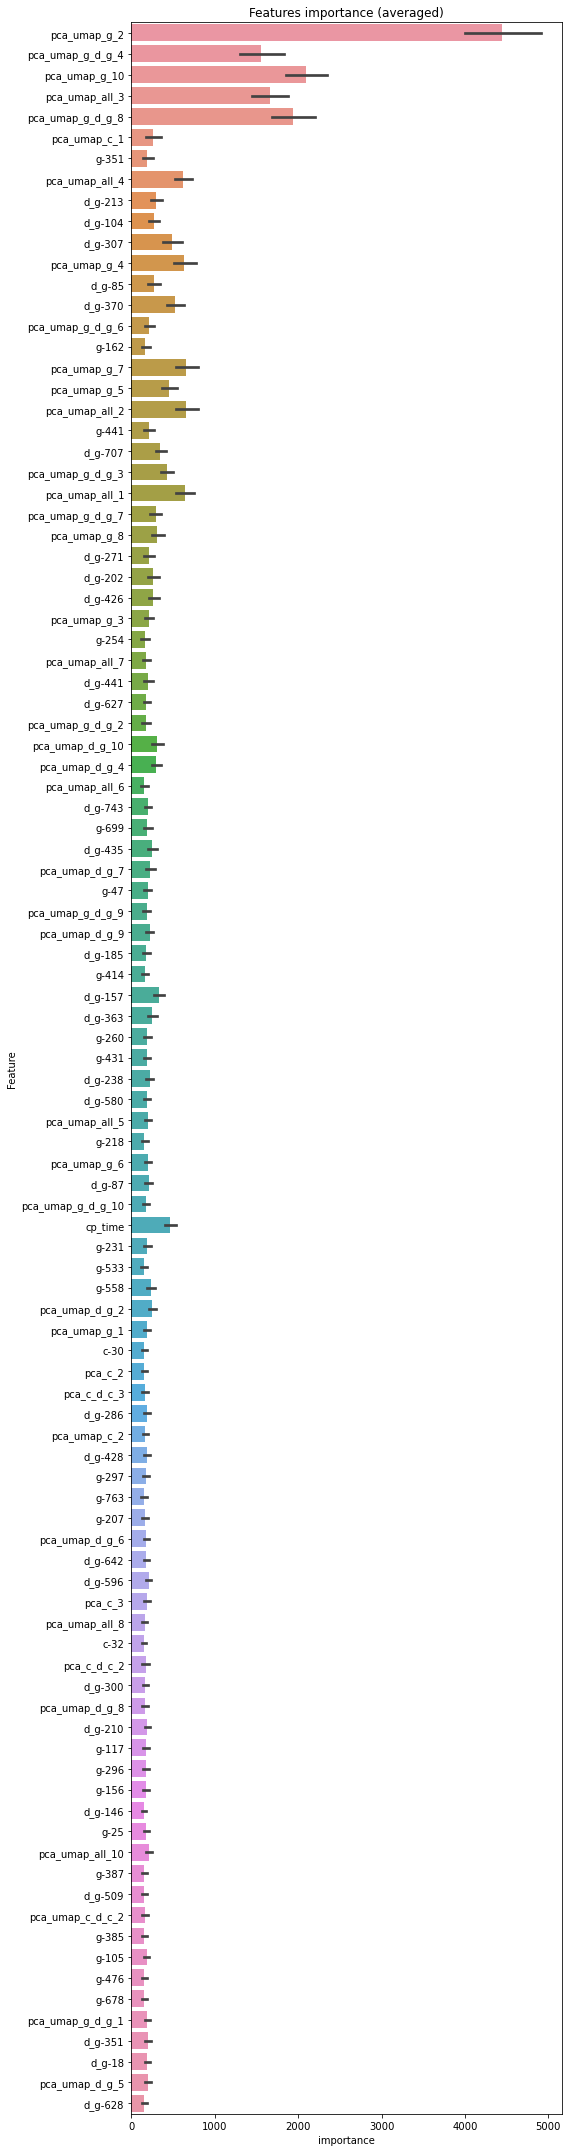

In [52]:
show_feature_importance(feature_importance_df)